# DenoiSeg Example: DSB 2018
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a refined version of the Kaggle 2018 Data Science Bowl (DSB 2018) dataset. We already split the data into train and test images. From the train images we then extracted 3800 training and 670 validation patches of size 128x128. The test set contains 50 images. 


In [1]:
# Here we are just importing some libraries which are needed to run this notebook.
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

Using TensorFlow backend.


## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [2]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n0'

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/1WXxLSqbK0ZIxF5/download'
elif noise_level == 'n10':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/dRc1AHcaH8mqeh7/download'
elif noise_level == 'n20':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/hy6xSq82kCoqqSH/download'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/DSB2018_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [4]:
# Loading of the training images
trainval_data =  np.load('data/DSB2018_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

In [5]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (3800, 128, 128)
Shape of train_masks:  (3800, 128, 128)
Shape of val_images:   (670, 128, 128)
Shape of val_masks:    (670, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenary by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [6]:
# Set the percentage of annotated training images.
# Values: 0.0 (no annotated images) to 100.0 (all images get annotations)
percentage_of_annotated_training_images = 0.125
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

In [7]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)
# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = percentage_of_annotated_training_images)

# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(X_frac, Y_frac)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)
Shape of X:     (30400, 128, 128, 1)
Shape of Y:     (30400, 128, 128, 3)
Shape of X_val: (670, 128, 128, 1)
Shape of Y_val: (670, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

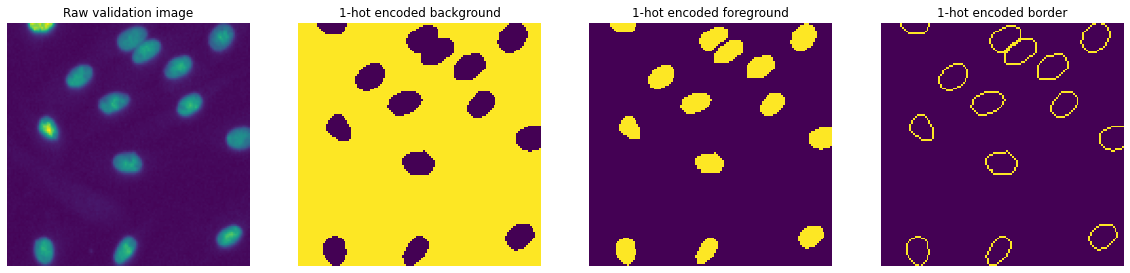

In [8]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

### Configure network parameters

In [9]:
train_batch_size = 128
train_steps_per_epoch = max(100, min(int(X.shape[0]/train_batch_size), 400))

In the next cell, you can choose how much relative importance (weight) to assign to denoising 
and segmentation tasks by choosing appropriate value for `denoiseg_alpha` (between `0` and `1`; with `0` being
only segmentation and `1` being only denoising. Here we choose `denoiseg_alpha = 0.5`)

In [10]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=200, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.0, train_tensorboard=True)

vars(conf)

{'means': ['13.496972'],
 'stds': ['18.33537'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 237,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.0}

In [11]:
model_name = 'DenoiSeg_DSB18_n0_noiseAugmentation_valTestAsWell'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

In [12]:
history = model.train(X, Y, (X_val, Y_val))

/home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/models/denoiseg_standard.py:144: UserWarning: small number of validation images (only 2.15642% of all images)
  warnings.warn("small number of validation images (only %.05f%% of all images)" % (100 * frac_val))
Preparing validation data:   1%|▏         | 10/670 [00:00<00:06, 98.55it/s]

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 670/670 [00:06<00:00, 97.69it/s]




Epoch 1/200
 10/237 [>.............................] - ETA: 3:25 - loss: 0.0021 - denoiseg: 0.0021 - seg_loss: 0.0021 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 2:50 - loss: 0.0034 - denoiseg: 0.0034 - seg_loss: 0.0034 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 2:32 - loss: 0.0042 - denoiseg: 0.0042 - seg_loss: 0.0042 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:28 - loss: 0.0027 - denoiseg: 0.0027 - seg_loss: 0.0027 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:26 - loss: 0.0025 - denoiseg: 0.0025 - seg_loss: 0.0025 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:25 - loss: 0.0024 - denoiseg: 0.0024 - seg_loss: 0.0024 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:22 - loss: 0.0022 - denoiseg: 0.0022 - seg_loss: 0.0022 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:20 - loss: 0.0020 - denoiseg: 0.0020 - seg_loss: 0.0020 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:16 - loss: 0.0021 - denoiseg: 0.0021 - seg_loss: 0.0021 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:15 - loss: 0.0020 - denoiseg: 0.0020 - seg_loss: 0.0020 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:13 - loss: 0.0020 - denoiseg: 0.0020 - seg_loss: 0.0020 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:11 - loss: 0.0018 - denoiseg: 0.0018 - seg_loss: 0.0018 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:10 - loss: 0.0018 - denoiseg: 0.0018 - seg_loss: 0.0018 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:08 - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:07 - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:06 - loss: 0.0016 - denoiseg: 0.0016 - seg_loss: 0.0016 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 54s - loss: 0.0018 - denoiseg: 0.0018 - seg_loss: 0.0018 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 53s - loss: 0.0018 - denoiseg: 0.0018 - seg_loss: 0.0018 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 52s - loss: 0.0018 - denoiseg: 0.0018 - seg_loss: 0.0018 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 52s - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 50s - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 49s - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 48s - loss: 0.0018 - denoiseg: 0.0018 - seg_loss: 0.0018 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 46s - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 45s - loss: 0.0017 - denoiseg: 0.0017 - seg_loss: 0.0017 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 44s - loss: 0.0016 - denoiseg: 0.0016 - seg_loss: 0.0016 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 0.0016 - denoiseg: 0.0016 - seg_loss: 0.0016 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 0.0016 - denoiseg: 0.0016 - seg_loss: 0.0016 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 0.0016 - denoiseg: 0.0016 - seg_loss: 0.0016 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 0.0016 - denoiseg: 0.0016 - seg_loss: 0.0016 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 0.0016 - denoiseg: 0.0016 - seg_loss: 0.0016 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 0.0015 - denoiseg: 0.0015 - seg_loss: 0.0015 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 0.0015 - denoiseg: 0.0015 - seg_loss: 0.0015 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 0.0015 - denoiseg: 0.0015 - seg_loss: 0.0015 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 0.0014 - denoiseg: 0.0014 - seg_loss: 0.0014 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 407ms/step - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00 - val_loss: 0.9720 - val_denoiseg: 0.9720 - val_seg_loss: 0.9720 - val_denoise_loss: 0.0000e+00

Epoch 2/200
  4/237 [..............................] - ETA: 2:29 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 2:10 - loss: 6.7952e-04 - denoiseg: 6.7952e-04 - seg_loss: 6.7952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:40 - loss: 2.2651e-04 - denoiseg: 2.2651e-04 - seg_loss: 2.2651e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:39 - loss: 2.1459e-04 - denoiseg: 2.1459e-04 - seg_loss: 2.1459e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:37 - loss: 5.0566e-04 - denoiseg: 5.0566e-04 - seg_loss: 5.0566e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:35 - loss: 4.6169e-04 - denoiseg: 4.6169e-04 - seg_loss: 4.6169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:34 - loss: 4.7110e-04 - denoiseg: 4.7110e-04 - seg_loss: 4.7110e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:32 - loss: 4.3621e-04 - denoiseg: 4.3621e-04 - seg_loss: 4.3621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:30 - loss: 3.9259e-04 - denoiseg: 3.9259e-04 - seg_loss: 3.9259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:27 - loss: 4.1758e-04 - denoiseg: 4.1758e-04 - seg_loss: 4.1758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:26 - loss: 6.0980e-04 - denoiseg: 6.0980e-04 - seg_loss: 6.0980e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:24 - loss: 7.0459e-04 - denoiseg: 7.0459e-04 - seg_loss: 7.0459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:23 - loss: 6.5303e-04 - denoiseg: 6.5303e-04 - seg_loss: 6.5303e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:20 - loss: 5.8205e-04 - denoiseg: 5.8205e-04 - seg_loss: 5.8205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 59s - loss: 7.3060e-04 - denoiseg: 7.3060e-04 - seg_loss: 7.3060e-04 - denoise_loss: 0.0000e+00  ETA: 1:02 - loss: 7.3308e-04 - denoiseg: 7.3308e-04 - seg_loss: 7.3308e-04 - denoise_los

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 7.6927e-04 - denoiseg: 7.6927e-04 - seg_loss: 7.6927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 7.2983e-04 - denoiseg: 7.2983e-04 - seg_loss: 7.2983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 7.1644e-04 - denoiseg: 7.1644e-04 - seg_loss: 7.1644e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 6.9725e-04 - denoiseg: 6.9725e-04 - seg_loss: 6.9725e-04 - denoise_loss: 0.0000e+00- ETA: 50s - loss: 7.0353e-04 - denoiseg: 7.0353e-04 - seg_loss: 7.0353e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 6.6745e-04 - denoiseg: 6.6745e-04 - seg_loss: 6.6745e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 6.9862e-04 - denoiseg: 6.9862e-04 - seg_loss: 6.9862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 6.7590e-04 - denoiseg: 6.7590e-04 - seg_loss: 6.7590e-04 - denoise_loss: 0.0000e+00- ETA: 46s - loss: 6.8708e-04 - denoiseg: 6.8708e-04 - seg_loss: 6.8708e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 6.5981e-04 - denoiseg: 6.5981e-04 - seg_loss: 6.5981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 6.4950e-04 - denoiseg: 6.4950e-04 - seg_loss: 6.4950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 6.2508e-04 - denoiseg: 6.2508e-04 - seg_loss: 6.2508e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 6.0244e-04 - denoiseg: 6.0244e-04 - seg_loss: 6.0244e-04 - denoise_loss: 0.0000e+00- ETA: 40s - loss: 6.1582e-04 - denoiseg: 6.1582e-04 - seg_loss: 6.1582e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 6.2127e-04 - denoiseg: 6.2127e-04 - seg_loss: 6.2127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 6.1246e-04 - denoiseg: 6.1246e-04 - seg_loss: 6.1246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 6.0769e-04 - denoiseg: 6.0769e-04 - seg_loss: 6.0769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 6.0350e-04 - denoiseg: 6.0350e-04 - seg_loss: 6.0350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 5.9529e-04 - denoiseg: 5.9529e-04 - seg_loss: 5.9529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 5.8730e-04 - denoiseg: 5.8730e-04 - seg_loss: 5.8730e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 5.7571e-04 - denoiseg: 5.7571e-04 - seg_loss: 5.7571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 34s - loss: 5.7194e-04 - denoiseg: 5.7194e-04 - seg_loss: 5.7194e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 5.6977e-04 - denoiseg: 5.6977e-04 - seg_loss: 5.6977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 5.5896e-04 - denoiseg: 5.5896e-04 - seg_loss: 5.5896e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 5.5197e-04 - denoiseg: 5.5197e-04 - seg_loss: 5.5197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 5.6760e-04 - denoiseg: 5.6760e-04 - seg_loss: 5.6760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 6.8473e-04 - denoiseg: 6.8473e-04 - seg_loss: 6.8473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 6.6871e-04 - denoiseg: 6.6871e-04 - seg_loss: 6.6871e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 6.6483e-04 - denoiseg: 6.6483e-04 - seg_loss: 6.6483e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 6.5718e-04 - denoiseg: 6.5718e-04 - seg_loss: 6.5718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 6.8367e-04 - denoiseg: 6.8367e-04 - seg_loss: 6.8367e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 6.7983e-04 - denoiseg: 6.7983e-04 - seg_loss: 6.7983e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 6.7227e-04 - denoiseg: 6.7227e-04 - seg_loss: 6.7227e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 6.6489e-04 - denoiseg: 6.6489e-04 - seg_loss: 6.6489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 6.7934e-04 - denoiseg: 6.7934e-04 - seg_loss: 6.7934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 6.7215e-04 - denoiseg: 6.7215e-04 - seg_loss: 6.7215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 6.6511e-04 - denoiseg: 6.6511e-04 - seg_loss: 6.6511e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 6.7413e-04 - denoiseg: 6.7413e-04 - seg_loss: 6.7413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 6.6392e-04 - denoiseg: 6.6392e-04 - seg_loss: 6.6392e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 6.5728e-04 - denoiseg: 6.5728e-04 - seg_loss: 6.5728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 6.8550e-04 - denoiseg: 6.8550e-04 - seg_loss: 6.8550e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 6.7547e-04 - denoiseg: 6.7547e-04 - seg_loss: 6.7547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 6.6573e-04 - denoiseg: 6.6573e-04 - seg_loss: 6.6573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 6.5634e-04 - denoiseg: 6.5634e-04 - seg_loss: 6.5634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 6.5021e-04 - denoiseg: 6.5021e-04 - seg_loss: 6.5021e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 6.6009e-04 - denoiseg: 6.6009e-04 - seg_loss: 6.6009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 6.5412e-04 - denoiseg: 6.5412e-04 - seg_loss: 6.5412e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 6.6138e-04 - denoiseg: 6.6138e-04 - seg_loss: 6.6138e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 6.4428e-04 - denoiseg: 6.4428e-04 - seg_loss: 6.4428e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 424ms/step - loss: 6.4925e-04 - denoiseg: 6.4925e-04 - seg_loss: 6.4925e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.7617 - val_denoiseg: 0.7617 - val_seg_loss: 0.7617 - val_denoise_loss: 0.0000e+00
Epoch 3/200
  8/237 [>.............................] - ETA: 1:48 - loss: 4.6895e-04 - denoiseg: 4.6895e-04 - seg_loss: 4.6895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:39 - loss: 3.2288e-04 - denoiseg: 3.2288e-04 - seg_loss: 3.2288e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:38 - loss: 2.9982e-04 - denoiseg: 2.9982e-04 - seg_loss: 2.9982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:33 - loss: 4.9352e-04 - denoiseg: 4.9352e-04 - seg_loss: 4.9352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:31 - loss: 4.4417e-04 - denoiseg: 4.4417e-04 - seg_loss: 4.4417e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:29 - loss: 9.9547e-04 - denoiseg: 9.9547e-04 - seg_loss: 9.9547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:27 - loss: 9.1890e-04 - denoiseg: 9.1890e-04 - seg_loss: 9.1890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:26 - loss: 8.5326e-04 - denoiseg: 8.5326e-04 - seg_loss: 8.5326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:26 - loss: 8.2384e-04 - denoiseg: 8.2384e-04 - seg_loss: 8.2384e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:25 - loss: 7.7069e-04 - denoiseg: 7.7069e-04 - seg_loss: 7.7069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:23 - loss: 7.2398e-04 - denoiseg: 7.2398e-04 - seg_loss: 7.2398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:23 - loss: 7.0269e-04 - denoiseg: 7.0269e-04 - seg_loss: 7.0269e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:21 - loss: 6.8253e-04 - denoiseg: 6.8253e-04 - seg_loss: 6.8253e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:19 - loss: 6.1753e-04 - denoiseg: 6.1753e-04 - seg_loss: 6.1753e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:15 - loss: 5.7656e-04 - denoiseg: 5.7656e-04 - seg_loss: 5.7656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 4.9061e-04 - denoiseg: 4.9061e-04 - seg_loss: 4.9061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 4.7865e-04 - denoiseg: 4.7865e-04 - seg_loss: 4.7865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:00 - loss: 5.3356e-04 - denoiseg: 5.3356e-04 - seg_loss: 5.3356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 5.4324e-04 - denoiseg: 5.4324e-04 - seg_loss: 5.4324e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 5.4679e-04 - denoiseg: 5.4679e-04 - seg_loss: 5.4679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 5.4324e-04 - denoiseg: 5.4324e-04 - seg_loss: 5.4324e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 5.3973e-04 - denoiseg: 5.3973e-04 - seg_loss: 5.3973e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 5.2616e-04 - denoiseg: 5.2616e-04 - seg_loss: 5.2616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 5.1324e-04 - denoiseg: 5.1324e-04 - seg_loss: 5.1324e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 5.0702e-04 - denoiseg: 5.0702e-04 - seg_loss: 5.0702e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 4.9378e-04 - denoiseg: 4.9378e-04 - seg_loss: 4.9378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 4.8804e-04 - denoiseg: 4.8804e-04 - seg_loss: 4.8804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 4.8243e-04 - denoiseg: 4.8243e-04 - seg_loss: 4.8243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 5.1048e-04 - denoiseg: 5.1048e-04 - seg_loss: 5.1048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 5.0760e-04 - denoiseg: 5.0760e-04 - seg_loss: 5.0760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 5.1678e-04 - denoiseg: 5.1678e-04 - seg_loss: 5.1678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 5.1392e-04 - denoiseg: 5.1392e-04 - seg_loss: 5.1392e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 4.8259e-04 - denoiseg: 4.8259e-04 - seg_loss: 4.8259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 4.8033e-04 - denoiseg: 4.8033e-04 - seg_loss: 4.8033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 4.7333e-04 - denoiseg: 4.7333e-04 - seg_loss: 4.7333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 4.7105e-04 - denoiseg: 4.7105e-04 - seg_loss: 4.7105e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 4.6654e-04 - denoiseg: 4.6654e-04 - seg_loss: 4.6654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 4.7091e-04 - denoiseg: 4.7091e-04 - seg_loss: 4.7091e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 4.6872e-04 - denoiseg: 4.6872e-04 - seg_loss: 4.6872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 4.4590e-04 - denoiseg: 4.4590e-04 - seg_loss: 4.4590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 4.4199e-04 - denoiseg: 4.4199e-04 - seg_loss: 4.4199e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 4.4006e-04 - denoiseg: 4.4006e-04 - seg_loss: 4.4006e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 4.6493e-04 - denoiseg: 4.6493e-04 - seg_loss: 4.6493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 4.7949e-04 - denoiseg: 4.7949e-04 - seg_loss: 4.7949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 4.7539e-04 - denoiseg: 4.7539e-04 - seg_loss: 4.7539e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 4.7337e-04 - denoiseg: 4.7337e-04 - seg_loss: 4.7337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 4.7136e-04 - denoiseg: 4.7136e-04 - seg_loss: 4.7136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 4.6938e-04 - denoiseg: 4.6938e-04 - seg_loss: 4.6938e-04 - denoise_loss: 0.0000e+00 - val_loss: 1.0155 - val_denoiseg: 1.0155 - val_seg_loss: 1.0155 - val_denoise_loss: 0.0000e+00
Epoch 4/200
 13/237 [>.............................] - ETA: 1:33 - loss: 9.2111e-04 - denoiseg: 9.2111e-04 - seg_loss: 9.2111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:32 - loss: 8.5532e-04 - denoiseg: 8.5532e-04 - seg_loss: 8.5532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:26 - loss: 0.0014 - denoiseg: 0.0014 - seg_loss: 0.0014 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:24 - loss: 0.0012 - denoiseg: 0.0012 - seg_loss: 0.0012 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:23 - loss: 0.0012 - denoiseg: 0.0012 - seg_loss: 0.0012 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:23 - loss: 0.0012 - denoiseg: 0.0012 - seg_loss: 0.0012 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:20 - loss: 9.9047e-04 - denoiseg: 9.9047e-04 - seg_loss: 9.9047e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:19 - loss: 0.0012 - denoiseg: 0.0012 - seg_loss: 0.0012 - denoise_loss: 0.0000e+00            

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:19 - loss: 0.0011 - denoiseg: 0.0011 - seg_loss: 0.0011 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:17 - loss: 0.0012 - denoiseg: 0.0012 - seg_loss: 0.0012 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:16 - loss: 0.0011 - denoiseg: 0.0011 - seg_loss: 0.0011 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:16 - loss: 0.0011 - denoiseg: 0.0011 - seg_loss: 0.0011 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:15 - loss: 0.0010 - denoiseg: 0.0010 - seg_loss: 0.0010 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:04 - loss: 6.9814e-04 - denoiseg: 6.9814e-04 - seg_loss: 6.9814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:04 - loss: 6.8908e-04 - denoiseg: 6.8908e-04 - seg_loss: 6.8908e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:03 - loss: 6.7163e-04 - denoiseg: 6.7163e-04 - seg_loss: 6.7163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:02 - loss: 7.5622e-04 - denoiseg: 7.5622e-04 - seg_loss: 7.5622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 58s - loss: 7.1574e-04 - denoiseg: 7.1574e-04 - seg_loss: 7.1574e-04 - denoise_loss: 0.0000e+00- ETA: 58s - loss: 7.2369e-04 - denoiseg: 7.2369e-04 - seg_loss: 7.2369e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 6.9290e-04 - denoiseg: 6.9290e-04 - seg_loss: 6.9290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 6.6653e-04 - denoiseg: 6.6653e-04 - seg_loss: 6.6653e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 6.7859e-04 - denoiseg: 6.7859e-04 - seg_loss: 6.7859e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 6.6929e-04 - denoiseg: 6.6929e-04 - seg_loss: 6.6929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 6.5582e-04 - denoiseg: 6.5582e-04 - seg_loss: 6.5582e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 6.4713e-04 - denoiseg: 6.4713e-04 - seg_loss: 6.4713e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 6.3867e-04 - denoiseg: 6.3867e-04 - seg_loss: 6.3867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 6.3453e-04 - denoiseg: 6.3453e-04 - seg_loss: 6.3453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 6.2639e-04 - denoiseg: 6.2639e-04 - seg_loss: 6.2639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 6.1846e-04 - denoiseg: 6.1846e-04 - seg_loss: 6.1846e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 6.2337e-04 - denoiseg: 6.2337e-04 - seg_loss: 6.2337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 6.1120e-04 - denoiseg: 6.1120e-04 - seg_loss: 6.1120e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 6.0393e-04 - denoiseg: 6.0393e-04 - seg_loss: 6.0393e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 5.9682e-04 - denoiseg: 5.9682e-04 - seg_loss: 5.9682e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 5.8988e-04 - denoiseg: 5.8988e-04 - seg_loss: 5.8988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 5.9198e-04 - denoiseg: 5.9198e-04 - seg_loss: 5.9198e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 5.8684e-04 - denoiseg: 5.8684e-04 - seg_loss: 5.8684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 5.7722e-04 - denoiseg: 5.7722e-04 - seg_loss: 5.7722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 5.6791e-04 - denoiseg: 5.6791e-04 - seg_loss: 5.6791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 5.5304e-04 - denoiseg: 5.5304e-04 - seg_loss: 5.5304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 5.4731e-04 - denoiseg: 5.4731e-04 - seg_loss: 5.4731e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 5.6916e-04 - denoiseg: 5.6916e-04 - seg_loss: 5.6916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 5.9319e-04 - denoiseg: 5.9319e-04 - seg_loss: 5.9319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 6.0690e-04 - denoiseg: 6.0690e-04 - seg_loss: 6.0690e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 6.0087e-04 - denoiseg: 6.0087e-04 - seg_loss: 6.0087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 5.9789e-04 - denoiseg: 5.9789e-04 - seg_loss: 5.9789e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 5.9889e-04 - denoiseg: 5.9889e-04 - seg_loss: 5.9889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 6.0060e-04 - denoiseg: 6.0060e-04 - seg_loss: 6.0060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 5.8932e-04 - denoiseg: 5.8932e-04 - seg_loss: 5.8932e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 5.8657e-04 - denoiseg: 5.8657e-04 - seg_loss: 5.8657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 5.8384e-04 - denoiseg: 5.8384e-04 - seg_loss: 5.8384e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 5.7846e-04 - denoiseg: 5.7846e-04 - seg_loss: 5.7846e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 5.7317e-04 - denoiseg: 5.7317e-04 - seg_loss: 5.7317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 5.6799e-04 - denoiseg: 5.6799e-04 - seg_loss: 5.6799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 5.5789e-04 - denoiseg: 5.5789e-04 - seg_loss: 5.5789e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 5.5055e-04 - denoiseg: 5.5055e-04 - seg_loss: 5.5055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 5.4576e-04 - denoiseg: 5.4576e-04 - seg_loss: 5.4576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 5.4573e-04 - denoiseg: 5.4573e-04 - seg_loss: 5.4573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 5.4109e-04 - denoiseg: 5.4109e-04 - seg_loss: 5.4109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 5.3880e-04 - denoiseg: 5.3880e-04 - seg_loss: 5.3880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 5.3653e-04 - denoiseg: 5.3653e-04 - seg_loss: 5.3653e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.7291 - val_denoiseg: 0.7291 - val_seg_loss: 0.7291 - val_denoise_loss: 0.0000e+00
Epoch 5/200
  2/237 [..............................] - ETA: 49s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:39 - loss: 2.0505e-05 - denoiseg: 2.0505e-05 - seg_loss: 2.0505e-05 - denoise_loss: 0.0000e+00 ETA: 1:38 - loss: 2.7962e-05 - denoiseg: 2.7962e-05 - seg_loss: 2.7962e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:38 - loss: 1.9224e-05 - denoiseg: 1.9224e-05 - seg_loss: 1.9224e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:38 - loss: 1.7088e-05 - denoiseg: 1.7088e-05 - seg_loss: 1.7088e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:38 - loss: 1.6188e-05 - denoiseg: 1.6188e-05 - seg_loss: 1.6188e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:28 - loss: 7.8733e-05 - denoiseg: 7.8733e-05 - seg_loss: 7.8733e-05 - denoise_loss: 0.0000e+00 ETA: 1:28 - loss: 8.0522e-05 - denoiseg: 8.0522e-05 - seg_loss: 8.0522e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:27 - loss: 9.7360e-05 - denoiseg: 9.7360e-05 - seg_loss: 9.7360e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:26 - loss: 1.0089e-04 - denoiseg: 1.0089e-04 - seg_loss: 1.0089e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:25 - loss: 9.6934e-05 - denoiseg: 9.6934e-05 - seg_loss: 9.6934e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:25 - loss: 9.3276e-05 - denoiseg: 9.3276e-05 - seg_loss: 9.3276e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:23 - loss: 8.8279e-05 - denoiseg: 8.8279e-05 - seg_loss: 8.8279e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:22 - loss: 8.5235e-05 - denoiseg: 8.5235e-05 - seg_loss: 8.5235e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:22 - loss: 8.3790e-05 - denoiseg: 8.3790e-05 - seg_loss: 8.3790e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:21 - loss: 8.1043e-05 - denoiseg: 8.1043e-05 - seg_loss: 8.1043e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:21 - loss: 7.9736e-05 - denoiseg: 7.9736e-05 - seg_loss: 7.9736e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:20 - loss: 7.8470e-05 - denoiseg: 7.8470e-05 - seg_loss: 7.8470e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:18 - loss: 1.9952e-04 - denoiseg: 1.9952e-04 - seg_loss: 1.9952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:18 - loss: 1.9659e-04 - denoiseg: 1.9659e-04 - seg_loss: 1.9659e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:17 - loss: 2.3170e-04 - denoiseg: 2.3170e-04 - seg_loss: 2.3170e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:15 - loss: 2.1605e-04 - denoiseg: 2.1605e-04 - seg_loss: 2.1605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:14 - loss: 2.1132e-04 - denoiseg: 2.1132e-04 - seg_loss: 2.1132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:13 - loss: 2.0861e-04 - denoiseg: 2.0861e-04 - seg_loss: 2.0861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:12 - loss: 2.9219e-04 - denoiseg: 2.9219e-04 - seg_loss: 2.9219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:11 - loss: 2.8523e-04 - denoiseg: 2.8523e-04 - seg_loss: 2.8523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:10 - loss: 2.8187e-04 - denoiseg: 2.8187e-04 - seg_loss: 2.8187e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:09 - loss: 2.7539e-04 - denoiseg: 2.7539e-04 - seg_loss: 2.7539e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:08 - loss: 3.3336e-04 - denoiseg: 3.3336e-04 - seg_loss: 3.3336e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:07 - loss: 3.5096e-04 - denoiseg: 3.5096e-04 - seg_loss: 3.5096e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 1:05 - loss: 3.3999e-04 - denoiseg: 3.3999e-04 - seg_loss: 3.3999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 1:04 - loss: 3.3305e-04 - denoiseg: 3.3305e-04 - seg_loss: 3.3305e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 1:04 - loss: 3.2969e-04 - denoiseg: 3.2969e-04 - seg_loss: 3.2969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 1:03 - loss: 3.2639e-04 - denoiseg: 3.2639e-04 - seg_loss: 3.2639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 1:03 - loss: 3.2316e-04 - denoiseg: 3.2316e-04 - seg_loss: 3.2316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 42s - loss: 3.1211e-04 - denoiseg: 3.1211e-04 - seg_loss: 3.1211e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 42s - loss: 3.0998e-04 - denoiseg: 3.0998e-04 - seg_loss: 3.0998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 40s - loss: 3.0374e-04 - denoiseg: 3.0374e-04 - seg_loss: 3.0374e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 40s - loss: 3.1230e-04 - denoiseg: 3.1230e-04 - seg_loss: 3.1230e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 39s - loss: 3.1023e-04 - denoiseg: 3.1023e-04 - seg_loss: 3.1023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 38s - loss: 3.0222e-04 - denoiseg: 3.0222e-04 - seg_loss: 3.0222e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 37s - loss: 2.9837e-04 - denoiseg: 2.9837e-04 - seg_loss: 2.9837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 36s - loss: 2.9462e-04 - denoiseg: 2.9462e-04 - seg_loss: 2.9462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 8s - loss: 3.7520e-04 - denoiseg: 3.7520e-04 - seg_loss: 3.7520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 3.7623e-04 - denoiseg: 3.7623e-04 - seg_loss: 3.7623e-04 - denoise_loss: 0.0000e+ - ETA: 7s - loss: 3.7453e-04 - denoiseg: 3.7453e-04 - seg_loss: 3.7453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 3.9078e-04 - denoiseg: 3.9078e-04 - seg_loss: 3.9078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 5s - loss: 3.8905e-04 - denoiseg: 3.8905e-04 - seg_loss: 3.8905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 4.0284e-04 - denoiseg: 4.0284e-04 - seg_loss: 4.0284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 3.9935e-04 - denoiseg: 3.9935e-04 - seg_loss: 3.9935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 3.9593e-04 - denoiseg: 3.9593e-04 - seg_loss: 3.9593e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 4.0364e-04 - denoiseg: 4.0364e-04 - seg_loss: 4.0364e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 112s 472ms/step - loss: 4.0194e-04 - denoiseg: 4.0194e-04 - seg_loss: 4.0194e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5435 - val_denoiseg: 0.5435 - val_seg_loss: 0.5435 - val_denoise_loss: 0.0000e+00
Epoch 6/200
 12/237 [>.............................] - ETA: 1:27 - loss: 2.3929e-04 - denoiseg: 2.3929e-04 - seg_loss: 2.3929e-04 - denoise_loss: 0.0000e+00 ETA: 37s - loss: 6.3155e-04 - denoiseg: 6.3155e-04 - seg_loss: 6.3155e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:26 - loss: 1.7947e-04 - denoiseg: 1.7947e-04 - seg_loss: 1.7947e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:26 - loss: 1.6891e-04 - denoiseg: 1.6891e-04 - seg_loss: 1.6891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:25 - loss: 1.3674e-04 - denoiseg: 1.3674e-04 - seg_loss: 1.3674e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:24 - loss: 1.3052e-04 - denoiseg: 1.3052e-04 - seg_loss: 1.3052e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:24 - loss: 2.0176e-04 - denoiseg: 2.0176e-04 - seg_loss: 2.0176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:23 - loss: 2.7844e-04 - denoiseg: 2.7844e-04 - seg_loss: 2.7844e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:22 - loss: 2.4963e-04 - denoiseg: 2.4963e-04 - seg_loss: 2.4963e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 3.9690e-04 - denoiseg: 3.9690e-04 - seg_loss: 3.9690e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 3.9187e-04 - denoiseg: 3.9187e-04 - seg_loss: 3.9187e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 4.2965e-04 - denoiseg: 4.2965e-04 - seg_loss: 4.2965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 4.1930e-04 - denoiseg: 4.1930e-04 - seg_loss: 4.1930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 4.2701e-04 - denoiseg: 4.2701e-04 - seg_loss: 4.2701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 4.2227e-04 - denoiseg: 4.2227e-04 - seg_loss: 4.2227e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 4.1763e-04 - denoiseg: 4.1763e-04 - seg_loss: 4.1763e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 4.1907e-04 - denoiseg: 4.1907e-04 - seg_loss: 4.1907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 4.4143e-04 - denoiseg: 4.4143e-04 - seg_loss: 4.4143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 4.0873e-04 - denoiseg: 4.0873e-04 - seg_loss: 4.0873e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 4.4964e-04 - denoiseg: 4.4964e-04 - seg_loss: 4.4964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 4.1889e-04 - denoiseg: 4.1889e-04 - seg_loss: 4.1889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 3.6571e-04 - denoiseg: 3.6571e-04 - seg_loss: 3.6571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 3.6320e-04 - denoiseg: 3.6320e-04 - seg_loss: 3.6320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 3.5830e-04 - denoiseg: 3.5830e-04 - seg_loss: 3.5830e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 4.0206e-04 - denoiseg: 4.0206e-04 - seg_loss: 4.0206e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 3.9697e-04 - denoiseg: 3.9697e-04 - seg_loss: 3.9697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 3.9201e-04 - denoiseg: 3.9201e-04 - seg_loss: 3.9201e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 3.9625e-04 - denoiseg: 3.9625e-04 - seg_loss: 3.9625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 3.9142e-04 - denoiseg: 3.9142e-04 - seg_loss: 3.9142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 3.8670e-04 - denoiseg: 3.8670e-04 - seg_loss: 3.8670e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 4.0485e-04 - denoiseg: 4.0485e-04 - seg_loss: 4.0485e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 4.0248e-04 - denoiseg: 4.0248e-04 - seg_loss: 4.0248e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 3.9554e-04 - denoiseg: 3.9554e-04 - seg_loss: 3.9554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 4.2560e-04 - denoiseg: 4.2560e-04 - seg_loss: 4.2560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 4.3321e-04 - denoiseg: 4.3321e-04 - seg_loss: 4.3321e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 4.3080e-04 - denoiseg: 4.3080e-04 - seg_loss: 4.3080e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 4.2607e-04 - denoiseg: 4.2607e-04 - seg_loss: 4.2607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 4.2144e-04 - denoiseg: 4.2144e-04 - seg_loss: 4.2144e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 4.1691e-04 - denoiseg: 4.1691e-04 - seg_loss: 4.1691e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 4.1029e-04 - denoiseg: 4.1029e-04 - seg_loss: 4.1029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 4.0599e-04 - denoiseg: 4.0599e-04 - seg_loss: 4.0599e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 3.9971e-04 - denoiseg: 3.9971e-04 - seg_loss: 3.9971e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 3.9767e-04 - denoiseg: 3.9767e-04 - seg_loss: 3.9767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 4.2073e-04 - denoiseg: 4.2073e-04 - seg_loss: 4.2073e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 4.1232e-04 - denoiseg: 4.1232e-04 - seg_loss: 4.1232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 4.0623e-04 - denoiseg: 4.0623e-04 - seg_loss: 4.0623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 4.0226e-04 - denoiseg: 4.0226e-04 - seg_loss: 4.0226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 4.2413e-04 - denoiseg: 4.2413e-04 - seg_loss: 4.2413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 4.2009e-04 - denoiseg: 4.2009e-04 - seg_loss: 4.2009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 4.1613e-04 - denoiseg: 4.1613e-04 - seg_loss: 4.1613e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 4.5703e-04 - denoiseg: 4.5703e-04 - seg_loss: 4.5703e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 4.5077e-04 - denoiseg: 4.5077e-04 - seg_loss: 4.5077e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 4.4669e-04 - denoiseg: 4.4669e-04 - seg_loss: 4.4669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 4.4268e-04 - denoiseg: 4.4268e-04 - seg_loss: 4.4268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 4.3875e-04 - denoiseg: 4.3875e-04 - seg_loss: 4.3875e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 4.3488e-04 - denoiseg: 4.3488e-04 - seg_loss: 4.3488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 4.2921e-04 - denoiseg: 4.2921e-04 - seg_loss: 4.2921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 4.2551e-04 - denoiseg: 4.2551e-04 - seg_loss: 4.2551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 4.2008e-04 - denoiseg: 4.2008e-04 - seg_loss: 4.2008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 4.1964e-04 - denoiseg: 4.1964e-04 - seg_loss: 4.1964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 4.1788e-04 - denoiseg: 4.1788e-04 - seg_loss: 4.1788e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5147 - val_denoiseg: 0.5147 - val_seg_loss: 0.5147 - val_denoise_loss: 0.0000e+00
Epoch 7/200
 19/237 [=>............................] - ETA: 1:22 - loss: 2.4817e-04 - denoiseg: 2.4817e-04 - seg_loss: 2.4817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:22 - loss: 2.2453e-04 - denoiseg: 2.2453e-04 - seg_loss: 2.2453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:21 - loss: 1.8861e-04 - denoiseg: 1.8861e-04 - seg_loss: 1.8861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 2.4219e-04 - denoiseg: 2.4219e-04 - seg_loss: 2.4219e-04 - denoise_loss: 0.0000e+00  ETA: 1:10 - loss: 3.0276e-04 - denoiseg: 3.0276e-04 - s

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 2.3809e-04 - denoiseg: 2.3809e-04 - seg_loss: 2.3809e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.3675e-04 - denoiseg: 2.3675e-04 - seg_loss: 2.3675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 2.3491e-04 - denoiseg: 2.3491e-04 - seg_loss: 2.3491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 2.3361e-04 - denoiseg: 2.3361e-04 - seg_loss: 2.3361e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 2.3233e-04 - denoiseg: 2.3233e-04 - seg_loss: 2.3233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 2.6760e-04 - denoiseg: 2.6760e-04 - seg_loss: 2.6760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 2.5919e-04 - denoiseg: 2.5919e-04 - seg_loss: 2.5919e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 2.5784e-04 - denoiseg: 2.5784e-04 - seg_loss: 2.5784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 2.5765e-04 - denoiseg: 2.5765e-04 - seg_loss: 2.5765e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 2.9188e-04 - denoiseg: 2.9188e-04 - seg_loss: 2.9188e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 2.8896e-04 - denoiseg: 2.8896e-04 - seg_loss: 2.8896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 2.9423e-04 - denoiseg: 2.9423e-04 - seg_loss: 2.9423e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 2.9292e-04 - denoiseg: 2.9292e-04 - seg_loss: 2.9292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.9033e-04 - denoiseg: 2.9033e-04 - seg_loss: 2.9033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 2.8905e-04 - denoiseg: 2.8905e-04 - seg_loss: 2.8905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 2.8778e-04 - denoiseg: 2.8778e-04 - seg_loss: 2.8778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 2.9357e-04 - denoiseg: 2.9357e-04 - seg_loss: 2.9357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 2.9230e-04 - denoiseg: 2.9230e-04 - seg_loss: 2.9230e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 2.8979e-04 - denoiseg: 2.8979e-04 - seg_loss: 2.8979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 2.8583e-04 - denoiseg: 2.8583e-04 - seg_loss: 2.8583e-04 - denoise_loss: 0.0000e+00 - val_loss: 1.3264 - val_denoiseg: 1.3264 - val_seg_loss: 1.3264 - val_denoise_loss: 0.0000e+00
Epoch 8/200
  3/237 [..............................] - ETA: 1:07 - loss: 0.0026 - denoiseg: 0.0026 - seg_loss: 0.0026 - denoise_loss: 0.0000e+00           

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:24 - loss: 0.0011 - denoiseg: 0.0011 - seg_loss: 0.0011 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:24 - loss: 9.0496e-04 - denoiseg: 9.0496e-04 - seg_loss: 9.0496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:25 - loss: 8.5733e-04 - denoiseg: 8.5733e-04 - seg_loss: 8.5733e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:26 - loss: 7.7568e-04 - denoiseg: 7.7568e-04 - seg_loss: 7.7568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:27 - loss: 7.8718e-04 - denoiseg: 7.8718e-04 - seg_loss: 7.8718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:27 - loss: 6.8561e-04 - denoiseg: 6.8561e-04 - seg_loss: 6.8561e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:27 - loss: 6.4405e-04 - denoiseg: 6.4405e-04 - seg_loss: 6.4405e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:27 - loss: 6.2511e-04 - denoiseg: 6.2511e-04 - seg_loss: 6.2511e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:27 - loss: 6.0725e-04 - denoiseg: 6.0725e-04 - seg_loss: 6.0725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.290051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:25 - loss: 5.3134e-04 - denoiseg: 5.3134e-04 - seg_loss: 5.3134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:24 - loss: 4.8304e-04 - denoiseg: 4.8304e-04 - seg_loss: 4.8304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:24 - loss: 4.7231e-04 - denoiseg: 4.7231e-04 - seg_loss: 4.7231e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:23 - loss: 4.6592e-04 - denoiseg: 4.6592e-04 - seg_loss: 4.6592e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:23 - loss: 4.5622e-04 - denoiseg: 4.5622e-04 - seg_loss: 4.5622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:22 - loss: 4.3835e-04 - denoiseg: 4.3835e-04 - seg_loss: 4.3835e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:22 - loss: 5.6533e-04 - denoiseg: 5.6533e-04 - seg_loss: 5.6533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:21 - loss: 5.5466e-04 - denoiseg: 5.5466e-04 - seg_loss: 5.5466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.325203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:21 - loss: 5.3449e-04 - denoiseg: 5.3449e-04 - seg_loss: 5.3449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.328863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:19 - loss: 4.9826e-04 - denoiseg: 4.9826e-04 - seg_loss: 4.9826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:19 - loss: 4.8995e-04 - denoiseg: 4.8995e-04 - seg_loss: 4.8995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:18 - loss: 5.0276e-04 - denoiseg: 5.0276e-04 - seg_loss: 5.0276e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:18 - loss: 4.9465e-04 - denoiseg: 4.9465e-04 - seg_loss: 4.9465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:12 - loss: 4.5267e-04 - denoiseg: 4.5267e-04 - seg_loss: 4.5267e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:12 - loss: 4.4686e-04 - denoiseg: 4.4686e-04 - seg_loss: 4.4686e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:11 - loss: 4.4121e-04 - denoiseg: 4.4121e-04 - seg_loss: 4.4121e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:10 - loss: 4.3069e-04 - denoiseg: 4.3069e-04 - seg_loss: 4.3069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:09 - loss: 4.2556e-04 - denoiseg: 4.2556e-04 - seg_loss: 4.2556e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.322309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.326213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:09 - loss: 4.2056e-04 - denoiseg: 4.2056e-04 - seg_loss: 4.2056e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:08 - loss: 4.1089e-04 - denoiseg: 4.1089e-04 - seg_loss: 4.1089e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.321610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:07 - loss: 4.0166e-04 - denoiseg: 4.0166e-04 - seg_loss: 4.0166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:07 - loss: 3.9719e-04 - denoiseg: 3.9719e-04 - seg_loss: 3.9719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:05 - loss: 3.8438e-04 - denoiseg: 3.8438e-04 - seg_loss: 3.8438e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:05 - loss: 3.8029e-04 - denoiseg: 3.8029e-04 - seg_loss: 3.8029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 58s - loss: 3.4708e-04 - denoiseg: 3.4708e-04 - seg_loss: 3.4708e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 57s - loss: 3.4083e-04 - denoiseg: 3.4083e-04 - seg_loss: 3.4083e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 56s - loss: 3.3479e-04 - denoiseg: 3.3479e-04 - seg_loss: 3.3479e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 56s - loss: 3.3186e-04 - denoiseg: 3.3186e-04 - seg_loss: 3.3186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 55s - loss: 3.3345e-04 - denoiseg: 3.3345e-04 - seg_loss: 3.3345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 54s - loss: 3.2780e-04 - denoiseg: 3.2780e-04 - seg_loss: 3.2780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 52s - loss: 3.1837e-04 - denoiseg: 3.1837e-04 - seg_loss: 3.1837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 50s - loss: 3.1210e-04 - denoiseg: 3.1210e-04 - seg_loss: 3.1210e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 50s - loss: 3.0962e-04 - denoiseg: 3.0962e-04 - seg_loss: 3.0962e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 49s - loss: 3.4488e-04 - denoiseg: 3.4488e-04 - seg_loss: 3.4488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 48s - loss: 3.3892e-04 - denoiseg: 3.3892e-04 - seg_loss: 3.3892e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 45s - loss: 3.3391e-04 - denoiseg: 3.3391e-04 - seg_loss: 3.3391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 44s - loss: 3.4111e-04 - denoiseg: 3.4111e-04 - seg_loss: 3.4111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 44s - loss: 3.3864e-04 - denoiseg: 3.3864e-04 - seg_loss: 3.3864e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 43s - loss: 3.3381e-04 - denoiseg: 3.3381e-04 - seg_loss: 3.3381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 40s - loss: 3.2173e-04 - denoiseg: 3.2173e-04 - seg_loss: 3.2173e-04 - denoise_loss: 0.0000e+00- ETA: 40s - loss: 3.2395e-04 - denoiseg: 3.2395e-04 - seg_loss: 3.2395e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 39s - loss: 3.1738e-04 - denoiseg: 3.1738e-04 - seg_loss: 3.1738e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 33s - loss: 3.6548e-04 - denoiseg: 3.6548e-04 - seg_loss: 3.6548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 32s - loss: 3.5876e-04 - denoiseg: 3.5876e-04 - seg_loss: 3.5876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 31s - loss: 3.5441e-04 - denoiseg: 3.5441e-04 - seg_loss: 3.5441e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 30s - loss: 3.6675e-04 - denoiseg: 3.6675e-04 - seg_loss: 3.6675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 29s - loss: 3.6241e-04 - denoiseg: 3.6241e-04 - seg_loss: 3.6241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 27s - loss: 3.5200e-04 - denoiseg: 3.5200e-04 - seg_loss: 3.5200e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 26s - loss: 3.4800e-04 - denoiseg: 3.4800e-04 - seg_loss: 3.4800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 430ms/step - loss: 3.6676e-04 - denoiseg: 3.6676e-04 - seg_loss: 3.6676e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4374 - val_denoiseg: 0.4374 - val_seg_loss: 0.4374 - val_denoise_loss: 0.0000e+00
Epoch 9/200
 15/237 [>.............................] - ETA: 1:22 - loss: 0.0011 - denoiseg: 0.0011 - seg_loss: 0.0011 - denoise_loss: 0.0000e+00             ETA: 40s - loss: 0.0012 - denoiseg: 0.0012 - seg_loss: 0.0012 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:23 - loss: 0.0010 - denoiseg: 0.0010 - seg_loss: 0.0010 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:21 - loss: 6.8339e-04 - denoiseg: 6.8339e-04 - seg_loss: 6.8339e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:20 - loss: 6.3277e-04 - denoiseg: 6.3277e-04 - seg_loss: 6.3277e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:20 - loss: 6.1665e-04 - denoiseg: 6.1665e-04 - seg_loss: 6.1665e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:20 - loss: 5.9539e-04 - denoiseg: 5.9539e-04 - seg_loss: 5.9539e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:20 - loss: 5.5698e-04 - denoiseg: 5.5698e-04 - seg_loss: 5.5698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:20 - loss: 5.3957e-04 - denoiseg: 5.3957e-04 - seg_loss: 5.3957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:17 - loss: 4.4273e-04 - denoiseg: 4.4273e-04 - seg_loss: 4.4273e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:16 - loss: 4.8215e-04 - denoiseg: 4.8215e-04 - seg_loss: 4.8215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:15 - loss: 4.3930e-04 - denoiseg: 4.3930e-04 - seg_loss: 4.3930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 4.2402e-04 - denoiseg: 4.2402e-04 - seg_loss: 4.2402e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:13 - loss: 3.9857e-04 - denoiseg: 3.9857e-04 - seg_loss: 3.9857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:13 - loss: 3.8324e-04 - denoiseg: 3.8324e-04 - seg_loss: 3.8324e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 3.4360e-04 - denoiseg: 3.4360e-04 - seg_loss: 3.4360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:10 - loss: 3.3777e-04 - denoiseg: 3.3777e-04 - seg_loss: 3.3777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 3.8825e-04 - denoiseg: 3.8825e-04 - seg_loss: 3.8825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 3.7113e-04 - denoiseg: 3.7113e-04 - seg_loss: 3.7113e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 3.5323e-04 - denoiseg: 3.5323e-04 - seg_loss: 3.5323e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 3.5755e-04 - denoiseg: 3.5755e-04 - seg_loss: 3.5755e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 3.3521e-04 - denoiseg: 3.3521e-04 - seg_loss: 3.3521e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 3.3107e-04 - denoiseg: 3.3107e-04 - seg_loss: 3.3107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 3.2309e-04 - denoiseg: 3.2309e-04 - seg_loss: 3.2309e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 3.4398e-04 - denoiseg: 3.4398e-04 - seg_loss: 3.4398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 3.5558e-04 - denoiseg: 3.5558e-04 - seg_loss: 3.5558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 3.4189e-04 - denoiseg: 3.4189e-04 - seg_loss: 3.4189e-04 - denoise_loss: 0.0000e+00- ETA: 45s - loss: 3.1972e-04 - denoiseg: 3.1972e-04 - seg_loss: 3.1972e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 3.3406e-04 - denoiseg: 3.3406e-04 - seg_loss: 3.3406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 3.2178e-04 - denoiseg: 3.2178e-04 - seg_loss: 3.2178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 3.4299e-04 - denoiseg: 3.4299e-04 - seg_loss: 3.4299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 3.4161e-04 - denoiseg: 3.4161e-04 - seg_loss: 3.4161e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 3.3440e-04 - denoiseg: 3.3440e-04 - seg_loss: 3.3440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 3.2394e-04 - denoiseg: 3.2394e-04 - seg_loss: 3.2394e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 3.3823e-04 - denoiseg: 3.3823e-04 - seg_loss: 3.3823e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 3.3372e-04 - denoiseg: 3.3372e-04 - seg_loss: 3.3372e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 3.3104e-04 - denoiseg: 3.3104e-04 - seg_loss: 3.3104e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 3.2894e-04 - denoiseg: 3.2894e-04 - seg_loss: 3.2894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 3.2350e-04 - denoiseg: 3.2350e-04 - seg_loss: 3.2350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 3.2150e-04 - denoiseg: 3.2150e-04 - seg_loss: 3.2150e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 3.2822e-04 - denoiseg: 3.2822e-04 - seg_loss: 3.2822e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 3.3893e-04 - denoiseg: 3.3893e-04 - seg_loss: 3.3893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 3.5514e-04 - denoiseg: 3.5514e-04 - seg_loss: 3.5514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 3.5689e-04 - denoiseg: 3.5689e-04 - seg_loss: 3.5689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 3.5487e-04 - denoiseg: 3.5487e-04 - seg_loss: 3.5487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 3.4962e-04 - denoiseg: 3.4962e-04 - seg_loss: 3.4962e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 3.4202e-04 - denoiseg: 3.4202e-04 - seg_loss: 3.4202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 3.4070e-04 - denoiseg: 3.4070e-04 - seg_loss: 3.4070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 3.3183e-04 - denoiseg: 3.3183e-04 - seg_loss: 3.3183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 3.2341e-04 - denoiseg: 3.2341e-04 - seg_loss: 3.2341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 3.2177e-04 - denoiseg: 3.2177e-04 - seg_loss: 3.2177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 3.2016e-04 - denoiseg: 3.2016e-04 - seg_loss: 3.2016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 3.1385e-04 - denoiseg: 3.1385e-04 - seg_loss: 3.1385e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 3.1134e-04 - denoiseg: 3.1134e-04 - seg_loss: 3.1134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 3.0983e-04 - denoiseg: 3.0983e-04 - seg_loss: 3.0983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 3.0685e-04 - denoiseg: 3.0685e-04 - seg_loss: 3.0685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 2.9964e-04 - denoiseg: 2.9964e-04 - seg_loss: 2.9964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 2.9824e-04 - denoiseg: 2.9824e-04 - seg_loss: 2.9824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 3.0012e-04 - denoiseg: 3.0012e-04 - seg_loss: 3.0012e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 2.9743e-04 - denoiseg: 2.9743e-04 - seg_loss: 2.9743e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 2.9478e-04 - denoiseg: 2.9478e-04 - seg_loss: 2.9478e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 2.9948e-04 - denoiseg: 2.9948e-04 - seg_loss: 2.9948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 2.9686e-04 - denoiseg: 2.9686e-04 - seg_loss: 2.9686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 2.9557e-04 - denoiseg: 2.9557e-04 - seg_loss: 2.9557e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 2.9176e-04 - denoiseg: 2.9176e-04 - seg_loss: 2.9176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 2.8928e-04 - denoiseg: 2.8928e-04 - seg_loss: 2.8928e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.8806e-04 - denoiseg: 2.8806e-04 - seg_loss: 2.8806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 2.8684e-04 - denoiseg: 2.8684e-04 - seg_loss: 2.8684e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5213 - val_denoiseg: 0.5213 - val_seg_loss: 0.5213 - val_denoise_loss: 0.0000e+00
Epoch 10/200
  1/237 [..............................] - ETA: 32s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:10 - loss: 2.8318e-04 - denoiseg: 2.8318e-04 - seg_loss: 2.8318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:20 - loss: 6.4023e-04 - denoiseg: 6.4023e-04 - seg_loss: 6.4023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:20 - loss: 7.6310e-04 - denoiseg: 7.6310e-04 - seg_loss: 7.6310e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:20 - loss: 9.2051e-04 - denoiseg: 9.2051e-04 - seg_loss: 9.2051e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:20 - loss: 8.7448e-04 - denoiseg: 8.7448e-04 - seg_loss: 8.7448e-04 - denoise_loss: 0.0000e+ - ETA: 1:20 - loss: 8.3284e-04 - denoiseg: 8.3284e-04 - seg_loss: 8.3284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:18 - loss: 6.9959e-04 - denoiseg: 6.9959e-04 - seg_loss: 6.9959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:18 - loss: 6.4777e-04 - denoiseg: 6.4777e-04 - seg_loss: 6.4777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:17 - loss: 6.0973e-04 - denoiseg: 6.0973e-04 - seg_loss: 6.0973e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:17 - loss: 5.9410e-04 - denoiseg: 5.9410e-04 - seg_loss: 5.9410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:16 - loss: 5.2813e-04 - denoiseg: 5.2813e-04 - seg_loss: 5.2813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:15 - loss: 4.6042e-04 - denoiseg: 4.6042e-04 - seg_loss: 4.6042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:14 - loss: 4.4891e-04 - denoiseg: 4.4891e-04 - seg_loss: 4.4891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:13 - loss: 4.0810e-04 - denoiseg: 4.0810e-04 - seg_loss: 4.0810e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:13 - loss: 3.9903e-04 - denoiseg: 3.9903e-04 - seg_loss: 3.9903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:13 - loss: 3.9036e-04 - denoiseg: 3.9036e-04 - seg_loss: 3.9036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:12 - loss: 3.9877e-04 - denoiseg: 3.9877e-04 - seg_loss: 3.9877e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 3.5446e-04 - denoiseg: 3.5446e-04 - seg_loss: 3.5446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 3.4801e-04 - denoiseg: 3.4801e-04 - seg_loss: 3.4801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 3.3001e-04 - denoiseg: 3.3001e-04 - seg_loss: 3.3001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:08 - loss: 3.1901e-04 - denoiseg: 3.1901e-04 - seg_loss: 3.1901e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:07 - loss: 3.5076e-04 - denoiseg: 3.5076e-04 - seg_loss: 3.5076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:06 - loss: 3.5998e-04 - denoiseg: 3.5998e-04 - seg_loss: 3.5998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:05 - loss: 3.4923e-04 - denoiseg: 3.4923e-04 - seg_loss: 3.4923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:05 - loss: 3.4410e-04 - denoiseg: 3.4410e-04 - seg_loss: 3.4410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 3.9354e-04 - denoiseg: 3.9354e-04 - seg_loss: 3.9354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 3.8260e-04 - denoiseg: 3.8260e-04 - seg_loss: 3.8260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 3.7226e-04 - denoiseg: 3.7226e-04 - seg_loss: 3.7226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 3.6247e-04 - denoiseg: 3.6247e-04 - seg_loss: 3.6247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 3.5317e-04 - denoiseg: 3.5317e-04 - seg_loss: 3.5317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 3.5097e-04 - denoiseg: 3.5097e-04 - seg_loss: 3.5097e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 3.3886e-04 - denoiseg: 3.3886e-04 - seg_loss: 3.3886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 3.3125e-04 - denoiseg: 3.3125e-04 - seg_loss: 3.3125e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 57s - loss: 3.2757e-04 - denoiseg: 3.2757e-04 - seg_loss: 3.2757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 3.2045e-04 - denoiseg: 3.2045e-04 - seg_loss: 3.2045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 3.1363e-04 - denoiseg: 3.1363e-04 - seg_loss: 3.1363e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 3.0710e-04 - denoiseg: 3.0710e-04 - seg_loss: 3.0710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 3.0393e-04 - denoiseg: 3.0393e-04 - seg_loss: 3.0393e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 2.9779e-04 - denoiseg: 2.9779e-04 - seg_loss: 2.9779e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 2.9189e-04 - denoiseg: 2.9189e-04 - seg_loss: 2.9189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 2.7132e-04 - denoiseg: 2.7132e-04 - seg_loss: 2.7132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 2.7950e-04 - denoiseg: 2.7950e-04 - seg_loss: 2.7950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 2.7596e-04 - denoiseg: 2.7596e-04 - seg_loss: 2.7596e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 2.7422e-04 - denoiseg: 2.7422e-04 - seg_loss: 2.7422e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 2.7251e-04 - denoiseg: 2.7251e-04 - seg_loss: 2.7251e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 2.6749e-04 - denoiseg: 2.6749e-04 - seg_loss: 2.6749e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 2.7257e-04 - denoiseg: 2.7257e-04 - seg_loss: 2.7257e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.7258 - val_denoiseg: 0.7258 - val_seg_loss: 0.7258 - val_denoise_loss: 0.0000e+00
Epoch 11/200
 26/237 [==>...........................] - ETA: 1:22 - loss: 2.1773e-04 - denoiseg: 2.1773e-04 - seg_loss: 2.1773e-04 - denoise_loss: 0.0000e+00 ETA: 1:26 - loss: 1.5205e-04 - denoiseg: 1.5205e-04 - seg_loss: 1.5205e-04 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:22 - loss: 2.0966e-04 - denoiseg: 2.0966e-04 - seg_loss: 2.0966e-04 - denoise_loss: 0.0000e+ - ETA: 1:22 - loss: 2.0217e-04 - denoiseg: 2.0217e-04 - seg_loss: 2.0217e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:21 - loss: 3.1175e-04 - denoiseg: 3.1175e-04 - seg_loss: 3.1175e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:19 - loss: 2.6845e-04 - denoiseg: 2.6845e-04 - seg_loss: 2.6845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:18 - loss: 2.4780e-04 - denoiseg: 2.4780e-04 - seg_loss: 2.4780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:17 - loss: 2.4161e-04 - denoiseg: 2.4161e-04 - seg_loss: 2.4161e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:14 - loss: 2.3461e-04 - denoiseg: 2.3461e-04 - seg_loss: 2.3461e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:14 - loss: 2.2983e-04 - denoiseg: 2.2983e-04 - seg_loss: 2.2983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 2.2081e-04 - denoiseg: 2.2081e-04 - seg_loss: 2.2081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:13 - loss: 2.1657e-04 - denoiseg: 2.1657e-04 - seg_loss: 2.1657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:12 - loss: 2.1381e-04 - denoiseg: 2.1381e-04 - seg_loss: 2.1381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:12 - loss: 2.0985e-04 - denoiseg: 2.0985e-04 - seg_loss: 2.0985e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:11 - loss: 2.0235e-04 - denoiseg: 2.0235e-04 - seg_loss: 2.0235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 1.9784e-04 - denoiseg: 1.9784e-04 - seg_loss: 1.9784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 1.8811e-04 - denoiseg: 1.8811e-04 - seg_loss: 1.8811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 1.8507e-04 - denoiseg: 1.8507e-04 - seg_loss: 1.8507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 3.1028e-04 - denoiseg: 3.1028e-04 - seg_loss: 3.1028e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 3.0561e-04 - denoiseg: 3.0561e-04 - seg_loss: 3.0561e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.9887e-04 - denoiseg: 2.9887e-04 - seg_loss: 2.9887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 2.9454e-04 - denoiseg: 2.9454e-04 - seg_loss: 2.9454e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 2.8682e-04 - denoiseg: 2.8682e-04 - seg_loss: 2.8682e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 3.0334e-04 - denoiseg: 3.0334e-04 - seg_loss: 3.0334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 3.0125e-04 - denoiseg: 3.0125e-04 - seg_loss: 3.0125e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 35s - loss: 2.9918e-04 - denoiseg: 2.9918e-04 - seg_loss: 2.9918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 2.9514e-04 - denoiseg: 2.9514e-04 - seg_loss: 2.9514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 2.9316e-04 - denoiseg: 2.9316e-04 - seg_loss: 2.9316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 2.9121e-04 - denoiseg: 2.9121e-04 - seg_loss: 2.9121e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 2.9053e-04 - denoiseg: 2.9053e-04 - seg_loss: 2.9053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 2.8864e-04 - denoiseg: 2.8864e-04 - seg_loss: 2.8864e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 2.9866e-04 - denoiseg: 2.9866e-04 - seg_loss: 2.9866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 3.0158e-04 - denoiseg: 3.0158e-04 - seg_loss: 3.0158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 2.9075e-04 - denoiseg: 2.9075e-04 - seg_loss: 2.9075e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 2.7905e-04 - denoiseg: 2.7905e-04 - seg_loss: 2.7905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 2.7588e-04 - denoiseg: 2.7588e-04 - seg_loss: 2.7588e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.8997e-04 - denoiseg: 2.8997e-04 - seg_loss: 2.8997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 2.8675e-04 - denoiseg: 2.8675e-04 - seg_loss: 2.8675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 2.8360e-04 - denoiseg: 2.8360e-04 - seg_loss: 2.8360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 2.8052e-04 - denoiseg: 2.8052e-04 - seg_loss: 2.8052e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 2.7602e-04 - denoiseg: 2.7602e-04 - seg_loss: 2.7602e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 2.7217e-04 - denoiseg: 2.7217e-04 - seg_loss: 2.7217e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 2.6656e-04 - denoiseg: 2.6656e-04 - seg_loss: 2.6656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 2.6519e-04 - denoiseg: 2.6519e-04 - seg_loss: 2.6519e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 2.6614e-04 - denoiseg: 2.6614e-04 - seg_loss: 2.6614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 2.5701e-04 - denoiseg: 2.5701e-04 - seg_loss: 2.5701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 2.5329e-04 - denoiseg: 2.5329e-04 - seg_loss: 2.5329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 2.5454e-04 - denoiseg: 2.5454e-04 - seg_loss: 2.5454e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 2.5104e-04 - denoiseg: 2.5104e-04 - seg_loss: 2.5104e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 2.4541e-04 - denoiseg: 2.4541e-04 - seg_loss: 2.4541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 2.4323e-04 - denoiseg: 2.4323e-04 - seg_loss: 2.4323e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.4215e-04 - denoiseg: 2.4215e-04 - seg_loss: 2.4215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 2.4003e-04 - denoiseg: 2.4003e-04 - seg_loss: 2.4003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 2.5225e-04 - denoiseg: 2.5225e-04 - seg_loss: 2.5225e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.6327e-04 - denoiseg: 2.6327e-04 - seg_loss: 2.6327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 403ms/step - loss: 2.6216e-04 - denoiseg: 2.6216e-04 - seg_loss: 2.6216e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5909 - val_denoiseg: 0.5909 - val_seg_loss: 0.5909 - val_denoise_loss: 0.0000e+00
Epoch 12/200
  3/237 [..............................] - ETA: 45s - loss: 8.1149e-04 - denoiseg: 8.1149e-04 - seg_loss: 8.1149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:11 - loss: 3.0431e-04 - denoiseg: 3.0431e-04 - seg_loss: 3.0431e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:19 - loss: 2.5455e-04 - denoiseg: 2.5455e-04 - seg_loss: 2.5455e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:11 - loss: 1.9296e-04 - denoiseg: 1.9296e-04 - seg_loss: 1.9296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:10 - loss: 1.8553e-04 - denoiseg: 1.8553e-04 - seg_loss: 1.8553e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 1.8203e-04 - denoiseg: 1.8203e-04 - seg_loss: 1.8203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:09 - loss: 1.7541e-04 - denoiseg: 1.7541e-04 - seg_loss: 1.7541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 1.6926e-04 - denoiseg: 1.6926e-04 - seg_loss: 1.6926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:07 - loss: 2.0943e-04 - denoiseg: 2.0943e-04 - seg_loss: 2.0943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 1.9961e-04 - denoiseg: 1.9961e-04 - seg_loss: 1.9961e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 2.8652e-04 - denoiseg: 2.8652e-04 - seg_loss: 2.8652e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:02 - loss: 3.0734e-04 - denoiseg: 3.0734e-04 - seg_loss: 3.0734e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 3.0318e-04 - denoiseg: 3.0318e-04 - seg_loss: 3.0318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:02 - loss: 2.9914e-04 - denoiseg: 2.9914e-04 - seg_loss: 2.9914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:01 - loss: 2.9137e-04 - denoiseg: 2.9137e-04 - seg_loss: 2.9137e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 2.8764e-04 - denoiseg: 2.8764e-04 - seg_loss: 2.8764e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 2.8399e-04 - denoiseg: 2.8399e-04 - seg_loss: 2.8399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:00 - loss: 2.7796e-04 - denoiseg: 2.7796e-04 - seg_loss: 2.7796e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 2.7457e-04 - denoiseg: 2.7457e-04 - seg_loss: 2.7457e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 2.6803e-04 - denoiseg: 2.6803e-04 - seg_loss: 2.6803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 2.6180e-04 - denoiseg: 2.6180e-04 - seg_loss: 2.6180e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 2.5585e-04 - denoiseg: 2.5585e-04 - seg_loss: 2.5585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 2.4741e-04 - denoiseg: 2.4741e-04 - seg_loss: 2.4741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 2.4473e-04 - denoiseg: 2.4473e-04 - seg_loss: 2.4473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 2.3453e-04 - denoiseg: 2.3453e-04 - seg_loss: 2.3453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 2.2974e-04 - denoiseg: 2.2974e-04 - seg_loss: 2.2974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 2.2005e-04 - denoiseg: 2.2005e-04 - seg_loss: 2.2005e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 2.1794e-04 - denoiseg: 2.1794e-04 - seg_loss: 2.1794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 2.1586e-04 - denoiseg: 2.1586e-04 - seg_loss: 2.1586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 2.0986e-04 - denoiseg: 2.0986e-04 - seg_loss: 2.0986e-04 - denoise_loss: 0.0000e+00- ETA: 50s - loss: 2.1183e-04 - denoiseg: 2.1183e-04 - seg_loss: 2.1183e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 2.0605e-04 - denoiseg: 2.0605e-04 - seg_loss: 2.0605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 2.3030e-04 - denoiseg: 2.3030e-04 - seg_loss: 2.3030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 2.2694e-04 - denoiseg: 2.2694e-04 - seg_loss: 2.2694e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 2.3218e-04 - denoiseg: 2.3218e-04 - seg_loss: 2.3218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 2.3169e-04 - denoiseg: 2.3169e-04 - seg_loss: 2.3169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 2.2990e-04 - denoiseg: 2.2990e-04 - seg_loss: 2.2990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 2.2467e-04 - denoiseg: 2.2467e-04 - seg_loss: 2.2467e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 2.2132e-04 - denoiseg: 2.2132e-04 - seg_loss: 2.2132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.1806e-04 - denoiseg: 2.1806e-04 - seg_loss: 2.1806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 2.0453e-04 - denoiseg: 2.0453e-04 - seg_loss: 2.0453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 2.0175e-04 - denoiseg: 2.0175e-04 - seg_loss: 2.0175e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.9904e-04 - denoiseg: 1.9904e-04 - seg_loss: 1.9904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 2.2365e-04 - denoiseg: 2.2365e-04 - seg_loss: 2.2365e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 2.2218e-04 - denoiseg: 2.2218e-04 - seg_loss: 2.2218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 2.2074e-04 - denoiseg: 2.2074e-04 - seg_loss: 2.2074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 2.1932e-04 - denoiseg: 2.1932e-04 - seg_loss: 2.1932e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 2.1791e-04 - denoiseg: 2.1791e-04 - seg_loss: 2.1791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 2.1515e-04 - denoiseg: 2.1515e-04 - seg_loss: 2.1515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 2.3766e-04 - denoiseg: 2.3766e-04 - seg_loss: 2.3766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 2.3619e-04 - denoiseg: 2.3619e-04 - seg_loss: 2.3619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 2.3474e-04 - denoiseg: 2.3474e-04 - seg_loss: 2.3474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 2.3189e-04 - denoiseg: 2.3189e-04 - seg_loss: 2.3189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 2.3050e-04 - denoiseg: 2.3050e-04 - seg_loss: 2.3050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 2.2912e-04 - denoiseg: 2.2912e-04 - seg_loss: 2.2912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 2.2641e-04 - denoiseg: 2.2641e-04 - seg_loss: 2.2641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 2.2507e-04 - denoiseg: 2.2507e-04 - seg_loss: 2.2507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 2.4721e-04 - denoiseg: 2.4721e-04 - seg_loss: 2.4721e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 2.4440e-04 - denoiseg: 2.4440e-04 - seg_loss: 2.4440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 2.4302e-04 - denoiseg: 2.4302e-04 - seg_loss: 2.4302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 2.4030e-04 - denoiseg: 2.4030e-04 - seg_loss: 2.4030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 2.4102e-04 - denoiseg: 2.4102e-04 - seg_loss: 2.4102e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 2.4290e-04 - denoiseg: 2.4290e-04 - seg_loss: 2.4290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 2.3905e-04 - denoiseg: 2.3905e-04 - seg_loss: 2.3905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 2.6025e-04 - denoiseg: 2.6025e-04 - seg_loss: 2.6025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 2.5437e-04 - denoiseg: 2.5437e-04 - seg_loss: 2.5437e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.7530 - val_denoiseg: 0.7530 - val_seg_loss: 0.7530 - val_denoise_loss: 0.0000e+00
Epoch 13/200
 22/237 [=>............................] - ETA: 1:20 - loss: 2.5400e-04 - denoiseg: 2.5400e-04 - seg_loss: 2.5400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:20 - loss: 2.3284e-04 - denoiseg: 2.3284e-04 - seg_loss: 2.3284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:19 - loss: 2.1493e-04 - denoiseg: 2.1493e-04 - seg_loss: 2.1493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:16 - loss: 2.2994e-04 - denoiseg: 2.2994e-04 - seg_loss: 2.2994e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:15 - loss: 2.7803e-04 - denoiseg: 2.7803e-04 - seg_loss: 2.7803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:14 - loss: 2.5907e-04 - denoiseg: 2.5907e-04 - seg_loss: 2.5907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:14 - loss: 2.4781e-04 - denoiseg: 2.4781e-04 - seg_loss: 2.4781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:13 - loss: 2.3264e-04 - denoiseg: 2.3264e-04 - seg_loss: 2.3264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:12 - loss: 3.0274e-04 - denoiseg: 3.0274e-04 - seg_loss: 3.0274e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:12 - loss: 2.9680e-04 - denoiseg: 2.9680e-04 - seg_loss: 2.9680e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 2.8560e-04 - denoiseg: 2.8560e-04 - seg_loss: 2.8560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 2.7522e-04 - denoiseg: 2.7522e-04 - seg_loss: 2.7522e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 2.7030e-04 - denoiseg: 2.7030e-04 - seg_loss: 2.7030e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 2.6098e-04 - denoiseg: 2.6098e-04 - seg_loss: 2.6098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 3.0637e-04 - denoiseg: 3.0637e-04 - seg_loss: 3.0637e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 3.0048e-04 - denoiseg: 3.0048e-04 - seg_loss: 3.0048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 2.9189e-04 - denoiseg: 2.9189e-04 - seg_loss: 2.9189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 3.3933e-04 - denoiseg: 3.3933e-04 - seg_loss: 3.3933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 3.3015e-04 - denoiseg: 3.3015e-04 - seg_loss: 3.3015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 3.2575e-04 - denoiseg: 3.2575e-04 - seg_loss: 3.2575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 3.0926e-04 - denoiseg: 3.0926e-04 - seg_loss: 3.0926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 3.0162e-04 - denoiseg: 3.0162e-04 - seg_loss: 3.0162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 2.9794e-04 - denoiseg: 2.9794e-04 - seg_loss: 2.9794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 2.9085e-04 - denoiseg: 2.9085e-04 - seg_loss: 2.9085e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 2.8132e-04 - denoiseg: 2.8132e-04 - seg_loss: 2.8132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 2.9131e-04 - denoiseg: 2.9131e-04 - seg_loss: 2.9131e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 2.8201e-04 - denoiseg: 2.8201e-04 - seg_loss: 2.8201e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 3.2880e-04 - denoiseg: 3.2880e-04 - seg_loss: 3.2880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 3.2202e-04 - denoiseg: 3.2202e-04 - seg_loss: 3.2202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 3.0927e-04 - denoiseg: 3.0927e-04 - seg_loss: 3.0927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 3.0326e-04 - denoiseg: 3.0326e-04 - seg_loss: 3.0326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 2.9482e-04 - denoiseg: 2.9482e-04 - seg_loss: 2.9482e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 2.8678e-04 - denoiseg: 2.8678e-04 - seg_loss: 2.8678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 2.8420e-04 - denoiseg: 2.8420e-04 - seg_loss: 2.8420e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 2.7917e-04 - denoiseg: 2.7917e-04 - seg_loss: 2.7917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 2.7431e-04 - denoiseg: 2.7431e-04 - seg_loss: 2.7431e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 2.7195e-04 - denoiseg: 2.7195e-04 - seg_loss: 2.7195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 2.6734e-04 - denoiseg: 2.6734e-04 - seg_loss: 2.6734e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 2.6509e-04 - denoiseg: 2.6509e-04 - seg_loss: 2.6509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 2.6234e-04 - denoiseg: 2.6234e-04 - seg_loss: 2.6234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 2.6536e-04 - denoiseg: 2.6536e-04 - seg_loss: 2.6536e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 2.6327e-04 - denoiseg: 2.6327e-04 - seg_loss: 2.6327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 2.5919e-04 - denoiseg: 2.5919e-04 - seg_loss: 2.5919e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 2.4405e-04 - denoiseg: 2.4405e-04 - seg_loss: 2.4405e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 2.4054e-04 - denoiseg: 2.4054e-04 - seg_loss: 2.4054e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 2.5462e-04 - denoiseg: 2.5462e-04 - seg_loss: 2.5462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 2.5284e-04 - denoiseg: 2.5284e-04 - seg_loss: 2.5284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 2.4811e-04 - denoiseg: 2.4811e-04 - seg_loss: 2.4811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 2.4643e-04 - denoiseg: 2.4643e-04 - seg_loss: 2.4643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 2.2500e-04 - denoiseg: 2.2500e-04 - seg_loss: 2.2500e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 2.8887e-04 - denoiseg: 2.8887e-04 - seg_loss: 2.8887e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4743 - val_denoiseg: 0.4743 - val_seg_loss: 0.4743 - val_denoise_loss: 0.0000e+00
Epoch 14/200
  2/237 [..............................] - ETA: 56s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 2.7782e-04 - denoiseg: 2.7782e-04 - seg_loss: 2.7782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 3.8178e-04 - denoiseg: 3.8178e-04 - seg_loss: 3.8178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 3.7800e-04 - denoiseg: 3.7800e-04 - seg_loss: 3.7800e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 53s - loss: 3.7430e-04 - denoiseg: 3.7430e-04 - seg_loss: 3.7430e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 3.7066e-04 - denoiseg: 3.7066e-04 - seg_loss: 3.7066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 4.0292e-04 - denoiseg: 4.0292e-04 - seg_loss: 4.0292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 4.3084e-04 - denoiseg: 4.3084e-04 - seg_loss: 4.3084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 4.3452e-04 - denoiseg: 4.3452e-04 - seg_loss: 4.3452e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 4.1315e-04 - denoiseg: 4.1315e-04 - seg_loss: 4.1315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 4.1135e-04 - denoiseg: 4.1135e-04 - seg_loss: 4.1135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 3.9616e-04 - denoiseg: 3.9616e-04 - seg_loss: 3.9616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 4.1982e-04 - denoiseg: 4.1982e-04 - seg_loss: 4.1982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 4.1346e-04 - denoiseg: 4.1346e-04 - seg_loss: 4.1346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 4.1035e-04 - denoiseg: 4.1035e-04 - seg_loss: 4.1035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 4.0427e-04 - denoiseg: 4.0427e-04 - seg_loss: 4.0427e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 4.0130e-04 - denoiseg: 4.0130e-04 - seg_loss: 4.0130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 3.9548e-04 - denoiseg: 3.9548e-04 - seg_loss: 3.9548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 3.8983e-04 - denoiseg: 3.8983e-04 - seg_loss: 3.8983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 4.0939e-04 - denoiseg: 4.0939e-04 - seg_loss: 4.0939e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 4.0375e-04 - denoiseg: 4.0375e-04 - seg_loss: 4.0375e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 3.9825e-04 - denoiseg: 3.9825e-04 - seg_loss: 3.9825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 3.8770e-04 - denoiseg: 3.8770e-04 - seg_loss: 3.8770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 3.8015e-04 - denoiseg: 3.8015e-04 - seg_loss: 3.8015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 3.7528e-04 - denoiseg: 3.7528e-04 - seg_loss: 3.7528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 3.7053e-04 - denoiseg: 3.7053e-04 - seg_loss: 3.7053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 3.6111e-04 - denoiseg: 3.6111e-04 - seg_loss: 3.6111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 3.4829e-04 - denoiseg: 3.4829e-04 - seg_loss: 3.4829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 3.4641e-04 - denoiseg: 3.4641e-04 - seg_loss: 3.4641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 3.4271e-04 - denoiseg: 3.4271e-04 - seg_loss: 3.4271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 3.3601e-04 - denoiseg: 3.3601e-04 - seg_loss: 3.3601e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 3.4510e-04 - denoiseg: 3.4510e-04 - seg_loss: 3.4510e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 3.3982e-04 - denoiseg: 3.3982e-04 - seg_loss: 3.3982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 3.3638e-04 - denoiseg: 3.3638e-04 - seg_loss: 3.3638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 3.3469e-04 - denoiseg: 3.3469e-04 - seg_loss: 3.3469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 3.3136e-04 - denoiseg: 3.3136e-04 - seg_loss: 3.3136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 3.2021e-04 - denoiseg: 3.2021e-04 - seg_loss: 3.2021e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 3.1716e-04 - denoiseg: 3.1716e-04 - seg_loss: 3.1716e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 3.2010e-04 - denoiseg: 3.2010e-04 - seg_loss: 3.2010e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 3.1565e-04 - denoiseg: 3.1565e-04 - seg_loss: 3.1565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 3.1419e-04 - denoiseg: 3.1419e-04 - seg_loss: 3.1419e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 3.0851e-04 - denoiseg: 3.0851e-04 - seg_loss: 3.0851e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 3.0438e-04 - denoiseg: 3.0438e-04 - seg_loss: 3.0438e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 3.0035e-04 - denoiseg: 3.0035e-04 - seg_loss: 3.0035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 3.0046e-04 - denoiseg: 3.0046e-04 - seg_loss: 3.0046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 2.9916e-04 - denoiseg: 2.9916e-04 - seg_loss: 2.9916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 3.1345e-04 - denoiseg: 3.1345e-04 - seg_loss: 3.1345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 3.0813e-04 - denoiseg: 3.0813e-04 - seg_loss: 3.0813e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3902 - val_denoiseg: 0.3902 - val_seg_loss: 0.3902 - val_denoise_loss: 0.0000e+00
Epoch 15/200
  2/237 [..............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:35 - loss: 3.3572e-04 - denoiseg: 3.3572e-04 - seg_loss: 3.3572e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:34 - loss: 3.2229e-04 - denoiseg: 3.2229e-04 - seg_loss: 3.2229e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:33 - loss: 2.8776e-04 - denoiseg: 2.8776e-04 - seg_loss: 2.8776e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:29 - loss: 3.0863e-04 - denoiseg: 3.0863e-04 - seg_loss: 3.0863e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:28 - loss: 3.0217e-04 - denoiseg: 3.0217e-04 - seg_loss: 3.0217e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:28 - loss: 2.8006e-04 - denoiseg: 2.8006e-04 - seg_loss: 2.8006e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:27 - loss: 2.6703e-04 - denoiseg: 2.6703e-04 - seg_loss: 2.6703e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:27 - loss: 2.6096e-04 - denoiseg: 2.6096e-04 - seg_loss: 2.6096e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:25 - loss: 2.5064e-04 - denoiseg: 2.5064e-04 - seg_loss: 2.5064e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:24 - loss: 2.3529e-04 - denoiseg: 2.3529e-04 - seg_loss: 2.3529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:23 - loss: 2.4852e-04 - denoiseg: 2.4852e-04 - seg_loss: 2.4852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:22 - loss: 2.3948e-04 - denoiseg: 2.3948e-04 - seg_loss: 2.3948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:19 - loss: 2.2016e-04 - denoiseg: 2.2016e-04 - seg_loss: 2.2016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:18 - loss: 2.0640e-04 - denoiseg: 2.0640e-04 - seg_loss: 2.0640e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:17 - loss: 2.0094e-04 - denoiseg: 2.0094e-04 - seg_loss: 2.0094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 58s - loss: 1.5722e-04 - denoiseg: 1.5722e-04 - seg_loss: 1.5722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 57s - loss: 1.5581e-04 - denoiseg: 1.5581e-04 - seg_loss: 1.5581e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 56s - loss: 1.5922e-04 - denoiseg: 1.5922e-04 - seg_loss: 1.5922e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 56s - loss: 1.8400e-04 - denoiseg: 1.8400e-04 - seg_loss: 1.8400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 55s - loss: 1.9422e-04 - denoiseg: 1.9422e-04 - seg_loss: 1.9422e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 55s - loss: 1.9257e-04 - denoiseg: 1.9257e-04 - seg_loss: 1.9257e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 54s - loss: 1.9095e-04 - denoiseg: 1.9095e-04 - seg_loss: 1.9095e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 53s - loss: 1.8806e-04 - denoiseg: 1.8806e-04 - seg_loss: 1.8806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 52s - loss: 1.8500e-04 - denoiseg: 1.8500e-04 - seg_loss: 1.8500e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 51s - loss: 1.8351e-04 - denoiseg: 1.8351e-04 - seg_loss: 1.8351e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 50s - loss: 1.8098e-04 - denoiseg: 1.8098e-04 - seg_loss: 1.8098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 49s - loss: 1.7678e-04 - denoiseg: 1.7678e-04 - seg_loss: 1.7678e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 47s - loss: 1.7146e-04 - denoiseg: 1.7146e-04 - seg_loss: 1.7146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 44s - loss: 1.8500e-04 - denoiseg: 1.8500e-04 - seg_loss: 1.8500e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 42s - loss: 1.7853e-04 - denoiseg: 1.7853e-04 - seg_loss: 1.7853e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 41s - loss: 1.7607e-04 - denoiseg: 1.7607e-04 - seg_loss: 1.7607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 40s - loss: 1.7368e-04 - denoiseg: 1.7368e-04 - seg_loss: 1.7368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 38s - loss: 1.7322e-04 - denoiseg: 1.7322e-04 - seg_loss: 1.7322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 32s - loss: 1.7349e-04 - denoiseg: 1.7349e-04 - seg_loss: 1.7349e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 31s - loss: 1.8098e-04 - denoiseg: 1.8098e-04 - seg_loss: 1.8098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 30s - loss: 1.7777e-04 - denoiseg: 1.7777e-04 - seg_loss: 1.7777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 29s - loss: 1.8219e-04 - denoiseg: 1.8219e-04 - seg_loss: 1.8219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 27s - loss: 1.7802e-04 - denoiseg: 1.7802e-04 - seg_loss: 1.7802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 26s - loss: 1.7601e-04 - denoiseg: 1.7601e-04 - seg_loss: 1.7601e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 2.0741e-04 - denoiseg: 2.0741e-04 - seg_loss: 2.0741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 18s - loss: 2.0635e-04 - denoiseg: 2.0635e-04 - seg_loss: 2.0635e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 2.0426e-04 - denoiseg: 2.0426e-04 - seg_loss: 2.0426e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 16s - loss: 2.1797e-04 - denoiseg: 2.1797e-04 - seg_loss: 2.1797e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 15s - loss: 2.1581e-04 - denoiseg: 2.1581e-04 - seg_loss: 2.1581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 2.1162e-04 - denoiseg: 2.1162e-04 - seg_loss: 2.1162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 2.4996e-04 - denoiseg: 2.4996e-04 - seg_loss: 2.4996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 2.4652e-04 - denoiseg: 2.4652e-04 - seg_loss: 2.4652e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 2.5189e-04 - denoiseg: 2.5189e-04 - seg_loss: 2.5189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 2.4967e-04 - denoiseg: 2.4967e-04 - seg_loss: 2.4967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 2.4797e-04 - denoiseg: 2.4797e-04 - seg_loss: 2.4797e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 436ms/step - loss: 2.3960e-04 - denoiseg: 2.3960e-04 - seg_loss: 2.3960e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3757 - val_denoiseg: 0.3757 - val_seg_loss: 0.3757 - val_denoise_loss: 0.0000e+00
Epoch 16/200
 40/237 [====>.........................] - ETA: 1:15 - loss: 2.8540e-04 - denoiseg: 2.8540e-04 - seg_loss: 2.8540e-04 - denoise_loss: 0.0000e+00 ETA: 42s - loss: 0.0000e+00 - deno - ETA: 1:15 - loss: 2.7827e-04 - denoiseg: 2.7827e-04 - seg_loss: 2.7827e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:14 - loss: 4.0829e-04 - denoiseg: 4.0829e-04 - seg_loss: 4.0829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:13 - loss: 3.8166e-04 - denoiseg: 3.8166e-04 - seg_loss: 3.8166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:13 - loss: 3.6576e-04 - denoiseg: 3.6576e-04 - seg_loss: 3.6576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:12 - loss: 4.0295e-04 - denoiseg: 4.0295e-04 - seg_loss: 4.0295e-04 - denoise_loss: 0.0000e+ - ETA: 1:12 - loss: 3.9489e-04 - denoiseg: 3.9489e-04 - seg_loss: 3.9489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 3.7254e-04 - denoiseg: 3.7254e-04 - seg_loss: 3.7254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 3.5899e-04 - denoiseg: 3.5899e-04 - seg_loss: 3.5899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 4.0927e-04 - denoiseg: 4.0927e-04 - seg_loss: 4.0927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 3.8108e-04 - denoiseg: 3.8108e-04 - seg_loss: 3.8108e-04 - denoise_loss: 0.0000e+00  ETA: 1:07 - loss: 3.7596e-04 - denoiseg: 3.7596e-04

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 3.7367e-04 - denoiseg: 3.7367e-04 - seg_loss: 3.7367e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 3.7488e-04 - denoiseg: 3.7488e-04 - seg_loss: 3.7488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 3.5686e-04 - denoiseg: 3.5686e-04 - seg_loss: 3.5686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 3.4685e-04 - denoiseg: 3.4685e-04 - seg_loss: 3.4685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 4.2714e-04 - denoiseg: 4.2714e-04 - seg_loss: 4.2714e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 4.2326e-04 - denoiseg: 4.2326e-04 - seg_loss: 4.2326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 4.1570e-04 - denoiseg: 4.1570e-04 - seg_loss: 4.1570e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 4.0841e-04 - denoiseg: 4.0841e-04 - seg_loss: 4.0841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 3.9663e-04 - denoiseg: 3.9663e-04 - seg_loss: 3.9663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 3.9018e-04 - denoiseg: 3.9018e-04 - seg_loss: 3.9018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 3.8926e-04 - denoiseg: 3.8926e-04 - seg_loss: 3.8926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 3.8013e-04 - denoiseg: 3.8013e-04 - seg_loss: 3.8013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 3.6584e-04 - denoiseg: 3.6584e-04 - seg_loss: 3.6584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 3.6042e-04 - denoiseg: 3.6042e-04 - seg_loss: 3.6042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 3.5005e-04 - denoiseg: 3.5005e-04 - seg_loss: 3.5005e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 3.3327e-04 - denoiseg: 3.3327e-04 - seg_loss: 3.3327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 3.3261e-04 - denoiseg: 3.3261e-04 - seg_loss: 3.3261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 3.6203e-04 - denoiseg: 3.6203e-04 - seg_loss: 3.6203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 3.5963e-04 - denoiseg: 3.5963e-04 - seg_loss: 3.5963e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 3.5262e-04 - denoiseg: 3.5262e-04 - seg_loss: 3.5262e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 3.3761e-04 - denoiseg: 3.3761e-04 - seg_loss: 3.3761e-04 - denoise_loss: 0.0000e+0 - ETA: 29s - loss: 3.3552e-04 - denoiseg: 3.3552e-04 - seg_loss: 3.3552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 3.3346e-04 - denoiseg: 3.3346e-04 - seg_loss: 3.3346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 3.2548e-04 - denoiseg: 3.2548e-04 - seg_loss: 3.2548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 2.9803e-04 - denoiseg: 2.9803e-04 - seg_loss: 2.9803e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4134 - val_denoiseg: 0.4134 - val_seg_loss: 0.4134 - val_denoise_loss: 0.0000e+00
Epoch 17/200
 26/237 [==>...........................] - ETA: 1:20 - loss: 5.9091e-05 - denoiseg: 5.9091e-05 - seg_loss: 5.9091e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:19 - loss: 5.5851e-05 - denoiseg: 5.5851e-05 - seg_loss: 5.5851e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:17 - loss: 4.6117e-05 - denoiseg: 4.6117e-05 - seg_loss: 4.6117e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 1.6029e-04 - denoiseg: 1.6029e-04 - seg_loss: 1.6029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 1.5446e-04 - denoiseg: 1.5446e-04 - seg_loss: 1.5446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 1.4647e-04 - denoiseg: 1.4647e-04 - seg_loss: 1.4647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 1.3927e-04 - denoiseg: 1.3927e-04 - seg_loss: 1.3927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 1.3484e-04 - denoiseg: 1.3484e-04 - seg_loss: 1.3484e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 1.3070e-04 - denoiseg: 1.3070e-04 - seg_loss: 1.3070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 1.2679e-04 - denoiseg: 1.2679e-04 - seg_loss: 1.2679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 1.2136e-04 - denoiseg: 1.2136e-04 - seg_loss: 1.2136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.0260e-04 - denoiseg: 1.0260e-04 - seg_loss: 1.0260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 9.9393e-05 - denoiseg: 9.9393e-05 - seg_loss: 9.9393e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.6479e-04 - denoiseg: 1.6479e-04 - seg_loss: 1.6479e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.4857e-04 - denoiseg: 1.4857e-04 - seg_loss: 1.4857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.5449e-04 - denoiseg: 1.5449e-04 - seg_loss: 1.5449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.5073e-04 - denoiseg: 1.5073e-04 - seg_loss: 1.5073e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.4831e-04 - denoiseg: 1.4831e-04 - seg_loss: 1.4831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 2.0174e-04 - denoiseg: 2.0174e-04 - seg_loss: 2.0174e-04 - denoise_loss: 0.0000e+00- ETA: 40s - loss: 1.8299e-04 - denoiseg: 1.8299e-04 - seg_loss: 1.8299e-04 - denoise

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.9523e-04 - denoiseg: 1.9523e-04 - seg_loss: 1.9523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 2.0524e-04 - denoiseg: 2.0524e-04 - seg_loss: 2.0524e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 2.1412e-04 - denoiseg: 2.1412e-04 - seg_loss: 2.1412e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 2.1546e-04 - denoiseg: 2.1546e-04 - seg_loss: 2.1546e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 2.1290e-04 - denoiseg: 2.1290e-04 - seg_loss: 2.1290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 2.1039e-04 - denoiseg: 2.1039e-04 - seg_loss: 2.1039e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 2.0916e-04 - denoiseg: 2.0916e-04 - seg_loss: 2.0916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 2.0556e-04 - denoiseg: 2.0556e-04 - seg_loss: 2.0556e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 2.0322e-04 - denoiseg: 2.0322e-04 - seg_loss: 2.0322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 2.1279e-04 - denoiseg: 2.1279e-04 - seg_loss: 2.1279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 2.1137e-04 - denoiseg: 2.1137e-04 - seg_loss: 2.1137e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 2.1998e-04 - denoiseg: 2.1998e-04 - seg_loss: 2.1998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 2.1820e-04 - denoiseg: 2.1820e-04 - seg_loss: 2.1820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 2.5594e-04 - denoiseg: 2.5594e-04 - seg_loss: 2.5594e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 2.5469e-04 - denoiseg: 2.5469e-04 - seg_loss: 2.5469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 2.5223e-04 - denoiseg: 2.5223e-04 - seg_loss: 2.5223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 2.5102e-04 - denoiseg: 2.5102e-04 - seg_loss: 2.5102e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 2.4398e-04 - denoiseg: 2.4398e-04 - seg_loss: 2.4398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 2.6137e-04 - denoiseg: 2.6137e-04 - seg_loss: 2.6137e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 2.5666e-04 - denoiseg: 2.5666e-04 - seg_loss: 2.5666e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 2.5437e-04 - denoiseg: 2.5437e-04 - seg_loss: 2.5437e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.5212e-04 - denoiseg: 2.5212e-04 - seg_loss: 2.5212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 2.4731e-04 - denoiseg: 2.4731e-04 - seg_loss: 2.4731e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 394ms/step - loss: 2.4468e-04 - denoiseg: 2.4468e-04 - seg_loss: 2.4468e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3680 - val_denoiseg: 0.3680 - val_seg_loss: 0.3680 - val_denoise_loss: 0.0000e+00
Epoch 18/200
  3/237 [..............................] - ETA: 49s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:04 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:02 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:21 - loss: 1.9667e-04 - denoiseg: 1.9667e-04 - seg_loss: 1.9667e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................]eg: 1.8684e-04 - seg_loss: 1.8684e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:21 - loss: 1.8017e-04 - denoiseg: 1.8017e-04 - seg_loss: 1.8017e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:19 - loss: 1.8538e-04 - denoiseg: 1.8538e-04 - seg_loss: 1.8538e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:19 - loss: 1.6552e-04 - denoiseg: 1.6552e-04 - seg_loss: 1.6552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:18 - loss: 1.5448e-04 - denoiseg: 1.5448e-04 - seg_loss: 1.5448e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:17 - loss: 1.4564e-04 - denoiseg: 1.4564e-04 - seg_loss: 1.4564e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:16 - loss: 1.3755e-04 - denoiseg: 1.3755e-04 - seg_loss: 1.3755e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:15 - loss: 1.2379e-04 - denoiseg: 1.2379e-04 - seg_loss: 1.2379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 1.1790e-04 - denoiseg: 1.1790e-04 - seg_loss: 1.1790e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:14 - loss: 1.1254e-04 - denoiseg: 1.1254e-04 - seg_loss: 1.1254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:13 - loss: 1.0765e-04 - denoiseg: 1.0765e-04 - seg_loss: 1.0765e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:13 - loss: 1.0316e-04 - denoiseg: 1.0316e-04 - seg_loss: 1.0316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 1.0106e-04 - denoiseg: 1.0106e-04 - seg_loss: 1.0106e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:11 - loss: 1.4979e-04 - denoiseg: 1.4979e-04 - seg_loss: 1.4979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 1.4162e-04 - denoiseg: 1.4162e-04 - seg_loss: 1.4162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 1.3430e-04 - denoiseg: 1.3430e-04 - seg_loss: 1.3430e-04 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 1.3665e-04 - denoiseg: 1.3665e-04 - seg_loss: 1.3665e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:10 - loss: 1.2982e-04 - denoiseg: 1.2982e-04 - seg_loss: 1.2982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:09 - loss: 1.3298e-04 - denoiseg: 1.3298e-04 - seg_loss: 1.3298e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:09 - loss: 1.3094e-04 - denoiseg: 1.3094e-04 - seg_loss: 1.3094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:08 - loss: 1.2703e-04 - denoiseg: 1.2703e-04 - seg_loss: 1.2703e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:06 - loss: 1.2132e-04 - denoiseg: 1.2132e-04 - seg_loss: 1.2132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:05 - loss: 1.4514e-04 - denoiseg: 1.4514e-04 - seg_loss: 1.4514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:04 - loss: 1.4039e-04 - denoiseg: 1.4039e-04 - seg_loss: 1.4039e-04 - denoise_loss: 0.0000e+00 ETA: 1:04 - loss: 1.3941e-04 - denoiseg: 1.3941e-04 - seg_loss: 1.3941e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:03 - loss: 1.3684e-04 - denoiseg: 1.3684e-04 - seg_loss: 1.3684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:02 - loss: 1.3346e-04 - denoiseg: 1.3346e-04 - seg_loss: 1.3346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:00 - loss: 1.2570e-04 - denoiseg: 1.2570e-04 - seg_loss: 1.2570e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 59s - loss: 1.4168e-04 - denoiseg: 1.4168e-04 - seg_loss: 1.4168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 59s - loss: 1.4009e-04 - denoiseg: 1.4009e-04 - seg_loss: 1.4009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 58s - loss: 1.3701e-04 - denoiseg: 1.3701e-04 - seg_loss: 1.3701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 1.3406e-04 - denoiseg: 1.3406e-04 - seg_loss: 1.3406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.3547e-04 - denoiseg: 1.3547e-04 - seg_loss: 1.3547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 1.3988e-04 - denoiseg: 1.3988e-04 - seg_loss: 1.3988e-04 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 1.4548e-04 - denoiseg: 1.4548e-04 - seg_loss: 1.4548e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 1.3855e-04 - denoiseg: 1.3855e-04 - seg_loss: 1.3855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 52s - loss: 1.3725e-04 - denoiseg: 1.3725e-04 - seg_loss: 1.3725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 1.3470e-04 - denoiseg: 1.3470e-04 - seg_loss: 1.3470e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 1.2989e-04 - denoiseg: 1.2989e-04 - seg_loss: 1.2989e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.7645e-04 - denoiseg: 1.7645e-04 - seg_loss: 1.7645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.7969e-04 - denoiseg: 1.7969e-04 - seg_loss: 1.7969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 1.6837e-04 - denoiseg: 1.6837e-04 - seg_loss: 1.6837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.4949e-04 - denoiseg: 1.4949e-04 - seg_loss: 1.4949e-04 - denoise_loss: 0.0000e+00- ETA: 35s - loss: 1.5051e-04 - denoiseg: 1.5051e-04 - seg_loss: 1.5051e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.4849e-04 - denoiseg: 1.4849e-04 - seg_loss: 1.4849e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.5583e-04 - denoiseg: 1.5583e-04 - seg_loss: 1.5583e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.8264e-04 - denoiseg: 1.8264e-04 - seg_loss: 1.8264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 2.2852e-04 - denoiseg: 2.2852e-04 - seg_loss: 2.2852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 2.2839e-04 - denoiseg: 2.2839e-04 - seg_loss: 2.2839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 2.4289e-04 - denoiseg: 2.4289e-04 - seg_loss: 2.4289e-04 - denoise_loss: 0.0000e+00- ETA: 22s - loss: 2.4645e-04 - denoiseg: 2.4645e-04 - seg_loss: 2.4645e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 2.3877e-04 - denoiseg: 2.3877e-04 - seg_loss: 2.3877e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 2.3649e-04 - denoiseg: 2.3649e-04 - seg_loss: 2.3649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 2.3408e-04 - denoiseg: 2.3408e-04 - seg_loss: 2.3408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 2.2950e-04 - denoiseg: 2.2950e-04 - seg_loss: 2.2950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 2.2446e-04 - denoiseg: 2.2446e-04 - seg_loss: 2.2446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 395ms/step - loss: 2.1282e-04 - denoiseg: 2.1282e-04 - seg_loss: 2.1282e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5134 - val_denoiseg: 0.5134 - val_seg_loss: 0.5134 - val_denoise_loss: 0.0000e+00
Epoch 19/200
  2/237 [..............................] - ETA: 59s - loss: 0.0020 - denoiseg: 0.0020 - seg_loss: 0.0020 - denoise_loss: 0.0000e+00            

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:15 - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:14 - loss: 0.0015 - denoiseg: 0.0015 - seg_loss: 0.0015 - denoise_loss: 0.0000e+00            

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:02 - loss: 0.0011 - denoiseg: 0.0011 - seg_loss: 0.0011 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:06 - loss: 7.5627e-04 - denoiseg: 7.5627e-04 - seg_loss: 7.5627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:14 - loss: 4.7369e-04 - denoiseg: 4.7369e-04 - seg_loss: 4.7369e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:10 - loss: 4.2106e-04 - denoiseg: 4.2106e-04 - seg_loss: 4.2106e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:22 - loss: 3.6091e-04 - denoiseg: 3.6091e-04 - seg_loss: 3.6091e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:22 - loss: 3.2952e-04 - denoiseg: 3.2952e-04 - seg_loss: 3.2952e-04 - denoise_loss: 0.0000e+ - ETA: 1:21 - loss: 3.1579e-04 - denoiseg: 3.1579e-04 - seg_loss: 3.1579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:21 - loss: 2.8071e-04 - denoiseg: 2.8071e-04 - seg_loss: 2.8071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:19 - loss: 2.5264e-04 - denoiseg: 2.5264e-04 - seg_loss: 2.5264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 2.7072e-04 - denoiseg: 2.7072e-04 - seg_loss: 2.7072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 3.0807e-04 - denoiseg: 3.0807e-04 - seg_loss: 3.0807e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:13 - loss: 3.7257e-04 - denoiseg: 3.7257e-04 - seg_loss: 3.7257e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:13 - loss: 3.5796e-04 - denoiseg: 3.5796e-04 - seg_loss: 3.5796e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:12 - loss: 3.5107e-04 - denoiseg: 3.5107e-04 - seg_loss: 3.5107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:12 - loss: 3.7252e-04 - denoiseg: 3.7252e-04 - seg_loss: 3.7252e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 3.1171e-04 - denoiseg: 3.1171e-04 - seg_loss: 3.1171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 3.0766e-04 - denoiseg: 3.0766e-04 - seg_loss: 3.0766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 2.9987e-04 - denoiseg: 2.9987e-04 - seg_loss: 2.9987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 2.9612e-04 - denoiseg: 2.9612e-04 - seg_loss: 2.9612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 2.9881e-04 - denoiseg: 2.9881e-04 - seg_loss: 2.9881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 2.9287e-04 - denoiseg: 2.9287e-04 - seg_loss: 2.9287e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 2.8399e-04 - denoiseg: 2.8399e-04 - seg_loss: 2.8399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 3.1501e-04 - denoiseg: 3.1501e-04 - seg_loss: 3.1501e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 3.2197e-04 - denoiseg: 3.2197e-04 - seg_loss: 3.2197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 3.3257e-04 - denoiseg: 3.3257e-04 - seg_loss: 3.3257e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 3.2412e-04 - denoiseg: 3.2412e-04 - seg_loss: 3.2412e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 3.2139e-04 - denoiseg: 3.2139e-04 - seg_loss: 3.2139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 3.1872e-04 - denoiseg: 3.1872e-04 - seg_loss: 3.1872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 3.0597e-04 - denoiseg: 3.0597e-04 - seg_loss: 3.0597e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 3.0115e-04 - denoiseg: 3.0115e-04 - seg_loss: 3.0115e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 2.9721e-04 - denoiseg: 2.9721e-04 - seg_loss: 2.9721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 2.9493e-04 - denoiseg: 2.9493e-04 - seg_loss: 2.9493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 2.9268e-04 - denoiseg: 2.9268e-04 - seg_loss: 2.9268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 2.8612e-04 - denoiseg: 2.8612e-04 - seg_loss: 2.8612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 2.8354e-04 - denoiseg: 2.8354e-04 - seg_loss: 2.8354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 2.8440e-04 - denoiseg: 2.8440e-04 - seg_loss: 2.8440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 2.8061e-04 - denoiseg: 2.8061e-04 - seg_loss: 2.8061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 3.0758e-04 - denoiseg: 3.0758e-04 - seg_loss: 3.0758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 3.0385e-04 - denoiseg: 3.0385e-04 - seg_loss: 3.0385e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 2.9862e-04 - denoiseg: 2.9862e-04 - seg_loss: 2.9862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 2.9685e-04 - denoiseg: 2.9685e-04 - seg_loss: 2.9685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 2.9338e-04 - denoiseg: 2.9338e-04 - seg_loss: 2.9338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 2.8999e-04 - denoiseg: 2.8999e-04 - seg_loss: 2.8999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 2.8505e-04 - denoiseg: 2.8505e-04 - seg_loss: 2.8505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.8184e-04 - denoiseg: 2.8184e-04 - seg_loss: 2.8184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 2.8027e-04 - denoiseg: 2.8027e-04 - seg_loss: 2.8027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 2.7565e-04 - denoiseg: 2.7565e-04 - seg_loss: 2.7565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 3.0142e-04 - denoiseg: 3.0142e-04 - seg_loss: 3.0142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 2.9212e-04 - denoiseg: 2.9212e-04 - seg_loss: 2.9212e-04 - denoise_loss: 0.0000e+00- ETA: 19s - loss: 2.9837e-04 - denoiseg: 2.9837e-04 - seg_loss: 2.9837e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 2.5079e-04 - denoiseg: 2.5079e-04 - seg_loss: 2.5079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 2.4873e-04 - denoiseg: 2.4873e-04 - seg_loss: 2.4873e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 2.5942e-04 - denoiseg: 2.5942e-04 - seg_loss: 2.5942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.5612e-04 - denoiseg: 2.5612e-04 - seg_loss: 2.5612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 2.5504e-04 - denoiseg: 2.5504e-04 - seg_loss: 2.5504e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4125 - val_denoiseg: 0.4125 - val_seg_loss: 0.4125 - val_denoise_loss: 0.0000e+00
Epoch 20/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:05 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:21 - loss: 9.5309e-07 - denoiseg: 9.5309e-07 - seg_loss: 9.5309e-07 - denoise_loss: 0.0000e+ - ETA: 1:21 - loss: 2.1959e-06 - denoiseg: 2.1959e-06 - seg_loss: 2.1959e-06 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:21 - loss: 2.0391e-06 - denoiseg: 2.0391e-06 - seg_loss: 2.0391e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:21 - loss: 1.9687e-06 - denoiseg: 1.9687e-06 - seg_loss: 1.9687e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:22 - loss: 4.7042e-05 - denoiseg: 4.7042e-05 - seg_loss: 4.7042e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:22 - loss: 4.5616e-05 - denoiseg: 4.5616e-05 - seg_loss: 4.5616e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:22 - loss: 4.4275e-05 - denoiseg: 4.4275e-05 - seg_loss: 4.4275e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:22 - loss: 4.3010e-05 - denoiseg: 4.3010e-05 - seg_loss: 4.3010e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:22 - loss: 4.0685e-05 - denoiseg: 4.0685e-05 - seg_loss: 4.0685e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:21 - loss: 3.9496e-05 - denoiseg: 3.9496e-05 - seg_loss: 3.9496e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:21 - loss: 3.8509e-05 - denoiseg: 3.8509e-05 - seg_loss: 3.8509e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:10 - loss: 5.3783e-05 - denoiseg: 5.3783e-05 - seg_loss: 5.3783e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:08 - loss: 8.5973e-05 - denoiseg: 8.5973e-05 - seg_loss: 8.5973e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:08 - loss: 8.4857e-05 - denoiseg: 8.4857e-05 - seg_loss: 8.4857e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:08 - loss: 8.3769e-05 - denoiseg: 8.3769e-05 - seg_loss: 8.3769e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:07 - loss: 8.1675e-05 - denoiseg: 8.1675e-05 - seg_loss: 8.1675e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:06 - loss: 7.9682e-05 - denoiseg: 7.9682e-05 - seg_loss: 7.9682e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:04 - loss: 1.0744e-04 - denoiseg: 1.0744e-04 - seg_loss: 1.0744e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:03 - loss: 1.0518e-04 - denoiseg: 1.0518e-04 - seg_loss: 1.0518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:02 - loss: 1.0167e-04 - denoiseg: 1.0167e-04 - seg_loss: 1.0167e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 51s - loss: 1.2983e-04 - denoiseg: 1.2983e-04 - seg_loss: 1.2983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 51s - loss: 1.2755e-04 - denoiseg: 1.2755e-04 - seg_loss: 1.2755e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 49s - loss: 1.2428e-04 - denoiseg: 1.2428e-04 - seg_loss: 1.2428e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 47s - loss: 1.1919e-04 - denoiseg: 1.1919e-04 - seg_loss: 1.1919e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 47s - loss: 1.1822e-04 - denoiseg: 1.1822e-04 - seg_loss: 1.1822e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 46s - loss: 1.1633e-04 - denoiseg: 1.1633e-04 - seg_loss: 1.1633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 45s - loss: 1.1450e-04 - denoiseg: 1.1450e-04 - seg_loss: 1.1450e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 39s - loss: 1.6233e-04 - denoiseg: 1.6233e-04 - seg_loss: 1.6233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 38s - loss: 1.6008e-04 - denoiseg: 1.6008e-04 - seg_loss: 1.6008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 1.5897e-04 - denoiseg: 1.5897e-04 - seg_loss: 1.5897e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 1.5681e-04 - denoiseg: 1.5681e-04 - seg_loss: 1.5681e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 1.5379e-04 - denoiseg: 1.5379e-04 - seg_loss: 1.5379e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 1.5177e-04 - denoiseg: 1.5177e-04 - seg_loss: 1.5177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 34s - loss: 1.6759e-04 - denoiseg: 1.6759e-04 - seg_loss: 1.6759e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 1.6437e-04 - denoiseg: 1.6437e-04 - seg_loss: 1.6437e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 1.8640e-04 - denoiseg: 1.8640e-04 - seg_loss: 1.8640e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 1.9607e-04 - denoiseg: 1.9607e-04 - seg_loss: 1.9607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 1.9250e-04 - denoiseg: 1.9250e-04 - seg_loss: 1.9250e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 1.9134e-04 - denoiseg: 1.9134e-04 - seg_loss: 1.9134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 1.8906e-04 - denoiseg: 1.8906e-04 - seg_loss: 1.8906e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 1.8794e-04 - denoiseg: 1.8794e-04 - seg_loss: 1.8794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 1.8575e-04 - denoiseg: 1.8575e-04 - seg_loss: 1.8575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 1.8360e-04 - denoiseg: 1.8360e-04 - seg_loss: 1.8360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 1.7945e-04 - denoiseg: 1.7945e-04 - seg_loss: 1.7945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 1.7745e-04 - denoiseg: 1.7745e-04 - seg_loss: 1.7745e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 1.7357e-04 - denoiseg: 1.7357e-04 - seg_loss: 1.7357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 1.7521e-04 - denoiseg: 1.7521e-04 - seg_loss: 1.7521e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 1.7334e-04 - denoiseg: 1.7334e-04 - seg_loss: 1.7334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 1.7737e-04 - denoiseg: 1.7737e-04 - seg_loss: 1.7737e-04 - denoise_loss: 0.0000e+0 - ETA: 19s - loss: 1.7644e-04 - denoiseg: 1.7644e-04 - seg_loss: 1.7644e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 1.7460e-04 - denoiseg: 1.7460e-04 - seg_loss: 1.7460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 1.7280e-04 - denoiseg: 1.7280e-04 - seg_loss: 1.7280e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 1.7771e-04 - denoiseg: 1.7771e-04 - seg_loss: 1.7771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.7888e-04 - denoiseg: 1.7888e-04 - seg_loss: 1.7888e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 1.7709e-04 - denoiseg: 1.7709e-04 - seg_loss: 1.7709e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.7193e-04 - denoiseg: 1.7193e-04 - seg_loss: 1.7193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 411ms/step - loss: 2.0428e-04 - denoiseg: 2.0428e-04 - seg_loss: 2.0428e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5107 - val_denoiseg: 0.5107 - val_seg_loss: 0.5107 - val_denoise_loss: 0.0000e+00
Epoch 21/200
 11/237 [>.............................] - ETA: 1:07 - loss: 4.1274e-05 - denoiseg: 4.1274e-05 - seg_loss: 4.1274e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:10 - loss: 3.4924e-05 - denoiseg: 3.4924e-05 - seg_loss: 3.4924e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 3.0267e-05 - denoiseg: 3.0267e-05 - seg_loss: 3.0267e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:12 - loss: 2.8376e-05 - denoiseg: 2.8376e-05 - seg_loss: 2.8376e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 4.4071e-05 - denoiseg: 4.4071e-05 - seg_loss: 4.4071e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:13 - loss: 3.9432e-05 - denoiseg: 3.9432e-05 - seg_loss: 3.9432e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:14 - loss: 3.7461e-05 - denoiseg: 3.7461e-05 - seg_loss: 3.7461e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:22 - loss: 3.1693e-04 - denoiseg: 3.1693e-04 - seg_loss: 3.1693e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:19 - loss: 3.0916e-04 - denoiseg: 3.0916e-04 - seg_loss: 3.0916e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:19 - loss: 2.9149e-04 - denoiseg: 2.9149e-04 - seg_loss: 2.9149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:17 - loss: 2.6160e-04 - denoiseg: 2.6160e-04 - seg_loss: 2.6160e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:17 - loss: 2.4884e-04 - denoiseg: 2.4884e-04 - seg_loss: 2.4884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:16 - loss: 2.3726e-04 - denoiseg: 2.3726e-04 - seg_loss: 2.3726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:15 - loss: 2.2706e-04 - denoiseg: 2.2706e-04 - seg_loss: 2.2706e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 2.1740e-04 - denoiseg: 2.1740e-04 - seg_loss: 2.1740e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:14 - loss: 2.1287e-04 - denoiseg: 2.1287e-04 - seg_loss: 2.1287e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:13 - loss: 2.0436e-04 - denoiseg: 2.0436e-04 - seg_loss: 2.0436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 3.3046e-04 - denoiseg: 3.3046e-04 - seg_loss: 3.3046e-04 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 3.3071e-04 - denoiseg: 3.3071e-04 - seg_loss: 3.3071e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:06 - loss: 3.3645e-04 - denoiseg: 3.3645e-04 - seg_loss: 3.3645e-04 - denoise_loss: 0.0000e+ - ETA: 1:05 - loss: 3.3164e-04 - denoiseg: 3.3164e-04 - seg_loss: 3.3164e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 3.2697e-04 - denoiseg: 3.2697e-04 - seg_loss: 3.2697e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 3.0149e-04 - denoiseg: 3.0149e-04 - seg_loss: 3.0149e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 2.9763e-04 - denoiseg: 2.9763e-04 - seg_loss: 2.9763e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 3.0700e-04 - denoiseg: 3.0700e-04 - seg_loss: 3.0700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:01 - loss: 2.9952e-04 - denoiseg: 2.9952e-04 - seg_loss: 2.9952e-04 - denoise_loss: 0.0000e+ - ETA: 1:00 - loss: 2.9591e-04 - denoiseg: 2.9591e-04 - seg_loss: 2.9591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 2.8895e-04 - denoiseg: 2.8895e-04 - seg_loss: 2.8895e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 2.8559e-04 - denoiseg: 2.8559e-04 - seg_loss: 2.8559e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 2.7924e-04 - denoiseg: 2.7924e-04 - seg_loss: 2.7924e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 3.2216e-04 - denoiseg: 3.2216e-04 - seg_loss: 3.2216e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 3.1531e-04 - denoiseg: 3.1531e-04 - seg_loss: 3.1531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 3.0244e-04 - denoiseg: 3.0244e-04 - seg_loss: 3.0244e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 2.4373e-04 - denoiseg: 2.4373e-04 - seg_loss: 2.4373e-04 - denoise_loss: 0.0000e+00- ETA: 44s - loss: 2.5543e-04 - denoiseg: 2.5543e-04 - seg_loss: 2.5543e-04 - denoise_loss: 0.0000e+0 - ETA: 43s - loss: 2.5340e-04 - denoiseg: 2.5340e-04 - seg_loss: 2.5340e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 2.4188e-04 - denoiseg: 2.4188e-04 - seg_loss: 2.4188e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 2.4139e-04 - denoiseg: 2.4139e-04 - seg_loss: 2.4139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 2.6834e-04 - denoiseg: 2.6834e-04 - seg_loss: 2.6834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 2.6491e-04 - denoiseg: 2.6491e-04 - seg_loss: 2.6491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 2.5533e-04 - denoiseg: 2.5533e-04 - seg_loss: 2.5533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 2.5361e-04 - denoiseg: 2.5361e-04 - seg_loss: 2.5361e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 2.4861e-04 - denoiseg: 2.4861e-04 - seg_loss: 2.4861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 2.4538e-04 - denoiseg: 2.4538e-04 - seg_loss: 2.4538e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 2.3471e-04 - denoiseg: 2.3471e-04 - seg_loss: 2.3471e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 2.6371e-04 - denoiseg: 2.6371e-04 - seg_loss: 2.6371e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 2.6857e-04 - denoiseg: 2.6857e-04 - seg_loss: 2.6857e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 2.5304e-04 - denoiseg: 2.5304e-04 - seg_loss: 2.5304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 2.5503e-04 - denoiseg: 2.5503e-04 - seg_loss: 2.5503e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 2.5092e-04 - denoiseg: 2.5092e-04 - seg_loss: 2.5092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 2.4958e-04 - denoiseg: 2.4958e-04 - seg_loss: 2.4958e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 2.4445e-04 - denoiseg: 2.4445e-04 - seg_loss: 2.4445e-04 - denoise_loss: 0.0000e+00 - ETA: 14s - loss: 2.3316e-04 - denoiseg: 2.3316e-04 - seg_loss: 2.3316e-04 - denoise_loss: 0.0000e+0 - ETA: 13s - loss: 2.3200e-04 - denoiseg: 2.3200e-04 - seg_loss: 2.3200e-04 - denoise_loss: 0.0000e+0 - ETA: 13s - loss: 2.3105e-04 - denoiseg: 2.3105e-04 - seg_loss: 2.31 - ETA: 5s - loss: 2.5536e-04 - denoiseg: 2.5536e-04 - seg_loss: 2.5536e-04 - deno

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 2.4341e-04 - denoiseg: 2.4341e-04 - seg_loss: 2.4341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 2.4135e-04 - denoiseg: 2.4135e-04 - seg_loss: 2.4135e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3588 - val_denoiseg: 0.3588 - val_seg_loss: 0.3588 - val_denoise_loss: 0.0000e+00
Epoch 22/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:06 - loss: 1.3429e-04 - denoiseg: 1.3429e-04 - seg_loss: 1.3429e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:15 - loss: 1.1677e-04 - denoiseg: 1.1677e-04 - seg_loss: 1.1677e-04 - denoise_loss: 0.0000e+ - ETA: 1:15 - loss: 1.1191e-04 - denoiseg: 1.1191e-04 - seg_loss: 1.1191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:16 - loss: 1.0743e-04 - denoiseg: 1.0743e-04 - seg_loss: 1.0743e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:15 - loss: 1.4380e-04 - denoiseg: 1.4380e-04 - seg_loss: 1.4380e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:16 - loss: 1.3813e-04 - denoiseg: 1.3813e-04 - seg_loss: 1.3813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:15 - loss: 1.1895e-04 - denoiseg: 1.1895e-04 - seg_loss: 1.1895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:14 - loss: 1.3711e-04 - denoiseg: 1.3711e-04 - seg_loss: 1.3711e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:14 - loss: 1.3026e-04 - denoiseg: 1.3026e-04 - seg_loss: 1.3026e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:13 - loss: 1.2405e-04 - denoiseg: 1.2405e-04 - seg_loss: 1.2405e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:12 - loss: 1.1841e-04 - denoiseg: 1.1841e-04 - seg_loss: 1.1841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 1.0923e-04 - denoiseg: 1.0923e-04 - seg_loss: 1.0923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:09 - loss: 1.0526e-04 - denoiseg: 1.0526e-04 - seg_loss: 1.0526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:07 - loss: 1.2612e-04 - denoiseg: 1.2612e-04 - seg_loss: 1.2612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:07 - loss: 1.2408e-04 - denoiseg: 1.2408e-04 - seg_loss: 1.2408e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 1.1656e-04 - denoiseg: 1.1656e-04 - seg_loss: 1.1656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:04 - loss: 1.1149e-04 - denoiseg: 1.1149e-04 - seg_loss: 1.1149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 1.0990e-04 - denoiseg: 1.0990e-04 - seg_loss: 1.0990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 1.0539e-04 - denoiseg: 1.0539e-04 - seg_loss: 1.0539e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 1.0423e-04 - denoiseg: 1.0423e-04 - seg_loss: 1.0423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 1.5062e-04 - denoiseg: 1.5062e-04 - seg_loss: 1.5062e-04 - denoise_loss: 0.0000e+00- ETA: 58s - loss: 8.9087e-05 - denoiseg: 8.9087e-05 - seg_loss: 8.9087e-05 - 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.4050e-04 - denoiseg: 1.4050e-04 - seg_loss: 1.4050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.3932e-04 - denoiseg: 1.3932e-04 - seg_loss: 1.3932e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.6340e-04 - denoiseg: 1.6340e-04 - seg_loss: 1.6340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.6209e-04 - denoiseg: 1.6209e-04 - seg_loss: 1.6209e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.5954e-04 - denoiseg: 1.5954e-04 - seg_loss: 1.5954e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.8167e-04 - denoiseg: 1.8167e-04 - seg_loss: 1.8167e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.7890e-04 - denoiseg: 1.7890e-04 - seg_loss: 1.7890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.7752e-04 - denoiseg: 1.7752e-04 - seg_loss: 1.7752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.7622e-04 - denoiseg: 1.7622e-04 - seg_loss: 1.7622e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.7368e-04 - denoiseg: 1.7368e-04 - seg_loss: 1.7368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.7122e-04 - denoiseg: 1.7122e-04 - seg_loss: 1.7122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.7001e-04 - denoiseg: 1.7001e-04 - seg_loss: 1.7001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.6883e-04 - denoiseg: 1.6883e-04 - seg_loss: 1.6883e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.6219e-04 - denoiseg: 1.6219e-04 - seg_loss: 1.6219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.6111e-04 - denoiseg: 1.6111e-04 - seg_loss: 1.6111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.5795e-04 - denoiseg: 1.5795e-04 - seg_loss: 1.5795e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.5591e-04 - denoiseg: 1.5591e-04 - seg_loss: 1.5591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.5491e-04 - denoiseg: 1.5491e-04 - seg_loss: 1.5491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.6116e-04 - denoiseg: 1.6116e-04 - seg_loss: 1.6116e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.6357e-04 - denoiseg: 1.6357e-04 - seg_loss: 1.6357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.6778e-04 - denoiseg: 1.6778e-04 - seg_loss: 1.6778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.6675e-04 - denoiseg: 1.6675e-04 - seg_loss: 1.6675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.6472e-04 - denoiseg: 1.6472e-04 - seg_loss: 1.6472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 2.0816e-04 - denoiseg: 2.0816e-04 - seg_loss: 2.0816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 2.0497e-04 - denoiseg: 2.0497e-04 - seg_loss: 2.0497e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 2.0393e-04 - denoiseg: 2.0393e-04 - seg_loss: 2.0393e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 2.1746e-04 - denoiseg: 2.1746e-04 - seg_loss: 2.1746e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 2.1529e-04 - denoiseg: 2.1529e-04 - seg_loss: 2.1529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.9979e-04 - denoiseg: 1.9979e-04 - seg_loss: 1.9979e-04 - denoise_loss: 0.0000e+00 ETA: 9s - loss: 2.0540e-04 - denoiseg: 2.0540e-04 - seg_loss: 2.0540e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.9799e-04 - denoiseg: 1.9799e-04 - seg_loss: 1.9799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.9114e-04 - denoiseg: 1.9114e-04 - seg_loss: 1.9114e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.8950e-04 - denoiseg: 1.8950e-04 - seg_loss: 1.8950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.8788e-04 - denoiseg: 1.8788e-04 - seg_loss: 1.8788e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.8999e-04 - denoiseg: 1.8999e-04 - seg_loss: 1.8999e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5336 - val_denoiseg: 0.5336 - val_seg_loss: 0.5336 - val_denoise_loss: 0.0000e+00
Epoch 23/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:06 - loss: 2.6692e-04 - denoiseg: 2.6692e-04 - seg_loss: 2.6692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:08 - loss: 2.4023e-04 - denoiseg: 2.4023e-04 - seg_loss: 2.4023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:09 - loss: 3.0029e-04 - denoiseg: 3.0029e-04 - seg_loss: 3.0029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:16 - loss: 2.0389e-04 - denoiseg: 2.0389e-04 - seg_loss: 2.0389e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:13 - loss: 1.7544e-04 - denoiseg: 1.7544e-04 - seg_loss: 1.7544e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:13 - loss: 1.6765e-04 - denoiseg: 1.6765e-04 - seg_loss: 1.6765e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:10 - loss: 2.0042e-04 - denoiseg: 2.0042e-04 - seg_loss: 2.0042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 1.9664e-04 - denoiseg: 1.9664e-04 - seg_loss: 1.9664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:09 - loss: 1.8949e-04 - denoiseg: 1.8949e-04 - seg_loss: 1.8949e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 2.4574e-04 - denoiseg: 2.4574e-04 - seg_loss: 2.4574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 2.3741e-04 - denoiseg: 2.3741e-04 - seg_loss: 2.3741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 2.1886e-04 - denoiseg: 2.1886e-04 - seg_loss: 2.1886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 2.1296e-04 - denoiseg: 2.1296e-04 - seg_loss: 2.1296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 2.1033e-04 - denoiseg: 2.1033e-04 - seg_loss: 2.1033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 1.9043e-04 - denoiseg: 1.9043e-04 - seg_loss: 1.9043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:01 - loss: 1.8301e-04 - denoiseg: 1.8301e-04 - seg_loss: 1.8301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 2.2112e-04 - denoiseg: 2.2112e-04 - seg_loss: 2.2112e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 58s - loss: 2.0667e-04 - denoiseg: 2.0667e-04 - seg_loss: 2.0667e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.9738e-04 - denoiseg: 1.9738e-04 - seg_loss: 1.9738e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 1.9518e-04 - denoiseg: 1.9518e-04 - seg_loss: 1.9518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 1.9304e-04 - denoiseg: 1.9304e-04 - seg_loss: 1.9304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 1.8889e-04 - denoiseg: 1.8889e-04 - seg_loss: 1.8889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.8491e-04 - denoiseg: 1.8491e-04 - seg_loss: 1.8491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.8299e-04 - denoiseg: 1.8299e-04 - seg_loss: 1.8299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.7925e-04 - denoiseg: 1.7925e-04 - seg_loss: 1.7925e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.7567e-04 - denoiseg: 1.7567e-04 - seg_loss: 1.7567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.7134e-04 - denoiseg: 1.7134e-04 - seg_loss: 1.7134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.6654e-04 - denoiseg: 1.6654e-04 - seg_loss: 1.6654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 1.9178e-04 - denoiseg: 1.9178e-04 - seg_loss: 1.9178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.8842e-04 - denoiseg: 1.8842e-04 - seg_loss: 1.8842e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.8678e-04 - denoiseg: 1.8678e-04 - seg_loss: 1.8678e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.7188e-04 - denoiseg: 1.7188e-04 - seg_loss: 1.7188e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.6785e-04 - denoiseg: 1.6785e-04 - seg_loss: 1.6785e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.6034e-04 - denoiseg: 1.6034e-04 - seg_loss: 1.6034e-04 - denoise_loss: 0.0000e+00- ETA: 41s - loss: 1.6527e-04 - denoiseg: 1.6527e-04 - seg_loss: 1.6527e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.5798e-04 - denoiseg: 1.5798e-04 - seg_loss: 1.5798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.5683e-04 - denoiseg: 1.5683e-04 - seg_loss: 1.5683e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.9544e-04 - denoiseg: 1.9544e-04 - seg_loss: 1.9544e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.9262e-04 - denoiseg: 1.9262e-04 - seg_loss: 1.9262e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.9137e-04 - denoiseg: 1.9137e-04 - seg_loss: 1.9137e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.9482e-04 - denoiseg: 1.9482e-04 - seg_loss: 1.9482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 2.1263e-04 - denoiseg: 2.1263e-04 - seg_loss: 2.1263e-04 - denoise_loss: 0.0000e+00- ETA: 30s - loss: 1.9236e-04 - denoiseg: 1.9236e-04 - seg_loss: 1.9236e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 2.2574e-04 - denoiseg: 2.2574e-04 - seg_loss: 2.2574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 2.2312e-04 - denoiseg: 2.2312e-04 - seg_loss: 2.2312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 2.2397e-04 - denoiseg: 2.2397e-04 - seg_loss: 2.2397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 2.3371e-04 - denoiseg: 2.3371e-04 - seg_loss: 2.3371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 2.3037e-04 - denoiseg: 2.3037e-04 - seg_loss: 2.3037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 2.2820e-04 - denoiseg: 2.2820e-04 - seg_loss: 2.2820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 2.2470e-04 - denoiseg: 2.2470e-04 - seg_loss: 2.2470e-04 - denoise_loss: 0.0000e+ - ETA: 7s - loss: 2.2387e-04 - denoiseg: 2.2387e-04 - seg_loss: 2.2387e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 2.2182e-04 - denoiseg: 2.2182e-04 - seg_loss: 2.2182e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 2.2545e-04 - denoiseg: 2.2545e-04 - seg_loss: 2.2545e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 2.1693e-04 - denoiseg: 2.1693e-04 - seg_loss: 2.1693e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.1325e-04 - denoiseg: 2.1325e-04 - seg_loss: 2.1325e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 391ms/step - loss: 2.1235e-04 - denoiseg: 2.1235e-04 - seg_loss: 2.1235e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4326 - val_denoiseg: 0.4326 - val_seg_loss: 0.4326 - val_denoise_loss: 0.0000e+00
Epoch 24/200
  3/237 [..............................] - ETA: 1:08 - loss: 2.2115e-04 - denoiseg: 2.2115e-04 - seg_loss: 2.2115e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:10 - loss: 1.0929e-04 - denoiseg: 1.0929e-04 - seg_loss: 1.0929e-04 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 1.1840e-04 - denoiseg: 1.1840e-04 - seg_loss: 1.1840e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:12 - loss: 8.8798e-05 - denoiseg: 8.8798e-05 - seg_loss: 8.8798e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:09 - loss: 1.7197e-04 - denoiseg: 1.7197e-04 - seg_loss: 1.7197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:10 - loss: 1.5559e-04 - denoiseg: 1.5559e-04 - seg_loss: 1.5559e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 3.7966e-04 - denoiseg: 3.7966e-04 - seg_loss: 3.7966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:18 - loss: 2.9107e-04 - denoiseg: 2.9107e-04 - seg_loss: 2.9107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 2.7677e-04 - denoiseg: 2.7677e-04 - seg_loss: 2.7677e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 3.0240e-04 - denoiseg: 3.0240e-04 - seg_loss: 3.0240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:05 - loss: 2.8822e-04 - denoiseg: 2.8822e-04 - seg_loss: 2.8822e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 2.7949e-04 - denoiseg: 2.7949e-04 - seg_loss: 2.7949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 2.6862e-04 - denoiseg: 2.6862e-04 - seg_loss: 2.6862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 2.6399e-04 - denoiseg: 2.6399e-04 - seg_loss: 2.6399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 2.6047e-04 - denoiseg: 2.6047e-04 - seg_loss: 2.6047e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 2.4118e-04 - denoiseg: 2.4118e-04 - seg_loss: 2.4118e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 2.2917e-04 - denoiseg: 2.2917e-04 - seg_loss: 2.2917e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 2.2144e-04 - denoiseg: 2.2144e-04 - seg_loss: 2.2144e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 2.1898e-04 - denoiseg: 2.1898e-04 - seg_loss: 2.1898e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 2.1192e-04 - denoiseg: 2.1192e-04 - seg_loss: 2.1192e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 2.0966e-04 - denoiseg: 2.0966e-04 - seg_loss: 2.0966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 2.2408e-04 - denoiseg: 2.2408e-04 - seg_loss: 2.2408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 2.2184e-04 - denoiseg: 2.2184e-04 - seg_loss: 2.2184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 2.1330e-04 - denoiseg: 2.1330e-04 - seg_loss: 2.1330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 2.0732e-04 - denoiseg: 2.0732e-04 - seg_loss: 2.0732e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 2.0167e-04 - denoiseg: 2.0167e-04 - seg_loss: 2.0167e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.9985e-04 - denoiseg: 1.9985e-04 - seg_loss: 1.9985e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 1.9631e-04 - denoiseg: 1.9631e-04 - seg_loss: 1.9631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.8974e-04 - denoiseg: 1.8974e-04 - seg_loss: 1.8974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.6911e-04 - denoiseg: 1.6911e-04 - seg_loss: 1.6911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 1.6791e-04 - denoiseg: 1.6791e-04 - seg_loss: 1.6791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.6673e-04 - denoiseg: 1.6673e-04 - seg_loss: 1.6673e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.6441e-04 - denoiseg: 1.6441e-04 - seg_loss: 1.6441e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 1.6328e-04 - denoiseg: 1.6328e-04 - seg_loss: 1.6328e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.7520e-04 - denoiseg: 1.7520e-04 - seg_loss: 1.7520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.7287e-04 - denoiseg: 1.7287e-04 - seg_loss: 1.7287e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.7059e-04 - denoiseg: 1.7059e-04 - seg_loss: 1.7059e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.6838e-04 - denoiseg: 1.6838e-04 - seg_loss: 1.6838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 1.6967e-04 - denoiseg: 1.6967e-04 - seg_loss: 1.6967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.6543e-04 - denoiseg: 1.6543e-04 - seg_loss: 1.6543e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.6533e-04 - denoiseg: 1.6533e-04 - seg_loss: 1.6533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.6463e-04 - denoiseg: 1.6463e-04 - seg_loss: 1.6463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.7127e-04 - denoiseg: 1.7127e-04 - seg_loss: 1.7127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.6923e-04 - denoiseg: 1.6923e-04 - seg_loss: 1.6923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.8279e-04 - denoiseg: 1.8279e-04 - seg_loss: 1.8279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.8071e-04 - denoiseg: 1.8071e-04 - seg_loss: 1.8071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.7866e-04 - denoiseg: 1.7866e-04 - seg_loss: 1.7866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.7376e-04 - denoiseg: 1.7376e-04 - seg_loss: 1.7376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.8973e-04 - denoiseg: 1.8973e-04 - seg_loss: 1.8973e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.8770e-04 - denoiseg: 1.8770e-04 - seg_loss: 1.8770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.8582e-04 - denoiseg: 1.8582e-04 - seg_loss: 1.8582e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.8387e-04 - denoiseg: 1.8387e-04 - seg_loss: 1.8387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.8197e-04 - denoiseg: 1.8197e-04 - seg_loss: 1.8197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.8103e-04 - denoiseg: 1.8103e-04 - seg_loss: 1.8103e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.7918e-04 - denoiseg: 1.7918e-04 - seg_loss: 1.7918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.1007e-04 - denoiseg: 2.1007e-04 - seg_loss: 2.1007e-04 - denoise_loss: 0.0000e+00 - ETA: 11s - loss: 1.8001e-04 - denoiseg: 1.8001e-04 - seg_loss: 1.8001e-04 - denoise_loss: 0.0000 - ETA: 10s - loss: 1.9343e-04 - denoiseg: 1.9343e-04 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 395ms/step - loss: 2.0918e-04 - denoiseg: 2.0918e-04 - seg_loss: 2.0918e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3682 - val_denoiseg: 0.3682 - val_seg_loss: 0.3682 - val_denoise_loss: 0.0000e+00
Epoch 25/200
  2/237 [..............................] - ETA: 57s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 51s - loss: 6.1155e-06 - denoiseg: 6.1155e-06 - seg_loss: 6.1155e-06 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:04 - loss: 4.0770e-06 - denoiseg: 4.0770e-06 - seg_loss: 4.0770e-06 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:07 - loss: 3.4946e-06 - denoiseg: 3.4946e-06 - seg_loss: 3.4946e-06 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:11 - loss: 2.7180e-06 - denoiseg: 2.7180e-06 - seg_loss: 2.7180e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:12 - loss: 2.4462e-06 - denoiseg: 2.4462e-06 - seg_loss: 2.4462e-06 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:14 - loss: 2.2710e-04 - denoiseg: 2.2710e-04 - seg_loss: 2.2710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:14 - loss: 2.0963e-04 - denoiseg: 2.0963e-04 - seg_loss: 2.0963e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:15 - loss: 1.9466e-04 - denoiseg: 1.9466e-04 - seg_loss: 1.9466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 1.5140e-04 - denoiseg: 1.5140e-04 - seg_loss: 1.5140e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:07 - loss: 1.4343e-04 - denoiseg: 1.4343e-04 - seg_loss: 1.4343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:08 - loss: 1.2977e-04 - denoiseg: 1.2977e-04 - seg_loss: 1.2977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:09 - loss: 2.6614e-04 - denoiseg: 2.6614e-04 - seg_loss: 2.6614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:16 - loss: 2.5549e-04 - denoiseg: 2.5549e-04 - seg_loss: 2.5549e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:16 - loss: 2.2812e-04 - denoiseg: 2.2812e-04 - seg_loss: 2.2812e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:16 - loss: 2.5845e-04 - denoiseg: 2.5845e-04 - seg_loss: 2.5845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:14 - loss: 3.2383e-04 - denoiseg: 3.2383e-04 - seg_loss: 3.2383e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:13 - loss: 3.9449e-04 - denoiseg: 3.9449e-04 - seg_loss: 3.9449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 3.8487e-04 - denoiseg: 3.8487e-04 - seg_loss: 3.8487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 3.5648e-04 - denoiseg: 3.5648e-04 - seg_loss: 3.5648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:09 - loss: 3.9684e-04 - denoiseg: 3.9684e-04 - seg_loss: 3.9684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 3.6203e-04 - denoiseg: 3.6203e-04 - seg_loss: 3.6203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 4.8996e-04 - denoiseg: 4.8996e-04 - seg_loss: 4.8996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:03 - loss: 4.7576e-04 - denoiseg: 4.7576e-04 - seg_loss: 4.7576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 4.6235e-04 - denoiseg: 4.6235e-04 - seg_loss: 4.6235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 4.6117e-04 - denoiseg: 4.6117e-04 - seg_loss: 4.6117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 4.4904e-04 - denoiseg: 4.4904e-04 - seg_loss: 4.4904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 4.4362e-04 - denoiseg: 4.4362e-04 - seg_loss: 4.4362e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 4.2171e-04 - denoiseg: 4.2171e-04 - seg_loss: 4.2171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 4.1657e-04 - denoiseg: 4.1657e-04 - seg_loss: 4.1657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 4.0710e-04 - denoiseg: 4.0710e-04 - seg_loss: 4.0710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 55s - loss: 3.8606e-04 - denoiseg: 3.8606e-04 - seg_loss: 3.8606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 3.8480e-04 - denoiseg: 3.8480e-04 - seg_loss: 3.8480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 3.7662e-04 - denoiseg: 3.7662e-04 - seg_loss: 3.7662e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 3.6877e-04 - denoiseg: 3.6877e-04 - seg_loss: 3.6877e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 3.6125e-04 - denoiseg: 3.6125e-04 - seg_loss: 3.6125e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 3.5760e-04 - denoiseg: 3.5760e-04 - seg_loss: 3.5760e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 3.4371e-04 - denoiseg: 3.4371e-04 - seg_loss: 3.4371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 3.3433e-04 - denoiseg: 3.3433e-04 - seg_loss: 3.3433e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 3.4619e-04 - denoiseg: 3.4619e-04 - seg_loss: 3.4619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 3.3989e-04 - denoiseg: 3.3989e-04 - seg_loss: 3.3989e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 3.3146e-04 - denoiseg: 3.3146e-04 - seg_loss: 3.3146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 3.2879e-04 - denoiseg: 3.2879e-04 - seg_loss: 3.2879e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 3.2050e-04 - denoiseg: 3.2050e-04 - seg_loss: 3.2050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 3.1520e-04 - denoiseg: 3.1520e-04 - seg_loss: 3.1520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 3.1262e-04 - denoiseg: 3.1262e-04 - seg_loss: 3.1262e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 3.0776e-04 - denoiseg: 3.0776e-04 - seg_loss: 3.0776e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 3.0529e-04 - denoiseg: 3.0529e-04 - seg_loss: 3.0529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 41s - loss: 3.0049e-04 - denoiseg: 3.0049e-04 - seg_loss: 3.0049e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 2.9814e-04 - denoiseg: 2.9814e-04 - seg_loss: 2.9814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 2.8910e-04 - denoiseg: 2.8910e-04 - seg_loss: 2.8910e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 2.6817e-04 - denoiseg: 2.6817e-04 - seg_loss: 2.6817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 2.6449e-04 - denoiseg: 2.6449e-04 - seg_loss: 2.6449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 2.6092e-04 - denoiseg: 2.6092e-04 - seg_loss: 2.6092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 2.5239e-04 - denoiseg: 2.5239e-04 - seg_loss: 2.5239e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 2.6561e-04 - denoiseg: 2.6561e-04 - seg_loss: 2.6561e-04 - denoise_loss: 0.0000e+00- ETA: 30s - loss: 2.6730e-04 - denoiseg: 2.6730e-04 - seg_loss: 2.6730e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 2.6229e-04 - denoiseg: 2.6229e-04 - seg_loss: 2.6229e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 2.5905e-04 - denoiseg: 2.5905e-04 - seg_loss: 2.5905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 2.5290e-04 - denoiseg: 2.5290e-04 - seg_loss: 2.5290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 2.4841e-04 - denoiseg: 2.4841e-04 - seg_loss: 2.4841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 2.4695e-04 - denoiseg: 2.4695e-04 - seg_loss: 2.4695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 2.4408e-04 - denoiseg: 2.4408e-04 - seg_loss: 2.4408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 2.4127e-04 - denoiseg: 2.4127e-04 - seg_loss: 2.4127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 2.3771e-04 - denoiseg: 2.3771e-04 - seg_loss: 2.3771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 2.5375e-04 - denoiseg: 2.5375e-04 - seg_loss: 2.5375e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 2.5102e-04 - denoiseg: 2.5102e-04 - seg_loss: 2.5102e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 391ms/step - loss: 2.3989e-04 - denoiseg: 2.3989e-04 - seg_loss: 2.3989e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3973 - val_denoiseg: 0.3973 - val_seg_loss: 0.3973 - val_denoise_loss: 0.0000e+00
Epoch 26/200
  5/237 [..............................] - ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:06 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 1.3377e-04 - denoiseg: 1.3377e-04 - seg_loss: 1.3377e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:09 - loss: 1.2634e-04 - denoiseg: 1.2634e-04 - seg_loss: 1.2634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:10 - loss: 1.1969e-04 - denoiseg: 1.1969e-04 - seg_loss: 1.1969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 1.1773e-04 - denoiseg: 1.1773e-04 - seg_loss: 1.1773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:17 - loss: 2.1655e-04 - denoiseg: 2.1655e-04 - seg_loss: 2.1655e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:16 - loss: 2.1440e-04 - denoiseg: 2.1440e-04 - seg_loss: 2.1440e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 2.0929e-04 - denoiseg: 2.0929e-04 - seg_loss: 2.0929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:12 - loss: 1.7256e-04 - denoiseg: 1.7256e-04 - seg_loss: 1.7256e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:12 - loss: 1.6924e-04 - denoiseg: 1.6924e-04 - seg_loss: 1.6924e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 1.6604e-04 - denoiseg: 1.6604e-04 - seg_loss: 1.6604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 1.6001e-04 - denoiseg: 1.6001e-04 - seg_loss: 1.6001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 1.5715e-04 - denoiseg: 1.5715e-04 - seg_loss: 1.5715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 1.3969e-04 - denoiseg: 1.3969e-04 - seg_loss: 1.3969e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 1.3545e-04 - denoiseg: 1.3545e-04 - seg_loss: 1.3545e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:06 - loss: 1.3340e-04 - denoiseg: 1.3340e-04 - seg_loss: 1.3340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 1.4942e-04 - denoiseg: 1.4942e-04 - seg_loss: 1.4942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 1.3918e-04 - denoiseg: 1.3918e-04 - seg_loss: 1.3918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 1.3547e-04 - denoiseg: 1.3547e-04 - seg_loss: 1.3547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 1.7427e-04 - denoiseg: 1.7427e-04 - seg_loss: 1.7427e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 1.6791e-04 - denoiseg: 1.6791e-04 - seg_loss: 1.6791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 1.5633e-04 - denoiseg: 1.5633e-04 - seg_loss: 1.5633e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 1.5282e-04 - denoiseg: 1.5282e-04 - seg_loss: 1.5282e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 57s - loss: 1.5112e-04 - denoiseg: 1.5112e-04 - seg_loss: 1.5112e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.7751e-04 - denoiseg: 1.7751e-04 - seg_loss: 1.7751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.7370e-04 - denoiseg: 1.7370e-04 - seg_loss: 1.7370e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 1.7185e-04 - denoiseg: 1.7185e-04 - seg_loss: 1.7185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 2.0171e-04 - denoiseg: 2.0171e-04 - seg_loss: 2.0171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.9965e-04 - denoiseg: 1.9965e-04 - seg_loss: 1.9965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 1.9763e-04 - denoiseg: 1.9763e-04 - seg_loss: 1.9763e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.9565e-04 - denoiseg: 1.9565e-04 - seg_loss: 1.9565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 2.0791e-04 - denoiseg: 2.0791e-04 - seg_loss: 2.0791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 2.0531e-04 - denoiseg: 2.0531e-04 - seg_loss: 2.0531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 2.0403e-04 - denoiseg: 2.0403e-04 - seg_loss: 2.0403e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 2.4442e-04 - denoiseg: 2.4442e-04 - seg_loss: 2.4442e-04 - denoise_loss: 0.0000e+00 ETA: 8s - loss: 2.4393e-04 - denoiseg: 2.4393e-04 - seg_loss: 2.4393e-04 - denoise_loss: 0.0000e+ - ETA: 8s - loss: 2.4280e-04 - denoiseg: 2.4280e-04 - seg_loss: 2.4280e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 2.4223e-04 - denoiseg: 2.4223e-04 - seg_loss: 2.4223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 2.4007e-04 - denoiseg: 2.4007e-04 - seg_loss: 2.4007e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.3901e-04 - denoiseg: 2.3901e-04 - seg_loss: 2.3901e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 2.3588e-04 - denoiseg: 2.3588e-04 - seg_loss: 2.3588e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 2.3183e-04 - denoiseg: 2.3183e-04 - seg_loss: 2.3183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 2.2997e-04 - denoiseg: 2.2997e-04 - seg_loss: 2.2997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 2.2803e-04 - denoiseg: 2.2803e-04 - seg_loss: 2.2803e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4426 - val_denoiseg: 0.4426 - val_seg_loss: 0.4426 - val_denoise_loss: 0.0000e+00
Epoch 27/200
  2/237 [..............................] - ETA: 59s - loss: 8.7464e-06 - denoiseg: 8.7464e-06 - seg_loss: 8.7464e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:16 - loss: 0.0014 - denoiseg: 0.0014 - seg_loss: 0.0014 - denoise_loss: 0.0000e+00            

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:09 - loss: 7.8611e-04 - denoiseg: 7.8611e-04 - seg_loss: 7.8611e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:03 - loss: 6.1142e-04 - denoiseg: 6.1142e-04 - seg_loss: 6.1142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:21 - loss: 3.2841e-04 - denoiseg: 3.2841e-04 - seg_loss: 3.2841e-04 - denoise_loss: 0.0000e+ - ETA: 1:19 - loss: 3.1903e-04 - denoiseg: 3.1903e-04 - seg_loss: 3.1903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:20 - loss: 3.1106e-04 - denoiseg: 3.1106e-04 - seg_loss: 3.1106e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:20 - loss: 2.9469e-04 - denoiseg: 2.9469e-04 - seg_loss: 2.9469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:19 - loss: 2.7995e-04 - denoiseg: 2.7995e-04 - seg_loss: 2.7995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:19 - loss: 2.6662e-04 - denoiseg: 2.6662e-04 - seg_loss: 2.6662e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:19 - loss: 2.6042e-04 - denoiseg: 2.6042e-04 - seg_loss: 2.6042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:18 - loss: 2.3826e-04 - denoiseg: 2.3826e-04 - seg_loss: 2.3826e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:18 - loss: 2.2853e-04 - denoiseg: 2.2853e-04 - seg_loss: 2.2853e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:18 - loss: 2.1957e-04 - denoiseg: 2.1957e-04 - seg_loss: 2.1957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:17 - loss: 2.1128e-04 - denoiseg: 2.1128e-04 - seg_loss: 2.1128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:17 - loss: 2.0360e-04 - denoiseg: 2.0360e-04 - seg_loss: 2.0360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:17 - loss: 1.9578e-04 - denoiseg: 1.9578e-04 - seg_loss: 1.9578e-04 - denoise_loss: 0.0000e+ - ETA: 1:16 - loss: 1.9246e-04 - denoiseg: 1.9246e-04 - seg_loss: 1.9246e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:15 - loss: 1.8315e-04 - denoiseg: 1.8315e-04 - seg_loss: 1.8315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:14 - loss: 1.7742e-04 - denoiseg: 1.7742e-04 - seg_loss: 1.7742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:13 - loss: 1.6699e-04 - denoiseg: 1.6699e-04 - seg_loss: 1.6699e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:12 - loss: 1.6221e-04 - denoiseg: 1.6221e-04 - seg_loss: 1.6221e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:12 - loss: 1.5771e-04 - denoiseg: 1.5771e-04 - seg_loss: 1.5771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:09 - loss: 1.4747e-04 - denoiseg: 1.4747e-04 - seg_loss: 1.4747e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:08 - loss: 1.4373e-04 - denoiseg: 1.4373e-04 - seg_loss: 1.4373e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 54s - loss: 1.7645e-04 - denoiseg: 1.7645e-04 - seg_loss: 1.7645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 53s - loss: 1.9775e-04 - denoiseg: 1.9775e-04 - seg_loss: 1.9775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 53s - loss: 1.9599e-04 - denoiseg: 1.9599e-04 - seg_loss: 1.9599e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 52s - loss: 1.9255e-04 - denoiseg: 1.9255e-04 - seg_loss: 1.9255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 51s - loss: 1.9092e-04 - denoiseg: 1.9092e-04 - seg_loss: 1.9092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 51s - loss: 1.8927e-04 - denoiseg: 1.8927e-04 - seg_loss: 1.8927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 2.5451e-04 - denoiseg: 2.5451e-04 - seg_loss: 2.5451e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 2.5279e-04 - denoiseg: 2.5279e-04 - seg_loss: 2.5279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 36s - loss: 2.4942e-04 - denoiseg: 2.4942e-04 - seg_loss: 2.4942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 2.4776e-04 - denoiseg: 2.4776e-04 - seg_loss: 2.4776e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 35s - loss: 2.4613e-04 - denoiseg: 2.4613e-04 - seg_loss: 2.4613e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 2.4294e-04 - denoiseg: 2.4294e-04 - seg_loss: 2.4294e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 2.4919e-04 - denoiseg: 2.4919e-04 - seg_loss: 2.4919e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 2.4633e-04 - denoiseg: 2.4633e-04 - seg_loss: 2.4633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 2.4079e-04 - denoiseg: 2.4079e-04 - seg_loss: 2.4079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 2.3680e-04 - denoiseg: 2.3680e-04 - seg_loss: 2.3680e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 2.4216e-04 - denoiseg: 2.4216e-04 - seg_loss: 2.4216e-04 - denoise_loss: 0.0000e+00- ETA: 22s - loss: 2.3421e-04 - denoiseg: 2.3421e-04 - seg_loss: 2.3421e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 2.3838e-04 - denoiseg: 2.3838e-04 - seg_loss: 2.3838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 2.3471e-04 - denoiseg: 2.3471e-04 - seg_loss: 2.3471e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 2.4605e-04 - denoiseg: 2.4605e-04 - seg_loss: 2.4605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 2.4935e-04 - denoiseg: 2.4935e-04 - seg_loss: 2.4935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 2.4567e-04 - denoiseg: 2.4567e-04 - seg_loss: 2.4567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 2.4327e-04 - denoiseg: 2.4327e-04 - seg_loss: 2.4327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 2.3861e-04 - denoiseg: 2.3861e-04 - seg_loss: 2.3861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 2.3748e-04 - denoiseg: 2.3748e-04 - seg_loss: 2.3748e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 2.3413e-04 - denoiseg: 2.3413e-04 - seg_loss: 2.3413e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 2.3119e-04 - denoiseg: 2.3119e-04 - seg_loss: 2.3119e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 2.3014e-04 - denoiseg: 2.3014e-04 - seg_loss: 2.3014e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 2.3627e-04 - denoiseg: 2.3627e-04 - seg_loss: 2.3627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.3313e-04 - denoiseg: 2.3313e-04 - seg_loss: 2.3313e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 2.2930e-04 - denoiseg: 2.2930e-04 - seg_loss: 2.2930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 2.2831e-04 - denoiseg: 2.2831e-04 - seg_loss: 2.2831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 2.2733e-04 - denoiseg: 2.2733e-04 - seg_loss: 2.2733e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.2347e-04 - denoiseg: 2.2347e-04 - seg_loss: 2.2347e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 413ms/step - loss: 2.2253e-04 - denoiseg: 2.2253e-04 - seg_loss: 2.2253e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3715 - val_denoiseg: 0.3715 - val_seg_loss: 0.3715 - val_denoise_loss: 0.0000e+00
Epoch 28/200
  4/237 [..............................] - ETA: 1:09 - loss: 5.8698e-06 - denoiseg: 5.8698e-06 - seg_loss: 5.8698e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:09 - loss: 2.6088e-06 - denoiseg: 2.6088e-06 - seg_loss: 2.6088e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:21 - loss: 1.4674e-06 - denoiseg: 1.4674e-06 - seg_loss: 1.4674e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:23 - loss: 1.3811e-06 - denoiseg: 1.3811e-06 - seg_loss: 1.3811e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:25 - loss: 1.6000e-04 - denoiseg: 1.6000e-04 - seg_loss: 1.6000e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:26 - loss: 1.4546e-04 - denoiseg: 1.4546e-04 - seg_loss: 1.4546e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:26 - loss: 1.2800e-04 - denoiseg: 1.2800e-04 - seg_loss: 1.2800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:27 - loss: 1.1852e-04 - denoiseg: 1.1852e-04 - seg_loss: 1.1852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:31 - loss: 1.0323e-04 - denoiseg: 1.0323e-04 - seg_loss: 1.0323e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:29 - loss: 8.4212e-05 - denoiseg: 8.4212e-05 - seg_loss: 8.4212e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:28 - loss: 1.1200e-04 - denoiseg: 1.1200e-04 - seg_loss: 1.1200e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:28 - loss: 1.0754e-04 - denoiseg: 1.0754e-04 - seg_loss: 1.0754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:27 - loss: 1.0109e-04 - denoiseg: 1.0109e-04 - seg_loss: 1.0109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:26 - loss: 9.3602e-05 - denoiseg: 9.3602e-05 - seg_loss: 9.3602e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:26 - loss: 9.1900e-05 - denoiseg: 9.1900e-05 - seg_loss: 9.1900e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:26 - loss: 9.0259e-05 - denoiseg: 9.0259e-05 - seg_loss: 9.0259e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:26 - loss: 8.8675e-05 - denoiseg: 8.8675e-05 - seg_loss: 8.8675e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:24 - loss: 8.5669e-05 - denoiseg: 8.5669e-05 - seg_loss: 8.5669e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:22 - loss: 1.3439e-04 - denoiseg: 1.3439e-04 - seg_loss: 1.3439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:21 - loss: 1.3516e-04 - denoiseg: 1.3516e-04 - seg_loss: 1.3516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:20 - loss: 1.3323e-04 - denoiseg: 1.3323e-04 - seg_loss: 1.3323e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:19 - loss: 1.3135e-04 - denoiseg: 1.3135e-04 - seg_loss: 1.3135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:19 - loss: 1.2953e-04 - denoiseg: 1.2953e-04 - seg_loss: 1.2953e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:18 - loss: 1.3516e-04 - denoiseg: 1.3516e-04 - seg_loss: 1.3516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:16 - loss: 1.2983e-04 - denoiseg: 1.2983e-04 - seg_loss: 1.2983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 1:01 - loss: 1.0706e-04 - denoiseg: 1.0706e-04 - seg_loss: 1.0706e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 1:00 - loss: 1.0502e-04 - denoiseg: 1.0502e-04 - seg_loss: 1.0502e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 59s - loss: 1.0306e-04 - denoiseg: 1.0306e-04 - seg_loss: 1.0306e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 57s - loss: 1.1705e-04 - denoiseg: 1.1705e-04 - seg_loss: 1.1705e-04 - denoise_loss: 0.0000e+00- ETA: 58s - loss: 1.1812e-04 - denoiseg: 1.1812e-04 - seg_loss: 1.1812e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 56s - loss: 1.1500e-04 - denoiseg: 1.1500e-04 - seg_loss: 1.1500e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 1.9549e-04 - denoiseg: 1.9549e-04 - seg_loss: 1.9549e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4578 - val_denoiseg: 0.4578 - val_seg_loss: 0.4578 - val_denoise_loss: 0.0000e+00noise_loss: 0.0000e - ETA: 10s - loss: 1.9328e-04 - denoiseg: 1.9328e-04 -
Epoch 29/200
 35/237 [===>..........................] - ETA: 1:17 - loss: 1.5559e-04 - denoiseg: 1.5559e-04 - seg_loss: 1.5559e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:16 - loss: 2.1589e-04 - denoiseg: 2.1589e-04 - seg_loss: 2.1589e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:15 - loss: 2.0509e-04 - denoiseg: 2.0509e-04 - seg_loss: 2.0509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:14 - loss: 1.8230e-04 - denoiseg: 1.8230e-04 - seg_loss: 1.8230e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 1.6742e-04 - denoiseg: 1.6742e-04 - seg_loss: 1.6742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 1.5479e-04 - denoiseg: 1.5479e-04 - seg_loss: 1.5479e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 1.4144e-04 - denoiseg: 1.4144e-04 - seg_loss: 1.4144e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 1.3455e-04 - denoiseg: 1.3455e-04 - seg_loss: 1.3455e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 1.5944e-04 - denoiseg: 1.5944e-04 - seg_loss: 1.5944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 1.5750e-04 - denoiseg: 1.5750e-04 - seg_loss: 1.5750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 2.1625e-04 - denoiseg: 2.1625e-04 - seg_loss: 2.1625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 2.1133e-04 - denoiseg: 2.1133e-04 - seg_loss: 2.1133e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 2.0300e-04 - denoiseg: 2.0300e-04 - seg_loss: 2.0300e-04 - denoise_loss: 0.0000e+0 - ETA: 56s - loss: 2.0084e-04 - denoiseg: 2.0084e-04 - seg_loss: 2.0084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 1.9671e-04 - denoiseg: 1.9671e-04 - seg_loss: 1.9671e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 1.9075e-04 - denoiseg: 1.9075e-04 - seg_loss: 1.9075e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 2.1792e-04 - denoiseg: 2.1792e-04 - seg_loss: 2.1792e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 2.1582e-04 - denoiseg: 2.1582e-04 - seg_loss: 2.1582e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 2.1376e-04 - denoiseg: 2.1376e-04 - seg_loss: 2.1376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 2.0221e-04 - denoiseg: 2.0221e-04 - seg_loss: 2.0221e-04 - denoise_loss: 0.0000e+00- ETA: 50s - loss: 2.0783e-04 - denoiseg: 2.0783e-04 - seg_loss: 2.0783e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 1.9689e-04 - denoiseg: 1.9689e-04 - seg_loss: 1.9689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.9189e-04 - denoiseg: 1.9189e-04 - seg_loss: 1.9189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.8867e-04 - denoiseg: 1.8867e-04 - seg_loss: 1.8867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 2.0072e-04 - denoiseg: 2.0072e-04 - seg_loss: 2.0072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 2.0432e-04 - denoiseg: 2.0432e-04 - seg_loss: 2.0432e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 2.0271e-04 - denoiseg: 2.0271e-04 - seg_loss: 2.0271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 2.0112e-04 - denoiseg: 2.0112e-04 - seg_loss: 2.0112e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.9803e-04 - denoiseg: 1.9803e-04 - seg_loss: 1.9803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.9212e-04 - denoiseg: 1.9212e-04 - seg_loss: 1.9212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.8929e-04 - denoiseg: 1.8929e-04 - seg_loss: 1.8929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 1.8655e-04 - denoiseg: 1.8655e-04 - seg_loss: 1.8655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 1.7200e-04 - denoiseg: 1.7200e-04 - seg_loss: 1.7200e-04 - denoise_loss: 0.0000e+0 - ETA: 32s - loss: 1.7090e-04 - denoiseg: 1.7090e-04 - seg_loss: 1.7090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.6874e-04 - denoiseg: 1.6874e-04 - seg_loss: 1.6874e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.6663e-04 - denoiseg: 1.6663e-04 - seg_loss: 1.6663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.6256e-04 - denoiseg: 1.6256e-04 - seg_loss: 1.6256e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.6158e-04 - denoiseg: 1.6158e-04 - seg_loss: 1.6158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.6060e-04 - denoiseg: 1.6060e-04 - seg_loss: 1.6060e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.6771e-04 - denoiseg: 1.6771e-04 - seg_loss: 1.6771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.6590e-04 - denoiseg: 1.6590e-04 - seg_loss: 1.6590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.6847e-04 - denoiseg: 1.6847e-04 - seg_loss: 1.6847e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.6683e-04 - denoiseg: 1.6683e-04 - seg_loss: 1.6683e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.7871e-04 - denoiseg: 1.7871e-04 - seg_loss: 1.7871e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.7771e-04 - denoiseg: 1.7771e-04 - seg_loss: 1.7771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.7673e-04 - denoiseg: 1.7673e-04 - seg_loss: 1.7673e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.7575e-04 - denoiseg: 1.7575e-04 - seg_loss: 1.7575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.7195e-04 - denoiseg: 1.7195e-04 - seg_loss: 1.7195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.6921e-04 - denoiseg: 1.6921e-04 - seg_loss: 1.6921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.6806e-04 - denoiseg: 1.6806e-04 - seg_loss: 1.6806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.6549e-04 - denoiseg: 1.6549e-04 - seg_loss: 1.6549e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.6382e-04 - denoiseg: 1.6382e-04 - seg_loss: 1.6382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.6218e-04 - denoiseg: 1.6218e-04 - seg_loss: 1.6218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.5900e-04 - denoiseg: 1.5900e-04 - seg_loss: 1.5900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.5670e-04 - denoiseg: 1.5670e-04 - seg_loss: 1.5670e-04 - denoise_loss: 0.0000e+00- ETA: 12s - loss: 1.5746e-04 - denoiseg: 1.5746e-04 - seg_loss: 1.5746e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.5520e-04 - denoiseg: 1.5520e-04 - seg_loss: 1.5520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.5373e-04 - denoiseg: 1.5373e-04 - seg_loss: 1.5373e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.5087e-04 - denoiseg: 1.5087e-04 - seg_loss: 1.5087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.5017e-04 - denoiseg: 1.5017e-04 - seg_loss: 1.5017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.4811e-04 - denoiseg: 1.4811e-04 - seg_loss: 1.4811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.4901e-04 - denoiseg: 1.4901e-04 - seg_loss: 1.4901e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.6247e-04 - denoiseg: 1.6247e-04 - seg_loss: 1.6247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.6102e-04 - denoiseg: 1.6102e-04 - seg_loss: 1.6102e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.6154e-04 - denoiseg: 1.6154e-04 - seg_loss: 1.6154e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4013 - val_denoiseg: 0.4013 - val_seg_loss: 0.4013 - val_denoise_loss: 0.0000e+00
Epoch 30/200
 37/237 [===>..........................] - ETA: 1:14 - loss: 3.0572e-04 - denoiseg: 3.0572e-04 - seg_loss: 3.0572e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:13 - loss: 2.9004e-04 - denoiseg: 2.9004e-04 - seg_loss: 2.9004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:13 - loss: 2.8279e-04 - denoiseg: 2.8279e-04 - seg_loss: 2.8279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:13 - loss: 2.7587e-04 - denoiseg: 2.7587e-04 - seg_loss: 2.7587e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 2.5748e-04 - denoiseg: 2.5748e-04 - seg_loss: 2.5748e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:11 - loss: 2.4682e-04 - denoiseg: 2.4682e-04 - seg_loss: 2.4682e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 2.4168e-04 - denoiseg: 2.4168e-04 - seg_loss: 2.4168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:10 - loss: 2.5387e-04 - denoiseg: 2.5387e-04 - seg_loss: 2.5387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:10 - loss: 2.4889e-04 - denoiseg: 2.4889e-04 - seg_loss: 2.4889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:10 - loss: 2.4411e-04 - denoiseg: 2.4411e-04 - seg_loss: 2.4411e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:09 - loss: 2.3950e-04 - denoiseg: 2.3950e-04 - seg_loss: 2.3950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:09 - loss: 2.3079e-04 - denoiseg: 2.3079e-04 - seg_loss: 2.3079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:09 - loss: 2.2667e-04 - denoiseg: 2.2667e-04 - seg_loss: 2.2667e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 2.3081e-04 - denoiseg: 2.3081e-04 - seg_loss: 2.3081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 2.2381e-04 - denoiseg: 2.2381e-04 - seg_loss: 2.2381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:04 - loss: 2.3303e-04 - denoiseg: 2.3303e-04 - seg_loss: 2.3303e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 2.2970e-04 - denoiseg: 2.2970e-04 - seg_loss: 2.2970e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 2.0353e-04 - denoiseg: 2.0353e-04 - seg_loss: 2.0353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 2.0099e-04 - denoiseg: 2.0099e-04 - seg_loss: 2.0099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 2.1606e-04 - denoiseg: 2.1606e-04 - seg_loss: 2.1606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 2.0843e-04 - denoiseg: 2.0843e-04 - seg_loss: 2.0843e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 2.2627e-04 - denoiseg: 2.2627e-04 - seg_loss: 2.2627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 3.0949e-04 - denoiseg: 3.0949e-04 - seg_loss: 3.0949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 3.0643e-04 - denoiseg: 3.0643e-04 - seg_loss: 3.0643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 2.8276e-04 - denoiseg: 2.8276e-04 - seg_loss: 2.8276e-04 - denoise_loss: 0.0000e+00- ETA: 37s - loss: 2.5566e-04 - denoiseg: 2.5566e-04 - seg_loss: 2.5566e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 2.7532e-04 - denoiseg: 2.7532e-04 - seg_loss: 2.7532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 2.7174e-04 - denoiseg: 2.7174e-04 - seg_loss: 2.7174e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 2.5065e-04 - denoiseg: 2.5065e-04 - seg_loss: 2.5065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 2.4769e-04 - denoiseg: 2.4769e-04 - seg_loss: 2.4769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 2.4628e-04 - denoiseg: 2.4628e-04 - seg_loss: 2.4628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 2.5997e-04 - denoiseg: 2.5997e-04 - seg_loss: 2.5997e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 2.5403e-04 - denoiseg: 2.5403e-04 - seg_loss: 2.5403e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 2.5258e-04 - denoiseg: 2.5258e-04 - seg_loss: 2.5258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.4975e-04 - denoiseg: 2.4975e-04 - seg_loss: 2.4975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 2.5515e-04 - denoiseg: 2.5515e-04 - seg_loss: 2.5515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 2.5375e-04 - denoiseg: 2.5375e-04 - seg_loss: 2.5375e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 2.5099e-04 - denoiseg: 2.5099e-04 - seg_loss: 2.5099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 2.4829e-04 - denoiseg: 2.4829e-04 - seg_loss: 2.4829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 2.4696e-04 - denoiseg: 2.4696e-04 - seg_loss: 2.4696e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 2.4306e-04 - denoiseg: 2.4306e-04 - seg_loss: 2.4306e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 2.3443e-04 - denoiseg: 2.3443e-04 - seg_loss: 2.3443e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 2.3207e-04 - denoiseg: 2.3207e-04 - seg_loss: 2.3207e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 2.3091e-04 - denoiseg: 2.3091e-04 - seg_loss: 2.3091e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 2.2750e-04 - denoiseg: 2.2750e-04 - seg_loss: 2.2750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 2.6374e-04 - denoiseg: 2.6374e-04 - seg_loss: 2.6374e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 2.6015e-04 - denoiseg: 2.6015e-04 - seg_loss: 2.6015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 2.4214e-04 - denoiseg: 2.4214e-04 - seg_loss: 2.4214e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3428 - val_denoiseg: 0.3428 - val_seg_loss: 0.3428 - val_denoise_loss: 0.0000e+00
Epoch 31/200
  4/237 [..............................] - ETA: 55s - loss: 3.3239e-04 - denoiseg: 3.3239e-04 - seg_loss: 3.3239e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 15s - loss: 1.7809e-04 - denoiseg: 1.7809e-04 - seg_loss: 1.7809e-04 - denoise_loss: 0.0000e+00  ETA: 1:05 - loss: 1.715 - ETA: 39s - loss: 1.9703e-04 - denoiseg: 1.9703e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 15s - loss: 1.7721e-04 - denoiseg: 1.7721e-04 - seg_loss: 1.7721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 14s - loss: 1.7548e-04 - denoiseg: 1.7548e-04 - seg_loss: 1.7548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 1.7463e-04 - denoiseg: 1.7463e-04 - seg_loss: 1.7463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 13s - loss: 1.9044e-04 - denoiseg: 1.9044e-04 - seg_loss: 1.9044e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.8773e-04 - denoiseg: 1.8773e-04 - seg_loss: 1.8773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.8597e-04 - denoiseg: 1.8597e-04 - seg_loss: 1.8597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 10s - loss: 1.8510e-04 - denoiseg: 1.8510e-04 - seg_loss: 1.8510e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 1.8424e-04 - denoiseg: 1.8424e-04 - seg_loss: 1.8424e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 9s - loss: 1.8254e-04 - denoiseg: 1.8254e-04 - seg_loss: 1.8254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.8005e-04 - denoiseg: 1.8005e-04 - seg_loss: 1.8005e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.8967e-04 - denoiseg: 1.8967e-04 - seg_loss: 1.8967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.8883e-04 - denoiseg: 1.8883e-04 - seg_loss: 1.8883e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.8635e-04 - denoiseg: 1.8635e-04 - seg_loss: 1.8635e-04 - denoise_loss: 0.0000e+00 ETA: 4s - loss: 1.8717e-04 - denoiseg: 1.8717e-04 - seg_loss: 1.8717e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.8316e-04 - denoiseg: 1.8316e-04 - seg_loss: 1.8316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.8237e-04 - denoiseg: 1.8237e-04 - seg_loss: 1.8237e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.8083e-04 - denoiseg: 1.8083e-04 - seg_loss: 1.8083e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 109s 462ms/step - loss: 1.8007e-04 - denoiseg: 1.8007e-04 - seg_loss: 1.8007e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4086 - val_denoiseg: 0.4086 - val_seg_loss: 0.4086 - val_denoise_loss: 0.0000e+00
Epoch 32/200
  7/237 [..............................] - ETA: 1:05 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:07 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:06 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:14 - loss: 2.2229e-04 - denoiseg: 2.2229e-04 - seg_loss: 2.2229e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:11 - loss: 1.9266e-04 - denoiseg: 1.9266e-04 - seg_loss: 1.9266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:17 - loss: 1.4449e-04 - denoiseg: 1.4449e-04 - seg_loss: 1.4449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:20 - loss: 1.2041e-04 - denoiseg: 1.2041e-04 - seg_loss: 1.2041e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:20 - loss: 1.3640e-04 - denoiseg: 1.3640e-04 - seg_loss: 1.3640e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:20 - loss: 1.3115e-04 - denoiseg: 1.3115e-04 - seg_loss: 1.3115e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:21 - loss: 1.8937e-04 - denoiseg: 1.8937e-04 - seg_loss: 1.8937e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:22 - loss: 1.7675e-04 - denoiseg: 1.7675e-04 - seg_loss: 1.7675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:21 - loss: 1.7105e-04 - denoiseg: 1.7105e-04 - seg_loss: 1.7105e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:27 - loss: 1.6068e-04 - denoiseg: 1.6068e-04 - seg_loss: 1.6068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:25 - loss: 1.9184e-04 - denoiseg: 1.9184e-04 - seg_loss: 1.9184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:24 - loss: 1.8147e-04 - denoiseg: 1.8147e-04 - seg_loss: 1.8147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:23 - loss: 1.7217e-04 - denoiseg: 1.7217e-04 - seg_loss: 1.7217e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:21 - loss: 1.5987e-04 - denoiseg: 1.5987e-04 - seg_loss: 1.5987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:20 - loss: 1.5615e-04 - denoiseg: 1.5615e-04 - seg_loss: 1.5615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:19 - loss: 1.4597e-04 - denoiseg: 1.4597e-04 - seg_loss: 1.4597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:18 - loss: 1.3989e-04 - denoiseg: 1.3989e-04 - seg_loss: 1.3989e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:16 - loss: 1.3166e-04 - denoiseg: 1.3166e-04 - seg_loss: 1.3166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:15 - loss: 1.2669e-04 - denoiseg: 1.2669e-04 - seg_loss: 1.2669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:13 - loss: 1.5029e-04 - denoiseg: 1.5029e-04 - seg_loss: 1.5029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:12 - loss: 1.4528e-04 - denoiseg: 1.4528e-04 - seg_loss: 1.4528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:11 - loss: 1.3836e-04 - denoiseg: 1.3836e-04 - seg_loss: 1.3836e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:10 - loss: 1.4754e-04 - denoiseg: 1.4754e-04 - seg_loss: 1.4754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:09 - loss: 1.7013e-04 - denoiseg: 1.7013e-04 - seg_loss: 1.7013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:08 - loss: 1.6273e-04 - denoiseg: 1.6273e-04 - seg_loss: 1.6273e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:07 - loss: 1.5595e-04 - denoiseg: 1.5595e-04 - seg_loss: 1.5595e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:06 - loss: 1.5198e-04 - denoiseg: 1.5198e-04 - seg_loss: 1.5198e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:05 - loss: 1.4798e-04 - denoiseg: 1.4798e-04 - seg_loss: 1.4798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:04 - loss: 1.9103e-04 - denoiseg: 1.9103e-04 - seg_loss: 1.9103e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:02 - loss: 1.7987e-04 - denoiseg: 1.7987e-04 - seg_loss: 1.7987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:00 - loss: 1.6965e-04 - denoiseg: 1.6965e-04 - seg_loss: 1.6965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 57s - loss: 1.8040e-04 - denoiseg: 1.8040e-04 - seg_loss: 1.8040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 57s - loss: 1.7852e-04 - denoiseg: 1.7852e-04 - seg_loss: 1.7852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 56s - loss: 1.7668e-04 - denoiseg: 1.7668e-04 - seg_loss: 1.7668e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 1.9974e-04 - denoiseg: 1.9974e-04 - seg_loss: 1.9974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 55s - loss: 1.9774e-04 - denoiseg: 1.9774e-04 - seg_loss: 1.9774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 54s - loss: 1.9386e-04 - denoiseg: 1.9386e-04 - seg_loss: 1.9386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 53s - loss: 1.9013e-04 - denoiseg: 1.9013e-04 - seg_loss: 1.9013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 53s - loss: 1.8832e-04 - denoiseg: 1.8832e-04 - seg_loss: 1.8832e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 52s - loss: 1.8309e-04 - denoiseg: 1.8309e-04 - seg_loss: 1.8309e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 1.8141e-04 - denoiseg: 1.8141e-04 - seg_loss: 1.8141e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 1.7814e-04 - denoiseg: 1.7814e-04 - seg_loss: 1.7814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 1.7345e-04 - denoiseg: 1.7345e-04 - seg_loss: 1.7345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 1.6901e-04 - denoiseg: 1.6901e-04 - seg_loss: 1.6901e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 1.6617e-04 - denoiseg: 1.6617e-04 - seg_loss: 1.6617e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 45s - loss: 1.5819e-04 - denoiseg: 1.5819e-04 - seg_loss: 1.5819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 1.8390e-04 - denoiseg: 1.8390e-04 - seg_loss: 1.8390e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 2.0212e-04 - denoiseg: 2.0212e-04 - seg_loss: 2.0212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 1.9908e-04 - denoiseg: 1.9908e-04 - seg_loss: 1.9908e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 2.0622e-04 - denoiseg: 2.0622e-04 - seg_loss: 2.0622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 2.0321e-04 - denoiseg: 2.0321e-04 - seg_loss: 2.0321e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 2.0174e-04 - denoiseg: 2.0174e-04 - seg_loss: 2.0174e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 2.0205e-04 - denoiseg: 2.0205e-04 - seg_loss: 2.0205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 2.1400e-04 - denoiseg: 2.1400e-04 - seg_loss: 2.1400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 2.1129e-04 - denoiseg: 2.1129e-04 - seg_loss: 2.1129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 2.2566e-04 - denoiseg: 2.2566e-04 - seg_loss: 2.2566e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 2.3906e-04 - denoiseg: 2.3906e-04 - seg_loss: 2.3906e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 2.3667e-04 - denoiseg: 2.3667e-04 - seg_loss: 2.3667e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 2.3550e-04 - denoiseg: 2.3550e-04 - seg_loss: 2.3550e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 2.3433e-04 - denoiseg: 2.3433e-04 - seg_loss: 2.3433e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 2.3318e-04 - denoiseg: 2.3318e-04 - seg_loss: 2.3318e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 2.2757e-04 - denoiseg: 2.2757e-04 - seg_loss: 2.2757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 2.2745e-04 - denoiseg: 2.2745e-04 - seg_loss: 2.2745e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 2.2531e-04 - denoiseg: 2.2531e-04 - seg_loss: 2.2531e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 2.2322e-04 - denoiseg: 2.2322e-04 - seg_loss: 2.2322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 2.2218e-04 - denoiseg: 2.2218e-04 - seg_loss: 2.2218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 2.2116e-04 - denoiseg: 2.2116e-04 - seg_loss: 2.2116e-04 - denoise_loss: 0.0000e+ - ETA: 7s - loss: 2.2015e-04 - denoiseg: 2.2015e-04 - seg_loss: 2.2015e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 2.3270e-04 - denoiseg: 2.3270e-04 - seg_loss: 2.3270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.2758e-04 - denoiseg: 2.2758e-04 - seg_loss: 2.2758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 2.2558e-04 - denoiseg: 2.2558e-04 - seg_loss: 2.2558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 2.2169e-04 - denoiseg: 2.2169e-04 - seg_loss: 2.2169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 2.1980e-04 - denoiseg: 2.1980e-04 - seg_loss: 2.1980e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 406ms/step - loss: 2.3621e-04 - denoiseg: 2.3621e-04 - seg_loss: 2.3621e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.5940 - val_denoiseg: 0.5940 - val_seg_loss: 0.5940 - val_denoise_loss: 0.0000e+00
Epoch 33/200
 42/237 [====>.........................] - ETA: 1:16 - loss: 8.5768e-05 - denoiseg: 8.5768e-05 - seg_loss: 8.5768e-05 - denoise_loss: 0.0000e+00 ETA: 44s - loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:13 - loss: 1.2695e-04 - denoiseg: 1.2695e-04 - seg_loss: 1.2695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 1.3186e-04 - denoiseg: 1.3186e-04 - seg_loss: 1.3186e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.0257e-04 - denoiseg: 1.0257e-04 - seg_loss: 1.0257e-0 - ETA: 1:03 - loss: 8.3611e-05 - denoiseg: 8.3611e-05 - seg_loss: 8.3611e-05 - denoise_loss: 0.00 - ETA: 1:02 - loss: 1.3355e-04 - denoiseg: 1.3355e-04 - seg_loss: 1.3355e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 1.2861e-04 - denoiseg: 1.2861e-04 - seg_loss: 1.2861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 1.2704e-04 - denoiseg: 1.2704e-04 - seg_loss: 1.2704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 1.4126e-04 - denoiseg: 1.4126e-04 - seg_loss: 1.4126e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.3644e-04 - denoiseg: 1.3644e-04 - seg_loss: 1.3644e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.3206e-04 - denoiseg: 1.3206e-04 - seg_loss: 1.3206e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 1.5423e-04 - denoiseg: 1.5423e-04 - seg_loss: 1.5423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.5264e-04 - denoiseg: 1.5264e-04 - seg_loss: 1.5264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 2.2633e-04 - denoiseg: 2.2633e-04 - seg_loss: 2.2633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 2.1690e-04 - denoiseg: 2.1690e-04 - seg_loss: 2.1690e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 2.2842e-04 - denoiseg: 2.2842e-04 - seg_loss: 2.2842e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 2.2659e-04 - denoiseg: 2.2659e-04 - seg_loss: 2.2659e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 2.2303e-04 - denoiseg: 2.2303e-04 - seg_loss: 2.2303e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 2.1957e-04 - denoiseg: 2.1957e-04 - seg_loss: 2.1957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 2.1411e-04 - denoiseg: 2.1411e-04 - seg_loss: 2.1411e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.1773e-04 - denoiseg: 2.1773e-04 - seg_loss: 2.1773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 2.1165e-04 - denoiseg: 2.1165e-04 - seg_loss: 2.1165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 2.0721e-04 - denoiseg: 2.0721e-04 - seg_loss: 2.0721e-04 - denoise_loss: 0.0000e+00- ETA: 37s - loss: 2.0867e-04 - denoiseg: 2.0867e-04 - seg_loss: 2.0867e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 2.3066e-04 - denoiseg: 2.3066e-04 - seg_loss: 2.3066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 2.2599e-04 - denoiseg: 2.2599e-04 - seg_loss: 2.2599e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 2.1574e-04 - denoiseg: 2.1574e-04 - seg_loss: 2.1574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 2.1329e-04 - denoiseg: 2.1329e-04 - seg_loss: 2.1329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 2.1207e-04 - denoiseg: 2.1207e-04 - seg_loss: 2.1207e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 2.0847e-04 - denoiseg: 2.0847e-04 - seg_loss: 2.0847e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 2.0614e-04 - denoiseg: 2.0614e-04 - seg_loss: 2.0614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 2.0275e-04 - denoiseg: 2.0275e-04 - seg_loss: 2.0275e-04 - denoise_loss: 0.0000e+00- ETA: 21s - loss: 2.0387e-04 - denoiseg: 2.0387e-04 - seg_loss: 2.0387e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 2.1712e-04 - denoiseg: 2.1712e-04 - seg_loss: 2.1712e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 2.1138e-04 - denoiseg: 2.1138e-04 - seg_loss: 2.1138e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 2.0916e-04 - denoiseg: 2.0916e-04 - seg_loss: 2.0916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 2.0699e-04 - denoiseg: 2.0699e-04 - seg_loss: 2.0699e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 2.0760e-04 - denoiseg: 2.0760e-04 - seg_loss: 2.0760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 2.0655e-04 - denoiseg: 2.0655e-04 - seg_loss: 2.0655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 2.0551e-04 - denoiseg: 2.0551e-04 - seg_loss: 2.0551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 2.0667e-04 - denoiseg: 2.0667e-04 - seg_loss: 2.0667e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 2.0519e-04 - denoiseg: 2.0519e-04 - seg_loss: 2.0519e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 2.0037e-04 - denoiseg: 2.0037e-04 - seg_loss: 2.0037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 2.1449e-04 - denoiseg: 2.1449e-04 - seg_loss: 2.1449e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 2.1352e-04 - denoiseg: 2.1352e-04 - seg_loss: 2.1352e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 5s - loss: 2.1260e-04 - denoiseg: 2.1260e-04 - seg_loss: 2.1260e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 2.1070e-04 - denoiseg: 2.1070e-04 - seg_loss: 2.1070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.0884e-04 - denoiseg: 2.0884e-04 - seg_loss: 2.0884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 2.2151e-04 - denoiseg: 2.2151e-04 - seg_loss: 2.2151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 2.1959e-04 - denoiseg: 2.1959e-04 - seg_loss: 2.1959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 2.1678e-04 - denoiseg: 2.1678e-04 - seg_loss: 2.1678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.1494e-04 - denoiseg: 2.1494e-04 - seg_loss: 2.1494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 2.1403e-04 - denoiseg: 2.1403e-04 - seg_loss: 2.1403e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4110 - val_denoiseg: 0.4110 - val_seg_loss: 0.4110 - val_denoise_loss: 0.0000e+00
Epoch 34/200
 42/237 [====>.........................] - ETA: 1:15 - loss: 1.6344e-04 - denoiseg: 1.6344e-04 - seg_loss: 1.6344e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:14 - loss: 2.4623e-04 - denoiseg: 2.4623e-04 - seg_loss: 2.4623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:14 - loss: 2.3711e-04 - denoiseg: 2.3711e-04 - seg_loss: 2.3711e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:12 - loss: 2.0990e-04 - denoiseg: 2.0990e-04 - seg_loss: 2.0990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:11 - loss: 1.9400e-04 - denoiseg: 1.9400e-04 - seg_loss: 1.9400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:10 - loss: 1.9111e-04 - denoiseg: 1.9111e-04 - seg_loss: 1.9111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:10 - loss: 1.8829e-04 - denoiseg: 1.8829e-04 - seg_loss: 1.8829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:10 - loss: 1.8291e-04 - denoiseg: 1.8291e-04 - seg_loss: 1.8291e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:09 - loss: 1.7826e-04 - denoiseg: 1.7826e-04 - seg_loss: 1.7826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:05 - loss: 1.8508e-04 - denoiseg: 1.8508e-04 - seg_loss: 1.8508e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:05 - loss: 1.9879e-04 - denoiseg: 1.9879e-04 - seg_loss: 1.9879e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:05 - loss: 1.9679e-04 - denoiseg: 1.9679e-04 - seg_loss: 1.9679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:04 - loss: 1.9453e-04 - denoiseg: 1.9453e-04 - seg_loss: 1.9453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:03 - loss: 1.8953e-04 - denoiseg: 1.8953e-04 - seg_loss: 1.8953e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 1:02 - loss: 1.8747e-04 - denoiseg: 1.8747e-04 - seg_loss: 1.8747e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 59s - loss: 1.7421e-04 - denoiseg: 1.7421e-04 - seg_loss: 1.7421e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 57s - loss: 1.6584e-04 - denoiseg: 1.6584e-04 - seg_loss: 1.6584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 56s - loss: 1.6657e-04 - denoiseg: 1.6657e-04 - seg_loss: 1.6657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 54s - loss: 1.8793e-04 - denoiseg: 1.8793e-04 - seg_loss: 1.8793e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 54s - loss: 1.8623e-04 - denoiseg: 1.8623e-04 - seg_loss: 1.8623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 53s - loss: 1.8290e-04 - denoiseg: 1.8290e-04 - seg_loss: 1.8290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 52s - loss: 1.7813e-04 - denoiseg: 1.7813e-04 - seg_loss: 1.7813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 49s - loss: 1.6930e-04 - denoiseg: 1.6930e-04 - seg_loss: 1.6930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 49s - loss: 1.6791e-04 - denoiseg: 1.6791e-04 - seg_loss: 1.6791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 48s - loss: 1.6661e-04 - denoiseg: 1.6661e-04 - seg_loss: 1.6661e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 2.0127e-04 - denoiseg: 2.0127e-04 - seg_loss: 2.0127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 1.9893e-04 - denoiseg: 1.9893e-04 - seg_loss: 1.9893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 2.0345e-04 - denoiseg: 2.0345e-04 - seg_loss: 2.0345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 2.0724e-04 - denoiseg: 2.0724e-04 - seg_loss: 2.0724e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 2.1730e-04 - denoiseg: 2.1730e-04 - seg_loss: 2.1730e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 2.1617e-04 - denoiseg: 2.1617e-04 - seg_loss: 2.1617e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 2.1505e-04 - denoiseg: 2.1505e-04 - seg_loss: 2.1505e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 2.1176e-04 - denoiseg: 2.1176e-04 - seg_loss: 2.1176e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 2.1737e-04 - denoiseg: 2.1737e-04 - seg_loss: 2.1737e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 415ms/step - loss: 1.9920e-04 - denoiseg: 1.9920e-04 - seg_loss: 1.9920e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3755 - val_denoiseg: 0.3755 - val_seg_loss: 0.3755 - val_denoise_loss: 0.0000e+00
Epoch 35/200
 42/237 [====>.........................] - ETA: 1:13 - loss: 1.1313e-04 - denoiseg: 1.1313e-04 - seg_loss: 1.1313e-04 - denoise_loss: 0.0000e+00 ETA: 45s - loss: 0.0000e+00 - denoi

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:12 - loss: 1.0329e-04 - denoiseg: 1.0329e-04 - seg_loss: 1.0329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:11 - loss: 1.4291e-04 - denoiseg: 1.4291e-04 - seg_loss: 1.4291e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 1.7158e-04 - denoiseg: 1.7158e-04 - seg_loss: 1.7158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 2.4213e-04 - denoiseg: 2.4213e-04 - seg_loss: 2.4213e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 2.3834e-04 - denoiseg: 2.3834e-04 - seg_loss: 2.3834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:06 - loss: 2.3468e-04 - denoiseg: 2.3468e-04 - seg_loss: 2.3468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.5455e-04 - denoiseg: 1.5455e-04 - seg_loss: 1.5455e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.5123e-04 - denoiseg: 1.5123e-04 - seg_loss: 1.5123e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.6186e-04 - denoiseg: 1.6186e-04 - seg_loss: 1.6186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.6101e-04 - denoiseg: 1.6101e-04 - seg_loss: 1.6101e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.5932e-04 - denoiseg: 1.5932e-04 - seg_loss: 1.5932e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.5767e-04 - denoiseg: 1.5767e-04 - seg_loss: 1.5767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.5686e-04 - denoiseg: 1.5686e-04 - seg_loss: 1.5686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.5605e-04 - denoiseg: 1.5605e-04 - seg_loss: 1.5605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.5215e-04 - denoiseg: 1.5215e-04 - seg_loss: 1.5215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.5065e-04 - denoiseg: 1.5065e-04 - seg_loss: 1.5065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.4844e-04 - denoiseg: 1.4844e-04 - seg_loss: 1.4844e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.4841e-04 - denoiseg: 1.4841e-04 - seg_loss: 1.4841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.4867e-04 - denoiseg: 1.4867e-04 - seg_loss: 1.4867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.4689e-04 - denoiseg: 1.4689e-04 - seg_loss: 1.4689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.4287e-04 - denoiseg: 1.4287e-04 - seg_loss: 1.4287e-04 - denoise_loss: 0.0000e+00 ETA: 5s - loss: 1.4165e-04 - denoiseg: 1.4165e-04 - seg_loss: 1.4165e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5172e-04 - denoiseg: 1.5172e-04 - seg_loss: 1.5172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4978e-04 - denoiseg: 1.4978e-04 - seg_loss: 1.4978e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4914e-04 - denoiseg: 1.4914e-04 - seg_loss: 1.4914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.4851e-04 - denoiseg: 1.4851e-04 - seg_loss: 1.4851e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.4726e-04 - denoiseg: 1.4726e-04 - seg_loss: 1.4726e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3707 - val_denoiseg: 0.3707 - val_seg_loss: 0.3707 - val_denoise_loss: 0.0000e+00
Epoch 36/200
  2/237 [..............................] - ETA: 59s - loss: 0.0018 - denoiseg: 0.0018 - seg_loss: 0.0018 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:06 - loss: 6.0857e-04 - denoiseg: 6.0857e-04 - seg_loss: 6.0857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:08 - loss: 2.3914e-04 - denoiseg: 2.3914e-04 - seg_loss: 2.3914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:09 - loss: 2.2507e-04 - denoiseg: 2.2507e-04 - seg_loss: 2.2507e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:11 - loss: 2.0138e-04 - denoiseg: 2.0138e-04 - seg_loss: 2.0138e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:11 - loss: 1.8220e-04 - denoiseg: 1.8220e-04 - seg_loss: 1.8220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 1.6636e-04 - denoiseg: 1.6636e-04 - seg_loss: 1.6636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:13 - loss: 2.2650e-04 - denoiseg: 2.2650e-04 - seg_loss: 2.2650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:13 - loss: 2.1811e-04 - denoiseg: 2.1811e-04 - seg_loss: 2.1811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 1.6826e-04 - denoiseg: 1.6826e-04 - seg_loss: 1.6826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:17 - loss: 1.5916e-04 - denoiseg: 1.5916e-04 - seg_loss: 1.5916e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:16 - loss: 1.5100e-04 - denoiseg: 1.5100e-04 - seg_loss: 1.5100e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:16 - loss: 1.4722e-04 - denoiseg: 1.4722e-04 - seg_loss: 1.4722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 1.4109e-04 - denoiseg: 1.4109e-04 - seg_loss: 1.4109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:14 - loss: 1.4861e-04 - denoiseg: 1.4861e-04 - seg_loss: 1.4861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:14 - loss: 1.4531e-04 - denoiseg: 1.4531e-04 - seg_loss: 1.4531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:13 - loss: 1.3912e-04 - denoiseg: 1.3912e-04 - seg_loss: 1.3912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 1.3344e-04 - denoiseg: 1.3344e-04 - seg_loss: 1.3344e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 1.2337e-04 - denoiseg: 1.2337e-04 - seg_loss: 1.2337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 1.3070e-04 - denoiseg: 1.3070e-04 - seg_loss: 1.3070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 1.2836e-04 - denoiseg: 1.2836e-04 - seg_loss: 1.2836e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 1.2611e-04 - denoiseg: 1.2611e-04 - seg_loss: 1.2611e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 1.2184e-04 - denoiseg: 1.2184e-04 - seg_loss: 1.2184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 1.1784e-04 - denoiseg: 1.1784e-04 - seg_loss: 1.1784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:08 - loss: 1.5145e-04 - denoiseg: 1.5145e-04 - seg_loss: 1.5145e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:06 - loss: 1.5401e-04 - denoiseg: 1.5401e-04 - seg_loss: 1.5401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 1.4948e-04 - denoiseg: 1.4948e-04 - seg_loss: 1.4948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 1.4731e-04 - denoiseg: 1.4731e-04 - seg_loss: 1.4731e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 1.4521e-04 - denoiseg: 1.4521e-04 - seg_loss: 1.4521e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 1.4609e-04 - denoiseg: 1.4609e-04 - seg_loss: 1.4609e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 1.4220e-04 - denoiseg: 1.4220e-04 - seg_loss: 1.4220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 1.3850e-04 - denoiseg: 1.3850e-04 - seg_loss: 1.3850e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 1.2547e-04 - denoiseg: 1.2547e-04 - seg_loss: 1.2547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.2119e-04 - denoiseg: 1.2119e-04 - seg_loss: 1.2119e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.1719e-04 - denoiseg: 1.1719e-04 - seg_loss: 1.1719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 1.1226e-04 - denoiseg: 1.1226e-04 - seg_loss: 1.1226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 1.1109e-04 - denoiseg: 1.1109e-04 - seg_loss: 1.1109e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.0882e-04 - denoiseg: 1.0882e-04 - seg_loss: 1.0882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.2472e-04 - denoiseg: 1.2472e-04 - seg_loss: 1.2472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.0964e-04 - denoiseg: 1.0964e-04 - seg_loss: 1.0964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.5718e-04 - denoiseg: 1.5718e-04 - seg_loss: 1.5718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.5894e-04 - denoiseg: 1.5894e-04 - seg_loss: 1.5894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.5803e-04 - denoiseg: 1.5803e-04 - seg_loss: 1.5803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.5712e-04 - denoiseg: 1.5712e-04 - seg_loss: 1.5712e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.5623e-04 - denoiseg: 1.5623e-04 - seg_loss: 1.5623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.5535e-04 - denoiseg: 1.5535e-04 - seg_loss: 1.5535e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.6230e-04 - denoiseg: 1.6230e-04 - seg_loss: 1.6230e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.5965e-04 - denoiseg: 1.5965e-04 - seg_loss: 1.5965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.5709e-04 - denoiseg: 1.5709e-04 - seg_loss: 1.5709e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.5543e-04 - denoiseg: 1.5543e-04 - seg_loss: 1.5543e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.5380e-04 - denoiseg: 1.5380e-04 - seg_loss: 1.5380e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.5300e-04 - denoiseg: 1.5300e-04 - seg_loss: 1.5300e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.5065e-04 - denoiseg: 1.5065e-04 - seg_loss: 1.5065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.4988e-04 - denoiseg: 1.4988e-04 - seg_loss: 1.4988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.6414e-04 - denoiseg: 1.6414e-04 - seg_loss: 1.6414e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.6620e-04 - denoiseg: 1.6620e-04 - seg_loss: 1.6620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.6537e-04 - denoiseg: 1.6537e-04 - seg_loss: 1.6537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.7625e-04 - denoiseg: 1.7625e-04 - seg_loss: 1.7625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.7453e-04 - denoiseg: 1.7453e-04 - seg_loss: 1.7453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.7205e-04 - denoiseg: 1.7205e-04 - seg_loss: 1.7205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.6960e-04 - denoiseg: 1.6960e-04 - seg_loss: 1.6960e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.6801e-04 - denoiseg: 1.6801e-04 - seg_loss: 1.6801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 1.6723e-04 - denoiseg: 1.6723e-04 - seg_loss: 1.6723e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.7903e-04 - denoiseg: 1.7903e-04 - seg_loss: 1.7903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.7826e-04 - denoiseg: 1.7826e-04 - seg_loss: 1.7826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.7745e-04 - denoiseg: 1.7745e-04 - seg_loss: 1.7745e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.7965e-04 - denoiseg: 1.7965e-04 - seg_loss: 1.7965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.7728e-04 - denoiseg: 1.7728e-04 - seg_loss: 1.7728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.7650e-04 - denoiseg: 1.7650e-04 - seg_loss: 1.7650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.7494e-04 - denoiseg: 1.7494e-04 - seg_loss: 1.7494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.7266e-04 - denoiseg: 1.7266e-04 - seg_loss: 1.7266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.7117e-04 - denoiseg: 1.7117e-04 - seg_loss: 1.7117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.7044e-04 - denoiseg: 1.7044e-04 - seg_loss: 1.7044e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.6899e-04 - denoiseg: 1.6899e-04 - seg_loss: 1.6899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 399ms/step - loss: 1.6756e-04 - denoiseg: 1.6756e-04 - seg_loss: 1.6756e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3957 - val_denoiseg: 0.3957 - val_seg_loss: 0.3957 - val_denoise_loss: 0.0000e+00
Epoch 37/200
  1/237 [..............................] - ETA: 32s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:03 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:06 - loss: 3.1249e-04 - denoiseg: 3.1249e-04 - seg_loss: 3.1249e-04 - denoise_loss: 0.0000e+00 ETA: 58s - loss: 3.8478e-04 - denoiseg: 3.8478e-04 - seg_loss: 3.8478e-04 - den

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:08 - loss: 3.2943e-04 - denoiseg: 3.2943e-04 - seg_loss: 3.2943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:08 - loss: 3.1723e-04 - denoiseg: 3.1723e-04 - seg_loss: 3.1723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:08 - loss: 2.9535e-04 - denoiseg: 2.9535e-04 - seg_loss: 2.9535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:08 - loss: 2.6766e-04 - denoiseg: 2.6766e-04 - seg_loss: 2.6766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:05 - loss: 2.4363e-04 - denoiseg: 2.4363e-04 - seg_loss: 2.4363e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:05 - loss: 2.4059e-04 - denoiseg: 2.4059e-04 - seg_loss: 2.4059e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:04 - loss: 2.3762e-04 - denoiseg: 2.3762e-04 - seg_loss: 2.3762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:04 - loss: 2.3472e-04 - denoiseg: 2.3472e-04 - seg_loss: 2.3472e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:02 - loss: 2.2931e-04 - denoiseg: 2.2931e-04 - seg_loss: 2.2931e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:02 - loss: 2.2679e-04 - denoiseg: 2.2679e-04 - seg_loss: 2.2679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:01 - loss: 2.2180e-04 - denoiseg: 2.2180e-04 - seg_loss: 2.2180e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 59s - loss: 2.0808e-04 - denoiseg: 2.0808e-04 - seg_loss: 2.0808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 58s - loss: 2.0596e-04 - denoiseg: 2.0596e-04 - seg_loss: 2.0596e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 58s - loss: 2.0388e-04 - denoiseg: 2.0388e-04 - seg_loss: 2.0388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 57s - loss: 2.3279e-04 - denoiseg: 2.3279e-04 - seg_loss: 2.3279e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 55s - loss: 2.2401e-04 - denoiseg: 2.2401e-04 - seg_loss: 2.2401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 55s - loss: 2.2192e-04 - denoiseg: 2.2192e-04 - seg_loss: 2.2192e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 54s - loss: 2.1784e-04 - denoiseg: 2.1784e-04 - seg_loss: 2.1784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 54s - loss: 2.1392e-04 - denoiseg: 2.1392e-04 - seg_loss: 2.1392e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 53s - loss: 2.1013e-04 - denoiseg: 2.1013e-04 - seg_loss: 2.1013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 52s - loss: 2.0648e-04 - denoiseg: 2.0648e-04 - seg_loss: 2.0648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 50s - loss: 1.9624e-04 - denoiseg: 1.9624e-04 - seg_loss: 1.9624e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 49s - loss: 1.9463e-04 - denoiseg: 1.9463e-04 - seg_loss: 1.9463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 48s - loss: 1.9149e-04 - denoiseg: 1.9149e-04 - seg_loss: 1.9149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 48s - loss: 1.8845e-04 - denoiseg: 1.8845e-04 - seg_loss: 1.8845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 46s - loss: 2.0533e-04 - denoiseg: 2.0533e-04 - seg_loss: 2.0533e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 45s - loss: 2.0222e-04 - denoiseg: 2.0222e-04 - seg_loss: 2.0222e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 43s - loss: 2.1274e-04 - denoiseg: 2.1274e-04 - seg_loss: 2.1274e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 42s - loss: 2.0968e-04 - denoiseg: 2.0968e-04 - seg_loss: 2.0968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 42s - loss: 2.0818e-04 - denoiseg: 2.0818e-04 - seg_loss: 2.0818e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 41s - loss: 2.0525e-04 - denoiseg: 2.0525e-04 - seg_loss: 2.0525e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 31s - loss: 1.8248e-04 - denoiseg: 1.8248e-04 - seg_loss: 1.8248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 30s - loss: 2.0288e-04 - denoiseg: 2.0288e-04 - seg_loss: 2.0288e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 29s - loss: 2.0048e-04 - denoiseg: 2.0048e-04 - seg_loss: 2.0048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 29s - loss: 1.9813e-04 - denoiseg: 1.9813e-04 - seg_loss: 1.9813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 28s - loss: 1.9698e-04 - denoiseg: 1.9698e-04 - seg_loss: 1.9698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 28s - loss: 1.9584e-04 - denoiseg: 1.9584e-04 - seg_loss: 1.9584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.8324e-04 - denoiseg: 1.8324e-04 - seg_loss: 1.8324e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.8161e-04 - denoiseg: 1.8161e-04 - seg_loss: 1.8161e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 4s - loss: 2.0008e-04 - denoiseg: 2.0008e-04 - seg_loss: 2.0008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 2.0256e-04 - denoiseg: 2.0256e-04 - seg_loss: 2.0256e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 2.0414e-04 - denoiseg: 2.0414e-04 - seg_loss: 2.0414e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 2.0068e-04 - denoiseg: 2.0068e-04 - seg_loss: 2.0068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 107s 453ms/step - loss: 1.9983e-04 - denoiseg: 1.9983e-04 - seg_loss: 1.9983e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3862 - val_denoiseg: 0.3862 - val_seg_loss: 0.3862 - val_denoise_loss: 0.0000e+00
Epoch 38/200
  2/237 [..............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:24 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:26 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:20 - loss: 1.2262e-06 - denoiseg: 1.2262e-06 - seg_loss: 1.2262e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:17 - loss: 2.5709e-06 - denoiseg: 2.5709e-06 - seg_loss: 2.5709e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:19 - loss: 2.2495e-06 - denoiseg: 2.2495e-06 - seg_loss: 2.2495e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:14 - loss: 1.4997e-06 - denoiseg: 1.4997e-06 - seg_loss: 1.4997e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:16 - loss: 1.3843e-06 - denoiseg: 1.3843e-06 - seg_loss: 1.3843e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:18 - loss: 2.0228e-06 - denoiseg: 2.0228e-06 - seg_loss: 2.0228e-06 - denoise_loss: 0.0000e+00 ETA: 1:18 - loss: 2.1191e-06 - denoiseg: 2.1191e-06 - seg_loss: 2.1191e-06 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:18 - loss: 1.9348e-06 - denoiseg: 1.9348e-06 - seg_loss: 1.9348e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:17 - loss: 1.5144e-05 - denoiseg: 1.5144e-05 - seg_loss: 1.5144e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:17 - loss: 1.4562e-05 - denoiseg: 1.4562e-05 - seg_loss: 1.4562e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:17 - loss: 1.2620e-05 - denoiseg: 1.2620e-05 - seg_loss: 1.2620e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:16 - loss: 4.0697e-05 - denoiseg: 4.0697e-05 - seg_loss: 4.0697e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:15 - loss: 3.9500e-05 - denoiseg: 3.9500e-05 - seg_loss: 3.9500e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:16 - loss: 3.8727e-05 - denoiseg: 3.8727e-05 - seg_loss: 3.8727e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:16 - loss: 3.1522e-05 - denoiseg: 3.1522e-05 - seg_loss: 3.1522e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 2.9249e-05 - denoiseg: 2.9249e-05 - seg_loss: 2.9249e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:14 - loss: 8.3448e-05 - denoiseg: 8.3448e-05 - seg_loss: 8.3448e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 7.2828e-05 - denoiseg: 7.2828e-05 - seg_loss: 7.2828e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 6.6759e-05 - denoiseg: 6.6759e-05 - seg_loss: 6.6759e-05 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 6.7890e-05 - denoiseg: 6.7890e-05 - seg_loss: 6.7890e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 6.4065e-05 - denoiseg: 6.4065e-05 - seg_loss: 6.4065e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:08 - loss: 6.3064e-05 - denoiseg: 6.3064e-05 - seg_loss: 6.3064e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 8.5259e-05 - denoiseg: 8.5259e-05 - seg_loss: 8.5259e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:06 - loss: 8.4024e-05 - denoiseg: 8.4024e-05 - seg_loss: 8.4024e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 8.1657e-05 - denoiseg: 8.1657e-05 - seg_loss: 8.1657e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 8.0523e-05 - denoiseg: 8.0523e-05 - seg_loss: 8.0523e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.1060e-04 - denoiseg: 1.1060e-04 - seg_loss: 1.1060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 1.0827e-04 - denoiseg: 1.0827e-04 - seg_loss: 1.0827e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.0604e-04 - denoiseg: 1.0604e-04 - seg_loss: 1.0604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 1.0390e-04 - denoiseg: 1.0390e-04 - seg_loss: 1.0390e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 1.2209e-04 - denoiseg: 1.2209e-04 - seg_loss: 1.2209e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 1.1744e-04 - denoiseg: 1.1744e-04 - seg_loss: 1.1744e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.1633e-04 - denoiseg: 1.1633e-04 - seg_loss: 1.1633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 1.1313e-04 - denoiseg: 1.1313e-04 - seg_loss: 1.1313e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 1.1010e-04 - denoiseg: 1.1010e-04 - seg_loss: 1.1010e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 1.0723e-04 - denoiseg: 1.0723e-04 - seg_loss: 1.0723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.9077e-04 - denoiseg: 1.9077e-04 - seg_loss: 1.9077e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.8860e-04 - denoiseg: 1.8860e-04 - seg_loss: 1.8860e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.9990e-04 - denoiseg: 1.9990e-04 - seg_loss: 1.9990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.9771e-04 - denoiseg: 1.9771e-04 - seg_loss: 1.9771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 2.0247e-04 - denoiseg: 2.0247e-04 - seg_loss: 2.0247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 2.0130e-04 - denoiseg: 2.0130e-04 - seg_loss: 2.0130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 2.1028e-04 - denoiseg: 2.1028e-04 - seg_loss: 2.1028e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 2.0793e-04 - denoiseg: 2.0793e-04 - seg_loss: 2.0793e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 2.0350e-04 - denoiseg: 2.0350e-04 - seg_loss: 2.0350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 2.0130e-04 - denoiseg: 2.0130e-04 - seg_loss: 2.0130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.9914e-04 - denoiseg: 1.9914e-04 - seg_loss: 1.9914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.9808e-04 - denoiseg: 1.9808e-04 - seg_loss: 1.9808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.9396e-04 - denoiseg: 1.9396e-04 - seg_loss: 1.9396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.9295e-04 - denoiseg: 1.9295e-04 - seg_loss: 1.9295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 2.1294e-04 - denoiseg: 2.1294e-04 - seg_loss: 2.1294e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 2.1187e-04 - denoiseg: 2.1187e-04 - seg_loss: 2.1187e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 2.0669e-04 - denoiseg: 2.0669e-04 - seg_loss: 2.0669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 2.0568e-04 - denoiseg: 2.0568e-04 - seg_loss: 2.0568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 2.0368e-04 - denoiseg: 2.0368e-04 - seg_loss: 2.0368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.9607e-04 - denoiseg: 1.9607e-04 - seg_loss: 1.9607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.9425e-04 - denoiseg: 1.9425e-04 - seg_loss: 1.9425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.9159e-04 - denoiseg: 1.9159e-04 - seg_loss: 1.9159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.9072e-04 - denoiseg: 1.9072e-04 - seg_loss: 1.9072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.8986e-04 - denoiseg: 1.8986e-04 - seg_loss: 1.8986e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.8406e-04 - denoiseg: 1.8406e-04 - seg_loss: 1.8406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.8092e-04 - denoiseg: 1.8092e-04 - seg_loss: 1.8092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.7938e-04 - denoiseg: 1.7938e-04 - seg_loss: 1.7938e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3929 - val_denoiseg: 0.3929 - val_seg_loss: 0.3929 - val_denoise_loss: 0.0000e+00
Epoch 39/200
  9/237 [>.............................] - ETA: 1:18 - loss: 5.5374e-07 - denoiseg: 5.5374e-07 - seg_loss: 5.5374e-07 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 8.3061e-07 - denoiseg: 8.3061e-07 - seg_loss: 8.3061e-07 - denoise_loss: 0.0000e+ - ETA: 1:15 - loss: 7.1195e-07 - denoiseg: 7.1195e-07 - seg_loss: 7.1195e-07 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:20 - loss: 3.8336e-07 - denoiseg: 3.8336e-07 - seg_loss: 3.8336e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:23 - loss: 6.4538e-07 - denoiseg: 6.4538e-07 - seg_loss: 6.4538e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:23 - loss: 6.0742e-07 - denoiseg: 6.0742e-07 - seg_loss: 6.0742e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:19 - loss: 5.7367e-07 - denoiseg: 5.7367e-07 - seg_loss: 5.7367e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:20 - loss: 5.4348e-07 - denoiseg: 5.4348e-07 - seg_loss: 5.4348e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:22 - loss: 4.6937e-07 - denoiseg: 4.6937e-07 - seg_loss: 4.6937e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:23 - loss: 4.3025e-07 - denoiseg: 4.3025e-07 - seg_loss: 4.3025e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:23 - loss: 2.9724e-05 - denoiseg: 2.9724e-05 - seg_loss: 2.9724e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:23 - loss: 4.5177e-05 - denoiseg: 4.5177e-05 - seg_loss: 4.5177e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:24 - loss: 4.2165e-05 - denoiseg: 4.2165e-05 - seg_loss: 4.2165e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:23 - loss: 3.9530e-05 - denoiseg: 3.9530e-05 - seg_loss: 3.9530e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:24 - loss: 1.8654e-04 - denoiseg: 1.8654e-04 - seg_loss: 1.8654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:23 - loss: 2.5773e-04 - denoiseg: 2.5773e-04 - seg_loss: 2.5773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:23 - loss: 2.4416e-04 - denoiseg: 2.4416e-04 - seg_loss: 2.4416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:27 - loss: 2.3195e-04 - denoiseg: 2.3195e-04 - seg_loss: 2.3195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:24 - loss: 2.1087e-04 - denoiseg: 2.1087e-04 - seg_loss: 2.1087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:22 - loss: 2.8271e-04 - denoiseg: 2.8271e-04 - seg_loss: 2.8271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:22 - loss: 2.7682e-04 - denoiseg: 2.7682e-04 - seg_loss: 2.7682e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:21 - loss: 2.6574e-04 - denoiseg: 2.6574e-04 - seg_loss: 2.6574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:20 - loss: 2.6053e-04 - denoiseg: 2.6053e-04 - seg_loss: 2.6053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:19 - loss: 2.5070e-04 - denoiseg: 2.5070e-04 - seg_loss: 2.5070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:16 - loss: 2.2521e-04 - denoiseg: 2.2521e-04 - seg_loss: 2.2521e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:15 - loss: 2.1782e-04 - denoiseg: 2.1782e-04 - seg_loss: 2.1782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:11 - loss: 2.2029e-04 - denoiseg: 2.2029e-04 - seg_loss: 2.2029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:10 - loss: 2.1212e-04 - denoiseg: 2.1212e-04 - seg_loss: 2.1212e-04 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 2.1519e-04 - denoiseg: 2.1519e-04 - seg_loss: 2.1519e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:08 - loss: 2.0340e-04 - denoiseg: 2.0340e-04 - seg_loss: 2.0340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:02 - loss: 3.3736e-04 - denoiseg: 3.3736e-04 - seg_loss: 3.3736e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 58s - loss: 3.2073e-04 - denoiseg: 3.2073e-04 - seg_loss: 3.2073e-04 - denoise_loss: 0.0000e+00  ETA: 1:00 - loss: 3.3468e-04 - denoiseg: 3.3468e-04 - seg_loss: 3.3468e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 57s - loss: 3.2537e-04 - denoiseg: 3.2537e-04 - seg_loss: 3.2537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 57s - loss: 3.2208e-04 - denoiseg: 3.2208e-04 - seg_loss: 3.2208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 56s - loss: 3.1886e-04 - denoiseg: 3.1886e-04 - seg_loss: 3.1886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 55s - loss: 3.1261e-04 - denoiseg: 3.1261e-04 - seg_loss: 3.1261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 48s - loss: 2.9709e-04 - denoiseg: 2.9709e-04 - seg_loss: 2.9709e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 44s - loss: 2.9942e-04 - denoiseg: 2.9942e-04 - seg_loss: 2.9942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 44s - loss: 2.9710e-04 - denoiseg: 2.9710e-04 - seg_loss: 2.9710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 43s - loss: 2.9256e-04 - denoiseg: 2.9256e-04 - seg_loss: 2.9256e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 2.8831e-04 - denoiseg: 2.8831e-04 - seg_loss: 2.8831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 2.8404e-04 - denoiseg: 2.8404e-04 - seg_loss: 2.8404e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 2.7989e-04 - denoiseg: 2.7989e-04 - seg_loss: 2.7989e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 2.7017e-04 - denoiseg: 2.7017e-04 - seg_loss: 2.7017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 2.6828e-04 - denoiseg: 2.6828e-04 - seg_loss: 2.6828e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 2.5921e-04 - denoiseg: 2.5921e-04 - seg_loss: 2.5921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 2.5591e-04 - denoiseg: 2.5591e-04 - seg_loss: 2.5591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 2.5254e-04 - denoiseg: 2.5254e-04 - seg_loss: 2.5254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 2.4942e-04 - denoiseg: 2.4942e-04 - seg_loss: 2.4942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 2.4007e-04 - denoiseg: 2.4007e-04 - seg_loss: 2.4007e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 2.3793e-04 - denoiseg: 2.3793e-04 - seg_loss: 2.3793e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 2.3647e-04 - denoiseg: 2.3647e-04 - seg_loss: 2.3647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 2.3360e-04 - denoiseg: 2.3360e-04 - seg_loss: 2.3360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 2.3219e-04 - denoiseg: 2.3219e-04 - seg_loss: 2.3219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 24s - loss: 2.3795e-04 - denoiseg: 2.3795e-04 - seg_loss: 2.3795e-04 - denoise_loss: 0.0000e+00- ETA: 25s - loss: 2.4191e-04 - denoiseg: 2.4191e-04 - seg_loss: 2.4191e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.3662e-04 - denoiseg: 2.3662e-04 - seg_loss: 2.3662e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 2.3529e-04 - denoiseg: 2.3529e-04 - seg_loss: 2.3529e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 23s - loss: 2.3399e-04 - denoiseg: 2.3399e-04 - seg_loss: 2.3399e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 2.3142e-04 - denoiseg: 2.3142e-04 - seg_loss: 2.3142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 2.4475e-04 - denoiseg: 2.4475e-04 - seg_loss: 2.4475e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 2.4343e-04 - denoiseg: 2.4343e-04 - seg_loss: 2.4343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 2.4212e-04 - denoiseg: 2.4212e-04 - seg_loss: 2.4212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 2.4083e-04 - denoiseg: 2.4083e-04 - seg_loss: 2.4083e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 2.3828e-04 - denoiseg: 2.3828e-04 - seg_loss: 2.3828e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 2.3334e-04 - denoiseg: 2.3334e-04 - seg_loss: 2.3334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 2.3095e-04 - denoiseg: 2.3095e-04 - seg_loss: 2.3095e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 2.2977e-04 - denoiseg: 2.2977e-04 - seg_loss: 2.2977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 2.2750e-04 - denoiseg: 2.2750e-04 - seg_loss: 2.2750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 2.2190e-04 - denoiseg: 2.2190e-04 - seg_loss: 2.2190e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 2.2081e-04 - denoiseg: 2.2081e-04 - seg_loss: 2.2081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 2.2599e-04 - denoiseg: 2.2599e-04 - seg_loss: 2.2599e-04 - denoise_loss: 0.0000e+0 - ETA: 12s - loss: 2.2490e-04 - denoiseg: 2.2490e-04 - seg_loss: 2.2490e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 2.2382e-04 - denoiseg: 2.2382e-04 - seg_loss: 2.2382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 2.2275e-04 - denoiseg: 2.2275e-04 - seg_loss: 2.2275e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 2.2063e-04 - denoiseg: 2.2063e-04 - seg_loss: 2.2063e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 2.1754e-04 - denoiseg: 2.1754e-04 - seg_loss: 2.1754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 2.1653e-04 - denoiseg: 2.1653e-04 - seg_loss: 2.1653e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 408ms/step - loss: 2.3296e-04 - denoiseg: 2.3296e-04 - seg_loss: 2.3296e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3762 - val_denoiseg: 0.3762 - val_seg_loss: 0.3762 - val_denoise_loss: 0.0000e+00
Epoch 40/200
 48/237 [=====>........................] - ETA: 1:13 - loss: 9.6388e-05 - denoiseg: 9.6388e-05 - seg_loss: 9.6388e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:13 - loss: 9.4421e-05 - denoiseg: 9.4421e-05 - seg_loss: 9.4421e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:12 - loss: 8.8974e-05 - denoiseg: 8.8974e-05 - seg_loss: 8.8974e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:11 - loss: 8.5678e-05 - denoiseg: 8.5678e-05 - seg_loss: 8.5678e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 8.0563e-05 - denoiseg: 8.0563e-05 - seg_loss: 8.0563e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 7.9198e-05 - denoiseg: 7.9198e-05 - seg_loss: 7.9198e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 1.3537e-04 - denoiseg: 1.3537e-04 - seg_loss: 1.3537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 1.3335e-04 - denoiseg: 1.3335e-04 - seg_loss: 1.3335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 1.3139e-04 - denoiseg: 1.3139e-04 - seg_loss: 1.3139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 1.2949e-04 - denoiseg: 1.2949e-04 - seg_loss: 1.2949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 1.5069e-04 - denoiseg: 1.5069e-04 - seg_loss: 1.5069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 1.4166e-04 - denoiseg: 1.4166e-04 - seg_loss: 1.4166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 1.3993e-04 - denoiseg: 1.3993e-04 - seg_loss: 1.3993e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 1.3825e-04 - denoiseg: 1.3825e-04 - seg_loss: 1.3825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.5818e-04 - denoiseg: 1.5818e-04 - seg_loss: 1.5818e-04 - denoise_loss: 0.0000e+00- ETA: 59s - loss: 1.6377e-04 - denoiseg: 1.6377e-04 - seg_loss: 1.6377e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 57s - loss: 1.5467e-04 - denoiseg: 1.5467e-04 - seg_loss: 1.5467e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.5297e-04 - denoiseg: 1.5297e-04 - seg_loss: 1.5297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.6918e-04 - denoiseg: 1.6918e-04 - seg_loss: 1.6918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.6110e-04 - denoiseg: 1.6110e-04 - seg_loss: 1.6110e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.6698e-04 - denoiseg: 1.6698e-04 - seg_loss: 1.6698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.6895e-04 - denoiseg: 1.6895e-04 - seg_loss: 1.6895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.6563e-04 - denoiseg: 1.6563e-04 - seg_loss: 1.6563e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.6245e-04 - denoiseg: 1.6245e-04 - seg_loss: 1.6245e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.7241e-04 - denoiseg: 1.7241e-04 - seg_loss: 1.7241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.6921e-04 - denoiseg: 1.6921e-04 - seg_loss: 1.6921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.6655e-04 - denoiseg: 1.6655e-04 - seg_loss: 1.6655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.8400e-04 - denoiseg: 1.8400e-04 - seg_loss: 1.8400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.8293e-04 - denoiseg: 1.8293e-04 - seg_loss: 1.8293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.0083e-04 - denoiseg: 2.0083e-04 - seg_loss: 2.0083e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.8183e-04 - denoiseg: 1.8183e-04 - seg_loss: 1.8183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 2.0037e-04 - denoiseg: 2.0037e-04 - seg_loss: 2.0037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.9573e-04 - denoiseg: 1.9573e-04 - seg_loss: 1.9573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.8224e-04 - denoiseg: 1.8224e-04 - seg_loss: 1.8224e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.8339e-04 - denoiseg: 1.8339e-04 - seg_loss: 1.8339e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.8183e-04 - denoiseg: 1.8183e-04 - seg_loss: 1.8183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.9751e-04 - denoiseg: 1.9751e-04 - seg_loss: 1.9751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.9667e-04 - denoiseg: 1.9667e-04 - seg_loss: 1.9667e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.4574 - val_denoiseg: 0.4574 - val_seg_loss: 0.4574 - val_denoise_loss: 0.0000e+00

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 41/200
  3/237 [..............................] - ETA: 46s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:07 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:10 - loss: 7.9630e-05 - denoiseg: 7.9630e-05 - seg_loss: 7.9630e-05 - denoise_loss: 0.0000e+00 ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:10 - loss: 7.4452e-05 - denoiseg: 7.4452e-05 - seg_loss: 7.4452e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:10 - loss: 6.7684e-05 - denoiseg: 6.7684e-05 - seg_loss: 6.7684e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:09 - loss: 6.2043e-05 - denoiseg: 6.2043e-05 - seg_loss: 6.2043e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:12 - loss: 1.1165e-04 - denoiseg: 1.1165e-04 - seg_loss: 1.1165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:09 - loss: 1.5312e-04 - denoiseg: 1.5312e-04 - seg_loss: 1.5312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 1.4237e-04 - denoiseg: 1.4237e-04 - seg_loss: 1.4237e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 1.3412e-04 - denoiseg: 1.3412e-04 - seg_loss: 1.3412e-04 - denoise_loss: 0.0000e+00  ETA: 1:00 - loss: 1.3743e-04 - denoiseg: 1.3743e-04 - seg_loss: 1.3743e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 1.3252e-04 - denoiseg: 1.3252e-04 - seg_loss: 1.3252e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 1.2944e-04 - denoiseg: 1.2944e-04 - seg_loss: 1.2944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 1.2232e-04 - denoiseg: 1.2232e-04 - seg_loss: 1.2232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 1.3612e-04 - denoiseg: 1.3612e-04 - seg_loss: 1.3612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.3466e-04 - denoiseg: 1.3466e-04 - seg_loss: 1.3466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 1.2910e-04 - denoiseg: 1.2910e-04 - seg_loss: 1.2910e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.2650e-04 - denoiseg: 1.2650e-04 - seg_loss: 1.2650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.2523e-04 - denoiseg: 1.2523e-04 - seg_loss: 1.2523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.2278e-04 - denoiseg: 1.2278e-04 - seg_loss: 1.2278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 1.3096e-04 - denoiseg: 1.3096e-04 - seg_loss: 1.3096e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 1.2388e-04 - denoiseg: 1.2388e-04 - seg_loss: 1.2388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.3618e-04 - denoiseg: 1.3618e-04 - seg_loss: 1.3618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.3534e-04 - denoiseg: 1.3534e-04 - seg_loss: 1.3534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.3212e-04 - denoiseg: 1.3212e-04 - seg_loss: 1.3212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.3005e-04 - denoiseg: 1.3005e-04 - seg_loss: 1.3005e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.2805e-04 - denoiseg: 1.2805e-04 - seg_loss: 1.2805e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.3686e-04 - denoiseg: 1.3686e-04 - seg_loss: 1.3686e-04 - denoise_loss: 0.0000e+00- ETA: 41s - loss: 1.3894e-04 - denoiseg: 1.3894e-04 - seg_loss: 1.3894e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.4073e-04 - denoiseg: 1.4073e-04 - seg_loss: 1.4073e-04 - denoise_loss: 0.0000e+00- ETA: 31s - loss: 1.3827e-04 - denoiseg: 1.3827e-04 - seg_loss: 1.3827e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.3790e-04 - denoiseg: 1.3790e-04 - seg_loss: 1.3790e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.3620e-04 - denoiseg: 1.3620e-04 - seg_loss: 1.3620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.3537e-04 - denoiseg: 1.3537e-04 - seg_loss: 1.3537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.3001e-04 - denoiseg: 1.3001e-04 - seg_loss: 1.3001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.3174e-04 - denoiseg: 1.3174e-04 - seg_loss: 1.3174e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.3099e-04 - denoiseg: 1.3099e-04 - seg_loss: 1.3099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.2966e-04 - denoiseg: 1.2966e-04 - seg_loss: 1.2966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.2893e-04 - denoiseg: 1.2893e-04 - seg_loss: 1.2893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.2821e-04 - denoiseg: 1.2821e-04 - seg_loss: 1.2821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.4700e-04 - denoiseg: 1.4700e-04 - seg_loss: 1.4700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.4540e-04 - denoiseg: 1.4540e-04 - seg_loss: 1.4540e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.4461e-04 - denoiseg: 1.4461e-04 - seg_loss: 1.4461e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.6976e-04 - denoiseg: 1.6976e-04 - seg_loss: 1.6976e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.7462e-04 - denoiseg: 1.7462e-04 - seg_loss: 1.7462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.6760e-04 - denoiseg: 1.6760e-04 - seg_loss: 1.6760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.6509e-04 - denoiseg: 1.6509e-04 - seg_loss: 1.6509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.7730e-04 - denoiseg: 1.7730e-04 - seg_loss: 1.7730e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.7472e-04 - denoiseg: 1.7472e-04 - seg_loss: 1.7472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.7304e-04 - denoiseg: 1.7304e-04 - seg_loss: 1.7304e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.7139e-04 - denoiseg: 1.7139e-04 - seg_loss: 1.7139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.6978e-04 - denoiseg: 1.6978e-04 - seg_loss: 1.6978e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.6898e-04 - denoiseg: 1.6898e-04 - seg_loss: 1.6898e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.6819e-04 - denoiseg: 1.6819e-04 - seg_loss: 1.6819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6587e-04 - denoiseg: 1.6587e-04 - seg_loss: 1.6587e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.6510e-04 - denoiseg: 1.6510e-04 - seg_loss: 1.6510e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.6068e-04 - denoiseg: 1.6068e-04 - seg_loss: 1.6068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.321626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.7049e-04 - denoiseg: 1.7049e-04 - seg_loss: 1.7049e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.7895e-04 - denoiseg: 1.7895e-04 - seg_loss: 1.7895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.7962e-04 - denoiseg: 1.7962e-04 - seg_loss: 1.7962e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.7885e-04 - denoiseg: 1.7885e-04 - seg_loss: 1.7885e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 413ms/step - loss: 1.8796e-04 - denoiseg: 1.8796e-04 - seg_loss: 1.8796e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.2799 - val_denoiseg: 0.2799 - val_seg_loss: 0.2799 - val_denoise_loss: 0.0000e+00
Epoch 42/200
  3/237 [..............................] - ETA: 45s - loss: 1.9563e-05 - denoiseg: 1.9563e-05 - seg_loss: 1.9563e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:06 - loss: 4.8923e-04 - denoiseg: 4.8923e-04 - seg_loss: 4.8923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:02 - loss: 2.2238e-04 - denoiseg: 2.2238e-04 - seg_loss: 2.2238e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:05 - loss: 1.8816e-04 - denoiseg: 1.8816e-04 - seg_loss: 1.8816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:09 - loss: 1.4389e-04 - denoiseg: 1.4389e-04 - seg_loss: 1.4389e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:11 - loss: 1.2231e-04 - denoiseg: 1.2231e-04 - seg_loss: 1.2231e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:12 - loss: 1.1648e-04 - denoiseg: 1.1648e-04 - seg_loss: 1.1648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 1.0635e-04 - denoiseg: 1.0635e-04 - seg_loss: 1.0635e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:13 - loss: 8.1538e-05 - denoiseg: 8.1538e-05 - seg_loss: 8.1538e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 7.9213e-05 - denoiseg: 7.9213e-05 - seg_loss: 7.9213e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.4367e-04 - denoiseg: 1.4367e-04 - seg_loss: 1.4367e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 1.6673e-04 - denoiseg: 1.6673e-04 - seg_loss: 1.6673e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 1.5879e-04 - denoiseg: 1.5879e-04 - seg_loss: 1.5879e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:14 - loss: 1.4820e-04 - denoiseg: 1.4820e-04 - seg_loss: 1.4820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 1.4189e-04 - denoiseg: 1.4189e-04 - seg_loss: 1.4189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:13 - loss: 1.3610e-04 - denoiseg: 1.3610e-04 - seg_loss: 1.3610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:11 - loss: 1.2583e-04 - denoiseg: 1.2583e-04 - seg_loss: 1.2583e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:11 - loss: 1.2350e-04 - denoiseg: 1.2350e-04 - seg_loss: 1.2350e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 1.1909e-04 - denoiseg: 1.1909e-04 - seg_loss: 1.1909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 1.1700e-04 - denoiseg: 1.1700e-04 - seg_loss: 1.1700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 1.1498e-04 - denoiseg: 1.1498e-04 - seg_loss: 1.1498e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 1.2266e-04 - denoiseg: 1.2266e-04 - seg_loss: 1.2266e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 1.4150e-04 - denoiseg: 1.4150e-04 - seg_loss: 1.4150e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 1.4748e-04 - denoiseg: 1.4748e-04 - seg_loss: 1.4748e-04 - denoise_loss: 0.0000e+ - ETA: 1:05 - loss: 1.4535e-04 - denoiseg: 1.4535e-04 - seg_loss: 1.4535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 1.6529e-04 - denoiseg: 1.6529e-04 - seg_loss: 1.6529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 1.5684e-04 - denoiseg: 1.5684e-04 - seg_loss: 1.5684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 1.5483e-04 - denoiseg: 1.5483e-04 - seg_loss: 1.5483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 1.4043e-04 - denoiseg: 1.4043e-04 - seg_loss: 1.4043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.3724e-04 - denoiseg: 1.3724e-04 - seg_loss: 1.3724e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.3663e-04 - denoiseg: 1.3663e-04 - seg_loss: 1.3663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 1.3515e-04 - denoiseg: 1.3515e-04 - seg_loss: 1.3515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4969e-04 - denoiseg: 1.4969e-04 - seg_loss: 1.4969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4750e-04 - denoiseg: 1.4750e-04 - seg_loss: 1.4750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.5212e-04 - denoiseg: 1.5212e-04 - seg_loss: 1.5212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.5137e-04 - denoiseg: 1.5137e-04 - seg_loss: 1.5137e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.4917e-04 - denoiseg: 1.4917e-04 - seg_loss: 1.4917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.4845e-04 - denoiseg: 1.4845e-04 - seg_loss: 1.4845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.4773e-04 - denoiseg: 1.4773e-04 - seg_loss: 1.4773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.4959e-04 - denoiseg: 1.4959e-04 - seg_loss: 1.4959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4817e-04 - denoiseg: 1.4817e-04 - seg_loss: 1.4817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4684e-04 - denoiseg: 1.4684e-04 - seg_loss: 1.4684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.4616e-04 - denoiseg: 1.4616e-04 - seg_loss: 1.4616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.4548e-04 - denoiseg: 1.4548e-04 - seg_loss: 1.4548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.5063e-04 - denoiseg: 1.5063e-04 - seg_loss: 1.5063e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.4994e-04 - denoiseg: 1.4994e-04 - seg_loss: 1.4994e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 1.5491e-04 - denoiseg: 1.5491e-04 - seg_loss: 1.5491e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.2975 - val_denoiseg: 0.2975 - val_seg_loss: 0.2975 - val_denoise_loss: 0.0000e+00
Epoch 43/200
  9/237 [>.............................] - ETA: 1:03 - loss: 5.8673e-04 - denoiseg: 5.8673e-04 - seg_loss: 5.8673e-04 - denoise_loss: 0.0000e+00 ETA: 51s - loss: 7.9952e-04 - denoiseg: 7.9952e-04 - seg_loss: 7.9952e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:06 - loss: 6.5798e-04 - denoiseg: 6.5798e-04 - seg_loss: 6.5798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:06 - loss: 4.3892e-04 - denoiseg: 4.3892e-04 - seg_loss: 4.3892e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:10 - loss: 2.9926e-04 - denoiseg: 2.9926e-04 - seg_loss: 2.9926e-04 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 3.1351e-04 - denoiseg: 3.1351e-04 - seg_loss: 3.1351e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 2.8625e-04 - denoiseg: 2.8625e-04 - seg_loss: 2.8625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:11 - loss: 2.5322e-04 - denoiseg: 2.5322e-04 - seg_loss: 2.5322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 2.3513e-04 - denoiseg: 2.3513e-04 - seg_loss: 2.3513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:11 - loss: 2.2620e-04 - denoiseg: 2.2620e-04 - seg_loss: 2.2620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 2.1913e-04 - denoiseg: 2.1913e-04 - seg_loss: 2.1913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 2.0624e-04 - denoiseg: 2.0624e-04 - seg_loss: 2.0624e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 2.0035e-04 - denoiseg: 2.0035e-04 - seg_loss: 2.0035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 1.8952e-04 - denoiseg: 1.8952e-04 - seg_loss: 1.8952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 1.8032e-04 - denoiseg: 1.8032e-04 - seg_loss: 1.8032e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 1.7603e-04 - denoiseg: 1.7603e-04 - seg_loss: 1.7603e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:13 - loss: 1.6803e-04 - denoiseg: 1.6803e-04 - seg_loss: 1.6803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:12 - loss: 1.4786e-04 - denoiseg: 1.4786e-04 - seg_loss: 1.4786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 2.2404e-04 - denoiseg: 2.2404e-04 - seg_loss: 2.2404e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 2.1604e-04 - denoiseg: 2.1604e-04 - seg_loss: 2.1604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:09 - loss: 2.0859e-04 - denoiseg: 2.0859e-04 - seg_loss: 2.0859e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:08 - loss: 2.0164e-04 - denoiseg: 2.0164e-04 - seg_loss: 2.0164e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:06 - loss: 2.4156e-04 - denoiseg: 2.4156e-04 - seg_loss: 2.4156e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 2.2756e-04 - denoiseg: 2.2756e-04 - seg_loss: 2.2756e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 2.2043e-04 - denoiseg: 2.2043e-04 - seg_loss: 2.2043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 2.1172e-04 - denoiseg: 2.1172e-04 - seg_loss: 2.1172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 2.0897e-04 - denoiseg: 2.0897e-04 - seg_loss: 2.0897e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 2.0368e-04 - denoiseg: 2.0368e-04 - seg_loss: 2.0368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 1.9636e-04 - denoiseg: 1.9636e-04 - seg_loss: 1.9636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 1.9399e-04 - denoiseg: 1.9399e-04 - seg_loss: 1.9399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 1.9168e-04 - denoiseg: 1.9168e-04 - seg_loss: 1.9168e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 2.1933e-04 - denoiseg: 2.1933e-04 - seg_loss: 2.1933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 2.0752e-04 - denoiseg: 2.0752e-04 - seg_loss: 2.0752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 2.0529e-04 - denoiseg: 2.0529e-04 - seg_loss: 2.0529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.9887e-04 - denoiseg: 1.9887e-04 - seg_loss: 1.9887e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.9482e-04 - denoiseg: 1.9482e-04 - seg_loss: 1.9482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 1.8183e-04 - denoiseg: 1.8183e-04 - seg_loss: 1.8183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.8011e-04 - denoiseg: 1.8011e-04 - seg_loss: 1.8011e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 1.8052e-04 - denoiseg: 1.8052e-04 - seg_loss: 1.8052e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.7807e-04 - denoiseg: 1.7807e-04 - seg_loss: 1.7807e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.7686e-04 - denoiseg: 1.7686e-04 - seg_loss: 1.7686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 1.7568e-04 - denoiseg: 1.7568e-04 - seg_loss: 1.7568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 1.7335e-04 - denoiseg: 1.7335e-04 - seg_loss: 1.7335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.7108e-04 - denoiseg: 1.7108e-04 - seg_loss: 1.7108e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 420ms/step - loss: 1.6173e-04 - denoiseg: 1.6173e-04 - seg_loss: 1.6173e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.2975 - val_denoiseg: 0.2975 - val_seg_loss: 0.2975 - val_denoise_loss: 0.0000e+00
Epoch 44/200
  1/237 [..............................] - ETA: 31s - loss: 1.0429e-05 - denoiseg: 1.0429e-05 - seg_loss: 1.0429e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 3.4762e-06 - denoiseg: 3.4762e-06 - seg_loss: 3.4762e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:20 - loss: 1.7381e-06 - denoiseg: 1.7381e-06 - seg_loss: 1.7381e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:13 - loss: 2.9153e-06 - denoiseg: 2.9153e-06 - seg_loss: 2.9153e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:10 - loss: 2.0183e-06 - denoiseg: 2.0183e-06 - seg_loss: 2.0183e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:12 - loss: 2.4301e-04 - denoiseg: 2.4301e-04 - seg_loss: 2.4301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:12 - loss: 2.3329e-04 - denoiseg: 2.3329e-04 - seg_loss: 2.3329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 2.0829e-04 - denoiseg: 2.0829e-04 - seg_loss: 2.0829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:12 - loss: 2.7628e-04 - denoiseg: 2.7628e-04 - seg_loss: 2.7628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 2.5845e-04 - denoiseg: 2.5845e-04 - seg_loss: 2.5845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 2.1719e-04 - denoiseg: 2.1719e-04 - seg_loss: 2.1719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:11 - loss: 2.0605e-04 - denoiseg: 2.0605e-04 - seg_loss: 2.0605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 2.0090e-04 - denoiseg: 2.0090e-04 - seg_loss: 2.0090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:14 - loss: 1.7858e-04 - denoiseg: 1.7858e-04 - seg_loss: 1.7858e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:13 - loss: 1.7098e-04 - denoiseg: 1.7098e-04 - seg_loss: 1.7098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:12 - loss: 1.6400e-04 - denoiseg: 1.6400e-04 - seg_loss: 1.6400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:11 - loss: 1.5757e-04 - denoiseg: 1.5757e-04 - seg_loss: 1.5757e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:11 - loss: 1.4881e-04 - denoiseg: 1.4881e-04 - seg_loss: 1.4881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 1.6123e-04 - denoiseg: 1.6123e-04 - seg_loss: 1.6123e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 1.5048e-04 - denoiseg: 1.5048e-04 - seg_loss: 1.5048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 1.4331e-04 - denoiseg: 1.4331e-04 - seg_loss: 1.4331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 1.4838e-04 - denoiseg: 1.4838e-04 - seg_loss: 1.4838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 1.4183e-04 - denoiseg: 1.4183e-04 - seg_loss: 1.4183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 1.4917e-04 - denoiseg: 1.4917e-04 - seg_loss: 1.4917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 1.4728e-04 - denoiseg: 1.4728e-04 - seg_loss: 1.4728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 1.4364e-04 - denoiseg: 1.4364e-04 - seg_loss: 1.4364e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 1.7016e-04 - denoiseg: 1.7016e-04 - seg_loss: 1.7016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 1.7393e-04 - denoiseg: 1.7393e-04 - seg_loss: 1.7393e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 1.7191e-04 - denoiseg: 1.7191e-04 - seg_loss: 1.7191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 1.6612e-04 - denoiseg: 1.6612e-04 - seg_loss: 1.6612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.6246e-04 - denoiseg: 1.6246e-04 - seg_loss: 1.6246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 1.5562e-04 - denoiseg: 1.5562e-04 - seg_loss: 1.5562e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 55s - loss: 1.5086e-04 - denoiseg: 1.5086e-04 - seg_loss: 1.5086e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 1.4934e-04 - denoiseg: 1.4934e-04 - seg_loss: 1.4934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 1.4638e-04 - denoiseg: 1.4638e-04 - seg_loss: 1.4638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 52s - loss: 1.4003e-04 - denoiseg: 1.4003e-04 - seg_loss: 1.4003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 1.3872e-04 - denoiseg: 1.3872e-04 - seg_loss: 1.3872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 1.3744e-04 - denoiseg: 1.3744e-04 - seg_loss: 1.3744e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 1.3253e-04 - denoiseg: 1.3253e-04 - seg_loss: 1.3253e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.2687e-04 - denoiseg: 1.2687e-04 - seg_loss: 1.2687e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 1.2376e-04 - denoiseg: 1.2376e-04 - seg_loss: 1.2376e-04 - denoise_loss: 0.0000e+00- ETA: 46s - loss: 1.2480e-04 - denoiseg: 1.2480e-04 - seg_loss: 1.2480e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.2178e-04 - denoiseg: 1.2178e-04 - seg_loss: 1.2178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 1.2079e-04 - denoiseg: 1.2079e-04 - seg_loss: 1.2079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 1.3736e-04 - denoiseg: 1.3736e-04 - seg_loss: 1.3736e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.4338e-04 - denoiseg: 1.4338e-04 - seg_loss: 1.4338e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.3984e-04 - denoiseg: 1.3984e-04 - seg_loss: 1.3984e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.3899e-04 - denoiseg: 1.3899e-04 - seg_loss: 1.3899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.3814e-04 - denoiseg: 1.3814e-04 - seg_loss: 1.3814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.4823e-04 - denoiseg: 1.4823e-04 - seg_loss: 1.4823e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.4649e-04 - denoiseg: 1.4649e-04 - seg_loss: 1.4649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.4312e-04 - denoiseg: 1.4312e-04 - seg_loss: 1.4312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.4706e-04 - denoiseg: 1.4706e-04 - seg_loss: 1.4706e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.4606e-04 - denoiseg: 1.4606e-04 - seg_loss: 1.4606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.4450e-04 - denoiseg: 1.4450e-04 - seg_loss: 1.4450e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.4588e-04 - denoiseg: 1.4588e-04 - seg_loss: 1.4588e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.4365e-04 - denoiseg: 1.4365e-04 - seg_loss: 1.4365e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 1.4290e-04 - denoiseg: 1.4290e-04 - seg_loss: 1.4290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.3592e-04 - denoiseg: 1.3592e-04 - seg_loss: 1.3592e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.3460e-04 - denoiseg: 1.3460e-04 - seg_loss: 1.3460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.3331e-04 - denoiseg: 1.3331e-04 - seg_loss: 1.3331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.3204e-04 - denoiseg: 1.3204e-04 - seg_loss: 1.3204e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.3655e-04 - denoiseg: 1.3655e-04 - seg_loss: 1.3655e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.3527e-04 - denoiseg: 1.3527e-04 - seg_loss: 1.3527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.3340e-04 - denoiseg: 1.3340e-04 - seg_loss: 1.3340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 403ms/step - loss: 1.5815e-04 - denoiseg: 1.5815e-04 - seg_loss: 1.5815e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3014 - val_denoiseg: 0.3014 - val_seg_loss: 0.3014 - val_denoise_loss: 0.0000e+00
Epoch 45/200
 49/237 [=====>........................] - ETA: 1:14 - loss: 2.2553e-04 - denoiseg: 2.2553e-04 - seg_loss: 2.2553e-04 - denoise_loss: 0.0000e+00 ETA: 1:15 - loss: 2.4024e-04 - denoiseg: 2.4024e-04 - seg_loss: 2.4024e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:10 - loss: 2.1560e-04 - denoiseg: 2.1560e-04 - seg_loss: 2.1560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 2.5827e-04 - denoiseg: 2.5827e-04 - seg_loss: 2.5827e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:09 - loss: 2.4993e-04 - denoiseg: 2.4993e-04 - seg_loss: 2.4993e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 2.4597e-04 - denoiseg: 2.4597e-04 - seg_loss: 2.4597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 2.3734e-04 - denoiseg: 2.3734e-04 - seg_loss: 2.3734e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:03 - loss: 2.0886e-04 - denoiseg: 2.0886e-04 - seg_loss: 2.0886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 2.1941e-04 - denoiseg: 2.1941e-04 - seg_loss: 2.1941e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 2.1659e-04 - denoiseg: 2.1659e-04 - seg_loss: 2.1659e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 2.0857e-04 - denoiseg: 2.0857e-04 - seg_loss: 2.0857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.9198e-04 - denoiseg: 1.9198e-04 - seg_loss: 1.9198e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 1.8982e-04 - denoiseg: 1.8982e-04 - seg_loss: 1.8982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.8565e-04 - denoiseg: 1.8565e-04 - seg_loss: 1.8565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 1.7973e-04 - denoiseg: 1.7973e-04 - seg_loss: 1.7973e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 1.7783e-04 - denoiseg: 1.7783e-04 - seg_loss: 1.7783e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 1.7417e-04 - denoiseg: 1.7417e-04 - seg_loss: 1.7417e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.7239e-04 - denoiseg: 1.7239e-04 - seg_loss: 1.7239e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.6894e-04 - denoiseg: 1.6894e-04 - seg_loss: 1.6894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 1.6727e-04 - denoiseg: 1.6727e-04 - seg_loss: 1.6727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 1.9013e-04 - denoiseg: 1.9013e-04 - seg_loss: 1.9013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.8834e-04 - denoiseg: 1.8834e-04 - seg_loss: 1.8834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 2.1382e-04 - denoiseg: 2.1382e-04 - seg_loss: 2.1382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 2.0994e-04 - denoiseg: 2.0994e-04 - seg_loss: 2.0994e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 2.2331e-04 - denoiseg: 2.2331e-04 - seg_loss: 2.2331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 2.1936e-04 - denoiseg: 2.1936e-04 - seg_loss: 2.1936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 2.1210e-04 - denoiseg: 2.1210e-04 - seg_loss: 2.1210e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 2.0697e-04 - denoiseg: 2.0697e-04 - seg_loss: 2.0697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 2.0619e-04 - denoiseg: 2.0619e-04 - seg_loss: 2.0619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 2.0457e-04 - denoiseg: 2.0457e-04 - seg_loss: 2.0457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 2.0140e-04 - denoiseg: 2.0140e-04 - seg_loss: 2.0140e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 2.0845e-04 - denoiseg: 2.0845e-04 - seg_loss: 2.0845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.0539e-04 - denoiseg: 2.0539e-04 - seg_loss: 2.0539e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 2.0241e-04 - denoiseg: 2.0241e-04 - seg_loss: 2.0241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.9952e-04 - denoiseg: 1.9952e-04 - seg_loss: 1.9952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.9810e-04 - denoiseg: 1.9810e-04 - seg_loss: 1.9810e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.9713e-04 - denoiseg: 1.9713e-04 - seg_loss: 1.9713e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.8799e-04 - denoiseg: 1.8799e-04 - seg_loss: 1.8799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.8676e-04 - denoiseg: 1.8676e-04 - seg_loss: 1.8676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.8554e-04 - denoiseg: 1.8554e-04 - seg_loss: 1.8554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.8314e-04 - denoiseg: 1.8314e-04 - seg_loss: 1.8314e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.8197e-04 - denoiseg: 1.8197e-04 - seg_loss: 1.8197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.9439e-04 - denoiseg: 1.9439e-04 - seg_loss: 1.9439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 2.0073e-04 - denoiseg: 2.0073e-04 - seg_loss: 2.0073e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.9721e-04 - denoiseg: 1.9721e-04 - seg_loss: 1.9721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.9268e-04 - denoiseg: 1.9268e-04 - seg_loss: 1.9268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.9157e-04 - denoiseg: 1.9157e-04 - seg_loss: 1.9157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.8938e-04 - denoiseg: 1.8938e-04 - seg_loss: 1.8938e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.8830e-04 - denoiseg: 1.8830e-04 - seg_loss: 1.8830e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.0509e-04 - denoiseg: 2.0509e-04 - seg_loss: 2.0509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 412ms/step - loss: 1.8025e-04 - denoiseg: 1.8025e-04 - seg_loss: 1.8025e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3095 - val_denoiseg: 0.3095 - val_seg_loss: 0.3095 - val_denoise_loss: 0.0000e+00
Epoch 46/200
 49/237 [=====>........................] - ETA: 1:19 - loss: 2.6804e-04 - denoiseg: 2.6804e-04 - seg_loss: 2.6804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:10 - loss: 3.3122e-04 - denoiseg: 3.3122e-04 - seg_loss: 3.3122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:09 - loss: 3.1741e-04 - denoiseg: 3.1741e-04 - seg_loss: 3.1741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:04 - loss: 2.7871e-04 - denoiseg: 2.7871e-04 - seg_loss: 2.7871e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 54s - loss: 2.6560e-04 - denoiseg: 2.6560e-04 - seg_loss: 2.6560e-04 - denoise_loss: 0.0000e+00- ETA: 57s - loss: 2.8057e-04 - denoiseg: 2.8057e-04 - seg_loss: 2.8057e-04 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 53s - loss: 2.6310e-04 - denoiseg: 2.6310e-04 - seg_loss: 2.6310e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 52s - loss: 2.5586e-04 - denoiseg: 2.5586e-04 - seg_loss: 2.5586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 52s - loss: 2.5353e-04 - denoiseg: 2.5353e-04 - seg_loss: 2.5353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 51s - loss: 2.4900e-04 - denoiseg: 2.4900e-04 - seg_loss: 2.4900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 2.2464e-04 - denoiseg: 2.2464e-04 - seg_loss: 2.2464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 41s - loss: 2.3913e-04 - denoiseg: 2.3913e-04 - seg_loss: 2.3913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 2.2293e-04 - denoiseg: 2.2293e-04 - seg_loss: 2.2293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 2.0531e-04 - denoiseg: 2.0531e-04 - seg_loss: 2.0531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 28s - loss: 2.0162e-04 - denoiseg: 2.0162e-04 - seg_loss: 2.0162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 1.9923e-04 - denoiseg: 1.9923e-04 - seg_loss: 1.9923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 1.9806e-04 - denoiseg: 1.9806e-04 - seg_loss: 1.9806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 2.0996e-04 - denoiseg: 2.0996e-04 - seg_loss: 2.0996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 2.0926e-04 - denoiseg: 2.0926e-04 - seg_loss: 2.0926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 2.0586e-04 - denoiseg: 2.0586e-04 - seg_loss: 2.0586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.9726e-04 - denoiseg: 1.9726e-04 - seg_loss: 1.9726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.9666e-04 - denoiseg: 1.9666e-04 - seg_loss: 1.9666e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.9122e-04 - denoiseg: 1.9122e-04 - seg_loss: 1.9122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.8862e-04 - denoiseg: 1.8862e-04 - seg_loss: 1.8862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.8800e-04 - denoiseg: 1.8800e-04 - seg_loss: 1.8800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.8549e-04 - denoiseg: 1.8549e-04 - seg_loss: 1.8549e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 408ms/step - loss: 1.8957e-04 - denoiseg: 1.8957e-04 - seg_loss: 1.8957e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3301 - val_denoiseg: 0.3301 - val_seg_loss: 0.3301 - val_denoise_loss: 0.0000e+00
Epoch 47/200
 39/237 [===>..........................] - ETA: 1:12 - loss: 1.6829e-04 - denoiseg: 1.6829e-04 - seg_loss: 1.6829e-04 - denoise_loss: 0.0000e+00 ETA: 1:14 - loss: 2.3115e-04 - denoiseg: 2.3115e-04 - seg_loss:

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 1.6008e-04 - denoiseg: 1.6008e-04 - seg_loss: 1.6008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:10 - loss: 2.3788e-04 - denoiseg: 2.3788e-04 - seg_loss: 2.3788e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:10 - loss: 2.3398e-04 - denoiseg: 2.3398e-04 - seg_loss: 2.3398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:10 - loss: 2.2655e-04 - denoiseg: 2.2655e-04 - seg_loss: 2.2655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:09 - loss: 2.4618e-04 - denoiseg: 2.4618e-04 - seg_loss: 2.4618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:09 - loss: 2.4256e-04 - denoiseg: 2.4256e-04 - seg_loss: 2.4256e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:08 - loss: 2.3569e-04 - denoiseg: 2.3569e-04 - seg_loss: 2.3569e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:06 - loss: 2.1159e-04 - denoiseg: 2.1159e-04 - seg_loss: 2.1159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:05 - loss: 2.0891e-04 - denoiseg: 2.0891e-04 - seg_loss: 2.0891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:04 - loss: 2.4949e-04 - denoiseg: 2.4949e-04 - seg_loss: 2.4949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:02 - loss: 2.6410e-04 - denoiseg: 2.6410e-04 - seg_loss: 2.6410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:01 - loss: 2.5842e-04 - denoiseg: 2.5842e-04 - seg_loss: 2.5842e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 47s - loss: 2.1325e-04 - denoiseg: 2.1325e-04 - seg_loss: 2.1325e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 46s - loss: 2.1203e-04 - denoiseg: 2.1203e-04 - seg_loss: 2.1203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 45s - loss: 2.0725e-04 - denoiseg: 2.0725e-04 - seg_loss: 2.0725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 44s - loss: 2.2175e-04 - denoiseg: 2.2175e-04 - seg_loss: 2.2175e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 35s - loss: 2.0385e-04 - denoiseg: 2.0385e-04 - seg_loss: 2.0385e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 29s - loss: 1.8726e-04 - denoiseg: 1.8726e-04 - seg_loss: 1.8726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.9898e-04 - denoiseg: 1.9898e-04 - seg_loss: 1.9898e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.9808e-04 - denoiseg: 1.9808e-04 - seg_loss: 1.9808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.9454e-04 - denoiseg: 1.9454e-04 - seg_loss: 1.9454e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 5s - loss: 1.9368e-04 - denoiseg: 1.9368e-04 - seg_loss: 1.9368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.9197e-04 - denoiseg: 1.9197e-04 - seg_loss: 1.9197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.9388e-04 - denoiseg: 1.9388e-04 - seg_loss: 1.9388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.9136e-04 - denoiseg: 1.9136e-04 - seg_loss: 1.9136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.9639e-04 - denoiseg: 1.9639e-04 - seg_loss: 1.9639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.9390e-04 - denoiseg: 1.9390e-04 - seg_loss: 1.9390e-04 - denoise_loss: 0.0000e+00 ETA: 0s - loss: 1.9472e-04 - denoiseg: 1.9472e-04 - seg_loss: 1.9472e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 105s 442ms/step - loss: 1.9310e-04 - denoiseg: 1.9310e-04 - seg_loss: 1.9310e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3311 - val_denoiseg: 0.3311 - val_seg_loss: 0.3311 - val_denoise_loss: 0.0000e+00
Epoch 48/200
  9/237 [>.............................] - ETA: 59s - loss: 1.2161e-04 - denoiseg: 1.2161e-04 - seg_loss: 1.2161e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:11 - loss: 7.8846e-05 - denoiseg: 7.8846e-05 - seg_loss: 7.8846e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:12 - loss: 6.8991e-05 - denoiseg: 6.8991e-05 - seg_loss: 6.8991e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 6.4932e-05 - denoiseg: 6.4932e-05 - seg_loss: 6.4932e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:13 - loss: 6.1325e-05 - denoiseg: 6.1325e-05 - seg_loss: 6.1325e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:14 - loss: 5.2564e-05 - denoiseg: 5.2564e-05 - seg_loss: 5.2564e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:14 - loss: 4.5994e-05 - denoiseg: 4.5994e-05 - seg_loss: 4.5994e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:15 - loss: 4.2456e-05 - denoiseg: 4.2456e-05 - seg_loss: 4.2456e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:14 - loss: 3.6795e-05 - denoiseg: 3.6795e-05 - seg_loss: 3.6795e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:14 - loss: 3.3450e-05 - denoiseg: 3.3450e-05 - seg_loss: 3.3450e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:14 - loss: 1.1118e-04 - denoiseg: 1.1118e-04 - seg_loss: 1.1118e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:13 - loss: 9.9778e-05 - denoiseg: 9.9778e-05 - seg_loss: 9.9778e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 9.0496e-05 - denoiseg: 9.0496e-05 - seg_loss: 9.0496e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:11 - loss: 8.2913e-05 - denoiseg: 8.2913e-05 - seg_loss: 8.2913e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:15 - loss: 8.1185e-05 - denoiseg: 8.1185e-05 - seg_loss: 8.1185e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 1.5058e-04 - denoiseg: 1.5058e-04 - seg_loss: 1.5058e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:08 - loss: 1.4815e-04 - denoiseg: 1.4815e-04 - seg_loss: 1.4815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 1.4580e-04 - denoiseg: 1.4580e-04 - seg_loss: 1.4580e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 1.3933e-04 - denoiseg: 1.3933e-04 - seg_loss: 1.3933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 1.3523e-04 - denoiseg: 1.3523e-04 - seg_loss: 1.3523e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:06 - loss: 1.3136e-04 - denoiseg: 1.3136e-04 - seg_loss: 1.3136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 1.2772e-04 - denoiseg: 1.2772e-04 - seg_loss: 1.2772e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 1.2597e-04 - denoiseg: 1.2597e-04 - seg_loss: 1.2597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 1.2426e-04 - denoiseg: 1.2426e-04 - seg_loss: 1.2426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 1.1942e-04 - denoiseg: 1.1942e-04 - seg_loss: 1.1942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 1.1640e-04 - denoiseg: 1.1640e-04 - seg_loss: 1.1640e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 1.4229e-04 - denoiseg: 1.4229e-04 - seg_loss: 1.4229e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 1.3890e-04 - denoiseg: 1.3890e-04 - seg_loss: 1.3890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 1.5023e-04 - denoiseg: 1.5023e-04 - seg_loss: 1.5023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.4853e-04 - denoiseg: 1.4853e-04 - seg_loss: 1.4853e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 1.4686e-04 - denoiseg: 1.4686e-04 - seg_loss: 1.4686e-04 - denoise_loss: 0.0000e+0 - ETA: 58s - loss: 1.4523e-04 - denoiseg: 1.4523e-04 - seg_loss: 1.4523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.4366e-04 - denoiseg: 1.4366e-04 - seg_loss: 1.4366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.1955e-04 - denoiseg: 1.1955e-04 - seg_loss: 1.1955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.1911e-04 - denoiseg: 1.1911e-04 - seg_loss: 1.1911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.1739e-04 - denoiseg: 1.1739e-04 - seg_loss: 1.1739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.1655e-04 - denoiseg: 1.1655e-04 - seg_loss: 1.1655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.1491e-04 - denoiseg: 1.1491e-04 - seg_loss: 1.1491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 1.1253e-04 - denoiseg: 1.1253e-04 - seg_loss: 1.1253e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.1774e-04 - denoiseg: 1.1774e-04 - seg_loss: 1.1774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.1618e-04 - denoiseg: 1.1618e-04 - seg_loss: 1.1618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.1466e-04 - denoiseg: 1.1466e-04 - seg_loss: 1.1466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.1362e-04 - denoiseg: 1.1362e-04 - seg_loss: 1.1362e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.1032e-04 - denoiseg: 1.1032e-04 - seg_loss: 1.1032e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.0968e-04 - denoiseg: 1.0968e-04 - seg_loss: 1.0968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.1714e-04 - denoiseg: 1.1714e-04 - seg_loss: 1.1714e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.1647e-04 - denoiseg: 1.1647e-04 - seg_loss: 1.1647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.1581e-04 - denoiseg: 1.1581e-04 - seg_loss: 1.1581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.1516e-04 - denoiseg: 1.1516e-04 - seg_loss: 1.1516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.1452e-04 - denoiseg: 1.1452e-04 - seg_loss: 1.1452e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.1886e-04 - denoiseg: 1.1886e-04 - seg_loss: 1.1886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.1691e-04 - denoiseg: 1.1691e-04 - seg_loss: 1.1691e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.1441e-04 - denoiseg: 1.1441e-04 - seg_loss: 1.1441e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.1320e-04 - denoiseg: 1.1320e-04 - seg_loss: 1.1320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.1143e-04 - denoiseg: 1.1143e-04 - seg_loss: 1.1143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.1251e-04 - denoiseg: 1.1251e-04 - seg_loss: 1.1251e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.1835e-04 - denoiseg: 1.1835e-04 - seg_loss: 1.1835e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.1781e-04 - denoiseg: 1.1781e-04 - seg_loss: 1.1781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.1909e-04 - denoiseg: 1.1909e-04 - seg_loss: 1.1909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.2950e-04 - denoiseg: 1.2950e-04 - seg_loss: 1.2950e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3085 - val_denoiseg: 0.3085 - val_seg_loss: 0.3085 - val_denoise_loss: 0.0000e+00
Epoch 49/200
 19/237 [=>............................] - ETA: 1:09 - loss: 3.0292e-04 - denoiseg: 3.0292e-04 - seg_loss: 3.0292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:10 - loss: 2.7407e-04 - denoiseg: 2.7407e-04 - seg_loss: 2.7407e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:10 - loss: 2.6161e-04 - denoiseg: 2.6161e-04 - seg_loss: 2.6161e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:11 - loss: 2.3981e-04 - denoiseg: 2.3981e-04 - seg_loss: 2.3981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:11 - loss: 1.9846e-04 - denoiseg: 1.9846e-04 - seg_loss: 1.9846e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 2.3162e-04 - denoiseg: 2.3162e-04 - seg_loss: 2.3162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 2.2527e-04 - denoiseg: 2.2527e-04 - seg_loss: 2.2527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 2.2585e-04 - denoiseg: 2.2585e-04 - seg_loss: 2.2585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 2.2296e-04 - denoiseg: 2.2296e-04 - seg_loss: 2.2296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 394ms/step - loss: 2.1909e-04 - denoiseg: 2.1909e-04 - seg_loss: 2.1909e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3319 - val_denoiseg: 0.3319 - val_seg_loss: 0.3319 - val_denoise_loss: 0.0000e+00
Epoch 50/200
 28/237 [==>...........................] - ETA: 1:14 - loss: 5.6464e-05 - denoiseg: 5.6464e-05 - seg_loss: 5.6464e-05 - denoise_loss: 0.0000e+00 ETA: 1:14 - loss: 5.8555e-05 - denoiseg: 5.8555e-05 - seg_loss: 5.8555e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:14 - loss: 5.4517e-05 - denoiseg: 5.4517e-05 - seg_loss: 5.4517e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:14 - loss: 5.2785e-05 - denoiseg: 5.2785e-05 - seg_loss: 5.2785e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:13 - loss: 4.9486e-05 - denoiseg: 4.9486e-05 - seg_loss: 4.9486e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 4.6575e-05 - denoiseg: 4.6575e-05 - seg_loss: 4.6575e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 4.0604e-05 - denoiseg: 4.0604e-05 - seg_loss: 4.0604e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 3.8623e-05 - denoiseg: 3.8623e-05 - seg_loss: 3.8623e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 3.5989e-05 - denoiseg: 3.5989e-05 - seg_loss: 3.5989e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 3.5190e-05 - denoiseg: 3.5190e-05 - seg_loss: 3.5190e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 3.2990e-05 - denoiseg: 3.2990e-05 - seg_loss: 3.2990e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 8.9092e-05 - denoiseg: 8.9092e-05 - seg_loss: 8.9092e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 8.4484e-05 - denoiseg: 8.4484e-05 - seg_loss: 8.4484e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:08 - loss: 7.9034e-05 - denoiseg: 7.9034e-05 - seg_loss: 7.9034e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 7.7779e-05 - denoiseg: 7.7779e-05 - seg_loss: 7.7779e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 8.7524e-05 - denoiseg: 8.7524e-05 - seg_loss: 8.7524e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 8.4911e-05 - denoiseg: 8.4911e-05 - seg_loss: 8.4911e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 8.3702e-05 - denoiseg: 8.3702e-05 - seg_loss: 8.3702e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 8.0166e-05 - denoiseg: 8.0166e-05 - seg_loss: 8.0166e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 7.6916e-05 - denoiseg: 7.6916e-05 - seg_loss: 7.6916e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 1.0620e-04 - denoiseg: 1.0620e-04 - seg_loss: 1.0620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 1.0355e-04 - denoiseg: 1.0355e-04 - seg_loss: 1.0355e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 1.1940e-04 - denoiseg: 1.1940e-04 - seg_loss: 1.1940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 1.1529e-04 - denoiseg: 1.1529e-04 - seg_loss: 1.1529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 1.1923e-04 - denoiseg: 1.1923e-04 - seg_loss: 1.1923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 1.1790e-04 - denoiseg: 1.1790e-04 - seg_loss: 1.1790e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 1.1534e-04 - denoiseg: 1.1534e-04 - seg_loss: 1.1534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 1.1289e-04 - denoiseg: 1.1289e-04 - seg_loss: 1.1289e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.2794e-04 - denoiseg: 1.2794e-04 - seg_loss: 1.2794e-04 - denoise_loss: 0.0000e+00- ETA: 40s - loss: 1.1932e-04 - denoiseg: 1.1932e-04 - seg_loss: 1.1932e-04 - denoi

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.2633e-04 - denoiseg: 1.2633e-04 - seg_loss: 1.2633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.2474e-04 - denoiseg: 1.2474e-04 - seg_loss: 1.2474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.2017e-04 - denoiseg: 1.2017e-04 - seg_loss: 1.2017e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 1.2091e-04 - denoiseg: 1.2091e-04 - seg_loss: 1.2091e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.1981e-04 - denoiseg: 1.1981e-04 - seg_loss: 1.1981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.3098e-04 - denoiseg: 1.3098e-04 - seg_loss: 1.3098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.5796e-04 - denoiseg: 1.5796e-04 - seg_loss: 1.5796e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.5815e-04 - denoiseg: 1.5815e-04 - seg_loss: 1.5815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.5728e-04 - denoiseg: 1.5728e-04 - seg_loss: 1.5728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.5388e-04 - denoiseg: 1.5388e-04 - seg_loss: 1.5388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.6474e-04 - denoiseg: 1.6474e-04 - seg_loss: 1.6474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.6388e-04 - denoiseg: 1.6388e-04 - seg_loss: 1.6388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.7113e-04 - denoiseg: 1.7113e-04 - seg_loss: 1.7113e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.6852e-04 - denoiseg: 1.6852e-04 - seg_loss: 1.6852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.7074e-04 - denoiseg: 1.7074e-04 - seg_loss: 1.7074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.5966e-04 - denoiseg: 1.5966e-04 - seg_loss: 1.5966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.5818e-04 - denoiseg: 1.5818e-04 - seg_loss: 1.5818e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.4589e-04 - denoiseg: 1.4589e-04 - seg_loss: 1.4589e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3275 - val_denoiseg: 0.3275 - val_seg_loss: 0.3275 - val_denoise_loss: 0.0000e+00
Epoch 51/200
  2/237 [..............................] - ETA: 49s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:14 - loss: 3.2354e-04 - denoiseg: 3.2354e-04 - seg_loss: 3.2354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:15 - loss: 2.9119e-04 - denoiseg: 2.9119e-04 - seg_loss: 2.9119e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:15 - loss: 2.7732e-04 - denoiseg: 2.7732e-04 - seg_loss: 2.7732e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:15 - loss: 2.5321e-04 - denoiseg: 2.5321e-04 - seg_loss: 2.5321e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:15 - loss: 2.4266e-04 - denoiseg: 2.4266e-04 - seg_loss: 2.4266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:15 - loss: 2.2399e-04 - denoiseg: 2.2399e-04 - seg_loss: 2.2399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:15 - loss: 2.5944e-04 - denoiseg: 2.5944e-04 - seg_loss: 2.5944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:14 - loss: 2.4334e-04 - denoiseg: 2.4334e-04 - seg_loss: 2.4334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:14 - loss: 2.3597e-04 - denoiseg: 2.3597e-04 - seg_loss: 2.3597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:14 - loss: 2.1631e-04 - denoiseg: 2.1631e-04 - seg_loss: 2.1631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 1.9096e-04 - denoiseg: 1.9096e-04 - seg_loss: 1.9096e-04 - denoise_loss: 0.0000e+00 ETA: 1:13 - loss: 2.0492e-04 - denoiseg: 2.0492e-04 - seg_loss: 2.0492e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 1.8652e-04 - denoiseg: 1.8652e-04 - seg_loss: 1.8652e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 1.6368e-04 - denoiseg: 1.6368e-04 - seg_loss: 1.6368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:12 - loss: 2.0739e-04 - denoiseg: 2.0739e-04 - seg_loss: 2.0739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:11 - loss: 2.0215e-04 - denoiseg: 2.0215e-04 - seg_loss: 2.0215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:09 - loss: 1.9002e-04 - denoiseg: 1.9002e-04 - seg_loss: 1.9002e-04 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 1.9204e-04 - denoiseg: 1.9204e-04 - seg_loss: 1.9204e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:09 - loss: 2.1935e-04 - denoiseg: 2.1935e-04 - seg_loss: 2.1935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:08 - loss: 2.1267e-04 - denoiseg: 2.1267e-04 - seg_loss: 2.1267e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:07 - loss: 2.4504e-04 - denoiseg: 2.4504e-04 - seg_loss: 2.4504e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:06 - loss: 2.3804e-04 - denoiseg: 2.3804e-04 - seg_loss: 2.3804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:03 - loss: 2.3469e-04 - denoiseg: 2.3469e-04 - seg_loss: 2.3469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 2.1801e-04 - denoiseg: 2.1801e-04 - seg_loss: 2.1801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:00 - loss: 2.1545e-04 - denoiseg: 2.1545e-04 - seg_loss: 2.1545e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 2.2645e-04 - denoiseg: 2.2645e-04 - seg_loss: 2.2645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 2.2147e-04 - denoiseg: 2.2147e-04 - seg_loss: 2.2147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 2.1906e-04 - denoiseg: 2.1906e-04 - seg_loss: 2.1906e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 2.1218e-04 - denoiseg: 2.1218e-04 - seg_loss: 2.1218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 2.0899e-04 - denoiseg: 2.0899e-04 - seg_loss: 2.0899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 2.0087e-04 - denoiseg: 2.0087e-04 - seg_loss: 2.0087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 1.9894e-04 - denoiseg: 1.9894e-04 - seg_loss: 1.9894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 1.9336e-04 - denoiseg: 1.9336e-04 - seg_loss: 1.9336e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 1.9599e-04 - denoiseg: 1.9599e-04 - seg_loss: 1.9599e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 1.9421e-04 - denoiseg: 1.9421e-04 - seg_loss: 1.9421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 2.1411e-04 - denoiseg: 2.1411e-04 - seg_loss: 2.1411e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 2.0847e-04 - denoiseg: 2.0847e-04 - seg_loss: 2.0847e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 2.0936e-04 - denoiseg: 2.0936e-04 - seg_loss: 2.0936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 2.0757e-04 - denoiseg: 2.0757e-04 - seg_loss: 2.0757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 2.0408e-04 - denoiseg: 2.0408e-04 - seg_loss: 2.0408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 2.2130e-04 - denoiseg: 2.2130e-04 - seg_loss: 2.2130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 2.1773e-04 - denoiseg: 2.1773e-04 - seg_loss: 2.1773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 2.1604e-04 - denoiseg: 2.1604e-04 - seg_loss: 2.1604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 2.1433e-04 - denoiseg: 2.1433e-04 - seg_loss: 2.1433e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 2.1264e-04 - denoiseg: 2.1264e-04 - seg_loss: 2.1264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 2.0935e-04 - denoiseg: 2.0935e-04 - seg_loss: 2.0935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 2.0615e-04 - denoiseg: 2.0615e-04 - seg_loss: 2.0615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 2.0459e-04 - denoiseg: 2.0459e-04 - seg_loss: 2.0459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 2.0153e-04 - denoiseg: 2.0153e-04 - seg_loss: 2.0153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 1.9857e-04 - denoiseg: 1.9857e-04 - seg_loss: 1.9857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 1.9569e-04 - denoiseg: 1.9569e-04 - seg_loss: 1.9569e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 2.1212e-04 - denoiseg: 2.1212e-04 - seg_loss: 2.1212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 2.0664e-04 - denoiseg: 2.0664e-04 - seg_loss: 2.0664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 2.0401e-04 - denoiseg: 2.0401e-04 - seg_loss: 2.0401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 2.0019e-04 - denoiseg: 2.0019e-04 - seg_loss: 2.0019e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.9894e-04 - denoiseg: 1.9894e-04 - seg_loss: 1.9894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.9650e-04 - denoiseg: 1.9650e-04 - seg_loss: 1.9650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.9768e-04 - denoiseg: 1.9768e-04 - seg_loss: 1.9768e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 1.9541e-04 - denoiseg: 1.9541e-04 - seg_loss: 1.9541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.9319e-04 - denoiseg: 1.9319e-04 - seg_loss: 1.9319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 1.9967e-04 - denoiseg: 1.9967e-04 - seg_loss: 1.9967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.9856e-04 - denoiseg: 1.9856e-04 - seg_loss: 1.9856e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.9531e-04 - denoiseg: 1.9531e-04 - seg_loss: 1.9531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.8278e-04 - denoiseg: 1.8278e-04 - seg_loss: 1.8278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.8194e-04 - denoiseg: 1.8194e-04 - seg_loss: 1.8194e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.8024e-04 - denoiseg: 1.8024e-04 - seg_loss: 1.8024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.7857e-04 - denoiseg: 1.7857e-04 - seg_loss: 1.7857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.7612e-04 - denoiseg: 1.7612e-04 - seg_loss: 1.7612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.7453e-04 - denoiseg: 1.7453e-04 - seg_loss: 1.7453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.7219e-04 - denoiseg: 1.7219e-04 - seg_loss: 1.7219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.7067e-04 - denoiseg: 1.7067e-04 - seg_loss: 1.7067e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.6991e-04 - denoiseg: 1.6991e-04 - seg_loss: 1.6991e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.6843e-04 - denoiseg: 1.6843e-04 - seg_loss: 1.6843e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.6625e-04 - denoiseg: 1.6625e-04 - seg_loss: 1.6625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.6554e-04 - denoiseg: 1.6554e-04 - seg_loss: 1.6554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.6413e-04 - denoiseg: 1.6413e-04 - seg_loss: 1.6413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.6343e-04 - denoiseg: 1.6343e-04 - seg_loss: 1.6343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 403ms/step - loss: 1.6432e-04 - denoiseg: 1.6432e-04 - seg_loss: 1.6432e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3327 - val_denoiseg: 0.3327 - val_seg_loss: 0.3327 - val_denoise_loss: 0.0000e+00

Epoch 00051: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 52/200
  4/237 [..............................] - ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 55s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:10 - loss: 1.1337e-04 - denoiseg: 1.1337e-04 - seg_loss: 1.1337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:11 - loss: 1.1295e-04 - denoiseg: 1.1295e-04 - seg_loss: 1.1295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:11 - loss: 1.0516e-04 - denoiseg: 1.0516e-04 - seg_loss: 1.0516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:11 - loss: 8.4709e-05 - denoiseg: 8.4709e-05 - seg_loss: 8.4709e-05 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 9.8372e-05 - denoiseg: 9.8372e-05 - seg_loss: 9.8372e-05 - denoise_loss: 0.0000e+ - ETA: 1:11 - loss: 9.5298e-05 - denoiseg: 9.5298e-05 - seg_loss: 9.5298e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:10 - loss: 8.0251e-05 - denoiseg: 8.0251e-05 - seg_loss: 8.0251e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 7.6238e-05 - denoiseg: 7.6238e-05 - seg_loss: 7.6238e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 7.2608e-05 - denoiseg: 7.2608e-05 - seg_loss: 7.2608e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 6.6497e-05 - denoiseg: 6.6497e-05 - seg_loss: 6.6497e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:08 - loss: 6.3726e-05 - denoiseg: 6.3726e-05 - seg_loss: 6.3726e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 5.9978e-05 - denoiseg: 5.9978e-05 - seg_loss: 5.9978e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:11 - loss: 9.2815e-05 - denoiseg: 9.2815e-05 - seg_loss: 9.2815e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:07 - loss: 8.9833e-05 - denoiseg: 8.9833e-05 - seg_loss: 8.9833e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:06 - loss: 1.0921e-04 - denoiseg: 1.0921e-04 - seg_loss: 1.0921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:05 - loss: 1.0600e-04 - denoiseg: 1.0600e-04 - seg_loss: 1.0600e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 1.1284e-04 - denoiseg: 1.1284e-04 - seg_loss: 1.1284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 1.1174e-04 - denoiseg: 1.1174e-04 - seg_loss: 1.1174e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.2011e-04 - denoiseg: 1.2011e-04 - seg_loss: 1.2011e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 1.1683e-04 - denoiseg: 1.1683e-04 - seg_loss: 1.1683e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 1.1270e-04 - denoiseg: 1.1270e-04 - seg_loss: 1.1270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 1.1074e-04 - denoiseg: 1.1074e-04 - seg_loss: 1.1074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.0792e-04 - denoiseg: 1.0792e-04 - seg_loss: 1.0792e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 1.2090e-04 - denoiseg: 1.2090e-04 - seg_loss: 1.2090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.1990e-04 - denoiseg: 1.1990e-04 - seg_loss: 1.1990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 1.1795e-04 - denoiseg: 1.1795e-04 - seg_loss: 1.1795e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 1.1700e-04 - denoiseg: 1.1700e-04 - seg_loss: 1.1700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 1.1334e-04 - denoiseg: 1.1334e-04 - seg_loss: 1.1334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.1246e-04 - denoiseg: 1.1246e-04 - seg_loss: 1.1246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.0231e-04 - denoiseg: 1.0231e-04 - seg_loss: 1.0231e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.0097e-04 - denoiseg: 1.0097e-04 - seg_loss: 1.0097e-04 - denoise_loss: 0.0000e+00 ETA: 3s - loss: 1.0141e-04 - denoiseg: 1.0141e-04 - seg_loss: 1.0141e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.0053e-04 - denoiseg: 1.0053e-04 - seg_loss: 1.0053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 9.8380e-05 - denoiseg: 9.8380e-05 - seg_loss: 9.8380e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 9.7546e-05 - denoiseg: 9.7546e-05 - seg_loss: 9.7546e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 9.9487e-05 - denoiseg: 9.9487e-05 - seg_loss: 9.9487e-05 - denoise_loss: 0.0000e+00 - val_loss: 0.3268 - val_denoiseg: 0.3268 - val_seg_loss: 0.3268 - val_denoise_loss: 0.0000e+00
Epoch 53/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:20 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:14 - loss: 4.1979e-04 - denoiseg: 4.1979e-04 - seg_loss: 4.1979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:15 - loss: 3.7781e-04 - denoiseg: 3.7781e-04 - seg_loss: 3.7781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:10 - loss: 4.5924e-04 - denoiseg: 4.5924e-04 - seg_loss: 4.5924e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:12 - loss: 3.9364e-04 - denoiseg: 3.9364e-04 - seg_loss: 3.9364e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:08 - loss: 5.0481e-04 - denoiseg: 5.0481e-04 - seg_loss: 5.0481e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:11 - loss: 4.4670e-04 - denoiseg: 4.4670e-04 - seg_loss: 4.4670e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:10 - loss: 3.4743e-04 - denoiseg: 3.4743e-04 - seg_loss: 3.4743e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 4.5026e-04 - denoiseg: 4.5026e-04 - seg_loss: 4.5026e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:11 - loss: 4.3474e-04 - denoiseg: 4.3474e-04 - seg_loss: 4.3474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:11 - loss: 4.0669e-04 - denoiseg: 4.0669e-04 - seg_loss: 4.0669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:11 - loss: 3.8279e-04 - denoiseg: 3.8279e-04 - seg_loss: 3.8279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 4.2693e-04 - denoiseg: 4.2693e-04 - seg_loss: 4.2693e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 4.2092e-04 - denoiseg: 4.2092e-04 - seg_loss: 4.2092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:09 - loss: 4.0160e-04 - denoiseg: 4.0160e-04 - seg_loss: 4.0160e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:09 - loss: 3.8375e-04 - denoiseg: 3.8375e-04 - seg_loss: 3.8375e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 3.7541e-04 - denoiseg: 3.7541e-04 - seg_loss: 3.7541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 3.6742e-04 - denoiseg: 3.6742e-04 - seg_loss: 3.6742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 3.5242e-04 - denoiseg: 3.5242e-04 - seg_loss: 3.5242e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:08 - loss: 3.4537e-04 - denoiseg: 3.4537e-04 - seg_loss: 3.4537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 3.1979e-04 - denoiseg: 3.1979e-04 - seg_loss: 3.1979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 3.1398e-04 - denoiseg: 3.1398e-04 - seg_loss: 3.1398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:07 - loss: 3.2028e-04 - denoiseg: 3.2028e-04 - seg_loss: 3.2028e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 3.1027e-04 - denoiseg: 3.1027e-04 - seg_loss: 3.1027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:05 - loss: 3.0087e-04 - denoiseg: 3.0087e-04 - seg_loss: 3.0087e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:05 - loss: 2.9638e-04 - denoiseg: 2.9638e-04 - seg_loss: 2.9638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:04 - loss: 2.8779e-04 - denoiseg: 2.8779e-04 - seg_loss: 2.8779e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 2.7968e-04 - denoiseg: 2.7968e-04 - seg_loss: 2.7968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 2.7202e-04 - denoiseg: 2.7202e-04 - seg_loss: 2.7202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 2.6834e-04 - denoiseg: 2.6834e-04 - seg_loss: 2.6834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 2.7298e-04 - denoiseg: 2.7298e-04 - seg_loss: 2.7298e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 2.6862e-04 - denoiseg: 2.6862e-04 - seg_loss: 2.6862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 2.6546e-04 - denoiseg: 2.6546e-04 - seg_loss: 2.6546e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 2.6237e-04 - denoiseg: 2.6237e-04 - seg_loss: 2.6237e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 57s - loss: 2.5071e-04 - denoiseg: 2.5071e-04 - seg_loss: 2.5071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 2.7679e-04 - denoiseg: 2.7679e-04 - seg_loss: 2.7679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 2.4749e-04 - denoiseg: 2.4749e-04 - seg_loss: 2.4749e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 2.4513e-04 - denoiseg: 2.4513e-04 - seg_loss: 2.4513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 2.4282e-04 - denoiseg: 2.4282e-04 - seg_loss: 2.4282e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 2.5444e-04 - denoiseg: 2.5444e-04 - seg_loss: 2.5444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 2.4740e-04 - denoiseg: 2.4740e-04 - seg_loss: 2.4740e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 2.4151e-04 - denoiseg: 2.4151e-04 - seg_loss: 2.4151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 2.3773e-04 - denoiseg: 2.3773e-04 - seg_loss: 2.3773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 2.2051e-04 - denoiseg: 2.2051e-04 - seg_loss: 2.2051e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 2.3272e-04 - denoiseg: 2.3272e-04 - seg_loss: 2.3272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 2.3107e-04 - denoiseg: 2.3107e-04 - seg_loss: 2.3107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 2.2784e-04 - denoiseg: 2.2784e-04 - seg_loss: 2.2784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 2.1866e-04 - denoiseg: 2.1866e-04 - seg_loss: 2.1866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 2.1600e-04 - denoiseg: 2.1600e-04 - seg_loss: 2.1600e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 2.1046e-04 - denoiseg: 2.1046e-04 - seg_loss: 2.1046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 2.0649e-04 - denoiseg: 2.0649e-04 - seg_loss: 2.0649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 2.1912e-04 - denoiseg: 2.1912e-04 - seg_loss: 2.1912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 2.1396e-04 - denoiseg: 2.1396e-04 - seg_loss: 2.1396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 2.0434e-04 - denoiseg: 2.0434e-04 - seg_loss: 2.0434e-04 - denoise_loss: 0.0000e+00- ETA: 24s - loss: 2.0904e-04 - denoiseg: 2.0904e-04 - seg_loss: 2.0904e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 2.0207e-04 - denoiseg: 2.0207e-04 - seg_loss: 2.0207e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.9792e-04 - denoiseg: 1.9792e-04 - seg_loss: 1.9792e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.8356e-04 - denoiseg: 1.8356e-04 - seg_loss: 1.8356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.9410e-04 - denoiseg: 1.9410e-04 - seg_loss: 1.9410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.9321e-04 - denoiseg: 1.9321e-04 - seg_loss: 1.9321e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.8973e-04 - denoiseg: 1.8973e-04 - seg_loss: 1.8973e-04 - denoise_loss: 0.0000e+00 ETA: 6s - loss: 1.9145e-04 - denoiseg: 1.9145e-04 - seg_loss: 1.9145e-04 - denoise_loss: 0.0000e+ - ETA: 6s - loss: 1.9059e-04 - denoiseg: 1.9059e-04 - seg_loss: 1.9059e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.8803e-04 - denoiseg: 1.8803e-04 - seg_loss: 1.8803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.8313e-04 - denoiseg: 1.8313e-04 - seg_loss: 1.8313e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.8233e-04 - denoiseg: 1.8233e-04 - seg_loss: 1.8233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.7923e-04 - denoiseg: 1.7923e-04 - seg_loss: 1.7923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.7847e-04 - denoiseg: 1.7847e-04 - seg_loss: 1.7847e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.7772e-04 - denoiseg: 1.7772e-04 - seg_loss: 1.7772e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3123 - val_denoiseg: 0.3123 - val_seg_loss: 0.3123 - val_denoise_loss: 0.0000e+00
Epoch 54/200
  1/237 [..............................] - ETA: 37s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:01 - loss: 8.7268e-04 - denoiseg: 8.7268e-04 - seg_loss: 8.7268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:10 - loss: 4.9946e-04 - denoiseg: 4.9946e-04 - seg_loss: 4.9946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 2.2014e-04 - denoiseg: 2.2014e-04 - seg_loss: 2.2014e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 3.8847e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 2.1116e-04 - denoiseg: 2.1116e-04 - seg_loss: 2.1116e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:08 - loss: 2.2929e-04 - denoiseg: 2.2929e-04 - seg_loss: 2.2929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 2.2048e-04 - denoiseg: 2.2048e-04 - seg_loss: 2.2048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:10 - loss: 2.1231e-04 - denoiseg: 2.1231e-04 - seg_loss: 2.1231e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:10 - loss: 2.0845e-04 - denoiseg: 2.0845e-04 - seg_loss: 2.0845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 2.1564e-04 - denoiseg: 2.1564e-04 - seg_loss: 2.1564e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 2.0553e-04 - denoiseg: 2.0553e-04 - seg_loss: 2.0553e-04 - denoise_loss: 0.0000e+ - ETA: 1:06 - loss: 2.0237e-04 - denoiseg: 2.0237e-04 - seg_loss: 2.0237e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 2.6218e-04 - denoiseg: 2.6218e-04 - seg_loss: 2.6218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 2.6135e-04 - denoiseg: 2.6135e-04 - seg_loss: 2.6135e-04 - denoise_loss: 0.0000e+00 ETA: 1:04 - loss: 2.5095e-04 - denoiseg: 2.5095e-04 - seg_loss: 2.5095e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:02 - loss: 2.4741e-04 - denoiseg: 2.4741e-04 - seg_loss: 2.4741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 2.3790e-04 - denoiseg: 2.3790e-04 - seg_loss: 2.3790e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 2.4714e-04 - denoiseg: 2.4714e-04 - seg_loss: 2.4714e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 2.4143e-04 - denoiseg: 2.4143e-04 - seg_loss: 2.4143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 2.3329e-04 - denoiseg: 2.3329e-04 - seg_loss: 2.3329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 57s - loss: 2.3070e-04 - denoiseg: 2.3070e-04 - seg_loss: 2.3070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 2.2568e-04 - denoiseg: 2.2568e-04 - seg_loss: 2.2568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 2.1628e-04 - denoiseg: 2.1628e-04 - seg_loss: 2.1628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 2.1186e-04 - denoiseg: 2.1186e-04 - seg_loss: 2.1186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 2.1656e-04 - denoiseg: 2.1656e-04 - seg_loss: 2.1656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 2.1446e-04 - denoiseg: 2.1446e-04 - seg_loss: 2.1446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 2.1240e-04 - denoiseg: 2.1240e-04 - seg_loss: 2.1240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 2.2281e-04 - denoiseg: 2.2281e-04 - seg_loss: 2.2281e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 2.2101e-04 - denoiseg: 2.2101e-04 - seg_loss: 2.2101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 2.1755e-04 - denoiseg: 2.1755e-04 - seg_loss: 2.1755e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 2.1587e-04 - denoiseg: 2.1587e-04 - seg_loss: 2.1587e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 2.1421e-04 - denoiseg: 2.1421e-04 - seg_loss: 2.1421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 2.0937e-04 - denoiseg: 2.0937e-04 - seg_loss: 2.0937e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 2.0627e-04 - denoiseg: 2.0627e-04 - seg_loss: 2.0627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.0476e-04 - denoiseg: 2.0476e-04 - seg_loss: 2.0476e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 2.1689e-04 - denoiseg: 2.1689e-04 - seg_loss: 2.1689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 2.1533e-04 - denoiseg: 2.1533e-04 - seg_loss: 2.1533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 2.1078e-04 - denoiseg: 2.1078e-04 - seg_loss: 2.1078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 2.0786e-04 - denoiseg: 2.0786e-04 - seg_loss: 2.0786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 2.0361e-04 - denoiseg: 2.0361e-04 - seg_loss: 2.0361e-04 - denoise_loss: 0.0000e+00- ETA: 35s - loss: 2.0501e-04 - denoiseg: 2.0501e-04 - seg_loss: 2.0501e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 2.0091e-04 - denoiseg: 2.0091e-04 - seg_loss: 2.0091e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.9825e-04 - denoiseg: 1.9825e-04 - seg_loss: 1.9825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.9439e-04 - denoiseg: 1.9439e-04 - seg_loss: 1.9439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.9783e-04 - denoiseg: 1.9783e-04 - seg_loss: 1.9783e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.9291e-04 - denoiseg: 1.9291e-04 - seg_loss: 1.9291e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.9171e-04 - denoiseg: 1.9171e-04 - seg_loss: 1.9171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.9332e-04 - denoiseg: 1.9332e-04 - seg_loss: 1.9332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.9214e-04 - denoiseg: 1.9214e-04 - seg_loss: 1.9214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 2.0337e-04 - denoiseg: 2.0337e-04 - seg_loss: 2.0337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 2.0913e-04 - denoiseg: 2.0913e-04 - seg_loss: 2.0913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 2.0319e-04 - denoiseg: 2.0319e-04 - seg_loss: 2.0319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.9754e-04 - denoiseg: 1.9754e-04 - seg_loss: 1.9754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.9645e-04 - denoiseg: 1.9645e-04 - seg_loss: 1.9645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.9430e-04 - denoiseg: 1.9430e-04 - seg_loss: 1.9430e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.9255e-04 - denoiseg: 1.9255e-04 - seg_loss: 1.9255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.9154e-04 - denoiseg: 1.9154e-04 - seg_loss: 1.9154e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.8854e-04 - denoiseg: 1.8854e-04 - seg_loss: 1.8854e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.6387e-04 - denoiseg: 1.6387e-04 - seg_loss: 1.6387e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3225 - val_denoiseg: 0.3225 - val_seg_loss: 0.3225 - val_denoise_loss: 0.0000e+00
Epoch 55/200
 31/237 [==>...........................] - ETA: 1:13 - loss: 1.8942e-04 - denoiseg: 1.8942e-04 - seg_loss: 1.8942e-04 - denoise_loss: 0.0000e+00 ETA: 1:14 - loss: 2.4467e-04 - denoiseg: 2.4467e-04 - seg_loss: 2.4467e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:13 - loss: 1.8350e-04 - denoiseg: 1.8350e-04 - seg_loss: 1.8350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 2.0065e-04 - denoiseg: 2.0065e-04 - seg_loss: 2.0065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 1.8597e-04 - denoiseg: 1.8597e-04 - seg_loss: 1.8597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:11 - loss: 1.7732e-04 - denoiseg: 1.7732e-04 - seg_loss: 1.7732e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 1.6944e-04 - denoiseg: 1.6944e-04 - seg_loss: 1.6944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 1.6223e-04 - denoiseg: 1.6223e-04 - seg_loss: 1.6223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 1.5885e-04 - denoiseg: 1.5885e-04 - seg_loss: 1.5885e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 1.5249e-04 - denoiseg: 1.5249e-04 - seg_loss: 1.5249e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 1.7802e-04 - denoiseg: 1.7802e-04 - seg_loss: 1.7802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:10 - loss: 1.7166e-04 - denoiseg: 1.7166e-04 - seg_loss: 1.7166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 1.6293e-04 - denoiseg: 1.6293e-04 - seg_loss: 1.6293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 1.6022e-04 - denoiseg: 1.6022e-04 - seg_loss: 1.6022e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:08 - loss: 1.5505e-04 - denoiseg: 1.5505e-04 - seg_loss: 1.5505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 1.8826e-04 - denoiseg: 1.8826e-04 - seg_loss: 1.8826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:08 - loss: 1.8532e-04 - denoiseg: 1.8532e-04 - seg_loss: 1.8532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:07 - loss: 2.0278e-04 - denoiseg: 2.0278e-04 - seg_loss: 2.0278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:06 - loss: 1.9752e-04 - denoiseg: 1.9752e-04 - seg_loss: 1.9752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 1.7974e-04 - denoiseg: 1.7974e-04 - seg_loss: 1.7974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 1.9131e-04 - denoiseg: 1.9131e-04 - seg_loss: 1.9131e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 2.0650e-04 - denoiseg: 2.0650e-04 - seg_loss: 2.0650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 1.9832e-04 - denoiseg: 1.9832e-04 - seg_loss: 1.9832e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 1.9638e-04 - denoiseg: 1.9638e-04 - seg_loss: 1.9638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 1.9260e-04 - denoiseg: 1.9260e-04 - seg_loss: 1.9260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 1.9077e-04 - denoiseg: 1.9077e-04 - seg_loss: 1.9077e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 1.8720e-04 - denoiseg: 1.8720e-04 - seg_loss: 1.8720e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.8046e-04 - denoiseg: 1.8046e-04 - seg_loss: 1.8046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 1.7268e-04 - denoiseg: 1.7268e-04 - seg_loss: 1.7268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 1.6975e-04 - denoiseg: 1.6975e-04 - seg_loss: 1.6975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 1.7106e-04 - denoiseg: 1.7106e-04 - seg_loss: 1.7106e-04 - denoise_loss: 0.0000e+00- ETA: 46s - loss: 1.7961e-04 - denoiseg: 1.7961e-04 - seg_loss: 1.7961e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 1.6971e-04 - denoiseg: 1.6971e-04 - seg_loss: 1.6971e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.7757e-04 - denoiseg: 1.7757e-04 - seg_loss: 1.7757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.8932e-04 - denoiseg: 1.8932e-04 - seg_loss: 1.8932e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.9431e-04 - denoiseg: 1.9431e-04 - seg_loss: 1.9431e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.9323e-04 - denoiseg: 1.9323e-04 - seg_loss: 1.9323e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.9261e-04 - denoiseg: 1.9261e-04 - seg_loss: 1.9261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.9157e-04 - denoiseg: 1.9157e-04 - seg_loss: 1.9157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.7802e-04 - denoiseg: 1.7802e-04 - seg_loss: 1.7802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.7537e-04 - denoiseg: 1.7537e-04 - seg_loss: 1.7537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.7114e-04 - denoiseg: 1.7114e-04 - seg_loss: 1.7114e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.6868e-04 - denoiseg: 1.6868e-04 - seg_loss: 1.6868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.6551e-04 - denoiseg: 1.6551e-04 - seg_loss: 1.6551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.6525e-04 - denoiseg: 1.6525e-04 - seg_loss: 1.6525e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6449e-04 - denoiseg: 1.6449e-04 - seg_loss: 1.6449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.6225e-04 - denoiseg: 1.6225e-04 - seg_loss: 1.6225e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.6079e-04 - denoiseg: 1.6079e-04 - seg_loss: 1.6079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.6220e-04 - denoiseg: 1.6220e-04 - seg_loss: 1.6220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.6149e-04 - denoiseg: 1.6149e-04 - seg_loss: 1.6149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.6533e-04 - denoiseg: 1.6533e-04 - seg_loss: 1.6533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.6391e-04 - denoiseg: 1.6391e-04 - seg_loss: 1.6391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.6254e-04 - denoiseg: 1.6254e-04 - seg_loss: 1.6254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.6185e-04 - denoiseg: 1.6185e-04 - seg_loss: 1.6185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 1.6117e-04 - denoiseg: 1.6117e-04 - seg_loss: 1.6117e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3285 - val_denoiseg: 0.3285 - val_seg_loss: 0.3285 - val_denoise_loss: 0.0000e+00
Epoch 56/200
  4/237 [..............................] - ETA: 1:15 - loss: 5.3293e-04 - denoiseg: 5.3293e-04 - seg_loss: 5.3293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:20 - loss: 3.5528e-04 - denoiseg: 3.5528e-04 - seg_loss: 3.5528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:22 - loss: 3.0453e-04 - denoiseg: 3.0453e-04 - seg_loss: 3.0453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:23 - loss: 3.5433e-04 - denoiseg: 3.5433e-04 - seg_loss: 3.5433e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:23 - loss: 2.8347e-04 - denoiseg: 2.8347e-04 - seg_loss: 2.8347e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:24 - loss: 3.3635e-04 - denoiseg: 3.3635e-04 - seg_loss: 3.3635e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:24 - loss: 3.8368e-04 - denoiseg: 3.8368e-04 - seg_loss: 3.8368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:21 - loss: 3.2310e-04 - denoiseg: 3.2310e-04 - seg_loss: 3.2310e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:19 - loss: 2.9233e-04 - denoiseg: 2.9233e-04 - seg_loss: 2.9233e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:15 - loss: 2.6072e-04 - denoiseg: 2.6072e-04 - seg_loss: 2.6072e-04 - denoise_loss: 0.0000e+00 ETA: 1:15 - loss: 2.7206e-04 - denoiseg: 2.7206e-04 - seg_loss: 2.7206e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:10 - loss: 2.4281e-04 - denoiseg: 2.4281e-04 - seg_loss: 2.4281e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:10 - loss: 2.3496e-04 - denoiseg: 2.3496e-04 - seg_loss: 2.3496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 2.2350e-04 - denoiseg: 2.2350e-04 - seg_loss: 2.2350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:09 - loss: 2.1818e-04 - denoiseg: 2.1818e-04 - seg_loss: 2.1818e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:09 - loss: 2.1025e-04 - denoiseg: 2.1025e-04 - seg_loss: 2.1025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 1.6355e-04 - denoiseg: 1.6355e-04 - seg_loss: 1.6355e-04 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 1.7173e-04 - denoiseg: 1.7173e-04 - seg_loss: 1.7173e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 1.5072e-04 - denoiseg: 1.5072e-04 - seg_loss: 1.5072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 1.4860e-04 - denoiseg: 1.4860e-04 - seg_loss: 1.4860e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 1.4453e-04 - denoiseg: 1.4453e-04 - seg_loss: 1.4453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:02 - loss: 1.4068e-04 - denoiseg: 1.4068e-04 - seg_loss: 1.4068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:01 - loss: 1.3702e-04 - denoiseg: 1.3702e-04 - seg_loss: 1.3702e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 1.3188e-04 - denoiseg: 1.3188e-04 - seg_loss: 1.3188e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 1.2867e-04 - denoiseg: 1.2867e-04 - seg_loss: 1.2867e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 58s - loss: 1.2413e-04 - denoiseg: 1.2413e-04 - seg_loss: 1.2413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 1.2127e-04 - denoiseg: 1.2127e-04 - seg_loss: 1.2127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 1.3186e-04 - denoiseg: 1.3186e-04 - seg_loss: 1.3186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 1.3041e-04 - denoiseg: 1.3041e-04 - seg_loss: 1.3041e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 1.2849e-04 - denoiseg: 1.2849e-04 - seg_loss: 1.2849e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.2193e-04 - denoiseg: 1.2193e-04 - seg_loss: 1.2193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.2662e-04 - denoiseg: 1.2662e-04 - seg_loss: 1.2662e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 1.2293e-04 - denoiseg: 1.2293e-04 - seg_loss: 1.2293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.1107e-04 - denoiseg: 1.1107e-04 - seg_loss: 1.1107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.0915e-04 - denoiseg: 1.0915e-04 - seg_loss: 1.0915e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.2224e-04 - denoiseg: 1.2224e-04 - seg_loss: 1.2224e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.2130e-04 - denoiseg: 1.2130e-04 - seg_loss: 1.2130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.1768e-04 - denoiseg: 1.1768e-04 - seg_loss: 1.1768e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.2160e-04 - denoiseg: 1.2160e-04 - seg_loss: 1.2160e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.1817e-04 - denoiseg: 1.1817e-04 - seg_loss: 1.1817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.2473e-04 - denoiseg: 1.2473e-04 - seg_loss: 1.2473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.2387e-04 - denoiseg: 1.2387e-04 - seg_loss: 1.2387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.2220e-04 - denoiseg: 1.2220e-04 - seg_loss: 1.2220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.1977e-04 - denoiseg: 1.1977e-04 - seg_loss: 1.1977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.1821e-04 - denoiseg: 1.1821e-04 - seg_loss: 1.1821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.1593e-04 - denoiseg: 1.1593e-04 - seg_loss: 1.1593e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.2101e-04 - denoiseg: 1.2101e-04 - seg_loss: 1.2101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.2025e-04 - denoiseg: 1.2025e-04 - seg_loss: 1.2025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.1876e-04 - denoiseg: 1.1876e-04 - seg_loss: 1.1876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.1654e-04 - denoiseg: 1.1654e-04 - seg_loss: 1.1654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.3918e-04 - denoiseg: 1.3918e-04 - seg_loss: 1.3918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.4685e-04 - denoiseg: 1.4685e-04 - seg_loss: 1.4685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.5423e-04 - denoiseg: 1.5423e-04 - seg_loss: 1.5423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.5202e-04 - denoiseg: 1.5202e-04 - seg_loss: 1.5202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.5058e-04 - denoiseg: 1.5058e-04 - seg_loss: 1.5058e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.5304e-04 - denoiseg: 1.5304e-04 - seg_loss: 1.5304e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.4952e-04 - denoiseg: 1.4952e-04 - seg_loss: 1.4952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.4815e-04 - denoiseg: 1.4815e-04 - seg_loss: 1.4815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4681e-04 - denoiseg: 1.4681e-04 - seg_loss: 1.4681e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4549e-04 - denoiseg: 1.4549e-04 - seg_loss: 1.4549e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.4485e-04 - denoiseg: 1.4485e-04 - seg_loss: 1.4485e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4356e-04 - denoiseg: 1.4356e-04 - seg_loss: 1.4356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.4230e-04 - denoiseg: 1.4230e-04 - seg_loss: 1.4230e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.3691e-04 - denoiseg: 1.3691e-04 - seg_loss: 1.3691e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3175 - val_denoiseg: 0.3175 - val_seg_loss: 0.3175 - val_denoise_loss: 0.0000e+00
Epoch 57/200
  5/237 [..............................] - ETA: 1:01 - loss: 8.0257e-07 - denoiseg: 8.0257e-07 - seg_loss: 8.0257e-07 - denoise_loss: 0.0000e+00 ETA: 55s - loss: 1.0032e-06 - denoiseg: 1.0032e-06 - seg_loss: 1.0032e-06 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:06 - loss: 6.6881e-07 - denoiseg: 6.6881e-07 - seg_loss: 6.6881e-07 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:12 - loss: 9.3774e-07 - denoiseg: 9.3774e-07 - seg_loss: 9.3774e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:08 - loss: 7.5020e-07 - denoiseg: 7.5020e-07 - seg_loss: 7.5020e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:12 - loss: 5.7707e-07 - denoiseg: 5.7707e-07 - seg_loss: 5.7707e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:08 - loss: 5.0013e-07 - denoiseg: 5.0013e-07 - seg_loss: 5.0013e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:09 - loss: 4.6887e-07 - denoiseg: 4.6887e-07 - seg_loss: 4.6887e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:12 - loss: 8.6654e-05 - denoiseg: 8.6654e-05 - seg_loss: 8.6654e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 7.9118e-05 - denoiseg: 7.9118e-05 - seg_loss: 7.9118e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:13 - loss: 7.2789e-05 - denoiseg: 7.2789e-05 - seg_loss: 7.2789e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:13 - loss: 9.9058e-05 - denoiseg: 9.9058e-05 - seg_loss: 9.9058e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:13 - loss: 1.5841e-04 - denoiseg: 1.5841e-04 - seg_loss: 1.5841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:13 - loss: 1.4889e-04 - denoiseg: 1.4889e-04 - seg_loss: 1.4889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 1.4038e-04 - denoiseg: 1.4038e-04 - seg_loss: 1.4038e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 1.6429e-04 - denoiseg: 1.6429e-04 - seg_loss: 1.6429e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 1.5784e-04 - denoiseg: 1.5784e-04 - seg_loss: 1.5784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 1.4907e-04 - denoiseg: 1.4907e-04 - seg_loss: 1.4907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 1.4381e-04 - denoiseg: 1.4381e-04 - seg_loss: 1.4381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 1.3885e-04 - denoiseg: 1.3885e-04 - seg_loss: 1.3885e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:09 - loss: 1.3650e-04 - denoiseg: 1.3650e-04 - seg_loss: 1.3650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 1.3422e-04 - denoiseg: 1.3422e-04 - seg_loss: 1.3422e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:08 - loss: 1.5227e-04 - denoiseg: 1.5227e-04 - seg_loss: 1.5227e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:08 - loss: 1.4744e-04 - denoiseg: 1.4744e-04 - seg_loss: 1.4744e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 1.4301e-04 - denoiseg: 1.4301e-04 - seg_loss: 1.4301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.0499e-04 - denoiseg: 1.0499e-04 - seg_loss: 1.0499e-04 - denoise_loss: 0.0000e+00  ETA: 1:05 - loss: 1.4088e-

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.1894e-04 - denoiseg: 1.1894e-04 - seg_loss: 1.1894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.1808e-04 - denoiseg: 1.1808e-04 - seg_loss: 1.1808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.1723e-04 - denoiseg: 1.1723e-04 - seg_loss: 1.1723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.3117e-04 - denoiseg: 1.3117e-04 - seg_loss: 1.3117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.3026e-04 - denoiseg: 1.3026e-04 - seg_loss: 1.3026e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.3923e-04 - denoiseg: 1.3923e-04 - seg_loss: 1.3923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.3552e-04 - denoiseg: 1.3552e-04 - seg_loss: 1.3552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.3374e-04 - denoiseg: 1.3374e-04 - seg_loss: 1.3374e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.3200e-04 - denoiseg: 1.3200e-04 - seg_loss: 1.3200e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.4242e-04 - denoiseg: 1.4242e-04 - seg_loss: 1.4242e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.4151e-04 - denoiseg: 1.4151e-04 - seg_loss: 1.4151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.2094e-04 - denoiseg: 1.2094e-04 - seg_loss: 1.2094e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3200 - val_denoiseg: 0.3200 - val_seg_loss: 0.3200 - val_denoise_loss: 0.0000e+00
Epoch 58/200
  2/237 [..............................] - ETA: 51s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:01 - loss: 4.4507e-04 - denoiseg: 4.4507e-04 - seg_loss: 4.4507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:10 - loss: 3.1791e-04 - denoiseg: 3.1791e-04 - seg_loss: 3.1791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:14 - loss: 2.4726e-04 - denoiseg: 2.4726e-04 - seg_loss: 2.4726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:13 - loss: 1.5895e-04 - denoiseg: 1.5895e-04 - seg_loss: 1.5895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:15 - loss: 1.3106e-04 - denoiseg: 1.3106e-04 - seg_loss: 1.3106e-04 - denoise_loss: 0.0000e+00 ETA: 1:14 - loss: 1.3925e-04 - denoiseg: 1.3925e-04 - seg_loss: 1.3925e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:15 - loss: 1.2378e-04 - denoiseg: 1.2378e-04 - seg_loss: 1.2378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:10 - loss: 1.8611e-04 - denoiseg: 1.8611e-04 - seg_loss: 1.8611e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:09 - loss: 1.7922e-04 - denoiseg: 1.7922e-04 - seg_loss: 1.7922e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:06 - loss: 1.9877e-04 - denoiseg: 1.9877e-04 - seg_loss: 1.9877e-04 - denoise_loss: 0.0000e+ - ETA: 1:06 - loss: 1.9597e-04 - denoiseg: 1.9597e-04 - seg_loss: 1.9597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:05 - loss: 1.8803e-04 - denoiseg: 1.8803e-04 - seg_loss: 1.8803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:04 - loss: 1.8552e-04 - denoiseg: 1.8552e-04 - seg_loss: 1.8552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:04 - loss: 1.8308e-04 - denoiseg: 1.8308e-04 - seg_loss: 1.8308e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:03 - loss: 1.7839e-04 - denoiseg: 1.7839e-04 - seg_loss: 1.7839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:01 - loss: 1.6764e-04 - denoiseg: 1.6764e-04 - seg_loss: 1.6764e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:00 - loss: 1.7371e-04 - denoiseg: 1.7371e-04 - seg_loss: 1.7371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 59s - loss: 1.6977e-04 - denoiseg: 1.6977e-04 - seg_loss: 1.6977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 1.9429e-04 - denoiseg: 1.9429e-04 - seg_loss: 1.9429e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 1.8857e-04 - denoiseg: 1.8857e-04 - seg_loss: 1.8857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 1.8318e-04 - denoiseg: 1.8318e-04 - seg_loss: 1.8318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 1.8568e-04 - denoiseg: 1.8568e-04 - seg_loss: 1.8568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 1.8230e-04 - denoiseg: 1.8230e-04 - seg_loss: 1.8230e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 1.7610e-04 - denoiseg: 1.7610e-04 - seg_loss: 1.7610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 1.7457e-04 - denoiseg: 1.7457e-04 - seg_loss: 1.7457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 1.7306e-04 - denoiseg: 1.7306e-04 - seg_loss: 1.7306e-04 - denoise_loss: 0.0000e+0 - ETA: 47s - loss: 1.7158e-04 - denoiseg: 1.7158e-04 - seg_loss: 1.7158e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.8305e-04 - denoiseg: 1.8305e-04 - seg_loss: 1.8305e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 1.7567e-04 - denoiseg: 1.7567e-04 - seg_loss: 1.7567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 1.7152e-04 - denoiseg: 1.7152e-04 - seg_loss: 1.7152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 1.7018e-04 - denoiseg: 1.7018e-04 - seg_loss: 1.7018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.6756e-04 - denoiseg: 1.6756e-04 - seg_loss: 1.6756e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 1.6628e-04 - denoiseg: 1.6628e-04 - seg_loss: 1.6628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 1.6385e-04 - denoiseg: 1.6385e-04 - seg_loss: 1.6385e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 1.6074e-04 - denoiseg: 1.6074e-04 - seg_loss: 1.6074e-04 - denoise_loss: 0.0000e+00- ETA: 39s - loss: 1.6536e-04 - denoiseg: 1.6536e-04 - seg_loss: 1.6536e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.5743e-04 - denoiseg: 1.5743e-04 - seg_loss: 1.5743e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 1.5528e-04 - denoiseg: 1.5528e-04 - seg_loss: 1.5528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.5422e-04 - denoiseg: 1.5422e-04 - seg_loss: 1.5422e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.5215e-04 - denoiseg: 1.5215e-04 - seg_loss: 1.5215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.4915e-04 - denoiseg: 1.4915e-04 - seg_loss: 1.4915e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.5354e-04 - denoiseg: 1.5354e-04 - seg_loss: 1.5354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 1.5058e-04 - denoiseg: 1.5058e-04 - seg_loss: 1.5058e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.4868e-04 - denoiseg: 1.4868e-04 - seg_loss: 1.4868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.5227e-04 - denoiseg: 1.5227e-04 - seg_loss: 1.5227e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.5069e-04 - denoiseg: 1.5069e-04 - seg_loss: 1.5069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.4839e-04 - denoiseg: 1.4839e-04 - seg_loss: 1.4839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.4763e-04 - denoiseg: 1.4763e-04 - seg_loss: 1.4763e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4689e-04 - denoiseg: 1.4689e-04 - seg_loss: 1.4689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4542e-04 - denoiseg: 1.4542e-04 - seg_loss: 1.4542e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4470e-04 - denoiseg: 1.4470e-04 - seg_loss: 1.4470e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.4257e-04 - denoiseg: 1.4257e-04 - seg_loss: 1.4257e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.4050e-04 - denoiseg: 1.4050e-04 - seg_loss: 1.4050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.3849e-04 - denoiseg: 1.3849e-04 - seg_loss: 1.3849e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4477e-04 - denoiseg: 1.4477e-04 - seg_loss: 1.4477e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.6531e-04 - denoiseg: 1.6531e-04 - seg_loss: 1.6531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6379e-04 - denoiseg: 1.6379e-04 - seg_loss: 1.6379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.6481e-04 - denoiseg: 1.6481e-04 - seg_loss: 1.6481e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.6046e-04 - denoiseg: 1.6046e-04 - seg_loss: 1.6046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.5939e-04 - denoiseg: 1.5939e-04 - seg_loss: 1.5939e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5804e-04 - denoiseg: 1.5804e-04 - seg_loss: 1.5804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 403ms/step - loss: 1.5737e-04 - denoiseg: 1.5737e-04 - seg_loss: 1.5737e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.2938 - val_denoiseg: 0.2938 - val_seg_loss: 0.2938 - val_denoise_loss: 0.0000e+00
Epoch 59/200
  2/237 [..............................] - ETA: 58s - loss: 6.7835e-04 - denoiseg: 6.7835e-04 - seg_loss: 6.7835e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:14 - loss: 3.3918e-04 - denoiseg: 3.3918e-04 - seg_loss: 3.3918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:16 - loss: 2.7134e-04 - denoiseg: 2.7134e-04 - seg_loss: 2.7134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:18 - loss: 1.6959e-04 - denoiseg: 1.6959e-04 - seg_loss: 1.6959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:21 - loss: 1.4518e-04 - denoiseg: 1.4518e-04 - seg_loss: 1.4518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 1.1614e-04 - denoiseg: 1.1614e-04 - seg_loss: 1.1614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:11 - loss: 1.0248e-04 - denoiseg: 1.0248e-04 - seg_loss: 1.0248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:10 - loss: 1.2303e-04 - denoiseg: 1.2303e-04 - seg_loss: 1.2303e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:10 - loss: 1.0985e-04 - denoiseg: 1.0985e-04 - seg_loss: 1.0985e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:10 - loss: 1.2054e-04 - denoiseg: 1.2054e-04 - seg_loss: 1.2054e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:10 - loss: 1.1300e-04 - denoiseg: 1.1300e-04 - seg_loss: 1.1300e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:10 - loss: 1.0094e-04 - denoiseg: 1.0094e-04 - seg_loss: 1.0094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:08 - loss: 1.3444e-04 - denoiseg: 1.3444e-04 - seg_loss: 1.3444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 1.3170e-04 - denoiseg: 1.3170e-04 - seg_loss: 1.3170e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 1.8453e-04 - denoiseg: 1.8453e-04 - seg_loss: 1.8453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 1.7788e-04 - denoiseg: 1.7788e-04 - seg_loss: 1.7788e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.7164e-04 - denoiseg: 1.7164e-04 - seg_loss: 1.7164e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:05 - loss: 1.7402e-04 - denoiseg: 1.7402e-04 - seg_loss: 1.7402e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:05 - loss: 1.7146e-04 - denoiseg: 1.7146e-04 - seg_loss: 1.7146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 1.6199e-04 - denoiseg: 1.6199e-04 - seg_loss: 1.6199e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 1.5977e-04 - denoiseg: 1.5977e-04 - seg_loss: 1.5977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:02 - loss: 1.5551e-04 - denoiseg: 1.5551e-04 - seg_loss: 1.5551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 1.5347e-04 - denoiseg: 1.5347e-04 - seg_loss: 1.5347e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 1.4953e-04 - denoiseg: 1.4953e-04 - seg_loss: 1.4953e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 1.4764e-04 - denoiseg: 1.4764e-04 - seg_loss: 1.4764e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:00 - loss: 1.7194e-04 - denoiseg: 1.7194e-04 - seg_loss: 1.7194e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 1.6020e-04 - denoiseg: 1.6020e-04 - seg_loss: 1.6020e-04 - denoise_loss: 0.0000e+00- ETA: 58s - loss: 1.6206e-04 - denoiseg: 1.6206e-04 - seg_loss: 1.6206e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 1.5663e-04 - denoiseg: 1.5663e-04 - seg_loss: 1.5663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 57s - loss: 1.5489e-04 - denoiseg: 1.5489e-04 - seg_loss: 1.5489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 1.4830e-04 - denoiseg: 1.4830e-04 - seg_loss: 1.4830e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.4228e-04 - denoiseg: 1.4228e-04 - seg_loss: 1.4228e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.3944e-04 - denoiseg: 1.3944e-04 - seg_loss: 1.3944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 1.4012e-04 - denoiseg: 1.4012e-04 - seg_loss: 1.4012e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.3875e-04 - denoiseg: 1.3875e-04 - seg_loss: 1.3875e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 1.4322e-04 - denoiseg: 1.4322e-04 - seg_loss: 1.4322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 1.6672e-04 - denoiseg: 1.6672e-04 - seg_loss: 1.6672e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 1.6340e-04 - denoiseg: 1.6340e-04 - seg_loss: 1.6340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.5914e-04 - denoiseg: 1.5914e-04 - seg_loss: 1.5914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.5642e-04 - denoiseg: 1.5642e-04 - seg_loss: 1.5642e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.5379e-04 - denoiseg: 1.5379e-04 - seg_loss: 1.5379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.7290e-04 - denoiseg: 1.7290e-04 - seg_loss: 1.7290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 1.6610e-04 - denoiseg: 1.6610e-04 - seg_loss: 1.6610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.6931e-04 - denoiseg: 1.6931e-04 - seg_loss: 1.6931e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.6800e-04 - denoiseg: 1.6800e-04 - seg_loss: 1.6800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.7506e-04 - denoiseg: 1.7506e-04 - seg_loss: 1.7506e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 1.9476e-04 - denoiseg: 1.9476e-04 - seg_loss: 1.9476e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.8916e-04 - denoiseg: 1.8916e-04 - seg_loss: 1.8916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.8648e-04 - denoiseg: 1.8648e-04 - seg_loss: 1.8648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.8259e-04 - denoiseg: 1.8259e-04 - seg_loss: 1.8259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.8009e-04 - denoiseg: 1.8009e-04 - seg_loss: 1.8009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.7766e-04 - denoiseg: 1.7766e-04 - seg_loss: 1.7766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.7529e-04 - denoiseg: 1.7529e-04 - seg_loss: 1.7529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.7298e-04 - denoiseg: 1.7298e-04 - seg_loss: 1.7298e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.7185e-04 - denoiseg: 1.7185e-04 - seg_loss: 1.7185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.5649e-04 - denoiseg: 1.5649e-04 - seg_loss: 1.5649e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.5566e-04 - denoiseg: 1.5566e-04 - seg_loss: 1.5566e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.5401e-04 - denoiseg: 1.5401e-04 - seg_loss: 1.5401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.5240e-04 - denoiseg: 1.5240e-04 - seg_loss: 1.5240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.5004e-04 - denoiseg: 1.5004e-04 - seg_loss: 1.5004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.6199e-04 - denoiseg: 1.6199e-04 - seg_loss: 1.6199e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.5879e-04 - denoiseg: 1.5879e-04 - seg_loss: 1.5879e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.5646e-04 - denoiseg: 1.5646e-04 - seg_loss: 1.5646e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.5197e-04 - denoiseg: 1.5197e-04 - seg_loss: 1.5197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.4982e-04 - denoiseg: 1.4982e-04 - seg_loss: 1.4982e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.5614e-04 - denoiseg: 1.5614e-04 - seg_loss: 1.5614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.5542e-04 - denoiseg: 1.5542e-04 - seg_loss: 1.5542e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.6284e-04 - denoiseg: 1.6284e-04 - seg_loss: 1.6284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.6066e-04 - denoiseg: 1.6066e-04 - seg_loss: 1.6066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.5923e-04 - denoiseg: 1.5923e-04 - seg_loss: 1.5923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.5958e-04 - denoiseg: 1.5958e-04 - seg_loss: 1.5958e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.6000e-04 - denoiseg: 1.6000e-04 - seg_loss: 1.6000e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3155 - val_denoiseg: 0.3155 - val_seg_loss: 0.3155 - val_denoise_loss: 0.0000e+00
Epoch 60/200
  1/237 [..............................] - ETA: 35s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:17 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:21 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:13 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:06 - loss: 1.3670e-04 - denoiseg: 1.3670e-04 - seg_loss: 1.3670e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 1.2531e-04 - denoiseg: 1.2531e-04 - seg_loss: 1.2531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 1.1872e-04 - denoiseg: 1.1872e-04 - seg_loss: 1.1872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:03 - loss: 1.1717e-04 - denoiseg: 1.1717e-04 - seg_loss: 1.1717e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 1.1421e-04 - denoiseg: 1.1421e-04 - seg_loss: 1.1421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:02 - loss: 1.4027e-04 - denoiseg: 1.4027e-04 - seg_loss: 1.4027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 1.3856e-04 - denoiseg: 1.3856e-04 - seg_loss: 1.3856e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:01 - loss: 1.3526e-04 - denoiseg: 1.3526e-04 - seg_loss: 1.3526e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:00 - loss: 1.3060e-04 - denoiseg: 1.3060e-04 - seg_loss: 1.3060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 59s - loss: 1.4522e-04 - denoiseg: 1.4522e-04 - seg_loss: 1.4522e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 58s - loss: 1.4054e-04 - denoiseg: 1.4054e-04 - seg_loss: 1.4054e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 58s - loss: 1.3905e-04 - denoiseg: 1.3905e-04 - seg_loss: 1.3905e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 58s - loss: 1.3758e-04 - denoiseg: 1.3758e-04 - seg_loss: 1.3758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 57s - loss: 1.3615e-04 - denoiseg: 1.3615e-04 - seg_loss: 1.3615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 56s - loss: 1.2941e-04 - denoiseg: 1.2941e-04 - seg_loss: 1.2941e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 55s - loss: 1.2814e-04 - denoiseg: 1.2814e-04 - seg_loss: 1.2814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 54s - loss: 1.2330e-04 - denoiseg: 1.2330e-04 - seg_loss: 1.2330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 52s - loss: 1.2347e-04 - denoiseg: 1.2347e-04 - seg_loss: 1.2347e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 52s - loss: 1.4445e-04 - denoiseg: 1.4445e-04 - seg_loss: 1.4445e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 51s - loss: 1.4318e-04 - denoiseg: 1.4318e-04 - seg_loss: 1.4318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 51s - loss: 1.5649e-04 - denoiseg: 1.5649e-04 - seg_loss: 1.5649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 50s - loss: 1.5514e-04 - denoiseg: 1.5514e-04 - seg_loss: 1.5514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 48s - loss: 1.4768e-04 - denoiseg: 1.4768e-04 - seg_loss: 1.4768e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 47s - loss: 1.7009e-04 - denoiseg: 1.7009e-04 - seg_loss: 1.7009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 43s - loss: 1.6078e-04 - denoiseg: 1.6078e-04 - seg_loss: 1.6078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 43s - loss: 1.5960e-04 - denoiseg: 1.5960e-04 - seg_loss: 1.5960e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 42s - loss: 1.5728e-04 - denoiseg: 1.5728e-04 - seg_loss: 1.5728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 41s - loss: 1.5394e-04 - denoiseg: 1.5394e-04 - seg_loss: 1.5394e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 39s - loss: 1.4969e-04 - denoiseg: 1.4969e-04 - seg_loss: 1.4969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 39s - loss: 1.4867e-04 - denoiseg: 1.4867e-04 - seg_loss: 1.4867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 37s - loss: 1.4572e-04 - denoiseg: 1.4572e-04 - seg_loss: 1.4572e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 36s - loss: 1.4379e-04 - denoiseg: 1.4379e-04 - seg_loss: 1.4379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 35s - loss: 1.4099e-04 - denoiseg: 1.4099e-04 - seg_loss: 1.4099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 34s - loss: 1.3830e-04 - denoiseg: 1.3830e-04 - seg_loss: 1.3830e-04 - denoise_loss: 0.0000e+00- ETA: 34s - loss: 1.3918e-04 - denoiseg: 1.3918e-04 - seg_loss: 1.3918e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 34s - loss: 1.3742e-04 - denoiseg: 1.3742e-04 - seg_loss: 1.3742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 32s - loss: 1.4459e-04 - denoiseg: 1.4459e-04 - seg_loss: 1.4459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 32s - loss: 1.4370e-04 - denoiseg: 1.4370e-04 - seg_loss: 1.4370e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 22s - loss: 1.6479e-04 - denoiseg: 1.6479e-04 - seg_loss: 1.6479e-04 - denoise_loss: 0.0000e+00- ETA: 25s - loss: 1.7031e-04 - denoiseg: 1.7031e-04 - seg_loss: 1.7031e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 1.5714e-04 - denoiseg: 1.5714e-04 - seg_loss: 1.5714e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 18s - loss: 1.5634e-04 - denoiseg: 1.5634e-04 - seg_loss: 1.5634e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 1.5554e-04 - denoiseg: 1.5554e-04 - seg_loss: 1.5554e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 1.5688e-04 - denoiseg: 1.5688e-04 - seg_loss: 1.5688e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 1.5530e-04 - denoiseg: 1.5530e-04 - seg_loss: 1.5530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.319981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 14s - loss: 1.6427e-04 - denoiseg: 1.6427e-04 - seg_loss: 1.6427e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.319672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 13s - loss: 1.6195e-04 - denoiseg: 1.6195e-04 - seg_loss: 1.6195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.6686e-04 - denoiseg: 1.6686e-04 - seg_loss: 1.6686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.6449e-04 - denoiseg: 1.6449e-04 - seg_loss: 1.6449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 10s - loss: 1.6218e-04 - denoiseg: 1.6218e-04 - seg_loss: 1.6218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 1.5994e-04 - denoiseg: 1.5994e-04 - seg_loss: 1.5994e-04 - denoise_loss: 0.0000e+ - ETA: 8s - loss: 1.5921e-04 - denoiseg: 1.5921e-04 - seg_loss: 1.5921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5848e-04 - denoiseg: 1.5848e-04 - seg_loss: 1.5848e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 1.5705e-04 - denoiseg: 1.5705e-04 - seg_loss: 1.5705e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 1.6304e-04 - denoiseg: 1.6304e-04 - seg_loss: 1.6304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.6159e-04 - denoiseg: 1.6159e-04 - seg_loss: 1.6159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.6017e-04 - denoiseg: 1.6017e-04 - seg_loss: 1.6017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 1.5808e-04 - denoiseg: 1.5808e-04 - seg_loss: 1.5808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 106s 449ms/step - loss: 1.5733e-04 - denoiseg: 1.5733e-04 - seg_loss: 1.5733e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3310 - val_denoiseg: 0.3310 - val_seg_loss: 0.3310 - val_denoise_loss: 0.0000e+00
Epoch 61/200
 16/237 [=>............................] - ETA: 1:40 - loss: 1.7701e-04 - denoiseg: 1.7701e-04 - seg_loss: 1.7701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:39 - loss: 1.5734e-04 - denoiseg: 1.5734e-04 - seg_loss: 1.5734e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:41 - loss: 1.3507e-04 - denoiseg: 1.3507e-04 - seg_loss: 1.3507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:42 - loss: 1.2332e-04 - denoiseg: 1.2332e-04 - seg_loss: 1.2332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:25 - loss: 7.9057e-05 - denoiseg: 7.9057e-05 - seg_loss: 7.9057e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:24 - loss: 7.7928e-05 - denoiseg: 7.7928e-05 - seg_loss: 7.7928e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:21 - loss: 1.0314e-04 - denoiseg: 1.0314e-04 - seg_loss: 1.0314e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:20 - loss: 1.0042e-04 - denoiseg: 1.0042e-04 - seg_loss: 1.0042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:20 - loss: 9.9167e-05 - denoiseg: 9.9167e-05 - seg_loss: 9.9167e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:16 - loss: 9.3120e-05 - denoiseg: 9.3120e-05 - seg_loss: 9.3120e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:13 - loss: 9.8241e-05 - denoiseg: 9.8241e-05 - seg_loss: 9.8241e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:13 - loss: 9.7112e-05 - denoiseg: 9.7112e-05 - seg_loss: 9.7112e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:11 - loss: 1.0992e-04 - denoiseg: 1.0992e-04 - seg_loss: 1.0992e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 54s - loss: 1.2612e-04 - denoiseg: 1.2612e-04 - seg_loss: 1.2612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 53s - loss: 1.2406e-04 - denoiseg: 1.2406e-04 - seg_loss: 1.2406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 52s - loss: 1.2305e-04 - denoiseg: 1.2305e-04 - seg_loss: 1.2305e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 51s - loss: 1.2108e-04 - denoiseg: 1.2108e-04 - seg_loss: 1.2108e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 49s - loss: 1.3807e-04 - denoiseg: 1.3807e-04 - seg_loss: 1.3807e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 41s - loss: 1.3270e-04 - denoiseg: 1.3270e-04 - seg_loss: 1.3270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 40s - loss: 1.3088e-04 - denoiseg: 1.3088e-04 - seg_loss: 1.3088e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 40s - loss: 1.3001e-04 - denoiseg: 1.3001e-04 - seg_loss: 1.3001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 36s - loss: 1.3997e-04 - denoiseg: 1.3997e-04 - seg_loss: 1.3997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 32s - loss: 1.3396e-04 - denoiseg: 1.3396e-04 - seg_loss: 1.3396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 31s - loss: 1.3233e-04 - denoiseg: 1.3233e-04 - seg_loss: 1.3233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 31s - loss: 1.3153e-04 - denoiseg: 1.3153e-04 - seg_loss: 1.3153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 30s - loss: 1.3075e-04 - denoiseg: 1.3075e-04 - seg_loss: 1.3075e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 30s - loss: 1.2997e-04 - denoiseg: 1.2997e-04 - seg_loss: 1.2997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 29s - loss: 1.2844e-04 - denoiseg: 1.2844e-04 - seg_loss: 1.2844e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 103s 435ms/step - loss: 1.3650e-04 - denoiseg: 1.3650e-04 - seg_loss: 1.3650e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3275 - val_denoiseg: 0.3275 - val_seg_loss: 0.3275 - val_denoise_loss: 0.0000e+00

Epoch 00061: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 62/200
 83/237 [=========>....................] - ETA: 1:00 - loss: 1.4376e-04 - denoiseg: 1.4376e-04 - seg_loss: 1.4376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 1.4038e-04 - denoiseg: 1.4038e-04 - seg_loss: 1.4038e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 1.3874e-04 - denoiseg: 1.3874e-04 - seg_loss: 1.3874e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 58s - loss: 1.6690e-04 - denoiseg: 1.6690e-04 - seg_loss: 1.6690e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 1.6509e-04 - denoiseg: 1.6509e-04 - seg_loss: 1.6509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 1.6158e-04 - denoiseg: 1.6158e-04 - seg_loss: 1.6158e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 57s - loss: 1.8252e-04 - denoiseg: 1.8252e-04 - seg_loss: 1.8252e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.322876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 56s - loss: 1.7876e-04 - denoiseg: 1.7876e-04 - seg_loss: 1.7876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 1.9395e-04 - denoiseg: 1.9395e-04 - seg_loss: 1.9395e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.326856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 54s - loss: 1.8642e-04 - denoiseg: 1.8642e-04 - seg_loss: 1.8642e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.322491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 54s - loss: 1.8463e-04 - denoiseg: 1.8463e-04 - seg_loss: 1.8463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 53s - loss: 1.8114e-04 - denoiseg: 1.8114e-04 - seg_loss: 1.8114e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 52s - loss: 1.7456e-04 - denoiseg: 1.7456e-04 - seg_loss: 1.7456e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 52s - loss: 1.7299e-04 - denoiseg: 1.7299e-04 - seg_loss: 1.7299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 51s - loss: 1.7144e-04 - denoiseg: 1.7144e-04 - seg_loss: 1.7144e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 50s - loss: 1.6843e-04 - denoiseg: 1.6843e-04 - seg_loss: 1.6843e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 50s - loss: 1.6862e-04 - denoiseg: 1.6862e-04 - seg_loss: 1.6862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 49s - loss: 1.6576e-04 - denoiseg: 1.6576e-04 - seg_loss: 1.6576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 49s - loss: 1.6437e-04 - denoiseg: 1.6437e-04 - seg_loss: 1.6437e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 48s - loss: 1.6165e-04 - denoiseg: 1.6165e-04 - seg_loss: 1.6165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 47s - loss: 1.6032e-04 - denoiseg: 1.6032e-04 - seg_loss: 1.6032e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 47s - loss: 1.6123e-04 - denoiseg: 1.6123e-04 - seg_loss: 1.6123e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 46s - loss: 1.5994e-04 - denoiseg: 1.5994e-04 - seg_loss: 1.5994e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 1.7247e-04 - denoiseg: 1.7247e-04 - seg_loss: 1.7247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 44s - loss: 1.8669e-04 - denoiseg: 1.8669e-04 - seg_loss: 1.8669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 44s - loss: 1.8384e-04 - denoiseg: 1.8384e-04 - seg_loss: 1.8384e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 43s - loss: 1.8244e-04 - denoiseg: 1.8244e-04 - seg_loss: 1.8244e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 41s - loss: 1.9464e-04 - denoiseg: 1.9464e-04 - seg_loss: 1.9464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 41s - loss: 1.9185e-04 - denoiseg: 1.9185e-04 - seg_loss: 1.9185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 40s - loss: 1.8912e-04 - denoiseg: 1.8912e-04 - seg_loss: 1.8912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 1.8516e-04 - denoiseg: 1.8516e-04 - seg_loss: 1.8516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 38s - loss: 1.8387e-04 - denoiseg: 1.8387e-04 - seg_loss: 1.8387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 1.8260e-04 - denoiseg: 1.8260e-04 - seg_loss: 1.8260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 1.8012e-04 - denoiseg: 1.8012e-04 - seg_loss: 1.8012e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 1.7910e-04 - denoiseg: 1.7910e-04 - seg_loss: 1.7910e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 1.7680e-04 - denoiseg: 1.7680e-04 - seg_loss: 1.7680e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 1.6029e-04 - denoiseg: 1.6029e-04 - seg_loss: 1.6029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.5946e-04 - denoiseg: 1.5946e-04 - seg_loss: 1.5946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 1.5864e-04 - denoiseg: 1.5864e-04 - seg_loss: 1.5864e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.5702e-04 - denoiseg: 1.5702e-04 - seg_loss: 1.5702e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.5465e-04 - denoiseg: 1.5465e-04 - seg_loss: 1.5465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 1.5388e-04 - denoiseg: 1.5388e-04 - seg_loss: 1.5388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.5311e-04 - denoiseg: 1.5311e-04 - seg_loss: 1.5311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 1.5012e-04 - denoiseg: 1.5012e-04 - seg_loss: 1.5012e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.4796e-04 - denoiseg: 1.4796e-04 - seg_loss: 1.4796e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4585e-04 - denoiseg: 1.4585e-04 - seg_loss: 1.4585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4449e-04 - denoiseg: 1.4449e-04 - seg_loss: 1.4449e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.4381e-04 - denoiseg: 1.4381e-04 - seg_loss: 1.4381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.4316e-04 - denoiseg: 1.4316e-04 - seg_loss: 1.4316e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4899e-04 - denoiseg: 1.4899e-04 - seg_loss: 1.4899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.4764e-04 - denoiseg: 1.4764e-04 - seg_loss: 1.4764e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4697e-04 - denoiseg: 1.4697e-04 - seg_loss: 1.4697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4565e-04 - denoiseg: 1.4565e-04 - seg_loss: 1.4565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.4436e-04 - denoiseg: 1.4436e-04 - seg_loss: 1.4436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.4381e-04 - denoiseg: 1.4381e-04 - seg_loss: 1.4381e-04 - denoise_loss: 0.0000e+ - ETA: 4s - loss: 1.4318e-04 - denoiseg: 1.4318e-04 - seg_loss: 1.4318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.4131e-04 - denoiseg: 1.4131e-04 - seg_loss: 1.4131e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4945e-04 - denoiseg: 1.4945e-04 - seg_loss: 1.4945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.4818e-04 - denoiseg: 1.4818e-04 - seg_loss: 1.4818e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4755e-04 - denoiseg: 1.4755e-04 - seg_loss: 1.4755e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 413ms/step - loss: 1.4693e-04 - denoiseg: 1.4693e-04 - seg_loss: 1.4693e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3166 - val_denoiseg: 0.3166 - val_seg_loss: 0.3166 - val_denoise_loss: 0.0000e+00
Epoch 63/200
 13/237 [>.............................] - ETA: 57s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:06 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:07 - loss: 4.5037e-05 - denoiseg: 4.5037e-05 - seg_loss: 4.5037e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:09 - loss: 5.9207e-05 - denoiseg: 5.9207e-05 - seg_loss: 5.9207e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:09 - loss: 5.4653e-05 - denoiseg: 5.4653e-05 - seg_loss: 5.4653e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:10 - loss: 1.1548e-04 - denoiseg: 1.1548e-04 - seg_loss: 1.1548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:10 - loss: 1.0868e-04 - denoiseg: 1.0868e-04 - seg_loss: 1.0868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:09 - loss: 1.0265e-04 - denoiseg: 1.0265e-04 - seg_loss: 1.0265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:09 - loss: 1.1327e-04 - denoiseg: 1.1327e-04 - seg_loss: 1.1327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 1.0760e-04 - denoiseg: 1.0760e-04 - seg_loss: 1.0760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:08 - loss: 1.0248e-04 - denoiseg: 1.0248e-04 - seg_loss: 1.0248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:08 - loss: 9.7821e-05 - denoiseg: 9.7821e-05 - seg_loss: 9.7821e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 1.1801e-04 - denoiseg: 1.1801e-04 - seg_loss: 1.1801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 1.1637e-04 - denoiseg: 1.1637e-04 - seg_loss: 1.1637e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.0606e-04 - denoiseg: 1.0606e-04 - seg_loss: 1.0606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 9.6918e-05 - denoiseg: 9.6918e-05 - seg_loss: 9.6918e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 9.2921e-05 - denoiseg: 9.2921e-05 - seg_loss: 9.2921e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 9.1044e-05 - denoiseg: 9.1044e-05 - seg_loss: 9.1044e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 8.9241e-05 - denoiseg: 8.9241e-05 - seg_loss: 8.9241e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 8.5856e-05 - denoiseg: 8.5856e-05 - seg_loss: 8.5856e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 9.7014e-05 - denoiseg: 9.7014e-05 - seg_loss: 9.7014e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 9.3877e-05 - denoiseg: 9.3877e-05 - seg_loss: 9.3877e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 9.3645e-05 - denoiseg: 9.3645e-05 - seg_loss: 9.3645e-05 - denoise_loss: 0.0000e+00- ETA: 44s - loss: 9.4412e-05 - denoiseg: 9.4412e-05 - seg_loss: 9.4412e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.1100e-04 - denoiseg: 1.1100e-04 - seg_loss: 1.1100e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.1909e-04 - denoiseg: 1.1909e-04 - seg_loss: 1.1909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.1636e-04 - denoiseg: 1.1636e-04 - seg_loss: 1.1636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.2595e-04 - denoiseg: 1.2595e-04 - seg_loss: 1.2595e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.2410e-04 - denoiseg: 1.2410e-04 - seg_loss: 1.2410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.2320e-04 - denoiseg: 1.2320e-04 - seg_loss: 1.2320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.1252e-04 - denoiseg: 1.1252e-04 - seg_loss: 1.1252e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 9.2630e-05 - denoiseg: 9.2630e-05 - seg_loss: 9.2630e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.0862e-04 - denoiseg: 1.0862e-04 - seg_loss: 1.0862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.0964e-04 - denoiseg: 1.0964e-04 - seg_loss: 1.0964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.2468e-04 - denoiseg: 1.2468e-04 - seg_loss: 1.2468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.2304e-04 - denoiseg: 1.2304e-04 - seg_loss: 1.2304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.2246e-04 - denoiseg: 1.2246e-04 - seg_loss: 1.2246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.2072e-04 - denoiseg: 1.2072e-04 - seg_loss: 1.2072e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2016e-04 - denoiseg: 1.2016e-04 - seg_loss: 1.2016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.1904e-04 - denoiseg: 1.1904e-04 - seg_loss: 1.1904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.2440e-04 - denoiseg: 1.2440e-04 - seg_loss: 1.2440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.2329e-04 - denoiseg: 1.2329e-04 - seg_loss: 1.2329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.3146e-04 - denoiseg: 1.3146e-04 - seg_loss: 1.3146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.3035e-04 - denoiseg: 1.3035e-04 - seg_loss: 1.3035e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3085 - val_denoiseg: 0.3085 - val_seg_loss: 0.3085 - val_denoise_loss: 0.0000e+00
Epoch 64/200
  4/237 [..............................] - ETA: 1:18 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:11 - loss: 1.2183e-04 - denoiseg: 1.2183e-04 - seg_loss: 1.2183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:13 - loss: 1.0660e-04 - denoiseg: 1.0660e-04 - seg_loss: 1.0660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:15 - loss: 9.4754e-05 - denoiseg: 9.4754e-05 - seg_loss: 9.4754e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:16 - loss: 8.5279e-05 - denoiseg: 8.5279e-05 - seg_loss: 8.5279e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:06 - loss: 6.0913e-05 - denoiseg: 6.0913e-05 - seg_loss: 6.0913e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 7.7257e-05 - denoiseg: 7.7257e-05 - seg_loss: 7.7257e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 7.2907e-05 - denoiseg: 7.2907e-05 - seg_loss: 7.2907e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:05 - loss: 8.6118e-05 - denoiseg: 8.6118e-05 - seg_loss: 8.6118e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:04 - loss: 8.3692e-05 - denoiseg: 8.3692e-05 - seg_loss: 8.3692e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 8.0299e-05 - denoiseg: 8.0299e-05 - seg_loss: 8.0299e-05 - denoise_loss: 0.0000e+00 ETA: 1:04 - loss: 8.1399e-05 - denoiseg: 8.1399e-05 - seg_loss: 8.1399e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 7.8186e-05 - denoiseg: 7.8186e-05 - seg_loss: 7.8186e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 7.6181e-05 - denoiseg: 7.6181e-05 - seg_loss: 7.6181e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 7.4312e-05 - denoiseg: 7.4312e-05 - seg_loss: 7.4312e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 7.3394e-05 - denoiseg: 7.3394e-05 - seg_loss: 7.3394e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 7.2499e-05 - denoiseg: 7.2499e-05 - seg_loss: 7.2499e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 7.0773e-05 - denoiseg: 7.0773e-05 - seg_loss: 7.0773e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 7.2365e-05 - denoiseg: 7.2365e-05 - seg_loss: 7.2365e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 6.8635e-05 - denoiseg: 6.8635e-05 - seg_loss: 6.8635e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 6.7935e-05 - denoiseg: 6.7935e-05 - seg_loss: 6.7935e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 8.8304e-05 - denoiseg: 8.8304e-05 - seg_loss: 8.8304e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 8.6699e-05 - denoiseg: 8.6699e-05 - seg_loss: 8.6699e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 8.4397e-05 - denoiseg: 8.4397e-05 - seg_loss: 8.4397e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 8.3657e-05 - denoiseg: 8.3657e-05 - seg_loss: 8.3657e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.2281e-04 - denoiseg: 1.2281e-04 - seg_loss: 1.2281e-04 - denoise_loss: 0.0000e+00- ETA: 23s - loss: 1.1237e-04 - denoiseg: 1.1237e-04 - seg_loss: 1.1237e-04 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.1962e-04 - denoiseg: 1.1962e-04 - seg_loss: 1.1962e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.1716e-04 - denoiseg: 1.1716e-04 - seg_loss: 1.1716e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.1656e-04 - denoiseg: 1.1656e-04 - seg_loss: 1.1656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.1597e-04 - denoiseg: 1.1597e-04 - seg_loss: 1.1597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.2033e-04 - denoiseg: 1.2033e-04 - seg_loss: 1.2033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.1855e-04 - denoiseg: 1.1855e-04 - seg_loss: 1.1855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.1797e-04 - denoiseg: 1.1797e-04 - seg_loss: 1.1797e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.2276e-04 - denoiseg: 1.2276e-04 - seg_loss: 1.2276e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.2159e-04 - denoiseg: 1.2159e-04 - seg_loss: 1.2159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.1933e-04 - denoiseg: 1.1933e-04 - seg_loss: 1.1933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.2505e-04 - denoiseg: 1.2505e-04 - seg_loss: 1.2505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.2448e-04 - denoiseg: 1.2448e-04 - seg_loss: 1.2448e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.2226e-04 - denoiseg: 1.2226e-04 - seg_loss: 1.2226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.2064e-04 - denoiseg: 1.2064e-04 - seg_loss: 1.2064e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1959e-04 - denoiseg: 1.1959e-04 - seg_loss: 1.1959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.1855e-04 - denoiseg: 1.1855e-04 - seg_loss: 1.1855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.1754e-04 - denoiseg: 1.1754e-04 - seg_loss: 1.1754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.1749e-04 - denoiseg: 1.1749e-04 - seg_loss: 1.1749e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1952e-04 - denoiseg: 1.1952e-04 - seg_loss: 1.1952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.1902e-04 - denoiseg: 1.1902e-04 - seg_loss: 1.1902e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3075 - val_denoiseg: 0.3075 - val_seg_loss: 0.3075 - val_denoise_loss: 0.0000e+00
Epoch 65/200
  2/237 [..............................] - ETA: 58s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 3.2427e-04 - denoiseg: 3.2427e-04 - seg_loss: 3.2427e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:10 - loss: 2.9014e-04 - denoiseg: 2.9014e-04 - seg_loss: 2.9014e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:12 - loss: 2.1202e-04 - denoiseg: 2.1202e-04 - seg_loss: 2.1202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 2.5040e-04 - denoiseg: 2.5040e-04 - seg_loss: 2.5040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 2.4258e-04 - denoiseg: 2.4258e-04 - seg_loss: 2.4258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 2.2831e-04 - denoiseg: 2.2831e-04 - seg_loss: 2.2831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 2.0428e-04 - denoiseg: 2.0428e-04 - seg_loss: 2.0428e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 1.9406e-04 - denoiseg: 1.9406e-04 - seg_loss: 1.9406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 2.1769e-04 - denoiseg: 2.1769e-04 - seg_loss: 2.1769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 2.0850e-04 - denoiseg: 2.0850e-04 - seg_loss: 2.0850e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 1.9999e-04 - denoiseg: 1.9999e-04 - seg_loss: 1.9999e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 1.9214e-04 - denoiseg: 1.9214e-04 - seg_loss: 1.9214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 1.8147e-04 - denoiseg: 1.8147e-04 - seg_loss: 1.8147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 1.7192e-04 - denoiseg: 1.7192e-04 - seg_loss: 1.7192e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 2.2279e-04 - denoiseg: 2.2279e-04 - seg_loss: 2.2279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 2.0952e-04 - denoiseg: 2.0952e-04 - seg_loss: 2.0952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 2.4496e-04 - denoiseg: 2.4496e-04 - seg_loss: 2.4496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 2.2884e-04 - denoiseg: 2.2884e-04 - seg_loss: 2.2884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 2.3691e-04 - denoiseg: 2.3691e-04 - seg_loss: 2.3691e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 2.3398e-04 - denoiseg: 2.3398e-04 - seg_loss: 2.3398e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 2.3113e-04 - denoiseg: 2.3113e-04 - seg_loss: 2.3113e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 2.3575e-04 - denoiseg: 2.3575e-04 - seg_loss: 2.3575e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 2.2766e-04 - denoiseg: 2.2766e-04 - seg_loss: 2.2766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 2.2507e-04 - denoiseg: 2.2507e-04 - seg_loss: 2.2507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 2.1768e-04 - denoiseg: 2.1768e-04 - seg_loss: 2.1768e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 56s - loss: 2.2448e-04 - denoiseg: 2.2448e-04 - seg_loss: 2.2448e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 2.1982e-04 - denoiseg: 2.1982e-04 - seg_loss: 2.1982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 2.1103e-04 - denoiseg: 2.1103e-04 - seg_loss: 2.1103e-04 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 2.1316e-04 - denoiseg: 2.1316e-04 - seg_loss: 2.1316e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 2.0894e-04 - denoiseg: 2.0894e-04 - seg_loss: 2.0894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 2.0488e-04 - denoiseg: 2.0488e-04 - seg_loss: 2.0488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 2.1820e-04 - denoiseg: 2.1820e-04 - seg_loss: 2.1820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 2.0651e-04 - denoiseg: 2.0651e-04 - seg_loss: 2.0651e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 2.0560e-04 - denoiseg: 2.0560e-04 - seg_loss: 2.0560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 2.0383e-04 - denoiseg: 2.0383e-04 - seg_loss: 2.0383e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 2.0038e-04 - denoiseg: 2.0038e-04 - seg_loss: 2.0038e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 1.9704e-04 - denoiseg: 1.9704e-04 - seg_loss: 1.9704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.9541e-04 - denoiseg: 1.9541e-04 - seg_loss: 1.9541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.9381e-04 - denoiseg: 1.9381e-04 - seg_loss: 1.9381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.8045e-04 - denoiseg: 1.8045e-04 - seg_loss: 1.8045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.7762e-04 - denoiseg: 1.7762e-04 - seg_loss: 1.7762e-04 - denoise_loss: 0.0000e+00- ETA: 18s - loss: 1.7855e-04 - denoiseg: 1.7855e-04 - seg_loss: 1.7855e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.7669e-04 - denoiseg: 1.7669e-04 - seg_loss: 1.7669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.7487e-04 - denoiseg: 1.7487e-04 - seg_loss: 1.7487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.7309e-04 - denoiseg: 1.7309e-04 - seg_loss: 1.7309e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.8259e-04 - denoiseg: 1.8259e-04 - seg_loss: 1.8259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.8077e-04 - denoiseg: 1.8077e-04 - seg_loss: 1.8077e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.7047e-04 - denoiseg: 1.7047e-04 - seg_loss: 1.7047e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3139 - val_denoiseg: 0.3139 - val_seg_loss: 0.3139 - val_denoise_loss: 0.0000e+00
Epoch 66/200
 76/237 [========>.....................] - ETA: 1:03 - loss: 1.1420e-04 - denoiseg: 1.1420e-04 - seg_loss: 1.1420e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 1.2216e-04 - denoiseg: 1.2216e-04 - seg_loss: 1.2216e-04 - denoise_loss: 0.0000e+00- ETA: 47s - loss: 1.2320e-04 - denoiseg: 1.2320e-04 - seg_loss: 1.2320e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.1815e-04 - denoiseg: 1.1815e-04 - seg_loss: 1.1815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 1.1719e-04 - denoiseg: 1.1719e-04 - seg_loss: 1.1719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 45s - loss: 1.1625e-04 - denoiseg: 1.1625e-04 - seg_loss: 1.1625e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 1.1440e-04 - denoiseg: 1.1440e-04 - seg_loss: 1.1440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.325421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.327507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 1.1261e-04 - denoiseg: 1.1261e-04 - seg_loss: 1.1261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 43s - loss: 1.1088e-04 - denoiseg: 1.1088e-04 - seg_loss: 1.1088e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 1.0920e-04 - denoiseg: 1.0920e-04 - seg_loss: 1.0920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 1.0838e-04 - denoiseg: 1.0838e-04 - seg_loss: 1.0838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 1.0757e-04 - denoiseg: 1.0757e-04 - seg_loss: 1.0757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 40s - loss: 1.0445e-04 - denoiseg: 1.0445e-04 - seg_loss: 1.0445e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 1.0223e-04 - denoiseg: 1.0223e-04 - seg_loss: 1.0223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 1.1597e-04 - denoiseg: 1.1597e-04 - seg_loss: 1.1597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 1.1767e-04 - denoiseg: 1.1767e-04 - seg_loss: 1.1767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 1.3270e-04 - denoiseg: 1.3270e-04 - seg_loss: 1.3270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 36s - loss: 1.3092e-04 - denoiseg: 1.3092e-04 - seg_loss: 1.3092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 35s - loss: 1.4347e-04 - denoiseg: 1.4347e-04 - seg_loss: 1.4347e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 1.4811e-04 - denoiseg: 1.4811e-04 - seg_loss: 1.4811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 1.4621e-04 - denoiseg: 1.4621e-04 - seg_loss: 1.4621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.4565e-04 - denoiseg: 1.4565e-04 - seg_loss: 1.4565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.5234e-04 - denoiseg: 1.5234e-04 - seg_loss: 1.5234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.6222e-04 - denoiseg: 1.6222e-04 - seg_loss: 1.6222e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5778e-04 - denoiseg: 1.5778e-04 - seg_loss: 1.5778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.5706e-04 - denoiseg: 1.5706e-04 - seg_loss: 1.5706e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.5495e-04 - denoiseg: 1.5495e-04 - seg_loss: 1.5495e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.6226e-04 - denoiseg: 1.6226e-04 - seg_loss: 1.6226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.6013e-04 - denoiseg: 1.6013e-04 - seg_loss: 1.6013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5873e-04 - denoiseg: 1.5873e-04 - seg_loss: 1.5873e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.5737e-04 - denoiseg: 1.5737e-04 - seg_loss: 1.5737e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.5669e-04 - denoiseg: 1.5669e-04 - seg_loss: 1.5669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 428ms/step - loss: 1.5405e-04 - denoiseg: 1.5405e-04 - seg_loss: 1.5405e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3141 - val_denoiseg: 0.3141 - val_seg_loss: 0.3141 - val_denoise_loss: 0.0000e+00
Epoch 67/200
  2/237 [..............................] - ETA: 56s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:12 - loss: 7.9964e-05 - denoiseg: 7.9964e-05 - seg_loss: 7.9964e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:13 - loss: 9.6552e-05 - denoiseg: 9.6552e-05 - seg_loss: 9.6552e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:13 - loss: 8.6897e-05 - denoiseg: 8.6897e-05 - seg_loss: 8.6897e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:13 - loss: 8.1466e-05 - denoiseg: 8.1466e-05 - seg_loss: 8.1466e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 8.4338e-05 - denoiseg: 8.4338e-05 - seg_loss: 8.4338e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 7.7680e-05 - denoiseg: 7.7680e-05 - seg_loss: 7.7680e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:11 - loss: 7.1996e-05 - denoiseg: 7.1996e-05 - seg_loss: 7.1996e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:11 - loss: 6.8648e-05 - denoiseg: 6.8648e-05 - seg_loss: 6.8648e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 6.1497e-05 - denoiseg: 6.1497e-05 - seg_loss: 6.1497e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 7.3338e-05 - denoiseg: 7.3338e-05 - seg_loss: 7.3338e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 7.0672e-05 - denoiseg: 7.0672e-05 - seg_loss: 7.0672e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 6.9410e-05 - denoiseg: 6.9410e-05 - seg_loss: 6.9410e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 6.8192e-05 - denoiseg: 6.8192e-05 - seg_loss: 6.8192e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 6.5479e-05 - denoiseg: 6.5479e-05 - seg_loss: 6.5479e-05 - denoise_loss: 0.0000e+00 ETA: 1:06 - loss: 6.5960e-05 - denoiseg: 6.5960e-05 - seg_loss: 6.5960e-05 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:05 - loss: 6.3479e-05 - denoiseg: 6.3479e-05 - seg_loss: 6.3479e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 6.0637e-05 - denoiseg: 6.0637e-05 - seg_loss: 6.0637e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 5.7221e-05 - denoiseg: 5.7221e-05 - seg_loss: 5.7221e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:04 - loss: 6.0963e-05 - denoiseg: 6.0963e-05 - seg_loss: 6.0963e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 6.0140e-05 - denoiseg: 6.0140e-05 - seg_loss: 6.0140e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 6.1515e-05 - denoiseg: 6.1515e-05 - seg_loss: 6.1515e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:02 - loss: 5.9970e-05 - denoiseg: 5.9970e-05 - seg_loss: 5.9970e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:01 - loss: 5.7774e-05 - denoiseg: 5.7774e-05 - seg_loss: 5.7774e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 5.5711e-05 - denoiseg: 5.5711e-05 - seg_loss: 5.5711e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 5.3790e-05 - denoiseg: 5.3790e-05 - seg_loss: 5.3790e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 5.2581e-05 - denoiseg: 5.2581e-05 - seg_loss: 5.2581e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 4.9260e-05 - denoiseg: 4.9260e-05 - seg_loss: 4.9260e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 4.6797e-05 - denoiseg: 4.6797e-05 - seg_loss: 4.6797e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 4.4997e-05 - denoiseg: 4.4997e-05 - seg_loss: 4.4997e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 4.4148e-05 - denoiseg: 4.4148e-05 - seg_loss: 4.4148e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 5.9885e-05 - denoiseg: 5.9885e-05 - seg_loss: 5.9885e-05 - denoise_loss: 0.0000e+00- ETA: 49s - loss: 6.1489e-05 - denoiseg: 6.1489e-05 - seg_loss: 6.1489e-05 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 8.1513e-05 - denoiseg: 8.1513e-05 - seg_loss: 8.1513e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 8.0131e-05 - denoiseg: 8.0131e-05 - seg_loss: 8.0131e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 7.8796e-05 - denoiseg: 7.8796e-05 - seg_loss: 7.8796e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 7.6254e-05 - denoiseg: 7.6254e-05 - seg_loss: 7.6254e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 8.7586e-05 - denoiseg: 8.7586e-05 - seg_loss: 8.7586e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.0984e-04 - denoiseg: 1.0984e-04 - seg_loss: 1.0984e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.1675e-04 - denoiseg: 1.1675e-04 - seg_loss: 1.1675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.1480e-04 - denoiseg: 1.1480e-04 - seg_loss: 1.1480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.1397e-04 - denoiseg: 1.1397e-04 - seg_loss: 1.1397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.1073e-04 - denoiseg: 1.1073e-04 - seg_loss: 1.1073e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.0843e-04 - denoiseg: 1.0843e-04 - seg_loss: 1.0843e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.0694e-04 - denoiseg: 1.0694e-04 - seg_loss: 1.0694e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.0621e-04 - denoiseg: 1.0621e-04 - seg_loss: 1.0621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.2216e-04 - denoiseg: 1.2216e-04 - seg_loss: 1.2216e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.2134e-04 - denoiseg: 1.2134e-04 - seg_loss: 1.2134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.2053e-04 - denoiseg: 1.2053e-04 - seg_loss: 1.2053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.4446e-04 - denoiseg: 1.4446e-04 - seg_loss: 1.4446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.4437e-04 - denoiseg: 1.4437e-04 - seg_loss: 1.4437e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.5484e-04 - denoiseg: 1.5484e-04 - seg_loss: 1.5484e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.5390e-04 - denoiseg: 1.5390e-04 - seg_loss: 1.5390e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.5113e-04 - denoiseg: 1.5113e-04 - seg_loss: 1.5113e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.4761e-04 - denoiseg: 1.4761e-04 - seg_loss: 1.4761e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.4675e-04 - denoiseg: 1.4675e-04 - seg_loss: 1.4675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.4590e-04 - denoiseg: 1.4590e-04 - seg_loss: 1.4590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.4424e-04 - denoiseg: 1.4424e-04 - seg_loss: 1.4424e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.4181e-04 - denoiseg: 1.4181e-04 - seg_loss: 1.4181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.4023e-04 - denoiseg: 1.4023e-04 - seg_loss: 1.4023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.3795e-04 - denoiseg: 1.3795e-04 - seg_loss: 1.3795e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.3720e-04 - denoiseg: 1.3720e-04 - seg_loss: 1.3720e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 1.3357e-04 - denoiseg: 1.3357e-04 - seg_loss: 1.3357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.3824e-04 - denoiseg: 1.3824e-04 - seg_loss: 1.3824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.3613e-04 - denoiseg: 1.3613e-04 - seg_loss: 1.3613e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.3475e-04 - denoiseg: 1.3475e-04 - seg_loss: 1.3475e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.3339e-04 - denoiseg: 1.3339e-04 - seg_loss: 1.3339e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.2881e-04 - denoiseg: 1.2881e-04 - seg_loss: 1.2881e-04 - denoise_loss: 0.0000e+00- ETA: 13s - loss: 1.3141e-04 - denoiseg: 1.3141e-04 - seg_loss: 1.3141e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.2819e-04 - denoiseg: 1.2819e-04 - seg_loss: 1.2819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.2697e-04 - denoiseg: 1.2697e-04 - seg_loss: 1.2697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.2637e-04 - denoiseg: 1.2637e-04 - seg_loss: 1.2637e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2518e-04 - denoiseg: 1.2518e-04 - seg_loss: 1.2518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.2850e-04 - denoiseg: 1.2850e-04 - seg_loss: 1.2850e-04 - denoise_loss: 0.0000e+00 ETA: 8s - loss: 1.2910e-04 - denoiseg: 1.2910e-04 - seg_loss: 1.2910e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.3182e-04 - denoiseg: 1.3182e-04 - seg_loss: 1.3182e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.2902e-04 - denoiseg: 1.2902e-04 - seg_loss: 1.2902e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.2793e-04 - denoiseg: 1.2793e-04 - seg_loss: 1.2793e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3112 - val_denoiseg: 0.3112 - val_seg_loss: 0.3112 - val_denoise_loss: 0.0000e+00
Epoch 68/200
 80/237 [=========>....................] - ETA: 1:00 - loss: 9.5176e-05 - denoiseg: 9.5176e-05 - seg_loss: 9.5176e-05 - denoise_loss: 0.0000e+00 ETA: 1:02 - loss: 8.4521e-05 - denoiseg: 8.4521e-05 - seg_loss: 8.4521e-05 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 9.6236e-05 - denoiseg: 9.6236e-05 - seg_loss: 9.6236e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 9.5130e-05 - denoiseg: 9.5130e-05 - seg_loss: 9.5130e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 9.4049e-05 - denoiseg: 9.4049e-05 - seg_loss: 9.4049e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 9.1959e-05 - denoiseg: 9.1959e-05 - seg_loss: 9.1959e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.1065e-04 - denoiseg: 1.1065e-04 - seg_loss: 1.1065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.0949e-04 - denoiseg: 1.0949e-04 - seg_loss: 1.0949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.0726e-04 - denoiseg: 1.0726e-04 - seg_loss: 1.0726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.0618e-04 - denoiseg: 1.0618e-04 - seg_loss: 1.0618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.0308e-04 - denoiseg: 1.0308e-04 - seg_loss: 1.0308e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 9.9214e-05 - denoiseg: 9.9214e-05 - seg_loss: 9.9214e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.1644e-04 - denoiseg: 1.1644e-04 - seg_loss: 1.1644e-04 - denoise_loss: 0.0000e+00- ETA:

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.1318e-04 - denoiseg: 1.1318e-04 - seg_loss: 1.1318e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.1265e-04 - denoiseg: 1.1265e-04 - seg_loss: 1.1265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.1161e-04 - denoiseg: 1.1161e-04 - seg_loss: 1.1161e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.0957e-04 - denoiseg: 1.0957e-04 - seg_loss: 1.0957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.0907e-04 - denoiseg: 1.0907e-04 - seg_loss: 1.0907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.0573e-04 - denoiseg: 1.0573e-04 - seg_loss: 1.0573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1216e-04 - denoiseg: 1.1216e-04 - seg_loss: 1.1216e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.1119e-04 - denoiseg: 1.1119e-04 - seg_loss: 1.1119e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.1071e-04 - denoiseg: 1.1071e-04 - seg_loss: 1.1071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.1023e-04 - denoiseg: 1.1023e-04 - seg_loss: 1.1023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.0837e-04 - denoiseg: 1.0837e-04 - seg_loss: 1.0837e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3210 - val_denoiseg: 0.3210 - val_seg_loss: 0.3210 - val_denoise_loss: 0.0000e+00
Epoch 69/200
 31/237 [==>...........................] - ETA: 1:11 - loss: 2.5275e-04 - denoiseg: 2.5275e-04 - seg_loss: 2.5275e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 2.4486e-04 - denoiseg: 2.4486e-04 - seg_loss: 2.4486e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 2.2405e-04 - denoiseg: 2.2405e-04 - seg_loss: 2.2405e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 2.1193e-04 - denoiseg: 2.1193e-04 - seg_loss: 2.1193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:10 - loss: 2.0107e-04 - denoiseg: 2.0107e-04 - seg_loss: 2.0107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 1.9604e-04 - denoiseg: 1.9604e-04 - seg_loss: 1.9604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:09 - loss: 2.1980e-04 - denoiseg: 2.1980e-04 - seg_loss: 2.1980e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:09 - loss: 2.1492e-04 - denoiseg: 2.1492e-04 - seg_loss: 2.1492e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 2.0588e-04 - denoiseg: 2.0588e-04 - seg_loss: 2.0588e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:08 - loss: 2.1671e-04 - denoiseg: 2.1671e-04 - seg_loss: 2.1671e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 1.9627e-04 - denoiseg: 1.9627e-04 - seg_loss: 1.9627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 1.8913e-04 - denoiseg: 1.8913e-04 - seg_loss: 1.8913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 1.7935e-04 - denoiseg: 1.7935e-04 - seg_loss: 1.7935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 1.7631e-04 - denoiseg: 1.7631e-04 - seg_loss: 1.7631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 1.7311e-04 - denoiseg: 1.7311e-04 - seg_loss: 1.7311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:01 - loss: 1.7086e-04 - denoiseg: 1.7086e-04 - seg_loss: 1.7086e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 1.6418e-04 - denoiseg: 1.6418e-04 - seg_loss: 1.6418e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 1.7205e-04 - denoiseg: 1.7205e-04 - seg_loss: 1.7205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 1.6955e-04 - denoiseg: 1.6955e-04 - seg_loss: 1.6955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 1.6021e-04 - denoiseg: 1.6021e-04 - seg_loss: 1.6021e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.4804e-04 - denoiseg: 1.4804e-04 - seg_loss: 1.4804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.4679e-04 - denoiseg: 1.4679e-04 - seg_loss: 1.4679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.4439e-04 - denoiseg: 1.4439e-04 - seg_loss: 1.4439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.3120e-04 - denoiseg: 1.3120e-04 - seg_loss: 1.3120e-04 - denoise_loss: 0.0000e+00- ETA: 35s - loss: 1.3573e-04 - denoiseg: 1.3573e-04 - seg_loss: 1.3573e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.3033e-04 - denoiseg: 1.3033e-04 - seg_loss: 1.3033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.4574e-04 - denoiseg: 1.4574e-04 - seg_loss: 1.4574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.5080e-04 - denoiseg: 1.5080e-04 - seg_loss: 1.5080e-04 - denoise_loss: 0.0000e+00- ETA: 30s - loss: 1.5174e-04 - denoiseg: 1.5174e-04 - seg_loss: 1.5174e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.4896e-04 - denoiseg: 1.4896e-04 - seg_loss: 1.4896e-04 - denoise_loss: 0.0000e+0 - ETA: 29s - loss: 1.4806e-04 - denoiseg: 1.4806e-04 - seg_loss: 1.4806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.3959e-04 - denoiseg: 1.3959e-04 - seg_loss: 1.3959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.3802e-04 - denoiseg: 1.3802e-04 - seg_loss: 1.3802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 1.3573e-04 - denoiseg: 1.3573e-04 - seg_loss: 1.3573e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.3425e-04 - denoiseg: 1.3425e-04 - seg_loss: 1.3425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.3352e-04 - denoiseg: 1.3352e-04 - seg_loss: 1.3352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.3667e-04 - denoiseg: 1.3667e-04 - seg_loss: 1.3667e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.3920e-04 - denoiseg: 1.3920e-04 - seg_loss: 1.3920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.3703e-04 - denoiseg: 1.3703e-04 - seg_loss: 1.3703e-04 - denoise_loss: 0.0000e+00- ETA: 17s - loss: 1.3775e-04 - denoiseg: 1.3775e-04 - seg_loss: 1.3775e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.3425e-04 - denoiseg: 1.3425e-04 - seg_loss: 1.3425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.3292e-04 - denoiseg: 1.3292e-04 - seg_loss: 1.3292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.3160e-04 - denoiseg: 1.3160e-04 - seg_loss: 1.3160e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.2966e-04 - denoiseg: 1.2966e-04 - seg_loss: 1.2966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.2840e-04 - denoiseg: 1.2840e-04 - seg_loss: 1.2840e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.2778e-04 - denoiseg: 1.2778e-04 - seg_loss: 1.2778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.3399e-04 - denoiseg: 1.3399e-04 - seg_loss: 1.3399e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.3925e-04 - denoiseg: 1.3925e-04 - seg_loss: 1.3925e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.4927e-04 - denoiseg: 1.4927e-04 - seg_loss: 1.4927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4725e-04 - denoiseg: 1.4725e-04 - seg_loss: 1.4725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.4658e-04 - denoiseg: 1.4658e-04 - seg_loss: 1.4658e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.4460e-04 - denoiseg: 1.4460e-04 - seg_loss: 1.4460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.4512e-04 - denoiseg: 1.4512e-04 - seg_loss: 1.4512e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4384e-04 - denoiseg: 1.4384e-04 - seg_loss: 1.4384e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.4258e-04 - denoiseg: 1.4258e-04 - seg_loss: 1.4258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.4134e-04 - denoiseg: 1.4134e-04 - seg_loss: 1.4134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.5062e-04 - denoiseg: 1.5062e-04 - seg_loss: 1.5062e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4997e-04 - denoiseg: 1.4997e-04 - seg_loss: 1.4997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4870e-04 - denoiseg: 1.4870e-04 - seg_loss: 1.4870e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 1.4805e-04 - denoiseg: 1.4805e-04 - seg_loss: 1.4805e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3107 - val_denoiseg: 0.3107 - val_seg_loss: 0.3107 - val_denoise_loss: 0.0000e+00
Epoch 70/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:05 - loss: 7.1420e-05 - denoiseg: 7.1420e-05 - seg_loss: 7.1420e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 2.5207e-05 - denoiseg: 2.5207e-05 - seg_loss: 2.5207e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 1.2681e-04 - denoiseg: 1.2681e-04 - seg_loss: 1.2681e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 1.2642e-04 - denoiseg: 1.2642e-04 - seg_loss: 1.2642e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:11 - loss: 1.1940e-04 - denoiseg: 1.1940e-04 - seg_loss: 1.1940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 1.5328e-04 - denoiseg: 1.5328e-04 - seg_loss: 1.5328e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 1.6985e-04 - denoiseg: 1.6985e-04 - seg_loss: 1.6985e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 2.0162e-04 - denoiseg: 2.0162e-04 - seg_loss: 2.0162e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:00 - loss: 1.9416e-04 - denoiseg: 1.9416e-04 - seg_loss: 1.9416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 1.9179e-04 - denoiseg: 1.9179e-04 - seg_loss: 1.9179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 2.0371e-04 - denoiseg: 2.0371e-04 - seg_loss: 2.0371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 59s - loss: 2.0128e-04 - denoiseg: 2.0128e-04 - seg_loss: 2.0128e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 1.9660e-04 - denoiseg: 1.9660e-04 - seg_loss: 1.9660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 1.9434e-04 - denoiseg: 1.9434e-04 - seg_loss: 1.9434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 57s - loss: 2.0547e-04 - denoiseg: 2.0547e-04 - seg_loss: 2.0547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 2.3992e-04 - denoiseg: 2.3992e-04 - seg_loss: 2.3992e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 2.2527e-04 - denoiseg: 2.2527e-04 - seg_loss: 2.2527e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 2.2318e-04 - denoiseg: 2.2318e-04 - seg_loss: 2.2318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 2.2114e-04 - denoiseg: 2.2114e-04 - seg_loss: 2.2114e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 2.0255e-04 - denoiseg: 2.0255e-04 - seg_loss: 2.0255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.9921e-04 - denoiseg: 1.9921e-04 - seg_loss: 1.9921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 1.9439e-04 - denoiseg: 1.9439e-04 - seg_loss: 1.9439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.9283e-04 - denoiseg: 1.9283e-04 - seg_loss: 1.9283e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.3575e-04 - denoiseg: 1.3575e-04 - seg_loss: 1.3575e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3286 - val_denoiseg: 0.3286 - val_seg_loss: 0.3286 - val_denoise_loss: 0.0000e+00
Epoch 71/200
 13/237 [>.............................] - ETA: 1:02 - loss: 1.1388e-04 - denoiseg: 1.1388e-04 - seg_loss: 1.1388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:07 - loss: 1.5117e-04 - denoiseg: 1.5117e-04 - seg_loss: 1.5117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:07 - loss: 2.3265e-04 - denoiseg: 2.3265e-04 - seg_loss: 2.3265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:10 - loss: 1.6107e-04 - denoiseg: 1.6107e-04 - seg_loss: 1.6107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 1.4956e-04 - denoiseg: 1.4956e-04 - seg_loss: 1.4956e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 1.2317e-04 - denoiseg: 1.2317e-04 - seg_loss: 1.2317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:09 - loss: 1.5396e-04 - denoiseg: 1.5396e-04 - seg_loss: 1.5396e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.1633e-04 - denoiseg: 1.1633e-04 - seg_loss: 1.1633e-04 - denoise_loss - ETA: 1:09 - loss: 2.0593e-04 - denoiseg: 2.0593e-04 - seg_loss: 2.0593e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 2.6358e-04 - denoiseg: 2.6358e-04 - seg_loss: 2.6358e-04 - denoise_loss: 0.0000e+00 ETA: 1:04 - loss: 1.6589e-04 - denoiseg: 1.6589e-04 - seg_loss: 1.6589e-04 - denoise_loss: 0.0000e+ - ETA: 1:04 - loss: 1.7908e-04 - denoiseg: 1.7908e-04 - seg_loss: 1.7908e-04 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:00 - loss: 2.9204e-04 - denoiseg: 2.9204e-04 - seg_loss: 2.9204e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 2.8500e-04 - denoiseg: 2.8500e-04 - seg_loss: 2.8500e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 58s - loss: 2.7190e-04 - denoiseg: 2.7190e-04 - seg_loss: 2.7190e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 2.8093e-04 - denoiseg: 2.8093e-04 - seg_loss: 2.8093e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 2.9454e-04 - denoiseg: 2.9454e-04 - seg_loss: 2.9454e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 2.8841e-04 - denoiseg: 2.8841e-04 - seg_loss: 2.8841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 2.6623e-04 - denoiseg: 2.6623e-04 - seg_loss: 2.6623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 2.5876e-04 - denoiseg: 2.5876e-04 - seg_loss: 2.5876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 2.5637e-04 - denoiseg: 2.5637e-04 - seg_loss: 2.5637e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 2.4960e-04 - denoiseg: 2.4960e-04 - seg_loss: 2.4960e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 2.4526e-04 - denoiseg: 2.4526e-04 - seg_loss: 2.4526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 2.4107e-04 - denoiseg: 2.4107e-04 - seg_loss: 2.4107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 2.3903e-04 - denoiseg: 2.3903e-04 - seg_loss: 2.3903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 2.2037e-04 - denoiseg: 2.2037e-04 - seg_loss: 2.2037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 2.1698e-04 - denoiseg: 2.1698e-04 - seg_loss: 2.1698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 2.3122e-04 - denoiseg: 2.3122e-04 - seg_loss: 2.3122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 2.4007e-04 - denoiseg: 2.4007e-04 - seg_loss: 2.4007e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.3831e-04 - denoiseg: 2.3831e-04 - seg_loss: 2.3831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 2.3316e-04 - denoiseg: 2.3316e-04 - seg_loss: 2.3316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 2.2986e-04 - denoiseg: 2.2986e-04 - seg_loss: 2.2986e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 2.2824e-04 - denoiseg: 2.2824e-04 - seg_loss: 2.2824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 2.2664e-04 - denoiseg: 2.2664e-04 - seg_loss: 2.2664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 2.4216e-04 - denoiseg: 2.4216e-04 - seg_loss: 2.4216e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 2.0695e-04 - denoiseg: 2.0695e-04 - seg_loss: 2.0695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 2.0365e-04 - denoiseg: 2.0365e-04 - seg_loss: 2.0365e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.9634e-04 - denoiseg: 1.9634e-04 - seg_loss: 1.9634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.9435e-04 - denoiseg: 1.9435e-04 - seg_loss: 1.9435e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.9325e-04 - denoiseg: 1.9325e-04 - seg_loss: 1.9325e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.8851e-04 - denoiseg: 1.8851e-04 - seg_loss: 1.8851e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.8668e-04 - denoiseg: 1.8668e-04 - seg_loss: 1.8668e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.8489e-04 - denoiseg: 1.8489e-04 - seg_loss: 1.8489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.8313e-04 - denoiseg: 1.8313e-04 - seg_loss: 1.8313e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.8226e-04 - denoiseg: 1.8226e-04 - seg_loss: 1.8226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.7972e-04 - denoiseg: 1.7972e-04 - seg_loss: 1.7972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.8477e-04 - denoiseg: 1.8477e-04 - seg_loss: 1.8477e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.8057e-04 - denoiseg: 1.8057e-04 - seg_loss: 1.8057e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.8561e-04 - denoiseg: 1.8561e-04 - seg_loss: 1.8561e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.8478e-04 - denoiseg: 1.8478e-04 - seg_loss: 1.8478e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.8073e-04 - denoiseg: 1.8073e-04 - seg_loss: 1.8073e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.7916e-04 - denoiseg: 1.7916e-04 - seg_loss: 1.7916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.7808e-04 - denoiseg: 1.7808e-04 - seg_loss: 1.7808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.7582e-04 - denoiseg: 1.7582e-04 - seg_loss: 1.7582e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.7703e-04 - denoiseg: 1.7703e-04 - seg_loss: 1.7703e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.7628e-04 - denoiseg: 1.7628e-04 - seg_loss: 1.7628e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3292 - val_denoiseg: 0.3292 - val_seg_loss: 0.3292 - val_denoise_loss: 0.0000e+00

Epoch 00071: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 72/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:04 - loss: 1.1258e-04 - denoiseg: 1.1258e-04 - seg_loss: 1.1258e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:07 - loss: 7.5052e-05 - denoiseg: 7.5052e-05 - seg_loss: 7.5052e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:05 - loss: 4.5031e-05 - denoiseg: 4.5031e-05 - seg_loss: 4.5031e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:08 - loss: 4.1058e-05 - denoiseg: 4.1058e-05 - seg_loss: 4.1058e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 3.8350e-05 - denoiseg: 3.8350e-05 - seg_loss: 3.8350e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:11 - loss: 3.6752e-05 - denoiseg: 3.6752e-05 - seg_loss: 3.6752e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 6.1944e-05 - denoiseg: 6.1944e-05 - seg_loss: 6.1944e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:12 - loss: 5.9808e-05 - denoiseg: 5.9808e-05 - seg_loss: 5.9808e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:12 - loss: 5.7815e-05 - denoiseg: 5.7815e-05 - seg_loss: 5.7815e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 1.1978e-04 - denoiseg: 1.1978e-04 - seg_loss: 1.1978e-04 - denoise_loss: 0.0000e+00 ETA: 1:12 - loss: 1.2352e-04 - denoiseg: 1.2352e-04 - seg_loss: 1.2352e-04 - denoise_loss: 0.0000 - ETA: 1:11 - loss: 1.1625e-04 - denoiseg: 1.1625e-04 - seg_loss: 1.1625e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 1.0683e-04 - denoiseg: 1.0683e-04 - seg_loss: 1.0683e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 1.0135e-04 - denoiseg: 1.0135e-04 - seg_loss: 1.0135e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 9.6406e-05 - denoiseg: 9.6406e-05 - seg_loss: 9.6406e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 1.1885e-04 - denoiseg: 1.1885e-04 - seg_loss: 1.1885e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 1.5929e-04 - denoiseg: 1.5929e-04 - seg_loss: 1.5929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:08 - loss: 1.5292e-04 - denoiseg: 1.5292e-04 - seg_loss: 1.5292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:07 - loss: 1.6248e-04 - denoiseg: 1.6248e-04 - seg_loss: 1.6248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 1.5361e-04 - denoiseg: 1.5361e-04 - seg_loss: 1.5361e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 1.3850e-04 - denoiseg: 1.3850e-04 - seg_loss: 1.3850e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 1.3629e-04 - denoiseg: 1.3629e-04 - seg_loss: 1.3629e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 1.3205e-04 - denoiseg: 1.3205e-04 - seg_loss: 1.3205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 1.2614e-04 - denoiseg: 1.2614e-04 - seg_loss: 1.2614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:02 - loss: 1.3596e-04 - denoiseg: 1.3596e-04 - seg_loss: 1.3596e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 1.5909e-04 - denoiseg: 1.5909e-04 - seg_loss: 1.5909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 1.5530e-04 - denoiseg: 1.5530e-04 - seg_loss: 1.5530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:00 - loss: 1.6887e-04 - denoiseg: 1.6887e-04 - seg_loss: 1.6887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 58s - loss: 1.5786e-04 - denoiseg: 1.5786e-04 - seg_loss: 1.5786e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 58s - loss: 1.5616e-04 - denoiseg: 1.5616e-04 - seg_loss: 1.5616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 57s - loss: 1.6790e-04 - denoiseg: 1.6790e-04 - seg_loss: 1.6790e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 56s - loss: 1.6276e-04 - denoiseg: 1.6276e-04 - seg_loss: 1.6276e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 56s - loss: 1.6112e-04 - denoiseg: 1.6112e-04 - seg_loss: 1.6112e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 55s - loss: 1.5951e-04 - denoiseg: 1.5951e-04 - seg_loss: 1.5951e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 54s - loss: 1.5486e-04 - denoiseg: 1.5486e-04 - seg_loss: 1.5486e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 52s - loss: 1.5694e-04 - denoiseg: 1.5694e-04 - seg_loss: 1.5694e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 51s - loss: 1.5550e-04 - denoiseg: 1.5550e-04 - seg_loss: 1.5550e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 51s - loss: 1.5927e-04 - denoiseg: 1.5927e-04 - seg_loss: 1.5927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 1.5762e-04 - denoiseg: 1.5762e-04 - seg_loss: 1.5762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 49s - loss: 1.5625e-04 - denoiseg: 1.5625e-04 - seg_loss: 1.5625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 1.5359e-04 - denoiseg: 1.5359e-04 - seg_loss: 1.5359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 1.5101e-04 - denoiseg: 1.5101e-04 - seg_loss: 1.5101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 47s - loss: 1.4975e-04 - denoiseg: 1.4975e-04 - seg_loss: 1.4975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 46s - loss: 1.4730e-04 - denoiseg: 1.4730e-04 - seg_loss: 1.4730e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 46s - loss: 1.6624e-04 - denoiseg: 1.6624e-04 - seg_loss: 1.6624e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 1.9643e-04 - denoiseg: 1.9643e-04 - seg_loss: 1.9643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 1.9343e-04 - denoiseg: 1.9343e-04 - seg_loss: 1.9343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 2.0489e-04 - denoiseg: 2.0489e-04 - seg_loss: 2.0489e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 40s - loss: 2.0043e-04 - denoiseg: 2.0043e-04 - seg_loss: 2.0043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 1.9757e-04 - denoiseg: 1.9757e-04 - seg_loss: 1.9757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 1.9343e-04 - denoiseg: 1.9343e-04 - seg_loss: 1.9343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 1.8945e-04 - denoiseg: 1.8945e-04 - seg_loss: 1.8945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 1.6523e-04 - denoiseg: 1.6523e-04 - seg_loss: 1.6523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.6345e-04 - denoiseg: 1.6345e-04 - seg_loss: 1.6345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.6171e-04 - denoiseg: 1.6171e-04 - seg_loss: 1.6171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 1.6086e-04 - denoiseg: 1.6086e-04 - seg_loss: 1.6086e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 1.5834e-04 - denoiseg: 1.5834e-04 - seg_loss: 1.5834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.5278e-04 - denoiseg: 1.5278e-04 - seg_loss: 1.5278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.5954e-04 - denoiseg: 1.5954e-04 - seg_loss: 1.5954e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.5798e-04 - denoiseg: 1.5798e-04 - seg_loss: 1.5798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.5199e-04 - denoiseg: 1.5199e-04 - seg_loss: 1.5199e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.5128e-04 - denoiseg: 1.5128e-04 - seg_loss: 1.5128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.5057e-04 - denoiseg: 1.5057e-04 - seg_loss: 1.5057e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4713e-04 - denoiseg: 1.4713e-04 - seg_loss: 1.4713e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5156e-04 - denoiseg: 1.5156e-04 - seg_loss: 1.5156e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.5019e-04 - denoiseg: 1.5019e-04 - seg_loss: 1.5019e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4885e-04 - denoiseg: 1.4885e-04 - seg_loss: 1.4885e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.5787e-04 - denoiseg: 1.5787e-04 - seg_loss: 1.5787e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5717e-04 - denoiseg: 1.5717e-04 - seg_loss: 1.5717e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.5510e-04 - denoiseg: 1.5510e-04 - seg_loss: 1.5510e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5523e-04 - denoiseg: 1.5523e-04 - seg_loss: 1.5523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5948e-04 - denoiseg: 1.5948e-04 - seg_loss: 1.5948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 408ms/step - loss: 1.5881e-04 - denoiseg: 1.5881e-04 - seg_loss: 1.5881e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3225 - val_denoiseg: 0.3225 - val_seg_loss: 0.3225 - val_denoise_loss: 0.0000e+00
Epoch 73/200
 16/237 [=>............................] - ETA: 1:07 - loss: 2.6507e-05 - denoiseg: 2.6507e-05 - seg_loss: 2.6507e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 2.4948e-05 - denoiseg: 2.4948e-05 - seg_loss: 2.4948e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:09 - loss: 2.2322e-05 - denoiseg: 2.2322e-05 - seg_loss: 2.2322e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:09 - loss: 2.1206e-05 - denoiseg: 2.1206e-05 - seg_loss: 2.1206e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:10 - loss: 1.9278e-05 - denoiseg: 1.9278e-05 - seg_loss: 1.9278e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 1.8440e-05 - denoiseg: 1.8440e-05 - seg_loss: 1.8440e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:11 - loss: 1.6312e-05 - denoiseg: 1.6312e-05 - seg_loss: 1.6312e-05 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 1.6964e-05 - denoiseg: 1.6964e-05 - seg_loss: 1.6964e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 1.5147e-05 - denoiseg: 1.5147e-05 - seg_loss: 1.5147e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:11 - loss: 1.4137e-05 - denoiseg: 1.4137e-05 - seg_loss: 1.4137e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 1.3253e-05 - denoiseg: 1.3253e-05 - seg_loss: 1.3253e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:11 - loss: 1.2852e-05 - denoiseg: 1.2852e-05 - seg_loss: 1.2852e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 1.2117e-05 - denoiseg: 1.2117e-05 - seg_loss: 1.2117e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:11 - loss: 1.1781e-05 - denoiseg: 1.1781e-05 - seg_loss: 1.1781e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.1462e-05 - denoiseg: 1.1462e-05 - seg_loss: 1.1462e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 2.4494e-05 - denoiseg: 2.4494e-05 - seg_loss: 2.4494e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 2.3299e-05 - denoiseg: 2.3299e-05 - seg_loss: 2.3299e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 2.1711e-05 - denoiseg: 2.1711e-05 - seg_loss: 2.1711e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 2.1228e-05 - denoiseg: 2.1228e-05 - seg_loss: 2.1228e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 2.0767e-05 - denoiseg: 2.0767e-05 - seg_loss: 2.0767e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 1.9901e-05 - denoiseg: 1.9901e-05 - seg_loss: 1.9901e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 3.6616e-05 - denoiseg: 3.6616e-05 - seg_loss: 3.6616e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 3.5260e-05 - denoiseg: 3.5260e-05 - seg_loss: 3.5260e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:06 - loss: 5.8871e-05 - denoiseg: 5.8871e-05 - seg_loss: 5.8871e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:06 - loss: 5.5902e-05 - denoiseg: 5.5902e-05 - seg_loss: 5.5902e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 5.2352e-05 - denoiseg: 5.2352e-05 - seg_loss: 5.2352e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 4.9973e-05 - denoiseg: 4.9973e-05 - seg_loss: 4.9973e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 4.7800e-05 - denoiseg: 4.7800e-05 - seg_loss: 4.7800e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 8.6899e-05 - denoiseg: 8.6899e-05 - seg_loss: 8.6899e-05 - denoise_loss: 0.0000e+0 - ETA: 58s - loss: 8.5889e-05 - denoiseg: 8.5889e-05 - seg_loss: 8.5889e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 8.3937e-05 - denoiseg: 8.3937e-05 - seg_loss: 8.3937e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 7.9424e-05 - denoiseg: 7.9424e-05 - seg_loss: 7.9424e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 7.7752e-05 - denoiseg: 7.7752e-05 - seg_loss: 7.7752e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 8.4365e-05 - denoiseg: 8.4365e-05 - seg_loss: 8.4365e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 9.6267e-05 - denoiseg: 9.6267e-05 - seg_loss: 9.6267e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 9.5323e-05 - denoiseg: 9.5323e-05 - seg_loss: 9.5323e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 9.2599e-05 - denoiseg: 9.2599e-05 - seg_loss: 9.2599e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 9.0868e-05 - denoiseg: 9.0868e-05 - seg_loss: 9.0868e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 8.6812e-05 - denoiseg: 8.6812e-05 - seg_loss: 8.6812e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 8.5289e-05 - denoiseg: 8.5289e-05 - seg_loss: 8.5289e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.0117e-04 - denoiseg: 1.0117e-04 - seg_loss: 1.0117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 9.9469e-05 - denoiseg: 9.9469e-05 - seg_loss: 9.9469e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.0031e-04 - denoiseg: 1.0031e-04 - seg_loss: 1.0031e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 9.7098e-05 - denoiseg: 9.7098e-05 - seg_loss: 9.7098e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 9.6327e-05 - denoiseg: 9.6327e-05 - seg_loss: 9.6327e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 9.4087e-05 - denoiseg: 9.4087e-05 - seg_loss: 9.4087e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 9.3374e-05 - denoiseg: 9.3374e-05 - seg_loss: 9.3374e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 9.1295e-05 - denoiseg: 9.1295e-05 - seg_loss: 9.1295e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 9.0613e-05 - denoiseg: 9.0613e-05 - seg_loss: 9.0613e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 9.1438e-05 - denoiseg: 9.1438e-05 - seg_loss: 9.1438e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 9.0113e-05 - denoiseg: 9.0113e-05 - seg_loss: 9.0113e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 8.6962e-05 - denoiseg: 8.6962e-05 - seg_loss: 8.6962e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 8.1290e-05 - denoiseg: 8.1290e-05 - seg_loss: 8.1290e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.0510e-04 - denoiseg: 1.0510e-04 - seg_loss: 1.0510e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.0381e-04 - denoiseg: 1.0381e-04 - seg_loss: 1.0381e-04 - denoise_loss: 0.0000e+0 - ETA: 28s - loss: 1.0317e-04 - denoiseg: 1.0317e-04 - seg_loss: 1.0317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.0255e-04 - denoiseg: 1.0255e-04 - seg_loss: 1.0255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.0012e-04 - denoiseg: 1.0012e-04 - seg_loss: 1.0012e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 9.8374e-05 - denoiseg: 9.8374e-05 - seg_loss: 9.8374e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 9.7805e-05 - denoiseg: 9.7805e-05 - seg_loss: 9.7805e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 9.7243e-05 - denoiseg: 9.7243e-05 - seg_loss: 9.7243e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.0511e-04 - denoiseg: 1.0511e-04 - seg_loss: 1.0511e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.0394e-04 - denoiseg: 1.0394e-04 - seg_loss: 1.0394e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.0473e-04 - denoiseg: 1.0473e-04 - seg_loss: 1.0473e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.0743e-04 - denoiseg: 1.0743e-04 - seg_loss: 1.0743e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.0628e-04 - denoiseg: 1.0628e-04 - seg_loss: 1.0628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.0571e-04 - denoiseg: 1.0571e-04 - seg_loss: 1.0571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.0491e-04 - denoiseg: 1.0491e-04 - seg_loss: 1.0491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.0437e-04 - denoiseg: 1.0437e-04 - seg_loss: 1.0437e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.0329e-04 - denoiseg: 1.0329e-04 - seg_loss: 1.0329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.0224e-04 - denoiseg: 1.0224e-04 - seg_loss: 1.0224e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.0172e-04 - denoiseg: 1.0172e-04 - seg_loss: 1.0172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.0019e-04 - denoiseg: 1.0019e-04 - seg_loss: 1.0019e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 9.9692e-05 - denoiseg: 9.9692e-05 - seg_loss: 9.9692e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 9.9405e-05 - denoiseg: 9.9405e-05 - seg_loss: 9.9405e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 9.8453e-05 - denoiseg: 9.8453e-05 - seg_loss: 9.8453e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 9.7985e-05 - denoiseg: 9.7985e-05 - seg_loss: 9.7985e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 9.7060e-05 - denoiseg: 9.7060e-05 - seg_loss: 9.7060e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 9.5263e-05 - denoiseg: 9.5263e-05 - seg_loss: 9.5263e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 9.3958e-05 - denoiseg: 9.3958e-05 - seg_loss: 9.3958e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 9.3107e-05 - denoiseg: 9.3107e-05 - seg_loss: 9.3107e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.0015e-04 - denoiseg: 1.0015e-04 - seg_loss: 1.0015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 9.8374e-05 - denoiseg: 9.8374e-05 - seg_loss: 9.8374e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 9.7085e-05 - denoiseg: 9.7085e-05 - seg_loss: 9.7085e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 9.6245e-05 - denoiseg: 9.6245e-05 - seg_loss: 9.6245e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 9.5830e-05 - denoiseg: 9.5830e-05 - seg_loss: 9.5830e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.0316e-04 - denoiseg: 1.0316e-04 - seg_loss: 1.0316e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3180 - val_denoiseg: 0.3180 - val_seg_loss: 0.3180 - val_denoise_loss: 0.0000e+00
Epoch 74/200
  1/237 [..............................] - ETA: 31s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 6.5377e-04 - denoiseg: 6.5377e-04 - seg_loss: 6.5377e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:16 - loss: 9.7619e-04 - denoiseg: 9.7619e-04 - seg_loss: 9.7619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:21 - loss: 5.5798e-04 - denoiseg: 5.5798e-04 - seg_loss: 5.5798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:13 - loss: 4.3606e-04 - denoiseg: 4.3606e-04 - seg_loss: 4.3606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:07 - loss: 3.5678e-04 - denoiseg: 3.5678e-04 - seg_loss: 3.5678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 2.6164e-04 - denoiseg: 2.6164e-04 - seg_loss: 2.6164e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 1.7035e-04 - denoiseg: 1.7035e-04 - seg_loss: 1.7035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:01 - loss: 1.6819e-04 - denoiseg: 1.6819e-04 - seg_loss: 1.6819e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 1.6609e-04 - denoiseg: 1.6609e-04 - seg_loss: 1.6609e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 1.6009e-04 - denoiseg: 1.6009e-04 - seg_loss: 1.6009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.5099e-04 - denoiseg: 1.5099e-04 - seg_loss: 1.5099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 1.4930e-04 - denoiseg: 1.4930e-04 - seg_loss: 1.4930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 1.4606e-04 - denoiseg: 1.4606e-04 - seg_loss: 1.4606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.6903e-04 - denoiseg: 1.6903e-04 - seg_loss: 1.6903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.6375e-04 - denoiseg: 1.6375e-04 - seg_loss: 1.6375e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.6042e-04 - denoiseg: 1.6042e-04 - seg_loss: 1.6042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.6099e-04 - denoiseg: 1.6099e-04 - seg_loss: 1.6099e-04 - denoise_loss: 0.0000e+00- ETA: 53s - loss: 1.5721e-04 - denoiseg: 1.5721e-04 - seg_loss: 1.5721e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 1.7951e-04 - denoiseg: 1.7951e-04 - seg_loss: 1.7951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.7782e-04 - denoiseg: 1.7782e-04 - seg_loss: 1.7782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 1.7135e-04 - denoiseg: 1.7135e-04 - seg_loss: 1.7135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 1.6829e-04 - denoiseg: 1.6829e-04 - seg_loss: 1.6829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.6535e-04 - denoiseg: 1.6535e-04 - seg_loss: 1.6535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.8567e-04 - denoiseg: 1.8567e-04 - seg_loss: 1.8567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.7958e-04 - denoiseg: 1.7958e-04 - seg_loss: 1.7958e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.7527e-04 - denoiseg: 1.7527e-04 - seg_loss: 1.7527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.9103e-04 - denoiseg: 1.9103e-04 - seg_loss: 1.9103e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 2.0496e-04 - denoiseg: 2.0496e-04 - seg_loss: 2.0496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 2.0340e-04 - denoiseg: 2.0340e-04 - seg_loss: 2.0340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 2.1065e-04 - denoiseg: 2.1065e-04 - seg_loss: 2.1065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.0756e-04 - denoiseg: 2.0756e-04 - seg_loss: 2.0756e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 2.0604e-04 - denoiseg: 2.0604e-04 - seg_loss: 2.0604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.9130e-04 - denoiseg: 1.9130e-04 - seg_loss: 1.9130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.8944e-04 - denoiseg: 1.8944e-04 - seg_loss: 1.8944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.8761e-04 - denoiseg: 1.8761e-04 - seg_loss: 1.8761e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.9255e-04 - denoiseg: 1.9255e-04 - seg_loss: 1.9255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.8638e-04 - denoiseg: 1.8638e-04 - seg_loss: 1.8638e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3164 - val_denoiseg: 0.3164 - val_seg_loss: 0.3164 - val_denoise_loss: 0.0000e+00
Epoch 75/200
  3/237 [..............................] - ETA: 44s - loss: 8.7724e-04 - denoiseg: 8.7724e-04 - seg_loss: 8.7724e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 1.1107e-04 - denoiseg: 1.1107e-04 - seg_loss: 1.1107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 1.0440e-04 - denoiseg: 1.0440e-04 - seg_loss: 1.0440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 1.0235e-04 - denoiseg: 1.0235e-04 - seg_loss: 1.0235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 9.6697e-05 - denoiseg: 9.6697e-05 - seg_loss: 9.6697e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 9.3243e-05 - denoiseg: 9.3243e-05 - seg_loss: 9.3243e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:07 - loss: 9.0028e-05 - denoiseg: 9.0028e-05 - seg_loss: 9.0028e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:07 - loss: 8.7027e-05 - denoiseg: 8.7027e-05 - seg_loss: 8.7027e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:06 - loss: 8.4220e-05 - denoiseg: 8.4220e-05 - seg_loss: 8.4220e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 8.2883e-05 - denoiseg: 8.2883e-05 - seg_loss: 8.2883e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:05 - loss: 8.0333e-05 - denoiseg: 8.0333e-05 - seg_loss: 8.0333e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 7.9148e-05 - denoiseg: 7.9148e-05 - seg_loss: 7.9148e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 7.6820e-05 - denoiseg: 7.6820e-05 - seg_loss: 7.6820e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:03 - loss: 1.0333e-04 - denoiseg: 1.0333e-04 - seg_loss: 1.0333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 1.0187e-04 - denoiseg: 1.0187e-04 - seg_loss: 1.0187e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 9.7772e-05 - denoiseg: 9.7772e-05 - seg_loss: 9.7772e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 1.3189e-04 - denoiseg: 1.3189e-04 - seg_loss: 1.3189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 1.2707e-04 - denoiseg: 1.2707e-04 - seg_loss: 1.2707e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 1.1709e-04 - denoiseg: 1.1709e-04 - seg_loss: 1.1709e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 1.1579e-04 - denoiseg: 1.1579e-04 - seg_loss: 1.1579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 1.1327e-04 - denoiseg: 1.1327e-04 - seg_loss: 1.1327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 1.0969e-04 - denoiseg: 1.0969e-04 - seg_loss: 1.0969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.0743e-04 - denoiseg: 1.0743e-04 - seg_loss: 1.0743e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 1.0421e-04 - denoiseg: 1.0421e-04 - seg_loss: 1.0421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 53s - loss: 1.0217e-04 - denoiseg: 1.0217e-04 - seg_loss: 1.0217e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 1.0117e-04 - denoiseg: 1.0117e-04 - seg_loss: 1.0117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 9.6490e-05 - denoiseg: 9.6490e-05 - seg_loss: 9.6490e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 9.2220e-05 - denoiseg: 9.2220e-05 - seg_loss: 9.2220e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 9.0617e-05 - denoiseg: 9.0617e-05 - seg_loss: 9.0617e-05 - denoise_loss: 0.0000e+0 - ETA: 47s - loss: 8.9835e-05 - denoiseg: 8.9835e-05 - seg_loss: 8.9835e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 8.8313e-05 - denoiseg: 8.8313e-05 - seg_loss: 8.8313e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 8.6123e-05 - denoiseg: 8.6123e-05 - seg_loss: 8.6123e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 8.4723e-05 - denoiseg: 8.4723e-05 - seg_loss: 8.4723e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 43s - loss: 9.9485e-05 - denoiseg: 9.9485e-05 - seg_loss: 9.9485e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 1.1459e-04 - denoiseg: 1.1459e-04 - seg_loss: 1.1459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.1371e-04 - denoiseg: 1.1371e-04 - seg_loss: 1.1371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.1618e-04 - denoiseg: 1.1618e-04 - seg_loss: 1.1618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.1529e-04 - denoiseg: 1.1529e-04 - seg_loss: 1.1529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.1442e-04 - denoiseg: 1.1442e-04 - seg_loss: 1.1442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.3348e-04 - denoiseg: 1.3348e-04 - seg_loss: 1.3348e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.3233e-04 - denoiseg: 1.3233e-04 - seg_loss: 1.3233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.3073e-04 - denoiseg: 1.3073e-04 - seg_loss: 1.3073e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.2996e-04 - denoiseg: 1.2996e-04 - seg_loss: 1.2996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.5138e-04 - denoiseg: 1.5138e-04 - seg_loss: 1.5138e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.5070e-04 - denoiseg: 1.5070e-04 - seg_loss: 1.5070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.5129e-04 - denoiseg: 1.5129e-04 - seg_loss: 1.5129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4996e-04 - denoiseg: 1.4996e-04 - seg_loss: 1.4996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.4801e-04 - denoiseg: 1.4801e-04 - seg_loss: 1.4801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.4673e-04 - denoiseg: 1.4673e-04 - seg_loss: 1.4673e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4547e-04 - denoiseg: 1.4547e-04 - seg_loss: 1.4547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5161e-04 - denoiseg: 1.5161e-04 - seg_loss: 1.5161e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 1.5097e-04 - denoiseg: 1.5097e-04 - seg_loss: 1.5097e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3182 - val_denoiseg: 0.3182 - val_seg_loss: 0.3182 - val_denoise_loss: 0.0000e+00
Epoch 76/200
  1/237 [..............................] - ETA: 31s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:05 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:09 - loss: 1.6313e-04 - denoiseg: 1.6313e-04 - seg_loss: 1.6313e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:05 - loss: 1.3982e-04 - denoiseg: 1.3982e-04 - seg_loss: 1.3982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:07 - loss: 2.3715e-04 - denoiseg: 2.3715e-04 - seg_loss: 2.3715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 2.1080e-04 - denoiseg: 2.1080e-04 - seg_loss: 2.1080e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 1.0716e-04 - denoiseg: 1.0716e-04 - seg_loss: 1.0716e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 1.0448e-04 - denoiseg: 1.0448e-04 - seg_loss: 1.0448e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 1.0193e-04 - denoiseg: 1.0193e-04 - seg_loss: 1.0193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 1.0071e-04 - denoiseg: 1.0071e-04 - seg_loss: 1.0071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 9.7193e-05 - denoiseg: 9.7193e-05 - seg_loss: 9.7193e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 59s - loss: 9.3917e-05 - denoiseg: 9.3917e-05 - seg_loss: 9.3917e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 9.2874e-05 - denoiseg: 9.2874e-05 - seg_loss: 9.2874e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 58s - loss: 9.0855e-05 - denoiseg: 9.0855e-05 - seg_loss: 9.0855e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 8.8921e-05 - denoiseg: 8.8921e-05 - seg_loss: 8.8921e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 57s - loss: 1.4012e-04 - denoiseg: 1.4012e-04 - seg_loss: 1.4012e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 56s - loss: 1.3726e-04 - denoiseg: 1.3726e-04 - seg_loss: 1.3726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 55s - loss: 1.3318e-04 - denoiseg: 1.3318e-04 - seg_loss: 1.3318e-04 - denoise_loss: 0.0000e+00- ETA: 55s - loss: 1.3452e-04 - denoiseg: 1.3452e-04 - seg_loss: 1.3452e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 54s - loss: 1.3060e-04 - denoiseg: 1.3060e-04 - seg_loss: 1.3060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 52s - loss: 1.3246e-04 - denoiseg: 1.3246e-04 - seg_loss: 1.3246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 50s - loss: 1.3927e-04 - denoiseg: 1.3927e-04 - seg_loss: 1.3927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 49s - loss: 1.4051e-04 - denoiseg: 1.4051e-04 - seg_loss: 1.4051e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 49s - loss: 1.3815e-04 - denoiseg: 1.3815e-04 - seg_loss: 1.3815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 48s - loss: 1.3699e-04 - denoiseg: 1.3699e-04 - seg_loss: 1.3699e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 48s - loss: 1.4419e-04 - denoiseg: 1.4419e-04 - seg_loss: 1.4419e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.290747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 47s - loss: 1.4184e-04 - denoiseg: 1.4184e-04 - seg_loss: 1.4184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.319686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 1.3846e-04 - denoiseg: 1.3846e-04 - seg_loss: 1.3846e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 45s - loss: 1.3524e-04 - denoiseg: 1.3524e-04 - seg_loss: 1.3524e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 44s - loss: 1.3217e-04 - denoiseg: 1.3217e-04 - seg_loss: 1.3217e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 35s - loss: 1.4828e-04 - denoiseg: 1.4828e-04 - seg_loss: 1.4828e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 34s - loss: 1.4699e-04 - denoiseg: 1.4699e-04 - seg_loss: 1.4699e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 33s - loss: 1.4514e-04 - denoiseg: 1.4514e-04 - seg_loss: 1.4514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 32s - loss: 1.4245e-04 - denoiseg: 1.4245e-04 - seg_loss: 1.4245e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 31s - loss: 1.4072e-04 - denoiseg: 1.4072e-04 - seg_loss: 1.4072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 30s - loss: 1.3904e-04 - denoiseg: 1.3904e-04 - seg_loss: 1.3904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 1.3577e-04 - denoiseg: 1.3577e-04 - seg_loss: 1.3577e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 28s - loss: 1.3498e-04 - denoiseg: 1.3498e-04 - seg_loss: 1.3498e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.4358e-04 - denoiseg: 1.4358e-04 - seg_loss: 1.4358e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 24s - loss: 1.5504e-04 - denoiseg: 1.5504e-04 - seg_loss: 1.5504e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 1.5334e-04 - denoiseg: 1.5334e-04 - seg_loss: 1.5334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 1.5704e-04 - denoiseg: 1.5704e-04 - seg_loss: 1.5704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 1.5287e-04 - denoiseg: 1.5287e-04 - seg_loss: 1.5287e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 1.5208e-04 - denoiseg: 1.5208e-04 - seg_loss: 1.5208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 1.5378e-04 - denoiseg: 1.5378e-04 - seg_loss: 1.5378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 1.5222e-04 - denoiseg: 1.5222e-04 - seg_loss: 1.5222e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.5890e-04 - denoiseg: 1.5890e-04 - seg_loss: 1.5890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 1.6044e-04 - denoiseg: 1.6044e-04 - seg_loss: 1.6044e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.5890e-04 - denoiseg: 1.5890e-04 - seg_loss: 1.5890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.5590e-04 - denoiseg: 1.5590e-04 - seg_loss: 1.5590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.5444e-04 - denoiseg: 1.5444e-04 - seg_loss: 1.5444e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.5302e-04 - denoiseg: 1.5302e-04 - seg_loss: 1.5302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 1.5162e-04 - denoiseg: 1.5162e-04 - seg_loss: 1.5162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.5024e-04 - denoiseg: 1.5024e-04 - seg_loss: 1.5024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4956e-04 - denoiseg: 1.4956e-04 - seg_loss: 1.4956e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4822e-04 - denoiseg: 1.4822e-04 - seg_loss: 1.4822e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.4755e-04 - denoiseg: 1.4755e-04 - seg_loss: 1.4755e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.4690e-04 - denoiseg: 1.4690e-04 - seg_loss: 1.4690e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4005e-04 - denoiseg: 1.4005e-04 - seg_loss: 1.4005e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 427ms/step - loss: 1.3946e-04 - denoiseg: 1.3946e-04 - seg_loss: 1.3946e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3204 - val_denoiseg: 0.3204 - val_seg_loss: 0.3204 - val_denoise_loss: 0.0000e+00
Epoch 77/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 1.2914e-07 - denoiseg: 1.2914e-07 - seg_loss: 1.2914e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:14 - loss: 1.1555e-07 - denoiseg: 1.1555e-07 - seg_loss: 1.1555e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:14 - loss: 8.7815e-08 - denoiseg: 8.7815e-08 - seg_loss: 8.7815e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:15 - loss: 1.1969e-05 - denoiseg: 1.1969e-05 - seg_loss: 1.1969e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:15 - loss: 1.0881e-05 - denoiseg: 1.0881e-05 - seg_loss: 1.0881e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:14 - loss: 1.0259e-05 - denoiseg: 1.0259e-05 - seg_loss: 1.0259e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:14 - loss: 9.7043e-06 - denoiseg: 9.7043e-06 - seg_loss: 9.7043e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:14 - loss: 9.4489e-06 - denoiseg: 9.4489e-06 - seg_loss: 9.4489e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 1.3616e-04 - denoiseg: 1.3616e-04 - seg_loss: 1.3616e-04 - denoise_loss: 0.0000e+00 ETA: 1:13 - loss: 8.7575e-06 - denoiseg: 8.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 1.3238e-04 - denoiseg: 1.3238e-04 - seg_loss: 1.3238e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:02 - loss: 1.2708e-04 - denoiseg: 1.2708e-04 - seg_loss: 1.2708e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:02 - loss: 1.1914e-04 - denoiseg: 1.1914e-04 - seg_loss: 1.1914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 1.1483e-04 - denoiseg: 1.1483e-04 - seg_loss: 1.1483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 59s - loss: 1.1085e-04 - denoiseg: 1.1085e-04 - seg_loss: 1.1085e-04 - denoise_loss: 0.0000e+00- ETA: 59s - loss: 1.1215e-04 - denoiseg: 1.1215e-04 - seg_loss: 1.1215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 59s - loss: 1.0957e-04 - denoiseg: 1.0957e-04 - seg_loss: 1.0957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.0833e-04 - denoiseg: 1.0833e-04 - seg_loss: 1.0833e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 1.0476e-04 - denoiseg: 1.0476e-04 - seg_loss: 1.0476e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 57s - loss: 1.0362e-04 - denoiseg: 1.0362e-04 - seg_loss: 1.0362e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.1697e-04 - denoiseg: 1.1697e-04 - seg_loss: 1.1697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 1.1460e-04 - denoiseg: 1.1460e-04 - seg_loss: 1.1460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 1.3324e-04 - denoiseg: 1.3324e-04 - seg_loss: 1.3324e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 1.2707e-04 - denoiseg: 1.2707e-04 - seg_loss: 1.2707e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 1.2834e-04 - denoiseg: 1.2834e-04 - seg_loss: 1.2834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 1.2491e-04 - denoiseg: 1.2491e-04 - seg_loss: 1.2491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 1.1397e-04 - denoiseg: 1.1397e-04 - seg_loss: 1.1397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.0769e-04 - denoiseg: 1.0769e-04 - seg_loss: 1.0769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.0662e-04 - denoiseg: 1.0662e-04 - seg_loss: 1.0662e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.0609e-04 - denoiseg: 1.0609e-04 - seg_loss: 1.0609e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.0556e-04 - denoiseg: 1.0556e-04 - seg_loss: 1.0556e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.3629e-04 - denoiseg: 1.3629e-04 - seg_loss: 1.3629e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.3567e-04 - denoiseg: 1.3567e-04 - seg_loss: 1.3567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3386e-04 - denoiseg: 1.3386e-04 - seg_loss: 1.3386e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.3267e-04 - denoiseg: 1.3267e-04 - seg_loss: 1.3267e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.3152e-04 - denoiseg: 1.3152e-04 - seg_loss: 1.3152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2706e-04 - denoiseg: 1.2706e-04 - seg_loss: 1.2706e-04 - denoise_loss: 0.0000e+00 ETA: 1s - loss: 1.2814e-04 - denoiseg: 1.2814e-04 - seg_loss: 1.2814e-04 - denoise_loss: 0.0000e+ - ETA: 0s - loss: 1.2760e-04 - denoiseg: 1.2760e-04 - seg_loss: 1.2760e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 403ms/step - loss: 1.2653e-04 - denoiseg: 1.2653e-04 - seg_loss: 1.2653e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3210 - val_denoiseg: 0.3210 - val_seg_loss: 0.3210 - val_denoise_loss: 0.0000e+00
Epoch 78/200
  2/237 [..............................] - ETA: 1:01 - loss: 6.8981e-04 - denoiseg: 6.8981e-04 - seg_loss: 6.8981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 5.8655e-04 - denoiseg: 5.8655e-04 - seg_loss: 5.8655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:11 - loss: 3.5193e-04 - denoiseg: 3.5193e-04 - seg_loss: 3.5193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:01 - loss: 3.3313e-04 - denoiseg: 3.3313e-04 - seg_loss: 3.3313e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:13 - loss: 2.2952e-04 - denoiseg: 2.2952e-04 - seg_loss: 2.2952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:13 - loss: 2.2818e-04 - denoiseg: 2.2818e-04 - seg_loss: 2.2818e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 2.2261e-04 - denoiseg: 2.2261e-04 - seg_loss: 2.2261e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 2.1226e-04 - denoiseg: 2.1226e-04 - seg_loss: 2.1226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:11 - loss: 1.9841e-04 - denoiseg: 1.9841e-04 - seg_loss: 1.9841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 2.3754e-04 - denoiseg: 2.3754e-04 - seg_loss: 2.3754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:10 - loss: 2.2386e-04 - denoiseg: 2.2386e-04 - seg_loss: 2.2386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:09 - loss: 2.1556e-04 - denoiseg: 2.1556e-04 - seg_loss: 2.1556e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:08 - loss: 2.0070e-04 - denoiseg: 2.0070e-04 - seg_loss: 2.0070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 1.9730e-04 - denoiseg: 1.9730e-04 - seg_loss: 1.9730e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 2.0895e-04 - denoiseg: 2.0895e-04 - seg_loss: 2.0895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:06 - loss: 2.0568e-04 - denoiseg: 2.0568e-04 - seg_loss: 2.0568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 1.9358e-04 - denoiseg: 1.9358e-04 - seg_loss: 1.9358e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 1.8540e-04 - denoiseg: 1.8540e-04 - seg_loss: 1.8540e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 1.8037e-04 - denoiseg: 1.8037e-04 - seg_loss: 1.8037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 1.7963e-04 - denoiseg: 1.7963e-04 - seg_loss: 1.7963e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:02 - loss: 1.8326e-04 - denoiseg: 1.8326e-04 - seg_loss: 1.8326e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:01 - loss: 1.7890e-04 - denoiseg: 1.7890e-04 - seg_loss: 1.7890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:01 - loss: 1.8197e-04 - denoiseg: 1.8197e-04 - seg_loss: 1.8197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:00 - loss: 1.7988e-04 - denoiseg: 1.7988e-04 - seg_loss: 1.7988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:00 - loss: 1.8686e-04 - denoiseg: 1.8686e-04 - seg_loss: 1.8686e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 59s - loss: 1.8478e-04 - denoiseg: 1.8478e-04 - seg_loss: 1.8478e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 58s - loss: 1.8075e-04 - denoiseg: 1.8075e-04 - seg_loss: 1.8075e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 57s - loss: 1.7330e-04 - denoiseg: 1.7330e-04 - seg_loss: 1.7330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 57s - loss: 1.7753e-04 - denoiseg: 1.7753e-04 - seg_loss: 1.7753e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 56s - loss: 1.7398e-04 - denoiseg: 1.7398e-04 - seg_loss: 1.7398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 55s - loss: 1.6891e-04 - denoiseg: 1.6891e-04 - seg_loss: 1.6891e-04 - denoise_loss: 0.0000e+00- ETA: 55s - loss: 1.7057e-04 - denoiseg: 1.7057e-04 - seg_loss: 1.7057e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 54s - loss: 1.6413e-04 - denoiseg: 1.6413e-04 - seg_loss: 1.6413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 53s - loss: 1.6109e-04 - denoiseg: 1.6109e-04 - seg_loss: 1.6109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 52s - loss: 1.5961e-04 - denoiseg: 1.5961e-04 - seg_loss: 1.5961e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 52s - loss: 1.5816e-04 - denoiseg: 1.5816e-04 - seg_loss: 1.5816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 51s - loss: 1.5534e-04 - denoiseg: 1.5534e-04 - seg_loss: 1.5534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 49s - loss: 1.7245e-04 - denoiseg: 1.7245e-04 - seg_loss: 1.7245e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 44s - loss: 1.5947e-04 - denoiseg: 1.5947e-04 - seg_loss: 1.5947e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 1.5936e-04 - denoiseg: 1.5936e-04 - seg_loss: 1.5936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 41s - loss: 1.5701e-04 - denoiseg: 1.5701e-04 - seg_loss: 1.5701e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 1.5472e-04 - denoiseg: 1.5472e-04 - seg_loss: 1.5472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 1.5306e-04 - denoiseg: 1.5306e-04 - seg_loss: 1.5306e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 1.6316e-04 - denoiseg: 1.6316e-04 - seg_loss: 1.6316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 1.6093e-04 - denoiseg: 1.6093e-04 - seg_loss: 1.6093e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 1.5769e-04 - denoiseg: 1.5769e-04 - seg_loss: 1.5769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 1.5664e-04 - denoiseg: 1.5664e-04 - seg_loss: 1.5664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 1.6754e-04 - denoiseg: 1.6754e-04 - seg_loss: 1.6754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 1.7016e-04 - denoiseg: 1.7016e-04 - seg_loss: 1.7016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 1.8362e-04 - denoiseg: 1.8362e-04 - seg_loss: 1.8362e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.8574e-04 - denoiseg: 1.8574e-04 - seg_loss: 1.8574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 1.8346e-04 - denoiseg: 1.8346e-04 - seg_loss: 1.8346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 1.8234e-04 - denoiseg: 1.8234e-04 - seg_loss: 1.8234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 1.8123e-04 - denoiseg: 1.8123e-04 - seg_loss: 1.8123e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 1.7800e-04 - denoiseg: 1.7800e-04 - seg_loss: 1.7800e-04 - denoise_loss: 0.0000e+00- ETA: 28s - loss: 1.7906e-04 - denoiseg: 1.7906e-04 - seg_loss: 1.7906e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 1.7592e-04 - denoiseg: 1.7592e-04 - seg_loss: 1.7592e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.7489e-04 - denoiseg: 1.7489e-04 - seg_loss: 1.7489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.7401e-04 - denoiseg: 1.7401e-04 - seg_loss: 1.7401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.6912e-04 - denoiseg: 1.6912e-04 - seg_loss: 1.6912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 22s - loss: 1.6540e-04 - denoiseg: 1.6540e-04 - seg_loss: 1.6540e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.6451e-04 - denoiseg: 1.6451e-04 - seg_loss: 1.6451e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.6185e-04 - denoiseg: 1.6185e-04 - seg_loss: 1.6185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.6013e-04 - denoiseg: 1.6013e-04 - seg_loss: 1.6013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.5762e-04 - denoiseg: 1.5762e-04 - seg_loss: 1.5762e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 1.5680e-04 - denoiseg: 1.5680e-04 - seg_loss: 1.5680e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 1.5518e-04 - denoiseg: 1.5518e-04 - seg_loss: 1.5518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 1.5282e-04 - denoiseg: 1.5282e-04 - seg_loss: 1.5282e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.5128e-04 - denoiseg: 1.5128e-04 - seg_loss: 1.5128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.331813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4978e-04 - denoiseg: 1.4978e-04 - seg_loss: 1.4978e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.344775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 1.4903e-04 - denoiseg: 1.4903e-04 - seg_loss: 1.4903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.355505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.4830e-04 - denoiseg: 1.4830e-04 - seg_loss: 1.4830e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.4757e-04 - denoiseg: 1.4757e-04 - seg_loss: 1.4757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.4614e-04 - denoiseg: 1.4614e-04 - seg_loss: 1.4614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.4806e-04 - denoiseg: 1.4806e-04 - seg_loss: 1.4806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4459e-04 - denoiseg: 1.4459e-04 - seg_loss: 1.4459e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.4063e-04 - denoiseg: 1.4063e-04 - seg_loss: 1.4063e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.3999e-04 - denoiseg: 1.3999e-04 - seg_loss: 1.3999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.3873e-04 - denoiseg: 1.3873e-04 - seg_loss: 1.3873e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3749e-04 - denoiseg: 1.3749e-04 - seg_loss: 1.3749e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.3688e-04 - denoiseg: 1.3688e-04 - seg_loss: 1.3688e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.3627e-04 - denoiseg: 1.3627e-04 - seg_loss: 1.3627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 429ms/step - loss: 1.3410e-04 - denoiseg: 1.3410e-04 - seg_loss: 1.3410e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3169 - val_denoiseg: 0.3169 - val_seg_loss: 0.3169 - val_denoise_loss: 0.0000e+00
Epoch 79/200
 16/237 [=>............................] - ETA: 1:12 - loss: 1.5236e-04 - denoiseg: 1.5236e-04 - seg_loss: 1.5236e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:14 - loss: 1.3543e-04 - denoiseg: 1.3543e-04 - seg_loss: 1.3543e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:14 - loss: 1.1615e-04 - denoiseg: 1.1615e-04 - seg_loss: 1.1615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:15 - loss: 9.7569e-05 - denoiseg: 9.7569e-05 - seg_loss: 9.7569e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:15 - loss: 9.0341e-05 - denoiseg: 9.0341e-05 - seg_loss: 9.0341e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:15 - loss: 8.7115e-05 - denoiseg: 8.7115e-05 - seg_loss: 8.7115e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 2.1303e-04 - denoiseg: 2.1303e-04 - seg_loss: 2.1303e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.8351e-04 - denoiseg: 1.8351e-04 - seg_loss: 1.8351e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 1.8145e-04 - denoiseg: 1.8145e-04 - seg_loss: 1.8145e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 58s - loss: 1.7943e-04 - denoiseg: 1.7943e-04 - seg_loss: 1.7943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 57s - loss: 1.7553e-04 - denoiseg: 1.7553e-04 - seg_loss: 1.7553e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 57s - loss: 1.9068e-04 - denoiseg: 1.9068e-04 - seg_loss: 1.9068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.8616e-04 - denoiseg: 1.8616e-04 - seg_loss: 1.8616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 1.8058e-04 - denoiseg: 1.8058e-04 - seg_loss: 1.8058e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 53s - loss: 1.8202e-04 - denoiseg: 1.8202e-04 - seg_loss: 1.8202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 1.6791e-04 - denoiseg: 1.6791e-04 - seg_loss: 1.6791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 49s - loss: 1.6496e-04 - denoiseg: 1.6496e-04 - seg_loss: 1.6496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 1.6353e-04 - denoiseg: 1.6353e-04 - seg_loss: 1.6353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 1.6212e-04 - denoiseg: 1.6212e-04 - seg_loss: 1.6212e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 1.5144e-04 - denoiseg: 1.5144e-04 - seg_loss: 1.5144e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.4928e-04 - denoiseg: 1.4928e-04 - seg_loss: 1.4928e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 1.4614e-04 - denoiseg: 1.4614e-04 - seg_loss: 1.4614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 1.4414e-04 - denoiseg: 1.4414e-04 - seg_loss: 1.4414e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.5169e-04 - denoiseg: 1.5169e-04 - seg_loss: 1.5169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 1.5067e-04 - denoiseg: 1.5067e-04 - seg_loss: 1.5067e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 1.4579e-04 - denoiseg: 1.4579e-04 - seg_loss: 1.4579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.4485e-04 - denoiseg: 1.4485e-04 - seg_loss: 1.4485e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.4212e-04 - denoiseg: 1.4212e-04 - seg_loss: 1.4212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 1.4123e-04 - denoiseg: 1.4123e-04 - seg_loss: 1.4123e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 1.4730e-04 - denoiseg: 1.4730e-04 - seg_loss: 1.4730e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.4553e-04 - denoiseg: 1.4553e-04 - seg_loss: 1.4553e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.4466e-04 - denoiseg: 1.4466e-04 - seg_loss: 1.4466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 1.4295e-04 - denoiseg: 1.4295e-04 - seg_loss: 1.4295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.4127e-04 - denoiseg: 1.4127e-04 - seg_loss: 1.4127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.4045e-04 - denoiseg: 1.4045e-04 - seg_loss: 1.4045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.4097e-04 - denoiseg: 1.4097e-04 - seg_loss: 1.4097e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.3945e-04 - denoiseg: 1.3945e-04 - seg_loss: 1.3945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.3871e-04 - denoiseg: 1.3871e-04 - seg_loss: 1.3871e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.4979e-04 - denoiseg: 1.4979e-04 - seg_loss: 1.4979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.4911e-04 - denoiseg: 1.4911e-04 - seg_loss: 1.4911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4685e-04 - denoiseg: 1.4685e-04 - seg_loss: 1.4685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.4046e-04 - denoiseg: 1.4046e-04 - seg_loss: 1.4046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.3912e-04 - denoiseg: 1.3912e-04 - seg_loss: 1.3912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4610e-04 - denoiseg: 1.4610e-04 - seg_loss: 1.4610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.6549e-04 - denoiseg: 1.6549e-04 - seg_loss: 1.6549e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3140 - val_denoiseg: 0.3140 - val_seg_loss: 0.3140 - val_denoise_loss: 0.0000e+00
Epoch 80/200
  2/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 4.5555e-07 - denoiseg: 4.5555e-07 - seg_loss: 4.5555e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:07 - loss: 3.8997e-05 - denoiseg: 3.8997e-05 - seg_loss: 3.8997e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:10 - loss: 3.2998e-05 - denoiseg: 3.2998e-05 - seg_loss: 3.2998e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 2.8598e-05 - denoiseg: 2.8598e-05 - seg_loss: 2.8598e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 2.5234e-05 - denoiseg: 2.5234e-05 - seg_loss: 2.5234e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 1.5320e-05 - denoiseg: 1.5320e-05 - seg_loss: 1.5320e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:11 - loss: 1.4299e-05 - denoiseg: 1.4299e-05 - seg_loss: 1.4299e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:11 - loss: 1.2999e-05 - denoiseg: 1.2999e-05 - seg_loss: 1.2999e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 7.6535e-05 - denoiseg: 7.6535e-05 - seg_loss: 7.6535e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 7.4349e-05 - denoiseg: 7.4349e-05 - seg_loss: 7.4349e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.2426e-04 - denoiseg: 1.2426e-04 - seg_loss: 1.2426e-04 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 7.0330e-05 - denoiseg: 7.0330e-05 - seg_loss: 7.0330e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 1.8868e-04 - denoiseg: 1.8868e-04 - seg_loss: 1.8868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:09 - loss: 1.7152e-04 - denoiseg: 1.7152e-04 - seg_loss: 1.7152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 1.6771e-04 - denoiseg: 1.6771e-04 - seg_loss: 1.6771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 1.7923e-04 - denoiseg: 1.7923e-04 - seg_loss: 1.7923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 1.6517e-04 - denoiseg: 1.6517e-04 - seg_loss: 1.6517e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 1.6200e-04 - denoiseg: 1.6200e-04 - seg_loss: 1.6200e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.4779e-04 - denoiseg: 1.4779e-04 - seg_loss: 1.4779e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 1.4524e-04 - denoiseg: 1.4524e-04 - seg_loss: 1.4524e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 1.3810e-04 - denoiseg: 1.3810e-04 - seg_loss: 1.3810e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:03 - loss: 1.2960e-04 - denoiseg: 1.2960e-04 - seg_loss: 1.2960e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 1.2763e-04 - denoiseg: 1.2763e-04 - seg_loss: 1.2763e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 1.2034e-04 - denoiseg: 1.2034e-04 - seg_loss: 1.2034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 1.1700e-04 - denoiseg: 1.1700e-04 - seg_loss: 1.1700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.1084e-04 - denoiseg: 1.1084e-04 - seg_loss: 1.1084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 1.4857e-04 - denoiseg: 1.4857e-04 - seg_loss: 1.4857e-04 - denoise_loss: 0.0000e+0 - ETA: 49s - loss: 1.4721e-04 - denoiseg: 1.4721e-04 - seg_loss: 1.4721e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.4589e-04 - denoiseg: 1.4589e-04 - seg_loss: 1.4589e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 1.4331e-04 - denoiseg: 1.4331e-04 - seg_loss: 1.4331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.4081e-04 - denoiseg: 1.4081e-04 - seg_loss: 1.4081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 1.3960e-04 - denoiseg: 1.3960e-04 - seg_loss: 1.3960e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.3610e-04 - denoiseg: 1.3610e-04 - seg_loss: 1.3610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 1.3061e-04 - denoiseg: 1.3061e-04 - seg_loss: 1.3061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.2853e-04 - denoiseg: 1.2853e-04 - seg_loss: 1.2853e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.2653e-04 - denoiseg: 1.2653e-04 - seg_loss: 1.2653e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.2376e-04 - denoiseg: 1.2376e-04 - seg_loss: 1.2376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.1838e-04 - denoiseg: 1.1838e-04 - seg_loss: 1.1838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.1586e-04 - denoiseg: 1.1586e-04 - seg_loss: 1.1586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.2748e-04 - denoiseg: 1.2748e-04 - seg_loss: 1.2748e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 1.2573e-04 - denoiseg: 1.2573e-04 - seg_loss: 1.2573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.3439e-04 - denoiseg: 1.3439e-04 - seg_loss: 1.3439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.3349e-04 - denoiseg: 1.3349e-04 - seg_loss: 1.3349e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.3174e-04 - denoiseg: 1.3174e-04 - seg_loss: 1.3174e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.3993e-04 - denoiseg: 1.3993e-04 - seg_loss: 1.3993e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.3903e-04 - denoiseg: 1.3903e-04 - seg_loss: 1.3903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.3726e-04 - denoiseg: 1.3726e-04 - seg_loss: 1.3726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.3639e-04 - denoiseg: 1.3639e-04 - seg_loss: 1.3639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.3469e-04 - denoiseg: 1.3469e-04 - seg_loss: 1.3469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.4658e-04 - denoiseg: 1.4658e-04 - seg_loss: 1.4658e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.4568e-04 - denoiseg: 1.4568e-04 - seg_loss: 1.4568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.5338e-04 - denoiseg: 1.5338e-04 - seg_loss: 1.5338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 1.5518e-04 - denoiseg: 1.5518e-04 - seg_loss: 1.5518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.6068e-04 - denoiseg: 1.6068e-04 - seg_loss: 1.6068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.5794e-04 - denoiseg: 1.5794e-04 - seg_loss: 1.5794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 23s - loss: 1.5443e-04 - denoiseg: 1.5443e-04 - seg_loss: 1.5443e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 1.5026e-04 - denoiseg: 1.5026e-04 - seg_loss: 1.5026e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 1.4865e-04 - denoiseg: 1.4865e-04 - seg_loss: 1.4865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.4786e-04 - denoiseg: 1.4786e-04 - seg_loss: 1.4786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 1.4708e-04 - denoiseg: 1.4708e-04 - seg_loss: 1.4708e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.4554e-04 - denoiseg: 1.4554e-04 - seg_loss: 1.4554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 1.4478e-04 - denoiseg: 1.4478e-04 - seg_loss: 1.4478e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 1.4329e-04 - denoiseg: 1.4329e-04 - seg_loss: 1.4329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 1.5597e-04 - denoiseg: 1.5597e-04 - seg_loss: 1.5597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.5440e-04 - denoiseg: 1.5440e-04 - seg_loss: 1.5440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 1.5363e-04 - denoiseg: 1.5363e-04 - seg_loss: 1.5363e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.3945e-04 - denoiseg: 1.3945e-04 - seg_loss: 1.3945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.3885e-04 - denoiseg: 1.3885e-04 - seg_loss: 1.3885e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.3650e-04 - denoiseg: 1.3650e-04 - seg_loss: 1.3650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 1.4830e-04 - denoiseg: 1.4830e-04 - seg_loss: 1.4830e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3125 - val_denoiseg: 0.3125 - val_seg_loss: 0.3125 - val_denoise_loss: 0.0000e+00
Epoch 81/200
 36/237 [===>..........................] - ETA: 1:10 - loss: 1.4320e-04 - denoiseg: 1.4320e-04 - seg_loss: 1.4320e-04 - denoise_loss: 0.0000e+00 ETA: 34s - loss: 4.4438e-04 - denoiseg: 4.4438e-04 - seg_loss: 4.4438e-04 - denoise_loss - ETA: 1:02 - loss: 1.9642e-04 - denoiseg: 1.9642e-04 - seg_los

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:10 - loss: 1.3933e-04 - denoiseg: 1.3933e-04 - seg_loss: 1.3933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:09 - loss: 1.3573e-04 - denoiseg: 1.3573e-04 - seg_loss: 1.3573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 1.2895e-04 - denoiseg: 1.2895e-04 - seg_loss: 1.2895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 1.1290e-04 - denoiseg: 1.1290e-04 - seg_loss: 1.1290e-04 - denoise_loss: 0.0000e+00 ETA: 1:07 - loss: 1.0316e-04 - denoiseg: 1.0316e-04 - seg_loss:

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 1.0972e-04 - denoiseg: 1.0972e-04 - seg_loss: 1.0972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.0668e-04 - denoiseg: 1.0668e-04 - seg_loss: 1.0668e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 1.0399e-04 - denoiseg: 1.0399e-04 - seg_loss: 1.0399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 1.3264e-04 - denoiseg: 1.3264e-04 - seg_loss: 1.3264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 1.2357e-04 - denoiseg: 1.2357e-04 - seg_loss: 1.2357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 55s - loss: 1.1954e-04 - denoiseg: 1.1954e-04 - seg_loss: 1.1954e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.2878e-04 - denoiseg: 1.2878e-04 - seg_loss: 1.2878e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.2489e-04 - denoiseg: 1.2489e-04 - seg_loss: 1.2489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.2364e-04 - denoiseg: 1.2364e-04 - seg_loss: 1.2364e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.2242e-04 - denoiseg: 1.2242e-04 - seg_loss: 1.2242e-04 - denoise_loss: 0.0000e+0 - ETA: 52s - loss: 1.2122e-04 - denoiseg: 1.2122e-04 - seg_loss: 1.2122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.1889e-04 - denoiseg: 1.1889e-04 - seg_loss: 1.1889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 1.1557e-04 - denoiseg: 1.1557e-04 - seg_loss: 1.1557e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 1.1242e-04 - denoiseg: 1.1242e-04 - seg_loss: 1.1242e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.2335e-04 - denoiseg: 1.2335e-04 - seg_loss: 1.2335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.2132e-04 - denoiseg: 1.2132e-04 - seg_loss: 1.2132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.1937e-04 - denoiseg: 1.1937e-04 - seg_loss: 1.1937e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.1565e-04 - denoiseg: 1.1565e-04 - seg_loss: 1.1565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.3156e-04 - denoiseg: 1.3156e-04 - seg_loss: 1.3156e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.3061e-04 - denoiseg: 1.3061e-04 - seg_loss: 1.3061e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.2874e-04 - denoiseg: 1.2874e-04 - seg_loss: 1.2874e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.2694e-04 - denoiseg: 1.2694e-04 - seg_loss: 1.2694e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.2606e-04 - denoiseg: 1.2606e-04 - seg_loss: 1.2606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.2518e-04 - denoiseg: 1.2518e-04 - seg_loss: 1.2518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.2432e-04 - denoiseg: 1.2432e-04 - seg_loss: 1.2432e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.2975e-04 - denoiseg: 1.2975e-04 - seg_loss: 1.2975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.2800e-04 - denoiseg: 1.2800e-04 - seg_loss: 1.2800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.3206e-04 - denoiseg: 1.3206e-04 - seg_loss: 1.3206e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.4698e-04 - denoiseg: 1.4698e-04 - seg_loss: 1.4698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.4519e-04 - denoiseg: 1.4519e-04 - seg_loss: 1.4519e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.5639e-04 - denoiseg: 1.5639e-04 - seg_loss: 1.5639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4692e-04 - denoiseg: 1.4692e-04 - seg_loss: 1.4692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.5698e-04 - denoiseg: 1.5698e-04 - seg_loss: 1.5698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.5544e-04 - denoiseg: 1.5544e-04 - seg_loss: 1.5544e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4988e-04 - denoiseg: 1.4988e-04 - seg_loss: 1.4988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.4852e-04 - denoiseg: 1.4852e-04 - seg_loss: 1.4852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.4146e-04 - denoiseg: 1.4146e-04 - seg_loss: 1.4146e-04 - denoise_loss: 0.0000e+00 ETA: 3s - loss: 1.4332e-04 - denoiseg: 1.4332e-04 - seg_loss: 1.4332e-04 - denoise_loss: 0.0000e+ - ETA: 3s - loss: 1.4269e-04 - denoiseg: 1.4269e-04 - seg_loss: 1.4269e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.4085e-04 - denoiseg: 1.4085e-04 - seg_loss: 1.4085e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.3964e-04 - denoiseg: 1.3964e-04 - seg_loss: 1.3964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.3846e-04 - denoiseg: 1.3846e-04 - seg_loss: 1.3846e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.3788e-04 - denoiseg: 1.3788e-04 - seg_loss: 1.3788e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3167 - val_denoiseg: 0.3167 - val_seg_loss: 0.3167 - val_denoise_loss: 0.0000e+00

Epoch 00081: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 82/200
 15/237 [>.............................] - ETA: 1:07 - loss: 1.2547e-04 - denoiseg: 1.2547e-04 - seg_loss: 1.2547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 1.2300e-04 - denoiseg: 1.2300e-04 - seg_loss: 1.2300e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:09 - loss: 1.4782e-04 - denoiseg: 1.4782e-04 - seg_loss: 1.4782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:08 - loss: 1.4080e-04 - denoiseg: 1.4080e-04 - seg_loss: 1.4080e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 1.5170e-04 - denoiseg: 1.5170e-04 - seg_loss: 1.5170e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 1.8521e-04 - denoiseg: 1.8521e-04 - seg_loss: 1.8521e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 1.7991e-04 - denoiseg: 1.7991e-04 - seg_loss: 1.7991e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 1.7738e-04 - denoiseg: 1.7738e-04 - seg_loss: 1.7738e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 1.7492e-04 - denoiseg: 1.7492e-04 - seg_loss: 1.7492e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 1.7019e-04 - denoiseg: 1.7019e-04 - seg_loss: 1.7019e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.6792e-04 - denoiseg: 1.6792e-04 - seg_loss: 1.6792e-04 - denoise_loss: 0.0000e+ - ETA: 1:00 - loss: 1.6571e-04 - denoiseg: 1.6571e-04 - seg_loss: 1.6571e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 1.6157e-04 - denoiseg: 1.6157e-04 - seg_loss: 1.6157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 1.5958e-04 - denoiseg: 1.5958e-04 - seg_loss: 1.5958e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 1.5573e-04 - denoiseg: 1.5573e-04 - seg_loss: 1.5573e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 1.5388e-04 - denoiseg: 1.5388e-04 - seg_loss: 1.5388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 59s - loss: 1.5207e-04 - denoiseg: 1.5207e-04 - seg_loss: 1.5207e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 56s - loss: 1.5359e-04 - denoiseg: 1.5359e-04 - seg_loss: 1.5359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 1.6339e-04 - denoiseg: 1.6339e-04 - seg_loss: 1.6339e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.6677e-04 - denoiseg: 1.6677e-04 - seg_loss: 1.6677e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.8869e-04 - denoiseg: 1.8869e-04 - seg_loss: 1.8869e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 2.0332e-04 - denoiseg: 2.0332e-04 - seg_loss: 2.0332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 2.1630e-04 - denoiseg: 2.1630e-04 - seg_loss: 2.1630e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 2.0871e-04 - denoiseg: 2.0871e-04 - seg_loss: 2.0871e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 46s - loss: 1.9926e-04 - denoiseg: 1.9926e-04 - seg_loss: 1.9926e-04 - denoise_loss: 0.0000e+00- ETA: 47s - loss: 2.0432e-04 - denoiseg: 2.0432e-04 - seg_loss: 2.0432e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.9762e-04 - denoiseg: 1.9762e-04 - seg_loss: 1.9762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 1.9444e-04 - denoiseg: 1.9444e-04 - seg_loss: 1.9444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 1.9288e-04 - denoiseg: 1.9288e-04 - seg_loss: 1.9288e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 1.9135e-04 - denoiseg: 1.9135e-04 - seg_loss: 1.9135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 1.8836e-04 - denoiseg: 1.8836e-04 - seg_loss: 1.8836e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 43s - loss: 1.8546e-04 - denoiseg: 1.8546e-04 - seg_loss: 1.8546e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 1.8265e-04 - denoiseg: 1.8265e-04 - seg_loss: 1.8265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 42s - loss: 1.8128e-04 - denoiseg: 1.8128e-04 - seg_loss: 1.8128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 1.7993e-04 - denoiseg: 1.7993e-04 - seg_loss: 1.7993e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 41s - loss: 1.8549e-04 - denoiseg: 1.8549e-04 - seg_loss: 1.8549e-04 - denoise_loss: 0.0000e+0 - ETA: 41s - loss: 1.8413e-04 - denoiseg: 1.8413e-04 - seg_loss: 1.8413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 40s - loss: 1.8146e-04 - denoiseg: 1.8146e-04 - seg_loss: 1.8146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 1.7887e-04 - denoiseg: 1.7887e-04 - seg_loss: 1.7887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 1.7760e-04 - denoiseg: 1.7760e-04 - seg_loss: 1.7760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 1.7270e-04 - denoiseg: 1.7270e-04 - seg_loss: 1.7270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 1.7035e-04 - denoiseg: 1.7035e-04 - seg_loss: 1.7035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 1.6584e-04 - denoiseg: 1.6584e-04 - seg_loss: 1.6584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 1.6367e-04 - denoiseg: 1.6367e-04 - seg_loss: 1.6367e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 1.6718e-04 - denoiseg: 1.6718e-04 - seg_loss: 1.6718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 1.6509e-04 - denoiseg: 1.6509e-04 - seg_loss: 1.6509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 1.7121e-04 - denoiseg: 1.7121e-04 - seg_loss: 1.7121e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 1.6915e-04 - denoiseg: 1.6915e-04 - seg_loss: 1.6915e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 1.6615e-04 - denoiseg: 1.6615e-04 - seg_loss: 1.6615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 1.6517e-04 - denoiseg: 1.6517e-04 - seg_loss: 1.6517e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 1.7356e-04 - denoiseg: 1.7356e-04 - seg_loss: 1.7356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 1.6772e-04 - denoiseg: 1.6772e-04 - seg_loss: 1.6772e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 1.6679e-04 - denoiseg: 1.6679e-04 - seg_loss: 1.6679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 1.6586e-04 - denoiseg: 1.6586e-04 - seg_loss: 1.6586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 1.6495e-04 - denoiseg: 1.6495e-04 - seg_loss: 1.6495e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 1.6315e-04 - denoiseg: 1.6315e-04 - seg_loss: 1.6315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 22s - loss: 1.6139e-04 - denoiseg: 1.6139e-04 - seg_loss: 1.6139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 1.6052e-04 - denoiseg: 1.6052e-04 - seg_loss: 1.6052e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 1.5975e-04 - denoiseg: 1.5975e-04 - seg_loss: 1.5975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 1.6240e-04 - denoiseg: 1.6240e-04 - seg_loss: 1.6240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 1.6074e-04 - denoiseg: 1.6074e-04 - seg_loss: 1.6074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 1.5912e-04 - denoiseg: 1.5912e-04 - seg_loss: 1.5912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 1.5753e-04 - denoiseg: 1.5753e-04 - seg_loss: 1.5753e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 1.5674e-04 - denoiseg: 1.5674e-04 - seg_loss: 1.5674e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.5520e-04 - denoiseg: 1.5520e-04 - seg_loss: 1.5520e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 14s - loss: 1.5444e-04 - denoiseg: 1.5444e-04 - seg_loss: 1.5444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.329457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.5147e-04 - denoiseg: 1.5147e-04 - seg_loss: 1.5147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 12s - loss: 1.5075e-04 - denoiseg: 1.5075e-04 - seg_loss: 1.5075e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.5003e-04 - denoiseg: 1.5003e-04 - seg_loss: 1.5003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.4932e-04 - denoiseg: 1.4932e-04 - seg_loss: 1.4932e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.5755e-04 - denoiseg: 1.5755e-04 - seg_loss: 1.5755e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 1.5618e-04 - denoiseg: 1.5618e-04 - seg_loss: 1.5618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.5483e-04 - denoiseg: 1.5483e-04 - seg_loss: 1.5483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.5351e-04 - denoiseg: 1.5351e-04 - seg_loss: 1.5351e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5221e-04 - denoiseg: 1.5221e-04 - seg_loss: 1.5221e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 104s 439ms/step - loss: 1.5157e-04 - denoiseg: 1.5157e-04 - seg_loss: 1.5157e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3165 - val_denoiseg: 0.3165 - val_seg_loss: 0.3165 - val_denoise_loss: 0.0000e+00
Epoch 83/200
  3/237 [..............................] - ETA: 45s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:14 - loss: 6.5262e-05 - denoiseg: 6.5262e-05 - seg_loss: 6.5262e-05 - denoise_loss: 0.0000e+00 ETA: 1:14 - loss: 6.6222e-05 - denoiseg: 6.6222e-05 - seg_loss: 6.6222e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:13 - loss: 8.9241e-05 - denoiseg: 8.9241e-05 - seg_loss: 8.9241e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:12 - loss: 1.4062e-04 - denoiseg: 1.4062e-04 - seg_loss: 1.4062e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:11 - loss: 1.3514e-04 - denoiseg: 1.3514e-04 - seg_loss: 1.3514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:10 - loss: 1.6557e-04 - denoiseg: 1.6557e-04 - seg_loss: 1.6557e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:09 - loss: 1.6153e-04 - denoiseg: 1.6153e-04 - seg_loss: 1.6153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:10 - loss: 1.8445e-04 - denoiseg: 1.8445e-04 - seg_loss: 1.8445e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:09 - loss: 1.8020e-04 - denoiseg: 1.8020e-04 - seg_loss: 1.8020e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:07 - loss: 1.7611e-04 - denoiseg: 1.7611e-04 - seg_loss: 1.7611e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:07 - loss: 1.7413e-04 - denoiseg: 1.7413e-04 - seg_loss: 1.7413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:06 - loss: 1.7220e-04 - denoiseg: 1.7220e-04 - seg_loss: 1.7220e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:05 - loss: 1.6664e-04 - denoiseg: 1.6664e-04 - seg_loss: 1.6664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 1:01 - loss: 1.5654e-04 - denoiseg: 1.5654e-04 - seg_loss: 1.5654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 1:01 - loss: 1.5498e-04 - denoiseg: 1.5498e-04 - seg_loss: 1.5498e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 1:00 - loss: 1.5358e-04 - denoiseg: 1.5358e-04 - seg_loss: 1.5358e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 57s - loss: 1.5905e-04 - denoiseg: 1.5905e-04 - seg_loss: 1.5905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 55s - loss: 1.5195e-04 - denoiseg: 1.5195e-04 - seg_loss: 1.5195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 52s - loss: 1.4545e-04 - denoiseg: 1.4545e-04 - seg_loss: 1.4545e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 51s - loss: 1.4301e-04 - denoiseg: 1.4301e-04 - seg_loss: 1.4301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 1.1927e-04 - denoiseg: 1.1927e-04 - seg_loss: 1.1927e-04 - denoise_loss: 0.0000e+00- ETA: 45s - loss: 1.4769e-04 - denoiseg: 1.4769e-04 - 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 24s - loss: 1.1861e-04 - denoiseg: 1.1861e-04 - seg_loss: 1.1861e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 1.1666e-04 - denoiseg: 1.1666e-04 - seg_loss: 1.1666e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 22s - loss: 1.1540e-04 - denoiseg: 1.1540e-04 - seg_loss: 1.1540e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 1.2809e-04 - denoiseg: 1.2809e-04 - seg_loss: 1.2809e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 1.3320e-04 - denoiseg: 1.3320e-04 - seg_loss: 1.3320e-04 - denoise_loss: 0.0000e+00- ETA: 20s - loss: 1.3816e-04 - denoiseg: 1.3816e-04 - seg_loss: 1.3816e-04 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 1.3252e-04 - denoiseg: 1.3252e-04 - seg_loss: 1.3252e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 1.3118e-04 - denoiseg: 1.3118e-04 - seg_loss: 1.3118e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 1.2652e-04 - denoiseg: 1.2652e-04 - seg_loss: 1.2652e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.2996e-04 - denoiseg: 1.2996e-04 - seg_loss: 1.2996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.2872e-04 - denoiseg: 1.2872e-04 - seg_loss: 1.2872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.2514e-04 - denoiseg: 1.2514e-04 - seg_loss: 1.2514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.2536e-04 - denoiseg: 1.2536e-04 - seg_loss: 1.2536e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.2366e-04 - denoiseg: 1.2366e-04 - seg_loss: 1.2366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.2201e-04 - denoiseg: 1.2201e-04 - seg_loss: 1.2201e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.2147e-04 - denoiseg: 1.2147e-04 - seg_loss: 1.2147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.2094e-04 - denoiseg: 1.2094e-04 - seg_loss: 1.2094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.2041e-04 - denoiseg: 1.2041e-04 - seg_loss: 1.2041e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.2038e-04 - denoiseg: 1.2038e-04 - seg_loss: 1.2038e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2589e-04 - denoiseg: 1.2589e-04 - seg_loss: 1.2589e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 1.2536e-04 - denoiseg: 1.2536e-04 - seg_loss: 1.2536e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3189 - val_denoiseg: 0.3189 - val_seg_loss: 0.3189 - val_denoise_loss: 0.0000e+00
Epoch 84/200
 35/237 [===>..........................] - ETA: 1:12 - loss: 2.2250e-04 - denoiseg: 2.2250e-04 - seg_loss: 2.2250e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 2.1632e-04 - denoiseg: 2.1632e-04 - seg_loss: 2.1632e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:12 - loss: 2.1047e-04 - denoiseg: 2.1047e-04 - seg_loss: 2.1047e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 1.9968e-04 - denoiseg: 1.9968e-04 - seg_loss: 1.9968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 1.6569e-04 - denoiseg: 1.6569e-04 - seg_loss: 1.6569e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 1.5893e-04 - denoiseg: 1.5893e-04 - seg_loss: 1.5893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 1.5575e-04 - denoiseg: 1.5575e-04 - seg_loss: 1.5575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 1.8250e-04 - denoiseg: 1.8250e-04 - seg_loss: 1.8250e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 1.9760e-04 - denoiseg: 1.9760e-04 - seg_loss: 1.9760e-04 - denoise_loss: 0.0000e+ - ETA: 1:02 - loss: 1.9481e-04 - denoiseg: 1.9481e-04 - seg_loss: 1.9481e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:02 - loss: 1.9211e-04 - denoiseg: 1.9211e-04 - seg_loss: 1.9211e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 1.8692e-04 - denoiseg: 1.8692e-04 - seg_loss: 1.8692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 1.8200e-04 - denoiseg: 1.8200e-04 - seg_loss: 1.8200e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.7509e-04 - denoiseg: 1.7509e-04 - seg_loss: 1.7509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 1.7076e-04 - denoiseg: 1.7076e-04 - seg_loss: 1.7076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 2.0388e-04 - denoiseg: 2.0388e-04 - seg_loss: 2.0388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 2.1767e-04 - denoiseg: 2.1767e-04 - seg_loss: 2.1767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 58s - loss: 2.1523e-04 - denoiseg: 2.1523e-04 - seg_loss: 2.1523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 57s - loss: 2.1050e-04 - denoiseg: 2.1050e-04 - seg_loss: 2.1050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 2.0597e-04 - denoiseg: 2.0597e-04 - seg_loss: 2.0597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 2.0163e-04 - denoiseg: 2.0163e-04 - seg_loss: 2.0163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 55s - loss: 1.9956e-04 - denoiseg: 1.9956e-04 - seg_loss: 1.9956e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 54s - loss: 1.9557e-04 - denoiseg: 1.9557e-04 - seg_loss: 1.9557e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 1.9364e-04 - denoiseg: 1.9364e-04 - seg_loss: 1.9364e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 1.8805e-04 - denoiseg: 1.8805e-04 - seg_loss: 1.8805e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.8450e-04 - denoiseg: 1.8450e-04 - seg_loss: 1.8450e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 1.8281e-04 - denoiseg: 1.8281e-04 - seg_loss: 1.8281e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 50s - loss: 1.7783e-04 - denoiseg: 1.7783e-04 - seg_loss: 1.7783e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.7622e-04 - denoiseg: 1.7622e-04 - seg_loss: 1.7622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 1.7311e-04 - denoiseg: 1.7311e-04 - seg_loss: 1.7311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 1.7159e-04 - denoiseg: 1.7159e-04 - seg_loss: 1.7159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 1.7009e-04 - denoiseg: 1.7009e-04 - seg_loss: 1.7009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 1.6863e-04 - denoiseg: 1.6863e-04 - seg_loss: 1.6863e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.6719e-04 - denoiseg: 1.6719e-04 - seg_loss: 1.6719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.5047e-04 - denoiseg: 1.5047e-04 - seg_loss: 1.5047e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.4932e-04 - denoiseg: 1.4932e-04 - seg_loss: 1.4932e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.5468e-04 - denoiseg: 1.5468e-04 - seg_loss: 1.5468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.5129e-04 - denoiseg: 1.5129e-04 - seg_loss: 1.5129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.4597e-04 - denoiseg: 1.4597e-04 - seg_loss: 1.4597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.4394e-04 - denoiseg: 1.4394e-04 - seg_loss: 1.4394e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.4990e-04 - denoiseg: 1.4990e-04 - seg_loss: 1.4990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.4804e-04 - denoiseg: 1.4804e-04 - seg_loss: 1.4804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.6122e-04 - denoiseg: 1.6122e-04 - seg_loss: 1.6122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.6979e-04 - denoiseg: 1.6979e-04 - seg_loss: 1.6979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.6582e-04 - denoiseg: 1.6582e-04 - seg_loss: 1.6582e-04 - denoise_loss: 0.0000e+00- ETA: 26s - loss: 1.6778e-04 - denoiseg: 1.6778e-04 - seg_loss: 1.6778e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.6485e-04 - denoiseg: 1.6485e-04 - seg_loss: 1.6485e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.6390e-04 - denoiseg: 1.6390e-04 - seg_loss: 1.6390e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.6296e-04 - denoiseg: 1.6296e-04 - seg_loss: 1.6296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.6110e-04 - denoiseg: 1.6110e-04 - seg_loss: 1.6110e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.5929e-04 - denoiseg: 1.5929e-04 - seg_loss: 1.5929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.5999e-04 - denoiseg: 1.5999e-04 - seg_loss: 1.5999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.6139e-04 - denoiseg: 1.6139e-04 - seg_loss: 1.6139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.6637e-04 - denoiseg: 1.6637e-04 - seg_loss: 1.6637e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.7563e-04 - denoiseg: 1.7563e-04 - seg_loss: 1.7563e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.5858e-04 - denoiseg: 1.5858e-04 - seg_loss: 1.5858e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3197 - val_denoiseg: 0.3197 - val_seg_loss: 0.3197 - val_denoise_loss: 0.0000e+00
Epoch 85/200
 21/237 [=>............................] - ETA: 1:14 - loss: 1.3672e-04 - denoiseg: 1.3672e-04 - seg_loss: 1.3672e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:14 - loss: 1.2483e-04 - denoiseg: 1.2483e-04 - seg_loss: 1.2483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:14 - loss: 1.1042e-04 - denoiseg: 1.1042e-04 - seg_loss: 1.1042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:14 - loss: 1.0254e-04 - denoiseg: 1.0254e-04 - seg_loss: 1.0254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:14 - loss: 1.4507e-04 - denoiseg: 1.4507e-04 - seg_loss: 1.4507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 1.4081e-04 - denoiseg: 1.4081e-04 - seg_loss: 1.4081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:13 - loss: 1.2948e-04 - denoiseg: 1.2948e-04 - seg_loss: 1.2948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 1.2284e-04 - denoiseg: 1.2284e-04 - seg_loss: 1.2284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 1.1414e-04 - denoiseg: 1.1414e-04 - seg_loss: 1.1414e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 1.2900e-04 - denoiseg: 1.2900e-04 - seg_loss: 1.2900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 1.7187e-04 - denoiseg: 1.7187e-04 - seg_loss: 1.7187e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 1.5839e-04 - denoiseg: 1.5839e-04 - seg_loss: 1.5839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:09 - loss: 1.5241e-04 - denoiseg: 1.5241e-04 - seg_loss: 1.5241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:08 - loss: 1.4687e-04 - denoiseg: 1.4687e-04 - seg_loss: 1.4687e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.4196e-04 - denoiseg: 1.4196e-04 - seg_loss: 1.4196e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 1.3951e-04 - denoiseg: 1.3951e-04 - seg_loss: 1.3951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 1.4302e-04 - denoiseg: 1.4302e-04 - seg_loss: 1.4302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 1.3632e-04 - denoiseg: 1.3632e-04 - seg_loss: 1.3632e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 1.2731e-04 - denoiseg: 1.2731e-04 - seg_loss: 1.2731e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 1.2597e-04 - denoiseg: 1.2597e-04 - seg_loss: 1.2597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 1.2337e-04 - denoiseg: 1.2337e-04 - seg_loss: 1.2337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.2211e-04 - denoiseg: 1.2211e-04 - seg_loss: 1.2211e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.2092e-04 - denoiseg: 1.2092e-04 - seg_loss: 1.2092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 1.0501e-04 - denoiseg: 1.0501e-04 - seg_loss: 1.0501e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.1458e-04 - denoiseg: 1.1458e-04 - seg_loss: 1.1458e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.1361e-04 - denoiseg: 1.1361e-04 - seg_loss: 1.1361e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.2433e-04 - denoiseg: 1.2433e-04 - seg_loss: 1.2433e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.2229e-04 - denoiseg: 1.2229e-04 - seg_loss: 1.2229e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.4048e-04 - denoiseg: 1.4048e-04 - seg_loss: 1.4048e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.4541e-04 - denoiseg: 1.4541e-04 - seg_loss: 1.4541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.3996e-04 - denoiseg: 1.3996e-04 - seg_loss: 1.3996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.3687e-04 - denoiseg: 1.3687e-04 - seg_loss: 1.3687e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.4638e-04 - denoiseg: 1.4638e-04 - seg_loss: 1.4638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.4329e-04 - denoiseg: 1.4329e-04 - seg_loss: 1.4329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.5048e-04 - denoiseg: 1.5048e-04 - seg_loss: 1.5048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.4844e-04 - denoiseg: 1.4844e-04 - seg_loss: 1.4844e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.4646e-04 - denoiseg: 1.4646e-04 - seg_loss: 1.4646e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.4134e-04 - denoiseg: 1.4134e-04 - seg_loss: 1.4134e-04 - denoise_loss: 0.0000e+00- ETA: 32s - loss: 1.4266e-04 - denoiseg: 1.4266e-04 - seg_loss: 1.4266e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.3531e-04 - denoiseg: 1.3531e-04 - seg_loss: 1.3531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.3367e-04 - denoiseg: 1.3367e-04 - seg_loss: 1.3367e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.3208e-04 - denoiseg: 1.3208e-04 - seg_loss: 1.3208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.2977e-04 - denoiseg: 1.2977e-04 - seg_loss: 1.2977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.2753e-04 - denoiseg: 1.2753e-04 - seg_loss: 1.2753e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.2537e-04 - denoiseg: 1.2537e-04 - seg_loss: 1.2537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.2466e-04 - denoiseg: 1.2466e-04 - seg_loss: 1.2466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.3400e-04 - denoiseg: 1.3400e-04 - seg_loss: 1.3400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.3327e-04 - denoiseg: 1.3327e-04 - seg_loss: 1.3327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.3184e-04 - denoiseg: 1.3184e-04 - seg_loss: 1.3184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.3044e-04 - denoiseg: 1.3044e-04 - seg_loss: 1.3044e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.2974e-04 - denoiseg: 1.2974e-04 - seg_loss: 1.2974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4371e-04 - denoiseg: 1.4371e-04 - seg_loss: 1.4371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.4299e-04 - denoiseg: 1.4299e-04 - seg_loss: 1.4299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.4086e-04 - denoiseg: 1.4086e-04 - seg_loss: 1.4086e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.3948e-04 - denoiseg: 1.3948e-04 - seg_loss: 1.3948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.3813e-04 - denoiseg: 1.3813e-04 - seg_loss: 1.3813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.3746e-04 - denoiseg: 1.3746e-04 - seg_loss: 1.3746e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.4116e-04 - denoiseg: 1.4116e-04 - seg_loss: 1.4116e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.3983e-04 - denoiseg: 1.3983e-04 - seg_loss: 1.3983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.3859e-04 - denoiseg: 1.3859e-04 - seg_loss: 1.3859e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4316e-04 - denoiseg: 1.4316e-04 - seg_loss: 1.4316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.4256e-04 - denoiseg: 1.4256e-04 - seg_loss: 1.4256e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3165 - val_denoiseg: 0.3165 - val_seg_loss: 0.3165 - val_denoise_loss: 0.0000e+00
Epoch 86/200
  2/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 5.7066e-07 - denoiseg: 5.7066e-07 - seg_loss: 5.7066e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:01 - loss: 4.2800e-07 - denoiseg: 4.2800e-07 - seg_loss: 4.2800e-07 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:05 - loss: 1.5462e-04 - denoiseg: 1.5462e-04 - seg_loss: 1.5462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:10 - loss: 1.0824e-04 - denoiseg: 1.0824e-04 - seg_loss: 1.0824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.6607e-04 - denoiseg: 1.6607e-04 - seg_loss: 1.6607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.6166e-04 - denoiseg: 1.6166e-04 - seg_loss: 1.6166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.6003e-04 - denoiseg: 1.6003e-04 - seg_loss: 1.6003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.5532e-04 - denoiseg: 1.5532e-04 - seg_loss: 1.5532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 1.5382e-04 - denoiseg: 1.5382e-04 - seg_loss: 1.5382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 1.5090e-04 - denoiseg: 1.5090e-04 - seg_loss: 1.5090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 1.4808e-04 - denoiseg: 1.4808e-04 - seg_loss: 1.4808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 1.5772e-04 - denoiseg: 1.5772e-04 - seg_loss: 1.5772e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 1.5490e-04 - denoiseg: 1.5490e-04 - seg_loss: 1.5490e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 1.5353e-04 - denoiseg: 1.5353e-04 - seg_loss: 1.5353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.5218e-04 - denoiseg: 1.5218e-04 - seg_loss: 1.5218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.5089e-04 - denoiseg: 1.5089e-04 - seg_loss: 1.5089e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 1.4959e-04 - denoiseg: 1.4959e-04 - seg_loss: 1.4959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.4583e-04 - denoiseg: 1.4583e-04 - seg_loss: 1.4583e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.6078e-04 - denoiseg: 1.6078e-04 - seg_loss: 1.6078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.5947e-04 - denoiseg: 1.5947e-04 - seg_loss: 1.5947e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.5569e-04 - denoiseg: 1.5569e-04 - seg_loss: 1.5569e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.5326e-04 - denoiseg: 1.5326e-04 - seg_loss: 1.5326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.5090e-04 - denoiseg: 1.5090e-04 - seg_loss: 1.5090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.6148e-04 - denoiseg: 1.6148e-04 - seg_loss: 1.6148e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.5329e-04 - denoiseg: 1.5329e-04 - seg_loss: 1.5329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.5219e-04 - denoiseg: 1.5219e-04 - seg_loss: 1.5219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.5348e-04 - denoiseg: 1.5348e-04 - seg_loss: 1.5348e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.4428e-04 - denoiseg: 1.4428e-04 - seg_loss: 1.4428e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.4332e-04 - denoiseg: 1.4332e-04 - seg_loss: 1.4332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.5576e-04 - denoiseg: 1.5576e-04 - seg_loss: 1.5576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.5830e-04 - denoiseg: 1.5830e-04 - seg_loss: 1.5830e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.3940e-04 - denoiseg: 1.3940e-04 - seg_loss: 1.3940e-04 - denoise_loss: 0.0000e+0 - ETA: 16s - loss: 1.3869e-04 - denoiseg: 1.3869e-04 - seg_loss: 1.3869e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4195e-04 - denoiseg: 1.4195e-04 - seg_loss: 1.4195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4053e-04 - denoiseg: 1.4053e-04 - seg_loss: 1.4053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 1.3914e-04 - denoiseg: 1.3914e-04 - seg_loss: 1.3914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.3643e-04 - denoiseg: 1.3643e-04 - seg_loss: 1.3643e-04 - denoise_loss: 0.0000e+00- ETA: 13s - loss: 1.3777e-04 - denoiseg: 1.3777e-04 - seg_loss: 1.3777e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 1.3577e-04 - denoiseg: 1.3577e-04 - seg_loss: 1.3577e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.3257e-04 - denoiseg: 1.3257e-04 - seg_loss: 1.3257e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.3133e-04 - denoiseg: 1.3133e-04 - seg_loss: 1.3133e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.3072e-04 - denoiseg: 1.3072e-04 - seg_loss: 1.3072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.3259e-04 - denoiseg: 1.3259e-04 - seg_loss: 1.3259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 416ms/step - loss: 1.2326e-04 - denoiseg: 1.2326e-04 - seg_loss: 1.2326e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3212 - val_denoiseg: 0.3212 - val_seg_loss: 0.3212 - val_denoise_loss: 0.0000e+00
Epoch 87/200
  1/237 [..............................] - ETA: 43s - loss: 1.8112e-05 - denoiseg: 1.8112e-05 - seg_loss: 1.8112e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:11 - loss: 2.4655e-06 - denoiseg: 2.4655e-06 - seg_loss: 2.4655e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:15 - loss: 2.1916e-06 - denoiseg: 2.1916e-06 - seg_loss: 2.1916e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:18 - loss: 1.9724e-06 - denoiseg: 1.9724e-06 - seg_loss: 1.9724e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:23 - loss: 1.4727e-04 - denoiseg: 1.4727e-04 - seg_loss: 1.4727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:24 - loss: 1.3675e-04 - denoiseg: 1.3675e-04 - seg_loss: 1.3675e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:26 - loss: 1.1966e-04 - denoiseg: 1.1966e-04 - seg_loss: 1.1966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:27 - loss: 1.0076e-04 - denoiseg: 1.0076e-04 - seg_loss: 1.0076e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:28 - loss: 1.8158e-04 - denoiseg: 1.8158e-04 - seg_loss: 1.8158e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:28 - loss: 1.5979e-04 - denoiseg: 1.5979e-04 - seg_loss: 1.5979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:28 - loss: 1.4795e-04 - denoiseg: 1.4795e-04 - seg_loss: 1.4795e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:28 - loss: 1.4267e-04 - denoiseg: 1.4267e-04 - seg_loss: 1.4267e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:27 - loss: 1.3316e-04 - denoiseg: 1.3316e-04 - seg_loss: 1.3316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:26 - loss: 1.2483e-04 - denoiseg: 1.2483e-04 - seg_loss: 1.2483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:26 - loss: 1.6883e-04 - denoiseg: 1.6883e-04 - seg_loss: 1.6883e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:26 - loss: 1.6387e-04 - denoiseg: 1.6387e-04 - seg_loss: 1.6387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:26 - loss: 1.5476e-04 - denoiseg: 1.5476e-04 - seg_loss: 1.5476e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:19 - loss: 1.5717e-04 - denoiseg: 1.5717e-04 - seg_loss: 1.5717e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:18 - loss: 1.5455e-04 - denoiseg: 1.5455e-04 - seg_loss: 1.5455e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:17 - loss: 1.4956e-04 - denoiseg: 1.4956e-04 - seg_loss: 1.4956e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:17 - loss: 1.4719e-04 - denoiseg: 1.4719e-04 - seg_loss: 1.4719e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:16 - loss: 1.5918e-04 - denoiseg: 1.5918e-04 - seg_loss: 1.5918e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:16 - loss: 1.5681e-04 - denoiseg: 1.5681e-04 - seg_loss: 1.5681e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:15 - loss: 1.5450e-04 - denoiseg: 1.5450e-04 - seg_loss: 1.5450e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:14 - loss: 1.6099e-04 - denoiseg: 1.6099e-04 - seg_loss: 1.6099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:13 - loss: 1.5446e-04 - denoiseg: 1.5446e-04 - seg_loss: 1.5446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:12 - loss: 1.5240e-04 - denoiseg: 1.5240e-04 - seg_loss: 1.5240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:12 - loss: 1.5040e-04 - denoiseg: 1.5040e-04 - seg_loss: 1.5040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:11 - loss: 1.8465e-04 - denoiseg: 1.8465e-04 - seg_loss: 1.8465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:10 - loss: 1.8235e-04 - denoiseg: 1.8235e-04 - seg_loss: 1.8235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:09 - loss: 1.9855e-04 - denoiseg: 1.9855e-04 - seg_loss: 1.9855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:06 - loss: 1.8109e-04 - denoiseg: 1.8109e-04 - seg_loss: 1.8109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 1:06 - loss: 1.7914e-04 - denoiseg: 1.7914e-04 - seg_loss: 1.7914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 1:05 - loss: 1.7721e-04 - denoiseg: 1.7721e-04 - seg_loss: 1.7721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:05 - loss: 1.7533e-04 - denoiseg: 1.7533e-04 - seg_loss: 1.7533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 1:02 - loss: 1.6817e-04 - denoiseg: 1.6817e-04 - seg_loss: 1.6817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 1:01 - loss: 1.6481e-04 - denoiseg: 1.6481e-04 - seg_loss: 1.6481e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 1:00 - loss: 1.6158e-04 - denoiseg: 1.6158e-04 - seg_loss: 1.6158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 1:00 - loss: 1.6001e-04 - denoiseg: 1.6001e-04 - seg_loss: 1.6001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 56s - loss: 1.4983e-04 - denoiseg: 1.4983e-04 - seg_loss: 1.4983e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 55s - loss: 1.4715e-04 - denoiseg: 1.4715e-04 - seg_loss: 1.4715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 54s - loss: 1.4331e-04 - denoiseg: 1.4331e-04 - seg_loss: 1.4331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 53s - loss: 1.4208e-04 - denoiseg: 1.4208e-04 - seg_loss: 1.4208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 51s - loss: 1.3734e-04 - denoiseg: 1.3734e-04 - seg_loss: 1.3734e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 47s - loss: 1.4166e-04 - denoiseg: 1.4166e-04 - seg_loss: 1.4166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 47s - loss: 1.4057e-04 - denoiseg: 1.4057e-04 - seg_loss: 1.4057e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 46s - loss: 1.3842e-04 - denoiseg: 1.3842e-04 - seg_loss: 1.3842e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 45s - loss: 1.3737e-04 - denoiseg: 1.3737e-04 - seg_loss: 1.3737e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 43s - loss: 1.3248e-04 - denoiseg: 1.3248e-04 - seg_loss: 1.3248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 42s - loss: 1.4296e-04 - denoiseg: 1.4296e-04 - seg_loss: 1.4296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 41s - loss: 1.4095e-04 - denoiseg: 1.4095e-04 - seg_loss: 1.4095e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4493e-04 - denoiseg: 1.4493e-04 - seg_loss: 1.4493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 422ms/step - loss: 1.4432e-04 - denoiseg: 1.4432e-04 - seg_loss: 1.4432e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3200 - val_denoiseg: 0.3200 - val_seg_loss: 0.3200 - val_denoise_loss: 0.0000e+00
Epoch 88/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:06 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:07 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:02 - loss: 1.2522e-04 - denoiseg: 1.2522e-04 - seg_loss: 1.2522e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:07 - loss: 2.4350e-04 - denoiseg: 2.4350e-04 - seg_loss: 2.4350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:10 - loss: 1.9240e-04 - denoiseg: 1.9240e-04 - seg_loss: 1.9240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:11 - loss: 1.8278e-04 - denoiseg: 1.8278e-04 - seg_loss: 1.8278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:12 - loss: 1.7407e-04 - denoiseg: 1.7407e-04 - seg_loss: 1.7407e-04 - denoise_loss: 0.0000e+ - ETA: 1:12 - loss: 1.6616e-04 - denoiseg: 1.6616e-04 - seg_loss: 1.6616e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:12 - loss: 2.4157e-04 - denoiseg: 2.4157e-04 - seg_loss: 2.4157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:12 - loss: 2.1473e-04 - denoiseg: 2.1473e-04 - seg_loss: 2.1473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 1.8702e-04 - denoiseg: 1.8702e-04 - seg_loss: 1.8702e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 2.6875e-04 - denoiseg: 2.6875e-04 - seg_loss: 2.6875e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:12 - loss: 2.6149e-04 - denoiseg: 2.6149e-04 - seg_loss: 2.6149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 3.0291e-04 - denoiseg: 3.0291e-04 - seg_loss: 3.0291e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 2.9553e-04 - denoiseg: 2.9553e-04 - seg_loss: 2.9553e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 2.7538e-04 - denoiseg: 2.7538e-04 - seg_loss: 2.7538e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 2.7770e-04 - denoiseg: 2.7770e-04 - seg_loss: 2.7770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:11 - loss: 2.7166e-04 - denoiseg: 2.7166e-04 - seg_loss: 2.7166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:09 - loss: 2.6223e-04 - denoiseg: 2.6223e-04 - seg_loss: 2.6223e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 2.3587e-04 - denoiseg: 2.3587e-04 - seg_loss: 2.3587e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 2.4843e-04 - denoiseg: 2.4843e-04 - seg_loss: 2.4843e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:07 - loss: 2.3604e-04 - denoiseg: 2.3604e-04 - seg_loss: 2.3604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:07 - loss: 2.3217e-04 - denoiseg: 2.3217e-04 - seg_loss: 2.3217e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 2.2484e-04 - denoiseg: 2.2484e-04 - seg_loss: 2.2484e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:04 - loss: 2.0903e-04 - denoiseg: 2.0903e-04 - seg_loss: 2.0903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:03 - loss: 1.9757e-04 - denoiseg: 1.9757e-04 - seg_loss: 1.9757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 1.9490e-04 - denoiseg: 1.9490e-04 - seg_loss: 1.9490e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:02 - loss: 2.2627e-04 - denoiseg: 2.2627e-04 - seg_loss: 2.2627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 2.2047e-04 - denoiseg: 2.2047e-04 - seg_loss: 2.2047e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 2.1496e-04 - denoiseg: 2.1496e-04 - seg_loss: 2.1496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:00 - loss: 2.0971e-04 - denoiseg: 2.0971e-04 - seg_loss: 2.0971e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 2.0719e-04 - denoiseg: 2.0719e-04 - seg_loss: 2.0719e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 59s - loss: 2.0472e-04 - denoiseg: 2.0472e-04 - seg_loss: 2.0472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 56s - loss: 2.0330e-04 - denoiseg: 2.0330e-04 - seg_loss: 2.0330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 56s - loss: 2.0123e-04 - denoiseg: 2.0123e-04 - seg_loss: 2.0123e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 55s - loss: 1.9917e-04 - denoiseg: 1.9917e-04 - seg_loss: 1.9917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 54s - loss: 1.8768e-04 - denoiseg: 1.8768e-04 - seg_loss: 1.8768e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 53s - loss: 1.8589e-04 - denoiseg: 1.8589e-04 - seg_loss: 1.8589e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 52s - loss: 1.8073e-04 - denoiseg: 1.8073e-04 - seg_loss: 1.8073e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 51s - loss: 1.7746e-04 - denoiseg: 1.7746e-04 - seg_loss: 1.7746e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 51s - loss: 1.7877e-04 - denoiseg: 1.7877e-04 - seg_loss: 1.7877e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 50s - loss: 1.7564e-04 - denoiseg: 1.7564e-04 - seg_loss: 1.7564e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 48s - loss: 1.6826e-04 - denoiseg: 1.6826e-04 - seg_loss: 1.6826e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 48s - loss: 1.6686e-04 - denoiseg: 1.6686e-04 - seg_loss: 1.6686e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 47s - loss: 1.6412e-04 - denoiseg: 1.6412e-04 - seg_loss: 1.6412e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 1.5891e-04 - denoiseg: 1.5891e-04 - seg_loss: 1.5891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 44s - loss: 1.5404e-04 - denoiseg: 1.5404e-04 - seg_loss: 1.5404e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 1.2147e-04 - denoiseg: 1.2147e-04 - seg_loss: 1.2147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 26s - loss: 1.2009e-04 - denoiseg: 1.2009e-04 - seg_loss: 1.2009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 24s - loss: 1.1742e-04 - denoiseg: 1.1742e-04 - seg_loss: 1.1742e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 24s - loss: 1.1678e-04 - denoiseg: 1.1678e-04 - seg_loss: 1.1678e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.322733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 1.1550e-04 - denoiseg: 1.1550e-04 - seg_loss: 1.1550e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.322791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 1.3213e-04 - denoiseg: 1.3213e-04 - seg_loss: 1.3213e-04 - denoise_loss: 0.0000e+00- ETA: 22s - loss: 1.3285e-04 - denoiseg: 1.3285e-04 - seg_loss: 1.3285e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 1.3004e-04 - denoiseg: 1.3004e-04 - seg_loss: 1.3004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 20s - loss: 1.2936e-04 - denoiseg: 1.2936e-04 - seg_loss: 1.2936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 17s - loss: 1.3406e-04 - denoiseg: 1.3406e-04 - seg_loss: 1.3406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 16s - loss: 1.3205e-04 - denoiseg: 1.3205e-04 - seg_loss: 1.3205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.3010e-04 - denoiseg: 1.3010e-04 - seg_loss: 1.3010e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.2697e-04 - denoiseg: 1.2697e-04 - seg_loss: 1.2697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 12s - loss: 1.2636e-04 - denoiseg: 1.2636e-04 - seg_loss: 1.2636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.2517e-04 - denoiseg: 1.2517e-04 - seg_loss: 1.2517e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.3979e-04 - denoiseg: 1.3979e-04 - seg_loss: 1.3979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.3913e-04 - denoiseg: 1.3913e-04 - seg_loss: 1.3913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.4579e-04 - denoiseg: 1.4579e-04 - seg_loss: 1.4579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.4441e-04 - denoiseg: 1.4441e-04 - seg_loss: 1.4441e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4580e-04 - denoiseg: 1.4580e-04 - seg_loss: 1.4580e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.4203e-04 - denoiseg: 1.4203e-04 - seg_loss: 1.4203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4081e-04 - denoiseg: 1.4081e-04 - seg_loss: 1.4081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4067e-04 - denoiseg: 1.4067e-04 - seg_loss: 1.4067e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 105s 444ms/step - loss: 1.4008e-04 - denoiseg: 1.4008e-04 - seg_loss: 1.4008e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3215 - val_denoiseg: 0.3215 - val_seg_loss: 0.3215 - val_denoise_loss: 0.0000e+00
Epoch 89/200
  3/237 [..............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 1.6162e-04 - denoiseg: 1.6162e-04 - seg_loss: 1.6162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 2.0629e-04 - denoiseg: 2.0629e-04 - seg_loss: 2.0629e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 1.9416e-04 - denoiseg: 1.9416e-04 - seg_loss: 1.9416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 2.3142e-04 - denoiseg: 2.3142e-04 - seg_loss: 2.3142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 2.2786e-04 - denoiseg: 2.2786e-04 - seg_loss: 2.2786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 2.1783e-04 - denoiseg: 2.1783e-04 - seg_loss: 2.1783e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 2.1163e-04 - denoiseg: 2.1163e-04 - seg_loss: 2.1163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 2.0575e-04 - denoiseg: 2.0575e-04 - seg_loss: 2.0575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 44s - loss: 1.8277e-04 - denoiseg: 1.8277e-04 - seg_loss: 1.8277e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 43s - loss: 1.8000e-04 - denoiseg: 1.8000e-04 - seg_loss: 1.8000e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 42s - loss: 1.7732e-04 - denoiseg: 1.7732e-04 - seg_loss: 1.7732e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 41s - loss: 1.9349e-04 - denoiseg: 1.9349e-04 - seg_loss: 1.9349e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 40s - loss: 1.9210e-04 - denoiseg: 1.9210e-04 - seg_loss: 1.9210e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 1.8415e-04 - denoiseg: 1.8415e-04 - seg_loss: 1.8415e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 1.9293e-04 - denoiseg: 1.9293e-04 - seg_loss: 1.9293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.9096e-04 - denoiseg: 1.9096e-04 - seg_loss: 1.9096e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 1.8903e-04 - denoiseg: 1.8903e-04 - seg_loss: 1.8903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.8809e-04 - denoiseg: 1.8809e-04 - seg_loss: 1.8809e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.8621e-04 - denoiseg: 1.8621e-04 - seg_loss: 1.8621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 1.8529e-04 - denoiseg: 1.8529e-04 - seg_loss: 1.8529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.8438e-04 - denoiseg: 1.8438e-04 - seg_loss: 1.8438e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 1.8258e-04 - denoiseg: 1.8258e-04 - seg_loss: 1.8258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.7995e-04 - denoiseg: 1.7995e-04 - seg_loss: 1.7995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.7909e-04 - denoiseg: 1.7909e-04 - seg_loss: 1.7909e-04 - denoise_loss: 0.0000e+0 - ETA: 11s - loss: 1.7823e-04 - denoiseg: 1.7823e-04 - seg_loss: 1.7823e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.7999e-04 - denoiseg: 1.7999e-04 - seg_loss: 1.7999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.7665e-04 - denoiseg: 1.7665e-04 - seg_loss: 1.7665e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.7507e-04 - denoiseg: 1.7507e-04 - seg_loss: 1.7507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.7831e-04 - denoiseg: 1.7831e-04 - seg_loss: 1.7831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.7673e-04 - denoiseg: 1.7673e-04 - seg_loss: 1.7673e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 412ms/step - loss: 1.7640e-04 - denoiseg: 1.7640e-04 - seg_loss: 1.7640e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3142 - val_denoiseg: 0.3142 - val_seg_loss: 0.3142 - val_denoise_loss: 0.0000e+00
Epoch 90/200
 40/237 [====>.........................] - ETA: 1:10 - loss: 7.8095e-05 - denoiseg: 7.8095e-05 - seg_loss: 7.8095e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 7.4422e-05 - denoiseg: 7.4422e-05 - seg_loss: 7.4422e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:09 - loss: 7.1040e-05 - denoiseg: 7.1040e-05 - seg_loss: 7.1040e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:08 - loss: 6.6505e-05 - denoiseg: 6.6505e-05 - seg_loss: 6.6505e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:07 - loss: 6.0110e-05 - denoiseg: 6.0110e-05 - seg_loss: 6.0110e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 5.6832e-05 - denoiseg: 5.6832e-05 - seg_loss: 5.6832e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 5.3892e-05 - denoiseg: 5.3892e-05 - seg_loss: 5.3892e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:04 - loss: 5.9206e-05 - denoiseg: 5.9206e-05 - seg_loss: 5.9206e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:03 - loss: 5.7356e-05 - denoiseg: 5.7356e-05 - seg_loss: 5.7356e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 5.5618e-05 - denoiseg: 5.5618e-05 - seg_loss: 5.5618e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 7.5509e-05 - denoiseg: 7.5509e-05 - seg_loss: 7.5509e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 7.3382e-05 - denoiseg: 7.3382e-05 - seg_loss: 7.3382e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:00 - loss: 7.1371e-05 - denoiseg: 7.1371e-05 - seg_loss: 7.1371e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 6.9507e-05 - denoiseg: 6.9507e-05 - seg_loss: 6.9507e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 59s - loss: 6.7702e-05 - denoiseg: 6.7702e-05 - seg_loss: 6.7702e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 6.6834e-05 - denoiseg: 6.6834e-05 - seg_loss: 6.6834e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 6.4359e-05 - denoiseg: 6.4359e-05 - seg_loss: 6.4359e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 6.1330e-05 - denoiseg: 6.1330e-05 - seg_loss: 6.1330e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 56s - loss: 8.3778e-05 - denoiseg: 8.3778e-05 - seg_loss: 8.3778e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 9.7644e-05 - denoiseg: 9.7644e-05 - seg_loss: 9.7644e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 9.3532e-05 - denoiseg: 9.3532e-05 - seg_loss: 9.3532e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 9.0693e-05 - denoiseg: 9.0693e-05 - seg_loss: 9.0693e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 8.8879e-05 - denoiseg: 8.8879e-05 - seg_loss: 8.8879e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 8.7136e-05 - denoiseg: 8.7136e-05 - seg_loss: 8.7136e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 8.6290e-05 - denoiseg: 8.6290e-05 - seg_loss: 8.6290e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 8.4646e-05 - denoiseg: 8.4646e-05 - seg_loss: 8.4646e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 8.3064e-05 - denoiseg: 8.3064e-05 - seg_loss: 8.3064e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 8.7781e-05 - denoiseg: 8.7781e-05 - seg_loss: 8.7781e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 8.4689e-05 - denoiseg: 8.4689e-05 - seg_loss: 8.4689e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.0071e-04 - denoiseg: 1.0071e-04 - seg_loss: 1.0071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 9.9844e-05 - denoiseg: 9.9844e-05 - seg_loss: 9.9844e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 9.6516e-05 - denoiseg: 9.6516e-05 - seg_loss: 9.6516e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 9.4934e-05 - denoiseg: 9.4934e-05 - seg_loss: 9.4934e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.2826e-04 - denoiseg: 1.2826e-04 - seg_loss: 1.2826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 1.2723e-04 - denoiseg: 1.2723e-04 - seg_loss: 1.2723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.3576e-04 - denoiseg: 1.3576e-04 - seg_loss: 1.3576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.3470e-04 - denoiseg: 1.3470e-04 - seg_loss: 1.3470e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.2771e-04 - denoiseg: 1.2771e-04 - seg_loss: 1.2771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.2041e-04 - denoiseg: 1.2041e-04 - seg_loss: 1.2041e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.3302e-04 - denoiseg: 1.3302e-04 - seg_loss: 1.3302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.3142e-04 - denoiseg: 1.3142e-04 - seg_loss: 1.3142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.3149e-04 - denoiseg: 1.3149e-04 - seg_loss: 1.3149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 1.4029e-04 - denoiseg: 1.4029e-04 - seg_loss: 1.4029e-04 - denoise_loss: 0.0000e+00- ETA: 20s - loss: 1.3511e-04 - denoiseg: 1.3511e-04 - seg_loss: 1.3511e-04 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.3614e-04 - denoiseg: 1.3614e-04 - seg_loss: 1.3614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.5038e-04 - denoiseg: 1.5038e-04 - seg_loss: 1.5038e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 394ms/step - loss: 1.3593e-04 - denoiseg: 1.3593e-04 - seg_loss: 1.3593e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3143 - val_denoiseg: 0.3143 - val_seg_loss: 0.3143 - val_denoise_loss: 0.0000e+00
Epoch 91/200
  2/237 [..............................] - ETA: 59s - loss: 0.0014 - denoiseg: 0.0014 - seg_loss: 0.0014 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:04 - loss: 9.3471e-04 - denoiseg: 9.3471e-04 - seg_loss: 9.3471e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:12 - loss: 1.6495e-04 - denoiseg: 1.6495e-04 - seg_loss: 1.6495e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:13 - loss: 1.5578e-04 - denoiseg: 1.5578e-04 - seg_loss: 1.5578e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:13 - loss: 1.4021e-04 - denoiseg: 1.4021e-04 - seg_loss: 1.4021e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:14 - loss: 1.7777e-04 - denoiseg: 1.7777e-04 - seg_loss: 1.7777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:14 - loss: 1.4999e-04 - denoiseg: 1.4999e-04 - seg_loss: 1.4999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:13 - loss: 1.3333e-04 - denoiseg: 1.3333e-04 - seg_loss: 1.3333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 1.2631e-04 - denoiseg: 1.2631e-04 - seg_loss: 1.2631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 1.2307e-04 - denoiseg: 1.2307e-04 - seg_loss: 1.2307e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 1.4543e-04 - denoiseg: 1.4543e-04 - seg_loss: 1.4543e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:11 - loss: 1.3279e-04 - denoiseg: 1.3279e-04 - seg_loss: 1.3279e-04 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 1.3574e-04 - denoiseg: 1.3574e-04 - seg_loss: 1.3574e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 1.2725e-04 - denoiseg: 1.2725e-04 - seg_loss: 1.2725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 1.1977e-04 - denoiseg: 1.1977e-04 - seg_loss: 1.1977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 1.1311e-04 - denoiseg: 1.1311e-04 - seg_loss: 1.1311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 1.0907e-04 - denoiseg: 1.0907e-04 - seg_loss: 1.0907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 1.0716e-04 - denoiseg: 1.0716e-04 - seg_loss: 1.0716e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 1.0353e-04 - denoiseg: 1.0353e-04 - seg_loss: 1.0353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 1.0191e-04 - denoiseg: 1.0191e-04 - seg_loss: 1.0191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:06 - loss: 9.8625e-05 - denoiseg: 9.8625e-05 - seg_loss: 9.8625e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:05 - loss: 1.0726e-04 - denoiseg: 1.0726e-04 - seg_loss: 1.0726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 1.0410e-04 - denoiseg: 1.0410e-04 - seg_loss: 1.0410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 1.5353e-04 - denoiseg: 1.5353e-04 - seg_loss: 1.5353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:02 - loss: 1.5142e-04 - denoiseg: 1.5142e-04 - seg_loss: 1.5142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:02 - loss: 1.4738e-04 - denoiseg: 1.4738e-04 - seg_loss: 1.4738e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.3992e-04 - denoiseg: 1.3992e-04 - seg_loss: 1.3992e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 1.3817e-04 - denoiseg: 1.3817e-04 - seg_loss: 1.3817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 1.3480e-04 - denoiseg: 1.3480e-04 - seg_loss: 1.3480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 1.3159e-04 - denoiseg: 1.3159e-04 - seg_loss: 1.3159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 1.2282e-04 - denoiseg: 1.2282e-04 - seg_loss: 1.2282e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.1886e-04 - denoiseg: 1.1886e-04 - seg_loss: 1.1886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 1.1636e-04 - denoiseg: 1.1636e-04 - seg_loss: 1.1636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.1279e-04 - denoiseg: 1.1279e-04 - seg_loss: 1.1279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 54s - loss: 1.1165e-04 - denoiseg: 1.1165e-04 - seg_loss: 1.1165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 52s - loss: 1.0529e-04 - denoiseg: 1.0529e-04 - seg_loss: 1.0529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.0429e-04 - denoiseg: 1.0429e-04 - seg_loss: 1.0429e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 51s - loss: 1.0866e-04 - denoiseg: 1.0866e-04 - seg_loss: 1.0866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 1.0767e-04 - denoiseg: 1.0767e-04 - seg_loss: 1.0767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 1.0385e-04 - denoiseg: 1.0385e-04 - seg_loss: 1.0385e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 1.0205e-04 - denoiseg: 1.0205e-04 - seg_loss: 1.0205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.0030e-04 - denoiseg: 1.0030e-04 - seg_loss: 1.0030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 46s - loss: 1.1881e-04 - denoiseg: 1.1881e-04 - seg_loss: 1.1881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.1686e-04 - denoiseg: 1.1686e-04 - seg_loss: 1.1686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 1.1591e-04 - denoiseg: 1.1591e-04 - seg_loss: 1.1591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 1.1406e-04 - denoiseg: 1.1406e-04 - seg_loss: 1.1406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.1052e-04 - denoiseg: 1.1052e-04 - seg_loss: 1.1052e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.0801e-04 - denoiseg: 1.0801e-04 - seg_loss: 1.0801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.3360e-04 - denoiseg: 1.3360e-04 - seg_loss: 1.3360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.3273e-04 - denoiseg: 1.3273e-04 - seg_loss: 1.3273e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.3186e-04 - denoiseg: 1.3186e-04 - seg_loss: 1.3186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.3101e-04 - denoiseg: 1.3101e-04 - seg_loss: 1.3101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.2934e-04 - denoiseg: 1.2934e-04 - seg_loss: 1.2934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.2773e-04 - denoiseg: 1.2773e-04 - seg_loss: 1.2773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.2383e-04 - denoiseg: 1.2383e-04 - seg_loss: 1.2383e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 1.2536e-04 - denoiseg: 1.2536e-04 - seg_loss: 1.2536e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.2308e-04 - denoiseg: 1.2308e-04 - seg_loss: 1.2308e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.2234e-04 - denoiseg: 1.2234e-04 - seg_loss: 1.2234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.2787e-04 - denoiseg: 1.2787e-04 - seg_loss: 1.2787e-04 - denoise_loss: 0.0000e+00- ETA: 27s - loss: 1.3014e-04 - denoiseg: 1.3014e-04 - seg_loss: 1.3014e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4296e-04 - denoiseg: 1.4296e-04 - seg_loss: 1.4296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.4736e-04 - denoiseg: 1.4736e-04 - seg_loss: 1.4736e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.4530e-04 - denoiseg: 1.4530e-04 - seg_loss: 1.4530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.5109e-04 - denoiseg: 1.5109e-04 - seg_loss: 1.5109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5632e-04 - denoiseg: 1.5632e-04 - seg_loss: 1.5632e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.5492e-04 - denoiseg: 1.5492e-04 - seg_loss: 1.5492e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.5271e-04 - denoiseg: 1.5271e-04 - seg_loss: 1.5271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.5007e-04 - denoiseg: 1.5007e-04 - seg_loss: 1.5007e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4814e-04 - denoiseg: 1.4814e-04 - seg_loss: 1.4814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4689e-04 - denoiseg: 1.4689e-04 - seg_loss: 1.4689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.5740e-04 - denoiseg: 1.5740e-04 - seg_loss: 1.5740e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3174 - val_denoiseg: 0.3174 - val_seg_loss: 0.3174 - val_denoise_loss: 0.0000e+00

Epoch 00091: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 92/200
  2/237 [..............................] - ETA: 1:04 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:19 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:12 - loss: 2.1838e-04 - denoiseg: 2.1838e-04 - seg_loss: 2.1838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 2.9100e-04 - denoiseg: 2.9100e-04 - seg_loss: 2.9100e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 2.6284e-04 - denoiseg: 2.6284e-04 - seg_loss: 2.6284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 2.4691e-04 - denoiseg: 2.4691e-04 - seg_loss: 2.4691e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 2.3280e-04 - denoiseg: 2.3280e-04 - seg_loss: 2.3280e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 2.3307e-04 - denoiseg: 2.3307e-04 - seg_loss: 2.3307e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 2.1033e-04 - denoiseg: 2.1033e-04 - seg_loss: 2.1033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 2.0532e-04 - denoiseg: 2.0532e-04 - seg_loss: 2.0532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 2.0055e-04 - denoiseg: 2.0055e-04 - seg_loss: 2.0055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 1.8747e-04 - denoiseg: 1.8747e-04 - seg_loss: 1.8747e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 1.8348e-04 - denoiseg: 1.8348e-04 - seg_loss: 1.8348e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:08 - loss: 1.7247e-04 - denoiseg: 1.7247e-04 - seg_loss: 1.7247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 1.6584e-04 - denoiseg: 1.6584e-04 - seg_loss: 1.6584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 1.5679e-04 - denoiseg: 1.5679e-04 - seg_loss: 1.5679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.5129e-04 - denoiseg: 1.5129e-04 - seg_loss: 1.5129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.0666e-04 - denoiseg: 1.0666e-04 - seg_loss: 1.0666e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 1.0561e-04 - denoiseg: 1.0561e-04 - seg_loss: 1.0561e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 1.0590e-04 - denoiseg: 1.0590e-04 - seg_loss: 1.0590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.2113e-04 - denoiseg: 1.2113e-04 - seg_loss: 1.2113e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.3998e-04 - denoiseg: 1.3998e-04 - seg_loss: 1.3998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.3761e-04 - denoiseg: 1.3761e-04 - seg_loss: 1.3761e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.3202e-04 - denoiseg: 1.3202e-04 - seg_loss: 1.3202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.2946e-04 - denoiseg: 1.2946e-04 - seg_loss: 1.2946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.2548e-04 - denoiseg: 1.2548e-04 - seg_loss: 1.2548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.3621e-04 - denoiseg: 1.3621e-04 - seg_loss: 1.3621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.3418e-04 - denoiseg: 1.3418e-04 - seg_loss: 1.3418e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.3029e-04 - denoiseg: 1.3029e-04 - seg_loss: 1.3029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.2752e-04 - denoiseg: 1.2752e-04 - seg_loss: 1.2752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.2692e-04 - denoiseg: 1.2692e-04 - seg_loss: 1.2692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.4428e-04 - denoiseg: 1.4428e-04 - seg_loss: 1.4428e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.4328e-04 - denoiseg: 1.4328e-04 - seg_loss: 1.4328e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.4132e-04 - denoiseg: 1.4132e-04 - seg_loss: 1.4132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.4036e-04 - denoiseg: 1.4036e-04 - seg_loss: 1.4036e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.3575e-04 - denoiseg: 1.3575e-04 - seg_loss: 1.3575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.4155e-04 - denoiseg: 1.4155e-04 - seg_loss: 1.4155e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.3801e-04 - denoiseg: 1.3801e-04 - seg_loss: 1.3801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.3631e-04 - denoiseg: 1.3631e-04 - seg_loss: 1.3631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.3464e-04 - denoiseg: 1.3464e-04 - seg_loss: 1.3464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.3144e-04 - denoiseg: 1.3144e-04 - seg_loss: 1.3144e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.2838e-04 - denoiseg: 1.2838e-04 - seg_loss: 1.2838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.2690e-04 - denoiseg: 1.2690e-04 - seg_loss: 1.2690e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.3826e-04 - denoiseg: 1.3826e-04 - seg_loss: 1.3826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.3453e-04 - denoiseg: 1.3453e-04 - seg_loss: 1.3453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.3395e-04 - denoiseg: 1.3395e-04 - seg_loss: 1.3395e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.4366e-04 - denoiseg: 1.4366e-04 - seg_loss: 1.4366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.4215e-04 - denoiseg: 1.4215e-04 - seg_loss: 1.4215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.3994e-04 - denoiseg: 1.3994e-04 - seg_loss: 1.3994e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.3780e-04 - denoiseg: 1.3780e-04 - seg_loss: 1.3780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4169e-04 - denoiseg: 1.4169e-04 - seg_loss: 1.4169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4099e-04 - denoiseg: 1.4099e-04 - seg_loss: 1.4099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.4029e-04 - denoiseg: 1.4029e-04 - seg_loss: 1.4029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.4906e-04 - denoiseg: 1.4906e-04 - seg_loss: 1.4906e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.4551e-04 - denoiseg: 1.4551e-04 - seg_loss: 1.4551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.4414e-04 - denoiseg: 1.4414e-04 - seg_loss: 1.4414e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.4213e-04 - denoiseg: 1.4213e-04 - seg_loss: 1.4213e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4017e-04 - denoiseg: 1.4017e-04 - seg_loss: 1.4017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.3953e-04 - denoiseg: 1.3953e-04 - seg_loss: 1.3953e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.3703e-04 - denoiseg: 1.3703e-04 - seg_loss: 1.3703e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.3908e-04 - denoiseg: 1.3908e-04 - seg_loss: 1.3908e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.3786e-04 - denoiseg: 1.3786e-04 - seg_loss: 1.3786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.3786e-04 - denoiseg: 1.3786e-04 - seg_loss: 1.3786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.3552e-04 - denoiseg: 1.3552e-04 - seg_loss: 1.3552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.3495e-04 - denoiseg: 1.3495e-04 - seg_loss: 1.3495e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3166 - val_denoiseg: 0.3166 - val_seg_loss: 0.3166 - val_denoise_loss: 0.0000e+00
Epoch 93/200
  1/237 [..............................] - ETA: 33s - loss: 0.0015 - denoiseg: 0.0015 - seg_loss: 0.0015 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:11 - loss: 4.9928e-04 - denoiseg: 4.9928e-04 - seg_loss: 4.9928e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:02 - loss: 3.7446e-04 - denoiseg: 3.7446e-04 - seg_loss: 3.7446e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:08 - loss: 1.1134e-04 - denoiseg: 1.1134e-04 - seg_loss: 1.1134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:09 - loss: 9.2060e-05 - denoiseg: 9.2060e-05 - seg_loss: 9.2060e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:10 - loss: 7.8421e-05 - denoiseg: 7.8421e-05 - seg_loss: 7.8421e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:10 - loss: 1.1451e-04 - denoiseg: 1.1451e-04 - seg_loss: 1.1451e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:10 - loss: 1.6264e-04 - denoiseg: 1.6264e-04 - seg_loss: 1.6264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:10 - loss: 1.5739e-04 - denoiseg: 1.5739e-04 - seg_loss: 1.5739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 1.0409e-04 - denoiseg: 1.0409e-04 - seg_loss: 1.0409e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 56s - loss: 1.0155e-04 - denoiseg: 1.0155e-04 - seg_loss: 1.0155e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 56s - loss: 9.9135e-05 - denoiseg: 9.9135e-05 - seg_loss: 9.9135e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 55s - loss: 1.2598e-04 - denoiseg: 1.2598e-04 - seg_loss: 1.2598e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 55s - loss: 1.2453e-04 - denoiseg: 1.2453e-04 - seg_loss: 1.2453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 53s - loss: 1.1906e-04 - denoiseg: 1.1906e-04 - seg_loss: 1.1906e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 53s - loss: 1.3590e-04 - denoiseg: 1.3590e-04 - seg_loss: 1.3590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 1.5370e-04 - denoiseg: 1.5370e-04 - seg_loss: 1.5370e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 1.5050e-04 - denoiseg: 1.5050e-04 - seg_loss: 1.5050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.5880e-04 - denoiseg: 1.5880e-04 - seg_loss: 1.5880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.5729e-04 - denoiseg: 1.5729e-04 - seg_loss: 1.5729e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 1.7425e-04 - denoiseg: 1.7425e-04 - seg_loss: 1.7425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 1.9226e-04 - denoiseg: 1.9226e-04 - seg_loss: 1.9226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 1.8877e-04 - denoiseg: 1.8877e-04 - seg_loss: 1.8877e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.8707e-04 - denoiseg: 1.8707e-04 - seg_loss: 1.8707e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 1.8214e-04 - denoiseg: 1.8214e-04 - seg_loss: 1.8214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 1.6407e-04 - denoiseg: 1.6407e-04 - seg_loss: 1.6407e-04 - denoise_loss: 0.0000e+00- ETA: 43s - loss: 1.6920e-04 - denoiseg: 1.6920e-04 - seg_loss: 1.6920e-04 - denoise_loss: 0.0000e+0 - ETA: 43s - loss: 1.6789e-04 - denoiseg: 1.6789e-04 - seg_loss: 1.6789e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 1.6284e-04 - denoiseg: 1.6284e-04 - seg_loss: 1.6284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 1.5925e-04 - denoiseg: 1.5925e-04 - seg_loss: 1.5925e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 40s - loss: 1.5694e-04 - denoiseg: 1.5694e-04 - seg_loss: 1.5694e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 1.5360e-04 - denoiseg: 1.5360e-04 - seg_loss: 1.5360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 1.5252e-04 - denoiseg: 1.5252e-04 - seg_loss: 1.5252e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 1.5145e-04 - denoiseg: 1.5145e-04 - seg_loss: 1.5145e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 1.4936e-04 - denoiseg: 1.4936e-04 - seg_loss: 1.4936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 1.4834e-04 - denoiseg: 1.4834e-04 - seg_loss: 1.4834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 1.4637e-04 - denoiseg: 1.4637e-04 - seg_loss: 1.4637e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 1.4442e-04 - denoiseg: 1.4442e-04 - seg_loss: 1.4442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 1.4346e-04 - denoiseg: 1.4346e-04 - seg_loss: 1.4346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 1.4252e-04 - denoiseg: 1.4252e-04 - seg_loss: 1.4252e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 1.4640e-04 - denoiseg: 1.4640e-04 - seg_loss: 1.4640e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 1.4453e-04 - denoiseg: 1.4453e-04 - seg_loss: 1.4453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 1.4271e-04 - denoiseg: 1.4271e-04 - seg_loss: 1.4271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 1.5274e-04 - denoiseg: 1.5274e-04 - seg_loss: 1.5274e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 1.5181e-04 - denoiseg: 1.5181e-04 - seg_loss: 1.5181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 1.4722e-04 - denoiseg: 1.4722e-04 - seg_loss: 1.4722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 1.4459e-04 - denoiseg: 1.4459e-04 - seg_loss: 1.4459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 1.5120e-04 - denoiseg: 1.5120e-04 - seg_loss: 1.5120e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 1.4773e-04 - denoiseg: 1.4773e-04 - seg_loss: 1.4773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 1.4688e-04 - denoiseg: 1.4688e-04 - seg_loss: 1.4688e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 1.4605e-04 - denoiseg: 1.4605e-04 - seg_loss: 1.4605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.4522e-04 - denoiseg: 1.4522e-04 - seg_loss: 1.4522e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.290354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 1.4578e-04 - denoiseg: 1.4578e-04 - seg_loss: 1.4578e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 1.4418e-04 - denoiseg: 1.4418e-04 - seg_loss: 1.4418e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 1.4339e-04 - denoiseg: 1.4339e-04 - seg_loss: 1.4339e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 22s - loss: 1.4261e-04 - denoiseg: 1.4261e-04 - seg_loss: 1.4261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 1.4286e-04 - denoiseg: 1.4286e-04 - seg_loss: 1.4286e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 21s - loss: 1.4210e-04 - denoiseg: 1.4210e-04 - seg_loss: 1.4210e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 20s - loss: 1.4134e-04 - denoiseg: 1.4134e-04 - seg_loss: 1.4134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 1.4866e-04 - denoiseg: 1.4866e-04 - seg_loss: 1.4866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 1.6046e-04 - denoiseg: 1.6046e-04 - seg_loss: 1.6046e-04 - denoise_loss: 0.0000e+00 ETA: 7s - loss: 1.6340e-04 - denoiseg: 1.6340e-04 - seg_loss: 1.6340e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.5904e-04 - denoiseg: 1.5904e-04 - seg_loss: 1.5904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.6176e-04 - denoiseg: 1.6176e-04 - seg_loss: 1.6176e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.6034e-04 - denoiseg: 1.6034e-04 - seg_loss: 1.6034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.5825e-04 - denoiseg: 1.5825e-04 - seg_loss: 1.5825e-04 - denoise_loss: 0.0000e+00 ETA: 3s - loss: 1.5894e-04 - denoiseg: 1.5894e-04 - seg_loss: 1.5894e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.5623e-04 - denoiseg: 1.5623e-04 - seg_loss: 1.5623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5491e-04 - denoiseg: 1.5491e-04 - seg_loss: 1.5491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 104s 438ms/step - loss: 1.5426e-04 - denoiseg: 1.5426e-04 - seg_loss: 1.5426e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3175 - val_denoiseg: 0.3175 - val_seg_loss: 0.3175 - val_denoise_loss: 0.0000e+00
Epoch 94/200
  1/237 [..............................] - ETA: 32s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:19 - loss: 6.4733e-07 - denoiseg: 6.4733e-07 - seg_loss: 6.4733e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:14 - loss: 4.0458e-07 - denoiseg: 4.0458e-07 - seg_loss: 4.0458e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:11 - loss: 4.5391e-04 - denoiseg: 4.5391e-04 - seg_loss: 4.5391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:21 - loss: 2.7235e-04 - denoiseg: 2.7235e-04 - seg_loss: 2.7235e-04 - denoise_loss: 0.0000e+00 ETA: 1:20 - loss: 2.9180e-04 - denoiseg: 2.9180e-04 - seg_loss: 2.9180e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:22 - loss: 2.5532e-04 - denoiseg: 2.5532e-04 - seg_loss: 2.5532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:24 - loss: 2.0426e-04 - denoiseg: 2.0426e-04 - seg_loss: 2.0426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.325620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:25 - loss: 1.9453e-04 - denoiseg: 1.9453e-04 - seg_loss: 1.9453e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.325193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:26 - loss: 1.7762e-04 - denoiseg: 1.7762e-04 - seg_loss: 1.7762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.325268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:22 - loss: 1.6341e-04 - denoiseg: 1.6341e-04 - seg_loss: 1.6341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:23 - loss: 1.5712e-04 - denoiseg: 1.5712e-04 - seg_loss: 1.5712e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:22 - loss: 1.5130e-04 - denoiseg: 1.5130e-04 - seg_loss: 1.5130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 59s - loss: 1.8126e-04 - denoiseg: 1.8126e-04 - seg_loss: 1.8126e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 58s - loss: 1.7781e-04 - denoiseg: 1.7781e-04 - seg_loss: 1.7781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 57s - loss: 1.7449e-04 - denoiseg: 1.7449e-04 - seg_loss: 1.7449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 55s - loss: 1.6820e-04 - denoiseg: 1.6820e-04 - seg_loss: 1.6820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 54s - loss: 1.7987e-04 - denoiseg: 1.7987e-04 - seg_loss: 1.7987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 52s - loss: 1.7378e-04 - denoiseg: 1.7378e-04 - seg_loss: 1.7378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 51s - loss: 1.7234e-04 - denoiseg: 1.7234e-04 - seg_loss: 1.7234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 51s - loss: 1.7091e-04 - denoiseg: 1.7091e-04 - seg_loss: 1.7091e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 49s - loss: 1.8342e-04 - denoiseg: 1.8342e-04 - seg_loss: 1.8342e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 49s - loss: 1.8194e-04 - denoiseg: 1.8194e-04 - seg_loss: 1.8194e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 47s - loss: 1.7626e-04 - denoiseg: 1.7626e-04 - seg_loss: 1.7626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 45s - loss: 1.7222e-04 - denoiseg: 1.7222e-04 - seg_loss: 1.7222e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 45s - loss: 1.6963e-04 - denoiseg: 1.6963e-04 - seg_loss: 1.6963e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 43s - loss: 1.6649e-04 - denoiseg: 1.6649e-04 - seg_loss: 1.6649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 36s - loss: 2.0224e-04 - denoiseg: 2.0224e-04 - seg_loss: 2.0224e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 36s - loss: 2.0291e-04 - denoiseg: 2.0291e-04 - seg_loss: 2.0291e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 34s - loss: 1.9901e-04 - denoiseg: 1.9901e-04 - seg_loss: 1.9901e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 2.0189e-04 - denoiseg: 2.0189e-04 - seg_loss: 2.0189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 31s - loss: 1.9858e-04 - denoiseg: 1.9858e-04 - seg_loss: 1.9858e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 30s - loss: 1.9619e-04 - denoiseg: 1.9619e-04 - seg_loss: 1.9619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 29s - loss: 1.9386e-04 - denoiseg: 1.9386e-04 - seg_loss: 1.9386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 1.9158e-04 - denoiseg: 1.9158e-04 - seg_loss: 1.9158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 26s - loss: 1.8717e-04 - denoiseg: 1.8717e-04 - seg_loss: 1.8717e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 1.8610e-04 - denoiseg: 1.8610e-04 - seg_loss: 1.8610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 25s - loss: 1.8504e-04 - denoiseg: 1.8504e-04 - seg_loss: 1.8504e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 1.6602e-04 - denoiseg: 1.6602e-04 - seg_loss: 1.6602e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 1.6436e-04 - denoiseg: 1.6436e-04 - seg_loss: 1.6436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.6193e-04 - denoiseg: 1.6193e-04 - seg_loss: 1.6193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 1.6035e-04 - denoiseg: 1.6035e-04 - seg_loss: 1.6035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 1.5957e-04 - denoiseg: 1.5957e-04 - seg_loss: 1.5957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.5804e-04 - denoiseg: 1.5804e-04 - seg_loss: 1.5804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.5579e-04 - denoiseg: 1.5579e-04 - seg_loss: 1.5579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.5475e-04 - denoiseg: 1.5475e-04 - seg_loss: 1.5475e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.5260e-04 - denoiseg: 1.5260e-04 - seg_loss: 1.5260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.5120e-04 - denoiseg: 1.5120e-04 - seg_loss: 1.5120e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.4847e-04 - denoiseg: 1.4847e-04 - seg_loss: 1.4847e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.5045e-04 - denoiseg: 1.5045e-04 - seg_loss: 1.5045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.5393e-04 - denoiseg: 1.5393e-04 - seg_loss: 1.5393e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.5326e-04 - denoiseg: 1.5326e-04 - seg_loss: 1.5326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.4995e-04 - denoiseg: 1.4995e-04 - seg_loss: 1.4995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4867e-04 - denoiseg: 1.4867e-04 - seg_loss: 1.4867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4741e-04 - denoiseg: 1.4741e-04 - seg_loss: 1.4741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 423ms/step - loss: 1.4679e-04 - denoiseg: 1.4679e-04 - seg_loss: 1.4679e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3187 - val_denoiseg: 0.3187 - val_seg_loss: 0.3187 - val_denoise_loss: 0.0000e+00
Epoch 95/200
 56/237 [======>.......................] - ETA: 1:07 - loss: 1.8275e-04 - denoiseg: 1.8275e-04 - seg_loss: 1.8275e-04 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 1.8952e-04 - denoiseg: 1.8952e-04 - seg_loss: 1.8952e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 1.8567e-04 - denoiseg: 1.8567e-04 - seg_loss: 1.8567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:07 - loss: 1.8247e-04 - denoiseg: 1.8247e-04 - seg_loss: 1.8247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 1.7350e-04 - denoiseg: 1.7350e-04 - seg_loss: 1.7350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 1.6799e-04 - denoiseg: 1.6799e-04 - seg_loss: 1.6799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.6742e-04 - denoiseg: 1.6742e-04 - seg_loss: 1.6742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 1.6098e-04 - denoiseg: 1.6098e-04 - seg_loss: 1.6098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.5794e-04 - denoiseg: 1.5794e-04 - seg_loss: 1.5794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 51s - loss: 1.7559e-04 - denoiseg: 1.7559e-04 - seg_loss: 1.7559e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 1.9751e-04 - denoiseg: 1.9751e-04 - seg_loss: 1.9751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.9987e-04 - denoiseg: 1.9987e-04 - seg_loss: 1.9987e-04 - denoise_loss: 0.0000e+00- ETA: 47s - loss: 2.4448e-04 - denoiseg: 2.4448e-04 - seg_loss: 2.4448e-04 - - ETA: 37s - loss: 2.3432e-04 - denoiseg: 2.3432e-04 - seg_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.9657e-04 - denoiseg: 1.9657e-04 - seg_loss: 1.9657e-04 - denoise_loss: 0.0000e+00- ETA: 22s - loss: 1.9767e-04 - denoiseg: 1.9767e-04 - seg_loss: 1.9767e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.9443e-04 - denoiseg: 1.9443e-04 - seg_loss: 1.9443e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.9028e-04 - denoiseg: 1.9028e-04 - seg_loss: 1.9028e-04 - denoise_loss: 0.0000e+00- ETA: 20s - loss: 1.9130e-04 - denoiseg: 1.9130e-04 - seg_loss: 1.9130e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.8728e-04 - denoiseg: 1.8728e-04 - seg_loss: 1.8728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.9911e-04 - denoiseg: 1.9911e-04 - seg_loss: 1.9911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 2.0505e-04 - denoiseg: 2.0505e-04 - seg_loss: 2.0505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 2.0415e-04 - denoiseg: 2.0415e-04 - seg_loss: 2.0415e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.8853e-04 - denoiseg: 1.8853e-04 - seg_loss: 1.8853e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3187 - val_denoiseg: 0.3187 - val_seg_loss: 0.3187 - val_denoise_loss: 0.0000e+00
Epoch 96/200
 51/237 [=====>........................] - ETA: 1:07 - loss: 7.3135e-05 - denoiseg: 7.3135e-05 - seg_loss: 7.3135e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:03 - loss: 7.3865e-05 - denoiseg: 7.3865e-05 - seg_loss: 7.3865e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:02 - loss: 7.2746e-05 - denoiseg: 7.2746e-05 - seg_loss: 7.2746e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:01 - loss: 9.6197e-05 - denoiseg: 9.6197e-05 - seg_loss: 9.6197e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 9.1015e-05 - denoiseg: 9.1015e-05 - seg_loss: 9.1015e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 58s - loss: 8.6348e-05 - denoiseg: 8.6348e-05 - seg_loss: 8.6348e-05 - denoise_loss: 0.0000e+00- ETA: 59s - loss: 8.7469e-05 - denoiseg: 8.7469e-05 - seg_loss: 8.7469e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 8.4189e-05 - denoiseg: 8.4189e-05 - seg_loss: 8.4189e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 8.3150e-05 - denoiseg: 8.3150e-05 - seg_loss: 8.3150e-05 - denoise_loss: 0.0000e+0 - ETA: 57s - loss: 8.2136e-05 - denoiseg: 8.2136e-05 - seg_loss: 8.2136e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 56s - loss: 8.0180e-05 - denoiseg: 8.0180e-05 - seg_loss: 8.0180e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 55s - loss: 7.6536e-05 - denoiseg: 7.6536e-05 - seg_loss: 7.6536e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 54s - loss: 7.4835e-05 - denoiseg: 7.4835e-05 - seg_loss: 7.4835e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 53s - loss: 7.3244e-05 - denoiseg: 7.3244e-05 - seg_loss: 7.3244e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 9.6712e-05 - denoiseg: 9.6712e-05 - seg_loss: 9.6712e-05 - denoise_loss: 0.0000e+00- ETA: 53s - loss: 7.1685e-05 - denoiseg: 7.1685e-05 - seg_loss: 7.1685e-05 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 1.1935e-04 - denoiseg: 1.1935e-04 - seg_loss: 1.1935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 1.1909e-04 - denoiseg: 1.1909e-04 - seg_loss: 1.1909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.1184e-04 - denoiseg: 1.1184e-04 - seg_loss: 1.1184e-04 - denoise_loss: 0.0000e+00- ETA: 48s - loss: 1.1587e-04 - denoiseg: 1.1587e-04 - seg_loss: 1.1587e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.0900e-04 - denoiseg: 1.0900e-04 - seg_loss: 1.0900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.0808e-04 - denoiseg: 1.0808e-04 - seg_loss: 1.0808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 1.0631e-04 - denoiseg: 1.0631e-04 - seg_loss: 1.0631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.0458e-04 - denoiseg: 1.0458e-04 - seg_loss: 1.0458e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.0374e-04 - denoiseg: 1.0374e-04 - seg_loss: 1.0374e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.0129e-04 - denoiseg: 1.0129e-04 - seg_loss: 1.0129e-04 - denoise_loss: 0.0000e+0 - ETA: 41s - loss: 1.0050e-04 - denoiseg: 1.0050e-04 - seg_loss: 1.0050e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 9.8194e-05 - denoiseg: 9.8194e-05 - seg_loss: 9.8194e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 9.7450e-05 - denoiseg: 9.7450e-05 - seg_loss: 9.7450e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 9.6029e-05 - denoiseg: 9.6029e-05 - seg_loss: 9.6029e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.0581e-04 - denoiseg: 1.0581e-04 - seg_loss: 1.0581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 37s - loss: 1.0428e-04 - denoiseg: 1.0428e-04 - seg_loss: 1.0428e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 37s - loss: 1.0353e-04 - denoiseg: 1.0353e-04 - seg_loss: 1.0353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 9.9247e-05 - denoiseg: 9.9247e-05 - seg_loss: 9.9247e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 9.8579e-05 - denoiseg: 9.8579e-05 - seg_loss: 9.8579e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 9.7247e-05 - denoiseg: 9.7247e-05 - seg_loss: 9.7247e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 9.5315e-05 - denoiseg: 9.5315e-05 - seg_loss: 9.5315e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 9.7720e-05 - denoiseg: 9.7720e-05 - seg_loss: 9.7720e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 9.7106e-05 - denoiseg: 9.7106e-05 - seg_loss: 9.7106e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 9.6499e-05 - denoiseg: 9.6499e-05 - seg_loss: 9.6499e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 9.5308e-05 - denoiseg: 9.5308e-05 - seg_loss: 9.5308e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 9.3011e-05 - denoiseg: 9.3011e-05 - seg_loss: 9.3011e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 9.2454e-05 - denoiseg: 9.2454e-05 - seg_loss: 9.2454e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 9.1904e-05 - denoiseg: 9.1904e-05 - seg_loss: 9.1904e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 9.1360e-05 - denoiseg: 9.1360e-05 - seg_loss: 9.1360e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 9.0291e-05 - denoiseg: 9.0291e-05 - seg_loss: 9.0291e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 8.9766e-05 - denoiseg: 8.9766e-05 - seg_loss: 8.9766e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 8.8735e-05 - denoiseg: 8.8735e-05 - seg_loss: 8.8735e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 8.7231e-05 - denoiseg: 8.7231e-05 - seg_loss: 8.7231e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 8.5777e-05 - denoiseg: 8.5777e-05 - seg_loss: 8.5777e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 8.4371e-05 - denoiseg: 8.4371e-05 - seg_loss: 8.4371e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 8.3924e-05 - denoiseg: 8.3924e-05 - seg_loss: 8.3924e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 9.2967e-05 - denoiseg: 9.2967e-05 - seg_loss: 9.2967e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 9.2470e-05 - denoiseg: 9.2470e-05 - seg_loss: 9.2470e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 8.9595e-05 - denoiseg: 8.9595e-05 - seg_loss: 8.9595e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 17s - loss: 8.9133e-05 - denoiseg: 8.9133e-05 - seg_loss: 8.9133e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 8.8676e-05 - denoiseg: 8.8676e-05 - seg_loss: 8.8676e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 9.0991e-05 - denoiseg: 9.0991e-05 - seg_loss: 9.0991e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.1923e-04 - denoiseg: 1.1923e-04 - seg_loss: 1.1923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213591). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.1699e-04 - denoiseg: 1.1699e-04 - seg_loss: 1.1699e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.1536e-04 - denoiseg: 1.1536e-04 - seg_loss: 1.1536e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.1332e-04 - denoiseg: 1.1332e-04 - seg_loss: 1.1332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.1081e-04 - denoiseg: 1.1081e-04 - seg_loss: 1.1081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2477e-04 - denoiseg: 1.2477e-04 - seg_loss: 1.2477e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 407ms/step - loss: 1.2424e-04 - denoiseg: 1.2424e-04 - seg_loss: 1.2424e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3188 - val_denoiseg: 0.3188 - val_seg_loss: 0.3188 - val_denoise_loss: 0.0000e+00
Epoch 97/200
 95/237 [===========>..................] - ETA: 53s - loss: 1.2930e-04 - denoiseg: 1.2930e-04 - seg_loss: 1.2930e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 52s - loss: 1.2660e-04 - denoiseg: 1.2660e-04 - seg_loss: 1.2660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 1.2402e-04 - denoiseg: 1.2402e-04 - seg_loss: 1.2402e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.3972e-04 - denoiseg: 1.3972e-04 - seg_loss: 1.3972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 1.5366e-04 - denoiseg: 1.5366e-04 - seg_loss: 1.5366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 50s - loss: 1.4931e-04 - denoiseg: 1.4931e-04 - seg_loss: 1.4931e-04 - denoise_loss: 0.0000e+0 - ETA: 49s - loss: 1.4791e-04 - denoiseg: 1.4791e-04 - seg_loss: 1.4791e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 1.4520e-04 - denoiseg: 1.4520e-04 - seg_loss: 1.4520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.4142e-04 - denoiseg: 1.4142e-04 - seg_loss: 1.4142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.4205e-04 - denoiseg: 1.4205e-04 - seg_loss: 1.4205e-04 - denoise_loss: 0.0000e+0 - ETA: 46s - loss: 1.4081e-04 - denoiseg: 1.4081e-04 - seg_loss: 1.4081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.4601e-04 - denoiseg: 1.4601e-04 - seg_loss: 1.4601e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.5774e-04 - denoiseg: 1.5774e-04 - seg_loss: 1.5774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.5162e-04 - denoiseg: 1.5162e-04 - seg_loss: 1.5162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.5046e-04 - denoiseg: 1.5046e-04 - seg_loss: 1.5046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 1.5354e-04 - denoiseg: 1.5354e-04 - seg_loss: 1.5354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.5123e-04 - denoiseg: 1.5123e-04 - seg_loss: 1.5123e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.4996e-04 - denoiseg: 1.4996e-04 - seg_loss: 1.4996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.4889e-04 - denoiseg: 1.4889e-04 - seg_loss: 1.4889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.4785e-04 - denoiseg: 1.4785e-04 - seg_loss: 1.4785e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.4479e-04 - denoiseg: 1.4479e-04 - seg_loss: 1.4479e-04 - denoise_loss: 0.0000e+00- ETA: 36s - loss: 1.4579e-04 - denoiseg: 1.4579e-04 - seg_loss: 1.4579e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.4185e-04 - denoiseg: 1.4185e-04 - seg_loss: 1.4185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.3997e-04 - denoiseg: 1.3997e-04 - seg_loss: 1.3997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.4136e-04 - denoiseg: 1.4136e-04 - seg_loss: 1.4136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.5908e-04 - denoiseg: 1.5908e-04 - seg_loss: 1.5908e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 1.5834e-04 - denoiseg: 1.5834e-04 - seg_loss: 1.5834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.5543e-04 - denoiseg: 1.5543e-04 - seg_loss: 1.5543e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.5448e-04 - denoiseg: 1.5448e-04 - seg_loss: 1.5448e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.5354e-04 - denoiseg: 1.5354e-04 - seg_loss: 1.5354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.6630e-04 - denoiseg: 1.6630e-04 - seg_loss: 1.6630e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.7644e-04 - denoiseg: 1.7644e-04 - seg_loss: 1.7644e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.7341e-04 - denoiseg: 1.7341e-04 - seg_loss: 1.7341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.7241e-04 - denoiseg: 1.7241e-04 - seg_loss: 1.7241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.7293e-04 - denoiseg: 1.7293e-04 - seg_loss: 1.7293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.6636e-04 - denoiseg: 1.6636e-04 - seg_loss: 1.6636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.7017e-04 - denoiseg: 1.7017e-04 - seg_loss: 1.7017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.6675e-04 - denoiseg: 1.6675e-04 - seg_loss: 1.6675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.6509e-04 - denoiseg: 1.6509e-04 - seg_loss: 1.6509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.6428e-04 - denoiseg: 1.6428e-04 - seg_loss: 1.6428e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4872e-04 - denoiseg: 1.4872e-04 - seg_loss: 1.4872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.4746e-04 - denoiseg: 1.4746e-04 - seg_loss: 1.4746e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 395ms/step - loss: 1.5785e-04 - denoiseg: 1.5785e-04 - seg_loss: 1.5785e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3204 - val_denoiseg: 0.3204 - val_seg_loss: 0.3204 - val_denoise_loss: 0.0000e+00
Epoch 98/200
  1/237 [..............................] - ETA: 37s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:18 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:21 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:16 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:14 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 7.2187e-05 - denoiseg: 7.2187e-05 - seg_loss: 7.2187e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:11 - loss: 6.8176e-05 - denoiseg: 6.8176e-05 - seg_loss: 6.8176e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 6.6334e-05 - denoiseg: 6.6334e-05 - seg_loss: 6.6334e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 6.4588e-05 - denoiseg: 6.4588e-05 - seg_loss: 6.4588e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 6.1359e-05 - denoiseg: 6.1359e-05 - seg_loss: 6.1359e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 4.0404e-05 - denoiseg: 4.0404e-05 - seg_loss: 4.0404e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 3.9122e-05 - denoiseg: 3.9122e-05 - seg_loss: 3.9122e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 3.8510e-05 - denoiseg: 3.8510e-05 - seg_loss: 3.8510e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 3.6245e-05 - denoiseg: 3.6245e-05 - seg_loss: 3.6245e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 3.5720e-05 - denoiseg: 3.5720e-05 - seg_loss: 3.5720e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 3.3762e-05 - denoiseg: 3.3762e-05 - seg_loss: 3.3762e-05 - denoise_loss: 0.0000e+00 ETA: 1:01 - loss: 3.4231e-05 - denoiseg: 3.4231e-05 - seg_loss: 3.4231e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 3.2862e-05 - denoiseg: 3.2862e-05 - seg_loss: 3.2862e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 3.1219e-05 - denoiseg: 3.1219e-05 - seg_loss: 3.1219e-05 - denoise_loss: 0.0000e+00 - ETA: 59s - loss: 3.1619e-05 - denoiseg: 3.1619e-05 - seg_loss: 3.1619e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 3.6627e-05 - denoiseg: 3.6627e-05 - seg_loss: 3.6627e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 3.5335e-05 - denoiseg: 3.5335e-05 - seg_loss: 3.5335e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 51s - loss: 8.7614e-05 - denoiseg: 8.7614e-05 - seg_loss: 8.7614e-05 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 8.1819e-05 - denoiseg: 8.1819e-05 - seg_loss: 8.1819e-05 - denoise_los

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 8.6787e-05 - denoiseg: 8.6787e-05 - seg_loss: 8.6787e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 8.5180e-05 - denoiseg: 8.5180e-05 - seg_loss: 8.5180e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 8.2878e-05 - denoiseg: 8.2878e-05 - seg_loss: 8.2878e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 8.2138e-05 - denoiseg: 8.2138e-05 - seg_loss: 8.2138e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 8.1411e-05 - denoiseg: 8.1411e-05 - seg_loss: 8.1411e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 8.0697e-05 - denoiseg: 8.0697e-05 - seg_loss: 8.0697e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.2695e-04 - denoiseg: 1.2695e-04 - seg_loss: 1.2695e-04 - denoise_loss: 0.0000e+00- ETA: 41s - loss: 1.0885e-04 - denoiseg: 1.0885e-04 - seg_loss: 1.0885e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.2608e-04 - denoiseg: 1.2608e-04 - seg_loss: 1.2608e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.2438e-04 - denoiseg: 1.2438e-04 - seg_loss: 1.2438e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.2272e-04 - denoiseg: 1.2272e-04 - seg_loss: 1.2272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.3619e-04 - denoiseg: 1.3619e-04 - seg_loss: 1.3619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.3520e-04 - denoiseg: 1.3520e-04 - seg_loss: 1.3520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.3348e-04 - denoiseg: 1.3348e-04 - seg_loss: 1.3348e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.2720e-04 - denoiseg: 1.2720e-04 - seg_loss: 1.2720e-04 - denoise_loss: 0.0000e+00- ETA: 28s - loss: 1.2778e-04 - denoiseg: 1.2778e-04 - seg_loss: 1.2778e-04 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.2579e-04 - denoiseg: 1.2579e-04 - seg_loss: 1.2579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.1560e-04 - denoiseg: 1.1560e-04 - seg_loss: 1.1560e-04 - denoise_loss: 0.0000e+00- ETA: 18s - loss: 1.1985e-04 - denoiseg: 1.1985e-04 - seg_loss: 1.1985e-04 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.1444e-04 - denoiseg: 1.1444e-04 - seg_loss: 1.1444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.0788e-04 - denoiseg: 1.0788e-04 - seg_loss: 1.0788e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.0692e-04 - denoiseg: 1.0692e-04 - seg_loss: 1.0692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.0645e-04 - denoiseg: 1.0645e-04 - seg_loss: 1.0645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.0551e-04 - denoiseg: 1.0551e-04 - seg_loss: 1.0551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.1532e-04 - denoiseg: 1.1532e-04 - seg_loss: 1.1532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.1426e-04 - denoiseg: 1.1426e-04 - seg_loss: 1.1426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1378e-04 - denoiseg: 1.1378e-04 - seg_loss: 1.1378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.1330e-04 - denoiseg: 1.1330e-04 - seg_loss: 1.1330e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3188 - val_denoiseg: 0.3188 - val_seg_loss: 0.3188 - val_denoise_loss: 0.0000e+00
Epoch 99/200
  4/237 [..............................] - ETA: 53s - loss: 4.6274e-07 - denoiseg: 4.6274e-07 - seg_loss: 4.6274e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:05 - loss: 5.5355e-07 - denoiseg: 5.5355e-07 - seg_loss: 5.5355e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:04 - loss: 1.3661e-04 - denoiseg: 1.3661e-04 - seg_loss: 1.3661e-04 - denoise_loss: 0.0000e+ - ETA: 1:02 - loss: 1.2522e-04 - denoiseg: 1.2522e-04 - seg_loss: 1.2522e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:03 - loss: 2.3903e-04 - denoiseg: 2.3903e-04 - seg_loss: 2.3903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:07 - loss: 2.8977e-04 - denoiseg: 2.8977e-04 - seg_loss: 2.8977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.4564e-04 - denoiseg: 1.4564e-04 - seg_loss: 1.4564e-04 - denoise_loss: 0.0000e+00- ETA: 56s - loss: 1.5242e-04 - denoiseg: 1.5242e-04 - seg_loss: 1.5242e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 1.4248e-04 - denoiseg: 1.4248e-04 - seg_loss: 1.4248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 1.4095e-04 - denoiseg: 1.4095e-04 - seg_loss: 1.4095e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 53s - loss: 1.3798e-04 - denoiseg: 1.3798e-04 - seg_loss: 1.3798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 1.3513e-04 - denoiseg: 1.3513e-04 - seg_loss: 1.3513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.3108e-04 - denoiseg: 1.3108e-04 - seg_loss: 1.3108e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 1.2978e-04 - denoiseg: 1.2978e-04 - seg_loss: 1.2978e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.2851e-04 - denoiseg: 1.2851e-04 - seg_loss: 1.2851e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.4969e-04 - denoiseg: 1.4969e-04 - seg_loss: 1.4969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.6838e-04 - denoiseg: 1.6838e-04 - seg_loss: 1.6838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 1.6688e-04 - denoiseg: 1.6688e-04 - seg_loss: 1.6688e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 1.6540e-04 - denoiseg: 1.6540e-04 - seg_loss: 1.6540e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.6395e-04 - denoiseg: 1.6395e-04 - seg_loss: 1.6395e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.6252e-04 - denoiseg: 1.6252e-04 - seg_loss: 1.6252e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.5706e-04 - denoiseg: 1.5706e-04 - seg_loss: 1.5706e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.5575e-04 - denoiseg: 1.5575e-04 - seg_loss: 1.5575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.5320e-04 - denoiseg: 1.5320e-04 - seg_loss: 1.5320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.5195e-04 - denoiseg: 1.5195e-04 - seg_loss: 1.5195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.4952e-04 - denoiseg: 1.4952e-04 - seg_loss: 1.4952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.4603e-04 - denoiseg: 1.4603e-04 - seg_loss: 1.4603e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.5539e-04 - denoiseg: 1.5539e-04 - seg_loss: 1.5539e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 1.5636e-04 - denoiseg: 1.5636e-04 - seg_loss: 1.5636e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.5606e-04 - denoiseg: 1.5606e-04 - seg_loss: 1.5606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.5513e-04 - denoiseg: 1.5513e-04 - seg_loss: 1.5513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.5330e-04 - denoiseg: 1.5330e-04 - seg_loss: 1.5330e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.4808e-04 - denoiseg: 1.4808e-04 - seg_loss: 1.4808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.4724e-04 - denoiseg: 1.4724e-04 - seg_loss: 1.4724e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.4911e-04 - denoiseg: 1.4911e-04 - seg_loss: 1.4911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.4273e-04 - denoiseg: 1.4273e-04 - seg_loss: 1.4273e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.4125e-04 - denoiseg: 1.4125e-04 - seg_loss: 1.4125e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.3905e-04 - denoiseg: 1.3905e-04 - seg_loss: 1.3905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.3762e-04 - denoiseg: 1.3762e-04 - seg_loss: 1.3762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.3691e-04 - denoiseg: 1.3691e-04 - seg_loss: 1.3691e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.3621e-04 - denoiseg: 1.3621e-04 - seg_loss: 1.3621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.3485e-04 - denoiseg: 1.3485e-04 - seg_loss: 1.3485e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4054e-04 - denoiseg: 1.4054e-04 - seg_loss: 1.4054e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.3984e-04 - denoiseg: 1.3984e-04 - seg_loss: 1.3984e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.2975e-04 - denoiseg: 1.2975e-04 - seg_loss: 1.2975e-04 - denoise_loss: 0.0000e+00 ETA: 6s - loss: 1.3093e-04 - denoiseg: 1.3093e-04 - seg_loss: 1.3093e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.2917e-04 - denoiseg: 1.2917e-04 - seg_loss: 1.2917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.2804e-04 - denoiseg: 1.2804e-04 - seg_loss: 1.2804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.2581e-04 - denoiseg: 1.2581e-04 - seg_loss: 1.2581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.2473e-04 - denoiseg: 1.2473e-04 - seg_loss: 1.2473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.2419e-04 - denoiseg: 1.2419e-04 - seg_loss: 1.2419e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2261e-04 - denoiseg: 1.2261e-04 - seg_loss: 1.2261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.2210e-04 - denoiseg: 1.2210e-04 - seg_loss: 1.2210e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3230 - val_denoiseg: 0.3230 - val_seg_loss: 0.3230 - val_denoise_loss: 0.0000e+00
Epoch 100/200
  1/237 [..............................] - ETA: 31s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:02 - loss: 4.9979e-04 - denoiseg: 4.9979e-04 - seg_loss: 4.9979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:06 - loss: 4.1649e-04 - denoiseg: 4.1649e-04 - seg_loss: 4.1649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:14 - loss: 2.7793e-04 - denoiseg: 2.7793e-04 - seg_loss: 2.7793e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:08 - loss: 2.2740e-04 - denoiseg: 2.2740e-04 - seg_loss: 2.2740e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:10 - loss: 2.0905e-04 - denoiseg: 2.0905e-04 - seg_loss: 2.0905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:11 - loss: 1.9297e-04 - denoiseg: 1.9297e-04 - seg_loss: 1.9297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:13 - loss: 1.6724e-04 - denoiseg: 1.6724e-04 - seg_loss: 1.6724e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:15 - loss: 1.3203e-04 - denoiseg: 1.3203e-04 - seg_loss: 1.3203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 1.0907e-04 - denoiseg: 1.0907e-04 - seg_loss: 1.0907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:12 - loss: 9.6483e-05 - denoiseg: 9.6483e-05 - seg_loss: 9.6483e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:12 - loss: 8.6502e-05 - denoiseg: 8.6502e-05 - seg_loss: 8.6502e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 7.8392e-05 - denoiseg: 7.8392e-05 - seg_loss: 7.8392e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 7.3781e-05 - denoiseg: 7.3781e-05 - seg_loss: 7.3781e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 6.9682e-05 - denoiseg: 6.9682e-05 - seg_loss: 6.9682e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 2.3429e-04 - denoiseg: 2.3429e-04 - seg_loss: 2.3429e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 2.0826e-04 - denoiseg: 2.0826e-04 - seg_loss: 2.0826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 2.4163e-04 - denoiseg: 2.4163e-04 - seg_loss: 2.4163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 2.3177e-04 - denoiseg: 2.3177e-04 - seg_loss: 2.3177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 2.5089e-04 - denoiseg: 2.5089e-04 - seg_loss: 2.5089e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:08 - loss: 2.4633e-04 - denoiseg: 2.4633e-04 - seg_loss: 2.4633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 2.3768e-04 - denoiseg: 2.3768e-04 - seg_loss: 2.3768e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 2.4896e-04 - denoiseg: 2.4896e-04 - seg_loss: 2.4896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:05 - loss: 2.4130e-04 - denoiseg: 2.4130e-04 - seg_loss: 2.4130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 2.0552e-04 - denoiseg: 2.0552e-04 - seg_loss: 2.0552e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 2.2858e-04 - denoiseg: 2.2858e-04 - seg_loss: 2.2858e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 2.2326e-04 - denoiseg: 2.2326e-04 - seg_loss: 2.2326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 2.2070e-04 - denoiseg: 2.2070e-04 - seg_loss: 2.2070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 2.2617e-04 - denoiseg: 2.2617e-04 - seg_loss: 2.2617e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 2.2170e-04 - denoiseg: 2.2170e-04 - seg_loss: 2.2170e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 2.1739e-04 - denoiseg: 2.1739e-04 - seg_loss: 2.1739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 2.1124e-04 - denoiseg: 2.1124e-04 - seg_loss: 2.1124e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 2.2498e-04 - denoiseg: 2.2498e-04 - seg_loss: 2.2498e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 48s - loss: 2.1715e-04 - denoiseg: 2.1715e-04 - seg_loss: 2.1715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 2.0638e-04 - denoiseg: 2.0638e-04 - seg_loss: 2.0638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.9819e-04 - denoiseg: 1.9819e-04 - seg_loss: 1.9819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 2.1777e-04 - denoiseg: 2.1777e-04 - seg_loss: 2.1777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 2.1744e-04 - denoiseg: 2.1744e-04 - seg_loss: 2.1744e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 2.1585e-04 - denoiseg: 2.1585e-04 - seg_loss: 2.1585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 2.0973e-04 - denoiseg: 2.0973e-04 - seg_loss: 2.0973e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 2.0825e-04 - denoiseg: 2.0825e-04 - seg_loss: 2.0825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 2.0680e-04 - denoiseg: 2.0680e-04 - seg_loss: 2.0680e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.9847e-04 - denoiseg: 1.9847e-04 - seg_loss: 1.9847e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.8383e-04 - denoiseg: 1.8383e-04 - seg_loss: 1.8383e-04 - denoise_loss: 0.0000e+00 - ETA: 11s - loss: 1.7525e-04 - denoiseg: 1.7525e-04 - seg_loss: 1.7525e-

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.8301e-04 - denoiseg: 1.8301e-04 - seg_loss: 1.8301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.8221e-04 - denoiseg: 1.8221e-04 - seg_loss: 1.8221e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.7983e-04 - denoiseg: 1.7983e-04 - seg_loss: 1.7983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 403ms/step - loss: 1.9357e-04 - denoiseg: 1.9357e-04 - seg_loss: 1.9357e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3211 - val_denoiseg: 0.3211 - val_seg_loss: 0.3211 - val_denoise_loss: 0.0000e+00
Epoch 101/200
  1/237 [..............................] - ETA: 32s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:04 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:03 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:13 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:16 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:16 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:14 - loss: 1.2551e-07 - denoiseg: 1.2551e-07 - seg_loss: 1.2551e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:10 - loss: 1.1156e-07 - denoiseg: 1.1156e-07 - seg_loss: 1.1156e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:09 - loss: 7.0917e-05 - denoiseg: 7.0917e-05 - seg_loss: 7.0917e-05 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 7.2562e-05 - denoiseg: 7.2562e-05 - seg_loss: 7.2562e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 6.6292e-05 - denoiseg: 6.6292e-05 - seg_loss: 6.6292e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:08 - loss: 9.0468e-05 - denoiseg: 9.0468e-05 - seg_loss: 9.0468e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 8.8621e-05 - denoiseg: 8.8621e-05 - seg_loss: 8.8621e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:07 - loss: 8.5146e-05 - denoiseg: 8.5146e-05 - seg_loss: 8.5146e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 8.1933e-05 - denoiseg: 8.1933e-05 - seg_loss: 8.1933e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 7.1234e-05 - denoiseg: 7.1234e-05 - seg_loss: 7.1234e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 6.8973e-05 - denoiseg: 6.8973e-05 - seg_loss: 6.8973e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 7.7764e-05 - denoiseg: 7.7764e-05 - seg_loss: 7.7764e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 7.6637e-05 - denoiseg: 7.6637e-05 - seg_loss: 7.6637e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 7.4478e-05 - denoiseg: 7.4478e-05 - seg_loss: 7.4478e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 8.2629e-05 - denoiseg: 8.2629e-05 - seg_loss: 8.2629e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 8.1497e-05 - denoiseg: 8.1497e-05 - seg_loss: 8.1497e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 7.9323e-05 - denoiseg: 7.9323e-05 - seg_loss: 7.9323e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 7.8280e-05 - denoiseg: 7.8280e-05 - seg_loss: 7.8280e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 7.6272e-05 - denoiseg: 7.6272e-05 - seg_loss: 7.6272e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 7.5307e-05 - denoiseg: 7.5307e-05 - seg_loss: 7.5307e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 7.1723e-05 - denoiseg: 7.1723e-05 - seg_loss: 7.1723e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 7.0770e-05 - denoiseg: 7.0770e-05 - seg_loss: 7.0770e-05 - denoise_loss: 0.0000e+00- ETA: 56s - loss: 7.1549e-05 - denoiseg: 7.1549e-05 - seg_loss: 7.1549e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 53s - loss: 7.7434e-05 - denoiseg: 7.7434e-05 - seg_loss: 7.7434e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 7.5854e-05 - denoiseg: 7.5854e-05 - seg_loss: 7.5854e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 7.3579e-05 - denoiseg: 7.3579e-05 - seg_loss: 7.3579e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 53s - loss: 7.2850e-05 - denoiseg: 7.2850e-05 - seg_loss: 7.2850e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 7.1436e-05 - denoiseg: 7.1436e-05 - seg_loss: 7.1436e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 6.6939e-05 - denoiseg: 6.6939e-05 - seg_loss: 6.6939e-05 - denoise_loss: 0.0000e+0 - ETA: 49s - loss: 6.6336e-05 - denoiseg: 6.6336e-05 - seg_loss: 6.6336e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 6.4603e-05 - denoiseg: 6.4603e-05 - seg_loss: 6.4603e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 5.8995e-05 - denoiseg: 5.8995e-05 - seg_loss: 5.8995e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 8.3496e-05 - denoiseg: 8.3496e-05 - seg_loss: 8.3496e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 9.5758e-05 - denoiseg: 9.5758e-05 - seg_loss: 9.5758e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.0697e-04 - denoiseg: 1.0697e-04 - seg_loss: 1.0697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 9.6829e-05 - denoiseg: 9.6829e-05 - seg_loss: 9.6829e-05 - denoise_loss: 0.0000e+00- ETA: 35s - loss: 9.8818e-05 - denoiseg: 9.8818e-05 - seg_loss: 9.8818e-05 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.0335e-04 - denoiseg: 1.0335e-04 - seg_loss: 1.0335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.0679e-04 - denoiseg: 1.0679e-04 - seg_loss: 1.0679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.0278e-04 - denoiseg: 1.0278e-04 - seg_loss: 1.0278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.0031e-04 - denoiseg: 1.0031e-04 - seg_loss: 1.0031e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 9.7918e-05 - denoiseg: 9.7918e-05 - seg_loss: 9.7918e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 9.6766e-05 - denoiseg: 9.6766e-05 - seg_loss: 9.6766e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 9.5641e-05 - denoiseg: 9.5641e-05 - seg_loss: 9.5641e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 9.5088e-05 - denoiseg: 9.5088e-05 - seg_loss: 9.5088e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 9.2202e-05 - denoiseg: 9.2202e-05 - seg_loss: 9.2202e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 9.0706e-05 - denoiseg: 9.0706e-05 - seg_loss: 9.0706e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 8.8787e-05 - denoiseg: 8.8787e-05 - seg_loss: 8.8787e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 8.8697e-05 - denoiseg: 8.8697e-05 - seg_loss: 8.8697e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 8.9330e-05 - denoiseg: 8.9330e-05 - seg_loss: 8.9330e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 9.5907e-05 - denoiseg: 9.5907e-05 - seg_loss: 9.5907e-05 - denoise_loss: 0.0000e+00 - val_loss: 0.3219 - val_denoiseg: 0.3219 - val_seg_loss: 0.3219 - val_denoise_loss: 0.0000e+00

Epoch 00101: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 102/200
120/237 [==============>...............] - ETA: 46s - loss: 1.4554e-04 - denoiseg: 1.4554e-04 - seg_loss: 1.4554e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.4434e-04 - denoiseg: 1.4434e-04 - seg_loss: 1.4434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 1.4085e-04 - denoiseg: 1.4085e-04 - seg_loss: 1.4085e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 1.3972e-04 - denoiseg: 1.3972e-04 - seg_loss: 1.3972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.3434e-04 - denoiseg: 1.3434e-04 - seg_loss: 1.3434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.3959e-04 - denoiseg: 1.3959e-04 - seg_loss: 1.3959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.3899e-04 - denoiseg: 1.3899e-04 - seg_loss: 1.3899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.3456e-04 - denoiseg: 1.3456e-04 - seg_loss: 1.3456e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.4205e-04 - denoiseg: 1.4205e-04 - seg_loss: 1.4205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.3950e-04 - denoiseg: 1.3950e-04 - seg_loss: 1.3950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.3704e-04 - denoiseg: 1.3704e-04 - seg_loss: 1.3704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.4104e-04 - denoiseg: 1.4104e-04 - seg_loss: 1.4104e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.4022e-04 - denoiseg: 1.4022e-04 - seg_loss: 1.4022e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.3626e-04 - denoiseg: 1.3626e-04 - seg_loss: 1.3626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.2775e-04 - denoiseg: 1.2775e-04 - seg_loss: 1.2775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.2417e-04 - denoiseg: 1.2417e-04 - seg_loss: 1.2417e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.2638e-04 - denoiseg: 1.2638e-04 - seg_loss: 1.2638e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3219 - val_denoiseg: 0.3219 - val_seg_loss: 0.3219 - val_denoise_loss: 0.0000e+00
Epoch 103/200
  2/237 [..............................] - ETA: 58s - loss: 6.4402e-04 - denoiseg: 6.4402e-04 - seg_loss: 6.4402e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:22 - loss: 4.2934e-04 - denoiseg: 4.2934e-04 - seg_loss: 4.2934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.329100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:32 - loss: 2.5761e-04 - denoiseg: 2.5761e-04 - seg_loss: 2.5761e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:33 - loss: 2.1467e-04 - denoiseg: 2.1467e-04 - seg_loss: 2.1467e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:24 - loss: 1.6100e-04 - denoiseg: 1.6100e-04 - seg_loss: 1.6100e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:18 - loss: 1.2880e-04 - denoiseg: 1.2880e-04 - seg_loss: 1.2880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:19 - loss: 1.1709e-04 - denoiseg: 1.1709e-04 - seg_loss: 1.1709e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:20 - loss: 7.5767e-05 - denoiseg: 7.5767e-05 - seg_loss: 7.5767e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:20 - loss: 1.8440e-04 - denoiseg: 1.8440e-04 - seg_loss: 1.8440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:20 - loss: 1.9098e-04 - denoiseg: 1.9098e-04 - seg_loss: 1.9098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:19 - loss: 1.8034e-04 - denoiseg: 1.8034e-04 - seg_loss: 1.8034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:19 - loss: 2.0974e-04 - denoiseg: 2.0974e-04 - seg_loss: 2.0974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:19 - loss: 1.9621e-04 - denoiseg: 1.9621e-04 - seg_loss: 1.9621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:18 - loss: 1.9008e-04 - denoiseg: 1.9008e-04 - seg_loss: 1.9008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:18 - loss: 1.7890e-04 - denoiseg: 1.7890e-04 - seg_loss: 1.7890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 1.7391e-04 - denoiseg: 1.7391e-04 - seg_loss: 1.7391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:17 - loss: 2.2816e-04 - denoiseg: 2.2816e-04 - seg_loss: 2.2816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:16 - loss: 2.1061e-04 - denoiseg: 2.1061e-04 - seg_loss: 2.1061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:15 - loss: 2.2423e-04 - denoiseg: 2.2423e-04 - seg_loss: 2.2423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 2.4009e-04 - denoiseg: 2.4009e-04 - seg_loss: 2.4009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 2.5130e-04 - denoiseg: 2.5130e-04 - seg_loss: 2.5130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 2.4589e-04 - denoiseg: 2.4589e-04 - seg_loss: 2.4589e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 2.4328e-04 - denoiseg: 2.4328e-04 - seg_loss: 2.4328e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 2.4072e-04 - denoiseg: 2.4072e-04 - seg_loss: 2.4072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 2.6055e-04 - denoiseg: 2.6055e-04 - seg_loss: 2.6055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 2.3934e-04 - denoiseg: 2.3934e-04 - seg_loss: 2.3934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 48s - loss: 2.5181e-04 - denoiseg: 2.5181e-04 - seg_loss: 2.5181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 48s - loss: 2.4966e-04 - denoiseg: 2.4966e-04 - seg_loss: 2.4966e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 47s - loss: 2.4546e-04 - denoiseg: 2.4546e-04 - seg_loss: 2.4546e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 46s - loss: 2.4140e-04 - denoiseg: 2.4140e-04 - seg_loss: 2.4140e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 2.3748e-04 - denoiseg: 2.3748e-04 - seg_loss: 2.3748e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 2.4604e-04 - denoiseg: 2.4604e-04 - seg_loss: 2.4604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 2.4416e-04 - denoiseg: 2.4416e-04 - seg_loss: 2.4416e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 2.4049e-04 - denoiseg: 2.4049e-04 - seg_loss: 2.4049e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 2.3627e-04 - denoiseg: 2.3627e-04 - seg_loss: 2.3627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 2.3117e-04 - denoiseg: 2.3117e-04 - seg_loss: 2.3117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 2.2789e-04 - denoiseg: 2.2789e-04 - seg_loss: 2.2789e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 37s - loss: 2.2470e-04 - denoiseg: 2.2470e-04 - seg_loss: 2.2470e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 2.2560e-04 - denoiseg: 2.2560e-04 - seg_loss: 2.2560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 2.2410e-04 - denoiseg: 2.2410e-04 - seg_loss: 2.2410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 2.1828e-04 - denoiseg: 2.1828e-04 - seg_loss: 2.1828e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 2.1141e-04 - denoiseg: 2.1141e-04 - seg_loss: 2.1141e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 2.0879e-04 - denoiseg: 2.0879e-04 - seg_loss: 2.0879e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 2.1042e-04 - denoiseg: 2.1042e-04 - seg_loss: 2.1042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 2.0787e-04 - denoiseg: 2.0787e-04 - seg_loss: 2.0787e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 2.1036e-04 - denoiseg: 2.1036e-04 - seg_loss: 2.1036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.9142e-04 - denoiseg: 1.9142e-04 - seg_loss: 1.9142e-04 - denoise_loss: 0.0000e+00 - ETA: 23s - loss: 2.0681e-04 - denoiseg: - ETA: 4s - loss: 1.9312e-04 - denoiseg: 1.9312e-04 - seg_loss: 1.9312e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.9735e-04 - denoiseg: 1.9735e-04 - seg_loss: 1.9735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.9650e-04 - denoiseg: 1.9650e-04 - seg_loss: 1.9650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.9566e-04 - denoiseg: 1.9566e-04 - seg_loss: 1.9566e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 403ms/step - loss: 1.9656e-04 - denoiseg: 1.9656e-04 - seg_loss: 1.9656e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3198 - val_denoiseg: 0.3198 - val_seg_loss: 0.3198 - val_denoise_loss: 0.0000e+00
Epoch 104/200
  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:03 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:07 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:18 - loss: 1.3655e-05 - denoiseg: 1.3655e-05 - seg_loss: 1.3655e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................]eg: 1.3200e-05 - seg_loss: 1.3200e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310077). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:19 - loss: 1.2000e-05 - denoiseg: 1.2000e-05 - seg_loss: 1.2000e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:19 - loss: 1.1647e-05 - denoiseg: 1.1647e-05 - seg_loss: 1.1647e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:19 - loss: 1.1314e-05 - denoiseg: 1.1314e-05 - seg_loss: 1.1314e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:19 - loss: 1.1000e-05 - denoiseg: 1.1000e-05 - seg_loss: 1.1000e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:19 - loss: 9.6583e-06 - denoiseg: 9.6583e-06 - seg_loss: 9.6583e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:18 - loss: 8.6085e-06 - denoiseg: 8.6085e-06 - seg_loss: 8.6085e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:18 - loss: 8.4253e-06 - denoiseg: 8.4253e-06 - seg_loss: 8.4253e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:17 - loss: 5.5911e-05 - denoiseg: 5.5911e-05 - seg_loss: 5.5911e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:16 - loss: 7.0010e-05 - denoiseg: 7.0010e-05 - seg_loss: 7.0010e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:16 - loss: 6.8737e-05 - denoiseg: 6.8737e-05 - seg_loss: 6.8737e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:15 - loss: 1.3480e-04 - denoiseg: 1.3480e-04 - seg_loss: 1.3480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:15 - loss: 1.3251e-04 - denoiseg: 1.3251e-04 - seg_loss: 1.3251e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:14 - loss: 1.2817e-04 - denoiseg: 1.2817e-04 - seg_loss: 1.2817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:13 - loss: 1.2610e-04 - denoiseg: 1.2610e-04 - seg_loss: 1.2610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216409). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:12 - loss: 1.2216e-04 - denoiseg: 1.2216e-04 - seg_loss: 1.2216e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:11 - loss: 1.1846e-04 - denoiseg: 1.1846e-04 - seg_loss: 1.1846e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:07 - loss: 1.0429e-04 - denoiseg: 1.0429e-04 - seg_loss: 1.0429e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:07 - loss: 1.1700e-04 - denoiseg: 1.1700e-04 - seg_loss: 1.1700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:06 - loss: 1.1550e-04 - denoiseg: 1.1550e-04 - seg_loss: 1.1550e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:04 - loss: 1.1122e-04 - denoiseg: 1.1122e-04 - seg_loss: 1.1122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:03 - loss: 1.0858e-04 - denoiseg: 1.0858e-04 - seg_loss: 1.0858e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:02 - loss: 1.0479e-04 - denoiseg: 1.0479e-04 - seg_loss: 1.0479e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:01 - loss: 1.5173e-04 - denoiseg: 1.5173e-04 - seg_loss: 1.5173e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:00 - loss: 1.4837e-04 - denoiseg: 1.4837e-04 - seg_loss: 1.4837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 59s - loss: 1.4517e-04 - denoiseg: 1.4517e-04 - seg_loss: 1.4517e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 59s - loss: 1.4208e-04 - denoiseg: 1.4208e-04 - seg_loss: 1.4208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 57s - loss: 1.3769e-04 - denoiseg: 1.3769e-04 - seg_loss: 1.3769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 56s - loss: 1.3356e-04 - denoiseg: 1.3356e-04 - seg_loss: 1.3356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 55s - loss: 1.3094e-04 - denoiseg: 1.3094e-04 - seg_loss: 1.3094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 51s - loss: 1.3148e-04 - denoiseg: 1.3148e-04 - seg_loss: 1.3148e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 48s - loss: 1.3853e-04 - denoiseg: 1.3853e-04 - seg_loss: 1.3853e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 48s - loss: 1.3739e-04 - denoiseg: 1.3739e-04 - seg_loss: 1.3739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 47s - loss: 1.3515e-04 - denoiseg: 1.3515e-04 - seg_loss: 1.3515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 45s - loss: 1.2987e-04 - denoiseg: 1.2987e-04 - seg_loss: 1.2987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 44s - loss: 1.2690e-04 - denoiseg: 1.2690e-04 - seg_loss: 1.2690e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 43s - loss: 1.2594e-04 - denoiseg: 1.2594e-04 - seg_loss: 1.2594e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 42s - loss: 1.3824e-04 - denoiseg: 1.3824e-04 - seg_loss: 1.3824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 40s - loss: 1.3327e-04 - denoiseg: 1.3327e-04 - seg_loss: 1.3327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 38s - loss: 1.2954e-04 - denoiseg: 1.2954e-04 - seg_loss: 1.2954e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 37s - loss: 1.2775e-04 - denoiseg: 1.2775e-04 - seg_loss: 1.2775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 1.2516e-04 - denoiseg: 1.2516e-04 - seg_loss: 1.2516e-04 - denoise_loss: 0.0000e+00- ETA: 37s - loss: 1.2602e-04 - denoiseg: 1.2602e-04 - seg_loss: 1.2602e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 36s - loss: 1.2432e-04 - denoiseg: 1.2432e-04 - seg_loss: 1.2432e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 1.2268e-04 - denoiseg: 1.2268e-04 - seg_loss: 1.2268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 34s - loss: 1.2107e-04 - denoiseg: 1.2107e-04 - seg_loss: 1.2107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 1.1953e-04 - denoiseg: 1.1953e-04 - seg_loss: 1.1953e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 1.1996e-04 - denoiseg: 1.1996e-04 - seg_loss: 1.1996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 1.1920e-04 - denoiseg: 1.1920e-04 - seg_loss: 1.1920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 1.2663e-04 - denoiseg: 1.2663e-04 - seg_loss: 1.2663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 1.2509e-04 - denoiseg: 1.2509e-04 - seg_loss: 1.2509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 1.2212e-04 - denoiseg: 1.2212e-04 - seg_loss: 1.2212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 1.1997e-04 - denoiseg: 1.1997e-04 - seg_loss: 1.1997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 1.1957e-04 - denoiseg: 1.1957e-04 - seg_loss: 1.1957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.0834e-04 - denoiseg: 1.0834e-04 - seg_loss: 1.0834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 17s - loss: 1.0612e-04 - denoiseg: 1.0612e-04 - seg_loss: 1.0612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 1.0887e-04 - denoiseg: 1.0887e-04 - seg_loss: 1.0887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.1692e-04 - denoiseg: 1.1692e-04 - seg_loss: 1.1692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.3136e-04 - denoiseg: 1.3136e-04 - seg_loss: 1.3136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.3010e-04 - denoiseg: 1.3010e-04 - seg_loss: 1.3010e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.3077e-04 - denoiseg: 1.3077e-04 - seg_loss: 1.3077e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.2954e-04 - denoiseg: 1.2954e-04 - seg_loss: 1.2954e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.2833e-04 - denoiseg: 1.2833e-04 - seg_loss: 1.2833e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.2773e-04 - denoiseg: 1.2773e-04 - seg_loss: 1.2773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.2714e-04 - denoiseg: 1.2714e-04 - seg_loss: 1.2714e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.2540e-04 - denoiseg: 1.2540e-04 - seg_loss: 1.2540e-04 - denoise_loss: 0.0000e+00 ETA: 7s - loss: 1.2597e-04 - denoiseg: 1.2597e-04 - seg_loss: 1.2597e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.2483e-04 - denoiseg: 1.2483e-04 - seg_loss: 1.2483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.2315e-04 - denoiseg: 1.2315e-04 - seg_loss: 1.2315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.2206e-04 - denoiseg: 1.2206e-04 - seg_loss: 1.2206e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 412ms/step - loss: 1.1943e-04 - denoiseg: 1.1943e-04 - seg_loss: 1.1943e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3208 - val_denoiseg: 0.3208 - val_seg_loss: 0.3208 - val_denoise_loss: 0.0000e+00
Epoch 105/200
 24/237 [==>...........................] - ETA: 1:12 - loss: 2.0559e-04 - denoiseg: 2.0559e-04 - seg_loss: 2.0559e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:12 - loss: 1.9737e-04 - denoiseg: 1.9737e-04 - seg_loss: 1.9737e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 2.3596e-04 - denoiseg: 2.3596e-04 - seg_loss: 2.3596e-04 - denoise_loss: 0.0000e+00 ETA: 1:12 - loss: 2.4470e-04 - denoiseg: 2.4470e-04 - seg_loss: 2.4470e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:12 - loss: 2.2023e-04 - denoiseg: 2.2023e-04 - seg_loss: 2.2023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 2.0647e-04 - denoiseg: 2.0647e-04 - seg_loss: 2.0647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 2.0027e-04 - denoiseg: 2.0027e-04 - seg_loss: 2.0027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 1.8883e-04 - denoiseg: 1.8883e-04 - seg_loss: 1.8883e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 1.9651e-04 - denoiseg: 1.9651e-04 - seg_loss: 1.9651e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 1.6295e-04 - denoiseg: 1.6295e-04 - seg_loss: 1.6295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 1.6150e-04 - denoiseg: 1.6150e-04 - seg_loss: 1.6150e-04 - denoise_loss: 0.0000e+0 - ETA: 47s - loss: 1.6009e-04 - denoiseg: 1.6009e-04 - seg_loss: 1.6009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.5870e-04 - denoiseg: 1.5870e-04 - seg_loss: 1.5870e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.5598e-04 - denoiseg: 1.5598e-04 - seg_loss: 1.5598e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.7044e-04 - denoiseg: 1.7044e-04 - seg_loss: 1.7044e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.6638e-04 - denoiseg: 1.6638e-04 - seg_loss: 1.6638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.7450e-04 - denoiseg: 1.7450e-04 - seg_loss: 1.7450e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.7317e-04 - denoiseg: 1.7317e-04 - seg_loss: 1.7317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.7537e-04 - denoiseg: 1.7537e-04 - seg_loss: 1.7537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.8603e-04 - denoiseg: 1.8603e-04 - seg_loss: 1.8603e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.8072e-04 - denoiseg: 1.8072e-04 - seg_loss: 1.8072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.7817e-04 - denoiseg: 1.7817e-04 - seg_loss: 1.7817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.7570e-04 - denoiseg: 1.7570e-04 - seg_loss: 1.7570e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.7211e-04 - denoiseg: 1.7211e-04 - seg_loss: 1.7211e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.7735e-04 - denoiseg: 1.7735e-04 - seg_loss: 1.7735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.7505e-04 - denoiseg: 1.7505e-04 - seg_loss: 1.7505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.8620e-04 - denoiseg: 1.8620e-04 - seg_loss: 1.8620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.8039e-04 - denoiseg: 1.8039e-04 - seg_loss: 1.8039e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.7926e-04 - denoiseg: 1.7926e-04 - seg_loss: 1.7926e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.9292e-04 - denoiseg: 1.9292e-04 - seg_loss: 1.9292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.9173e-04 - denoiseg: 1.9173e-04 - seg_loss: 1.9173e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.8943e-04 - denoiseg: 1.8943e-04 - seg_loss: 1.8943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.8496e-04 - denoiseg: 1.8496e-04 - seg_loss: 1.8496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.8280e-04 - denoiseg: 1.8280e-04 - seg_loss: 1.8280e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.7965e-04 - denoiseg: 1.7965e-04 - seg_loss: 1.7965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.9084e-04 - denoiseg: 1.9084e-04 - seg_loss: 1.9084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.8664e-04 - denoiseg: 1.8664e-04 - seg_loss: 1.8664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.8359e-04 - denoiseg: 1.8359e-04 - seg_loss: 1.8359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.8162e-04 - denoiseg: 1.8162e-04 - seg_loss: 1.8162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.8065e-04 - denoiseg: 1.8065e-04 - seg_loss: 1.8065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.7780e-04 - denoiseg: 1.7780e-04 - seg_loss: 1.7780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.8583e-04 - denoiseg: 1.8583e-04 - seg_loss: 1.8583e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.6936e-04 - denoiseg: 1.6936e-04 - seg_loss: 1.6936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.6778e-04 - denoiseg: 1.6778e-04 - seg_loss: 1.6778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.6547e-04 - denoiseg: 1.6547e-04 - seg_loss: 1.6547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.6472e-04 - denoiseg: 1.6472e-04 - seg_loss: 1.6472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.6033e-04 - denoiseg: 1.6033e-04 - seg_loss: 1.6033e-04 - denoise_loss: 0.0000e+00 ETA: 6s - loss: 1.6323e-04 - denoiseg: 1.6323e-04 - seg_loss: 1.6323e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.5891e-04 - denoiseg: 1.5891e-04 - seg_loss: 1.5891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.5753e-04 - denoiseg: 1.5753e-04 - seg_loss: 1.5753e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5684e-04 - denoiseg: 1.5684e-04 - seg_loss: 1.5684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.5549e-04 - denoiseg: 1.5549e-04 - seg_loss: 1.5549e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.5417e-04 - denoiseg: 1.5417e-04 - seg_loss: 1.5417e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.5351e-04 - denoiseg: 1.5351e-04 - seg_loss: 1.5351e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.5222e-04 - denoiseg: 1.5222e-04 - seg_loss: 1.5222e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3202 - val_denoiseg: 0.3202 - val_seg_loss: 0.3202 - val_denoise_loss: 0.0000e+00
Epoch 106/200
  1/237 [..............................] - ETA: 31s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:17 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:20 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:21 - loss: 3.8726e-04 - denoiseg: 3.8726e-04 - seg_loss: 3.8726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:15 - loss: 3.3885e-04 - denoiseg: 3.3885e-04 - seg_loss: 3.3885e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:16 - loss: 2.2590e-04 - denoiseg: 2.2590e-04 - seg_loss: 2.2590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:11 - loss: 1.8072e-04 - denoiseg: 1.8072e-04 - seg_loss: 1.8072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:14 - loss: 1.3163e-04 - denoiseg: 1.3163e-04 - seg_loss: 1.3163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:14 - loss: 1.1802e-04 - denoiseg: 1.1802e-04 - seg_loss: 1.1802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:14 - loss: 1.1408e-04 - denoiseg: 1.1408e-04 - seg_loss: 1.1408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:14 - loss: 1.1040e-04 - denoiseg: 1.1040e-04 - seg_loss: 1.1040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:14 - loss: 1.0695e-04 - denoiseg: 1.0695e-04 - seg_loss: 1.0695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 1.6651e-04 - denoiseg: 1.6651e-04 - seg_loss: 1.6651e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:13 - loss: 1.6176e-04 - denoiseg: 1.6176e-04 - seg_loss: 1.6176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:13 - loss: 1.5726e-04 - denoiseg: 1.5726e-04 - seg_loss: 1.5726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 1.9602e-04 - denoiseg: 1.9602e-04 - seg_loss: 1.9602e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 1.9801e-04 - denoiseg: 1.9801e-04 - seg_loss: 1.9801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:09 - loss: 1.8647e-04 - denoiseg: 1.8647e-04 - seg_loss: 1.8647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 1.7983e-04 - denoiseg: 1.7983e-04 - seg_loss: 1.7983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 1.7668e-04 - denoiseg: 1.7668e-04 - seg_loss: 1.7668e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 1.5492e-04 - denoiseg: 1.5492e-04 - seg_loss: 1.5492e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 1.5297e-04 - denoiseg: 1.5297e-04 - seg_loss: 1.5297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 1.4898e-04 - denoiseg: 1.4898e-04 - seg_loss: 1.4898e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 1.4705e-04 - denoiseg: 1.4705e-04 - seg_loss: 1.4705e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 1.4516e-04 - denoiseg: 1.4516e-04 - seg_loss: 1.4516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.4333e-04 - denoiseg: 1.4333e-04 - seg_loss: 1.4333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 1.3979e-04 - denoiseg: 1.3979e-04 - seg_loss: 1.3979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 1.3016e-04 - denoiseg: 1.3016e-04 - seg_loss: 1.3016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.2723e-04 - denoiseg: 1.2723e-04 - seg_loss: 1.2723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 1.2582e-04 - denoiseg: 1.2582e-04 - seg_loss: 1.2582e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.2444e-04 - denoiseg: 1.2444e-04 - seg_loss: 1.2444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.5684e-04 - denoiseg: 1.5684e-04 - seg_loss: 1.5684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.5520e-04 - denoiseg: 1.5520e-04 - seg_loss: 1.5520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.5983e-04 - denoiseg: 1.5983e-04 - seg_loss: 1.5983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.5821e-04 - denoiseg: 1.5821e-04 - seg_loss: 1.5821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 1.5940e-04 - denoiseg: 1.5940e-04 - seg_loss: 1.5940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 1.5784e-04 - denoiseg: 1.5784e-04 - seg_loss: 1.5784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.5333e-04 - denoiseg: 1.5333e-04 - seg_loss: 1.5333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 50s - loss: 1.5840e-04 - denoiseg: 1.5840e-04 - seg_loss: 1.5840e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 49s - loss: 1.6802e-04 - denoiseg: 1.6802e-04 - seg_loss: 1.6802e-04 - denoise_loss: 0.0000e+0 - ETA: 49s - loss: 1.6654e-04 - denoiseg: 1.6654e-04 - seg_loss: 1.6654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.7386e-04 - denoiseg: 1.7386e-04 - seg_loss: 1.7386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 45s - loss: 1.7118e-04 - denoiseg: 1.7118e-04 - seg_loss: 1.7118e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 1.6707e-04 - denoiseg: 1.6707e-04 - seg_loss: 1.6707e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.6066e-04 - denoiseg: 1.6066e-04 - seg_loss: 1.6066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 1.5704e-04 - denoiseg: 1.5704e-04 - seg_loss: 1.5704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 1.5471e-04 - denoiseg: 1.5471e-04 - seg_loss: 1.5471e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 1.5135e-04 - denoiseg: 1.5135e-04 - seg_loss: 1.5135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.5026e-04 - denoiseg: 1.5026e-04 - seg_loss: 1.5026e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 38s - loss: 1.4813e-04 - denoiseg: 1.4813e-04 - seg_loss: 1.4813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 1.5025e-04 - denoiseg: 1.5025e-04 - seg_loss: 1.5025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.4722e-04 - denoiseg: 1.4722e-04 - seg_loss: 1.4722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 1.4830e-04 - denoiseg: 1.4830e-04 - seg_loss: 1.4830e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.4636e-04 - denoiseg: 1.4636e-04 - seg_loss: 1.4636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.4541e-04 - denoiseg: 1.4541e-04 - seg_loss: 1.4541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 1.4354e-04 - denoiseg: 1.4354e-04 - seg_loss: 1.4354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.4084e-04 - denoiseg: 1.4084e-04 - seg_loss: 1.4084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.3911e-04 - denoiseg: 1.3911e-04 - seg_loss: 1.3911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.3334e-04 - denoiseg: 1.3334e-04 - seg_loss: 1.3334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.3106e-04 - denoiseg: 1.3106e-04 - seg_loss: 1.3106e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.2958e-04 - denoiseg: 1.2958e-04 - seg_loss: 1.2958e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.2983e-04 - denoiseg: 1.2983e-04 - seg_loss: 1.2983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.2841e-04 - denoiseg: 1.2841e-04 - seg_loss: 1.2841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.4377e-04 - denoiseg: 1.4377e-04 - seg_loss: 1.4377e-04 - denoise_loss: 0.0000e+00 ETA: 7s - loss: 1.3170e-04 - denoiseg: 1.3170e-04 - seg_loss: 1.3170e-04 - deno

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.4315e-04 - denoiseg: 1.4315e-04 - seg_loss: 1.4315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.4131e-04 - denoiseg: 1.4131e-04 - seg_loss: 1.4131e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.3891e-04 - denoiseg: 1.3891e-04 - seg_loss: 1.3891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 1.3833e-04 - denoiseg: 1.3833e-04 - seg_loss: 1.3833e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3212 - val_denoiseg: 0.3212 - val_seg_loss: 0.3212 - val_denoise_loss: 0.0000e+00
Epoch 107/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:05 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 1.8911e-04 - denoiseg: 1.8911e-04 - seg_loss: 1.8911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:09 - loss: 1.6920e-04 - denoiseg: 1.6920e-04 - seg_loss: 1.6920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:10 - loss: 1.5309e-04 - denoiseg: 1.5309e-04 - seg_loss: 1.5309e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 1.3978e-04 - denoiseg: 1.3978e-04 - seg_loss: 1.3978e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:11 - loss: 1.2860e-04 - denoiseg: 1.2860e-04 - seg_loss: 1.2860e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 1.1482e-04 - denoiseg: 1.1482e-04 - seg_loss: 1.1482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:11 - loss: 1.0377e-04 - denoiseg: 1.0377e-04 - seg_loss: 1.0377e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 1.0053e-04 - denoiseg: 1.0053e-04 - seg_loss: 1.0053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 9.3516e-05 - denoiseg: 9.3516e-05 - seg_loss: 9.3516e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:10 - loss: 1.3687e-04 - denoiseg: 1.3687e-04 - seg_loss: 1.3687e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 1.2709e-04 - denoiseg: 1.2709e-04 - seg_loss: 1.2709e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:09 - loss: 1.1862e-04 - denoiseg: 1.1862e-04 - seg_loss: 1.1862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 1.1357e-04 - denoiseg: 1.1357e-04 - seg_loss: 1.1357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 1.0894e-04 - denoiseg: 1.0894e-04 - seg_loss: 1.0894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:08 - loss: 1.0676e-04 - denoiseg: 1.0676e-04 - seg_loss: 1.0676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 1.3940e-04 - denoiseg: 1.3940e-04 - seg_loss: 1.3940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 1.3424e-04 - denoiseg: 1.3424e-04 - seg_loss: 1.3424e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.2717e-04 - denoiseg: 1.2717e-04 - seg_loss: 1.2717e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 1.3626e-04 - denoiseg: 1.3626e-04 - seg_loss: 1.3626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 1.2813e-04 - denoiseg: 1.2813e-04 - seg_loss: 1.2813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 1.2263e-04 - denoiseg: 1.2263e-04 - seg_loss: 1.2263e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.1464e-04 - denoiseg: 1.1464e-04 - seg_loss: 1.1464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.5619e-04 - denoiseg: 1.5619e-04 - seg_loss: 1.5619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.5356e-04 - denoiseg: 1.5356e-04 - seg_loss: 1.5356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 46s - loss: 1.5102e-04 - denoiseg: 1.5102e-04 - seg_loss: 1.5102e-04 - denoise_loss: 0.0000e+0 - ETA: 45s - loss: 1.4979e-04 - denoiseg: 1.4979e-04 - seg_loss: 1.4979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 45s - loss: 1.4857e-04 - denoiseg: 1.4857e-04 - seg_loss: 1.4857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 44s - loss: 1.5986e-04 - denoiseg: 1.5986e-04 - seg_loss: 1.5986e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 1.5735e-04 - denoiseg: 1.5735e-04 - seg_loss: 1.5735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.5372e-04 - denoiseg: 1.5372e-04 - seg_loss: 1.5372e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 1.7888e-04 - denoiseg: 1.7888e-04 - seg_loss: 1.7888e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 40s - loss: 1.7758e-04 - denoiseg: 1.7758e-04 - seg_loss: 1.7758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 1.7508e-04 - denoiseg: 1.7508e-04 - seg_loss: 1.7508e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 1.7384e-04 - denoiseg: 1.7384e-04 - seg_loss: 1.7384e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 1.8920e-04 - denoiseg: 1.8920e-04 - seg_loss: 1.8920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 1.8665e-04 - denoiseg: 1.8665e-04 - seg_loss: 1.8665e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 1.8978e-04 - denoiseg: 1.8978e-04 - seg_loss: 1.8978e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 33s - loss: 1.8855e-04 - denoiseg: 1.8855e-04 - seg_loss: 1.8855e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 1.8735e-04 - denoiseg: 1.8735e-04 - seg_loss: 1.8735e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 33s - loss: 1.8615e-04 - denoiseg: 1.8615e-04 - seg_loss: 1.8615e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.319059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 1.8497e-04 - denoiseg: 1.8497e-04 - seg_loss: 1.8497e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 1.7821e-04 - denoiseg: 1.7821e-04 - seg_loss: 1.7821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.326794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 1.7713e-04 - denoiseg: 1.7713e-04 - seg_loss: 1.7713e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 1.7606e-04 - denoiseg: 1.7606e-04 - seg_loss: 1.7606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 29s - loss: 1.7501e-04 - denoiseg: 1.7501e-04 - seg_loss: 1.7501e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 1.7396e-04 - denoiseg: 1.7396e-04 - seg_loss: 1.7396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 1.7293e-04 - denoiseg: 1.7293e-04 - seg_loss: 1.7293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 1.5383e-04 - denoiseg: 1.5383e-04 - seg_loss: 1.5383e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.281137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 1.5303e-04 - denoiseg: 1.5303e-04 - seg_loss: 1.5303e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 19s - loss: 1.5223e-04 - denoiseg: 1.5223e-04 - seg_loss: 1.5223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 1.5338e-04 - denoiseg: 1.5338e-04 - seg_loss: 1.5338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 1.5415e-04 - denoiseg: 1.5415e-04 - seg_loss: 1.5415e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 1.5198e-04 - denoiseg: 1.5198e-04 - seg_loss: 1.5198e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 14s - loss: 1.5049e-04 - denoiseg: 1.5049e-04 - seg_loss: 1.5049e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 1.4975e-04 - denoiseg: 1.4975e-04 - seg_loss: 1.4975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 1.4903e-04 - denoiseg: 1.4903e-04 - seg_loss: 1.4903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.5703e-04 - denoiseg: 1.5703e-04 - seg_loss: 1.5703e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.327677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.5729e-04 - denoiseg: 1.5729e-04 - seg_loss: 1.5729e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.5654e-04 - denoiseg: 1.5654e-04 - seg_loss: 1.5654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.5507e-04 - denoiseg: 1.5507e-04 - seg_loss: 1.5507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.329905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 9s - loss: 1.5292e-04 - denoiseg: 1.5292e-04 - seg_loss: 1.5292e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5082e-04 - denoiseg: 1.5082e-04 - seg_loss: 1.5082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.331503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4946e-04 - denoiseg: 1.4946e-04 - seg_loss: 1.4946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.327869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 1.4812e-04 - denoiseg: 1.4812e-04 - seg_loss: 1.4812e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.4746e-04 - denoiseg: 1.4746e-04 - seg_loss: 1.4746e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4615e-04 - denoiseg: 1.4615e-04 - seg_loss: 1.4615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.4551e-04 - denoiseg: 1.4551e-04 - seg_loss: 1.4551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4625e-04 - denoiseg: 1.4625e-04 - seg_loss: 1.4625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5668e-04 - denoiseg: 1.5668e-04 - seg_loss: 1.5668e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 104s 439ms/step - loss: 1.5602e-04 - denoiseg: 1.5602e-04 - seg_loss: 1.5602e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3187 - val_denoiseg: 0.3187 - val_seg_loss: 0.3187 - val_denoise_loss: 0.0000e+00
Epoch 108/200
  2/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 1.2059e-04 - denoiseg: 1.2059e-04 - seg_loss: 1.2059e-04 - denoise_loss: 0.0000e+00 ETA: 1:13 - loss: 1.0131e-04 - denoiseg: 1.0131e-04 - seg_loss: 1.0131e-04 - de

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 1.4578e-04 - denoiseg: 1.4578e-04 - seg_loss: 1.4578e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 1.4427e-04 - denoiseg: 1.4427e-04 - seg_loss: 1.4427e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.4289e-04 - denoiseg: 1.4289e-04 - seg_loss: 1.4289e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.3848e-04 - denoiseg: 1.3848e-04 - seg_loss: 1.3848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.3747e-04 - denoiseg: 1.3747e-04 - seg_loss: 1.3747e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.3649e-04 - denoiseg: 1.3649e-04 - seg_loss: 1.3649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.3176e-04 - denoiseg: 1.3176e-04 - seg_loss: 1.3176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.4126e-04 - denoiseg: 1.4126e-04 - seg_loss: 1.4126e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.3868e-04 - denoiseg: 1.3868e-04 - seg_loss: 1.3868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.3894e-04 - denoiseg: 1.3894e-04 - seg_loss: 1.3894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.3805e-04 - denoiseg: 1.3805e-04 - seg_loss: 1.3805e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.2713e-04 - denoiseg: 1.2713e-04 - seg_loss: 1.2713e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.3021e-04 - denoiseg: 1.3021e-04 - seg_loss: 1.3021e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.2663e-04 - denoiseg: 1.2663e-04 - seg_loss: 1.2663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.2458e-04 - denoiseg: 1.2458e-04 - seg_loss: 1.2458e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.2992e-04 - denoiseg: 1.2992e-04 - seg_loss: 1.2992e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.2878e-04 - denoiseg: 1.2878e-04 - seg_loss: 1.2878e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.2818e-04 - denoiseg: 1.2818e-04 - seg_loss: 1.2818e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3197 - val_denoiseg: 0.3197 - val_seg_loss: 0.3197 - val_denoise_loss: 0.0000e+00
Epoch 109/200
 12/237 [>.............................] - ETA: 1:02 - loss: 2.5759e-04 - denoiseg: 2.5759e-04 - seg_loss: 2.5759e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:05 - loss: 2.2079e-04 - denoiseg: 2.2079e-04 - seg_loss: 2.2079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:11 - loss: 1.1264e-04 - denoiseg: 1.1264e-04 - seg_loss: 1.1264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 1.0208e-04 - denoiseg: 1.0208e-04 - seg_loss: 1.0208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 9.6071e-05 - denoiseg: 9.6071e-05 - seg_loss: 9.6071e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 1.2176e-04 - denoiseg: 1.2176e-04 - seg_loss: 1.2176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.1855e-04 - denoiseg: 1.1855e-04 - seg_loss: 1.1855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:11 - loss: 1.1551e-04 - denoiseg: 1.1551e-04 - seg_loss: 1.1551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 1.0980e-04 - denoiseg: 1.0980e-04 - seg_loss: 1.0980e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:08 - loss: 1.1341e-04 - denoiseg: 1.1341e-04 - seg_loss: 1.1341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 1.0434e-04 - denoiseg: 1.0434e-04 - seg_loss: 1.0434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:06 - loss: 1.4329e-04 - denoiseg: 1.4329e-04 - seg_loss: 1.4329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.4078e-04 - denoiseg: 1.4078e-04 - seg_loss: 1.4078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 1.3600e-04 - denoiseg: 1.3600e-04 - seg_loss: 1.3600e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:04 - loss: 1.2942e-04 - denoiseg: 1.2942e-04 - seg_loss: 1.2942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 1.2538e-04 - denoiseg: 1.2538e-04 - seg_loss: 1.2538e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 1.1976e-04 - denoiseg: 1.1976e-04 - seg_loss: 1.1976e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 1.1463e-04 - denoiseg: 1.1463e-04 - seg_loss: 1.1463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 1.1302e-04 - denoiseg: 1.1302e-04 - seg_loss: 1.1302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 1.4240e-04 - denoiseg: 1.4240e-04 - seg_loss: 1.4240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.3865e-04 - denoiseg: 1.3865e-04 - seg_loss: 1.3865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 1.3685e-04 - denoiseg: 1.3685e-04 - seg_loss: 1.3685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 1.5239e-04 - denoiseg: 1.5239e-04 - seg_loss: 1.5239e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 1.5046e-04 - denoiseg: 1.5046e-04 - seg_loss: 1.5046e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 1.4150e-04 - denoiseg: 1.4150e-04 - seg_loss: 1.4150e-04 - denoise_loss: 0.0000e+00- ETA: 58s - loss: 1.4495e-04 - denoiseg: 1.4495e-04 - seg_loss: 1.4495e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 1.3821e-04 - denoiseg: 1.3821e-04 - seg_loss: 1.3821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 1.3662e-04 - denoiseg: 1.3662e-04 - seg_loss: 1.3662e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.3355e-04 - denoiseg: 1.3355e-04 - seg_loss: 1.3355e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.2444e-04 - denoiseg: 1.2444e-04 - seg_loss: 1.2444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.3881e-04 - denoiseg: 1.3881e-04 - seg_loss: 1.3881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.5893e-04 - denoiseg: 1.5893e-04 - seg_loss: 1.5893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.5648e-04 - denoiseg: 1.5648e-04 - seg_loss: 1.5648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.5529e-04 - denoiseg: 1.5529e-04 - seg_loss: 1.5529e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.6505e-04 - denoiseg: 1.6505e-04 - seg_loss: 1.6505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.6033e-04 - denoiseg: 1.6033e-04 - seg_loss: 1.6033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.5812e-04 - denoiseg: 1.5812e-04 - seg_loss: 1.5812e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.5612e-04 - denoiseg: 1.5612e-04 - seg_loss: 1.5612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.5690e-04 - denoiseg: 1.5690e-04 - seg_loss: 1.5690e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.5482e-04 - denoiseg: 1.5482e-04 - seg_loss: 1.5482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.5381e-04 - denoiseg: 1.5381e-04 - seg_loss: 1.5381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.5259e-04 - denoiseg: 1.5259e-04 - seg_loss: 1.5259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.5177e-04 - denoiseg: 1.5177e-04 - seg_loss: 1.5177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.4764e-04 - denoiseg: 1.4764e-04 - seg_loss: 1.4764e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.4832e-04 - denoiseg: 1.4832e-04 - seg_loss: 1.4832e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.4668e-04 - denoiseg: 1.4668e-04 - seg_loss: 1.4668e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.4586e-04 - denoiseg: 1.4586e-04 - seg_loss: 1.4586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.4269e-04 - denoiseg: 1.4269e-04 - seg_loss: 1.4269e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.4597e-04 - denoiseg: 1.4597e-04 - seg_loss: 1.4597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.5145e-04 - denoiseg: 1.5145e-04 - seg_loss: 1.5145e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4919e-04 - denoiseg: 1.4919e-04 - seg_loss: 1.4919e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.4627e-04 - denoiseg: 1.4627e-04 - seg_loss: 1.4627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.4555e-04 - denoiseg: 1.4555e-04 - seg_loss: 1.4555e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.4415e-04 - denoiseg: 1.4415e-04 - seg_loss: 1.4415e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.4345e-04 - denoiseg: 1.4345e-04 - seg_loss: 1.4345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.4209e-04 - denoiseg: 1.4209e-04 - seg_loss: 1.4209e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4009e-04 - denoiseg: 1.4009e-04 - seg_loss: 1.4009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243680). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.3969e-04 - denoiseg: 1.3969e-04 - seg_loss: 1.3969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.3841e-04 - denoiseg: 1.3841e-04 - seg_loss: 1.3841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.3777e-04 - denoiseg: 1.3777e-04 - seg_loss: 1.3777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.3654e-04 - denoiseg: 1.3654e-04 - seg_loss: 1.3654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.3533e-04 - denoiseg: 1.3533e-04 - seg_loss: 1.3533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.3179e-04 - denoiseg: 1.3179e-04 - seg_loss: 1.3179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.3122e-04 - denoiseg: 1.3122e-04 - seg_loss: 1.3122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.3009e-04 - denoiseg: 1.3009e-04 - seg_loss: 1.3009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4398e-04 - denoiseg: 1.4398e-04 - seg_loss: 1.4398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.4337e-04 - denoiseg: 1.4337e-04 - seg_loss: 1.4337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4293e-04 - denoiseg: 1.4293e-04 - seg_loss: 1.4293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.4233e-04 - denoiseg: 1.4233e-04 - seg_loss: 1.4233e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3221 - val_denoiseg: 0.3221 - val_seg_loss: 0.3221 - val_denoise_loss: 0.0000e+00
Epoch 110/200
 44/237 [====>.........................] - ETA: 1:10 - loss: 2.1784e-04 - denoiseg: 2.1784e-04 - seg_loss: 2.1784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 2.1300e-04 - denoiseg: 2.1300e-04 - seg_loss: 2.1300e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 2.0394e-04 - denoiseg: 2.0394e-04 - seg_loss: 2.0394e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 2.3780e-04 - denoiseg: 2.3780e-04 - seg_loss: 2.3780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 2.2408e-04 - denoiseg: 2.2408e-04 - seg_loss: 2.2408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 2.1985e-04 - denoiseg: 2.1985e-04 - seg_loss: 2.1985e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 2.1578e-04 - denoiseg: 2.1578e-04 - seg_loss: 2.1578e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 2.0807e-04 - denoiseg: 2.0807e-04 - seg_loss: 2.0807e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 2.0442e-04 - denoiseg: 2.0442e-04 - seg_loss: 2.0442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 1.9102e-04 - denoiseg: 1.9102e-04 - seg_loss: 1.9102e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 1.8495e-04 - denoiseg: 1.8495e-04 - seg_loss: 1.8495e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.4386e-04 - denoiseg: 1.4386e-04 - seg_loss: 1.4386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 1.3636e-04 - denoiseg: 1.3636e-04 - seg_loss: 1.3636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 1.3358e-04 - denoiseg: 1.3358e-04 - seg_loss: 1.3358e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.3327e-04 - denoiseg: 1.3327e-04 - seg_loss: 1.3327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238900). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 1.3201e-04 - denoiseg: 1.3201e-04 - seg_loss: 1.3201e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 1.2838e-04 - denoiseg: 1.2838e-04 - seg_loss: 1.2838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 1.2494e-04 - denoiseg: 1.2494e-04 - seg_loss: 1.2494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 47s - loss: 1.1860e-04 - denoiseg: 1.1860e-04 - seg_loss: 1.1860e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 46s - loss: 1.1566e-04 - denoiseg: 1.1566e-04 - seg_loss: 1.1566e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 45s - loss: 1.1286e-04 - denoiseg: 1.1286e-04 - seg_loss: 1.1286e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 44s - loss: 1.1107e-04 - denoiseg: 1.1107e-04 - seg_loss: 1.1107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 44s - loss: 1.1019e-04 - denoiseg: 1.1019e-04 - seg_loss: 1.1019e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 43s - loss: 1.2516e-04 - denoiseg: 1.2516e-04 - seg_loss: 1.2516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 43s - loss: 1.2420e-04 - denoiseg: 1.2420e-04 - seg_loss: 1.2420e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 42s - loss: 1.2232e-04 - denoiseg: 1.2232e-04 - seg_loss: 1.2232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 1.1872e-04 - denoiseg: 1.1872e-04 - seg_loss: 1.1872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 40s - loss: 1.1700e-04 - denoiseg: 1.1700e-04 - seg_loss: 1.1700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 1.1451e-04 - denoiseg: 1.1451e-04 - seg_loss: 1.1451e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.314874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 38s - loss: 1.1213e-04 - denoiseg: 1.1213e-04 - seg_loss: 1.1213e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 1.1135e-04 - denoiseg: 1.1135e-04 - seg_loss: 1.1135e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 37s - loss: 1.1059e-04 - denoiseg: 1.1059e-04 - seg_loss: 1.1059e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 36s - loss: 1.0910e-04 - denoiseg: 1.0910e-04 - seg_loss: 1.0910e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 1.0693e-04 - denoiseg: 1.0693e-04 - seg_loss: 1.0693e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 34s - loss: 1.0486e-04 - denoiseg: 1.0486e-04 - seg_loss: 1.0486e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 33s - loss: 1.0285e-04 - denoiseg: 1.0285e-04 - seg_loss: 1.0285e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 1.0156e-04 - denoiseg: 1.0156e-04 - seg_loss: 1.0156e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 31s - loss: 1.0093e-04 - denoiseg: 1.0093e-04 - seg_loss: 1.0093e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 29s - loss: 1.0922e-04 - denoiseg: 1.0922e-04 - seg_loss: 1.0922e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 1.0987e-04 - denoiseg: 1.0987e-04 - seg_loss: 1.0987e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 29s - loss: 1.0856e-04 - denoiseg: 1.0856e-04 - seg_loss: 1.0856e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 1.2025e-04 - denoiseg: 1.2025e-04 - seg_loss: 1.2025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 1.2940e-04 - denoiseg: 1.2940e-04 - seg_loss: 1.2940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 1.2789e-04 - denoiseg: 1.2789e-04 - seg_loss: 1.2789e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 1.2641e-04 - denoiseg: 1.2641e-04 - seg_loss: 1.2641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.2356e-04 - denoiseg: 1.2356e-04 - seg_loss: 1.2356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 1.2286e-04 - denoiseg: 1.2286e-04 - seg_loss: 1.2286e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 1.2016e-04 - denoiseg: 1.2016e-04 - seg_loss: 1.2016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 1.1758e-04 - denoiseg: 1.1758e-04 - seg_loss: 1.1758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 21s - loss: 1.1695e-04 - denoiseg: 1.1695e-04 - seg_loss: 1.1695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 1.1510e-04 - denoiseg: 1.1510e-04 - seg_loss: 1.1510e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 1.1332e-04 - denoiseg: 1.1332e-04 - seg_loss: 1.1332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 1.2407e-04 - denoiseg: 1.2407e-04 - seg_loss: 1.2407e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 1.2344e-04 - denoiseg: 1.2344e-04 - seg_loss: 1.2344e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 16s - loss: 1.2660e-04 - denoiseg: 1.2660e-04 - seg_loss: 1.2660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 16s - loss: 1.2980e-04 - denoiseg: 1.2980e-04 - seg_loss: 1.2980e-04 - denoise_loss: 0.0000e+0 - ETA: 15s - loss: 1.2915e-04 - denoiseg: 1.2915e-04 - seg_loss: 1.2915e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 1.2851e-04 - denoiseg: 1.2851e-04 - seg_loss: 1.2851e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.2787e-04 - denoiseg: 1.2787e-04 - seg_loss: 1.2787e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 1.2540e-04 - denoiseg: 1.2540e-04 - seg_loss: 1.2540e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 1.2479e-04 - denoiseg: 1.2479e-04 - seg_loss: 1.2479e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.2243e-04 - denoiseg: 1.2243e-04 - seg_loss: 1.2243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.2185e-04 - denoiseg: 1.2185e-04 - seg_loss: 1.2185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.2128e-04 - denoiseg: 1.2128e-04 - seg_loss: 1.2128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.3253e-04 - denoiseg: 1.3253e-04 - seg_loss: 1.3253e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 8s - loss: 1.3192e-04 - denoiseg: 1.3192e-04 - seg_loss: 1.3192e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.3132e-04 - denoiseg: 1.3132e-04 - seg_loss: 1.3132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 7s - loss: 1.3072e-04 - denoiseg: 1.3072e-04 - seg_loss: 1.3072e-04 - denoise_loss: 0.0000e+ - ETA: 6s - loss: 1.3013e-04 - denoiseg: 1.3013e-04 - seg_loss: 1.3013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 1.2896e-04 - denoiseg: 1.2896e-04 - seg_loss: 1.2896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.2725e-04 - denoiseg: 1.2725e-04 - seg_loss: 1.2725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.2558e-04 - denoiseg: 1.2558e-04 - seg_loss: 1.2558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.2450e-04 - denoiseg: 1.2450e-04 - seg_loss: 1.2450e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.2396e-04 - denoiseg: 1.2396e-04 - seg_loss: 1.2396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.2343e-04 - denoiseg: 1.2343e-04 - seg_loss: 1.2343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.2290e-04 - denoiseg: 1.2290e-04 - seg_loss: 1.2290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2186e-04 - denoiseg: 1.2186e-04 - seg_loss: 1.2186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 104s 438ms/step - loss: 1.2134e-04 - denoiseg: 1.2134e-04 - seg_loss: 1.2134e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00
Epoch 111/200
  2/237 [..............................] - ETA: 31s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0 - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.333843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:12 - loss: 1.1457e-04 - denoiseg: 1.1457e-04 - seg_loss: 1.1457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:11 - loss: 1.1151e-04 - denoiseg: 1.1151e-04 - seg_loss: 1.1151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:10 - loss: 1.0861e-04 - denoiseg: 1.0861e-04 - seg_loss: 1.0861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:08 - loss: 1.0199e-04 - denoiseg: 1.0199e-04 - seg_loss: 1.0199e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.0454e-04 - denoiseg: 1.0454e-04 - seg_loss: 1.0454e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:07 - loss: 9.9563e-05 - denoiseg: 9.9563e-05 - seg_loss: 9.9563e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:06 - loss: 9.6160e-05 - denoiseg: 9.6160e-05 - seg_loss: 9.6160e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:05 - loss: 9.3999e-05 - denoiseg: 9.3999e-05 - seg_loss: 9.3999e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 1:05 - loss: 9.2986e-05 - denoiseg: 9.2986e-05 - seg_loss: 9.2986e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 1:04 - loss: 9.0986e-05 - denoiseg: 9.0986e-05 - seg_loss: 9.0986e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:03 - loss: 1.0445e-04 - denoiseg: 1.0445e-04 - seg_loss: 1.0445e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 1:01 - loss: 1.0837e-04 - denoiseg: 1.0837e-04 - seg_loss: 1.0837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 1:00 - loss: 1.0519e-04 - denoiseg: 1.0519e-04 - seg_loss: 1.0519e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 56s - loss: 1.2905e-04 - denoiseg: 1.2905e-04 - seg_loss: 1.2905e-04 - denoise_loss: 0.0000e+00- ETA: 58s - loss: 1.1433e-04 - denoiseg: 1.1433e-04 - seg_loss: 1.1433e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 55s - loss: 1.2791e-04 - denoiseg: 1.2791e-04 - seg_loss: 1.2791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 54s - loss: 1.2571e-04 - denoiseg: 1.2571e-04 - seg_loss: 1.2571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 54s - loss: 1.2578e-04 - denoiseg: 1.2578e-04 - seg_loss: 1.2578e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 53s - loss: 1.2472e-04 - denoiseg: 1.2472e-04 - seg_loss: 1.2472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 51s - loss: 1.2897e-04 - denoiseg: 1.2897e-04 - seg_loss: 1.2897e-04 - denoise_loss: 0.0000e+00- ETA: 52s - loss: 1.3219e-04 - denoiseg: 1.3219e-04 - seg_loss: 1.3219e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 49s - loss: 1.2590e-04 - denoiseg: 1.2590e-04 - seg_loss: 1.2590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 49s - loss: 1.2491e-04 - denoiseg: 1.2491e-04 - seg_loss: 1.2491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 48s - loss: 1.2695e-04 - denoiseg: 1.2695e-04 - seg_loss: 1.2695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 47s - loss: 1.2597e-04 - denoiseg: 1.2597e-04 - seg_loss: 1.2597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 47s - loss: 1.2501e-04 - denoiseg: 1.2501e-04 - seg_loss: 1.2501e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 45s - loss: 1.3505e-04 - denoiseg: 1.3505e-04 - seg_loss: 1.3505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 43s - loss: 1.3211e-04 - denoiseg: 1.3211e-04 - seg_loss: 1.3211e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 42s - loss: 1.2930e-04 - denoiseg: 1.2930e-04 - seg_loss: 1.2930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 41s - loss: 1.2839e-04 - denoiseg: 1.2839e-04 - seg_loss: 1.2839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 40s - loss: 1.2573e-04 - denoiseg: 1.2573e-04 - seg_loss: 1.2573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 39s - loss: 1.2487e-04 - denoiseg: 1.2487e-04 - seg_loss: 1.2487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 39s - loss: 1.2319e-04 - denoiseg: 1.2319e-04 - seg_loss: 1.2319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 29s - loss: 1.2078e-04 - denoiseg: 1.2078e-04 - seg_loss: 1.2078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 26s - loss: 1.2214e-04 - denoiseg: 1.2214e-04 - seg_loss: 1.2214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.2146e-04 - denoiseg: 1.2146e-04 - seg_loss: 1.2146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 25s - loss: 1.2232e-04 - denoiseg: 1.2232e-04 - seg_loss: 1.2232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 23s - loss: 1.1965e-04 - denoiseg: 1.1965e-04 - seg_loss: 1.1965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 22s - loss: 1.1900e-04 - denoiseg: 1.1900e-04 - seg_loss: 1.1900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 21s - loss: 1.1647e-04 - denoiseg: 1.1647e-04 - seg_loss: 1.1647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 20s - loss: 1.1524e-04 - denoiseg: 1.1524e-04 - seg_loss: 1.1524e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 1.2580e-04 - denoiseg: 1.2580e-04 - seg_loss: 1.2580e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 18s - loss: 1.2322e-04 - denoiseg: 1.2322e-04 - seg_loss: 1.2322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 1.2076e-04 - denoiseg: 1.2076e-04 - seg_loss: 1.2076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.1838e-04 - denoiseg: 1.1838e-04 - seg_loss: 1.1838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 1.1723e-04 - denoiseg: 1.1723e-04 - seg_loss: 1.1723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 13s - loss: 1.2140e-04 - denoiseg: 1.2140e-04 - seg_loss: 1.2140e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 12s - loss: 1.2023e-04 - denoiseg: 1.2023e-04 - seg_loss: 1.2023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.1797e-04 - denoiseg: 1.1797e-04 - seg_loss: 1.1797e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.2310e-04 - denoiseg: 1.2310e-04 - seg_loss: 1.2310e-04 - denoise_loss: 0.0000e+00 - ETA: 9s - loss: 1.1686e-04 - denoiseg: 1.1686e-04 - seg_loss: 1.1686e-

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.3177e-04 - denoiseg: 1.3177e-04 - seg_loss: 1.3177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.2953e-04 - denoiseg: 1.2953e-04 - seg_loss: 1.2953e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2899e-04 - denoiseg: 1.2899e-04 - seg_loss: 1.2899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 428ms/step - loss: 1.2844e-04 - denoiseg: 1.2844e-04 - seg_loss: 1.2844e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3215 - val_denoiseg: 0.3215 - val_seg_loss: 0.3215 - val_denoise_loss: 0.0000e+00

Epoch 00111: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 112/200
  3/237 [..............................] - ETA: 50s - loss: 2.4339e-05 - denoiseg: 2.4339e-05 - seg_loss: 2.4339e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:00 - loss: 1.4604e-05 - denoiseg: 1.4604e-05 - seg_loss: 1.4604e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 1.0431e-05 - denoiseg: 1.0431e-05 - seg_loss: 1.0431e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 46s - loss: 1.4520e-04 - denoiseg: 1.4520e-04 - seg_loss: 1.4520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.4729e-04 - denoiseg: 1.4729e-04 - seg_loss: 1.4729e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.4489e-04 - denoiseg: 1.4489e-04 - seg_loss: 1.4489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 44s - loss: 1.4372e-04 - denoiseg: 1.4372e-04 - seg_loss: 1.4372e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 43s - loss: 1.5477e-04 - denoiseg: 1.5477e-04 - seg_loss: 1.5477e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 1.6912e-04 - denoiseg: 1.6912e-04 - seg_loss: 1.6912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 1.6657e-04 - denoiseg: 1.6657e-04 - seg_loss: 1.6657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 1.6171e-04 - denoiseg: 1.6171e-04 - seg_loss: 1.6171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 1.6055e-04 - denoiseg: 1.6055e-04 - seg_loss: 1.6055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 39s - loss: 1.5826e-04 - denoiseg: 1.5826e-04 - seg_loss: 1.5826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 1.5604e-04 - denoiseg: 1.5604e-04 - seg_loss: 1.5604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.7078e-04 - denoiseg: 1.7078e-04 - seg_loss: 1.7078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.6994e-04 - denoiseg: 1.6994e-04 - seg_loss: 1.6994e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.7789e-04 - denoiseg: 1.7789e-04 - seg_loss: 1.7789e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.8649e-04 - denoiseg: 1.8649e-04 - seg_loss: 1.8649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.8041e-04 - denoiseg: 1.8041e-04 - seg_loss: 1.8041e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3209 - val_denoiseg: 0.3209 - val_seg_loss: 0.3209 - val_denoise_loss: 0.0000e+00
Epoch 113/200
 19/237 [=>............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:10 - loss: 7.2328e-05 - denoiseg: 7.2328e-05 - seg_loss: 7.2328e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:10 - loss: 6.9995e-05 - denoiseg: 6.9995e-05 - seg_loss: 6.9995e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:10 - loss: 1.0426e-04 - denoiseg: 1.0426e-04 - seg_loss: 1.0426e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:10 - loss: 9.8132e-05 - denoiseg: 9.8132e-05 - seg_loss: 9.8132e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:09 - loss: 9.0175e-05 - denoiseg: 9.0175e-05 - seg_loss: 9.0175e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:09 - loss: 8.5551e-05 - denoiseg: 8.5551e-05 - seg_loss: 8.5551e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 9.9662e-05 - denoiseg: 9.9662e-05 - seg_loss: 9.9662e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:09 - loss: 9.4916e-05 - denoiseg: 9.4916e-05 - seg_loss: 9.4916e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:08 - loss: 9.0602e-05 - denoiseg: 9.0602e-05 - seg_loss: 9.0602e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:07 - loss: 8.4818e-05 - denoiseg: 8.4818e-05 - seg_loss: 8.4818e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:07 - loss: 8.1356e-05 - denoiseg: 8.1356e-05 - seg_loss: 8.1356e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:07 - loss: 7.9729e-05 - denoiseg: 7.9729e-05 - seg_loss: 7.9729e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:06 - loss: 7.5216e-05 - denoiseg: 7.5216e-05 - seg_loss: 7.5216e-05 - denoise_loss: 0.0000e+00 ETA: 1:06 - loss: 7.6663e-05 - denoiseg: 7.6663e-05 - seg_loss: 7.6663e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:05 - loss: 7.1187e-05 - denoiseg: 7.1187e-05 - seg_loss: 7.1187e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:04 - loss: 6.8732e-05 - denoiseg: 6.8732e-05 - seg_loss: 6.8732e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:04 - loss: 7.3933e-05 - denoiseg: 7.3933e-05 - seg_loss: 7.3933e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:03 - loss: 7.0412e-05 - denoiseg: 7.0412e-05 - seg_loss: 7.0412e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:03 - loss: 8.3870e-05 - denoiseg: 8.3870e-05 - seg_loss: 8.3870e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:01 - loss: 8.1802e-05 - denoiseg: 8.1802e-05 - seg_loss: 8.1802e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:01 - loss: 8.0633e-05 - denoiseg: 8.0633e-05 - seg_loss: 8.0633e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:00 - loss: 7.7319e-05 - denoiseg: 7.7319e-05 - seg_loss: 7.7319e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.1471e-04 - denoiseg: 1.1471e-04 - seg_loss: 1.1471e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.1749e-04 - denoiseg: 1.1749e-04 - seg_loss: 1.1749e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.1523e-04 - denoiseg: 1.1523e-04 - seg_loss: 1.1523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.1518e-04 - denoiseg: 1.1518e-04 - seg_loss: 1.1518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.1416e-04 - denoiseg: 1.1416e-04 - seg_loss: 1.1416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1250e-04 - denoiseg: 1.1250e-04 - seg_loss: 1.1250e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.1009e-04 - denoiseg: 1.1009e-04 - seg_loss: 1.1009e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.0916e-04 - denoiseg: 1.0916e-04 - seg_loss: 1.0916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.0870e-04 - denoiseg: 1.0870e-04 - seg_loss: 1.0870e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3207 - val_denoiseg: 0.3207 - val_seg_loss: 0.3207 - val_denoise_loss: 0.0000e+00
Epoch 114/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:04 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 ETA: 53s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:05 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:09 - loss: 1.2147e-07 - denoiseg: 1.2147e-07 - seg_loss: 1.2147e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:10 - loss: 1.0990e-07 - denoiseg: 1.0990e-07 - seg_loss: 1.0990e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 6.9937e-08 - denoiseg: 6.9937e-08 - seg_loss: 6.9937e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 6.7880e-08 - denoiseg: 6.7880e-08 - seg_loss: 6.7880e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.0407e-07 - denoiseg: 1.0407e-07 - seg_loss: 1.0407e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 9.8867e-08 - denoiseg: 9.8867e-08 - seg_loss: 9.8867e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 8.2239e-05 - denoiseg: 8.2239e-05 - seg_loss: 8.2239e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 7.9014e-05 - denoiseg: 7.9014e-05 - seg_loss: 7.9014e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 7.6033e-05 - denoiseg: 7.6033e-05 - seg_loss: 7.6033e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 6.9502e-05 - denoiseg: 6.9502e-05 - seg_loss: 6.9502e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:06 - loss: 6.8324e-05 - denoiseg: 6.8324e-05 - seg_loss: 6.8324e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:05 - loss: 6.7185e-05 - denoiseg: 6.7185e-05 - seg_loss: 6.7185e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 7.9172e-05 - denoiseg: 7.9172e-05 - seg_loss: 7.9172e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 1.1258e-04 - denoiseg: 1.1258e-04 - seg_loss: 1.1258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 1.1085e-04 - denoiseg: 1.1085e-04 - seg_loss: 1.1085e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 1.0917e-04 - denoiseg: 1.0917e-04 - seg_loss: 1.0917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 1.0442e-04 - denoiseg: 1.0442e-04 - seg_loss: 1.0442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 1.0293e-04 - denoiseg: 1.0293e-04 - seg_loss: 1.0293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:02 - loss: 1.0876e-04 - denoiseg: 1.0876e-04 - seg_loss: 1.0876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.0303e-04 - denoiseg: 1.0303e-04 - seg_loss: 1.0303e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 1.0739e-04 - denoiseg: 1.0739e-04 - seg_loss: 1.0739e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 1.0351e-04 - denoiseg: 1.0351e-04 - seg_loss: 1.0351e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 1.0730e-04 - denoiseg: 1.0730e-04 - seg_loss: 1.0730e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 1.0483e-04 - denoiseg: 1.0483e-04 - seg_loss: 1.0483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.0247e-04 - denoiseg: 1.0247e-04 - seg_loss: 1.0247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.0022e-04 - denoiseg: 1.0022e-04 - seg_loss: 1.0022e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 9.6002e-05 - denoiseg: 9.6002e-05 - seg_loss: 9.6002e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 9.2065e-05 - denoiseg: 9.2065e-05 - seg_loss: 9.2065e-05 - denoise_loss: 0.0000e+00- ETA: 46s - loss: 9.4406e-05 - denoiseg: 9.4406e-05 - seg_loss: 9.4406e-05 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 9.0568e-05 - denoiseg: 9.0568e-05 - seg_loss: 9.0568e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.0349e-04 - denoiseg: 1.0349e-04 - seg_loss: 1.0349e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 9.9633e-05 - denoiseg: 9.9633e-05 - seg_loss: 9.9633e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 9.8895e-05 - denoiseg: 9.8895e-05 - seg_loss: 9.8895e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 40s - loss: 9.7451e-05 - denoiseg: 9.7451e-05 - seg_loss: 9.7451e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 9.4020e-05 - denoiseg: 9.4020e-05 - seg_loss: 9.4020e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 9.2714e-05 - denoiseg: 9.2714e-05 - seg_loss: 9.2714e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 9.2086e-05 - denoiseg: 9.2086e-05 - seg_loss: 9.2086e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 36s - loss: 9.0848e-05 - denoiseg: 9.0848e-05 - seg_loss: 9.0848e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 9.3552e-05 - denoiseg: 9.3552e-05 - seg_loss: 9.3552e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 34s - loss: 9.1706e-05 - denoiseg: 9.1706e-05 - seg_loss: 9.1706e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 9.0515e-05 - denoiseg: 9.0515e-05 - seg_loss: 9.0515e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 8.8785e-05 - denoiseg: 8.8785e-05 - seg_loss: 8.8785e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 9.7909e-05 - denoiseg: 9.7909e-05 - seg_loss: 9.7909e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 9.6808e-05 - denoiseg: 9.6808e-05 - seg_loss: 9.6808e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.0727e-04 - denoiseg: 1.0727e-04 - seg_loss: 1.0727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.0911e-04 - denoiseg: 1.0911e-04 - seg_loss: 1.0911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.0789e-04 - denoiseg: 1.0789e-04 - seg_loss: 1.0789e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.0671e-04 - denoiseg: 1.0671e-04 - seg_loss: 1.0671e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.0441e-04 - denoiseg: 1.0441e-04 - seg_loss: 1.0441e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 1.0276e-04 - denoiseg: 1.0276e-04 - seg_loss: 1.0276e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.0512e-04 - denoiseg: 1.0512e-04 - seg_loss: 1.0512e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.0458e-04 - denoiseg: 1.0458e-04 - seg_loss: 1.0458e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.0488e-04 - denoiseg: 1.0488e-04 - seg_loss: 1.0488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.0382e-04 - denoiseg: 1.0382e-04 - seg_loss: 1.0382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.0075e-04 - denoiseg: 1.0075e-04 - seg_loss: 1.0075e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 9.9288e-05 - denoiseg: 9.9288e-05 - seg_loss: 9.9288e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 9.8333e-05 - denoiseg: 9.8333e-05 - seg_loss: 9.8333e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 9.7396e-05 - denoiseg: 9.7396e-05 - seg_loss: 9.7396e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 9.6478e-05 - denoiseg: 9.6478e-05 - seg_loss: 9.6478e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 9.5142e-05 - denoiseg: 9.5142e-05 - seg_loss: 9.5142e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 9.3833e-05 - denoiseg: 9.3833e-05 - seg_loss: 9.3833e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 9.8021e-05 - denoiseg: 9.8021e-05 - seg_loss: 9.8021e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 9.1737e-05 - denoiseg: 9.1737e-05 - seg_loss: 9.1737e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 9.0960e-05 - denoiseg: 9.0960e-05 - seg_loss: 9.0960e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 407ms/step - loss: 9.8068e-05 - denoiseg: 9.8068e-05 - seg_loss: 9.8068e-05 - denoise_loss: 0.0000e+00 - val_loss: 0.3216 - val_denoiseg: 0.3216 - val_seg_loss: 0.3216 - val_denoise_loss: 0.0000e+00
Epoch 115/200
 17/237 [=>............................] - ETA: 57s - loss: 4.6846e-05 - denoiseg: 4.6846e-05 - seg_loss: 4.6846e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:00 - loss: 3.9819e-05 - denoiseg: 3.9819e-05 - seg_loss: 3.9819e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:02 - loss: 3.4625e-05 - denoiseg: 3.4625e-05 - seg_loss: 3.4625e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:04 - loss: 3.4709e-05 - denoiseg: 3.4709e-05 - seg_loss: 3.4709e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:04 - loss: 3.2138e-05 - denoiseg: 3.2138e-05 - seg_loss: 3.2138e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:05 - loss: 3.0990e-05 - denoiseg: 3.0990e-05 - seg_loss: 3.0990e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:05 - loss: 2.8924e-05 - denoiseg: 2.8924e-05 - seg_loss: 2.8924e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:05 - loss: 6.3289e-05 - denoiseg: 6.3289e-05 - seg_loss: 6.3289e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:05 - loss: 6.0202e-05 - denoiseg: 6.0202e-05 - seg_loss: 6.0202e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:05 - loss: 5.4851e-05 - denoiseg: 5.4851e-05 - seg_loss: 5.4851e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:04 - loss: 5.9656e-05 - denoiseg: 5.9656e-05 - seg_loss: 5.9656e-05 - denoise_loss: 0.0000e+00 ETA: 1:04 - loss: 6.0925e-05 - denoiseg: 6.0925e-05 - seg_loss: 6.0925e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:04 - loss: 5.7269e-05 - denoiseg: 5.7269e-05 - seg_loss: 5.7269e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:04 - loss: 6.3071e-05 - denoiseg: 6.3071e-05 - seg_loss: 6.3071e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:03 - loss: 6.1881e-05 - denoiseg: 6.1881e-05 - seg_loss: 6.1881e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:03 - loss: 5.8566e-05 - denoiseg: 5.8566e-05 - seg_loss: 5.8566e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:02 - loss: 5.6276e-05 - denoiseg: 5.6276e-05 - seg_loss: 5.6276e-05 - denoise_loss: 0.0000e+00 ETA: 1:02 - loss: 5.6546e-05 - denoiseg: 5.6546e-05 - seg_loss: 5.6546e-05 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:01 - loss: 1.3352e-04 - denoiseg: 1.3352e-04 - seg_loss: 1.3352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:01 - loss: 1.7592e-04 - denoiseg: 1.7592e-04 - seg_loss: 1.7592e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:00 - loss: 1.7321e-04 - denoiseg: 1.7321e-04 - seg_loss: 1.7321e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:00 - loss: 1.7059e-04 - denoiseg: 1.7059e-04 - seg_loss: 1.7059e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:00 - loss: 1.6804e-04 - denoiseg: 1.6804e-04 - seg_loss: 1.6804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 59s - loss: 1.6084e-04 - denoiseg: 1.6084e-04 - seg_loss: 1.6084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 58s - loss: 1.5423e-04 - denoiseg: 1.5423e-04 - seg_loss: 1.5423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 57s - loss: 1.7995e-04 - denoiseg: 1.7995e-04 - seg_loss: 1.7995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 56s - loss: 1.8068e-04 - denoiseg: 1.8068e-04 - seg_loss: 1.8068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 56s - loss: 2.1299e-04 - denoiseg: 2.1299e-04 - seg_loss: 2.1299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 56s - loss: 2.1040e-04 - denoiseg: 2.1040e-04 - seg_loss: 2.1040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 50s - loss: 1.9802e-04 - denoiseg: 1.9802e-04 - seg_loss: 1.9802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 1.9606e-04 - denoiseg: 1.9606e-04 - seg_loss: 1.9606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 49s - loss: 1.9414e-04 - denoiseg: 1.9414e-04 - seg_loss: 1.9414e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 49s - loss: 1.9256e-04 - denoiseg: 1.9256e-04 - seg_loss: 1.9256e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 1.8893e-04 - denoiseg: 1.8893e-04 - seg_loss: 1.8893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 47s - loss: 1.8543e-04 - denoiseg: 1.8543e-04 - seg_loss: 1.8543e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 45s - loss: 2.1331e-04 - denoiseg: 2.1331e-04 - seg_loss: 2.1331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 2.0610e-04 - denoiseg: 2.0610e-04 - seg_loss: 2.0610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 2.0513e-04 - denoiseg: 2.0513e-04 - seg_loss: 2.0513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 2.0024e-04 - denoiseg: 2.0024e-04 - seg_loss: 2.0024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 42s - loss: 2.0303e-04 - denoiseg: 2.0303e-04 - seg_loss: 2.0303e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.9993e-04 - denoiseg: 1.9993e-04 - seg_loss: 1.9993e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.9533e-04 - denoiseg: 1.9533e-04 - seg_loss: 1.9533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.9172e-04 - denoiseg: 1.9172e-04 - seg_loss: 1.9172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.8082e-04 - denoiseg: 1.8082e-04 - seg_loss: 1.8082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.7967e-04 - denoiseg: 1.7967e-04 - seg_loss: 1.7967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.7853e-04 - denoiseg: 1.7853e-04 - seg_loss: 1.7853e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.7413e-04 - denoiseg: 1.7413e-04 - seg_loss: 1.7413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.7306e-04 - denoiseg: 1.7306e-04 - seg_loss: 1.7306e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.7082e-04 - denoiseg: 1.7082e-04 - seg_loss: 1.7082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.6585e-04 - denoiseg: 1.6585e-04 - seg_loss: 1.6585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.5919e-04 - denoiseg: 1.5919e-04 - seg_loss: 1.5919e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.5575e-04 - denoiseg: 1.5575e-04 - seg_loss: 1.5575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.5491e-04 - denoiseg: 1.5491e-04 - seg_loss: 1.5491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.8017e-04 - denoiseg: 1.8017e-04 - seg_loss: 1.8017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.7829e-04 - denoiseg: 1.7829e-04 - seg_loss: 1.7829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.6819e-04 - denoiseg: 1.6819e-04 - seg_loss: 1.6819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.6658e-04 - denoiseg: 1.6658e-04 - seg_loss: 1.6658e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.7179e-04 - denoiseg: 1.7179e-04 - seg_loss: 1.7179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.6949e-04 - denoiseg: 1.6949e-04 - seg_loss: 1.6949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.6799e-04 - denoiseg: 1.6799e-04 - seg_loss: 1.6799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.6023e-04 - denoiseg: 1.6023e-04 - seg_loss: 1.6023e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3222 - val_denoiseg: 0.3222 - val_seg_loss: 0.3222 - val_denoise_loss: 0.0000e+00
Epoch 116/200
  8/237 [>.............................] - ETA: 1:03 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:05 - loss: 1.8863e-07 - denoiseg: 1.8863e-07 - seg_loss: 1.8863e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:06 - loss: 1.1580e-04 - denoiseg: 1.1580e-04 - seg_loss: 1.1580e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:08 - loss: 1.0132e-04 - denoiseg: 1.0132e-04 - seg_loss: 1.0132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:10 - loss: 8.5426e-05 - denoiseg: 8.5426e-05 - seg_loss: 8.5426e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:10 - loss: 8.1155e-05 - denoiseg: 8.1155e-05 - seg_loss: 8.1155e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155030). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 7.3849e-05 - denoiseg: 7.3849e-05 - seg_loss: 7.3849e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:12 - loss: 1.3766e-04 - denoiseg: 1.3766e-04 - seg_loss: 1.3766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 2.1889e-04 - denoiseg: 2.1889e-04 - seg_loss: 2.1889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 2.3320e-04 - denoiseg: 2.3320e-04 - seg_loss: 2.3320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 2.2059e-04 - denoiseg: 2.2059e-04 - seg_loss: 2.2059e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 1.9907e-04 - denoiseg: 1.9907e-04 - seg_loss: 1.9907e-04 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 2.0405e-04 - denoiseg: 2.0405e-04 - seg_loss: 2.0405e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 2.4404e-04 - denoiseg: 2.4404e-04 - seg_loss: 2.4404e-04 - denoise_loss: 0.0000e+ - ETA: 1:10 - loss: 2.3837e-04 - denoiseg: 2.3837e-04 - seg_loss: 2.3837e-04 - denoise_loss: 0.0000e+ - ETA: 1:10 - loss: 2.3295e-04 - denoiseg: 2.3295e-04 - seg_loss: 2.3295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 2.2282e-04 - denoiseg: 2.2282e-04 - seg_loss: 2.2282e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 2.1354e-04 - denoiseg: 2.1354e-04 - seg_loss: 2.1354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 1.8981e-04 - denoiseg: 1.8981e-04 - seg_loss: 1.8981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.7982e-04 - denoiseg: 1.7982e-04 - seg_loss: 1.7982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 2.0835e-04 - denoiseg: 2.0835e-04 - seg_loss: 2.0835e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 2.0173e-04 - denoiseg: 2.0173e-04 - seg_loss: 2.0173e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 1.9553e-04 - denoiseg: 1.9553e-04 - seg_loss: 1.9553e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 2.1021e-04 - denoiseg: 2.1021e-04 - seg_loss: 2.1021e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 2.0120e-04 - denoiseg: 2.0120e-04 - seg_loss: 2.0120e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 1.9837e-04 - denoiseg: 1.9837e-04 - seg_loss: 1.9837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 1.9033e-04 - denoiseg: 1.9033e-04 - seg_loss: 1.9033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.8804e-04 - denoiseg: 1.8804e-04 - seg_loss: 1.8804e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 1.8090e-04 - denoiseg: 1.8090e-04 - seg_loss: 1.8090e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 1.7644e-04 - denoiseg: 1.7644e-04 - seg_loss: 1.7644e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 2.3337e-04 - denoiseg: 2.3337e-04 - seg_loss: 2.3337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 2.3071e-04 - denoiseg: 2.3071e-04 - seg_loss: 2.3071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 2.2311e-04 - denoiseg: 2.2311e-04 - seg_loss: 2.2311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 2.1831e-04 - denoiseg: 2.1831e-04 - seg_loss: 2.1831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.8010e-04 - denoiseg: 1.8010e-04 - seg_loss: 1.8010e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.7865e-04 - denoiseg: 1.7865e-04 - seg_loss: 1.7865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.7722e-04 - denoiseg: 1.7722e-04 - seg_loss: 1.7722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.8151e-04 - denoiseg: 1.8151e-04 - seg_loss: 1.8151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.9278e-04 - denoiseg: 1.9278e-04 - seg_loss: 1.9278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.8699e-04 - denoiseg: 1.8699e-04 - seg_loss: 1.8699e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.8519e-04 - denoiseg: 1.8519e-04 - seg_loss: 1.8519e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.8118e-04 - denoiseg: 1.8118e-04 - seg_loss: 1.8118e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 37s - loss: 1.7987e-04 - denoiseg: 1.7987e-04 - seg_loss: 1.7987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.7859e-04 - denoiseg: 1.7859e-04 - seg_loss: 1.7859e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 37s - loss: 1.7732e-04 - denoiseg: 1.7732e-04 - seg_loss: 1.7732e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.7607e-04 - denoiseg: 1.7607e-04 - seg_loss: 1.7607e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.7363e-04 - denoiseg: 1.7363e-04 - seg_loss: 1.7363e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.7320e-04 - denoiseg: 1.7320e-04 - seg_loss: 1.7320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.7087e-04 - denoiseg: 1.7087e-04 - seg_loss: 1.7087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.6973e-04 - denoiseg: 1.6973e-04 - seg_loss: 1.6973e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.6320e-04 - denoiseg: 1.6320e-04 - seg_loss: 1.6320e-04 - denoise_loss: 0.0000e+00- ETA: 32s - loss: 1.6532e-04 - denoiseg: 1.6532e-04 - seg_loss: 1.6532e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.6114e-04 - denoiseg: 1.6114e-04 - seg_loss: 1.6114e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.5949e-04 - denoiseg: 1.5949e-04 - seg_loss: 1.5949e-04 - denoise_loss: 0.0000e+00 - ETA: 17s - loss: 1.5875e-04 - denoiseg: 1.5875e-04 - seg_loss: 1.5875e-04 - denoise_loss: 0. - ETA: 14s - loss: 1.6312e-04 - denoiseg: 1.6312e-04 - seg_loss: 1.6312e-04 - denoise_loss: 0.0000e+0 - ETA: 13s - loss: 1.6231e-04 - denoiseg: 1.6231e-04 - seg_loss: 1.6231e-04

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.6357e-04 - denoiseg: 1.6357e-04 - seg_loss: 1.6357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.6212e-04 - denoiseg: 1.6212e-04 - seg_loss: 1.6212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.6070e-04 - denoiseg: 1.6070e-04 - seg_loss: 1.6070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.6203e-04 - denoiseg: 1.6203e-04 - seg_loss: 1.6203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.6273e-04 - denoiseg: 1.6273e-04 - seg_loss: 1.6273e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3197 - val_denoiseg: 0.3197 - val_seg_loss: 0.3197 - val_denoise_loss: 0.0000e+00
Epoch 117/200
  2/237 [..............................] - ETA: 31s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:13 - loss: 4.3551e-04 - denoiseg: 4.3551e-04 - seg_loss: 4.3551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:03 - loss: 1.0180e-04 - denoiseg: 1.0180e-04 - seg_loss: 1.0180e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:02 - loss: 9.8616e-05 - denoiseg: 9.8616e-05 - seg_loss: 9.8616e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:02 - loss: 9.7099e-05 - denoiseg: 9.7099e-05 - seg_loss: 9.7099e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 9.4200e-05 - denoiseg: 9.4200e-05 - seg_loss: 9.4200e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:01 - loss: 1.1294e-04 - denoiseg: 1.1294e-04 - seg_loss: 1.1294e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 1.1134e-04 - denoiseg: 1.1134e-04 - seg_loss: 1.1134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.3170e-04 - denoiseg: 1.3170e-04 - seg_loss: 1.3170e-04 - denoise_loss: 0.0000e+00- ETA: 52s - loss: 1.3273e-04 - denoiseg: 1.3273e-04 - seg_loss: 1.3273e-04

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.2865e-04 - denoiseg: 1.2865e-04 - seg_loss: 1.2865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.2765e-04 - denoiseg: 1.2765e-04 - seg_loss: 1.2765e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.1935e-04 - denoiseg: 1.1935e-04 - seg_loss: 1.1935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.2575e-04 - denoiseg: 1.2575e-04 - seg_loss: 1.2575e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.5866e-04 - denoiseg: 1.5866e-04 - seg_loss: 1.5866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.5802e-04 - denoiseg: 1.5802e-04 - seg_loss: 1.5802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.5594e-04 - denoiseg: 1.5594e-04 - seg_loss: 1.5594e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.6400e-04 - denoiseg: 1.6400e-04 - seg_loss: 1.6400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.6196e-04 - denoiseg: 1.6196e-04 - seg_loss: 1.6196e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.7306e-04 - denoiseg: 1.7306e-04 - seg_loss: 1.7306e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.8137e-04 - denoiseg: 1.8137e-04 - seg_loss: 1.8137e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.7513e-04 - denoiseg: 1.7513e-04 - seg_loss: 1.7513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.7013e-04 - denoiseg: 1.7013e-04 - seg_loss: 1.7013e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.6768e-04 - denoiseg: 1.6768e-04 - seg_loss: 1.6768e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.6530e-04 - denoiseg: 1.6530e-04 - seg_loss: 1.6530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.8550e-04 - denoiseg: 1.8550e-04 - seg_loss: 1.8550e-04 - denoise_loss: 0.0000e+ - ETA: 7s - loss: 1.8465e-04 - denoiseg: 1.8465e-04 - seg_loss: 1.8465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.9238e-04 - denoiseg: 1.9238e-04 - seg_loss: 1.9238e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.9151e-04 - denoiseg: 1.9151e-04 - seg_loss: 1.9151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.9064e-04 - denoiseg: 1.9064e-04 - seg_loss: 1.9064e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.8893e-04 - denoiseg: 1.8893e-04 - seg_loss: 1.8893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.8809e-04 - denoiseg: 1.8809e-04 - seg_loss: 1.8809e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.8643e-04 - denoiseg: 1.8643e-04 - seg_loss: 1.8643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.8318e-04 - denoiseg: 1.8318e-04 - seg_loss: 1.8318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.9218e-04 - denoiseg: 1.9218e-04 - seg_loss: 1.9218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.9135e-04 - denoiseg: 1.9135e-04 - seg_loss: 1.9135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.8972e-04 - denoiseg: 1.8972e-04 - seg_loss: 1.8972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 403ms/step - loss: 1.8892e-04 - denoiseg: 1.8892e-04 - seg_loss: 1.8892e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3226 - val_denoiseg: 0.3226 - val_seg_loss: 0.3226 - val_denoise_loss: 0.0000e+00
Epoch 118/200
  7/237 [..............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:03 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:06 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:07 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:05 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:02 - loss: 3.4971e-05 - denoiseg: 3.4971e-05 - seg_loss: 3.4971e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:01 - loss: 3.1424e-05 - denoiseg: 3.1424e-05 - seg_loss: 3.1424e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:00 - loss: 3.0538e-05 - denoiseg: 3.0538e-05 - seg_loss: 3.0538e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:00 - loss: 2.9702e-05 - denoiseg: 2.9702e-05 - seg_loss: 2.9702e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 2.9300e-05 - denoiseg: 2.9300e-05 - seg_loss: 2.9300e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 59s - loss: 2.8529e-05 - denoiseg: 2.8529e-05 - seg_loss: 2.8529e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 58s - loss: 2.7798e-05 - denoiseg: 2.7798e-05 - seg_loss: 2.7798e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 2.7103e-05 - denoiseg: 2.7103e-05 - seg_loss: 2.7103e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 57s - loss: 2.6442e-05 - denoiseg: 2.6442e-05 - seg_loss: 2.6442e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 3.3727e-05 - denoiseg: 3.3727e-05 - seg_loss: 3.3727e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 55s - loss: 3.2577e-05 - denoiseg: 3.2577e-05 - seg_loss: 3.2577e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 55s - loss: 3.2211e-05 - denoiseg: 3.2211e-05 - seg_loss: 3.2211e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 54s - loss: 3.1503e-05 - denoiseg: 3.1503e-05 - seg_loss: 3.1503e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 53s - loss: 3.0177e-05 - denoiseg: 3.0177e-05 - seg_loss: 3.0177e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 2.9554e-05 - denoiseg: 2.9554e-05 - seg_loss: 2.9554e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 51s - loss: 2.8957e-05 - denoiseg: 2.8957e-05 - seg_loss: 2.8957e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 7.4052e-05 - denoiseg: 7.4052e-05 - seg_loss: 7.4052e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 7.2895e-05 - denoiseg: 7.2895e-05 - seg_loss: 7.2895e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 7.1773e-05 - denoiseg: 7.1773e-05 - seg_loss: 7.1773e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 7.1225e-05 - denoiseg: 7.1225e-05 - seg_loss: 7.1225e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 7.0686e-05 - denoiseg: 7.0686e-05 - seg_loss: 7.0686e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 41s - loss: 7.0154e-05 - denoiseg: 7.0154e-05 - seg_loss: 7.0154e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 40s - loss: 7.8919e-05 - denoiseg: 7.8919e-05 - seg_loss: 7.8919e-05 - denoise_loss: 0.0000e+0 - ETA: 40s - loss: 7.8339e-05 - denoiseg: 7.8339e-05 - seg_loss: 7.8339e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 7.6662e-05 - denoiseg: 7.6662e-05 - seg_loss: 7.6662e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 7.5043e-05 - denoiseg: 7.5043e-05 - seg_loss: 7.5043e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 7.3490e-05 - denoiseg: 7.3490e-05 - seg_loss: 7.3490e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 9.5441e-05 - denoiseg: 9.5441e-05 - seg_loss: 9.5441e-05 - denoise_loss: 0.0000e+00- ETA: 36s - loss: 7.2490e-05 - denoiseg: 7.2490e-05 - seg_loss: 7.2490e-05 - denoise_loss: 0.0000e+0 - ETA: 35s - loss: 9.7375e-05 - denoiseg: 9.7375e-05 - seg_loss: 9.7375e-05 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 33s - loss: 9.3581e-05 - denoiseg: 9.3581e-05 - seg_loss: 9.3581e-05 - denoise_loss: 0.0000e+00- ETA: 33s - loss: 9.4193e-05 - denoiseg: 9.4193e-05 - seg_loss: 9.4193e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 9.2978e-05 - denoiseg: 9.2978e-05 - seg_loss: 9.2978e-05 - denoise_loss: 0.0000e+0 - ETA: 32s - loss: 9.2382e-05 - denoiseg: 9.2382e-05 - seg_loss: 9.2382e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 9.9877e-05 - denoiseg: 9.9877e-05 - seg_loss: 9.9877e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 9.9260e-05 - denoiseg: 9.9260e-05 - seg_loss: 9.9260e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 9.8651e-05 - denoiseg: 9.8651e-05 - seg_loss: 9.8651e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.0441e-04 - denoiseg: 1.0441e-04 - seg_loss: 1.0441e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.0391e-04 - denoiseg: 1.0391e-04 - seg_loss: 1.0391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.0293e-04 - denoiseg: 1.0293e-04 - seg_loss: 1.0293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.0245e-04 - denoiseg: 1.0245e-04 - seg_loss: 1.0245e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 1.1353e-04 - denoiseg: 1.1353e-04 - seg_loss: 1.1353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.2243e-04 - denoiseg: 1.2243e-04 - seg_loss: 1.2243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.2076e-04 - denoiseg: 1.2076e-04 - seg_loss: 1.2076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.2022e-04 - denoiseg: 1.2022e-04 - seg_loss: 1.2022e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.1967e-04 - denoiseg: 1.1967e-04 - seg_loss: 1.1967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 5s - loss: 1.1809e-04 - denoiseg: 1.1809e-04 - seg_loss: 1.1809e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.285568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1603e-04 - denoiseg: 1.1603e-04 - seg_loss: 1.1603e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.1552e-04 - denoiseg: 1.1552e-04 - seg_loss: 1.1552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.1502e-04 - denoiseg: 1.1502e-04 - seg_loss: 1.1502e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 430ms/step - loss: 1.1798e-04 - denoiseg: 1.1798e-04 - seg_loss: 1.1798e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3200 - val_denoiseg: 0.3200 - val_seg_loss: 0.3200 - val_denoise_loss: 0.0000e+00
Epoch 119/200
 97/237 [===========>..................] - ETA: 52s - loss: 1.0293e-04 - denoiseg: 1.0293e-04 - seg_loss: 1.0293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.0085e-04 - denoiseg: 1.0085e-04 - seg_loss: 1.0085e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 9.6950e-05 - denoiseg: 9.6950e-05 - seg_loss: 9.6950e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 9.3325e-05 - denoiseg: 9.3325e-05 - seg_loss: 9.3325e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 9.5177e-05 - denoiseg: 9.5177e-05 - seg_loss: 9.5177e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 1.2087e-04 - denoiseg: 1.2087e-04 - seg_loss: 1.2087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.2094e-04 - denoiseg: 1.2094e-04 - seg_loss: 1.2094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.1786e-04 - denoiseg: 1.1786e-04 - seg_loss: 1.1786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.1307e-04 - denoiseg: 1.1307e-04 - seg_loss: 1.1307e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.1925e-04 - denoiseg: 1.1925e-04 - seg_loss: 1.1925e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.1855e-04 - denoiseg: 1.1855e-04 - seg_loss: 1.1855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.1839e-04 - denoiseg: 1.1839e-04 - seg_loss: 1.1839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.2465e-04 - denoiseg: 1.2465e-04 - seg_loss: 1.2465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.3767e-04 - denoiseg: 1.3767e-04 - seg_loss: 1.3767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.3493e-04 - denoiseg: 1.3493e-04 - seg_loss: 1.3493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.3295e-04 - denoiseg: 1.3295e-04 - seg_loss: 1.3295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.3232e-04 - denoiseg: 1.3232e-04 - seg_loss: 1.3232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.3168e-04 - denoiseg: 1.3168e-04 - seg_loss: 1.3168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.3043e-04 - denoiseg: 1.3043e-04 - seg_loss: 1.3043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2859e-04 - denoiseg: 1.2859e-04 - seg_loss: 1.2859e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.2622e-04 - denoiseg: 1.2622e-04 - seg_loss: 1.2622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.2338e-04 - denoiseg: 1.2338e-04 - seg_loss: 1.2338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.2129e-04 - denoiseg: 1.2129e-04 - seg_loss: 1.2129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2013e-04 - denoiseg: 1.2013e-04 - seg_loss: 1.2013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.2825e-04 - denoiseg: 1.2825e-04 - seg_loss: 1.2825e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3217 - val_denoiseg: 0.3217 - val_seg_loss: 0.3217 - val_denoise_loss: 0.0000e+00
Epoch 120/200
  3/237 [..............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:05 - loss: 2.5468e-04 - denoiseg: 2.5468e-04 - seg_loss: 2.5468e-04 - denoise_loss: 0.0000e+00 ETA: 1:04 - loss: 1.8063e-04 - denoiseg: 1.8063e-04 - seg_loss: 1.8063e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:05 - loss: 2.2072e-04 - denoiseg: 2.2072e-04 - seg_loss: 2.2072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:06 - loss: 2.0693e-04 - denoiseg: 2.0693e-04 - seg_loss: 2.0693e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:06 - loss: 2.8626e-04 - denoiseg: 2.8626e-04 - seg_loss: 2.8626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:07 - loss: 2.7072e-04 - denoiseg: 2.7072e-04 - seg_loss: 2.7072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:08 - loss: 2.4365e-04 - denoiseg: 2.4365e-04 - seg_loss: 2.4365e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:08 - loss: 2.6757e-04 - denoiseg: 2.6757e-04 - seg_loss: 2.6757e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:07 - loss: 2.1612e-04 - denoiseg: 2.1612e-04 - seg_loss: 2.1612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:07 - loss: 2.0068e-04 - denoiseg: 2.0068e-04 - seg_loss: 2.0068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:09 - loss: 1.7560e-04 - denoiseg: 1.7560e-04 - seg_loss: 1.7560e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.8126e-04 - denoiseg: 1.8126e-04 - seg_loss: 1.8126e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:10 - loss: 2.5159e-04 - denoiseg: 2.5159e-04 - seg_loss: 2.5159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 2.3799e-04 - denoiseg: 2.3799e-04 - seg_loss: 2.3799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:11 - loss: 2.2944e-04 - denoiseg: 2.2944e-04 - seg_loss: 2.2944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:11 - loss: 2.0810e-04 - denoiseg: 2.0810e-04 - seg_loss: 2.0810e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 2.0337e-04 - denoiseg: 2.0337e-04 - seg_loss: 2.0337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 2.4396e-04 - denoiseg: 2.4396e-04 - seg_loss: 2.4396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:11 - loss: 2.3865e-04 - denoiseg: 2.3865e-04 - seg_loss: 2.3865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 2.3363e-04 - denoiseg: 2.3363e-04 - seg_loss: 2.3363e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 2.2409e-04 - denoiseg: 2.2409e-04 - seg_loss: 2.2409e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:09 - loss: 2.1119e-04 - denoiseg: 2.1119e-04 - seg_loss: 2.1119e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 1.7270e-04 - denoiseg: 1.7270e-04 - seg_loss: 1.7270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:03 - loss: 1.6274e-04 - denoiseg: 1.6274e-04 - seg_loss: 1.6274e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 1.4972e-04 - denoiseg: 1.4972e-04 - seg_loss: 1.4972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 1.6341e-04 - denoiseg: 1.6341e-04 - seg_loss: 1.6341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.6188e-04 - denoiseg: 1.6188e-04 - seg_loss: 1.6188e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 47s - loss: 1.5917e-04 - denoiseg: 1.5917e-04 - seg_loss: 1.5917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 1.5499e-04 - denoiseg: 1.5499e-04 - seg_loss: 1.5499e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 1.5101e-04 - denoiseg: 1.5101e-04 - seg_loss: 1.5101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 1.4847e-04 - denoiseg: 1.4847e-04 - seg_loss: 1.4847e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.4884e-04 - denoiseg: 1.4884e-04 - seg_loss: 1.4884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.4443e-04 - denoiseg: 1.4443e-04 - seg_loss: 1.4443e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.4129e-04 - denoiseg: 1.4129e-04 - seg_loss: 1.4129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.4028e-04 - denoiseg: 1.4028e-04 - seg_loss: 1.4028e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.3831e-04 - denoiseg: 1.3831e-04 - seg_loss: 1.3831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.3177e-04 - denoiseg: 1.3177e-04 - seg_loss: 1.3177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.4248e-04 - denoiseg: 1.4248e-04 - seg_loss: 1.4248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.3258e-04 - denoiseg: 1.3258e-04 - seg_loss: 1.3258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.3181e-04 - denoiseg: 1.3181e-04 - seg_loss: 1.3181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 1.3105e-04 - denoiseg: 1.3105e-04 - seg_loss: 1.3105e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.3837e-04 - denoiseg: 1.3837e-04 - seg_loss: 1.3837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.4875e-04 - denoiseg: 1.4875e-04 - seg_loss: 1.4875e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.4643e-04 - denoiseg: 1.4643e-04 - seg_loss: 1.4643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.4203e-04 - denoiseg: 1.4203e-04 - seg_loss: 1.4203e-04 - denoise_loss: 0.0000e+00- ETA: 16s - loss: 1.4494e-04 - denoiseg: 1.4494e-04 - seg_loss: 1.4494e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4132e-04 - denoiseg: 1.4132e-04 - seg_loss: 1.4132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.3992e-04 - denoiseg: 1.3992e-04 - seg_loss: 1.3992e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.3523e-04 - denoiseg: 1.3523e-04 - seg_loss: 1.3523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.3397e-04 - denoiseg: 1.3397e-04 - seg_loss: 1.3397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.4430e-04 - denoiseg: 1.4430e-04 - seg_loss: 1.4430e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 1.4295e-04 - denoiseg: 1.4295e-04 - seg_loss: 1.4295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.4229e-04 - denoiseg: 1.4229e-04 - seg_loss: 1.4229e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4814e-04 - denoiseg: 1.4814e-04 - seg_loss: 1.4814e-04 - denoise_loss: 0.0000e+00 ETA: 7s - loss: 1.5017e-04 - denoiseg: 1.5017e-04 - seg_loss: 1.5017e-04 - denoise_loss: 0.0000e+ - ETA: 7s - loss: 1.4949e-04 - denoiseg: 1.4949e-04 - seg_loss: 1.4949e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4681e-04 - denoiseg: 1.4681e-04 - seg_loss: 1.4681e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4626e-04 - denoiseg: 1.4626e-04 - seg_loss: 1.4626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.4498e-04 - denoiseg: 1.4498e-04 - seg_loss: 1.4498e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.4434e-04 - denoiseg: 1.4434e-04 - seg_loss: 1.4434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.4372e-04 - denoiseg: 1.4372e-04 - seg_loss: 1.4372e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4193e-04 - denoiseg: 1.4193e-04 - seg_loss: 1.4193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.4133e-04 - denoiseg: 1.4133e-04 - seg_loss: 1.4133e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3221 - val_denoiseg: 0.3221 - val_seg_loss: 0.3221 - val_denoise_loss: 0.0000e+00
Epoch 121/200
 18/237 [=>............................] - ETA: 1:09 - loss: 1.8042e-04 - denoiseg: 1.8042e-04 - seg_loss: 1.8042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 8.9873e-05 - denoiseg: 8.9873e-05 - seg_loss: 8.9873e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 8.1703e-05 - denoiseg: 8.1703e-05 - seg_loss: 8.1703e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:10 - loss: 7.8151e-05 - denoiseg: 7.8151e-05 - seg_loss: 7.8151e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 1.2251e-04 - denoiseg: 1.2251e-04 - seg_loss: 1.2251e-04 - denoise_loss: 0.0000e+00 ETA: 1:02 - loss: 1.0528e-04 - denoiseg: 1.0528e-04 - seg_loss: 1.0528e-04 - denoise_loss: 0.0000e+ - ETA: 1:02 - loss: 1.2596e-04 - denoiseg: 1.2596e-04 - seg_loss: 1.2596e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 1.3127e-04 - denoiseg: 1.3127e-04 - seg_loss: 1.3127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 1.2786e-04 - denoiseg: 1.2786e-04 - seg_loss: 1.2786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 1.2622e-04 - denoiseg: 1.2622e-04 - seg_loss: 1.2622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 1.2307e-04 - denoiseg: 1.2307e-04 - seg_loss: 1.2307e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 1.1456e-04 - denoiseg: 1.1456e-04 - seg_loss: 1.1456e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 1.1196e-04 - denoiseg: 1.1196e-04 - seg_loss: 1.1196e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 1.2436e-04 - denoiseg: 1.2436e-04 - seg_loss: 1.2436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.2128e-04 - denoiseg: 1.2128e-04 - seg_loss: 1.2128e-04 - denoise_loss: 0.0000e+00- ETA: 53s - loss: 1.1804e-04 - denoiseg: 1.1804e-04 - seg_loss: 1.1804e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 1.3686e-04 - denoiseg: 1.3686e-04 - seg_loss: 1.3686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.4649e-04 - denoiseg: 1.4649e-04 - seg_loss: 1.4649e-04 - denoise_loss: 0.0000e+00- ETA: 50s - loss: 1.4790e-04 - denoiseg: 1.4790e-04 - seg_loss: 1.4790e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 1.6287e-04 - denoiseg: 1.6287e-04 - seg_loss: 1.6287e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.6135e-04 - denoiseg: 1.6135e-04 - seg_loss: 1.6135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.4722e-04 - denoiseg: 1.4722e-04 - seg_loss: 1.4722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 41s - loss: 1.4385e-04 - denoiseg: 1.4385e-04 - seg_loss: 1.4385e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.4276e-04 - denoiseg: 1.4276e-04 - seg_loss: 1.4276e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.4063e-04 - denoiseg: 1.4063e-04 - seg_loss: 1.4063e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.3856e-04 - denoiseg: 1.3856e-04 - seg_loss: 1.3856e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.3465e-04 - denoiseg: 1.3465e-04 - seg_loss: 1.3465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.3472e-04 - denoiseg: 1.3472e-04 - seg_loss: 1.3472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 1.3195e-04 - denoiseg: 1.3195e-04 - seg_loss: 1.3195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.2505e-04 - denoiseg: 1.2505e-04 - seg_loss: 1.2505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.2424e-04 - denoiseg: 1.2424e-04 - seg_loss: 1.2424e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.2268e-04 - denoiseg: 1.2268e-04 - seg_loss: 1.2268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.2037e-04 - denoiseg: 1.2037e-04 - seg_loss: 1.2037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.1599e-04 - denoiseg: 1.1599e-04 - seg_loss: 1.1599e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.1460e-04 - denoiseg: 1.1460e-04 - seg_loss: 1.1460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.1258e-04 - denoiseg: 1.1258e-04 - seg_loss: 1.1258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.1192e-04 - denoiseg: 1.1192e-04 - seg_loss: 1.1192e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.1641e-04 - denoiseg: 1.1641e-04 - seg_loss: 1.1641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.1507e-04 - denoiseg: 1.1507e-04 - seg_loss: 1.1507e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.1442e-04 - denoiseg: 1.1442e-04 - seg_loss: 1.1442e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.1312e-04 - denoiseg: 1.1312e-04 - seg_loss: 1.1312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.0882e-04 - denoiseg: 1.0882e-04 - seg_loss: 1.0882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.0650e-04 - denoiseg: 1.0650e-04 - seg_loss: 1.0650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.0165e-04 - denoiseg: 1.0165e-04 - seg_loss: 1.0165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.0652e-04 - denoiseg: 1.0652e-04 - seg_loss: 1.0652e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.0295e-04 - denoiseg: 1.0295e-04 - seg_loss: 1.0295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.0246e-04 - denoiseg: 1.0246e-04 - seg_loss: 1.0246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.0150e-04 - denoiseg: 1.0150e-04 - seg_loss: 1.0150e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.0038e-04 - denoiseg: 1.0038e-04 - seg_loss: 1.0038e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 9.9003e-05 - denoiseg: 9.9003e-05 - seg_loss: 9.9003e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 9.9443e-05 - denoiseg: 9.9443e-05 - seg_loss: 9.9443e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 9.7676e-05 - denoiseg: 9.7676e-05 - seg_loss: 9.7676e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 9.7242e-05 - denoiseg: 9.7242e-05 - seg_loss: 9.7242e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 9.6385e-05 - denoiseg: 9.6385e-05 - seg_loss: 9.6385e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 9.5128e-05 - denoiseg: 9.5128e-05 - seg_loss: 9.5128e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 9.4308e-05 - denoiseg: 9.4308e-05 - seg_loss: 9.4308e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 9.3502e-05 - denoiseg: 9.3502e-05 - seg_loss: 9.3502e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.0097e-04 - denoiseg: 1.0097e-04 - seg_loss: 1.0097e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.0054e-04 - denoiseg: 1.0054e-04 - seg_loss: 1.0054e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.0012e-04 - denoiseg: 1.0012e-04 - seg_loss: 1.0012e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3226 - val_denoiseg: 0.3226 - val_seg_loss: 0.3226 - val_denoise_loss: 0.0000e+00

Epoch 00121: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 122/200
  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:21 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:21 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:23 - loss: 1.8990e-04 - denoiseg: 1.8990e-04 - seg_loss: 1.8990e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:14 - loss: 2.9649e-04 - denoiseg: 2.9649e-04 - seg_loss: 2.9649e-04 - denoise_loss: 0.0000e+00: 1.6068e-04 - seg_loss: 1.6068e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 2.6355e-04 - denoiseg: 2.6355e-04 - seg_loss: 2.6355e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:11 - loss: 2.1581e-04 - denoiseg: 2.1581e-04 - seg_loss: 2.1581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 2.5983e-04 - denoiseg: 2.5983e-04 - seg_loss: 2.5983e-04 - denoise_loss: 0.0000e+00 ETA: 1:07 - loss: 2.3426e-04 - denoiseg: 2.3426e-04 - seg_loss: 2.3426e-04 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 2.5577e-04 - denoiseg: 2.5577e-04 - seg_loss: 2.5577e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:02 - loss: 2.6163e-04 - denoiseg: 2.6163e-04 - seg_loss: 2.6163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 2.5795e-04 - denoiseg: 2.5795e-04 - seg_loss: 2.5795e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 2.2181e-04 - denoiseg: 2.2181e-04 - seg_loss: 2.2181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 2.1920e-04 - denoiseg: 2.1920e-04 - seg_loss: 2.1920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 2.2506e-04 - denoiseg: 2.2506e-04 - seg_loss: 2.2506e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 2.1764e-04 - denoiseg: 2.1764e-04 - seg_loss: 2.1764e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 2.1527e-04 - denoiseg: 2.1527e-04 - seg_loss: 2.1527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 2.0630e-04 - denoiseg: 2.0630e-04 - seg_loss: 2.0630e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 2.0418e-04 - denoiseg: 2.0418e-04 - seg_loss: 2.0418e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 2.1838e-04 - denoiseg: 2.1838e-04 - seg_loss: 2.1838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 2.1214e-04 - denoiseg: 2.1214e-04 - seg_loss: 2.1214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 2.1014e-04 - denoiseg: 2.1014e-04 - seg_loss: 2.1014e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 2.0625e-04 - denoiseg: 2.0625e-04 - seg_loss: 2.0625e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 2.1615e-04 - denoiseg: 2.1615e-04 - seg_loss: 2.1615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 2.1421e-04 - denoiseg: 2.1421e-04 - seg_loss: 2.1421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 2.1234e-04 - denoiseg: 2.1234e-04 - seg_loss: 2.1234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 2.0600e-04 - denoiseg: 2.0600e-04 - seg_loss: 2.0600e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.9925e-04 - denoiseg: 1.9925e-04 - seg_loss: 1.9925e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.9292e-04 - denoiseg: 1.9292e-04 - seg_loss: 1.9292e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.9140e-04 - denoiseg: 1.9140e-04 - seg_loss: 1.9140e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.8991e-04 - denoiseg: 1.8991e-04 - seg_loss: 1.8991e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.8006e-04 - denoiseg: 1.8006e-04 - seg_loss: 1.8006e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.7744e-04 - denoiseg: 1.7744e-04 - seg_loss: 1.7744e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.7489e-04 - denoiseg: 1.7489e-04 - seg_loss: 1.7489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.7364e-04 - denoiseg: 1.7364e-04 - seg_loss: 1.7364e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.7000e-04 - denoiseg: 1.7000e-04 - seg_loss: 1.7000e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.6650e-04 - denoiseg: 1.6650e-04 - seg_loss: 1.6650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.6781e-04 - denoiseg: 1.6781e-04 - seg_loss: 1.6781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.6558e-04 - denoiseg: 1.6558e-04 - seg_loss: 1.6558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.6233e-04 - denoiseg: 1.6233e-04 - seg_loss: 1.6233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.6128e-04 - denoiseg: 1.6128e-04 - seg_loss: 1.6128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.6024e-04 - denoiseg: 1.6024e-04 - seg_loss: 1.6024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.5045e-04 - denoiseg: 1.5045e-04 - seg_loss: 1.5045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.4966e-04 - denoiseg: 1.4966e-04 - seg_loss: 1.4966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.4431e-04 - denoiseg: 1.4431e-04 - seg_loss: 1.4431e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215579). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4358e-04 - denoiseg: 1.4358e-04 - seg_loss: 1.4358e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4072e-04 - denoiseg: 1.4072e-04 - seg_loss: 1.4072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.3934e-04 - denoiseg: 1.3934e-04 - seg_loss: 1.3934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.3867e-04 - denoiseg: 1.3867e-04 - seg_loss: 1.3867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.3649e-04 - denoiseg: 1.3649e-04 - seg_loss: 1.3649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.3586e-04 - denoiseg: 1.3586e-04 - seg_loss: 1.3586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.6457e-04 - denoiseg: 1.6457e-04 - seg_loss: 1.6457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.6537e-04 - denoiseg: 1.6537e-04 - seg_loss: 1.6537e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.6468e-04 - denoiseg: 1.6468e-04 - seg_loss: 1.6468e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3217 - val_denoiseg: 0.3217 - val_seg_loss: 0.3217 - val_denoise_loss: 0.0000e+00
Epoch 123/200
  2/237 [..............................] - ETA: 58s - loss: 1.0873e-04 - denoiseg: 1.0873e-04 - seg_loss: 1.0873e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:09 - loss: 7.2490e-05 - denoiseg: 7.2490e-05 - seg_loss: 7.2490e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:05 - loss: 4.7472e-04 - denoiseg: 4.7472e-04 - seg_loss: 4.7472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:05 - loss: 4.3725e-04 - denoiseg: 4.3725e-04 - seg_loss: 4.3725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:07 - loss: 3.9779e-04 - denoiseg: 3.9779e-04 - seg_loss: 3.9779e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:10 - loss: 3.1255e-04 - denoiseg: 3.1255e-04 - seg_loss: 3.1255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:07 - loss: 2.7348e-04 - denoiseg: 2.7348e-04 - seg_loss: 2.7348e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 2.3867e-04 - denoiseg: 2.3867e-04 - seg_loss: 2.3867e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 2.5989e-04 - denoiseg: 2.5989e-04 - seg_loss: 2.5989e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 2.2931e-04 - denoiseg: 2.2931e-04 - seg_loss: 2.2931e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 2.5045e-04 - denoiseg: 2.5045e-04 - seg_loss: 2.5045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 2.4150e-04 - denoiseg: 2.4150e-04 - seg_loss: 2.4150e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 2.5030e-04 - denoiseg: 2.5030e-04 - seg_loss: 2.5030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:05 - loss: 2.4335e-04 - denoiseg: 2.4335e-04 - seg_loss: 2.4335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:05 - loss: 2.4003e-04 - denoiseg: 2.4003e-04 - seg_loss: 2.4003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:04 - loss: 2.4729e-04 - denoiseg: 2.4729e-04 - seg_loss: 2.4729e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:03 - loss: 2.3479e-04 - denoiseg: 2.3479e-04 - seg_loss: 2.3479e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:03 - loss: 2.2899e-04 - denoiseg: 2.2899e-04 - seg_loss: 2.2899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:02 - loss: 2.2350e-04 - denoiseg: 2.2350e-04 - seg_loss: 2.2350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:01 - loss: 2.1322e-04 - denoiseg: 2.1322e-04 - seg_loss: 2.1322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 1:00 - loss: 2.1080e-04 - denoiseg: 2.1080e-04 - seg_loss: 2.1080e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:00 - loss: 2.0843e-04 - denoiseg: 2.0843e-04 - seg_loss: 2.0843e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:00 - loss: 2.3648e-04 - denoiseg: 2.3648e-04 - seg_loss: 2.3648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 59s - loss: 2.3391e-04 - denoiseg: 2.3391e-04 - seg_loss: 2.3391e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 59s - loss: 2.6660e-04 - denoiseg: 2.6660e-04 - seg_loss: 2.6660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 45s - loss: 1.9335e-04 - denoiseg: 1.9335e-04 - seg_loss: 1.9335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 44s - loss: 1.9042e-04 - denoiseg: 1.9042e-04 - seg_loss: 1.9042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 43s - loss: 1.8484e-04 - denoiseg: 1.8484e-04 - seg_loss: 1.8484e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 35s - loss: 1.9023e-04 - denoiseg: 1.9023e-04 - seg_loss: 1.9023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 34s - loss: 1.8659e-04 - denoiseg: 1.8659e-04 - seg_loss: 1.8659e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 34s - loss: 1.8541e-04 - denoiseg: 1.8541e-04 - seg_loss: 1.8541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 33s - loss: 1.9368e-04 - denoiseg: 1.9368e-04 - seg_loss: 1.9368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 32s - loss: 1.9528e-04 - denoiseg: 1.9528e-04 - seg_loss: 1.9528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 32s - loss: 1.9408e-04 - denoiseg: 1.9408e-04 - seg_loss: 1.9408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.5399e-04 - denoiseg: 1.5399e-04 - seg_loss: 1.5399e-04 - denoise_loss: 0.0000e+00 - ETA: 27s - loss: 1.8174e-04 - denoiseg: 1.8174e-04 - seg_loss: 1.8174e-04 - ETA: 16s - loss: 1.5723e-04 - denoiseg: 1.5723e-04 - seg_loss: 1.5723e-04 - denoise_loss: 0.0000 - ETA: 14s - loss: 1.5414e-04 - denoiseg: 1.5414e-04 - seg_loss: 1.5414e-04 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5259e-04 - denoiseg: 1.5259e-04 - seg_loss: 1.5259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.5189e-04 - denoiseg: 1.5189e-04 - seg_loss: 1.5189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 6s - loss: 1.6186e-04 - denoiseg: 1.6186e-04 - seg_loss: 1.6186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.5971e-04 - denoiseg: 1.5971e-04 - seg_loss: 1.5971e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 3s - loss: 1.5693e-04 - denoiseg: 1.5693e-04 - seg_loss: 1.5693e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.5558e-04 - denoiseg: 1.5558e-04 - seg_loss: 1.5558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5442e-04 - denoiseg: 1.5442e-04 - seg_loss: 1.5442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 106s 449ms/step - loss: 1.5781e-04 - denoiseg: 1.5781e-04 - seg_loss: 1.5781e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3219 - val_denoiseg: 0.3219 - val_seg_loss: 0.3219 - val_denoise_loss: 0.0000e+00
Epoch 124/200
  2/237 [..............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:22 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:37 - loss: 2.4040e-07 - denoiseg: 2.4040e-07 - seg_loss: 2.4040e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:27 - loss: 1.4424e-07 - denoiseg: 1.4424e-07 - seg_loss: 1.4424e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:29 - loss: 1.2020e-07 - denoiseg: 1.2020e-07 - seg_loss: 1.2020e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:29 - loss: 1.0303e-07 - denoiseg: 1.0303e-07 - seg_loss: 1.0303e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:27 - loss: 7.5917e-08 - denoiseg: 7.5917e-08 - seg_loss: 7.5917e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:24 - loss: 6.8687e-08 - denoiseg: 6.8687e-08 - seg_loss: 6.8687e-08 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:22 - loss: 6.5565e-08 - denoiseg: 6.5565e-08 - seg_loss: 6.5565e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:22 - loss: 6.2714e-08 - denoiseg: 6.2714e-08 - seg_loss: 6.2714e-08 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:21 - loss: 5.7697e-08 - denoiseg: 5.7697e-08 - seg_loss: 5.7697e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:21 - loss: 5.4963e-05 - denoiseg: 5.4963e-05 - seg_loss: 5.4963e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:20 - loss: 5.3068e-05 - denoiseg: 5.3068e-05 - seg_loss: 5.3068e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:20 - loss: 4.9644e-05 - denoiseg: 4.9644e-05 - seg_loss: 4.9644e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:17 - loss: 4.3970e-05 - denoiseg: 4.3970e-05 - seg_loss: 4.3970e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:17 - loss: 4.1594e-05 - denoiseg: 4.1594e-05 - seg_loss: 4.1594e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:16 - loss: 9.4022e-05 - denoiseg: 9.4022e-05 - seg_loss: 9.4022e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:14 - loss: 1.4723e-04 - denoiseg: 1.4723e-04 - seg_loss: 1.4723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:14 - loss: 1.4410e-04 - denoiseg: 1.4410e-04 - seg_loss: 1.4410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:13 - loss: 1.3546e-04 - denoiseg: 1.3546e-04 - seg_loss: 1.3546e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:12 - loss: 1.5715e-04 - denoiseg: 1.5715e-04 - seg_loss: 1.5715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:11 - loss: 1.5143e-04 - denoiseg: 1.5143e-04 - seg_loss: 1.5143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:10 - loss: 1.4360e-04 - denoiseg: 1.4360e-04 - seg_loss: 1.4360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:09 - loss: 1.3881e-04 - denoiseg: 1.3881e-04 - seg_loss: 1.3881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:07 - loss: 1.4816e-04 - denoiseg: 1.4816e-04 - seg_loss: 1.4816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 1.4373e-04 - denoiseg: 1.4373e-04 - seg_loss: 1.4373e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:06 - loss: 1.3957e-04 - denoiseg: 1.3957e-04 - seg_loss: 1.3957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:05 - loss: 1.4558e-04 - denoiseg: 1.4558e-04 - seg_loss: 1.4558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:04 - loss: 1.4356e-04 - denoiseg: 1.4356e-04 - seg_loss: 1.4356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:04 - loss: 1.5913e-04 - denoiseg: 1.5913e-04 - seg_loss: 1.5913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 1.5244e-04 - denoiseg: 1.5244e-04 - seg_loss: 1.5244e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 1.7232e-04 - denoiseg: 1.7232e-04 - seg_loss: 1.7232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 50s - loss: 1.6806e-04 - denoiseg: 1.6806e-04 - seg_loss: 1.6806e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 49s - loss: 1.6653e-04 - denoiseg: 1.6653e-04 - seg_loss: 1.6653e-04 - denoise_loss: 0.0000e+0 - ETA: 49s - loss: 1.6503e-04 - denoiseg: 1.6503e-04 - seg_loss: 1.6503e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 1.6211e-04 - denoiseg: 1.6211e-04 - seg_loss: 1.6211e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.5929e-04 - denoiseg: 1.5929e-04 - seg_loss: 1.5929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.7341e-04 - denoiseg: 1.7341e-04 - seg_loss: 1.7341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.8987e-04 - denoiseg: 1.8987e-04 - seg_loss: 1.8987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 42s - loss: 1.9636e-04 - denoiseg: 1.9636e-04 - seg_loss: 1.9636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.9487e-04 - denoiseg: 1.9487e-04 - seg_loss: 1.9487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 1.9196e-04 - denoiseg: 1.9196e-04 - seg_loss: 1.9196e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 39s - loss: 2.0581e-04 - denoiseg: 2.0581e-04 - seg_loss: 2.0581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 2.0001e-04 - denoiseg: 2.0001e-04 - seg_loss: 2.0001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 37s - loss: 1.9723e-04 - denoiseg: 1.9723e-04 - seg_loss: 1.9723e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 2.0534e-04 - denoiseg: 2.0534e-04 - seg_loss: 2.0534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 36s - loss: 2.0393e-04 - denoiseg: 2.0393e-04 - seg_loss: 2.0393e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 2.0118e-04 - denoiseg: 2.0118e-04 - seg_loss: 2.0118e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 35s - loss: 1.9983e-04 - denoiseg: 1.9983e-04 - seg_loss: 1.9983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 34s - loss: 1.9718e-04 - denoiseg: 1.9718e-04 - seg_loss: 1.9718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 2.0517e-04 - denoiseg: 2.0517e-04 - seg_loss: 2.0517e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 2.0388e-04 - denoiseg: 2.0388e-04 - seg_loss: 2.0388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 2.0135e-04 - denoiseg: 2.0135e-04 - seg_loss: 2.0135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.9648e-04 - denoiseg: 1.9648e-04 - seg_loss: 1.9648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.9297e-04 - denoiseg: 1.9297e-04 - seg_loss: 1.9297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.9070e-04 - denoiseg: 1.9070e-04 - seg_loss: 1.9070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.8848e-04 - denoiseg: 1.8848e-04 - seg_loss: 1.8848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.8739e-04 - denoiseg: 1.8739e-04 - seg_loss: 1.8739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 1.8632e-04 - denoiseg: 1.8632e-04 - seg_loss: 1.8632e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.5984e-04 - denoiseg: 1.5984e-04 - seg_loss: 1.5984e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3224 - val_denoiseg: 0.3224 - val_seg_loss: 0.3224 - val_denoise_loss: 0.0000e+00
Epoch 125/200
 27/237 [==>...........................] - ETA: 1:14 - loss: 2.6748e-04 - denoiseg: 2.6748e-04 - seg_loss: 2.6748e-04 - denoise_loss: 0.0000e+00 ETA: 55s - loss: 1.9219e-04 - denoiseg: 1.9219e-04 - seg_loss:

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:14 - loss: 2.4903e-04 - denoiseg: 2.4903e-04 - seg_loss: 2.4903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:14 - loss: 2.3296e-04 - denoiseg: 2.3296e-04 - seg_loss: 2.3296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 2.1241e-04 - denoiseg: 2.1241e-04 - seg_loss: 2.1241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:13 - loss: 2.0061e-04 - denoiseg: 2.0061e-04 - seg_loss: 2.0061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 1.7868e-04 - denoiseg: 1.7868e-04 - seg_loss: 1.7868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 1.7055e-04 - denoiseg: 1.7055e-04 - seg_loss: 1.7055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 1.6676e-04 - denoiseg: 1.6676e-04 - seg_loss: 1.6676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 1.4159e-04 - denoiseg: 1.4159e-04 - seg_loss: 1.4159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 56s - loss: 2.1259e-04 - denoiseg: 2.1259e-04 - seg_loss: 2.1259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 55s - loss: 2.0797e-04 - denoiseg: 2.0797e-04 - seg_loss: 2.0797e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 2.0808e-04 - denoiseg: 2.0808e-04 - seg_loss: 2.0808e-04 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 2.1029e-04 - denoiseg: 2.1029e-04 - seg_loss: 2.1029e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 2.0379e-04 - denoiseg: 2.0379e-04 - seg_loss: 2.0379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 1.9574e-04 - denoiseg: 1.9574e-04 - seg_loss: 1.9574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 1.9387e-04 - denoiseg: 1.9387e-04 - seg_loss: 1.9387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.9425e-04 - denoiseg: 1.9425e-04 - seg_loss: 1.9425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.8880e-04 - denoiseg: 1.8880e-04 - seg_loss: 1.8880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 1.8534e-04 - denoiseg: 1.8534e-04 - seg_loss: 1.8534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.7415e-04 - denoiseg: 1.7415e-04 - seg_loss: 1.7415e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 1.6696e-04 - denoiseg: 1.6696e-04 - seg_loss: 1.6696e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.6426e-04 - denoiseg: 1.6426e-04 - seg_loss: 1.6426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.8188e-04 - denoiseg: 1.8188e-04 - seg_loss: 1.8188e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.7581e-04 - denoiseg: 1.7581e-04 - seg_loss: 1.7581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.8304e-04 - denoiseg: 1.8304e-04 - seg_loss: 1.8304e-04 - denoise_loss: 0.0000e+00- ETA: 20s - loss: 1.8241e-04 - denoiseg: 1.8241e-04 - seg_loss: 1.8241e-04 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.8033e-04 - denoiseg: 1.8033e-04 - seg_loss: 1.8033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.7516e-04 - denoiseg: 1.7516e-04 - seg_loss: 1.7516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.7269e-04 - denoiseg: 1.7269e-04 - seg_loss: 1.7269e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.7150e-04 - denoiseg: 1.7150e-04 - seg_loss: 1.7150e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.7504e-04 - denoiseg: 1.7504e-04 - seg_loss: 1.7504e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.7190e-04 - denoiseg: 1.7190e-04 - seg_loss: 1.7190e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.6740e-04 - denoiseg: 1.6740e-04 - seg_loss: 1.6740e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.7108e-04 - denoiseg: 1.7108e-04 - seg_loss: 1.7108e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.7034e-04 - denoiseg: 1.7034e-04 - seg_loss: 1.7034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.6747e-04 - denoiseg: 1.6747e-04 - seg_loss: 1.6747e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3216 - val_denoiseg: 0.3216 - val_seg_loss: 0.3216 - val_denoise_loss: 0.0000e+00
Epoch 126/200


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 59s - loss: 4.2185e-04 - denoiseg: 4.2185e-04 - seg_loss: 4.2185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163117). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:02 - loss: 3.5154e-04 - denoiseg: 3.5154e-04 - seg_loss: 3.5154e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:11 - loss: 2.3436e-04 - denoiseg: 2.3436e-04 - seg_loss: 2.3436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:13 - loss: 3.2848e-04 - denoiseg: 3.2848e-04 - seg_loss: 3.2848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:10 - loss: 3.9223e-04 - denoiseg: 3.9223e-04 - seg_loss: 3.9223e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:11 - loss: 3.6771e-04 - denoiseg: 3.6771e-04 - seg_loss: 3.6771e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:12 - loss: 3.2686e-04 - denoiseg: 3.2686e-04 - seg_loss: 3.2686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:12 - loss: 2.9417e-04 - denoiseg: 2.9417e-04 - seg_loss: 2.9417e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:13 - loss: 2.8016e-04 - denoiseg: 2.8016e-04 - seg_loss: 2.8016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:07 - loss: 2.5190e-04 - denoiseg: 2.5190e-04 - seg_loss: 2.5190e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:08 - loss: 1.8527e-04 - denoiseg: 1.8527e-04 - seg_loss: 1.8527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:08 - loss: 1.7997e-04 - denoiseg: 1.7997e-04 - seg_loss: 1.7997e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:08 - loss: 1.7025e-04 - denoiseg: 1.7025e-04 - seg_loss: 1.7025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:08 - loss: 1.6152e-04 - denoiseg: 1.6152e-04 - seg_loss: 1.6152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:08 - loss: 1.5748e-04 - denoiseg: 1.5748e-04 - seg_loss: 1.5748e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:07 - loss: 1.4316e-04 - denoiseg: 1.4316e-04 - seg_loss: 1.4316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:07 - loss: 1.3998e-04 - denoiseg: 1.3998e-04 - seg_loss: 1.3998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:06 - loss: 1.3794e-04 - denoiseg: 1.3794e-04 - seg_loss: 1.3794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:05 - loss: 1.2983e-04 - denoiseg: 1.2983e-04 - seg_loss: 1.2983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:04 - loss: 1.1979e-04 - denoiseg: 1.1979e-04 - seg_loss: 1.1979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:01 - loss: 1.0194e-04 - denoiseg: 1.0194e-04 - seg_loss: 1.0194e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:00 - loss: 9.8982e-05 - denoiseg: 9.8982e-05 - seg_loss: 9.8982e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 59s - loss: 1.2161e-04 - denoiseg: 1.2161e-04 - seg_loss: 1.2161e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 1.1833e-04 - denoiseg: 1.1833e-04 - seg_loss: 1.1833e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 59s - loss: 1.1675e-04 - denoiseg: 1.1675e-04 - seg_loss: 1.1675e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 58s - loss: 1.1372e-04 - denoiseg: 1.1372e-04 - seg_loss: 1.1372e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 1.0945e-04 - denoiseg: 1.0945e-04 - seg_loss: 1.0945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 57s - loss: 1.0678e-04 - denoiseg: 1.0678e-04 - seg_loss: 1.0678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 1.0301e-04 - denoiseg: 1.0301e-04 - seg_loss: 1.0301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 54s - loss: 9.7292e-05 - denoiseg: 9.7292e-05 - seg_loss: 9.7292e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 53s - loss: 1.0845e-04 - denoiseg: 1.0845e-04 - seg_loss: 1.0845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 1.0903e-04 - denoiseg: 1.0903e-04 - seg_loss: 1.0903e-04 - denoise_loss: 0.0000e+0 - ETA: 52s - loss: 1.0791e-04 - denoiseg: 1.0791e-04 - seg_loss: 1.0791e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 1.2491e-04 - denoiseg: 1.2491e-04 - seg_loss: 1.2491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 50s - loss: 1.2246e-04 - denoiseg: 1.2246e-04 - seg_loss: 1.2246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 1.1896e-04 - denoiseg: 1.1896e-04 - seg_loss: 1.1896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 1.2326e-04 - denoiseg: 1.2326e-04 - seg_loss: 1.2326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.3922e-04 - denoiseg: 1.3922e-04 - seg_loss: 1.3922e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.3911e-04 - denoiseg: 1.3911e-04 - seg_loss: 1.3911e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.3809e-04 - denoiseg: 1.3809e-04 - seg_loss: 1.3809e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.2297e-04 - denoiseg: 1.2297e-04 - seg_loss: 1.2297e-04 - denoise_loss: 0.0000e+00- ETA: 37s - loss: 1.3694e-04 - denoiseg: 1.3694e-04 - seg_loss: 1.3694e-04 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.2141e-04 - denoiseg: 1.2141e-04 - seg_loss: 1.2141e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 30s - loss: 1.2065e-04 - denoiseg: 1.2065e-04 - seg_loss: 1.2065e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.1556e-04 - denoiseg: 1.1556e-04 - seg_loss: 1.1556e-04 - denoise_loss: 0.0000e+00- ETA: 28s - loss: 1.1769e-04 - denoiseg: 1.1769e-04 - seg_loss: 1.1769e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.1218e-04 - denoiseg: 1.1218e-04 - seg_loss: 1.1218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 1.1977e-04 - denoiseg: 1.1977e-04 - seg_loss: 1.1977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.1775e-04 - denoiseg: 1.1775e-04 - seg_loss: 1.1775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.1644e-04 - denoiseg: 1.1644e-04 - seg_loss: 1.1644e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 1.2492e-04 - denoiseg: 1.2492e-04 - seg_loss: 1.2492e-04 - denoise_loss: 0.0000e+00- ETA: 21s - loss: 1.1516e-04 - denoiseg: 1.1516e-04 - seg_loss: 1.1516e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.2424e-04 - denoiseg: 1.2424e-04 - seg_loss: 1.2424e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.2224e-04 - denoiseg: 1.2224e-04 - seg_loss: 1.2224e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.1340e-04 - denoiseg: 1.1340e-04 - seg_loss: 1.1340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.1232e-04 - denoiseg: 1.1232e-04 - seg_loss: 1.1232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.1127e-04 - denoiseg: 1.1127e-04 - seg_loss: 1.1127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.1023e-04 - denoiseg: 1.1023e-04 - seg_loss: 1.1023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.1465e-04 - denoiseg: 1.1465e-04 - seg_loss: 1.1465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.2013e-04 - denoiseg: 1.2013e-04 - seg_loss: 1.2013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 395ms/step - loss: 1.2620e-04 - denoiseg: 1.2620e-04 - seg_loss: 1.2620e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00
Epoch 127/200
  2/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:00 - loss: 3.5416e-04 - denoiseg: 3.5416e-04 - seg_loss: 3.5416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:05 - loss: 2.8727e-04 - denoiseg: 2.8727e-04 - seg_loss: 2.8727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 2.2377e-04 - denoiseg: 2.2377e-04 - seg_loss: 2.2377e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:10 - loss: 2.0147e-04 - denoiseg: 2.0147e-04 - seg_loss: 2.0147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 1.8316e-04 - denoiseg: 1.8316e-04 - seg_loss: 1.8316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 1.1017e-04 - denoiseg: 1.1017e-04 - seg_loss: 1.1017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 1.3370e-04 - denoiseg: 1.3370e-04 - seg_loss: 1.3370e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 1.3154e-04 - denoiseg: 1.3154e-04 - seg_loss: 1.3154e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.2947e-04 - denoiseg: 1.2947e-04 - seg_loss: 1.2947e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.2646e-04 - denoiseg: 1.2646e-04 - seg_loss: 1.2646e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.2359e-04 - denoiseg: 1.2359e-04 - seg_loss: 1.2359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.2266e-04 - denoiseg: 1.2266e-04 - seg_loss: 1.2266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.2174e-04 - denoiseg: 1.2174e-04 - seg_loss: 1.2174e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.1490e-04 - denoiseg: 1.1490e-04 - seg_loss: 1.1490e-04 - denoise_loss: 0.0000e+00- ETA: 37s - loss: 1.1571e-04 - denoiseg: 1.1571e-04 - seg_loss: 1.1571e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.1409e-04 - denoiseg: 1.1409e-04 - seg_loss: 1.1409e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.1330e-04 - denoiseg: 1.1330e-04 - seg_loss: 1.1330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.1252e-04 - denoiseg: 1.1252e-04 - seg_loss: 1.1252e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.1099e-04 - denoiseg: 1.1099e-04 - seg_loss: 1.1099e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.0951e-04 - denoiseg: 1.0951e-04 - seg_loss: 1.0951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.0735e-04 - denoiseg: 1.0735e-04 - seg_loss: 1.0735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.0460e-04 - denoiseg: 1.0460e-04 - seg_loss: 1.0460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.0393e-04 - denoiseg: 1.0393e-04 - seg_loss: 1.0393e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.0262e-04 - denoiseg: 1.0262e-04 - seg_loss: 1.0262e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.1015e-04 - denoiseg: 1.1015e-04 - seg_loss: 1.1015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.0815e-04 - denoiseg: 1.0815e-04 - seg_loss: 1.0815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.0559e-04 - denoiseg: 1.0559e-04 - seg_loss: 1.0559e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.0139e-04 - denoiseg: 1.0139e-04 - seg_loss: 1.0139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.0025e-04 - denoiseg: 1.0025e-04 - seg_loss: 1.0025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 9.9140e-05 - denoiseg: 9.9140e-05 - seg_loss: 9.9140e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.1120e-04 - denoiseg: 1.1120e-04 - seg_loss: 1.1120e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.1065e-04 - denoiseg: 1.1065e-04 - seg_loss: 1.1065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.0955e-04 - denoiseg: 1.0955e-04 - seg_loss: 1.0955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.0848e-04 - denoiseg: 1.0848e-04 - seg_loss: 1.0848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.0742e-04 - denoiseg: 1.0742e-04 - seg_loss: 1.0742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.0599e-04 - denoiseg: 1.0599e-04 - seg_loss: 1.0599e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.0549e-04 - denoiseg: 1.0549e-04 - seg_loss: 1.0549e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.0449e-04 - denoiseg: 1.0449e-04 - seg_loss: 1.0449e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.2464e-04 - denoiseg: 1.2464e-04 - seg_loss: 1.2464e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3221 - val_denoiseg: 0.3221 - val_seg_loss: 0.3221 - val_denoise_loss: 0.0000e+00
Epoch 128/200
 13/237 [>.............................] - ETA: 1:04 - loss: 2.6687e-04 - denoiseg: 2.6687e-04 - seg_loss: 2.6687e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:12 - loss: 2.0055e-04 - denoiseg: 2.0055e-04 - seg_loss: 2.0055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 1.8336e-04 - denoiseg: 1.8336e-04 - seg_loss: 1.8336e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.6888e-04 - denoiseg: 1.6888e-04 - seg_loss: 1.6888e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 1.6044e-04 - denoiseg: 1.6044e-04 - seg_loss: 1.6044e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 1.5290e-04 - denoiseg: 1.5290e-04 - seg_loss: 1.5290e-04 - denoise_loss: 0.0000e+ - ETA: 1:10 - loss: 1.4934e-04 - denoiseg: 1.4934e-04 - seg_loss: 1.4934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:10 - loss: 1.3960e-04 - denoiseg: 1.3960e-04 - seg_loss: 1.3960e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 1.5464e-04 - denoiseg: 1.5464e-04 - seg_loss: 1.5464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 1.4857e-04 - denoiseg: 1.4857e-04 - seg_loss: 1.4857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 1.4297e-04 - denoiseg: 1.4297e-04 - seg_loss: 1.4297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 1.3293e-04 - denoiseg: 1.3293e-04 - seg_loss: 1.3293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 1.2221e-04 - denoiseg: 1.2221e-04 - seg_loss: 1.2221e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 1.1839e-04 - denoiseg: 1.1839e-04 - seg_loss: 1.1839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 1.4711e-04 - denoiseg: 1.4711e-04 - seg_loss: 1.4711e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 1.3301e-04 - denoiseg: 1.3301e-04 - seg_loss: 1.3301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 1.3631e-04 - denoiseg: 1.3631e-04 - seg_loss: 1.3631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 1.5418e-04 - denoiseg: 1.5418e-04 - seg_loss: 1.5418e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 1.5232e-04 - denoiseg: 1.5232e-04 - seg_loss: 1.5232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 1.4874e-04 - denoiseg: 1.4874e-04 - seg_loss: 1.4874e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 1.4532e-04 - denoiseg: 1.4532e-04 - seg_loss: 1.4532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 1.4366e-04 - denoiseg: 1.4366e-04 - seg_loss: 1.4366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.4205e-04 - denoiseg: 1.4205e-04 - seg_loss: 1.4205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 1.3169e-04 - denoiseg: 1.3169e-04 - seg_loss: 1.3169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.2900e-04 - denoiseg: 1.2900e-04 - seg_loss: 1.2900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.2647e-04 - denoiseg: 1.2647e-04 - seg_loss: 1.2647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 1.4459e-04 - denoiseg: 1.4459e-04 - seg_loss: 1.4459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.4181e-04 - denoiseg: 1.4181e-04 - seg_loss: 1.4181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.3760e-04 - denoiseg: 1.3760e-04 - seg_loss: 1.3760e-04 - denoise_loss: 0.0000e+00- ETA: 45s - loss: 1.2504e-04 - denoiseg: 1.2504e-04 - seg_loss: 1.2504e-04 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.3358e-04 - denoiseg: 1.3358e-04 - seg_loss: 1.3358e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.2621e-04 - denoiseg: 1.2621e-04 - seg_loss: 1.2621e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.2200e-04 - denoiseg: 1.2200e-04 - seg_loss: 1.2200e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.1438e-04 - denoiseg: 1.1438e-04 - seg_loss: 1.1438e-04 - denoise_loss: 0.0000e+00- ETA: 31s - loss: 1.1731e-04 - denoiseg: 1.1731e-04 - seg_loss: 1.1731e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.1969e-04 - denoiseg: 1.1969e-04 - seg_loss: 1.1969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.3634e-04 - denoiseg: 1.3634e-04 - seg_loss: 1.3634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.4406e-04 - denoiseg: 1.4406e-04 - seg_loss: 1.4406e-04 - denoise_loss: 0.0000e+00- ETA: 26s - loss: 1.3393e-04 - denoiseg: 1.3393e-04 - seg_loss: 1.3393e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.4158e-04 - denoiseg: 1.4158e-04 - seg_loss: 1.4158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.4119e-04 - denoiseg: 1.4119e-04 - seg_loss: 1.4119e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.4039e-04 - denoiseg: 1.4039e-04 - seg_loss: 1.4039e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.2993e-04 - denoiseg: 1.2993e-04 - seg_loss: 1.2993e-04 - denoise_loss: 0.0000e+00- ETA: 14s - loss: 1.3516e-04 - denoiseg: 1.3516e-04 - seg_loss: 1.3516e-04 - denoise_loss: 0.0000e+0 - ETA: 14s - loss: 1.3448e-04 - denoiseg: 1.3448e-04 - seg_loss: 1.3448e-04 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.2870e-04 - denoiseg: 1.2870e-04 - seg_loss: 1.2870e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2628e-04 - denoiseg: 1.2628e-04 - seg_loss: 1.2628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.2569e-04 - denoiseg: 1.2569e-04 - seg_loss: 1.2569e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.2859e-04 - denoiseg: 1.2859e-04 - seg_loss: 1.2859e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.2948e-04 - denoiseg: 1.2948e-04 - seg_loss: 1.2948e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3232 - val_denoiseg: 0.3232 - val_seg_loss: 0.3232 - val_denoise_loss: 0.0000e+00
Epoch 129/200
 20/237 [=>............................] - ETA: 1:10 - loss: 6.9681e-05 - denoiseg: 6.9681e-05 - seg_loss: 6.9681e-05 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 7.3349e-05 - denoiseg: 7.3349e-05 - seg_loss: 7.3349e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 6.3346e-05 - denoiseg: 6.3346e-05 - seg_loss: 6.3346e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:12 - loss: 5.5745e-05 - denoiseg: 5.5745e-05 - seg_loss: 5.5745e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248182). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 1.3217e-04 - denoiseg: 1.3217e-04 - seg_loss: 1.3217e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 1.3990e-04 - denoiseg: 1.3990e-04 - seg_loss: 1.3990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 1.9559e-04 - denoiseg: 1.9559e-04 - seg_loss: 1.9559e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:12 - loss: 1.8502e-04 - denoiseg: 1.8502e-04 - seg_loss: 1.8502e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.8015e-04 - denoiseg: 1.8015e-04 - seg_loss: 1.8015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 2.3235e-04 - denoiseg: 2.3235e-04 - seg_loss: 2.3235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:11 - loss: 2.2129e-04 - denoiseg: 2.2129e-04 - seg_loss: 2.2129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 2.0653e-04 - denoiseg: 2.0653e-04 - seg_loss: 2.0653e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 1.9774e-04 - denoiseg: 1.9774e-04 - seg_loss: 1.9774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 2.0462e-04 - denoiseg: 2.0462e-04 - seg_loss: 2.0462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 1.9258e-04 - denoiseg: 1.9258e-04 - seg_loss: 1.9258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 1.7857e-04 - denoiseg: 1.7857e-04 - seg_loss: 1.7857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 1.6934e-04 - denoiseg: 1.6934e-04 - seg_loss: 1.6934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 1.6101e-04 - denoiseg: 1.6101e-04 - seg_loss: 1.6101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 1.5590e-04 - denoiseg: 1.5590e-04 - seg_loss: 1.5590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:05 - loss: 1.5350e-04 - denoiseg: 1.5350e-04 - seg_loss: 1.5350e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 1.5697e-04 - denoiseg: 1.5697e-04 - seg_loss: 1.5697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 1.5320e-04 - denoiseg: 1.5320e-04 - seg_loss: 1.5320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 1.3890e-04 - denoiseg: 1.3890e-04 - seg_loss: 1.3890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 1.3707e-04 - denoiseg: 1.3707e-04 - seg_loss: 1.3707e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 1.3356e-04 - denoiseg: 1.3356e-04 - seg_loss: 1.3356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.5263e-04 - denoiseg: 1.5263e-04 - seg_loss: 1.5263e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 1.4704e-04 - denoiseg: 1.4704e-04 - seg_loss: 1.4704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 1.4354e-04 - denoiseg: 1.4354e-04 - seg_loss: 1.4354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 1.4305e-04 - denoiseg: 1.4305e-04 - seg_loss: 1.4305e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 1.3382e-04 - denoiseg: 1.3382e-04 - seg_loss: 1.3382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.2964e-04 - denoiseg: 1.2964e-04 - seg_loss: 1.2964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.2700e-04 - denoiseg: 1.2700e-04 - seg_loss: 1.2700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.2571e-04 - denoiseg: 1.2571e-04 - seg_loss: 1.2571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 1.2202e-04 - denoiseg: 1.2202e-04 - seg_loss: 1.2202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 1.1741e-04 - denoiseg: 1.1741e-04 - seg_loss: 1.1741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.2501e-04 - denoiseg: 1.2501e-04 - seg_loss: 1.2501e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.2448e-04 - denoiseg: 1.2448e-04 - seg_loss: 1.2448e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176225). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 1.4320e-04 - denoiseg: 1.4320e-04 - seg_loss: 1.4320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.4196e-04 - denoiseg: 1.4196e-04 - seg_loss: 1.4196e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.5607e-04 - denoiseg: 1.5607e-04 - seg_loss: 1.5607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.4896e-04 - denoiseg: 1.4896e-04 - seg_loss: 1.4896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 1.4785e-04 - denoiseg: 1.4785e-04 - seg_loss: 1.4785e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.4569e-04 - denoiseg: 1.4569e-04 - seg_loss: 1.4569e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.4360e-04 - denoiseg: 1.4360e-04 - seg_loss: 1.4360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.4257e-04 - denoiseg: 1.4257e-04 - seg_loss: 1.4257e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.4056e-04 - denoiseg: 1.4056e-04 - seg_loss: 1.4056e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.3861e-04 - denoiseg: 1.3861e-04 - seg_loss: 1.3861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 36s - loss: 1.3766e-04 - denoiseg: 1.3766e-04 - seg_loss: 1.3766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.3678e-04 - denoiseg: 1.3678e-04 - seg_loss: 1.3678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.4032e-04 - denoiseg: 1.4032e-04 - seg_loss: 1.4032e-04 - denoise_loss: 0.0000e+00- ETA: 30s - loss: 1.4121e-04 - denoiseg: 1.4121e-04 - seg_loss: 1.4121e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.6767e-04 - denoiseg: 1.6767e-04 - seg_loss: 1.6767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.6666e-04 - denoiseg: 1.6666e-04 - seg_loss: 1.6666e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.6464e-04 - denoiseg: 1.6464e-04 - seg_loss: 1.6464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.6364e-04 - denoiseg: 1.6364e-04 - seg_loss: 1.6364e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.6845e-04 - denoiseg: 1.6845e-04 - seg_loss: 1.6845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.6647e-04 - denoiseg: 1.6647e-04 - seg_loss: 1.6647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.6359e-04 - denoiseg: 1.6359e-04 - seg_loss: 1.6359e-04 - denoise_loss: 0.0000e+00- ETA: 25s - loss: 1.6454e-04 - denoiseg: 1.6454e-04 - seg_loss: 1.6454e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.6080e-04 - denoiseg: 1.6080e-04 - seg_loss: 1.6080e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.5900e-04 - denoiseg: 1.5900e-04 - seg_loss: 1.5900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.5551e-04 - denoiseg: 1.5551e-04 - seg_loss: 1.5551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.5382e-04 - denoiseg: 1.5382e-04 - seg_loss: 1.5382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.5339e-04 - denoiseg: 1.5339e-04 - seg_loss: 1.5339e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.5257e-04 - denoiseg: 1.5257e-04 - seg_loss: 1.5257e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.4783e-04 - denoiseg: 1.4783e-04 - seg_loss: 1.4783e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.7061e-04 - denoiseg: 1.7061e-04 - seg_loss: 1.7061e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.6982e-04 - denoiseg: 1.6982e-04 - seg_loss: 1.6982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.6824e-04 - denoiseg: 1.6824e-04 - seg_loss: 1.6824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.6592e-04 - denoiseg: 1.6592e-04 - seg_loss: 1.6592e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.6442e-04 - denoiseg: 1.6442e-04 - seg_loss: 1.6442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.6628e-04 - denoiseg: 1.6628e-04 - seg_loss: 1.6628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.6553e-04 - denoiseg: 1.6553e-04 - seg_loss: 1.6553e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.6406e-04 - denoiseg: 1.6406e-04 - seg_loss: 1.6406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.6050e-04 - denoiseg: 1.6050e-04 - seg_loss: 1.6050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.5708e-04 - denoiseg: 1.5708e-04 - seg_loss: 1.5708e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.5576e-04 - denoiseg: 1.5576e-04 - seg_loss: 1.5576e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3210 - val_denoiseg: 0.3210 - val_seg_loss: 0.3210 - val_denoise_loss: 0.0000e+00
Epoch 130/200
  2/237 [..............................] - ETA: 1:08 - loss: 9.2823e-07 - denoiseg: 9.2823e-07 - seg_loss: 9.2823e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:30 - loss: 4.6411e-07 - denoiseg: 4.6411e-07 - seg_loss: 4.6411e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:38 - loss: 2.3206e-07 - denoiseg: 2.3206e-07 - seg_loss: 2.3206e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:23 - loss: 1.4280e-07 - denoiseg: 1.4280e-07 - seg_loss: 1.4280e-07 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:25 - loss: 1.3260e-07 - denoiseg: 1.3260e-07 - seg_loss: 1.3260e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:25 - loss: 1.2376e-07 - denoiseg: 1.2376e-07 - seg_loss: 1.2376e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:26 - loss: 1.0920e-07 - denoiseg: 1.0920e-07 - seg_loss: 1.0920e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:28 - loss: 9.7708e-08 - denoiseg: 9.7708e-08 - seg_loss: 9.7708e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:28 - loss: 8.8403e-08 - denoiseg: 8.8403e-08 - seg_loss: 8.8403e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:28 - loss: 8.4384e-08 - denoiseg: 8.4384e-08 - seg_loss: 8.4384e-08 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:29 - loss: 1.6217e-05 - denoiseg: 1.6217e-05 - seg_loss: 1.6217e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:29 - loss: 1.4970e-05 - denoiseg: 1.4970e-05 - seg_loss: 1.4970e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:29 - loss: 1.3502e-05 - denoiseg: 1.3502e-05 - seg_loss: 1.3502e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:28 - loss: 1.2236e-05 - denoiseg: 1.2236e-05 - seg_loss: 1.2236e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:27 - loss: 1.0939e-05 - denoiseg: 1.0939e-05 - seg_loss: 1.0939e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:26 - loss: 1.0098e-05 - denoiseg: 1.0098e-05 - seg_loss: 1.0098e-05 - denoise_loss: 0.0000e+00 ETA: 1:26 - loss: 1.0363e-05 - denoiseg: 1.0363e-05 - seg_loss: 1.0363e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:26 - loss: 9.8452e-06 - denoiseg: 9.8452e-06 - seg_loss: 9.8452e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:25 - loss: 9.1583e-06 - denoiseg: 9.1583e-06 - seg_loss: 9.1583e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:13 - loss: 6.6857e-05 - denoiseg: 6.6857e-05 - seg_loss: 6.6857e-05 - denoise_loss: 0.0000e+00 ETA: 1:17 - loss: 7.6945e-06 - denoiseg: 7.6945e-06 - seg_loss: 7.6945e-06 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:13 - loss: 6.5928e-05 - denoiseg: 6.5928e-05 - seg_loss: 6.5928e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:11 - loss: 6.3291e-05 - denoiseg: 6.3291e-05 - seg_loss: 6.3291e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:10 - loss: 6.0857e-05 - denoiseg: 6.0857e-05 - seg_loss: 6.0857e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:08 - loss: 5.9335e-05 - denoiseg: 5.9335e-05 - seg_loss: 5.9335e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:07 - loss: 7.2089e-05 - denoiseg: 7.2089e-05 - seg_loss: 7.2089e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:06 - loss: 7.0391e-05 - denoiseg: 7.0391e-05 - seg_loss: 7.0391e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:05 - loss: 8.4839e-05 - denoiseg: 8.4839e-05 - seg_loss: 8.4839e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:05 - loss: 8.3864e-05 - denoiseg: 8.3864e-05 - seg_loss: 8.3864e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:04 - loss: 8.2007e-05 - denoiseg: 8.2007e-05 - seg_loss: 8.2007e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 1:01 - loss: 8.0639e-05 - denoiseg: 8.0639e-05 - seg_loss: 8.0639e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 1:00 - loss: 7.8959e-05 - denoiseg: 7.8959e-05 - seg_loss: 7.8959e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 59s - loss: 7.7347e-05 - denoiseg: 7.7347e-05 - seg_loss: 7.7347e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 57s - loss: 7.4314e-05 - denoiseg: 7.4314e-05 - seg_loss: 7.4314e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 51s - loss: 6.5913e-05 - denoiseg: 6.5913e-05 - seg_loss: 6.5913e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 49s - loss: 6.3625e-05 - denoiseg: 6.3625e-05 - seg_loss: 6.3625e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 48s - loss: 6.9674e-05 - denoiseg: 6.9674e-05 - seg_loss: 6.9674e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 47s - loss: 6.8560e-05 - denoiseg: 6.8560e-05 - seg_loss: 6.8560e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 46s - loss: 7.0610e-05 - denoiseg: 7.0610e-05 - seg_loss: 7.0610e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 42s - loss: 7.0387e-05 - denoiseg: 7.0387e-05 - seg_loss: 7.0387e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 41s - loss: 8.5047e-05 - denoiseg: 8.5047e-05 - seg_loss: 8.5047e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 40s - loss: 8.3841e-05 - denoiseg: 8.3841e-05 - seg_loss: 8.3841e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 39s - loss: 8.6337e-05 - denoiseg: 8.6337e-05 - seg_loss: 8.6337e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 8.5146e-05 - denoiseg: 8.5146e-05 - seg_loss: 8.5146e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 38s - loss: 8.4563e-05 - denoiseg: 8.4563e-05 - seg_loss: 8.4563e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 37s - loss: 8.2860e-05 - denoiseg: 8.2860e-05 - seg_loss: 8.2860e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 35s - loss: 8.0694e-05 - denoiseg: 8.0694e-05 - seg_loss: 8.0694e-05 - denoise_loss: 0.0000e+00- ETA: 35s - loss: 8.1225e-05 - denoiseg: 8.1225e-05 - seg_loss: 8.1225e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 34s - loss: 7.9653e-05 - denoiseg: 7.9653e-05 - seg_loss: 7.9653e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 34s - loss: 7.9153e-05 - denoiseg: 7.9153e-05 - seg_loss: 7.9153e-05 - denoise_loss: 0.0000e+0 - ETA: 33s - loss: 7.8649e-05 - denoiseg: 7.8649e-05 - seg_loss: 7.8649e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 30s - loss: 7.5324e-05 - denoiseg: 7.5324e-05 - seg_loss: 7.5324e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 9.2030e-05 - denoiseg: 9.2030e-05 - seg_loss: 9.2030e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 9.0416e-05 - denoiseg: 9.0416e-05 - seg_loss: 9.0416e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 25s - loss: 1.0544e-04 - denoiseg: 1.0544e-04 - seg_loss: 1.0544e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.1319e-04 - denoiseg: 1.1319e-04 - seg_loss: 1.1319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 24s - loss: 1.1255e-04 - denoiseg: 1.1255e-04 - seg_loss: 1.1255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 1.1467e-04 - denoiseg: 1.1467e-04 - seg_loss: 1.1467e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 1.1343e-04 - denoiseg: 1.1343e-04 - seg_loss: 1.1343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 1.1346e-04 - denoiseg: 1.1346e-04 - seg_loss: 1.1346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 1.1227e-04 - denoiseg: 1.1227e-04 - seg_loss: 1.1227e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 18s - loss: 1.1111e-04 - denoiseg: 1.1111e-04 - seg_loss: 1.1111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 1.1670e-04 - denoiseg: 1.1670e-04 - seg_loss: 1.1670e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.2186e-04 - denoiseg: 1.2186e-04 - seg_loss: 1.2186e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.1878e-04 - denoiseg: 1.1878e-04 - seg_loss: 1.1878e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.1771e-04 - denoiseg: 1.1771e-04 - seg_loss: 1.1771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.1718e-04 - denoiseg: 1.1718e-04 - seg_loss: 1.1718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.1665e-04 - denoiseg: 1.1665e-04 - seg_loss: 1.1665e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 5s - loss: 1.1562e-04 - denoiseg: 1.1562e-04 - seg_loss: 1.1562e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.1312e-04 - denoiseg: 1.1312e-04 - seg_loss: 1.1312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.1214e-04 - denoiseg: 1.1214e-04 - seg_loss: 1.1214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203245). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1184e-04 - denoiseg: 1.1184e-04 - seg_loss: 1.1184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 101s 425ms/step - loss: 1.1137e-04 - denoiseg: 1.1137e-04 - seg_loss: 1.1137e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3210 - val_denoiseg: 0.3210 - val_seg_loss: 0.3210 - val_denoise_loss: 0.0000e+00
Epoch 131/200
  2/237 [..............................] - ETA: 1:00 - loss: 5.5001e-04 - denoiseg: 5.5001e-04 - seg_loss: 5.5001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:10 - loss: 3.6667e-04 - denoiseg: 3.6667e-04 - seg_loss: 3.6667e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:04 - loss: 2.7500e-04 - denoiseg: 2.7500e-04 - seg_loss: 2.7500e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:12 - loss: 1.3750e-04 - denoiseg: 1.3750e-04 - seg_loss: 1.3750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 1.7721e-04 - denoiseg: 1.7721e-04 - seg_loss: 1.7721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 1.5636e-04 - denoiseg: 1.5636e-04 - seg_loss: 1.5636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:14 - loss: 1.3990e-04 - denoiseg: 1.3990e-04 - seg_loss: 1.3990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:14 - loss: 1.2665e-04 - denoiseg: 1.2665e-04 - seg_loss: 1.2665e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:14 - loss: 1.1082e-04 - denoiseg: 1.1082e-04 - seg_loss: 1.1082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:14 - loss: 1.0639e-04 - denoiseg: 1.0639e-04 - seg_loss: 1.0639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:15 - loss: 9.8505e-05 - denoiseg: 9.8505e-05 - seg_loss: 9.8505e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:14 - loss: 9.3625e-05 - denoiseg: 9.3625e-05 - seg_loss: 9.3625e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:14 - loss: 1.2491e-04 - denoiseg: 1.2491e-04 - seg_loss: 1.2491e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:13 - loss: 1.1176e-04 - denoiseg: 1.1176e-04 - seg_loss: 1.1176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 1.0112e-04 - denoiseg: 1.0112e-04 - seg_loss: 1.0112e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:11 - loss: 1.1570e-04 - denoiseg: 1.1570e-04 - seg_loss: 1.1570e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 1.0365e-04 - denoiseg: 1.0365e-04 - seg_loss: 1.0365e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 1.0153e-04 - denoiseg: 1.0153e-04 - seg_loss: 1.0153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:10 - loss: 9.9503e-05 - denoiseg: 9.9503e-05 - seg_loss: 9.9503e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:09 - loss: 9.5676e-05 - denoiseg: 9.5676e-05 - seg_loss: 9.5676e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:09 - loss: 9.3871e-05 - denoiseg: 9.3871e-05 - seg_loss: 9.3871e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:09 - loss: 9.2132e-05 - denoiseg: 9.2132e-05 - seg_loss: 9.2132e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 1.0808e-04 - denoiseg: 1.0808e-04 - seg_loss: 1.0808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 1.0619e-04 - denoiseg: 1.0619e-04 - seg_loss: 1.0619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:07 - loss: 1.0436e-04 - denoiseg: 1.0436e-04 - seg_loss: 1.0436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 1.0259e-04 - denoiseg: 1.0259e-04 - seg_loss: 1.0259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 9.9224e-05 - denoiseg: 9.9224e-05 - seg_loss: 9.9224e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:05 - loss: 1.0376e-04 - denoiseg: 1.0376e-04 - seg_loss: 1.0376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 1.0066e-04 - denoiseg: 1.0066e-04 - seg_loss: 1.0066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135268). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 1.2345e-04 - denoiseg: 1.2345e-04 - seg_loss: 1.2345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 1.1207e-04 - denoiseg: 1.1207e-04 - seg_loss: 1.1207e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 58s - loss: 1.0943e-04 - denoiseg: 1.0943e-04 - seg_loss: 1.0943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 1.0816e-04 - denoiseg: 1.0816e-04 - seg_loss: 1.0816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 1.0692e-04 - denoiseg: 1.0692e-04 - seg_loss: 1.0692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.0452e-04 - denoiseg: 1.0452e-04 - seg_loss: 1.0452e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 55s - loss: 1.0111e-04 - denoiseg: 1.0111e-04 - seg_loss: 1.0111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 9.8956e-05 - denoiseg: 9.8956e-05 - seg_loss: 9.8956e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 9.7915e-05 - denoiseg: 9.7915e-05 - seg_loss: 9.7915e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 9.4917e-05 - denoiseg: 9.4917e-05 - seg_loss: 9.4917e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 9.2098e-05 - denoiseg: 9.2098e-05 - seg_loss: 9.2098e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 8.7754e-05 - denoiseg: 8.7754e-05 - seg_loss: 8.7754e-05 - denoise_loss: 0.0000e+00- ETA: 50s - loss: 8.8590e-05 - denoiseg: 8.8590e-05 - seg_loss: 8.8590e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 9.7639e-05 - denoiseg: 9.7639e-05 - seg_loss: 9.7639e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 9.6767e-05 - denoiseg: 9.6767e-05 - seg_loss: 9.6767e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 9.5069e-05 - denoiseg: 9.5069e-05 - seg_loss: 9.5069e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 9.2631e-05 - denoiseg: 9.2631e-05 - seg_loss: 9.2631e-05 - denoise_loss: 0.0000e+00- ETA: 46s - loss: 9.3430e-05 - denoiseg: 9.3430e-05 - seg_loss: 9.3430e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.0726e-04 - denoiseg: 1.0726e-04 - seg_loss: 1.0726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.0550e-04 - denoiseg: 1.0550e-04 - seg_loss: 1.0550e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.0380e-04 - denoiseg: 1.0380e-04 - seg_loss: 1.0380e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.1195e-04 - denoiseg: 1.1195e-04 - seg_loss: 1.1195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.1107e-04 - denoiseg: 1.1107e-04 - seg_loss: 1.1107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 40s - loss: 1.0533e-04 - denoiseg: 1.0533e-04 - seg_loss: 1.0533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.1837e-04 - denoiseg: 1.1837e-04 - seg_loss: 1.1837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.1668e-04 - denoiseg: 1.1668e-04 - seg_loss: 1.1668e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.2195e-04 - denoiseg: 1.2195e-04 - seg_loss: 1.2195e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.2111e-04 - denoiseg: 1.2111e-04 - seg_loss: 1.2111e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 9.7751e-05 - denoiseg: 9.7751e-05 - seg_loss: 9.7751e-05 - denoise_loss: 0.0000e+00- ETA: 17s - loss: 9.9270e-05 - denoiseg: 9.9270e-05 - seg_loss: 9.9270e-05 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.1770e-04 - denoiseg: 1.1770e-04 - seg_loss: 1.1770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.1596e-04 - denoiseg: 1.1596e-04 - seg_loss: 1.1596e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.1261e-04 - denoiseg: 1.1261e-04 - seg_loss: 1.1261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.1154e-04 - denoiseg: 1.1154e-04 - seg_loss: 1.1154e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.1101e-04 - denoiseg: 1.1101e-04 - seg_loss: 1.1101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.0844e-04 - denoiseg: 1.0844e-04 - seg_loss: 1.0844e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.0696e-04 - denoiseg: 1.0696e-04 - seg_loss: 1.0696e-04 - denoise_loss: 0.0000e+00 ETA: 7s - loss: 1.0745e-04 - denoiseg: 1.0745e-04 - seg_loss: 1.0745e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.0551e-04 - denoiseg: 1.0551e-04 - seg_loss: 1.0551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.0338e-04 - denoiseg: 1.0338e-04 - seg_loss: 1.0338e-04 - denoise_loss: 0.0000e+00 ETA: 5s - loss: 1.0457e-04 - denoiseg: 1.0457e-04 - seg_loss: 1.0457e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.0292e-04 - denoiseg: 1.0292e-04 - seg_loss: 1.0292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.1140e-04 - denoiseg: 1.1140e-04 - seg_loss: 1.1140e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.1092e-04 - denoiseg: 1.1092e-04 - seg_loss: 1.1092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.0950e-04 - denoiseg: 1.0950e-04 - seg_loss: 1.0950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.0858e-04 - denoiseg: 1.0858e-04 - seg_loss: 1.0858e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00

Epoch 00131: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 132/200
 36/237 [===>..........................] - ETA: 1:12 - loss: 1.1396e-04 - denoiseg: 1.1396e-04 - seg_loss: 1.1396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189986). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 1.5422e-04 - denoiseg: 1.5422e-04 - seg_loss: 1.5422e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 1.3814e-04 - denoiseg: 1.3814e-04 - seg_loss: 1.3814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.4340e-04 - denoiseg: 1.4340e-04 - seg_loss: 1.4340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.4236e-04 - denoiseg: 1.4236e-04 - seg_loss: 1.4236e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.4035e-04 - denoiseg: 1.4035e-04 - seg_loss: 1.4035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.3936e-04 - denoiseg: 1.3936e-04 - seg_loss: 1.3936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.3742e-04 - denoiseg: 1.3742e-04 - seg_loss: 1.3742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.3555e-04 - denoiseg: 1.3555e-04 - seg_loss: 1.3555e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.3462e-04 - denoiseg: 1.3462e-04 - seg_loss: 1.3462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.4023e-04 - denoiseg: 1.4023e-04 - seg_loss: 1.4023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.3931e-04 - denoiseg: 1.3931e-04 - seg_loss: 1.3931e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.3841e-04 - denoiseg: 1.3841e-04 - seg_loss: 1.3841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.3752e-04 - denoiseg: 1.3752e-04 - seg_loss: 1.3752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.3663e-04 - denoiseg: 1.3663e-04 - seg_loss: 1.3663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.3751e-04 - denoiseg: 1.3751e-04 - seg_loss: 1.3751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.3602e-04 - denoiseg: 1.3602e-04 - seg_loss: 1.3602e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.3528e-04 - denoiseg: 1.3528e-04 - seg_loss: 1.3528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.3313e-04 - denoiseg: 1.3313e-04 - seg_loss: 1.3313e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.4250e-04 - denoiseg: 1.4250e-04 - seg_loss: 1.4250e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.4101e-04 - denoiseg: 1.4101e-04 - seg_loss: 1.4101e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.3860e-04 - denoiseg: 1.3860e-04 - seg_loss: 1.3860e-04 - denoise_loss: 0.0000e+00- ETA: 14s - loss: 1.4068e-04 - denoiseg: 1.4068e-04 - seg_loss: 1.4068e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.3725e-04 - denoiseg: 1.3725e-04 - seg_loss: 1.3725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.3658e-04 - denoiseg: 1.3658e-04 - seg_loss: 1.3658e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.5042e-04 - denoiseg: 1.5042e-04 - seg_loss: 1.5042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4830e-04 - denoiseg: 1.4830e-04 - seg_loss: 1.4830e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.5356e-04 - denoiseg: 1.5356e-04 - seg_loss: 1.5356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.6039e-04 - denoiseg: 1.6039e-04 - seg_loss: 1.6039e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.6861e-04 - denoiseg: 1.6861e-04 - seg_loss: 1.6861e-04 - denoise_loss: 0.0000e+00 ETA: 3s - loss: 1.6616e-04 - denoiseg: 1.6616e-04 - seg_loss: 1.6616e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.6787e-04 - denoiseg: 1.6787e-04 - seg_loss: 1.6787e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.8343e-04 - denoiseg: 1.8343e-04 - seg_loss: 1.8343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.8576e-04 - denoiseg: 1.8576e-04 - seg_loss: 1.8576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.8499e-04 - denoiseg: 1.8499e-04 - seg_loss: 1.8499e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3225 - val_denoiseg: 0.3225 - val_seg_loss: 0.3225 - val_denoise_loss: 0.0000e+00
Epoch 133/200
  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:03 - loss: 1.9341e-04 - denoiseg: 1.9341e-04 - seg_loss: 1.9341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:08 - loss: 1.5825e-04 - denoiseg: 1.5825e-04 - seg_loss: 1.5825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:10 - loss: 1.4506e-04 - denoiseg: 1.4506e-04 - seg_loss: 1.4506e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:11 - loss: 1.3390e-04 - denoiseg: 1.3390e-04 - seg_loss: 1.3390e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:13 - loss: 1.2434e-04 - denoiseg: 1.2434e-04 - seg_loss: 1.2434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:15 - loss: 9.1616e-05 - denoiseg: 9.1616e-05 - seg_loss: 9.1616e-05 - denoise_loss: 0.0000e+00 ETA: 1:15 - loss: 9.6706e-05 - denoiseg: 9.6706e-05 - seg_loss: 9.6706e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:13 - loss: 1.0721e-04 - denoiseg: 1.0721e-04 - seg_loss: 1.0721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:12 - loss: 9.7461e-05 - denoiseg: 9.7461e-05 - seg_loss: 9.7461e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:13 - loss: 8.9340e-05 - denoiseg: 8.9340e-05 - seg_loss: 8.9340e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:13 - loss: 8.2467e-05 - denoiseg: 8.2467e-05 - seg_loss: 8.2467e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:13 - loss: 7.3936e-05 - denoiseg: 7.3936e-05 - seg_loss: 7.3936e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 8.2142e-05 - denoiseg: 8.2142e-05 - seg_loss: 8.2142e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:12 - loss: 7.7702e-05 - denoiseg: 7.7702e-05 - seg_loss: 7.7702e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 7.5657e-05 - denoiseg: 7.5657e-05 - seg_loss: 7.5657e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:11 - loss: 7.0121e-05 - denoiseg: 7.0121e-05 - seg_loss: 7.0121e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:11 - loss: 6.6860e-05 - denoiseg: 6.6860e-05 - seg_loss: 6.6860e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:10 - loss: 6.2499e-05 - denoiseg: 6.2499e-05 - seg_loss: 6.2499e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 5.9895e-05 - denoiseg: 5.9895e-05 - seg_loss: 5.9895e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 5.7499e-05 - denoiseg: 5.7499e-05 - seg_loss: 5.7499e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 5.2272e-05 - denoiseg: 5.2272e-05 - seg_loss: 5.2272e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 5.0438e-05 - denoiseg: 5.0438e-05 - seg_loss: 5.0438e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241847). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:06 - loss: 4.8728e-05 - denoiseg: 4.8728e-05 - seg_loss: 4.8728e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 7.8684e-05 - denoiseg: 7.8684e-05 - seg_loss: 7.8684e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 7.7435e-05 - denoiseg: 7.7435e-05 - seg_loss: 7.7435e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 7.6225e-05 - denoiseg: 7.6225e-05 - seg_loss: 7.6225e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 6.3709e-05 - denoiseg: 6.3709e-05 - seg_loss: 6.3709e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 6.2942e-05 - denoiseg: 6.2942e-05 - seg_loss: 6.2942e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 6.0075e-05 - denoiseg: 6.0075e-05 - seg_loss: 6.0075e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 5.8725e-05 - denoiseg: 5.8725e-05 - seg_loss: 5.8725e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 5.8072e-05 - denoiseg: 5.8072e-05 - seg_loss: 5.8072e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.2146e-04 - denoiseg: 1.2146e-04 - seg_loss: 1.2146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.2063e-04 - denoiseg: 1.2063e-04 - seg_loss: 1.2063e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.1981e-04 - denoiseg: 1.1981e-04 - seg_loss: 1.1981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.1900e-04 - denoiseg: 1.1900e-04 - seg_loss: 1.1900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.1741e-04 - denoiseg: 1.1741e-04 - seg_loss: 1.1741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.1436e-04 - denoiseg: 1.1436e-04 - seg_loss: 1.1436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.1218e-04 - denoiseg: 1.1218e-04 - seg_loss: 1.1218e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.1076e-04 - denoiseg: 1.1076e-04 - seg_loss: 1.1076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.0877e-04 - denoiseg: 1.0877e-04 - seg_loss: 1.0877e-04 - denoise_loss: 0.0000e+0 - ETA: 28s - loss: 1.0812e-04 - denoiseg: 1.0812e-04 - seg_loss: 1.0812e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.1628e-04 - denoiseg: 1.1628e-04 - seg_loss: 1.1628e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.2808e-04 - denoiseg: 1.2808e-04 - seg_loss: 1.2808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.3860e-04 - denoiseg: 1.3860e-04 - seg_loss: 1.3860e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.2719e-04 - denoiseg: 1.2719e-04 - seg_loss: 1.2719e-04 - denoise_loss: 0.0000e+00- ETA: 18s - loss: 1.2986e-04 - denoiseg: 1.2986e-04 - seg_loss: 1.2986e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.2590e-04 - denoiseg: 1.2590e-04 - seg_loss: 1.2590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.2400e-04 - denoiseg: 1.2400e-04 - seg_loss: 1.2400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.2494e-04 - denoiseg: 1.2494e-04 - seg_loss: 1.2494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.2432e-04 - denoiseg: 1.2432e-04 - seg_loss: 1.2432e-04 - denoise_loss: 0.0000e+0 - ETA: 13s - loss: 1.2370e-04 - denoiseg: 1.2370e-04 - seg_loss: 1.2370e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.2250e-04 - denoiseg: 1.2250e-04 - seg_loss: 1.2250e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.3266e-04 - denoiseg: 1.3266e-04 - seg_loss: 1.3266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4181e-04 - denoiseg: 1.4181e-04 - seg_loss: 1.4181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.4114e-04 - denoiseg: 1.4114e-04 - seg_loss: 1.4114e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.3983e-04 - denoiseg: 1.3983e-04 - seg_loss: 1.3983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.2626e-04 - denoiseg: 1.2626e-04 - seg_loss: 1.2626e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3229 - val_denoiseg: 0.3229 - val_seg_loss: 0.3229 - val_denoise_loss: 0.0000e+00
Epoch 134/200
 47/237 [====>.........................] - ETA: 1:08 - loss: 1.1279e-04 - denoiseg: 1.1279e-04 - seg_loss: 1.1279e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.1449e-04 - denoiseg: 1.1449e-04 - seg_loss: 1.1449e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:07 - loss: 1.0398e-04 - denoiseg: 1.0398e-04 - seg_loss: 1.0398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 1.0006e-04 - denoiseg: 1.0006e-04 - seg_loss: 1.0006e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 9.3035e-05 - denoiseg: 9.3035e-05 - seg_loss: 9.3035e-05 - denoise_loss: 0.0000e+00 ETA: 1:06 - loss: 9.4696e-05 - denoiseg: 9.4696e-05 - seg_loss: 9.4696e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 8.6934e-05 - denoiseg: 8.6934e-05 - seg_loss: 8.6934e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 8.4174e-05 - denoiseg: 8.4174e-05 - seg_loss: 8.4174e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:03 - loss: 8.1584e-05 - denoiseg: 8.1584e-05 - seg_loss: 8.1584e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 7.6855e-05 - denoiseg: 7.6855e-05 - seg_loss: 7.6855e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209291). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 1.0004e-04 - denoiseg: 1.0004e-04 - seg_loss: 1.0004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 9.8674e-05 - denoiseg: 9.8674e-05 - seg_loss: 9.8674e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 9.6043e-05 - denoiseg: 9.6043e-05 - seg_loss: 9.6043e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 9.4853e-05 - denoiseg: 9.4853e-05 - seg_loss: 9.4853e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 9.2511e-05 - denoiseg: 9.2511e-05 - seg_loss: 9.2511e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 8.9226e-05 - denoiseg: 8.9226e-05 - seg_loss: 8.9226e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 8.8177e-05 - denoiseg: 8.8177e-05 - seg_loss: 8.8177e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 1.1279e-04 - denoiseg: 1.1279e-04 - seg_loss: 1.1279e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 1.2742e-04 - denoiseg: 1.2742e-04 - seg_loss: 1.2742e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 1.2471e-04 - denoiseg: 1.2471e-04 - seg_loss: 1.2471e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.4104e-04 - denoiseg: 1.4104e-04 - seg_loss: 1.4104e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 1.5191e-04 - denoiseg: 1.5191e-04 - seg_loss: 1.5191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.4526e-04 - denoiseg: 1.4526e-04 - seg_loss: 1.4526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.4219e-04 - denoiseg: 1.4219e-04 - seg_loss: 1.4219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.4120e-04 - denoiseg: 1.4120e-04 - seg_loss: 1.4120e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.3926e-04 - denoiseg: 1.3926e-04 - seg_loss: 1.3926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.3831e-04 - denoiseg: 1.3831e-04 - seg_loss: 1.3831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.3552e-04 - denoiseg: 1.3552e-04 - seg_loss: 1.3552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.3373e-04 - denoiseg: 1.3373e-04 - seg_loss: 1.3373e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.3285e-04 - denoiseg: 1.3285e-04 - seg_loss: 1.3285e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.3198e-04 - denoiseg: 1.3198e-04 - seg_loss: 1.3198e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.2621e-04 - denoiseg: 1.2621e-04 - seg_loss: 1.2621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.2542e-04 - denoiseg: 1.2542e-04 - seg_loss: 1.2542e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.2388e-04 - denoiseg: 1.2388e-04 - seg_loss: 1.2388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.2238e-04 - denoiseg: 1.2238e-04 - seg_loss: 1.2238e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.4342e-04 - denoiseg: 1.4342e-04 - seg_loss: 1.4342e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4052e-04 - denoiseg: 1.4052e-04 - seg_loss: 1.4052e-04 - denoise_loss: 0.0000e+00- ETA: 15s - loss: 1.4124e-04 - denoiseg: 1.4124e-04 - seg_loss: 1.4124e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.3982e-04 - denoiseg: 1.3982e-04 - seg_loss: 1.3982e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 14s - loss: 1.3912e-04 - denoiseg: 1.3912e-04 - seg_loss: 1.3912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.3774e-04 - denoiseg: 1.3774e-04 - seg_loss: 1.3774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3389e-04 - denoiseg: 1.3389e-04 - seg_loss: 1.3389e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.3153e-04 - denoiseg: 1.3153e-04 - seg_loss: 1.3153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.2982e-04 - denoiseg: 1.2982e-04 - seg_loss: 1.2982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.2600e-04 - denoiseg: 1.2600e-04 - seg_loss: 1.2600e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3225 - val_denoiseg: 0.3225 - val_seg_loss: 0.3225 - val_denoise_loss: 0.0000e+00
Epoch 135/200
  2/237 [..............................] - ETA: 1:02 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:17 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:07 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+ - ETA: 1:04 - loss: 3.5264e-07 - denoiseg: 3.5264e-07 - seg_loss: 3.5264e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.5476e-04 - denoiseg: 1.5476e-04 - seg_loss: 1.5476e-04 - denoise_loss: 0.0000e+00- ETA: 44s - loss: 1.5732e-04 - denoiseg: 1.5732e-04 - seg_loss: 1.5732e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 41s - loss: 1.8053e-04 - denoiseg: 1.8053e-04 - seg_loss: 1.8053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.7912e-04 - denoiseg: 1.7912e-04 - seg_loss: 1.7912e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 1.7501e-04 - denoiseg: 1.7501e-04 - seg_loss: 1.7501e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.7369e-04 - denoiseg: 1.7369e-04 - seg_loss: 1.7369e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.8404e-04 - denoiseg: 1.8404e-04 - seg_loss: 1.8404e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.8001e-04 - denoiseg: 1.8001e-04 - seg_loss: 1.8001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.8887e-04 - denoiseg: 1.8887e-04 - seg_loss: 1.8887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.8630e-04 - denoiseg: 1.8630e-04 - seg_loss: 1.8630e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.8381e-04 - denoiseg: 1.8381e-04 - seg_loss: 1.8381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.8018e-04 - denoiseg: 1.8018e-04 - seg_loss: 1.8018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.7225e-04 - denoiseg: 1.7225e-04 - seg_loss: 1.7225e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.8157e-04 - denoiseg: 1.8157e-04 - seg_loss: 1.8157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.8045e-04 - denoiseg: 1.8045e-04 - seg_loss: 1.8045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.8030e-04 - denoiseg: 1.8030e-04 - seg_loss: 1.8030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.7988e-04 - denoiseg: 1.7988e-04 - seg_loss: 1.7988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.7361e-04 - denoiseg: 1.7361e-04 - seg_loss: 1.7361e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.7162e-04 - denoiseg: 1.7162e-04 - seg_loss: 1.7162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.7289e-04 - denoiseg: 1.7289e-04 - seg_loss: 1.7289e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.7094e-04 - denoiseg: 1.7094e-04 - seg_loss: 1.7094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.6999e-04 - denoiseg: 1.6999e-04 - seg_loss: 1.6999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.6719e-04 - denoiseg: 1.6719e-04 - seg_loss: 1.6719e-04 - denoise_loss: 0.0000e+00- ETA: 21s - loss: 1.6811e-04 - denoiseg: 1.6811e-04 - seg_loss: 1.6811e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.6627e-04 - denoiseg: 1.6627e-04 - seg_loss: 1.6627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.7703e-04 - denoiseg: 1.7703e-04 - seg_loss: 1.7703e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.7426e-04 - denoiseg: 1.7426e-04 - seg_loss: 1.7426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.7246e-04 - denoiseg: 1.7246e-04 - seg_loss: 1.7246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 1.7070e-04 - denoiseg: 1.7070e-04 - seg_loss: 1.7070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.6984e-04 - denoiseg: 1.6984e-04 - seg_loss: 1.6984e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.6813e-04 - denoiseg: 1.6813e-04 - seg_loss: 1.6813e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.6242e-04 - denoiseg: 1.6242e-04 - seg_loss: 1.6242e-04 - denoise_loss: 0.0000e+00- ETA: 12s - loss: 1.6321e-04 - denoiseg: 1.6321e-04 - seg_loss: 1.6321e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.6163e-04 - denoiseg: 1.6163e-04 - seg_loss: 1.6163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.6860e-04 - denoiseg: 1.6860e-04 - seg_loss: 1.6860e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.6675e-04 - denoiseg: 1.6675e-04 - seg_loss: 1.6675e-04 - denoise_loss: 0.0000e+00 - ETA: 10s - loss: 1.6754e-04 - denoiseg: 1.6754e-04 - seg_loss: 1.6754e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.6597e-04 - denoiseg: 1.6597e-04 - seg_loss: 1.6597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.6443e-04 - denoiseg: 1.6443e-04 - seg_loss: 1.6443e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6291e-04 - denoiseg: 1.6291e-04 - seg_loss: 1.6291e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.6216e-04 - denoiseg: 1.6216e-04 - seg_loss: 1.6216e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.6142e-04 - denoiseg: 1.6142e-04 - seg_loss: 1.6142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.5802e-04 - denoiseg: 1.5802e-04 - seg_loss: 1.5802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5735e-04 - denoiseg: 1.5735e-04 - seg_loss: 1.5735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.5669e-04 - denoiseg: 1.5669e-04 - seg_loss: 1.5669e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3218 - val_denoiseg: 0.3218 - val_seg_loss: 0.3218 - val_denoise_loss: 0.0000e+00
Epoch 136/200
 26/237 [==>...........................] - ETA: 1:11 - loss: 1.4569e-04 - denoiseg: 1.4569e-04 - seg_loss: 1.4569e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 4.7606e-05 - denoiseg: 4.7606e-05 - seg_loss: 4.7606e-05 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:11 - loss: 1.4030e-04 - denoiseg: 1.4030e-04 - seg_loss: 1.4030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 1.3547e-04 - denoiseg: 1.3547e-04 - seg_loss: 1.3547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 1.1854e-04 - denoiseg: 1.1854e-04 - seg_loss: 1.1854e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:11 - loss: 1.1494e-04 - denoiseg: 1.1494e-04 - seg_loss: 1.1494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 2.0652e-04 - denoiseg: 2.0652e-04 - seg_loss: 2.0652e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.7789e-04 - denoiseg: 1.7789e-04 - seg_loss: 1.7789e-04 - denois

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.9565e-04 - denoiseg: 1.9565e-04 - seg_loss: 1.9565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 1.9228e-04 - denoiseg: 1.9228e-04 - seg_loss: 1.9228e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 1.8285e-04 - denoiseg: 1.8285e-04 - seg_loss: 1.8285e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 1.7704e-04 - denoiseg: 1.7704e-04 - seg_loss: 1.7704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 1.9786e-04 - denoiseg: 1.9786e-04 - seg_loss: 1.9786e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.9265e-04 - denoiseg: 1.9265e-04 - seg_loss: 1.9265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 2.0386e-04 - denoiseg: 2.0386e-04 - seg_loss: 2.0386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 2.0127e-04 - denoiseg: 2.0127e-04 - seg_loss: 2.0127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 1.9876e-04 - denoiseg: 1.9876e-04 - seg_loss: 1.9876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 1.8929e-04 - denoiseg: 1.8929e-04 - seg_loss: 1.8929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 1.8069e-04 - denoiseg: 1.8069e-04 - seg_loss: 1.8069e-04 - denoise_loss: 0.0000e+00- ETA: 56s - loss: 1.8277e-04 - denoiseg: 1.8277e-04 - seg_loss: 1.8277e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 55s - loss: 1.7866e-04 - denoiseg: 1.7866e-04 - seg_loss: 1.7866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.7473e-04 - denoiseg: 1.7473e-04 - seg_loss: 1.7473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 1.7283e-04 - denoiseg: 1.7283e-04 - seg_loss: 1.7283e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 53s - loss: 1.6741e-04 - denoiseg: 1.6741e-04 - seg_loss: 1.6741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 1.6228e-04 - denoiseg: 1.6228e-04 - seg_loss: 1.6228e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 1.5746e-04 - denoiseg: 1.5746e-04 - seg_loss: 1.5746e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 1.5440e-04 - denoiseg: 1.5440e-04 - seg_loss: 1.5440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 1.4726e-04 - denoiseg: 1.4726e-04 - seg_loss: 1.4726e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.4458e-04 - denoiseg: 1.4458e-04 - seg_loss: 1.4458e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.3963e-04 - denoiseg: 1.3963e-04 - seg_loss: 1.3963e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.4129e-04 - denoiseg: 1.4129e-04 - seg_loss: 1.4129e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.3833e-04 - denoiseg: 1.3833e-04 - seg_loss: 1.3833e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.3737e-04 - denoiseg: 1.3737e-04 - seg_loss: 1.3737e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.5139e-04 - denoiseg: 1.5139e-04 - seg_loss: 1.5139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.5038e-04 - denoiseg: 1.5038e-04 - seg_loss: 1.5038e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 1.4838e-04 - denoiseg: 1.4838e-04 - seg_loss: 1.4838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.4453e-04 - denoiseg: 1.4453e-04 - seg_loss: 1.4453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.4087e-04 - denoiseg: 1.4087e-04 - seg_loss: 1.4087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.3998e-04 - denoiseg: 1.3998e-04 - seg_loss: 1.3998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.5092e-04 - denoiseg: 1.5092e-04 - seg_loss: 1.5092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.4907e-04 - denoiseg: 1.4907e-04 - seg_loss: 1.4907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.4637e-04 - denoiseg: 1.4637e-04 - seg_loss: 1.4637e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.4463e-04 - denoiseg: 1.4463e-04 - seg_loss: 1.4463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.4377e-04 - denoiseg: 1.4377e-04 - seg_loss: 1.4377e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.4774e-04 - denoiseg: 1.4774e-04 - seg_loss: 1.4774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.4529e-04 - denoiseg: 1.4529e-04 - seg_loss: 1.4529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.4370e-04 - denoiseg: 1.4370e-04 - seg_loss: 1.4370e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.4292e-04 - denoiseg: 1.4292e-04 - seg_loss: 1.4292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.4215e-04 - denoiseg: 1.4215e-04 - seg_loss: 1.4215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.3696e-04 - denoiseg: 1.3696e-04 - seg_loss: 1.3696e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.3417e-04 - denoiseg: 1.3417e-04 - seg_loss: 1.3417e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.3149e-04 - denoiseg: 1.3149e-04 - seg_loss: 1.3149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.2582e-04 - denoiseg: 1.2582e-04 - seg_loss: 1.2582e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.2463e-04 - denoiseg: 1.2463e-04 - seg_loss: 1.2463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.2175e-04 - denoiseg: 1.2175e-04 - seg_loss: 1.2175e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.2063e-04 - denoiseg: 1.2063e-04 - seg_loss: 1.2063e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.2029e-04 - denoiseg: 1.2029e-04 - seg_loss: 1.2029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.1975e-04 - denoiseg: 1.1975e-04 - seg_loss: 1.1975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.1867e-04 - denoiseg: 1.1867e-04 - seg_loss: 1.1867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.1762e-04 - denoiseg: 1.1762e-04 - seg_loss: 1.1762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1556e-04 - denoiseg: 1.1556e-04 - seg_loss: 1.1556e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.1663e-04 - denoiseg: 1.1663e-04 - seg_loss: 1.1663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.1616e-04 - denoiseg: 1.1616e-04 - seg_loss: 1.1616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1920e-04 - denoiseg: 1.1920e-04 - seg_loss: 1.1920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.1870e-04 - denoiseg: 1.1870e-04 - seg_loss: 1.1870e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3221 - val_denoiseg: 0.3221 - val_seg_loss: 0.3221 - val_denoise_loss: 0.0000e+00
Epoch 137/200
  1/237 [..............................] - ETA: 31s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:12 - loss: 2.8031e-04 - denoiseg: 2.8031e-04 - seg_loss: 2.8031e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:12 - loss: 2.6098e-04 - denoiseg: 2.6098e-04 - seg_loss: 2.6098e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 2.2266e-04 - denoiseg: 2.2266e-04 - seg_loss: 2.2266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 2.1029e-04 - denoiseg: 2.1029e-04 - seg_loss: 2.1029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 1.9416e-04 - denoiseg: 1.9416e-04 - seg_loss: 1.9416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 1.8931e-04 - denoiseg: 1.8931e-04 - seg_loss: 1.8931e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:11 - loss: 1.8030e-04 - denoiseg: 1.8030e-04 - seg_loss: 1.8030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 2.4666e-04 - denoiseg: 2.4666e-04 - seg_loss: 2.4666e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 2.3699e-04 - denoiseg: 2.3699e-04 - seg_loss: 2.3699e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 2.3243e-04 - denoiseg: 2.3243e-04 - seg_loss: 2.3243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 2.2385e-04 - denoiseg: 2.2385e-04 - seg_loss: 2.2385e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 2.1978e-04 - denoiseg: 2.1978e-04 - seg_loss: 2.1978e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 2.0082e-04 - denoiseg: 2.0082e-04 - seg_loss: 2.0082e-04 - denoise_loss: 0.0000e+00- ETA: 55s - loss: 2.4491e-04 - denoiseg: 2.4491e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.9535e-04 - denoiseg: 1.9535e-04 - seg_loss: 1.9535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 2.2456e-04 - denoiseg: 2.2456e-04 - seg_loss: 2.2456e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 2.2345e-04 - denoiseg: 2.2345e-04 - seg_loss: 2.2345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 2.2236e-04 - denoiseg: 2.2236e-04 - seg_loss: 2.2236e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 2.2022e-04 - denoiseg: 2.2022e-04 - seg_loss: 2.2022e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....]g: 2.1916e-04 - seg_loss: 2.1916e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 11s - loss: 2.1811e-04 - denoiseg: 2.1811e-04 - seg_loss: 2.1811e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 2.1604e-04 - denoiseg: 2.1604e-04 - seg_loss: 2.1604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 2.1401e-04 - denoiseg: 2.1401e-04 - seg_loss: 2.1401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 2.1203e-04 - denoiseg: 2.1203e-04 - seg_loss: 2.1203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 2.1008e-04 - denoiseg: 2.1008e-04 - seg_loss: 2.1008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 2.0911e-04 - denoiseg: 2.0911e-04 - seg_loss: 2.0911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 2.0721e-04 - denoiseg: 2.0721e-04 - seg_loss: 2.0721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 2.0171e-04 - denoiseg: 2.0171e-04 - seg_loss: 2.0171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.9996e-04 - denoiseg: 1.9996e-04 - seg_loss: 1.9996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.9736e-04 - denoiseg: 1.9736e-04 - seg_loss: 1.9736e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.9566e-04 - denoiseg: 1.9566e-04 - seg_loss: 1.9566e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.9401e-04 - denoiseg: 1.9401e-04 - seg_loss: 1.9401e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 0s - loss: 1.9319e-04 - denoiseg: 1.9319e-04 - seg_loss: 1.9319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.9237e-04 - denoiseg: 1.9237e-04 - seg_loss: 1.9237e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3227 - val_denoiseg: 0.3227 - val_seg_loss: 0.3227 - val_denoise_loss: 0.0000e+00
Epoch 138/200
  3/237 [..............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 4.5578e-05 - denoiseg: 4.5578e-05 - seg_loss: 4.5578e-05 - denoise_loss: 0.0000e+00 ETA: 1:01 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 4.0215e-05 - denoiseg: 4.0215e-05 - seg_loss: 4.0215e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:14 - loss: 2.9858e-05 - denoiseg: 2.9858e-05 - seg_loss: 2.9858e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 7.2432e-05 - denoiseg: 7.2432e-05 - seg_loss: 7.2432e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:13 - loss: 6.8408e-05 - denoiseg: 6.8408e-05 - seg_loss: 6.8408e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 1.3085e-04 - denoiseg: 1.3085e-04 - seg_loss: 1.3085e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 1.2446e-04 - denoiseg: 1.2446e-04 - seg_loss: 1.2446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 1.5041e-04 - denoiseg: 1.5041e-04 - seg_loss: 1.5041e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:11 - loss: 1.9415e-04 - denoiseg: 1.9415e-04 - seg_loss: 1.9415e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 1.8606e-04 - denoiseg: 1.8606e-04 - seg_loss: 1.8606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:10 - loss: 1.7861e-04 - denoiseg: 1.7861e-04 - seg_loss: 1.7861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:09 - loss: 1.7179e-04 - denoiseg: 1.7179e-04 - seg_loss: 1.7179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.2965e-04 - denoiseg: 1.2965e-04 - seg_loss: 1.2965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.2436e-04 - denoiseg: 1.2436e-04 - seg_loss: 1.2436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.3933e-04 - denoiseg: 1.3933e-04 - seg_loss: 1.3933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.3663e-04 - denoiseg: 1.3663e-04 - seg_loss: 1.3663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.3073e-04 - denoiseg: 1.3073e-04 - seg_loss: 1.3073e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.3159e-04 - denoiseg: 1.3159e-04 - seg_loss: 1.3159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.3714e-04 - denoiseg: 1.3714e-04 - seg_loss: 1.3714e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.3634e-04 - denoiseg: 1.3634e-04 - seg_loss: 1.3634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.3477e-04 - denoiseg: 1.3477e-04 - seg_loss: 1.3477e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.3103e-04 - denoiseg: 1.3103e-04 - seg_loss: 1.3103e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.3355e-04 - denoiseg: 1.3355e-04 - seg_loss: 1.3355e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.3215e-04 - denoiseg: 1.3215e-04 - seg_loss: 1.3215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199013). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.3146e-04 - denoiseg: 1.3146e-04 - seg_loss: 1.3146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.4294e-04 - denoiseg: 1.4294e-04 - seg_loss: 1.4294e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4223e-04 - denoiseg: 1.4223e-04 - seg_loss: 1.4223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4152e-04 - denoiseg: 1.4152e-04 - seg_loss: 1.4152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.4096e-04 - denoiseg: 1.4096e-04 - seg_loss: 1.4096e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.4946e-04 - denoiseg: 1.4946e-04 - seg_loss: 1.4946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4875e-04 - denoiseg: 1.4875e-04 - seg_loss: 1.4875e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4735e-04 - denoiseg: 1.4735e-04 - seg_loss: 1.4735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.5986e-04 - denoiseg: 1.5986e-04 - seg_loss: 1.5986e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.5913e-04 - denoiseg: 1.5913e-04 - seg_loss: 1.5913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.5621e-04 - denoiseg: 1.5621e-04 - seg_loss: 1.5621e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5482e-04 - denoiseg: 1.5482e-04 - seg_loss: 1.5482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.5414e-04 - denoiseg: 1.5414e-04 - seg_loss: 1.5414e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.5280e-04 - denoiseg: 1.5280e-04 - seg_loss: 1.5280e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5147e-04 - denoiseg: 1.5147e-04 - seg_loss: 1.5147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.5017e-04 - denoiseg: 1.5017e-04 - seg_loss: 1.5017e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4952e-04 - denoiseg: 1.4952e-04 - seg_loss: 1.4952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4762e-04 - denoiseg: 1.4762e-04 - seg_loss: 1.4762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.4939e-04 - denoiseg: 1.4939e-04 - seg_loss: 1.4939e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3219 - val_denoiseg: 0.3219 - val_seg_loss: 0.3219 - val_denoise_loss: 0.0000e+00
Epoch 139/200
  2/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:01 - loss: 3.0680e-05 - denoiseg: 3.0680e-05 - seg_loss: 3.0680e-05 - denoise_loss: 0.0000e+00 ETA: 54s - loss: 5.1133e-05 - denoiseg: 5.1133e-05 - seg_loss: 5.1133e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:03 - loss: 2.8763e-05 - denoiseg: 2.8763e-05 - seg_loss: 2.8763e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:04 - loss: 2.7071e-05 - denoiseg: 2.7071e-05 - seg_loss: 2.7071e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:05 - loss: 2.5567e-05 - denoiseg: 2.5567e-05 - seg_loss: 2.5567e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:06 - loss: 2.4221e-05 - denoiseg: 2.4221e-05 - seg_loss: 2.4221e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:07 - loss: 2.2036e-05 - denoiseg: 2.2036e-05 - seg_loss: 2.2036e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:09 - loss: 8.6043e-05 - denoiseg: 8.6043e-05 - seg_loss: 8.6043e-05 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 9.3525e-05 - denoiseg: 9.3525e-05 - seg_loss: 9.3525e-05 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:09 - loss: 7.9670e-05 - denoiseg: 7.9670e-05 - seg_loss: 7.9670e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:09 - loss: 7.4175e-05 - denoiseg: 7.4175e-05 - seg_loss: 7.4175e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:09 - loss: 6.9444e-05 - denoiseg: 6.9444e-05 - seg_loss: 6.9444e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:09 - loss: 6.5295e-05 - denoiseg: 6.5295e-05 - seg_loss: 6.5295e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:09 - loss: 7.2180e-05 - denoiseg: 7.2180e-05 - seg_loss: 7.2180e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:07 - loss: 5.3781e-05 - denoiseg: 5.3781e-05 - seg_loss: 5.3781e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:06 - loss: 5.2747e-05 - denoiseg: 5.2747e-05 - seg_loss: 5.2747e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:06 - loss: 5.1751e-05 - denoiseg: 5.1751e-05 - seg_loss: 5.1751e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:06 - loss: 5.0793e-05 - denoiseg: 5.0793e-05 - seg_loss: 5.0793e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 4.7290e-05 - denoiseg: 4.7290e-05 - seg_loss: 4.7290e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 4.6489e-05 - denoiseg: 4.6489e-05 - seg_loss: 4.6489e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:04 - loss: 4.4964e-05 - denoiseg: 4.4964e-05 - seg_loss: 4.4964e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:01 - loss: 6.0384e-05 - denoiseg: 6.0384e-05 - seg_loss: 6.0384e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 5.9534e-05 - denoiseg: 5.9534e-05 - seg_loss: 5.9534e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 5.7120e-05 - denoiseg: 5.7120e-05 - seg_loss: 5.7120e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 5.6359e-05 - denoiseg: 5.6359e-05 - seg_loss: 5.6359e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 5.4191e-05 - denoiseg: 5.4191e-05 - seg_loss: 5.4191e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 5.3505e-05 - denoiseg: 5.3505e-05 - seg_loss: 5.3505e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 5.5800e-05 - denoiseg: 5.5800e-05 - seg_loss: 5.5800e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 57s - loss: 7.0200e-05 - denoiseg: 7.0200e-05 - seg_loss: 7.0200e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 8.1669e-05 - denoiseg: 8.1669e-05 - seg_loss: 8.1669e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 1.2657e-04 - denoiseg: 1.2657e-04 - seg_loss: 1.2657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 1.2261e-04 - denoiseg: 1.2261e-04 - seg_loss: 1.2261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 1.4425e-04 - denoiseg: 1.4425e-04 - seg_loss: 1.4425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 50s - loss: 1.4142e-04 - denoiseg: 1.4142e-04 - seg_loss: 1.4142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 50s - loss: 1.3870e-04 - denoiseg: 1.3870e-04 - seg_loss: 1.3870e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 1.3357e-04 - denoiseg: 1.3357e-04 - seg_loss: 1.3357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 1.4069e-04 - denoiseg: 1.4069e-04 - seg_loss: 1.4069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 1.3584e-04 - denoiseg: 1.3584e-04 - seg_loss: 1.3584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 1.3468e-04 - denoiseg: 1.3468e-04 - seg_loss: 1.3468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.3354e-04 - denoiseg: 1.3354e-04 - seg_loss: 1.3354e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 1.3680e-04 - denoiseg: 1.3680e-04 - seg_loss: 1.3680e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 1.3456e-04 - denoiseg: 1.3456e-04 - seg_loss: 1.3456e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 1.3348e-04 - denoiseg: 1.3348e-04 - seg_loss: 1.3348e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 1.3027e-04 - denoiseg: 1.3027e-04 - seg_loss: 1.3027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 40s - loss: 1.2526e-04 - denoiseg: 1.2526e-04 - seg_loss: 1.2526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 38s - loss: 1.2062e-04 - denoiseg: 1.2062e-04 - seg_loss: 1.2062e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.2624e-04 - denoiseg: 1.2624e-04 - seg_loss: 1.2624e-04 - denoise_loss: 0.0000e+00- ETA: 36s - loss: 1.1468e-04 - denoiseg: 1.1468e-04 - seg_loss: 1.1468e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.2453e-04 - denoiseg: 1.2453e-04 - seg_loss: 1.2453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.1896e-04 - denoiseg: 1.1896e-04 - seg_loss: 1.1896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.1748e-04 - denoiseg: 1.1748e-04 - seg_loss: 1.1748e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.1605e-04 - denoiseg: 1.1605e-04 - seg_loss: 1.1605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.1535e-04 - denoiseg: 1.1535e-04 - seg_loss: 1.1535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.1465e-04 - denoiseg: 1.1465e-04 - seg_loss: 1.1465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.1396e-04 - denoiseg: 1.1396e-04 - seg_loss: 1.1396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.2107e-04 - denoiseg: 1.2107e-04 - seg_loss: 1.2107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.2915e-04 - denoiseg: 1.2915e-04 - seg_loss: 1.2915e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.2766e-04 - denoiseg: 1.2766e-04 - seg_loss: 1.2766e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.2621e-04 - denoiseg: 1.2621e-04 - seg_loss: 1.2621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.2410e-04 - denoiseg: 1.2410e-04 - seg_loss: 1.2410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.2072e-04 - denoiseg: 1.2072e-04 - seg_loss: 1.2072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4464e-04 - denoiseg: 1.4464e-04 - seg_loss: 1.4464e-04 - denoise_loss: 0.0000e+00- ETA: 14s - loss: 1.3654e-04 - denoiseg: 1.3654e-04 - seg_loss: 1.3654e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.4387e-04 - denoiseg: 1.4387e-04 - seg_loss: 1.4387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.4246e-04 - denoiseg: 1.4246e-04 - seg_loss: 1.4246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.4177e-04 - denoiseg: 1.4177e-04 - seg_loss: 1.4177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.3438e-04 - denoiseg: 1.3438e-04 - seg_loss: 1.3438e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3216 - val_denoiseg: 0.3216 - val_seg_loss: 0.3216 - val_denoise_loss: 0.0000e+00
Epoch 140/200
 39/237 [===>..........................] - ETA: 1:12 - loss: 1.5769e-06 - denoiseg: 1.5769e-06 - seg_loss: 1.5769e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 1.5375e-06 - denoiseg: 1.5375e-06 - seg_loss: 1.5375e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:12 - loss: 1.5000e-06 - denoiseg: 1.5000e-06 - seg_loss: 1.5000e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 3.7777e-05 - denoiseg: 3.7777e-05 - seg_loss: 3.7777e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:11 - loss: 3.6919e-05 - denoiseg: 3.6919e-05 - seg_loss: 3.6919e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 3.3842e-05 - denoiseg: 3.3842e-05 - seg_loss: 3.3842e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:09 - loss: 3.1239e-05 - denoiseg: 3.1239e-05 - seg_loss: 3.1239e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 2.9007e-05 - denoiseg: 2.9007e-05 - seg_loss: 2.9007e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 2.8499e-05 - denoiseg: 2.8499e-05 - seg_loss: 2.8499e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 5.2142e-05 - denoiseg: 5.2142e-05 - seg_loss: 5.2142e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:06 - loss: 5.5911e-05 - denoiseg: 5.5911e-05 - seg_loss: 5.5911e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:05 - loss: 5.4192e-05 - denoiseg: 5.4192e-05 - seg_loss: 5.4192e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 5.1766e-05 - denoiseg: 5.1766e-05 - seg_loss: 5.1766e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 5.1004e-05 - denoiseg: 5.1004e-05 - seg_loss: 5.1004e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:03 - loss: 5.0265e-05 - denoiseg: 5.0265e-05 - seg_loss: 5.0265e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 4.8869e-05 - denoiseg: 4.8869e-05 - seg_loss: 4.8869e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 6.2580e-05 - denoiseg: 6.2580e-05 - seg_loss: 6.2580e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 6.0908e-05 - denoiseg: 6.0908e-05 - seg_loss: 6.0908e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 5.9305e-05 - denoiseg: 5.9305e-05 - seg_loss: 5.9305e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:01 - loss: 5.8535e-05 - denoiseg: 5.8535e-05 - seg_loss: 5.8535e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 5.6340e-05 - denoiseg: 5.6340e-05 - seg_loss: 5.6340e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 5.4994e-05 - denoiseg: 5.4994e-05 - seg_loss: 5.4994e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 5.4332e-05 - denoiseg: 5.4332e-05 - seg_loss: 5.4332e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 58s - loss: 7.6544e-05 - denoiseg: 7.6544e-05 - seg_loss: 7.6544e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 7.6649e-05 - denoiseg: 7.6649e-05 - seg_loss: 7.6649e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 7.2572e-05 - denoiseg: 7.2572e-05 - seg_loss: 7.2572e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 55s - loss: 7.1808e-05 - denoiseg: 7.1808e-05 - seg_loss: 7.1808e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 6.8906e-05 - denoiseg: 6.8906e-05 - seg_loss: 6.8906e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 9.7239e-05 - denoiseg: 9.7239e-05 - seg_loss: 9.7239e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 9.6277e-05 - denoiseg: 9.6277e-05 - seg_loss: 9.6277e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240878). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 9.3499e-05 - denoiseg: 9.3499e-05 - seg_loss: 9.3499e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 51s - loss: 9.1735e-05 - denoiseg: 9.1735e-05 - seg_loss: 9.1735e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 9.0036e-05 - denoiseg: 9.0036e-05 - seg_loss: 9.0036e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 8.9210e-05 - denoiseg: 8.9210e-05 - seg_loss: 8.9210e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.3534e-04 - denoiseg: 1.3534e-04 - seg_loss: 1.3534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.3352e-04 - denoiseg: 1.3352e-04 - seg_loss: 1.3352e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.3175e-04 - denoiseg: 1.3175e-04 - seg_loss: 1.3175e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.3003e-04 - denoiseg: 1.3003e-04 - seg_loss: 1.3003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.2919e-04 - denoiseg: 1.2919e-04 - seg_loss: 1.2919e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.2753e-04 - denoiseg: 1.2753e-04 - seg_loss: 1.2753e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.3889e-04 - denoiseg: 1.3889e-04 - seg_loss: 1.3889e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.3722e-04 - denoiseg: 1.3722e-04 - seg_loss: 1.3722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.3480e-04 - denoiseg: 1.3480e-04 - seg_loss: 1.3480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.4333e-04 - denoiseg: 1.4333e-04 - seg_loss: 1.4333e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.4363e-04 - denoiseg: 1.4363e-04 - seg_loss: 1.4363e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.4117e-04 - denoiseg: 1.4117e-04 - seg_loss: 1.4117e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.4037e-04 - denoiseg: 1.4037e-04 - seg_loss: 1.4037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.3879e-04 - denoiseg: 1.3879e-04 - seg_loss: 1.3879e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.5235e-04 - denoiseg: 1.5235e-04 - seg_loss: 1.5235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 21s - loss: 1.5070e-04 - denoiseg: 1.5070e-04 - seg_loss: 1.5070e-04 - denoise_loss: 0.0000e+0 - ETA: 20s - loss: 1.4988e-04 - denoiseg: 1.4988e-04 - seg_loss: 1.4988e-04 - denoise_loss: 0.0000e+0 - ETA: 20s - loss: 1.4908e-04 - denoiseg: 1.4908e-04 - seg_loss: 1.4908e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.4828e-04 - denoiseg: 1.4828e-04 - seg_loss: 1.4828e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.4518e-04 - denoiseg: 1.4518e-04 - seg_loss: 1.4518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.4220e-04 - denoiseg: 1.4220e-04 - seg_loss: 1.4220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4004e-04 - denoiseg: 1.4004e-04 - seg_loss: 1.4004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.3864e-04 - denoiseg: 1.3864e-04 - seg_loss: 1.3864e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.3727e-04 - denoiseg: 1.3727e-04 - seg_loss: 1.3727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.3526e-04 - denoiseg: 1.3526e-04 - seg_loss: 1.3526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.3395e-04 - denoiseg: 1.3395e-04 - seg_loss: 1.3395e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.3365e-04 - denoiseg: 1.3365e-04 - seg_loss: 1.3365e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.3302e-04 - denoiseg: 1.3302e-04 - seg_loss: 1.3302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.3176e-04 - denoiseg: 1.3176e-04 - seg_loss: 1.3176e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.3411e-04 - denoiseg: 1.3411e-04 - seg_loss: 1.3411e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.3349e-04 - denoiseg: 1.3349e-04 - seg_loss: 1.3349e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.3288e-04 - denoiseg: 1.3288e-04 - seg_loss: 1.3288e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.3162e-04 - denoiseg: 1.3162e-04 - seg_loss: 1.3162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3046e-04 - denoiseg: 1.3046e-04 - seg_loss: 1.3046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.3942e-04 - denoiseg: 1.3942e-04 - seg_loss: 1.3942e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.3819e-04 - denoiseg: 1.3819e-04 - seg_loss: 1.3819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253159). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.3759e-04 - denoiseg: 1.3759e-04 - seg_loss: 1.3759e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.3639e-04 - denoiseg: 1.3639e-04 - seg_loss: 1.3639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.3522e-04 - denoiseg: 1.3522e-04 - seg_loss: 1.3522e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.3464e-04 - denoiseg: 1.3464e-04 - seg_loss: 1.3464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.3237e-04 - denoiseg: 1.3237e-04 - seg_loss: 1.3237e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3209 - val_denoiseg: 0.3209 - val_seg_loss: 0.3209 - val_denoise_loss: 0.0000e+00
Epoch 141/200
 15/237 [>.............................] - ETA: 1:20 - loss: 1.7850e-04 - denoiseg: 1.7850e-04 - seg_loss: 1.7850e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:22 - loss: 1.5750e-04 - denoiseg: 1.5750e-04 - seg_loss: 1.5750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:24 - loss: 1.3388e-04 - denoiseg: 1.3388e-04 - seg_loss: 1.3388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244912). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:25 - loss: 1.1641e-04 - denoiseg: 1.1641e-04 - seg_loss: 1.1641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:25 - loss: 1.0710e-04 - denoiseg: 1.0710e-04 - seg_loss: 1.0710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:26 - loss: 9.5625e-05 - denoiseg: 9.5625e-05 - seg_loss: 9.5625e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:26 - loss: 8.6371e-05 - denoiseg: 8.6371e-05 - seg_loss: 8.6371e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:26 - loss: 8.3672e-05 - denoiseg: 8.3672e-05 - seg_loss: 8.3672e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:25 - loss: 7.6561e-05 - denoiseg: 7.6561e-05 - seg_loss: 7.6561e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:24 - loss: 7.2423e-05 - denoiseg: 7.2423e-05 - seg_loss: 7.2423e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:23 - loss: 6.8709e-05 - denoiseg: 6.8709e-05 - seg_loss: 6.8709e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:21 - loss: 9.5703e-05 - denoiseg: 9.5703e-05 - seg_loss: 9.5703e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:20 - loss: 9.1353e-05 - denoiseg: 9.1353e-05 - seg_loss: 9.1353e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:18 - loss: 1.3040e-04 - denoiseg: 1.3040e-04 - seg_loss: 1.3040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:18 - loss: 1.2780e-04 - denoiseg: 1.2780e-04 - seg_loss: 1.2780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 57s - loss: 1.5352e-04 - denoiseg: 1.5352e-04 - seg_loss: 1.5352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 56s - loss: 1.4882e-04 - denoiseg: 1.4882e-04 - seg_loss: 1.4882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 55s - loss: 1.4732e-04 - denoiseg: 1.4732e-04 - seg_loss: 1.4732e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 54s - loss: 1.5137e-04 - denoiseg: 1.5137e-04 - seg_loss: 1.5137e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 52s - loss: 1.4293e-04 - denoiseg: 1.4293e-04 - seg_loss: 1.4293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.1848e-04 - denoiseg: 1.1848e-04 - seg_loss: 1.1848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 41s - loss: 1.3650e-04 - denoiseg: 1.3650e-04 - seg_loss: 1.3650e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.3351e-04 - denoiseg: 1.3351e-04 - seg_loss: 1.3351e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 39s - loss: 1.3159e-04 - denoiseg: 1.3159e-04 - seg_loss: 1.3159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 38s - loss: 1.2881e-04 - denoiseg: 1.2881e-04 - seg_loss: 1.2881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 35s - loss: 1.6584e-04 - denoiseg: 1.6584e-04 - seg_loss: 1.6584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 1.7040e-04 - denoiseg: 1.7040e-04 - seg_loss: 1.7040e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 1.6724e-04 - denoiseg: 1.6724e-04 - seg_loss: 1.6724e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.6621e-04 - denoiseg: 1.6621e-04 - seg_loss: 1.6621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 1.6420e-04 - denoiseg: 1.6420e-04 - seg_loss: 1.6420e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158673). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.6127e-04 - denoiseg: 1.6127e-04 - seg_loss: 1.6127e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 1.5752e-04 - denoiseg: 1.5752e-04 - seg_loss: 1.5752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 21s - loss: 1.5858e-04 - denoiseg: 1.5858e-04 - seg_loss: 1.5858e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.5967e-04 - denoiseg: 1.5967e-04 - seg_loss: 1.5967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 20s - loss: 1.5882e-04 - denoiseg: 1.5882e-04 - seg_loss: 1.5882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.5797e-04 - denoiseg: 1.5797e-04 - seg_loss: 1.5797e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 1.5714e-04 - denoiseg: 1.5714e-04 - seg_loss: 1.5714e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 1.6724e-04 - denoiseg: 1.6724e-04 - seg_loss: 1.6724e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.6467e-04 - denoiseg: 1.6467e-04 - seg_loss: 1.6467e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 1.6300e-04 - denoiseg: 1.6300e-04 - seg_loss: 1.6300e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.6136e-04 - denoiseg: 1.6136e-04 - seg_loss: 1.6136e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 408ms/step - loss: 1.5870e-04 - denoiseg: 1.5870e-04 - seg_loss: 1.5870e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3239 - val_denoiseg: 0.3239 - val_seg_loss: 0.3239 - val_denoise_loss: 0.0000e+00

Epoch 00141: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
Epoch 142/200
  2/237 [..............................] - ETA: 57s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:14 - loss: 8.7684e-05 - denoiseg: 8.7684e-05 - seg_loss: 8.7684e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:15 - loss: 8.2812e-05 - denoiseg: 8.2812e-05 - seg_loss: 8.2812e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:15 - loss: 7.8454e-05 - denoiseg: 7.8454e-05 - seg_loss: 7.8454e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:16 - loss: 7.0982e-05 - denoiseg: 7.0982e-05 - seg_loss: 7.0982e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:16 - loss: 6.4810e-05 - denoiseg: 6.4810e-05 - seg_loss: 6.4810e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:16 - loss: 6.2109e-05 - denoiseg: 6.2109e-05 - seg_loss: 6.2109e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:16 - loss: 1.5753e-04 - denoiseg: 1.5753e-04 - seg_loss: 1.5753e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:15 - loss: 1.2307e-04 - denoiseg: 1.2307e-04 - seg_loss: 1.2307e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:14 - loss: 1.1588e-04 - denoiseg: 1.1588e-04 - seg_loss: 1.1588e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:14 - loss: 1.1257e-04 - denoiseg: 1.1257e-04 - seg_loss: 1.1257e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:14 - loss: 1.0649e-04 - denoiseg: 1.0649e-04 - seg_loss: 1.0649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:13 - loss: 1.0103e-04 - denoiseg: 1.0103e-04 - seg_loss: 1.0103e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:13 - loss: 9.8501e-05 - denoiseg: 9.8501e-05 - seg_loss: 9.8501e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:13 - loss: 9.6099e-05 - denoiseg: 9.6099e-05 - seg_loss: 9.6099e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:12 - loss: 8.7556e-05 - denoiseg: 8.7556e-05 - seg_loss: 8.7556e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:11 - loss: 8.5653e-05 - denoiseg: 8.5653e-05 - seg_loss: 8.5653e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:11 - loss: 9.5934e-05 - denoiseg: 9.5934e-05 - seg_loss: 9.5934e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:11 - loss: 9.3936e-05 - denoiseg: 9.3936e-05 - seg_loss: 9.3936e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:10 - loss: 9.0178e-05 - denoiseg: 9.0178e-05 - seg_loss: 9.0178e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170078). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 34s - loss: 9.6035e-05 - denoiseg: 9.6035e-05 - seg_loss: 9.6035e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 9.5399e-05 - denoiseg: 9.5399e-05 - seg_loss: 9.5399e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 9.2895e-05 - denoiseg: 9.2895e-05 - seg_loss: 9.2895e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 9.1719e-05 - denoiseg: 9.1719e-05 - seg_loss: 9.1719e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 9.0573e-05 - denoiseg: 9.0573e-05 - seg_loss: 9.0573e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 8.9455e-05 - denoiseg: 8.9455e-05 - seg_loss: 8.9455e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 9.7463e-05 - denoiseg: 9.7463e-05 - seg_loss: 9.7463e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.0330e-04 - denoiseg: 1.0330e-04 - seg_loss: 1.0330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.0269e-04 - denoiseg: 1.0269e-04 - seg_loss: 1.0269e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.0616e-04 - denoiseg: 1.0616e-04 - seg_loss: 1.0616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.0556e-04 - denoiseg: 1.0556e-04 - seg_loss: 1.0556e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.0496e-04 - denoiseg: 1.0496e-04 - seg_loss: 1.0496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162186). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 9.8838e-05 - denoiseg: 9.8838e-05 - seg_loss: 9.8838e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 9.6779e-05 - denoiseg: 9.6779e-05 - seg_loss: 9.6779e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 9.5781e-05 - denoiseg: 9.5781e-05 - seg_loss: 9.5781e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 9.4322e-05 - denoiseg: 9.4322e-05 - seg_loss: 9.4322e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 9.3846e-05 - denoiseg: 9.3846e-05 - seg_loss: 9.3846e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 9.2497e-05 - denoiseg: 9.2497e-05 - seg_loss: 9.2497e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 9.1137e-05 - denoiseg: 9.1137e-05 - seg_loss: 9.1137e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 9.2501e-05 - denoiseg: 9.2501e-05 - seg_loss: 9.2501e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 9.2059e-05 - denoiseg: 9.2059e-05 - seg_loss: 9.2059e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 9.0330e-05 - denoiseg: 9.0330e-05 - seg_loss: 9.0330e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 8.9490e-05 - denoiseg: 8.9490e-05 - seg_loss: 8.9490e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 8.9075e-05 - denoiseg: 8.9075e-05 - seg_loss: 8.9075e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 8.8258e-05 - denoiseg: 8.8258e-05 - seg_loss: 8.8258e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 8.7855e-05 - denoiseg: 8.7855e-05 - seg_loss: 8.7855e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 8.7456e-05 - denoiseg: 8.7456e-05 - seg_loss: 8.7456e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 8.6668e-05 - denoiseg: 8.6668e-05 - seg_loss: 8.6668e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 8.5894e-05 - denoiseg: 8.5894e-05 - seg_loss: 8.5894e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 9.1652e-05 - denoiseg: 9.1652e-05 - seg_loss: 9.1652e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 9.1050e-05 - denoiseg: 9.1050e-05 - seg_loss: 9.1050e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 9.6079e-05 - denoiseg: 9.6079e-05 - seg_loss: 9.6079e-05 - denoise_loss: 0.0000e+00 - val_loss: 0.3223 - val_denoiseg: 0.3223 - val_seg_loss: 0.3223 - val_denoise_loss: 0.0000e+00
Epoch 143/200
  1/237 [..............................] - ETA: 41s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:13 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:15 - loss: 1.2934e-04 - denoiseg: 1.2934e-04 - seg_loss: 1.2934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:17 - loss: 1.6951e-04 - denoiseg: 1.6951e-04 - seg_loss: 1.6951e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:18 - loss: 1.4285e-04 - denoiseg: 1.4285e-04 - seg_loss: 1.4285e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:18 - loss: 1.1801e-04 - denoiseg: 1.1801e-04 - seg_loss: 1.1801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:14 - loss: 1.5942e-04 - denoiseg: 1.5942e-04 - seg_loss: 1.5942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:13 - loss: 1.4849e-04 - denoiseg: 1.4849e-04 - seg_loss: 1.4849e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:09 - loss: 1.3050e-04 - denoiseg: 1.3050e-04 - seg_loss: 1.3050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:06 - loss: 1.5886e-04 - denoiseg: 1.5886e-04 - seg_loss: 1.5886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:06 - loss: 1.5524e-04 - denoiseg: 1.5524e-04 - seg_loss: 1.5524e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:06 - loss: 1.9837e-04 - denoiseg: 1.9837e-04 - seg_loss: 1.9837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:06 - loss: 1.8622e-04 - denoiseg: 1.8622e-04 - seg_loss: 1.8622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:05 - loss: 1.8250e-04 - denoiseg: 1.8250e-04 - seg_loss: 1.8250e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:05 - loss: 2.4818e-04 - denoiseg: 2.4818e-04 - seg_loss: 2.4818e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:04 - loss: 2.2641e-04 - denoiseg: 2.2641e-04 - seg_loss: 2.2641e-04 - denoise_loss: 0.0000e+00 ETA: 1:04 - loss: 2.3465e-04 - denoiseg: 2.3465e-04 - seg_loss: 2.3465e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:00 - loss: 1.9585e-04 - denoiseg: 1.9585e-04 - seg_loss: 1.9585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:00 - loss: 1.9301e-04 - denoiseg: 1.9301e-04 - seg_loss: 1.9301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 59s - loss: 1.8831e-04 - denoiseg: 1.8831e-04 - seg_loss: 1.8831e-04 - denoise_loss: 0.0000e+00- ETA: 59s - loss: 1.9092e-04 - denoiseg: 1.9092e-04 - seg_loss: 1.9092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 58s - loss: 1.8087e-04 - denoiseg: 1.8087e-04 - seg_loss: 1.8087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 57s - loss: 1.7623e-04 - denoiseg: 1.7623e-04 - seg_loss: 1.7623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 1.7183e-04 - denoiseg: 1.7183e-04 - seg_loss: 1.7183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 55s - loss: 1.7355e-04 - denoiseg: 1.7355e-04 - seg_loss: 1.7355e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 54s - loss: 1.6770e-04 - denoiseg: 1.6770e-04 - seg_loss: 1.6770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 54s - loss: 1.6981e-04 - denoiseg: 1.6981e-04 - seg_loss: 1.6981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 53s - loss: 1.6259e-04 - denoiseg: 1.6259e-04 - seg_loss: 1.6259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 41s - loss: 1.6352e-04 - denoiseg: 1.6352e-04 - seg_loss: 1.6352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 1.7410e-04 - denoiseg: 1.7410e-04 - seg_loss: 1.7410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 37s - loss: 1.7066e-04 - denoiseg: 1.7066e-04 - seg_loss: 1.7066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 1.6943e-04 - denoiseg: 1.6943e-04 - seg_loss: 1.6943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.6037e-04 - denoiseg: 1.6037e-04 - seg_loss: 1.6037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.5835e-04 - denoiseg: 1.5835e-04 - seg_loss: 1.5835e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.5353e-04 - denoiseg: 1.5353e-04 - seg_loss: 1.5353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.5168e-04 - denoiseg: 1.5168e-04 - seg_loss: 1.5168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.4987e-04 - denoiseg: 1.4987e-04 - seg_loss: 1.4987e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.5036e-04 - denoiseg: 1.5036e-04 - seg_loss: 1.5036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.4779e-04 - denoiseg: 1.4779e-04 - seg_loss: 1.4779e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.4530e-04 - denoiseg: 1.4530e-04 - seg_loss: 1.4530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.4289e-04 - denoiseg: 1.4289e-04 - seg_loss: 1.4289e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.3831e-04 - denoiseg: 1.3831e-04 - seg_loss: 1.3831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4650e-04 - denoiseg: 1.4650e-04 - seg_loss: 1.4650e-04 - denoise_loss: 0.0000e+0 - ETA: 15s - loss: 1.4576e-04 - denoiseg: 1.4576e-04 - seg_loss: 1.4576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4359e-04 - denoiseg: 1.4359e-04 - seg_loss: 1.4359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.4288e-04 - denoiseg: 1.4288e-04 - seg_loss: 1.4288e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.5494e-04 - denoiseg: 1.5494e-04 - seg_loss: 1.5494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.5344e-04 - denoiseg: 1.5344e-04 - seg_loss: 1.5344e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.6234e-04 - denoiseg: 1.6234e-04 - seg_loss: 1.6234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.6156e-04 - denoiseg: 1.6156e-04 - seg_loss: 1.6156e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.6003e-04 - denoiseg: 1.6003e-04 - seg_loss: 1.6003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.5852e-04 - denoiseg: 1.5852e-04 - seg_loss: 1.5852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.5705e-04 - denoiseg: 1.5705e-04 - seg_loss: 1.5705e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.5560e-04 - denoiseg: 1.5560e-04 - seg_loss: 1.5560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.6848e-04 - denoiseg: 1.6848e-04 - seg_loss: 1.6848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.6597e-04 - denoiseg: 1.6597e-04 - seg_loss: 1.6597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.6736e-04 - denoiseg: 1.6736e-04 - seg_loss: 1.6736e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3239 - val_denoiseg: 0.3239 - val_seg_loss: 0.3239 - val_denoise_loss: 0.0000e+00
Epoch 144/200
  3/237 [..............................] - ETA: 1:08 - loss: 6.5070e-07 - denoiseg: 6.5070e-07 - seg_loss: 6.5070e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:00 - loss: 2.7887e-07 - denoiseg: 2.7887e-07 - seg_loss: 2.7887e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:09 - loss: 1.3913e-04 - denoiseg: 1.3913e-04 - seg_loss: 1.3913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:09 - loss: 1.3235e-04 - denoiseg: 1.3235e-04 - seg_loss: 1.3235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:08 - loss: 1.2619e-04 - denoiseg: 1.2619e-04 - seg_loss: 1.2619e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:08 - loss: 1.2058e-04 - denoiseg: 1.2058e-04 - seg_loss: 1.2058e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:07 - loss: 1.0852e-04 - denoiseg: 1.0852e-04 - seg_loss: 1.0852e-04 - denoise_loss: 0.0000e+00 ETA: 1:07 - loss: 1.1305e-04 - denoiseg: 1.1305e-04 - seg_loss: 1.1305e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:06 - loss: 1.0238e-04 - denoiseg: 1.0238e-04 - seg_loss: 1.0238e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 9.8697e-05 - denoiseg: 9.8697e-05 - seg_loss: 9.8697e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:05 - loss: 9.6934e-05 - denoiseg: 9.6934e-05 - seg_loss: 9.6934e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:05 - loss: 9.5234e-05 - denoiseg: 9.5234e-05 - seg_loss: 9.5234e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:03 - loss: 1.2295e-04 - denoiseg: 1.2295e-04 - seg_loss: 1.2295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 1.2479e-04 - denoiseg: 1.2479e-04 - seg_loss: 1.2479e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 1.4750e-04 - denoiseg: 1.4750e-04 - seg_loss: 1.4750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 1.4334e-04 - denoiseg: 1.4334e-04 - seg_loss: 1.4334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:00 - loss: 1.3942e-04 - denoiseg: 1.3942e-04 - seg_loss: 1.3942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:00 - loss: 1.4329e-04 - denoiseg: 1.4329e-04 - seg_loss: 1.4329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 59s - loss: 1.3957e-04 - denoiseg: 1.3957e-04 - seg_loss: 1.3957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 1.3785e-04 - denoiseg: 1.3785e-04 - seg_loss: 1.3785e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.3695e-04 - denoiseg: 1.3695e-04 - seg_loss: 1.3695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.5465e-04 - denoiseg: 1.5465e-04 - seg_loss: 1.5465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.5365e-04 - denoiseg: 1.5365e-04 - seg_loss: 1.5365e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 1.5266e-04 - denoiseg: 1.5266e-04 - seg_loss: 1.5266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 1.4702e-04 - denoiseg: 1.4702e-04 - seg_loss: 1.4702e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 1.4525e-04 - denoiseg: 1.4525e-04 - seg_loss: 1.4525e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.4437e-04 - denoiseg: 1.4437e-04 - seg_loss: 1.4437e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 1.4264e-04 - denoiseg: 1.4264e-04 - seg_loss: 1.4264e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.4179e-04 - denoiseg: 1.4179e-04 - seg_loss: 1.4179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.4126e-04 - denoiseg: 1.4126e-04 - seg_loss: 1.4126e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 1.3812e-04 - denoiseg: 1.3812e-04 - seg_loss: 1.3812e-04 - denoise_loss: 0.0000e+00- ETA: 22s - loss: 1.3890e-04 - denoiseg: 1.3890e-04 - seg_loss: 1.3890e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 1.3440e-04 - denoiseg: 1.3440e-04 - seg_loss: 1.3440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.2817e-04 - denoiseg: 1.2817e-04 - seg_loss: 1.2817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.2751e-04 - denoiseg: 1.2751e-04 - seg_loss: 1.2751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.2621e-04 - denoiseg: 1.2621e-04 - seg_loss: 1.2621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182719). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.3510e-04 - denoiseg: 1.3510e-04 - seg_loss: 1.3510e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.3377e-04 - denoiseg: 1.3377e-04 - seg_loss: 1.3377e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.3493e-04 - denoiseg: 1.3493e-04 - seg_loss: 1.3493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 392ms/step - loss: 1.4185e-04 - denoiseg: 1.4185e-04 - seg_loss: 1.4185e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3227 - val_denoiseg: 0.3227 - val_seg_loss: 0.3227 - val_denoise_loss: 0.0000e+00
Epoch 145/200
  2/237 [..............................] - ETA: 57s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 58s - loss: 4.7065e-07 - denoiseg: 4.7065e-07 - seg_loss: 4.7065e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 56s - loss: 3.3618e-07 - denoiseg: 3.3618e-07 - seg_loss: 3.3618e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:12 - loss: 4.2772e-05 - denoiseg: 4.2772e-05 - seg_loss: 4.2772e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:14 - loss: 3.3267e-05 - denoiseg: 3.3267e-05 - seg_loss: 3.3267e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218904). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:15 - loss: 7.5276e-05 - denoiseg: 7.5276e-05 - seg_loss: 7.5276e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:15 - loss: 7.0085e-05 - denoiseg: 7.0085e-05 - seg_loss: 7.0085e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:15 - loss: 6.3514e-05 - denoiseg: 6.3514e-05 - seg_loss: 6.3514e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:14 - loss: 6.1589e-05 - denoiseg: 6.1589e-05 - seg_loss: 6.1589e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:13 - loss: 5.2114e-05 - denoiseg: 5.2114e-05 - seg_loss: 5.2114e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:13 - loss: 7.6264e-05 - denoiseg: 7.6264e-05 - seg_loss: 7.6264e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:12 - loss: 7.2633e-05 - denoiseg: 7.2633e-05 - seg_loss: 7.2633e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 7.0943e-05 - denoiseg: 7.0943e-05 - seg_loss: 7.0943e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 9.4999e-05 - denoiseg: 9.4999e-05 - seg_loss: 9.4999e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:10 - loss: 9.1274e-05 - denoiseg: 9.1274e-05 - seg_loss: 9.1274e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 8.1666e-05 - denoiseg: 8.1666e-05 - seg_loss: 8.1666e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 9.2201e-05 - denoiseg: 9.2201e-05 - seg_loss: 9.2201e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241582). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 8.9274e-05 - denoiseg: 8.9274e-05 - seg_loss: 8.9274e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 8.5216e-05 - denoiseg: 8.5216e-05 - seg_loss: 8.5216e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 8.3945e-05 - denoiseg: 8.3945e-05 - seg_loss: 8.3945e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 8.2710e-05 - denoiseg: 8.2710e-05 - seg_loss: 8.2710e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:03 - loss: 8.0347e-05 - denoiseg: 8.0347e-05 - seg_loss: 8.0347e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:02 - loss: 7.8115e-05 - denoiseg: 7.8115e-05 - seg_loss: 7.8115e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:01 - loss: 7.6004e-05 - denoiseg: 7.6004e-05 - seg_loss: 7.6004e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.0723e-04 - denoiseg: 1.0723e-04 - seg_loss: 1.0723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.0311e-04 - denoiseg: 1.0311e-04 - seg_loss: 1.0311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 1.0528e-04 - denoiseg: 1.0528e-04 - seg_loss: 1.0528e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 1.0340e-04 - denoiseg: 1.0340e-04 - seg_loss: 1.0340e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 9.9834e-05 - denoiseg: 9.9834e-05 - seg_loss: 9.9834e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 9.7317e-05 - denoiseg: 9.7317e-05 - seg_loss: 9.7317e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 9.6506e-05 - denoiseg: 9.6506e-05 - seg_loss: 9.6506e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 9.5727e-05 - denoiseg: 9.5727e-05 - seg_loss: 9.5727e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.0865e-04 - denoiseg: 1.0865e-04 - seg_loss: 1.0865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.0523e-04 - denoiseg: 1.0523e-04 - seg_loss: 1.0523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.0773e-04 - denoiseg: 1.0773e-04 - seg_loss: 1.0773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.0641e-04 - denoiseg: 1.0641e-04 - seg_loss: 1.0641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.1155e-04 - denoiseg: 1.1155e-04 - seg_loss: 1.1155e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.0773e-04 - denoiseg: 1.0773e-04 - seg_loss: 1.0773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.1964e-04 - denoiseg: 1.1964e-04 - seg_loss: 1.1964e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.1523e-04 - denoiseg: 1.1523e-04 - seg_loss: 1.1523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.1463e-04 - denoiseg: 1.1463e-04 - seg_loss: 1.1463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.1403e-04 - denoiseg: 1.1403e-04 - seg_loss: 1.1403e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.1344e-04 - denoiseg: 1.1344e-04 - seg_loss: 1.1344e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.1228e-04 - denoiseg: 1.1228e-04 - seg_loss: 1.1228e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.2043e-04 - denoiseg: 1.2043e-04 - seg_loss: 1.2043e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.1922e-04 - denoiseg: 1.1922e-04 - seg_loss: 1.1922e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.1616e-04 - denoiseg: 1.1616e-04 - seg_loss: 1.1616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.1492e-04 - denoiseg: 1.1492e-04 - seg_loss: 1.1492e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2240e-04 - denoiseg: 1.2240e-04 - seg_loss: 1.2240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.2014e-04 - denoiseg: 1.2014e-04 - seg_loss: 1.2014e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.1959e-04 - denoiseg: 1.1959e-04 - seg_loss: 1.1959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.1905e-04 - denoiseg: 1.1905e-04 - seg_loss: 1.1905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.1882e-04 - denoiseg: 1.1882e-04 - seg_loss: 1.1882e-04 - denoise_loss: 0.0000e+ - ETA: 5s - loss: 1.1828e-04 - denoiseg: 1.1828e-04 - seg_loss: 1.1828e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.1671e-04 - denoiseg: 1.1671e-04 - seg_loss: 1.1671e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.1620e-04 - denoiseg: 1.1620e-04 - seg_loss: 1.1620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1518e-04 - denoiseg: 1.1518e-04 - seg_loss: 1.1518e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.1468e-04 - denoiseg: 1.1468e-04 - seg_loss: 1.1468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.1369e-04 - denoiseg: 1.1369e-04 - seg_loss: 1.1369e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.1272e-04 - denoiseg: 1.1272e-04 - seg_loss: 1.1272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.1224e-04 - denoiseg: 1.1224e-04 - seg_loss: 1.1224e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1177e-04 - denoiseg: 1.1177e-04 - seg_loss: 1.1177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 403ms/step - loss: 1.2859e-04 - denoiseg: 1.2859e-04 - seg_loss: 1.2859e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3226 - val_denoiseg: 0.3226 - val_seg_loss: 0.3226 - val_denoise_loss: 0.0000e+00
Epoch 146/200
  1/237 [..............................] - ETA: 39s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:15 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:00 - loss: 2.5387e-07 - denoiseg: 2.5387e-07 - seg_loss: 2.5387e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 7.3362e-05 - denoiseg: 7.3362e-05 - seg_loss: 7.3362e-05 - denoise_loss: 0.0000e+00 ETA: 57s - loss: 1.2472e-04 - denoiseg: 1.2472e-04 - seg_loss: 1.2472e-04 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:09 - loss: 6.2358e-05 - denoiseg: 6.2358e-05 - seg_loss: 6.2358e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 8.9684e-05 - denoiseg: 8.9684e-05 - seg_loss: 8.9684e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 8.8897e-05 - denoiseg: 8.8897e-05 - seg_loss: 8.8897e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 8.8124e-05 - denoiseg: 8.8124e-05 - seg_loss: 8.8124e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 8.7364e-05 - denoiseg: 8.7364e-05 - seg_loss: 8.7364e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 8.3754e-05 - denoiseg: 8.3754e-05 - seg_loss: 8.3754e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 8.3068e-05 - denoiseg: 8.3068e-05 - seg_loss: 8.3068e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 9.0890e-05 - denoiseg: 9.0890e-05 - seg_loss: 9.0890e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.0751e-04 - denoiseg: 1.0751e-04 - seg_loss: 1.0751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.1173e-04 - denoiseg: 1.1173e-04 - seg_loss: 1.1173e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 1.1088e-04 - denoiseg: 1.1088e-04 - seg_loss: 1.1088e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.1004e-04 - denoiseg: 1.1004e-04 - seg_loss: 1.1004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 1.0921e-04 - denoiseg: 1.0921e-04 - seg_loss: 1.0921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.0760e-04 - denoiseg: 1.0760e-04 - seg_loss: 1.0760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.0681e-04 - denoiseg: 1.0681e-04 - seg_loss: 1.0681e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.0603e-04 - denoiseg: 1.0603e-04 - seg_loss: 1.0603e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.0302e-04 - denoiseg: 1.0302e-04 - seg_loss: 1.0302e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 1.1338e-04 - denoiseg: 1.1338e-04 - seg_loss: 1.1338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197859). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.2717e-04 - denoiseg: 1.2717e-04 - seg_loss: 1.2717e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165736). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.2554e-04 - denoiseg: 1.2554e-04 - seg_loss: 1.2554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.2474e-04 - denoiseg: 1.2474e-04 - seg_loss: 1.2474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.2316e-04 - denoiseg: 1.2316e-04 - seg_loss: 1.2316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.2238e-04 - denoiseg: 1.2238e-04 - seg_loss: 1.2238e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.3682e-04 - denoiseg: 1.3682e-04 - seg_loss: 1.3682e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.3678e-04 - denoiseg: 1.3678e-04 - seg_loss: 1.3678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.3519e-04 - denoiseg: 1.3519e-04 - seg_loss: 1.3519e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.3442e-04 - denoiseg: 1.3442e-04 - seg_loss: 1.3442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.3215e-04 - denoiseg: 1.3215e-04 - seg_loss: 1.3215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171160). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.4060e-04 - denoiseg: 1.4060e-04 - seg_loss: 1.4060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237740). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.3829e-04 - denoiseg: 1.3829e-04 - seg_loss: 1.3829e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.3678e-04 - denoiseg: 1.3678e-04 - seg_loss: 1.3678e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.3531e-04 - denoiseg: 1.3531e-04 - seg_loss: 1.3531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.3459e-04 - denoiseg: 1.3459e-04 - seg_loss: 1.3459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.3322e-04 - denoiseg: 1.3322e-04 - seg_loss: 1.3322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.2979e-04 - denoiseg: 1.2979e-04 - seg_loss: 1.2979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.2554e-04 - denoiseg: 1.2554e-04 - seg_loss: 1.2554e-04 - denoise_loss: 0.0000e+00 - ETA: 10s - loss: 1.2853e-04 - denoiseg: 1.2853e-04 - seg_loss: 1.2853e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.2438e-04 - denoiseg: 1.2438e-04 - seg_loss: 1.2438e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.2381e-04 - denoiseg: 1.2381e-04 - seg_loss: 1.2381e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.2325e-04 - denoiseg: 1.2325e-04 - seg_loss: 1.2325e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.2269e-04 - denoiseg: 1.2269e-04 - seg_loss: 1.2269e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.2050e-04 - denoiseg: 1.2050e-04 - seg_loss: 1.2050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.1996e-04 - denoiseg: 1.1996e-04 - seg_loss: 1.1996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.2259e-04 - denoiseg: 1.2259e-04 - seg_loss: 1.2259e-04 - denoise_loss: 0.0000e+00 ETA: 3s - loss: 1.2313e-04 - denoiseg: 1.2313e-04 - seg_loss: 1.2313e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.2153e-04 - denoiseg: 1.2153e-04 - seg_loss: 1.2153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.1996e-04 - denoiseg: 1.1996e-04 - seg_loss: 1.1996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.1945e-04 - denoiseg: 1.1945e-04 - seg_loss: 1.1945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.1894e-04 - denoiseg: 1.1894e-04 - seg_loss: 1.1894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.1794e-04 - denoiseg: 1.1794e-04 - seg_loss: 1.1794e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3225 - val_denoiseg: 0.3225 - val_seg_loss: 0.3225 - val_denoise_loss: 0.0000e+00
Epoch 147/200
  2/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:14 - loss: 6.0217e-05 - denoiseg: 6.0217e-05 - seg_loss: 6.0217e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:06 - loss: 7.0339e-05 - denoiseg: 7.0339e-05 - seg_loss: 7.0339e-05 - denoise_loss: 0.0000e+00 ETA: 1:07 - loss: 4.9269e-05 - denoiseg: 4.9269e-05 - seg_loss: 4.9269e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137124). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:08 - loss: 6.5943e-05 - denoiseg: 6.5943e-05 - seg_loss: 6.5943e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:09 - loss: 5.5769e-05 - denoiseg: 5.5769e-05 - seg_loss: 5.5769e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:10 - loss: 5.2981e-05 - denoiseg: 5.2981e-05 - seg_loss: 5.2981e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:10 - loss: 5.0458e-05 - denoiseg: 5.0458e-05 - seg_loss: 5.0458e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:11 - loss: 5.7545e-05 - denoiseg: 5.7545e-05 - seg_loss: 5.7545e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:11 - loss: 5.3118e-05 - denoiseg: 5.3118e-05 - seg_loss: 5.3118e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:11 - loss: 5.1151e-05 - denoiseg: 5.1151e-05 - seg_loss: 5.1151e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:11 - loss: 1.3586e-04 - denoiseg: 1.3586e-04 - seg_loss: 1.3586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 1.2737e-04 - denoiseg: 1.2737e-04 - seg_loss: 1.2737e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 1.7834e-04 - denoiseg: 1.7834e-04 - seg_loss: 1.7834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.7043e-04 - denoiseg: 1.7043e-04 - seg_loss: 1.7043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 1.9925e-04 - denoiseg: 1.9925e-04 - seg_loss: 1.9925e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 1.9461e-04 - denoiseg: 1.9461e-04 - seg_loss: 1.9461e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242215). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 2.1587e-04 - denoiseg: 2.1587e-04 - seg_loss: 2.1587e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 2.1147e-04 - denoiseg: 2.1147e-04 - seg_loss: 2.1147e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 2.0724e-04 - denoiseg: 2.0724e-04 - seg_loss: 2.0724e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 1.9189e-04 - denoiseg: 1.9189e-04 - seg_loss: 1.9189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 2.2968e-04 - denoiseg: 2.2968e-04 - seg_loss: 2.2968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216888). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 2.1624e-04 - denoiseg: 2.1624e-04 - seg_loss: 2.1624e-04 - denoise_loss: 0.0000e+00 ETA: 1:05 - loss: 2.2333e-04 - denoiseg: 2.2333e-04 - seg_loss: 2.2333e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 2.3782e-04 - denoiseg: 2.3782e-04 - seg_loss: 2.3782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 2.3072e-04 - denoiseg: 2.3072e-04 - seg_loss: 2.3072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 1.8858e-04 - denoiseg: 1.8858e-04 - seg_loss: 1.8858e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 1.8782e-04 - denoiseg: 1.8782e-04 - seg_loss: 1.8782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 1.9547e-04 - denoiseg: 1.9547e-04 - seg_loss: 1.9547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 1.8616e-04 - denoiseg: 1.8616e-04 - seg_loss: 1.8616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 1.8016e-04 - denoiseg: 1.8016e-04 - seg_loss: 1.8016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 53s - loss: 1.8013e-04 - denoiseg: 1.8013e-04 - seg_loss: 1.8013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 1.7462e-04 - denoiseg: 1.7462e-04 - seg_loss: 1.7462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.7113e-04 - denoiseg: 1.7113e-04 - seg_loss: 1.7113e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 1.6943e-04 - denoiseg: 1.6943e-04 - seg_loss: 1.6943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 1.8108e-04 - denoiseg: 1.8108e-04 - seg_loss: 1.8108e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.7764e-04 - denoiseg: 1.7764e-04 - seg_loss: 1.7764e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.7433e-04 - denoiseg: 1.7433e-04 - seg_loss: 1.7433e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 1.6805e-04 - denoiseg: 1.6805e-04 - seg_loss: 1.6805e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.6507e-04 - denoiseg: 1.6507e-04 - seg_loss: 1.6507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.6220e-04 - denoiseg: 1.6220e-04 - seg_loss: 1.6220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 1.5943e-04 - denoiseg: 1.5943e-04 - seg_loss: 1.5943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.5675e-04 - denoiseg: 1.5675e-04 - seg_loss: 1.5675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 1.5544e-04 - denoiseg: 1.5544e-04 - seg_loss: 1.5544e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 1.5416e-04 - denoiseg: 1.5416e-04 - seg_loss: 1.5416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135032). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.4223e-04 - denoiseg: 1.4223e-04 - seg_loss: 1.4223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.4038e-04 - denoiseg: 1.4038e-04 - seg_loss: 1.4038e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.3858e-04 - denoiseg: 1.3858e-04 - seg_loss: 1.3858e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.3771e-04 - denoiseg: 1.3771e-04 - seg_loss: 1.3771e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.3684e-04 - denoiseg: 1.3684e-04 - seg_loss: 1.3684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.3431e-04 - denoiseg: 1.3431e-04 - seg_loss: 1.3431e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.3514e-04 - denoiseg: 1.3514e-04 - seg_loss: 1.3514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.3270e-04 - denoiseg: 1.3270e-04 - seg_loss: 1.3270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.3034e-04 - denoiseg: 1.3034e-04 - seg_loss: 1.3034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.2528e-04 - denoiseg: 1.2528e-04 - seg_loss: 1.2528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.2458e-04 - denoiseg: 1.2458e-04 - seg_loss: 1.2458e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211028). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.2389e-04 - denoiseg: 1.2389e-04 - seg_loss: 1.2389e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.3449e-04 - denoiseg: 1.3449e-04 - seg_loss: 1.3449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198329). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.3160e-04 - denoiseg: 1.3160e-04 - seg_loss: 1.3160e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.2951e-04 - denoiseg: 1.2951e-04 - seg_loss: 1.2951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.2815e-04 - denoiseg: 1.2815e-04 - seg_loss: 1.2815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.2552e-04 - denoiseg: 1.2552e-04 - seg_loss: 1.2552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.2178e-04 - denoiseg: 1.2178e-04 - seg_loss: 1.2178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.2058e-04 - denoiseg: 1.2058e-04 - seg_loss: 1.2058e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.1990e-04 - denoiseg: 1.1990e-04 - seg_loss: 1.1990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.2610e-04 - denoiseg: 1.2610e-04 - seg_loss: 1.2610e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 1.2493e-04 - denoiseg: 1.2493e-04 - seg_loss: 1.2493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.2434e-04 - denoiseg: 1.2434e-04 - seg_loss: 1.2434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.2207e-04 - denoiseg: 1.2207e-04 - seg_loss: 1.2207e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.2097e-04 - denoiseg: 1.2097e-04 - seg_loss: 1.2097e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.1935e-04 - denoiseg: 1.1935e-04 - seg_loss: 1.1935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.1829e-04 - denoiseg: 1.1829e-04 - seg_loss: 1.1829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.3217e-04 - denoiseg: 1.3217e-04 - seg_loss: 1.3217e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3238 - val_denoiseg: 0.3238 - val_seg_loss: 0.3238 - val_denoise_loss: 0.0000e+00
Epoch 148/200
 28/237 [==>...........................] - ETA: 1:11 - loss: 1.5332e-04 - denoiseg: 1.5332e-04 - seg_loss: 1.5332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:11 - loss: 1.4317e-04 - denoiseg: 1.4317e-04 - seg_loss: 1.4317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 1.9516e-04 - denoiseg: 1.9516e-04 - seg_loss: 1.9516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 1.7933e-04 - denoiseg: 1.7933e-04 - seg_loss: 1.7933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:10 - loss: 1.7014e-04 - denoiseg: 1.7014e-04 - seg_loss: 1.7014e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 1.9532e-04 - denoiseg: 1.9532e-04 - seg_loss: 1.9532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 1.8664e-04 - denoiseg: 1.8664e-04 - seg_loss: 1.8664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 1.7870e-04 - denoiseg: 1.7870e-04 - seg_loss: 1.7870e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:10 - loss: 1.7497e-04 - denoiseg: 1.7497e-04 - seg_loss: 1.7497e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:10 - loss: 1.7266e-04 - denoiseg: 1.7266e-04 - seg_loss: 1.7266e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:06 - loss: 1.4990e-04 - denoiseg: 1.4990e-04 - seg_loss: 1.4990e-04 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 1.6507e-04 - denoiseg: 1.6507e-04 - seg_loss: 1.6507e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:05 - loss: 1.4584e-04 - denoiseg: 1.4584e-04 - seg_loss: 1.4584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:03 - loss: 1.3493e-04 - denoiseg: 1.3493e-04 - seg_loss: 1.3493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:02 - loss: 1.3007e-04 - denoiseg: 1.3007e-04 - seg_loss: 1.3007e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 57s - loss: 1.3096e-04 - denoiseg: 1.3096e-04 - seg_loss: 1.3096e-04 - denoise_loss: 0.0000e+00  ETA: 1:00 - loss: 1.1865e-04 - denoiseg: 1.1865e-04 - seg_loss: 1.1865e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 57s - loss: 1.2966e-04 - denoiseg: 1.2966e-04 - seg_loss: 1.2966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 56s - loss: 1.2839e-04 - denoiseg: 1.2839e-04 - seg_loss: 1.2839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 56s - loss: 1.2715e-04 - denoiseg: 1.2715e-04 - seg_loss: 1.2715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 55s - loss: 1.2592e-04 - denoiseg: 1.2592e-04 - seg_loss: 1.2592e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 55s - loss: 1.2472e-04 - denoiseg: 1.2472e-04 - seg_loss: 1.2472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.335455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 55s - loss: 1.2355e-04 - denoiseg: 1.2355e-04 - seg_loss: 1.2355e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 54s - loss: 1.2128e-04 - denoiseg: 1.2128e-04 - seg_loss: 1.2128e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 53s - loss: 1.1801e-04 - denoiseg: 1.1801e-04 - seg_loss: 1.1801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 52s - loss: 1.1881e-04 - denoiseg: 1.1881e-04 - seg_loss: 1.1881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 51s - loss: 1.1778e-04 - denoiseg: 1.1778e-04 - seg_loss: 1.1778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 51s - loss: 1.1680e-04 - denoiseg: 1.1680e-04 - seg_loss: 1.1680e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 50s - loss: 1.1482e-04 - denoiseg: 1.1482e-04 - seg_loss: 1.1482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 49s - loss: 1.1291e-04 - denoiseg: 1.1291e-04 - seg_loss: 1.1291e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 49s - loss: 1.1197e-04 - denoiseg: 1.1197e-04 - seg_loss: 1.1197e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244247). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 48s - loss: 1.1015e-04 - denoiseg: 1.1015e-04 - seg_loss: 1.1015e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 45s - loss: 1.2811e-04 - denoiseg: 1.2811e-04 - seg_loss: 1.2811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 44s - loss: 1.2615e-04 - denoiseg: 1.2615e-04 - seg_loss: 1.2615e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 43s - loss: 1.2934e-04 - denoiseg: 1.2934e-04 - seg_loss: 1.2934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 41s - loss: 1.3463e-04 - denoiseg: 1.3463e-04 - seg_loss: 1.3463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 40s - loss: 1.3272e-04 - denoiseg: 1.3272e-04 - seg_loss: 1.3272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 37s - loss: 1.4064e-04 - denoiseg: 1.4064e-04 - seg_loss: 1.4064e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 1.3968e-04 - denoiseg: 1.3968e-04 - seg_loss: 1.3968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 37s - loss: 1.3780e-04 - denoiseg: 1.3780e-04 - seg_loss: 1.3780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 34s - loss: 1.3305e-04 - denoiseg: 1.3305e-04 - seg_loss: 1.3305e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 33s - loss: 1.3410e-04 - denoiseg: 1.3410e-04 - seg_loss: 1.3410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 1.3326e-04 - denoiseg: 1.3326e-04 - seg_loss: 1.3326e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 1.3243e-04 - denoiseg: 1.3243e-04 - seg_loss: 1.3243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236398). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 31s - loss: 1.2999e-04 - denoiseg: 1.2999e-04 - seg_loss: 1.2999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 30s - loss: 1.2841e-04 - denoiseg: 1.2841e-04 - seg_loss: 1.2841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 29s - loss: 1.2687e-04 - denoiseg: 1.2687e-04 - seg_loss: 1.2687e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 418ms/step - loss: 1.1973e-04 - denoiseg: 1.1973e-04 - seg_loss: 1.1973e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3218 - val_denoiseg: 0.3218 - val_seg_loss: 0.3218 - val_denoise_loss: 0.0000e+00
Epoch 149/200
 13/237 [>.............................] - ETA: 1:03 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182003). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:10 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 7.1321e-06 - denoiseg: 7.1321e-06 - seg_loss: 7.1321e-06 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 1.2584e-04 - denoiseg: 1.2584e-04 - seg_loss: 1.2584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219776). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.1260e-04 - denoiseg: 1.1260e-04 - seg_loss: 1.1260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 1.0697e-04 - denoiseg: 1.0697e-04 - seg_loss: 1.0697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:09 - loss: 1.0198e-04 - denoiseg: 1.0198e-04 - seg_loss: 1.0198e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:07 - loss: 8.6675e-05 - denoiseg: 8.6675e-05 - seg_loss: 8.6675e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:06 - loss: 1.1701e-04 - denoiseg: 1.1701e-04 - seg_loss: 1.1701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 1.1297e-04 - denoiseg: 1.1297e-04 - seg_loss: 1.1297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 1.6473e-04 - denoiseg: 1.6473e-04 - seg_loss: 1.6473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 1.6773e-04 - denoiseg: 1.6773e-04 - seg_loss: 1.6773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.6331e-04 - denoiseg: 1.6331e-04 - seg_loss: 1.6331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 1.5143e-04 - denoiseg: 1.5143e-04 - seg_loss: 1.5143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 1.4786e-04 - denoiseg: 1.4786e-04 - seg_loss: 1.4786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 56s - loss: 1.4442e-04 - denoiseg: 1.4442e-04 - seg_loss: 1.4442e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188914). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 1.4276e-04 - denoiseg: 1.4276e-04 - seg_loss: 1.4276e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.5739e-04 - denoiseg: 1.5739e-04 - seg_loss: 1.5739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.5525e-04 - denoiseg: 1.5525e-04 - seg_loss: 1.5525e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.6044e-04 - denoiseg: 1.6044e-04 - seg_loss: 1.6044e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.7457e-04 - denoiseg: 1.7457e-04 - seg_loss: 1.7457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.7238e-04 - denoiseg: 1.7238e-04 - seg_loss: 1.7238e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.6815e-04 - denoiseg: 1.6815e-04 - seg_loss: 1.6815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.6611e-04 - denoiseg: 1.6611e-04 - seg_loss: 1.6611e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.8055e-04 - denoiseg: 1.8055e-04 - seg_loss: 1.8055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.7736e-04 - denoiseg: 1.7736e-04 - seg_loss: 1.7736e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.7530e-04 - denoiseg: 1.7530e-04 - seg_loss: 1.7530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.7274e-04 - denoiseg: 1.7274e-04 - seg_loss: 1.7274e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.7984e-04 - denoiseg: 1.7984e-04 - seg_loss: 1.7984e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.7884e-04 - denoiseg: 1.7884e-04 - seg_loss: 1.7884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.7785e-04 - denoiseg: 1.7785e-04 - seg_loss: 1.7785e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.7401e-04 - denoiseg: 1.7401e-04 - seg_loss: 1.7401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.7401e-04 - denoiseg: 1.7401e-04 - seg_loss: 1.7401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.7218e-04 - denoiseg: 1.7218e-04 - seg_loss: 1.7218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.8411e-04 - denoiseg: 1.8411e-04 - seg_loss: 1.8411e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 2.0178e-04 - denoiseg: 2.0178e-04 - seg_loss: 2.0178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.7676e-04 - denoiseg: 1.7676e-04 - seg_loss: 1.7676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.7523e-04 - denoiseg: 1.7523e-04 - seg_loss: 1.7523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.7223e-04 - denoiseg: 1.7223e-04 - seg_loss: 1.7223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.7005e-04 - denoiseg: 1.7005e-04 - seg_loss: 1.7005e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3233 - val_denoiseg: 0.3233 - val_seg_loss: 0.3233 - val_denoise_loss: 0.0000e+00
Epoch 150/200
  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:07 - loss: 2.3751e-04 - denoiseg: 2.3751e-04 - seg_loss: 2.3751e-04 - denoise_loss: 0.0000e+00 ETA: 55s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:11 - loss: 1.8661e-04 - denoiseg: 1.8661e-04 - seg_loss: 1.8661e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 1.6657e-04 - denoiseg: 1.6657e-04 - seg_loss: 1.6657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 1.5731e-04 - denoiseg: 1.5731e-04 - seg_loss: 1.5731e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 1.5107e-04 - denoiseg: 1.5107e-04 - seg_loss: 1.5107e-04 - denoise_loss: 0.0000e+00 ETA: 1:12 - loss: 1.6618e-04 - denoiseg: 1.6618e-04 - seg_loss: 1.6618e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 1.4244e-04 - denoiseg: 1.4244e-04 - seg_loss: 1.4244e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 1.3119e-04 - denoiseg: 1.3119e-04 - seg_loss: 1.3119e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 1.1870e-04 - denoiseg: 1.1870e-04 - seg_loss: 1.1870e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:10 - loss: 1.2075e-04 - denoiseg: 1.2075e-04 - seg_loss: 1.2075e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 1.1572e-04 - denoiseg: 1.1572e-04 - seg_loss: 1.1572e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 1.1336e-04 - denoiseg: 1.1336e-04 - seg_loss: 1.1336e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:09 - loss: 1.4043e-04 - denoiseg: 1.4043e-04 - seg_loss: 1.4043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:06 - loss: 1.2139e-04 - denoiseg: 1.2139e-04 - seg_loss: 1.2139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 1.1741e-04 - denoiseg: 1.1741e-04 - seg_loss: 1.1741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 1.1019e-04 - denoiseg: 1.1019e-04 - seg_loss: 1.1019e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 1.2656e-04 - denoiseg: 1.2656e-04 - seg_loss: 1.2656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 1.2330e-04 - denoiseg: 1.2330e-04 - seg_loss: 1.2330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216885). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 1.2172e-04 - denoiseg: 1.2172e-04 - seg_loss: 1.2172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.4547e-04 - denoiseg: 1.4547e-04 - seg_loss: 1.4547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 1.4365e-04 - denoiseg: 1.4365e-04 - seg_loss: 1.4365e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 1.6327e-04 - denoiseg: 1.6327e-04 - seg_loss: 1.6327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 1.6130e-04 - denoiseg: 1.6130e-04 - seg_loss: 1.6130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 1.5389e-04 - denoiseg: 1.5389e-04 - seg_loss: 1.5389e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.5046e-04 - denoiseg: 1.5046e-04 - seg_loss: 1.5046e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.4715e-04 - denoiseg: 1.4715e-04 - seg_loss: 1.4715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 1.4399e-04 - denoiseg: 1.4399e-04 - seg_loss: 1.4399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 1.4246e-04 - denoiseg: 1.4246e-04 - seg_loss: 1.4246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.3949e-04 - denoiseg: 1.3949e-04 - seg_loss: 1.3949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.3664e-04 - denoiseg: 1.3664e-04 - seg_loss: 1.3664e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.3391e-04 - denoiseg: 1.3391e-04 - seg_loss: 1.3391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 1.3128e-04 - denoiseg: 1.3128e-04 - seg_loss: 1.3128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 1.3001e-04 - denoiseg: 1.3001e-04 - seg_loss: 1.3001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.1074e-04 - denoiseg: 1.1074e-04 - seg_loss: 1.1074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.0802e-04 - denoiseg: 1.0802e-04 - seg_loss: 1.0802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.0736e-04 - denoiseg: 1.0736e-04 - seg_loss: 1.0736e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.0607e-04 - denoiseg: 1.0607e-04 - seg_loss: 1.0607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.0790e-04 - denoiseg: 1.0790e-04 - seg_loss: 1.0790e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.0600e-04 - denoiseg: 1.0600e-04 - seg_loss: 1.0600e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.0538e-04 - denoiseg: 1.0538e-04 - seg_loss: 1.0538e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.0297e-04 - denoiseg: 1.0297e-04 - seg_loss: 1.0297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.0181e-04 - denoiseg: 1.0181e-04 - seg_loss: 1.0181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245823). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.0024e-04 - denoiseg: 1.0024e-04 - seg_loss: 1.0024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 9.8610e-05 - denoiseg: 9.8610e-05 - seg_loss: 9.8610e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.0993e-04 - denoiseg: 1.0993e-04 - seg_loss: 1.0993e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.0934e-04 - denoiseg: 1.0934e-04 - seg_loss: 1.0934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.0876e-04 - denoiseg: 1.0876e-04 - seg_loss: 1.0876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.0941e-04 - denoiseg: 1.0941e-04 - seg_loss: 1.0941e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.0830e-04 - denoiseg: 1.0830e-04 - seg_loss: 1.0830e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.0158e-04 - denoiseg: 1.0158e-04 - seg_loss: 1.0158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.0066e-04 - denoiseg: 1.0066e-04 - seg_loss: 1.0066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.0909e-04 - denoiseg: 1.0909e-04 - seg_loss: 1.0909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.0812e-04 - denoiseg: 1.0812e-04 - seg_loss: 1.0812e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.0716e-04 - denoiseg: 1.0716e-04 - seg_loss: 1.0716e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.0531e-04 - denoiseg: 1.0531e-04 - seg_loss: 1.0531e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.0395e-04 - denoiseg: 1.0395e-04 - seg_loss: 1.0395e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.0263e-04 - denoiseg: 1.0263e-04 - seg_loss: 1.0263e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.0220e-04 - denoiseg: 1.0220e-04 - seg_loss: 1.0220e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3223 - val_denoiseg: 0.3223 - val_seg_loss: 0.3223 - val_denoise_loss: 0.0000e+00
Epoch 151/200
  4/237 [..............................] - ETA: 1:15 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:01 - loss: 3.5782e-04 - denoiseg: 3.5782e-04 - seg_loss: 3.5782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:11 - loss: 2.7104e-04 - denoiseg: 2.7104e-04 - seg_loss: 2.7104e-04 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 2.8973e-04 - denoiseg: 2.8973e-04 - seg_loss: 2.8973e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 2.5366e-04 - denoiseg: 2.5366e-04 - seg_loss: 2.5366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 2.4641e-04 - denoiseg: 2.4641e-04 - seg_loss: 2.4641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227470). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:10 - loss: 2.3957e-04 - denoiseg: 2.3957e-04 - seg_loss: 2.3957e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:10 - loss: 2.2114e-04 - denoiseg: 2.2114e-04 - seg_loss: 2.2114e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 2.1039e-04 - denoiseg: 2.1039e-04 - seg_loss: 2.1039e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 2.0060e-04 - denoiseg: 2.0060e-04 - seg_loss: 2.0060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:09 - loss: 1.9169e-04 - denoiseg: 1.9169e-04 - seg_loss: 1.9169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 2.2127e-04 - denoiseg: 2.2127e-04 - seg_loss: 2.2127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194037). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 2.0425e-04 - denoiseg: 2.0425e-04 - seg_loss: 2.0425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 2.0039e-04 - denoiseg: 2.0039e-04 - seg_loss: 2.0039e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 1.9668e-04 - denoiseg: 1.9668e-04 - seg_loss: 1.9668e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 1.8968e-04 - denoiseg: 1.8968e-04 - seg_loss: 1.8968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:06 - loss: 1.9386e-04 - denoiseg: 1.9386e-04 - seg_loss: 1.9386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:06 - loss: 1.8729e-04 - denoiseg: 1.8729e-04 - seg_loss: 1.8729e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172006). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 1.8413e-04 - denoiseg: 1.8413e-04 - seg_loss: 1.8413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 1.7317e-04 - denoiseg: 1.7317e-04 - seg_loss: 1.7317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 1.6815e-04 - denoiseg: 1.6815e-04 - seg_loss: 1.6815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 1.6341e-04 - denoiseg: 1.6341e-04 - seg_loss: 1.6341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 1.7193e-04 - denoiseg: 1.7193e-04 - seg_loss: 1.7193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 1.5725e-04 - denoiseg: 1.5725e-04 - seg_loss: 1.5725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 1.3865e-04 - denoiseg: 1.3865e-04 - seg_loss: 1.3865e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131620). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 1.3899e-04 - denoiseg: 1.3899e-04 - seg_loss: 1.3899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.3618e-04 - denoiseg: 1.3618e-04 - seg_loss: 1.3618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 52s - loss: 1.5062e-04 - denoiseg: 1.5062e-04 - seg_loss: 1.5062e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 1.5861e-04 - denoiseg: 1.5861e-04 - seg_loss: 1.5861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.7004e-04 - denoiseg: 1.7004e-04 - seg_loss: 1.7004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.6686e-04 - denoiseg: 1.6686e-04 - seg_loss: 1.6686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.6231e-04 - denoiseg: 1.6231e-04 - seg_loss: 1.6231e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 1.5661e-04 - denoiseg: 1.5661e-04 - seg_loss: 1.5661e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.5391e-04 - denoiseg: 1.5391e-04 - seg_loss: 1.5391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.5004e-04 - denoiseg: 1.5004e-04 - seg_loss: 1.5004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 1.6288e-04 - denoiseg: 1.6288e-04 - seg_loss: 1.6288e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.6023e-04 - denoiseg: 1.6023e-04 - seg_loss: 1.6023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.5642e-04 - denoiseg: 1.5642e-04 - seg_loss: 1.5642e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.5519e-04 - denoiseg: 1.5519e-04 - seg_loss: 1.5519e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.9364e-04 - denoiseg: 1.9364e-04 - seg_loss: 1.9364e-04 - denoise_loss: 0.0000e+00- ETA: 41s - loss: 1.5278e-04 - denoiseg: 1.5278e-04 - seg_loss: 1.5278e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.9082e-04 - denoiseg: 1.9082e-04 - seg_loss: 1.9082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.8433e-04 - denoiseg: 1.8433e-04 - seg_loss: 1.8433e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 2.1891e-04 - denoiseg: 2.1891e-04 - seg_loss: 2.1891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 2.1592e-04 - denoiseg: 2.1592e-04 - seg_loss: 2.1592e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 2.1300e-04 - denoiseg: 2.1300e-04 - seg_loss: 2.1300e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 2.0739e-04 - denoiseg: 2.0739e-04 - seg_loss: 2.0739e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 2.0604e-04 - denoiseg: 2.0604e-04 - seg_loss: 2.0604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 2.0918e-04 - denoiseg: 2.0918e-04 - seg_loss: 2.0918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 2.0273e-04 - denoiseg: 2.0273e-04 - seg_loss: 2.0273e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.9946e-04 - denoiseg: 1.9946e-04 - seg_loss: 1.9946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168825). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.9825e-04 - denoiseg: 1.9825e-04 - seg_loss: 1.9825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.9474e-04 - denoiseg: 1.9474e-04 - seg_loss: 1.9474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.9359e-04 - denoiseg: 1.9359e-04 - seg_loss: 1.9359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.8914e-04 - denoiseg: 1.8914e-04 - seg_loss: 1.8914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.8858e-04 - denoiseg: 1.8858e-04 - seg_loss: 1.8858e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.8769e-04 - denoiseg: 1.8769e-04 - seg_loss: 1.8769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.8811e-04 - denoiseg: 1.8811e-04 - seg_loss: 1.8811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.8706e-04 - denoiseg: 1.8706e-04 - seg_loss: 1.8706e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.9467e-04 - denoiseg: 1.9467e-04 - seg_loss: 1.9467e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 20s - loss: 1.9362e-04 - denoiseg: 1.9362e-04 - seg_loss: 1.9362e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 1.9053e-04 - denoiseg: 1.9053e-04 - seg_loss: 1.9053e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 18s - loss: 1.9096e-04 - denoiseg: 1.9096e-04 - seg_loss: 1.9096e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.9876e-04 - denoiseg: 1.9876e-04 - seg_loss: 1.9876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.9766e-04 - denoiseg: 1.9766e-04 - seg_loss: 1.9766e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.9261e-04 - denoiseg: 1.9261e-04 - seg_loss: 1.9261e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3234 - val_denoiseg: 0.3234 - val_seg_loss: 0.3234 - val_denoise_loss: 0.0000e+00

Epoch 00151: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 152/200
  2/237 [..............................] - ETA: 1:06 - loss: 8.2026e-07 - denoiseg: 8.2026e-07 - seg_loss: 8.2026e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:15 - loss: 1.2499e-04 - denoiseg: 1.2499e-04 - seg_loss: 1.2499e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:11 - loss: 6.6389e-05 - denoiseg: 6.6389e-05 - seg_loss: 6.6389e-05 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 2.6521e-05 - denoiseg: 2.6521e-05 - seg_loss: 2.6521e-05 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:12 - loss: 6.1471e-05 - denoiseg: 6.1471e-05 - seg_loss: 6.1471e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211715). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:12 - loss: 1.2567e-04 - denoiseg: 1.2567e-04 - seg_loss: 1.2567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:10 - loss: 1.0719e-04 - denoiseg: 1.0719e-04 - seg_loss: 1.0719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:10 - loss: 1.0123e-04 - denoiseg: 1.0123e-04 - seg_loss: 1.0123e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:10 - loss: 1.1134e-04 - denoiseg: 1.1134e-04 - seg_loss: 1.1134e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:09 - loss: 9.6160e-05 - denoiseg: 9.6160e-05 - seg_loss: 9.6160e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 9.1979e-05 - denoiseg: 9.1979e-05 - seg_loss: 9.1979e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 8.6348e-05 - denoiseg: 8.6348e-05 - seg_loss: 8.6348e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:07 - loss: 8.2962e-05 - denoiseg: 8.2962e-05 - seg_loss: 8.2962e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 7.9831e-05 - denoiseg: 7.9831e-05 - seg_loss: 7.9831e-05 - denoise_loss: 0.0000e+ - ETA: 1:06 - loss: 7.8353e-05 - denoiseg: 7.8353e-05 - seg_loss: 7.8353e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 7.6928e-05 - denoiseg: 7.6928e-05 - seg_loss: 7.6928e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 7.2949e-05 - denoiseg: 7.2949e-05 - seg_loss: 7.2949e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:05 - loss: 7.0517e-05 - denoiseg: 7.0517e-05 - seg_loss: 7.0517e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 8.6607e-05 - denoiseg: 8.6607e-05 - seg_loss: 8.6607e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 8.3983e-05 - denoiseg: 8.3983e-05 - seg_loss: 8.3983e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 7.7001e-05 - denoiseg: 7.7001e-05 - seg_loss: 7.7001e-05 - denoise_loss: 0.0000e+00 ETA: 1:02 - loss: 8.0349e-05 - denoiseg: 8.0349e-05 - seg_loss: 8.0349e-05 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 7.2147e-05 - denoiseg: 7.2147e-05 - seg_loss: 7.2147e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 7.1234e-05 - denoiseg: 7.1234e-05 - seg_loss: 7.1234e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 7.0343e-05 - denoiseg: 7.0343e-05 - seg_loss: 7.0343e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 6.8628e-05 - denoiseg: 6.8628e-05 - seg_loss: 6.8628e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 6.4014e-05 - denoiseg: 6.4014e-05 - seg_loss: 6.4014e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 8.4917e-05 - denoiseg: 8.4917e-05 - seg_loss: 8.4917e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 55s - loss: 8.3071e-05 - denoiseg: 8.3071e-05 - seg_loss: 8.3071e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.0420e-04 - denoiseg: 1.0420e-04 - seg_loss: 1.0420e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.0260e-04 - denoiseg: 1.0260e-04 - seg_loss: 1.0260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 9.7359e-05 - denoiseg: 9.7359e-05 - seg_loss: 9.7359e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.1329e-04 - denoiseg: 1.1329e-04 - seg_loss: 1.1329e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.1122e-04 - denoiseg: 1.1122e-04 - seg_loss: 1.1122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.0857e-04 - denoiseg: 1.0857e-04 - seg_loss: 1.0857e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.0606e-04 - denoiseg: 1.0606e-04 - seg_loss: 1.0606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.2046e-04 - denoiseg: 1.2046e-04 - seg_loss: 1.2046e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3213 - val_denoiseg: 0.3213 - val_seg_loss: 0.3213 - val_denoise_loss: 0.0000e+00
Epoch 153/200
 13/237 [>.............................] - ETA: 1:07 - loss: 1.2913e-04 - denoiseg: 1.2913e-04 - seg_loss: 1.2913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:06 - loss: 1.1991e-04 - denoiseg: 1.1991e-04 - seg_loss: 1.1991e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:10 - loss: 2.1940e-04 - denoiseg: 2.1940e-04 - seg_loss: 2.1940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:12 - loss: 1.7951e-04 - denoiseg: 1.7951e-04 - seg_loss: 1.7951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:12 - loss: 1.5189e-04 - denoiseg: 1.5189e-04 - seg_loss: 1.5189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:13 - loss: 1.4627e-04 - denoiseg: 1.4627e-04 - seg_loss: 1.4627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:13 - loss: 1.4104e-04 - denoiseg: 1.4104e-04 - seg_loss: 1.4104e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:13 - loss: 1.2750e-04 - denoiseg: 1.2750e-04 - seg_loss: 1.2750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 1.1293e-04 - denoiseg: 1.1293e-04 - seg_loss: 1.1293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 1.0401e-04 - denoiseg: 1.0401e-04 - seg_loss: 1.0401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:08 - loss: 1.6689e-04 - denoiseg: 1.6689e-04 - seg_loss: 1.6689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:07 - loss: 1.5831e-04 - denoiseg: 1.5831e-04 - seg_loss: 1.5831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:05 - loss: 1.4349e-04 - denoiseg: 1.4349e-04 - seg_loss: 1.4349e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 1.3505e-04 - denoiseg: 1.3505e-04 - seg_loss: 1.3505e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:00 - loss: 1.1777e-04 - denoiseg: 1.1777e-04 - seg_loss: 1.1777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 1.1341e-04 - denoiseg: 1.1341e-04 - seg_loss: 1.1341e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 1.1758e-04 - denoiseg: 1.1758e-04 - seg_loss: 1.1758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163404). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.2435e-04 - denoiseg: 1.2435e-04 - seg_loss: 1.2435e-04 - denoise_loss: 0.0000e+00- ETA: 50s - loss: 1.4537e-04 - denoiseg: 1.4537e-04 - seg_loss: 1.4537e-04 - deno

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.2146e-04 - denoiseg: 1.2146e-04 - seg_loss: 1.2146e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.2053e-04 - denoiseg: 1.2053e-04 - seg_loss: 1.2053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.4647e-04 - denoiseg: 1.4647e-04 - seg_loss: 1.4647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.4511e-04 - denoiseg: 1.4511e-04 - seg_loss: 1.4511e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 35s - loss: 1.4468e-04 - denoiseg: 1.4468e-04 - seg_loss: 1.4468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.4917e-04 - denoiseg: 1.4917e-04 - seg_loss: 1.4917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.4622e-04 - denoiseg: 1.4622e-04 - seg_loss: 1.4622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.3891e-04 - denoiseg: 1.3891e-04 - seg_loss: 1.3891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.3470e-04 - denoiseg: 1.3470e-04 - seg_loss: 1.3470e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.4762e-04 - denoiseg: 1.4762e-04 - seg_loss: 1.4762e-04 - denoise_loss: 0.0000e+00- ETA: 25s - loss: 1.4932e-04 - denoiseg: 1.4932e-04 - seg_loss: 1.4932e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.5880e-04 - denoiseg: 1.5880e-04 - seg_loss: 1.5880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.5373e-04 - denoiseg: 1.5373e-04 - seg_loss: 1.5373e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.4821e-04 - denoiseg: 1.4821e-04 - seg_loss: 1.4821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.4746e-04 - denoiseg: 1.4746e-04 - seg_loss: 1.4746e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.4671e-04 - denoiseg: 1.4671e-04 - seg_loss: 1.4671e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.4597e-04 - denoiseg: 1.4597e-04 - seg_loss: 1.4597e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.4452e-04 - denoiseg: 1.4452e-04 - seg_loss: 1.4452e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.4309e-04 - denoiseg: 1.4309e-04 - seg_loss: 1.4309e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.4381e-04 - denoiseg: 1.4381e-04 - seg_loss: 1.4381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.4299e-04 - denoiseg: 1.4299e-04 - seg_loss: 1.4299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.5105e-04 - denoiseg: 1.5105e-04 - seg_loss: 1.5105e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.4890e-04 - denoiseg: 1.4890e-04 - seg_loss: 1.4890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.4611e-04 - denoiseg: 1.4611e-04 - seg_loss: 1.4611e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.4476e-04 - denoiseg: 1.4476e-04 - seg_loss: 1.4476e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.4409e-04 - denoiseg: 1.4409e-04 - seg_loss: 1.4409e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5071e-04 - denoiseg: 1.5071e-04 - seg_loss: 1.5071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.4868e-04 - denoiseg: 1.4868e-04 - seg_loss: 1.4868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4802e-04 - denoiseg: 1.4802e-04 - seg_loss: 1.4802e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5516e-04 - denoiseg: 1.5516e-04 - seg_loss: 1.5516e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.5447e-04 - denoiseg: 1.5447e-04 - seg_loss: 1.5447e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.5311e-04 - denoiseg: 1.5311e-04 - seg_loss: 1.5311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5178e-04 - denoiseg: 1.5178e-04 - seg_loss: 1.5178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4983e-04 - denoiseg: 1.4983e-04 - seg_loss: 1.4983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 403ms/step - loss: 1.5907e-04 - denoiseg: 1.5907e-04 - seg_loss: 1.5907e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3217 - val_denoiseg: 0.3217 - val_seg_loss: 0.3217 - val_denoise_loss: 0.0000e+00
Epoch 154/200
 40/237 [====>.........................] - ETA: 1:20 - loss: 5.7451e-05 - denoiseg: 5.7451e-05 - seg_loss: 5.7451e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:20 - loss: 1.0200e-04 - denoiseg: 1.0200e-04 - seg_loss: 1.0200e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:20 - loss: 9.9620e-05 - denoiseg: 9.9620e-05 - seg_loss: 9.9620e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:19 - loss: 9.5092e-05 - denoiseg: 9.5092e-05 - seg_loss: 9.5092e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:19 - loss: 8.9022e-05 - denoiseg: 8.9022e-05 - seg_loss: 8.9022e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 47s - loss: 1.3083e-04 - denoiseg: 1.3083e-04 - seg_loss: 1.3083e-04 - denoise_loss: 0.0000e+00  ETA: 1:14 - loss: 8.5868e-05 - denoiseg: 8.5868e-05 - seg_loss: 8.5868e-05 - denoise_loss - ETA: 1:11 - loss: 8.7442e-05 - denoiseg: 8.7442e-05 - seg_loss: 8.7442e - ETA: 1:06 - loss: 1.0798e-04 - denoiseg: 1.079 - ETA: 49s - loss: 1.3505e-04 - denoiseg: 1.3505e-04 - seg_loss: 1.3505e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 47s - loss: 1.2882e-04 - denoiseg: 1.2882e-04 - seg_loss: 1.2882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 45s - loss: 1.2498e-04 - denoiseg: 1.2498e-04 - seg_loss: 1.2498e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 32s - loss: 1.2368e-04 - denoiseg: 1.2368e-04 - seg_loss: 1.2368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 31s - loss: 1.2218e-04 - denoiseg: 1.2218e-04 - seg_loss: 1.2218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 30s - loss: 1.1998e-04 - denoiseg: 1.1998e-04 - seg_loss: 1.1998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 29s - loss: 1.1927e-04 - denoiseg: 1.1927e-04 - seg_loss: 1.1927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 28s - loss: 1.2375e-04 - denoiseg: 1.2375e-04 - seg_loss: 1.2375e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 1.2513e-04 - denoiseg: 1.2513e-04 - seg_loss: 1.2513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.2372e-04 - denoiseg: 1.2372e-04 - seg_loss: 1.2372e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 1.2234e-04 - denoiseg: 1.2234e-04 - seg_loss: 1.2234e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 22s - loss: 1.1837e-04 - denoiseg: 1.1837e-04 - seg_loss: 1.1837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 21s - loss: 1.1649e-04 - denoiseg: 1.1649e-04 - seg_loss: 1.1649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 20s - loss: 1.2411e-04 - denoiseg: 1.2411e-04 - seg_loss: 1.2411e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 19s - loss: 1.2281e-04 - denoiseg: 1.2281e-04 - seg_loss: 1.2281e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 1.2477e-04 - denoiseg: 1.2477e-04 - seg_loss: 1.2477e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 16s - loss: 1.3368e-04 - denoiseg: 1.3368e-04 - seg_loss: 1.3368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 15s - loss: 1.3301e-04 - denoiseg: 1.3301e-04 - seg_loss: 1.3301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 1.4436e-04 - denoiseg: 1.4436e-04 - seg_loss: 1.4436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 12s - loss: 1.4752e-04 - denoiseg: 1.4752e-04 - seg_loss: 1.4752e-04 - denoise_loss: 0.0000e+00- ETA: 13s - loss: 1.4824e-04 - denoiseg: 1.4824e-04 - seg_loss: 1.4824e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 11s - loss: 1.4727e-04 - denoiseg: 1.4727e-04 - seg_loss: 1.4727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.4657e-04 - denoiseg: 1.4657e-04 - seg_loss: 1.4657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 1.4454e-04 - denoiseg: 1.4454e-04 - seg_loss: 1.4454e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.4321e-04 - denoiseg: 1.4321e-04 - seg_loss: 1.4321e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.4126e-04 - denoiseg: 1.4126e-04 - seg_loss: 1.4126e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.4645e-04 - denoiseg: 1.4645e-04 - seg_loss: 1.4645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4579e-04 - denoiseg: 1.4579e-04 - seg_loss: 1.4579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242130). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4387e-04 - denoiseg: 1.4387e-04 - seg_loss: 1.4387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.4076e-04 - denoiseg: 1.4076e-04 - seg_loss: 1.4076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.3955e-04 - denoiseg: 1.3955e-04 - seg_loss: 1.3955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 102s 429ms/step - loss: 1.3719e-04 - denoiseg: 1.3719e-04 - seg_loss: 1.3719e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3240 - val_denoiseg: 0.3240 - val_seg_loss: 0.3240 - val_denoise_loss: 0.0000e+00
Epoch 155/200
  3/237 [..............................] - ETA: 44s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 49s - loss: 9.1382e-05 - denoiseg: 9.1382e-05 - seg_loss: 9.1382e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 9.8056e-05 - denoiseg: 9.8056e-05 - seg_loss: 9.8056e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 9.6240e-05 - denoiseg: 9.6240e-05 - seg_loss: 9.6240e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 1.1880e-04 - denoiseg: 1.1880e-04 - seg_loss: 1.1880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169890). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.1669e-04 - denoiseg: 1.1669e-04 - seg_loss: 1.1669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 1.1272e-04 - denoiseg: 1.1272e-04 - seg_loss: 1.1272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.0307e-04 - denoiseg: 1.0307e-04 - seg_loss: 1.0307e-04 - denoise_loss: 0.0000e+00- ETA: 44s - loss: 1.0901e-04 - denoiseg: 1.0901e-04 - seg_loss: 1.0901e-04 - denoise_loss: 0.0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.0148e-04 - denoiseg: 1.0148e-04 - seg_loss: 1.0148e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 1.0071e-04 - denoiseg: 1.0071e-04 - seg_loss: 1.0071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 9.9944e-05 - denoiseg: 9.9944e-05 - seg_loss: 9.9944e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 9.9193e-05 - denoiseg: 9.9193e-05 - seg_loss: 9.9193e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 9.9436e-05 - denoiseg: 9.9436e-05 - seg_loss: 9.9436e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 9.8716e-05 - denoiseg: 9.8716e-05 - seg_loss: 9.8716e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 1.0955e-04 - denoiseg: 1.0955e-04 - seg_loss: 1.0955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.0805e-04 - denoiseg: 1.0805e-04 - seg_loss: 1.0805e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 1.0587e-04 - denoiseg: 1.0587e-04 - seg_loss: 1.0587e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.0378e-04 - denoiseg: 1.0378e-04 - seg_loss: 1.0378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.1182e-04 - denoiseg: 1.1182e-04 - seg_loss: 1.1182e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.1762e-04 - denoiseg: 1.1762e-04 - seg_loss: 1.1762e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.1686e-04 - denoiseg: 1.1686e-04 - seg_loss: 1.1686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.1612e-04 - denoiseg: 1.1612e-04 - seg_loss: 1.1612e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.1466e-04 - denoiseg: 1.1466e-04 - seg_loss: 1.1466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.1323e-04 - denoiseg: 1.1323e-04 - seg_loss: 1.1323e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208002). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.2290e-04 - denoiseg: 1.2290e-04 - seg_loss: 1.2290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.1862e-04 - denoiseg: 1.1862e-04 - seg_loss: 1.1862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.1726e-04 - denoiseg: 1.1726e-04 - seg_loss: 1.1726e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.1659e-04 - denoiseg: 1.1659e-04 - seg_loss: 1.1659e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.1399e-04 - denoiseg: 1.1399e-04 - seg_loss: 1.1399e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.1151e-04 - denoiseg: 1.1151e-04 - seg_loss: 1.1151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.1030e-04 - denoiseg: 1.1030e-04 - seg_loss: 1.1030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.0913e-04 - denoiseg: 1.0913e-04 - seg_loss: 1.0913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185678). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.0797e-04 - denoiseg: 1.0797e-04 - seg_loss: 1.0797e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.0383e-04 - denoiseg: 1.0383e-04 - seg_loss: 1.0383e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.0332e-04 - denoiseg: 1.0332e-04 - seg_loss: 1.0332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.0180e-04 - denoiseg: 1.0180e-04 - seg_loss: 1.0180e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.0082e-04 - denoiseg: 1.0082e-04 - seg_loss: 1.0082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 9.9855e-05 - denoiseg: 9.9855e-05 - seg_loss: 9.9855e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 9.8442e-05 - denoiseg: 9.8442e-05 - seg_loss: 9.8442e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 9.7430e-05 - denoiseg: 9.7430e-05 - seg_loss: 9.7430e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 9.6979e-05 - denoiseg: 9.6979e-05 - seg_loss: 9.6979e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 9.6089e-05 - denoiseg: 9.6089e-05 - seg_loss: 9.6089e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 9.5650e-05 - denoiseg: 9.5650e-05 - seg_loss: 9.5650e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 9.5215e-05 - denoiseg: 9.5215e-05 - seg_loss: 9.5215e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 9.8107e-05 - denoiseg: 9.8107e-05 - seg_loss: 9.8107e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 9.7667e-05 - denoiseg: 9.7667e-05 - seg_loss: 9.7667e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 9.3878e-05 - denoiseg: 9.3878e-05 - seg_loss: 9.3878e-05 - denoise_loss: 0.0000e+00 ETA: 2s - loss: 9.4284e-05 - denoiseg: 9.4284e-05 - seg_loss: 9.4284e-05 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 9.3082e-05 - denoiseg: 9.3082e-05 - seg_loss: 9.3082e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 9.2293e-05 - denoiseg: 9.2293e-05 - seg_loss: 9.2293e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 9.1904e-05 - denoiseg: 9.1904e-05 - seg_loss: 9.1904e-05 - denoise_loss: 0.0000e+00 - val_loss: 0.3225 - val_denoiseg: 0.3225 - val_seg_loss: 0.3225 - val_denoise_loss: 0.0000e+00
Epoch 156/200
  9/237 [>.............................] - ETA: 1:03 - loss: 1.7810e-04 - denoiseg: 1.7810e-04 - seg_loss: 1.7810e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:08 - loss: 1.4591e-04 - denoiseg: 1.4591e-04 - seg_loss: 1.4591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:10 - loss: 1.2346e-04 - denoiseg: 1.2346e-04 - seg_loss: 1.2346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:12 - loss: 2.1913e-04 - denoiseg: 2.1913e-04 - seg_loss: 2.1913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 1.9335e-04 - denoiseg: 1.9335e-04 - seg_loss: 1.9335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:13 - loss: 1.8261e-04 - denoiseg: 1.8261e-04 - seg_loss: 1.8261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:12 - loss: 1.9083e-04 - denoiseg: 1.9083e-04 - seg_loss: 1.9083e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:13 - loss: 2.1358e-04 - denoiseg: 2.1358e-04 - seg_loss: 2.1358e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:13 - loss: 1.9934e-04 - denoiseg: 1.9934e-04 - seg_loss: 1.9934e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 2.5448e-04 - denoiseg: 2.5448e-04 - seg_loss: 2.5448e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 2.3994e-04 - denoiseg: 2.3994e-04 - seg_loss: 2.3994e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 3.1441e-04 - denoiseg: 3.1441e-04 - seg_loss: 3.1441e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:12 - loss: 3.0591e-04 - denoiseg: 3.0591e-04 - seg_loss: 3.0591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:11 - loss: 2.9022e-04 - denoiseg: 2.9022e-04 - seg_loss: 2.9022e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:11 - loss: 2.7606e-04 - denoiseg: 2.7606e-04 - seg_loss: 2.7606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 2.6322e-04 - denoiseg: 2.6322e-04 - seg_loss: 2.6322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 2.8695e-04 - denoiseg: 2.8695e-04 - seg_loss: 2.8695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 3.1032e-04 - denoiseg: 3.1032e-04 - seg_loss: 3.1032e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 3.2633e-04 - denoiseg: 3.2633e-04 - seg_loss: 3.2633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 3.1446e-04 - denoiseg: 3.1446e-04 - seg_loss: 3.1446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:07 - loss: 2.9820e-04 - denoiseg: 2.9820e-04 - seg_loss: 2.9820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 2.8826e-04 - denoiseg: 2.8826e-04 - seg_loss: 2.8826e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 2.7896e-04 - denoiseg: 2.7896e-04 - seg_loss: 2.7896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 2.6205e-04 - denoiseg: 2.6205e-04 - seg_loss: 2.6205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:03 - loss: 2.6621e-04 - denoiseg: 2.6621e-04 - seg_loss: 2.6621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 2.6247e-04 - denoiseg: 2.6247e-04 - seg_loss: 2.6247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:02 - loss: 2.5527e-04 - denoiseg: 2.5527e-04 - seg_loss: 2.5527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 2.3294e-04 - denoiseg: 2.3294e-04 - seg_loss: 2.3294e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 2.3006e-04 - denoiseg: 2.3006e-04 - seg_loss: 2.3006e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233907). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 2.4265e-04 - denoiseg: 2.4265e-04 - seg_loss: 2.4265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 2.3428e-04 - denoiseg: 2.3428e-04 - seg_loss: 2.3428e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 2.2904e-04 - denoiseg: 2.2904e-04 - seg_loss: 2.2904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 2.1918e-04 - denoiseg: 2.1918e-04 - seg_loss: 2.1918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 2.1457e-04 - denoiseg: 2.1457e-04 - seg_loss: 2.1457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 2.1233e-04 - denoiseg: 2.1233e-04 - seg_loss: 2.1233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.7773e-04 - denoiseg: 1.7773e-04 - seg_loss: 1.7773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.7539e-04 - denoiseg: 1.7539e-04 - seg_loss: 1.7539e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.7424e-04 - denoiseg: 1.7424e-04 - seg_loss: 1.7424e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.7593e-04 - denoiseg: 1.7593e-04 - seg_loss: 1.7593e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173984). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.7270e-04 - denoiseg: 1.7270e-04 - seg_loss: 1.7270e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 1.7376e-04 - denoiseg: 1.7376e-04 - seg_loss: 1.7376e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.7164e-04 - denoiseg: 1.7164e-04 - seg_loss: 1.7164e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 28s - loss: 1.7060e-04 - denoiseg: 1.7060e-04 - seg_loss: 1.7060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.6758e-04 - denoiseg: 1.6758e-04 - seg_loss: 1.6758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.6561e-04 - denoiseg: 1.6561e-04 - seg_loss: 1.6561e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.6088e-04 - denoiseg: 1.6088e-04 - seg_loss: 1.6088e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.5996e-04 - denoiseg: 1.5996e-04 - seg_loss: 1.5996e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.5728e-04 - denoiseg: 1.5728e-04 - seg_loss: 1.5728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.5641e-04 - denoiseg: 1.5641e-04 - seg_loss: 1.5641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.5554e-04 - denoiseg: 1.5554e-04 - seg_loss: 1.5554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.5384e-04 - denoiseg: 1.5384e-04 - seg_loss: 1.5384e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.5218e-04 - denoiseg: 1.5218e-04 - seg_loss: 1.5218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.6140e-04 - denoiseg: 1.6140e-04 - seg_loss: 1.6140e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.6290e-04 - denoiseg: 1.6290e-04 - seg_loss: 1.6290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.5958e-04 - denoiseg: 1.5958e-04 - seg_loss: 1.5958e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.5718e-04 - denoiseg: 1.5718e-04 - seg_loss: 1.5718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.5611e-04 - denoiseg: 1.5611e-04 - seg_loss: 1.5611e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.113774). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.5534e-04 - denoiseg: 1.5534e-04 - seg_loss: 1.5534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.5458e-04 - denoiseg: 1.5458e-04 - seg_loss: 1.5458e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.5382e-04 - denoiseg: 1.5382e-04 - seg_loss: 1.5382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.5350e-04 - denoiseg: 1.5350e-04 - seg_loss: 1.5350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235065). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.6140e-04 - denoiseg: 1.6140e-04 - seg_loss: 1.6140e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.6065e-04 - denoiseg: 1.6065e-04 - seg_loss: 1.6065e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.5918e-04 - denoiseg: 1.5918e-04 - seg_loss: 1.5918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.5773e-04 - denoiseg: 1.5773e-04 - seg_loss: 1.5773e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.5702e-04 - denoiseg: 1.5702e-04 - seg_loss: 1.5702e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5423e-04 - denoiseg: 1.5423e-04 - seg_loss: 1.5423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.6884e-04 - denoiseg: 1.6884e-04 - seg_loss: 1.6884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.7211e-04 - denoiseg: 1.7211e-04 - seg_loss: 1.7211e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3240 - val_denoiseg: 0.3240 - val_seg_loss: 0.3240 - val_denoise_loss: 0.0000e+00
Epoch 157/200
  2/237 [..............................] - ETA: 59s - loss: 3.3995e-04 - denoiseg: 3.3995e-04 - seg_loss: 3.3995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 54s - loss: 1.6998e-04 - denoiseg: 1.6998e-04 - seg_loss: 1.6998e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 5.0242e-05 - denoiseg: 5.0242e-05 - seg_loss: 5.0242e-05 - denoise_loss: 0.0000e+00 ETA: 50s - loss: 9.7129e-05 - denoiseg: 9.7129e-05 - seg_loss: 9.7129e-05 - denoise_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:10 - loss: 1.4603e-04 - denoiseg: 1.4603e-04 - seg_loss: 1.4603e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:10 - loss: 7.7034e-05 - denoiseg: 7.7034e-05 - seg_loss: 7.7034e-05 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 8.1313e-05 - denoiseg: 8.1313e-05 - seg_loss: 8.1313e-05 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:10 - loss: 7.5058e-05 - denoiseg: 7.5058e-05 - seg_loss: 7.5058e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 6.8076e-05 - denoiseg: 6.8076e-05 - seg_loss: 6.8076e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:09 - loss: 8.6454e-05 - denoiseg: 8.6454e-05 - seg_loss: 8.6454e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 8.2775e-05 - denoiseg: 8.2775e-05 - seg_loss: 8.2775e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 7.9396e-05 - denoiseg: 7.9396e-05 - seg_loss: 7.9396e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 7.7808e-05 - denoiseg: 7.7808e-05 - seg_loss: 7.7808e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 7.8968e-05 - denoiseg: 7.8968e-05 - seg_loss: 7.8968e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 7.7506e-05 - denoiseg: 7.7506e-05 - seg_loss: 7.7506e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 7.4738e-05 - denoiseg: 7.4738e-05 - seg_loss: 7.4738e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 6.9755e-05 - denoiseg: 6.9755e-05 - seg_loss: 6.9755e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:06 - loss: 6.8612e-05 - denoiseg: 6.8612e-05 - seg_loss: 6.8612e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 6.6433e-05 - denoiseg: 6.6433e-05 - seg_loss: 6.6433e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 8.3146e-05 - denoiseg: 8.3146e-05 - seg_loss: 8.3146e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:03 - loss: 9.9533e-05 - denoiseg: 9.9533e-05 - seg_loss: 9.9533e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213011). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:02 - loss: 9.6768e-05 - denoiseg: 9.6768e-05 - seg_loss: 9.6768e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142357). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.2717e-04 - denoiseg: 1.2717e-04 - seg_loss: 1.2717e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.2639e-04 - denoiseg: 1.2639e-04 - seg_loss: 1.2639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.1977e-04 - denoiseg: 1.1977e-04 - seg_loss: 1.1977e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.2122e-04 - denoiseg: 1.2122e-04 - seg_loss: 1.2122e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.2053e-04 - denoiseg: 1.2053e-04 - seg_loss: 1.2053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.1919e-04 - denoiseg: 1.1919e-04 - seg_loss: 1.1919e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.2259e-04 - denoiseg: 1.2259e-04 - seg_loss: 1.2259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.2192e-04 - denoiseg: 1.2192e-04 - seg_loss: 1.2192e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.2060e-04 - denoiseg: 1.2060e-04 - seg_loss: 1.2060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.1931e-04 - denoiseg: 1.1931e-04 - seg_loss: 1.1931e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.1805e-04 - denoiseg: 1.1805e-04 - seg_loss: 1.1805e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238514). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.1681e-04 - denoiseg: 1.1681e-04 - seg_loss: 1.1681e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.1560e-04 - denoiseg: 1.1560e-04 - seg_loss: 1.1560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.2554e-04 - denoiseg: 1.2554e-04 - seg_loss: 1.2554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.2426e-04 - denoiseg: 1.2426e-04 - seg_loss: 1.2426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.2302e-04 - denoiseg: 1.2302e-04 - seg_loss: 1.2302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.2001e-04 - denoiseg: 1.2001e-04 - seg_loss: 1.2001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.1885e-04 - denoiseg: 1.1885e-04 - seg_loss: 1.1885e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.1770e-04 - denoiseg: 1.1770e-04 - seg_loss: 1.1770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.1603e-04 - denoiseg: 1.1603e-04 - seg_loss: 1.1603e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.1548e-04 - denoiseg: 1.1548e-04 - seg_loss: 1.1548e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.1334e-04 - denoiseg: 1.1334e-04 - seg_loss: 1.1334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.1179e-04 - denoiseg: 1.1179e-04 - seg_loss: 1.1179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.0930e-04 - denoiseg: 1.0930e-04 - seg_loss: 1.0930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.1480e-04 - denoiseg: 1.1480e-04 - seg_loss: 1.1480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1380e-04 - denoiseg: 1.1380e-04 - seg_loss: 1.1380e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.1330e-04 - denoiseg: 1.1330e-04 - seg_loss: 1.1330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1632e-04 - denoiseg: 1.1632e-04 - seg_loss: 1.1632e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 399ms/step - loss: 1.1583e-04 - denoiseg: 1.1583e-04 - seg_loss: 1.1583e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3213 - val_denoiseg: 0.3213 - val_seg_loss: 0.3213 - val_denoise_loss: 0.0000e+00
Epoch 158/200
 93/237 [==========>...................] - ETA: 53s - loss: 1.4940e-04 - denoiseg: 1.4940e-04 - seg_loss: 1.4940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 52s - loss: 1.4626e-04 - denoiseg: 1.4626e-04 - seg_loss: 1.4626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 52s - loss: 1.4473e-04 - denoiseg: 1.4473e-04 - seg_loss: 1.4473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 51s - loss: 1.4178e-04 - denoiseg: 1.4178e-04 - seg_loss: 1.4178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 1.3254e-04 - denoiseg: 1.3254e-04 - seg_loss: 1.3254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 1.4246e-04 - denoiseg: 1.4246e-04 - seg_loss: 1.4246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.4158e-04 - denoiseg: 1.4158e-04 - seg_loss: 1.4158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230332). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.4070e-04 - denoiseg: 1.4070e-04 - seg_loss: 1.4070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.3984e-04 - denoiseg: 1.3984e-04 - seg_loss: 1.3984e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.3815e-04 - denoiseg: 1.3815e-04 - seg_loss: 1.3815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148510). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.3408e-04 - denoiseg: 1.3408e-04 - seg_loss: 1.3408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 1.3176e-04 - denoiseg: 1.3176e-04 - seg_loss: 1.3176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.3100e-04 - denoiseg: 1.3100e-04 - seg_loss: 1.3100e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.2951e-04 - denoiseg: 1.2951e-04 - seg_loss: 1.2951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.3625e-04 - denoiseg: 1.3625e-04 - seg_loss: 1.3625e-04 - denoise_loss: 0.0000e+0 - ETA: 17s - loss: 1.3554e-04 - denoiseg: 1.3554e-04 - seg_loss: 1.3554e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.3484e-04 - denoiseg: 1.3484e-04 - seg_loss: 1.3484e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 1.3278e-04 - denoiseg: 1.3278e-04 - seg_loss: 1.3278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.3259e-04 - denoiseg: 1.3259e-04 - seg_loss: 1.3259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.3617e-04 - denoiseg: 1.3617e-04 - seg_loss: 1.3617e-04 - denoise_loss: 0.0000e+00 - ETA: 10s - loss: 1.4007e-04 - denoiseg: 1.4007e-04 - seg_loss: 1.4007e-04 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.3554e-04 - denoiseg: 1.3554e-04 - seg_loss: 1.3554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.3368e-04 - denoiseg: 1.3368e-04 - seg_loss: 1.3368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.3887e-04 - denoiseg: 1.3887e-04 - seg_loss: 1.3887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4109e-04 - denoiseg: 1.4109e-04 - seg_loss: 1.4109e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212608). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5302e-04 - denoiseg: 1.5302e-04 - seg_loss: 1.5302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.4971e-04 - denoiseg: 1.4971e-04 - seg_loss: 1.4971e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4715e-04 - denoiseg: 1.4715e-04 - seg_loss: 1.4715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4590e-04 - denoiseg: 1.4590e-04 - seg_loss: 1.4590e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.4529e-04 - denoiseg: 1.4529e-04 - seg_loss: 1.4529e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3215 - val_denoiseg: 0.3215 - val_seg_loss: 0.3215 - val_denoise_loss: 0.0000e+00
Epoch 159/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228767). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:04 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:09 - loss: 4.3918e-07 - denoiseg: 4.3918e-07 - seg_loss: 4.3918e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:05 - loss: 3.8428e-07 - denoiseg: 3.8428e-07 - seg_loss: 3.8428e-07 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:06 - loss: 5.2422e-05 - denoiseg: 5.2422e-05 - seg_loss: 5.2422e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:08 - loss: 4.4933e-05 - denoiseg: 4.4933e-05 - seg_loss: 4.4933e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 1.1062e-04 - denoiseg: 1.1062e-04 - seg_loss: 1.1062e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 1.0581e-04 - denoiseg: 1.0581e-04 - seg_loss: 1.0581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 1.0140e-04 - denoiseg: 1.0140e-04 - seg_loss: 1.0140e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169908). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:08 - loss: 1.3215e-04 - denoiseg: 1.3215e-04 - seg_loss: 1.3215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 1.4330e-04 - denoiseg: 1.4330e-04 - seg_loss: 1.4330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 1.8397e-04 - denoiseg: 1.8397e-04 - seg_loss: 1.8397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 1.7751e-04 - denoiseg: 1.7751e-04 - seg_loss: 1.7751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:06 - loss: 1.7149e-04 - denoiseg: 1.7149e-04 - seg_loss: 1.7149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 1.6864e-04 - denoiseg: 1.6864e-04 - seg_loss: 1.6864e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 2.0330e-04 - denoiseg: 2.0330e-04 - seg_loss: 2.0330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 1.4542e-04 - denoiseg: 1.4542e-04 - seg_loss: 1.4542e-04 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 1.4698e-04 - denoiseg: 1.4698e-04 - seg_loss: 1.4698e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 1.4239e-04 - denoiseg: 1.4239e-04 - seg_loss: 1.4239e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176725). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.3948e-04 - denoiseg: 1.3948e-04 - seg_loss: 1.3948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.2317e-04 - denoiseg: 1.2317e-04 - seg_loss: 1.2317e-04 - denoise_loss: 0.0000e+00- ETA: 44s - loss: 1.3124e-04 - denoiseg: 1.3124e-04 - seg_loss: 1.3124e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.2130e-04 - denoiseg: 1.2130e-04 - seg_loss: 1.2130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.2334e-04 - denoiseg: 1.2334e-04 - seg_loss: 1.2334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.2243e-04 - denoiseg: 1.2243e-04 - seg_loss: 1.2243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.2154e-04 - denoiseg: 1.2154e-04 - seg_loss: 1.2154e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.1808e-04 - denoiseg: 1.1808e-04 - seg_loss: 1.1808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 1.1725e-04 - denoiseg: 1.1725e-04 - seg_loss: 1.1725e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 1.1482e-04 - denoiseg: 1.1482e-04 - seg_loss: 1.1482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.1403e-04 - denoiseg: 1.1403e-04 - seg_loss: 1.1403e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.1172e-04 - denoiseg: 1.1172e-04 - seg_loss: 1.1172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.1023e-04 - denoiseg: 1.1023e-04 - seg_loss: 1.1023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236443). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.1132e-04 - denoiseg: 1.1132e-04 - seg_loss: 1.1132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.1060e-04 - denoiseg: 1.1060e-04 - seg_loss: 1.1060e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.0780e-04 - denoiseg: 1.0780e-04 - seg_loss: 1.0780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.0514e-04 - denoiseg: 1.0514e-04 - seg_loss: 1.0514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.0386e-04 - denoiseg: 1.0386e-04 - seg_loss: 1.0386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.1109e-04 - denoiseg: 1.1109e-04 - seg_loss: 1.1109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.1043e-04 - denoiseg: 1.1043e-04 - seg_loss: 1.1043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 26s - loss: 1.0913e-04 - denoiseg: 1.0913e-04 - seg_loss: 1.0913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.0541e-04 - denoiseg: 1.0541e-04 - seg_loss: 1.0541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.0423e-04 - denoiseg: 1.0423e-04 - seg_loss: 1.0423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.0307e-04 - denoiseg: 1.0307e-04 - seg_loss: 1.0307e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.1480e-04 - denoiseg: 1.1480e-04 - seg_loss: 1.1480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.1295e-04 - denoiseg: 1.1295e-04 - seg_loss: 1.1295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.1116e-04 - denoiseg: 1.1116e-04 - seg_loss: 1.1116e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.1058e-04 - denoiseg: 1.1058e-04 - seg_loss: 1.1058e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.1000e-04 - denoiseg: 1.1000e-04 - seg_loss: 1.1000e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.0886e-04 - denoiseg: 1.0886e-04 - seg_loss: 1.0886e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.0774e-04 - denoiseg: 1.0774e-04 - seg_loss: 1.0774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.0611e-04 - denoiseg: 1.0611e-04 - seg_loss: 1.0611e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.1271e-04 - denoiseg: 1.1271e-04 - seg_loss: 1.1271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.1168e-04 - denoiseg: 1.1168e-04 - seg_loss: 1.1168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.1066e-04 - denoiseg: 1.1066e-04 - seg_loss: 1.1066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.1015e-04 - denoiseg: 1.1015e-04 - seg_loss: 1.1015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.0965e-04 - denoiseg: 1.0965e-04 - seg_loss: 1.0965e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.2069e-04 - denoiseg: 1.2069e-04 - seg_loss: 1.2069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1964e-04 - denoiseg: 1.1964e-04 - seg_loss: 1.1964e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.2123e-04 - denoiseg: 1.2123e-04 - seg_loss: 1.2123e-04 - denoise_loss: 0.0000e+00 ETA: 1s - loss: 1.2175e-04 - denoiseg: 1.2175e-04 - seg_loss: 1.2175e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2020e-04 - denoiseg: 1.2020e-04 - seg_loss: 1.2020e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.1970e-04 - denoiseg: 1.1970e-04 - seg_loss: 1.1970e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3238 - val_denoiseg: 0.3238 - val_seg_loss: 0.3238 - val_denoise_loss: 0.0000e+00
Epoch 160/200
  3/237 [..............................] - ETA: 1:09 - loss: 1.0226e-04 - denoiseg: 1.0226e-04 - seg_loss: 1.0226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:14 - loss: 7.6695e-05 - denoiseg: 7.6695e-05 - seg_loss: 7.6695e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:21 - loss: 1.3106e-04 - denoiseg: 1.3106e-04 - seg_loss: 1.3106e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:22 - loss: 1.1468e-04 - denoiseg: 1.1468e-04 - seg_loss: 1.1468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:22 - loss: 1.0194e-04 - denoiseg: 1.0194e-04 - seg_loss: 1.0194e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:16 - loss: 1.3678e-04 - denoiseg: 1.3678e-04 - seg_loss: 1.3678e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242435). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 3.6837e-04 - denoiseg: 3.6837e-04 - seg_loss: 3.6837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:13 - loss: 3.2959e-04 - denoiseg: 3.2959e-04 - seg_loss: 3.2959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 2.8701e-04 - denoiseg: 2.8701e-04 - seg_loss: 2.8701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 3.0451e-04 - denoiseg: 3.0451e-04 - seg_loss: 3.0451e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:05 - loss: 2.9469e-04 - denoiseg: 2.9469e-04 - seg_loss: 2.9469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 2.8470e-04 - denoiseg: 2.8470e-04 - seg_loss: 2.8470e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 2.8027e-04 - denoiseg: 2.8027e-04 - seg_loss: 2.8027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:03 - loss: 2.6826e-04 - denoiseg: 2.6826e-04 - seg_loss: 2.6826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 2.7446e-04 - denoiseg: 2.7446e-04 - seg_loss: 2.7446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.8912e-04 - denoiseg: 1.8912e-04 - seg_loss: 1.8912e-04 - denoise_loss: 0.0000e+00- ETA: 43s - loss: 1.9828e-04 - denoiseg: 1.9828e-04 - seg_loss: 1.9828e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.7562e-04 - denoiseg: 1.7562e-04 - seg_loss: 1.7562e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.7193e-04 - denoiseg: 1.7193e-04 - seg_loss: 1.7193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 1.7074e-04 - denoiseg: 1.7074e-04 - seg_loss: 1.7074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.6361e-04 - denoiseg: 1.6361e-04 - seg_loss: 1.6361e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 25s - loss: 1.5793e-04 - denoiseg: 1.5793e-04 - seg_loss: 1.5793e-04 - denoise_loss: 0.0000e+0 - ETA: 24s - loss: 1.5702e-04 - denoiseg: 1.5702e-04 - seg_loss: 1.5702e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.5613e-04 - denoiseg: 1.5613e-04 - seg_loss: 1.5613e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.6149e-04 - denoiseg: 1.6149e-04 - seg_loss: 1.6149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.5620e-04 - denoiseg: 1.5620e-04 - seg_loss: 1.5620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.5535e-04 - denoiseg: 1.5535e-04 - seg_loss: 1.5535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.5286e-04 - denoiseg: 1.5286e-04 - seg_loss: 1.5286e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.5024e-04 - denoiseg: 1.5024e-04 - seg_loss: 1.5024e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.4794e-04 - denoiseg: 1.4794e-04 - seg_loss: 1.4794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.4571e-04 - denoiseg: 1.4571e-04 - seg_loss: 1.4571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.4426e-04 - denoiseg: 1.4426e-04 - seg_loss: 1.4426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.4214e-04 - denoiseg: 1.4214e-04 - seg_loss: 1.4214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.4076e-04 - denoiseg: 1.4076e-04 - seg_loss: 1.4076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184358). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.4008e-04 - denoiseg: 1.4008e-04 - seg_loss: 1.4008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.5027e-04 - denoiseg: 1.5027e-04 - seg_loss: 1.5027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230304). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4887e-04 - denoiseg: 1.4887e-04 - seg_loss: 1.4887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.4680e-04 - denoiseg: 1.4680e-04 - seg_loss: 1.4680e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4545e-04 - denoiseg: 1.4545e-04 - seg_loss: 1.4545e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247321). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.4646e-04 - denoiseg: 1.4646e-04 - seg_loss: 1.4646e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4514e-04 - denoiseg: 1.4514e-04 - seg_loss: 1.4514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.4464e-04 - denoiseg: 1.4464e-04 - seg_loss: 1.4464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.5425e-04 - denoiseg: 1.5425e-04 - seg_loss: 1.5425e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.5034e-04 - denoiseg: 1.5034e-04 - seg_loss: 1.5034e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3232 - val_denoiseg: 0.3232 - val_seg_loss: 0.3232 - val_denoise_loss: 0.0000e+00
Epoch 161/200
  4/237 [..............................] - ETA: 1:15 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:22 - loss: 4.5071e-04 - denoiseg: 4.5071e-04 - seg_loss: 4.5071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:23 - loss: 3.9437e-04 - denoiseg: 3.9437e-04 - seg_loss: 3.9437e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:24 - loss: 2.4269e-04 - denoiseg: 2.4269e-04 - seg_loss: 2.4269e-04 - denoise_loss: 0.0000e+00 ETA: 1:24 - loss: 2.6292e-04 - denoiseg: 2.6292e-04 - seg_loss: 2.6292e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250416). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:18 - loss: 2.1033e-04 - denoiseg: 2.1033e-04 - seg_loss: 2.1033e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:15 - loss: 1.7528e-04 - denoiseg: 1.7528e-04 - seg_loss: 1.7528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:12 - loss: 1.2734e-04 - denoiseg: 1.2734e-04 - seg_loss: 1.2734e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:12 - loss: 1.1091e-04 - denoiseg: 1.1091e-04 - seg_loss: 1.1091e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 1.0419e-04 - denoiseg: 1.0419e-04 - seg_loss: 1.0419e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 9.5505e-05 - denoiseg: 9.5505e-05 - seg_loss: 9.5505e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 8.5955e-05 - denoiseg: 8.5955e-05 - seg_loss: 8.5955e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:11 - loss: 8.3858e-05 - denoiseg: 8.3858e-05 - seg_loss: 8.3858e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:11 - loss: 7.9958e-05 - denoiseg: 7.9958e-05 - seg_loss: 7.9958e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 7.6404e-05 - denoiseg: 7.6404e-05 - seg_loss: 7.6404e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:09 - loss: 7.0210e-05 - denoiseg: 7.0210e-05 - seg_loss: 7.0210e-05 - denoise_loss: 0.0000e+ - ETA: 1:09 - loss: 6.8806e-05 - denoiseg: 6.8806e-05 - seg_loss: 6.8806e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 9.7753e-05 - denoiseg: 9.7753e-05 - seg_loss: 9.7753e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:08 - loss: 9.4199e-05 - denoiseg: 9.4199e-05 - seg_loss: 9.4199e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 9.0893e-05 - denoiseg: 9.0893e-05 - seg_loss: 9.0893e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249052). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:07 - loss: 9.5618e-05 - denoiseg: 9.5618e-05 - seg_loss: 9.5618e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................]eg: 9.3997e-05 - seg_loss: 9.3997e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:04 - loss: 1.8356e-04 - denoiseg: 1.8356e-04 - seg_loss: 1.8356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:03 - loss: 1.7322e-04 - denoiseg: 1.7322e-04 - seg_loss: 1.7322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 1.7081e-04 - denoiseg: 1.7081e-04 - seg_loss: 1.7081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 1.6400e-04 - denoiseg: 1.6400e-04 - seg_loss: 1.6400e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 1.9266e-04 - denoiseg: 1.9266e-04 - seg_loss: 1.9266e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.8778e-04 - denoiseg: 1.8778e-04 - seg_loss: 1.8778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247456). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 1.8314e-04 - denoiseg: 1.8314e-04 - seg_loss: 1.8314e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 1.8180e-04 - denoiseg: 1.8180e-04 - seg_loss: 1.8180e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 1.7757e-04 - denoiseg: 1.7757e-04 - seg_loss: 1.7757e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 1.7353e-04 - denoiseg: 1.7353e-04 - seg_loss: 1.7353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 56s - loss: 1.6785e-04 - denoiseg: 1.6785e-04 - seg_loss: 1.6785e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 55s - loss: 1.6603e-04 - denoiseg: 1.6603e-04 - seg_loss: 1.6603e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 1.6251e-04 - denoiseg: 1.6251e-04 - seg_loss: 1.6251e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.6080e-04 - denoiseg: 1.6080e-04 - seg_loss: 1.6080e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.6003e-04 - denoiseg: 1.6003e-04 - seg_loss: 1.6003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.5489e-04 - denoiseg: 1.5489e-04 - seg_loss: 1.5489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.5285e-04 - denoiseg: 1.5285e-04 - seg_loss: 1.5285e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.6674e-04 - denoiseg: 1.6674e-04 - seg_loss: 1.6674e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.6396e-04 - denoiseg: 1.6396e-04 - seg_loss: 1.6396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.6260e-04 - denoiseg: 1.6260e-04 - seg_loss: 1.6260e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.6127e-04 - denoiseg: 1.6127e-04 - seg_loss: 1.6127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.6710e-04 - denoiseg: 1.6710e-04 - seg_loss: 1.6710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.6203e-04 - denoiseg: 1.6203e-04 - seg_loss: 1.6203e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.5845e-04 - denoiseg: 1.5845e-04 - seg_loss: 1.5845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 39s - loss: 1.5613e-04 - denoiseg: 1.5613e-04 - seg_loss: 1.5613e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195577). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.5507e-04 - denoiseg: 1.5507e-04 - seg_loss: 1.5507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.6312e-04 - denoiseg: 1.6312e-04 - seg_loss: 1.6312e-04 - denoise_loss: 0.0000e+00- ETA: 35s - loss: 1.6649e-04 - denoiseg: 1.6649e-04 - seg_loss: 1.6649e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.6202e-04 - denoiseg: 1.6202e-04 - seg_loss: 1.6202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.5676e-04 - denoiseg: 1.5676e-04 - seg_loss: 1.5676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.5575e-04 - denoiseg: 1.5575e-04 - seg_loss: 1.5575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.8253e-04 - denoiseg: 1.8253e-04 - seg_loss: 1.8253e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.8024e-04 - denoiseg: 1.8024e-04 - seg_loss: 1.8024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.7913e-04 - denoiseg: 1.7913e-04 - seg_loss: 1.7913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162596). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.7701e-04 - denoiseg: 1.7701e-04 - seg_loss: 1.7701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 28s - loss: 1.7381e-04 - denoiseg: 1.7381e-04 - seg_loss: 1.7381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.7880e-04 - denoiseg: 1.7880e-04 - seg_loss: 1.7880e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181528). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.8191e-04 - denoiseg: 1.8191e-04 - seg_loss: 1.8191e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.8943e-04 - denoiseg: 1.8943e-04 - seg_loss: 1.8943e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 24s - loss: 1.8835e-04 - denoiseg: 1.8835e-04 - seg_loss: 1.8835e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196718). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.8724e-04 - denoiseg: 1.8724e-04 - seg_loss: 1.8724e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.8520e-04 - denoiseg: 1.8520e-04 - seg_loss: 1.8520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.8126e-04 - denoiseg: 1.8126e-04 - seg_loss: 1.8126e-04 - denoise_loss: 0.0000e+00- ETA: 19s - loss: 1.8223e-04 - denoiseg: 1.8223e-04 - seg_loss: 1.8223e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.8032e-04 - denoiseg: 1.8032e-04 - seg_loss: 1.8032e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.7843e-04 - denoiseg: 1.7843e-04 - seg_loss: 1.7843e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.5356e-04 - denoiseg: 1.5356e-04 - seg_loss: 1.5356e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.5218e-04 - denoiseg: 1.5218e-04 - seg_loss: 1.5218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5151e-04 - denoiseg: 1.5151e-04 - seg_loss: 1.5151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.5688e-04 - denoiseg: 1.5688e-04 - seg_loss: 1.5688e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242546). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.5483e-04 - denoiseg: 1.5483e-04 - seg_loss: 1.5483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242808). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.5283e-04 - denoiseg: 1.5283e-04 - seg_loss: 1.5283e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.5217e-04 - denoiseg: 1.5217e-04 - seg_loss: 1.5217e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.5152e-04 - denoiseg: 1.5152e-04 - seg_loss: 1.5152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.5938e-04 - denoiseg: 1.5938e-04 - seg_loss: 1.5938e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00

Epoch 00161: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 162/200
 30/237 [==>...........................] - ETA: 1:12 - loss: 3.7181e-05 - denoiseg: 3.7181e-05 - seg_loss: 3.7181e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:12 - loss: 3.1917e-05 - denoiseg: 3.1917e-05 - seg_loss: 3.1917e-05 - denoise_loss: 0.0000e+00 ETA: 1:12 - loss: 3.2856e-05 - denoiseg: 3.2856e-05 - seg_loss: 3.2856e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156508). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:12 - loss: 3.1030e-05 - denoiseg: 3.1030e-05 - seg_loss: 3.1030e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 3.0192e-05 - denoiseg: 3.0192e-05 - seg_loss: 3.0192e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 3.9021e-05 - denoiseg: 3.9021e-05 - seg_loss: 3.9021e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 3.6420e-05 - denoiseg: 3.6420e-05 - seg_loss: 3.6420e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 3.6627e-05 - denoiseg: 3.6627e-05 - seg_loss: 3.6627e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:08 - loss: 3.4514e-05 - denoiseg: 3.4514e-05 - seg_loss: 3.4514e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:08 - loss: 3.3862e-05 - denoiseg: 3.3862e-05 - seg_loss: 3.3862e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181048). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:06 - loss: 3.9391e-05 - denoiseg: 3.9391e-05 - seg_loss: 3.9391e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 3.8078e-05 - denoiseg: 3.8078e-05 - seg_loss: 3.8078e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215722). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:04 - loss: 5.8833e-05 - denoiseg: 5.8833e-05 - seg_loss: 5.8833e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 5.5372e-05 - denoiseg: 5.5372e-05 - seg_loss: 5.5372e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 1.2554e-04 - denoiseg: 1.2554e-04 - seg_loss: 1.2554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:00 - loss: 1.1728e-04 - denoiseg: 1.1728e-04 - seg_loss: 1.1728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 1.3018e-04 - denoiseg: 1.3018e-04 - seg_loss: 1.3018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 1.5334e-04 - denoiseg: 1.5334e-04 - seg_loss: 1.5334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.4832e-04 - denoiseg: 1.4832e-04 - seg_loss: 1.4832e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 1.4526e-04 - denoiseg: 1.4526e-04 - seg_loss: 1.4526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 1.3951e-04 - denoiseg: 1.3951e-04 - seg_loss: 1.3951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 1.3543e-04 - denoiseg: 1.3543e-04 - seg_loss: 1.3543e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 1.3170e-04 - denoiseg: 1.3170e-04 - seg_loss: 1.3170e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 1.3667e-04 - denoiseg: 1.3667e-04 - seg_loss: 1.3667e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.3361e-04 - denoiseg: 1.3361e-04 - seg_loss: 1.3361e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.2973e-04 - denoiseg: 1.2973e-04 - seg_loss: 1.2973e-04 - denoise_loss: 0.0000e+00- ETA: 38s - loss: 1.3068e-04 - denoiseg: 1.3068e-04 - seg_loss: 1.3068e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 1.4029e-04 - denoiseg: 1.4029e-04 - seg_loss: 1.4029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.3930e-04 - denoiseg: 1.3930e-04 - seg_loss: 1.3930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179092). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.5311e-04 - denoiseg: 1.5311e-04 - seg_loss: 1.5311e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 1.4900e-04 - denoiseg: 1.4900e-04 - seg_loss: 1.4900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.4606e-04 - denoiseg: 1.4606e-04 - seg_loss: 1.4606e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.4233e-04 - denoiseg: 1.4233e-04 - seg_loss: 1.4233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.4672e-04 - denoiseg: 1.4672e-04 - seg_loss: 1.4672e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.4487e-04 - denoiseg: 1.4487e-04 - seg_loss: 1.4487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 1.4659e-04 - denoiseg: 1.4659e-04 - seg_loss: 1.4659e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.4568e-04 - denoiseg: 1.4568e-04 - seg_loss: 1.4568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236007). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.4302e-04 - denoiseg: 1.4302e-04 - seg_loss: 1.4302e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 1.4389e-04 - denoiseg: 1.4389e-04 - seg_loss: 1.4389e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.4290e-04 - denoiseg: 1.4290e-04 - seg_loss: 1.4290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.4178e-04 - denoiseg: 1.4178e-04 - seg_loss: 1.4178e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.4096e-04 - denoiseg: 1.4096e-04 - seg_loss: 1.4096e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.3858e-04 - denoiseg: 1.3858e-04 - seg_loss: 1.3858e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.3705e-04 - denoiseg: 1.3705e-04 - seg_loss: 1.3705e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.3828e-04 - denoiseg: 1.3828e-04 - seg_loss: 1.3828e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188576). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.3682e-04 - denoiseg: 1.3682e-04 - seg_loss: 1.3682e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.3610e-04 - denoiseg: 1.3610e-04 - seg_loss: 1.3610e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.3193e-04 - denoiseg: 1.3193e-04 - seg_loss: 1.3193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.4097e-04 - denoiseg: 1.4097e-04 - seg_loss: 1.4097e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.3956e-04 - denoiseg: 1.3956e-04 - seg_loss: 1.3956e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.4532e-04 - denoiseg: 1.4532e-04 - seg_loss: 1.4532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.4461e-04 - denoiseg: 1.4461e-04 - seg_loss: 1.4461e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.4321e-04 - denoiseg: 1.4321e-04 - seg_loss: 1.4321e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.4184e-04 - denoiseg: 1.4184e-04 - seg_loss: 1.4184e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4050e-04 - denoiseg: 1.4050e-04 - seg_loss: 1.4050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237178). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4376e-04 - denoiseg: 1.4376e-04 - seg_loss: 1.4376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240641). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.4501e-04 - denoiseg: 1.4501e-04 - seg_loss: 1.4501e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4368e-04 - denoiseg: 1.4368e-04 - seg_loss: 1.4368e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.5644e-04 - denoiseg: 1.5644e-04 - seg_loss: 1.5644e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.5577e-04 - denoiseg: 1.5577e-04 - seg_loss: 1.5577e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.5507e-04 - denoiseg: 1.5507e-04 - seg_loss: 1.5507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.5370e-04 - denoiseg: 1.5370e-04 - seg_loss: 1.5370e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.5235e-04 - denoiseg: 1.5235e-04 - seg_loss: 1.5235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.5168e-04 - denoiseg: 1.5168e-04 - seg_loss: 1.5168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.5037e-04 - denoiseg: 1.5037e-04 - seg_loss: 1.5037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4844e-04 - denoiseg: 1.4844e-04 - seg_loss: 1.4844e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234080). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4721e-04 - denoiseg: 1.4721e-04 - seg_loss: 1.4721e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.4659e-04 - denoiseg: 1.4659e-04 - seg_loss: 1.4659e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3212 - val_denoiseg: 0.3212 - val_seg_loss: 0.3212 - val_denoise_loss: 0.0000e+00
Epoch 163/200
  5/237 [..............................] - ETA: 59s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:12 - loss: 3.0914e-07 - denoiseg: 3.0914e-07 - seg_loss: 3.0914e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:10 - loss: 1.4980e-04 - denoiseg: 1.4980e-04 - seg_loss: 1.4980e-04 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 1.5979e-04 - denoiseg: 1.5979e-04 - seg_loss: 1.5979e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:11 - loss: 1.3316e-04 - denoiseg: 1.3316e-04 - seg_loss: 1.3316e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:12 - loss: 1.1984e-04 - denoiseg: 1.1984e-04 - seg_loss: 1.1984e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:13 - loss: 1.0895e-04 - denoiseg: 1.0895e-04 - seg_loss: 1.0895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:13 - loss: 1.0421e-04 - denoiseg: 1.0421e-04 - seg_loss: 1.0421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:13 - loss: 9.9869e-05 - denoiseg: 9.9869e-05 - seg_loss: 9.9869e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:14 - loss: 9.2186e-05 - denoiseg: 9.2186e-05 - seg_loss: 9.2186e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:13 - loss: 7.7318e-05 - denoiseg: 7.7318e-05 - seg_loss: 7.7318e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204067). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:13 - loss: 7.2632e-05 - denoiseg: 7.2632e-05 - seg_loss: 7.2632e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:13 - loss: 1.0803e-04 - denoiseg: 1.0803e-04 - seg_loss: 1.0803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:08 - loss: 1.3067e-04 - denoiseg: 1.3067e-04 - seg_loss: 1.3067e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 1.2609e-04 - denoiseg: 1.2609e-04 - seg_loss: 1.2609e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.2578e-04 - denoiseg: 1.2578e-04 - seg_loss: 1.2578e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 1.4408e-04 - denoiseg: 1.4408e-04 - seg_loss: 1.4408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.4286e-04 - denoiseg: 1.4286e-04 - seg_loss: 1.4286e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.4166e-04 - denoiseg: 1.4166e-04 - seg_loss: 1.4166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 1.4048e-04 - denoiseg: 1.4048e-04 - seg_loss: 1.4048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.4077e-04 - denoiseg: 1.4077e-04 - seg_loss: 1.4077e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.3850e-04 - denoiseg: 1.3850e-04 - seg_loss: 1.3850e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.3417e-04 - denoiseg: 1.3417e-04 - seg_loss: 1.3417e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.3211e-04 - denoiseg: 1.3211e-04 - seg_loss: 1.3211e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.6005e-04 - denoiseg: 1.6005e-04 - seg_loss: 1.6005e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.5309e-04 - denoiseg: 1.5309e-04 - seg_loss: 1.5309e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.4983e-04 - denoiseg: 1.4983e-04 - seg_loss: 1.4983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.4774e-04 - denoiseg: 1.4774e-04 - seg_loss: 1.4774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.4571e-04 - denoiseg: 1.4571e-04 - seg_loss: 1.4571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.3900e-04 - denoiseg: 1.3900e-04 - seg_loss: 1.3900e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.3811e-04 - denoiseg: 1.3811e-04 - seg_loss: 1.3811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.3633e-04 - denoiseg: 1.3633e-04 - seg_loss: 1.3633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.3585e-04 - denoiseg: 1.3585e-04 - seg_loss: 1.3585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175666). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 25s - loss: 1.6315e-04 - denoiseg: 1.6315e-04 - seg_loss: 1.6315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.6221e-04 - denoiseg: 1.6221e-04 - seg_loss: 1.6221e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.5634e-04 - denoiseg: 1.5634e-04 - seg_loss: 1.5634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.5434e-04 - denoiseg: 1.5434e-04 - seg_loss: 1.5434e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.5236e-04 - denoiseg: 1.5236e-04 - seg_loss: 1.5236e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3235 - val_denoiseg: 0.3235 - val_seg_loss: 0.3235 - val_denoise_loss: 0.0000e+00
Epoch 164/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:04 - loss: 1.0459e-04 - denoiseg: 1.0459e-04 - seg_loss: 1.0459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 8.9650e-05 - denoiseg: 8.9650e-05 - seg_loss: 8.9650e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:13 - loss: 1.4082e-04 - denoiseg: 1.4082e-04 - seg_loss: 1.4082e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:14 - loss: 1.1521e-04 - denoiseg: 1.1521e-04 - seg_loss: 1.1521e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:10 - loss: 9.0526e-05 - denoiseg: 9.0526e-05 - seg_loss: 9.0526e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216872). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:11 - loss: 1.1204e-04 - denoiseg: 1.1204e-04 - seg_loss: 1.1204e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 9.8861e-05 - denoiseg: 9.8861e-05 - seg_loss: 9.8861e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:13 - loss: 9.3490e-05 - denoiseg: 9.3490e-05 - seg_loss: 9.3490e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239140). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:15 - loss: 8.4141e-05 - denoiseg: 8.4141e-05 - seg_loss: 8.4141e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:15 - loss: 8.0135e-05 - denoiseg: 8.0135e-05 - seg_loss: 8.0135e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:14 - loss: 6.7313e-05 - denoiseg: 6.7313e-05 - seg_loss: 6.7313e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257479). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257475). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:13 - loss: 6.4724e-05 - denoiseg: 6.4724e-05 - seg_loss: 6.4724e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 6.0248e-05 - denoiseg: 6.0248e-05 - seg_loss: 6.0248e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:12 - loss: 5.6231e-05 - denoiseg: 5.6231e-05 - seg_loss: 5.6231e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 4.9616e-05 - denoiseg: 4.9616e-05 - seg_loss: 4.9616e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:12 - loss: 4.5593e-05 - denoiseg: 4.5593e-05 - seg_loss: 4.5593e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 59s - loss: 1.1645e-04 - denoiseg: 1.1645e-04 - seg_loss: 1.1645e-04 - denoise_loss: 0.0000e+00  ETA: 1:01 - loss: 1.1911e-04 - denoiseg: 1.1911e-04 - seg_loss: 1.1911e-04 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 1.1358e-04 - denoiseg: 1.1358e-04 - seg_loss: 1.1358e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 58s - loss: 1.1219e-04 - denoiseg: 1.1219e-04 - seg_loss: 1.1219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 1.0697e-04 - denoiseg: 1.0697e-04 - seg_loss: 1.0697e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 1.0454e-04 - denoiseg: 1.0454e-04 - seg_loss: 1.0454e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.0337e-04 - denoiseg: 1.0337e-04 - seg_loss: 1.0337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.0109e-04 - denoiseg: 1.0109e-04 - seg_loss: 1.0109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 1.1360e-04 - denoiseg: 1.1360e-04 - seg_loss: 1.1360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 1.2466e-04 - denoiseg: 1.2466e-04 - seg_loss: 1.2466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.2214e-04 - denoiseg: 1.2214e-04 - seg_loss: 1.2214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.0701e-04 - denoiseg: 1.0701e-04 - seg_loss: 1.0701e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.0515e-04 - denoiseg: 1.0515e-04 - seg_loss: 1.0515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.0335e-04 - denoiseg: 1.0335e-04 - seg_loss: 1.0335e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242816). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.1710e-04 - denoiseg: 1.1710e-04 - seg_loss: 1.1710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.1422e-04 - denoiseg: 1.1422e-04 - seg_loss: 1.1422e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.2408e-04 - denoiseg: 1.2408e-04 - seg_loss: 1.2408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.2822e-04 - denoiseg: 1.2822e-04 - seg_loss: 1.2822e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.2723e-04 - denoiseg: 1.2723e-04 - seg_loss: 1.2723e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.2530e-04 - denoiseg: 1.2530e-04 - seg_loss: 1.2530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 37s - loss: 1.1899e-04 - denoiseg: 1.1899e-04 - seg_loss: 1.1899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.1814e-04 - denoiseg: 1.1814e-04 - seg_loss: 1.1814e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.1731e-04 - denoiseg: 1.1731e-04 - seg_loss: 1.1731e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.1566e-04 - denoiseg: 1.1566e-04 - seg_loss: 1.1566e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 1.1488e-04 - denoiseg: 1.1488e-04 - seg_loss: 1.1488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236115). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.1255e-04 - denoiseg: 1.1255e-04 - seg_loss: 1.1255e-04 - denoise_loss: 0.0000e+00- ETA: 35s - loss: 1.1332e-04 - denoiseg: 1.1332e-04 - seg_loss: 1.1332e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.1031e-04 - denoiseg: 1.1031e-04 - seg_loss: 1.1031e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208423). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.1447e-04 - denoiseg: 1.1447e-04 - seg_loss: 1.1447e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.1300e-04 - denoiseg: 1.1300e-04 - seg_loss: 1.1300e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.1157e-04 - denoiseg: 1.1157e-04 - seg_loss: 1.1157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 1.1018e-04 - denoiseg: 1.1018e-04 - seg_loss: 1.1018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162965). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.1747e-04 - denoiseg: 1.1747e-04 - seg_loss: 1.1747e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.5179e-04 - denoiseg: 1.5179e-04 - seg_loss: 1.5179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 1.5008e-04 - denoiseg: 1.5008e-04 - seg_loss: 1.5008e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.4841e-04 - denoiseg: 1.4841e-04 - seg_loss: 1.4841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247172). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.4905e-04 - denoiseg: 1.4905e-04 - seg_loss: 1.4905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.4825e-04 - denoiseg: 1.4825e-04 - seg_loss: 1.4825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.4515e-04 - denoiseg: 1.4515e-04 - seg_loss: 1.4515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.4439e-04 - denoiseg: 1.4439e-04 - seg_loss: 1.4439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.5454e-04 - denoiseg: 1.5454e-04 - seg_loss: 1.5454e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.6016e-04 - denoiseg: 1.6016e-04 - seg_loss: 1.6016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.5857e-04 - denoiseg: 1.5857e-04 - seg_loss: 1.5857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.5700e-04 - denoiseg: 1.5700e-04 - seg_loss: 1.5700e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.5548e-04 - denoiseg: 1.5548e-04 - seg_loss: 1.5548e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.5251e-04 - denoiseg: 1.5251e-04 - seg_loss: 1.5251e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.5035e-04 - denoiseg: 1.5035e-04 - seg_loss: 1.5035e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206946). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.4825e-04 - denoiseg: 1.4825e-04 - seg_loss: 1.4825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4167e-04 - denoiseg: 1.4167e-04 - seg_loss: 1.4167e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.4047e-04 - denoiseg: 1.4047e-04 - seg_loss: 1.4047e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.4329e-04 - denoiseg: 1.4329e-04 - seg_loss: 1.4329e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3232 - val_denoiseg: 0.3232 - val_seg_loss: 0.3232 - val_denoise_loss: 0.0000e+00
Epoch 165/200
  2/237 [..............................] - ETA: 58s - loss: 5.2573e-07 - denoiseg: 5.2573e-07 - seg_loss: 5.2573e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:09 - loss: 3.5048e-07 - denoiseg: 3.5048e-07 - seg_loss: 3.5048e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239084). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:17 - loss: 2.1029e-07 - denoiseg: 2.1029e-07 - seg_loss: 2.1029e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 3.8652e-07 - denoiseg: 3.8652e-07 - seg_loss: 3.8652e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:08 - loss: 3.1020e-05 - denoiseg: 3.1020e-05 - seg_loss: 3.1020e-05 - denoise_loss: 0.0000e+00 ETA: 1:03 - loss: 4.2767e-05 - denoiseg: 4.2767e-05 - seg_loss: 4.2767e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:09 - loss: 5.4318e-05 - denoiseg: 5.4318e-05 - seg_loss: 5.4318e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238377). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:10 - loss: 4.9380e-05 - denoiseg: 4.9380e-05 - seg_loss: 4.9380e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:11 - loss: 4.1783e-05 - denoiseg: 4.1783e-05 - seg_loss: 4.1783e-05 - denoise_loss: 0.0000e+00 ETA: 1:11 - loss: 4.3455e-05 - denoiseg: 4.3455e-05 - seg_loss: 4.3455e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:11 - loss: 3.8799e-05 - denoiseg: 3.8799e-05 - seg_loss: 3.8799e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 3.1039e-05 - denoiseg: 3.1039e-05 - seg_loss: 3.1039e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227909). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:10 - loss: 7.9544e-05 - denoiseg: 7.9544e-05 - seg_loss: 7.9544e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 6.1688e-05 - denoiseg: 6.1688e-05 - seg_loss: 6.1688e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:07 - loss: 5.9268e-05 - denoiseg: 5.9268e-05 - seg_loss: 5.9268e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 5.7032e-05 - denoiseg: 5.7032e-05 - seg_loss: 5.7032e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:06 - loss: 5.5976e-05 - denoiseg: 5.5976e-05 - seg_loss: 5.5976e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 8.0701e-05 - denoiseg: 8.0701e-05 - seg_loss: 8.0701e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131671). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 7.1672e-05 - denoiseg: 7.1672e-05 - seg_loss: 7.1672e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 7.0996e-05 - denoiseg: 7.0996e-05 - seg_loss: 7.0996e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195274). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 7.0333e-05 - denoiseg: 7.0333e-05 - seg_loss: 7.0333e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 8.8583e-05 - denoiseg: 8.8583e-05 - seg_loss: 8.8583e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 8.9188e-05 - denoiseg: 8.9188e-05 - seg_loss: 8.9188e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 8.6861e-05 - denoiseg: 8.6861e-05 - seg_loss: 8.6861e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 8.5377e-05 - denoiseg: 8.5377e-05 - seg_loss: 8.5377e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170269). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 8.7596e-05 - denoiseg: 8.7596e-05 - seg_loss: 8.7596e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 8.6878e-05 - denoiseg: 8.6878e-05 - seg_loss: 8.6878e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 9.6361e-05 - denoiseg: 9.6361e-05 - seg_loss: 9.6361e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 9.8579e-05 - denoiseg: 9.8579e-05 - seg_loss: 9.8579e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 9.6554e-05 - denoiseg: 9.6554e-05 - seg_loss: 9.6554e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215533). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 9.5249e-05 - denoiseg: 9.5249e-05 - seg_loss: 9.5249e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 9.4610e-05 - denoiseg: 9.4610e-05 - seg_loss: 9.4610e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 9.3979e-05 - denoiseg: 9.3979e-05 - seg_loss: 9.3979e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 9.2136e-05 - denoiseg: 9.2136e-05 - seg_loss: 9.2136e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 8.8105e-05 - denoiseg: 8.8105e-05 - seg_loss: 8.8105e-05 - denoise_loss: 0.0000e+00- ETA: 30s - loss: 8.9789e-05 - denoiseg: 8.9789e-05 - seg_loss: 8.9789e-05 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 9.0787e-05 - denoiseg: 9.0787e-05 - seg_loss: 9.0787e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 8.9693e-05 - denoiseg: 8.9693e-05 - seg_loss: 8.9693e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 8.6630e-05 - denoiseg: 8.6630e-05 - seg_loss: 8.6630e-05 - denoise_loss: 0.0000e+00- ETA: 24s - loss: 8.5569e-05 - denoiseg: 8.5569e-05 - seg_loss: 8.5569e-05 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 19s - loss: 8.6172e-05 - denoiseg: 8.6172e-05 - seg_loss: 8.6172e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216397). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 9.7240e-05 - denoiseg: 9.7240e-05 - seg_loss: 9.7240e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 9.6736e-05 - denoiseg: 9.6736e-05 - seg_loss: 9.6736e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.0605e-04 - denoiseg: 1.0605e-04 - seg_loss: 1.0605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.0551e-04 - denoiseg: 1.0551e-04 - seg_loss: 1.0551e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.0444e-04 - denoiseg: 1.0444e-04 - seg_loss: 1.0444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.1168e-04 - denoiseg: 1.1168e-04 - seg_loss: 1.1168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.1112e-04 - denoiseg: 1.1112e-04 - seg_loss: 1.1112e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.2676e-04 - denoiseg: 1.2676e-04 - seg_loss: 1.2676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.2614e-04 - denoiseg: 1.2614e-04 - seg_loss: 1.2614e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 420ms/step - loss: 1.2020e-04 - denoiseg: 1.2020e-04 - seg_loss: 1.2020e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3233 - val_denoiseg: 0.3233 - val_seg_loss: 0.3233 - val_denoise_loss: 0.0000e+00
Epoch 166/200
  2/237 [..............................] - ETA: 1:08 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220335). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:24 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:30 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.372787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.339223). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:37 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:38 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:38 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.298142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.292281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:37 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:37 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:38 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:39 - loss: 7.3293e-05 - denoiseg: 7.3293e-05 - seg_loss: 7.3293e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:37 - loss: 1.3486e-04 - denoiseg: 1.3486e-04 - seg_loss: 1.3486e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:35 - loss: 1.2693e-04 - denoiseg: 1.2693e-04 - seg_loss: 1.2693e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:33 - loss: 1.1988e-04 - denoiseg: 1.1988e-04 - seg_loss: 1.1988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:32 - loss: 1.1066e-04 - denoiseg: 1.1066e-04 - seg_loss: 1.1066e-04 - denoise_loss: 0.0000e+00 ETA: 1:33 - loss: 1.1357e-04 - denoiseg: 1.1357e-04 - seg_loss: 1.1357e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:31 - loss: 1.0526e-04 - denoiseg: 1.0526e-04 - seg_loss: 1.0526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166797). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:30 - loss: 1.0036e-04 - denoiseg: 1.0036e-04 - seg_loss: 1.0036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:26 - loss: 1.3109e-04 - denoiseg: 1.3109e-04 - seg_loss: 1.3109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:24 - loss: 1.2338e-04 - denoiseg: 1.2338e-04 - seg_loss: 1.2338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:22 - loss: 1.1872e-04 - denoiseg: 1.1872e-04 - seg_loss: 1.1872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:20 - loss: 1.1236e-04 - denoiseg: 1.1236e-04 - seg_loss: 1.1236e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:18 - loss: 1.0797e-04 - denoiseg: 1.0797e-04 - seg_loss: 1.0797e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:18 - loss: 1.0617e-04 - denoiseg: 1.0617e-04 - seg_loss: 1.0617e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:16 - loss: 1.3396e-04 - denoiseg: 1.3396e-04 - seg_loss: 1.3396e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:15 - loss: 1.2778e-04 - denoiseg: 1.2778e-04 - seg_loss: 1.2778e-04 - denoise_loss: 0.0000e+00 ETA: 1:15 - loss: 1.2977e-04 - denoiseg: 1.2977e-04 - seg_loss: 1.2977e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:14 - loss: 1.2584e-04 - denoiseg: 1.2584e-04 - seg_loss: 1.2584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:13 - loss: 1.3404e-04 - denoiseg: 1.3404e-04 - seg_loss: 1.3404e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:11 - loss: 1.2838e-04 - denoiseg: 1.2838e-04 - seg_loss: 1.2838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:10 - loss: 1.2486e-04 - denoiseg: 1.2486e-04 - seg_loss: 1.2486e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:10 - loss: 1.2317e-04 - denoiseg: 1.2317e-04 - seg_loss: 1.2317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:04 - loss: 1.2247e-04 - denoiseg: 1.2247e-04 - seg_loss: 1.2247e-04 - denoise_loss: 0.0000e+00 ETA: 1:07 - loss: 1.2189e-04 - denoiseg: 1.2189e-04 - seg_loss: 1.2189e-04 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183116). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:03 - loss: 1.1966e-04 - denoiseg: 1.1966e-04 - seg_loss: 1.1966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:02 - loss: 1.1697e-04 - denoiseg: 1.1697e-04 - seg_loss: 1.1697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 59s - loss: 1.3442e-04 - denoiseg: 1.3442e-04 - seg_loss: 1.3442e-04 - denoise_loss: 0.0000e+00  ETA: 1:01 - loss: 1.3880e-04 - denoiseg: 1.3880e-04 - seg_loss: 1.3880e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165111). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 58s - loss: 1.3294e-04 - denoiseg: 1.3294e-04 - seg_loss: 1.3294e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 57s - loss: 1.3161e-04 - denoiseg: 1.3161e-04 - seg_loss: 1.3161e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 55s - loss: 1.2659e-04 - denoiseg: 1.2659e-04 - seg_loss: 1.2659e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 54s - loss: 1.2420e-04 - denoiseg: 1.2420e-04 - seg_loss: 1.2420e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 53s - loss: 1.2190e-04 - denoiseg: 1.2190e-04 - seg_loss: 1.2190e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 53s - loss: 1.2079e-04 - denoiseg: 1.2079e-04 - seg_loss: 1.2079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 52s - loss: 1.1861e-04 - denoiseg: 1.1861e-04 - seg_loss: 1.1861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 49s - loss: 1.1157e-04 - denoiseg: 1.1157e-04 - seg_loss: 1.1157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 48s - loss: 1.0881e-04 - denoiseg: 1.0881e-04 - seg_loss: 1.0881e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 47s - loss: 1.0704e-04 - denoiseg: 1.0704e-04 - seg_loss: 1.0704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 46s - loss: 1.0533e-04 - denoiseg: 1.0533e-04 - seg_loss: 1.0533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 1.0449e-04 - denoiseg: 1.0449e-04 - seg_loss: 1.0449e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 39s - loss: 1.1962e-04 - denoiseg: 1.1962e-04 - seg_loss: 1.1962e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 39s - loss: 1.1878e-04 - denoiseg: 1.1878e-04 - seg_loss: 1.1878e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141156). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 38s - loss: 1.1761e-04 - denoiseg: 1.1761e-04 - seg_loss: 1.1761e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 1.1521e-04 - denoiseg: 1.1521e-04 - seg_loss: 1.1521e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 1.1930e-04 - denoiseg: 1.1930e-04 - seg_loss: 1.1930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 1.1855e-04 - denoiseg: 1.1855e-04 - seg_loss: 1.1855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 30s - loss: 1.1867e-04 - denoiseg: 1.1867e-04 - seg_loss: 1.1867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 30s - loss: 1.2061e-04 - denoiseg: 1.2061e-04 - seg_loss: 1.2061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 1.1915e-04 - denoiseg: 1.1915e-04 - seg_loss: 1.1915e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 28s - loss: 1.1702e-04 - denoiseg: 1.1702e-04 - seg_loss: 1.1702e-04 - denoise_loss: 0.0000e+0 - ETA: 28s - loss: 1.1633e-04 - denoiseg: 1.1633e-04 - seg_loss: 1.1633e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 27s - loss: 1.1430e-04 - denoiseg: 1.1430e-04 - seg_loss: 1.1430e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.2607e-04 - denoiseg: 1.2607e-04 - seg_loss: 1.2607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 24s - loss: 1.2466e-04 - denoiseg: 1.2466e-04 - seg_loss: 1.2466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 1.2397e-04 - denoiseg: 1.2397e-04 - seg_loss: 1.2397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 1.2261e-04 - denoiseg: 1.2261e-04 - seg_loss: 1.2261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 1.2194e-04 - denoiseg: 1.2194e-04 - seg_loss: 1.2194e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 21s - loss: 1.2926e-04 - denoiseg: 1.2926e-04 - seg_loss: 1.2926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 19s - loss: 1.2586e-04 - denoiseg: 1.2586e-04 - seg_loss: 1.2586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 1.2661e-04 - denoiseg: 1.2661e-04 - seg_loss: 1.2661e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.2534e-04 - denoiseg: 1.2534e-04 - seg_loss: 1.2534e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 1.2352e-04 - denoiseg: 1.2352e-04 - seg_loss: 1.2352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.2292e-04 - denoiseg: 1.2292e-04 - seg_loss: 1.2292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.2113e-04 - denoiseg: 1.2113e-04 - seg_loss: 1.2113e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.1882e-04 - denoiseg: 1.1882e-04 - seg_loss: 1.1882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.1770e-04 - denoiseg: 1.1770e-04 - seg_loss: 1.1770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171309). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.1660e-04 - denoiseg: 1.1660e-04 - seg_loss: 1.1660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 1.1607e-04 - denoiseg: 1.1607e-04 - seg_loss: 1.1607e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.1395e-04 - denoiseg: 1.1395e-04 - seg_loss: 1.1395e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.1292e-04 - denoiseg: 1.1292e-04 - seg_loss: 1.1292e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.1191e-04 - denoiseg: 1.1191e-04 - seg_loss: 1.1191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.1141e-04 - denoiseg: 1.1141e-04 - seg_loss: 1.1141e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.0945e-04 - denoiseg: 1.0945e-04 - seg_loss: 1.0945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.1576e-04 - denoiseg: 1.1576e-04 - seg_loss: 1.1576e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 420ms/step - loss: 1.1430e-04 - denoiseg: 1.1430e-04 - seg_loss: 1.1430e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3219 - val_denoiseg: 0.3219 - val_seg_loss: 0.3219 - val_denoise_loss: 0.0000e+00
Epoch 167/200
  2/237 [..............................] - ETA: 59s - loss: 0.0013 - denoiseg: 0.0013 - seg_loss: 0.0013 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 54s - loss: 2.3365e-04 - denoiseg: 2.3365e-04 - seg_loss: 2.3365e-04 - denoise_loss: 0.0000e+00  ETA: 49s - loss: 4.3363e-04 - denoiseg: 4.3363e-04 - seg_loss: 4.3363e-04 - denoise_loss: 0.0000e+0 - ETA: 50s - loss: 3.7168e-04 - denoiseg: 3.7168e-04 - seg_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 53s - loss: 2.2868e-04 - denoiseg: 2.2868e-04 - seg_loss: 2.2868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 52s - loss: 2.3004e-04 - denoiseg: 2.3004e-04 - seg_loss: 2.3004e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 2.2535e-04 - denoiseg: 2.2535e-04 - seg_loss: 2.2535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 2.2084e-04 - denoiseg: 2.2084e-04 - seg_loss: 2.2084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 1.6278e-04 - denoiseg: 1.6278e-04 - seg_loss: 1.6278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.6001e-04 - denoiseg: 1.6001e-04 - seg_loss: 1.6001e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.5910e-04 - denoiseg: 1.5910e-04 - seg_loss: 1.5910e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.5821e-04 - denoiseg: 1.5821e-04 - seg_loss: 1.5821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.5733e-04 - denoiseg: 1.5733e-04 - seg_loss: 1.5733e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210440). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.5824e-04 - denoiseg: 1.5824e-04 - seg_loss: 1.5824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 1.5656e-04 - denoiseg: 1.5656e-04 - seg_loss: 1.5656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.6838e-04 - denoiseg: 1.6838e-04 - seg_loss: 1.6838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.6749e-04 - denoiseg: 1.6749e-04 - seg_loss: 1.6749e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.7295e-04 - denoiseg: 1.7295e-04 - seg_loss: 1.7295e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.7205e-04 - denoiseg: 1.7205e-04 - seg_loss: 1.7205e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273995). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.7030e-04 - denoiseg: 1.7030e-04 - seg_loss: 1.7030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.321210). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.321512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.6689e-04 - denoiseg: 1.6689e-04 - seg_loss: 1.6689e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.6606e-04 - denoiseg: 1.6606e-04 - seg_loss: 1.6606e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.6443e-04 - denoiseg: 1.6443e-04 - seg_loss: 1.6443e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.6048e-04 - denoiseg: 1.6048e-04 - seg_loss: 1.6048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.5820e-04 - denoiseg: 1.5820e-04 - seg_loss: 1.5820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.321943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.5746e-04 - denoiseg: 1.5746e-04 - seg_loss: 1.5746e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.5526e-04 - denoiseg: 1.5526e-04 - seg_loss: 1.5526e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.326460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.5312e-04 - denoiseg: 1.5312e-04 - seg_loss: 1.5312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.5173e-04 - denoiseg: 1.5173e-04 - seg_loss: 1.5173e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.5036e-04 - denoiseg: 1.5036e-04 - seg_loss: 1.5036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315759). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.4902e-04 - denoiseg: 1.4902e-04 - seg_loss: 1.4902e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.317940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5913e-04 - denoiseg: 1.5913e-04 - seg_loss: 1.5913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.5772e-04 - denoiseg: 1.5772e-04 - seg_loss: 1.5772e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.5683e-04 - denoiseg: 1.5683e-04 - seg_loss: 1.5683e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.5616e-04 - denoiseg: 1.5616e-04 - seg_loss: 1.5616e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.5549e-04 - denoiseg: 1.5549e-04 - seg_loss: 1.5549e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 411ms/step - loss: 1.5287e-04 - denoiseg: 1.5287e-04 - seg_loss: 1.5287e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3220 - val_denoiseg: 0.3220 - val_seg_loss: 0.3220 - val_denoise_loss: 0.0000e+00
Epoch 168/200
  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:20 - loss: 1.9442e-07 - denoiseg: 1.9442e-07 - seg_loss: 1.9442e-07 - denoise_loss: 0.0000e+00 ETA: 1:15 - loss: 3.4023e-07 - denoiseg: 3.4023e-07 - seg_loss: 3.4023e-07 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249790). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:08 - loss: 1.3609e-07 - denoiseg: 1.3609e-07 - seg_loss: 1.3609e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:05 - loss: 1.4612e-04 - denoiseg: 1.4612e-04 - seg_loss: 1.4612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 58s - loss: 5.4548e-05 - denoiseg: 5.4548e-05 - seg_loss: 5.4548e-05 - denoise_loss: 0.0000e+00  ETA: 1:07 - loss: 8.1732e-05 - denoiseg: 8.1732e-05 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 5.3184e-05 - denoiseg: 5.3184e-05 - seg_loss: 5.3184e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243968). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 57s - loss: 5.8670e-05 - denoiseg: 5.8670e-05 - seg_loss: 5.8670e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 56s - loss: 5.7308e-05 - denoiseg: 5.7308e-05 - seg_loss: 5.7308e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180905). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 8.4258e-05 - denoiseg: 8.4258e-05 - seg_loss: 8.4258e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 8.5807e-05 - denoiseg: 8.5807e-05 - seg_loss: 8.5807e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182964). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 50s - loss: 8.4124e-05 - denoiseg: 8.4124e-05 - seg_loss: 8.4124e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.2626e-04 - denoiseg: 1.2626e-04 - seg_loss: 1.2626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 1.4823e-04 - denoiseg: 1.4823e-04 - seg_loss: 1.4823e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.4420e-04 - denoiseg: 1.4420e-04 - seg_loss: 1.4420e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.4133e-04 - denoiseg: 1.4133e-04 - seg_loss: 1.4133e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 1.4545e-04 - denoiseg: 1.4545e-04 - seg_loss: 1.4545e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 29s - loss: 1.4694e-04 - denoiseg: 1.4694e-04 - seg_loss: 1.4694e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 1.3529e-04 - denoiseg: 1.3529e-04 - seg_loss: 1.3529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.3376e-04 - denoiseg: 1.3376e-04 - seg_loss: 1.3376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 1.3153e-04 - denoiseg: 1.3153e-04 - seg_loss: 1.3153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.2729e-04 - denoiseg: 1.2729e-04 - seg_loss: 1.2729e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.2461e-04 - denoiseg: 1.2461e-04 - seg_loss: 1.2461e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.2331e-04 - denoiseg: 1.2331e-04 - seg_loss: 1.2331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 16s - loss: 1.2267e-04 - denoiseg: 1.2267e-04 - seg_loss: 1.2267e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.2142e-04 - denoiseg: 1.2142e-04 - seg_loss: 1.2142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.2018e-04 - denoiseg: 1.2018e-04 - seg_loss: 1.2018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.1992e-04 - denoiseg: 1.1992e-04 - seg_loss: 1.1992e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.2324e-04 - denoiseg: 1.2324e-04 - seg_loss: 1.2324e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.323590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.2145e-04 - denoiseg: 1.2145e-04 - seg_loss: 1.2145e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.324517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.2029e-04 - denoiseg: 1.2029e-04 - seg_loss: 1.2029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.322724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.1971e-04 - denoiseg: 1.1971e-04 - seg_loss: 1.1971e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.316915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.1805e-04 - denoiseg: 1.1805e-04 - seg_loss: 1.1805e-04 - denoise_loss: 0.0000e+00 ETA: 8s - loss: 1.1860e-04 - denoiseg: 1.1860e-04 - seg_loss: 1.1860e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.267892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.1751e-04 - denoiseg: 1.1751e-04 - seg_loss: 1.1751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.1643e-04 - denoiseg: 1.1643e-04 - seg_loss: 1.1643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.1538e-04 - denoiseg: 1.1538e-04 - seg_loss: 1.1538e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.1333e-04 - denoiseg: 1.1333e-04 - seg_loss: 1.1333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.1233e-04 - denoiseg: 1.1233e-04 - seg_loss: 1.1233e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1135e-04 - denoiseg: 1.1135e-04 - seg_loss: 1.1135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305081). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.1850e-04 - denoiseg: 1.1850e-04 - seg_loss: 1.1850e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.1798e-04 - denoiseg: 1.1798e-04 - seg_loss: 1.1798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.1748e-04 - denoiseg: 1.1748e-04 - seg_loss: 1.1748e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.1647e-04 - denoiseg: 1.1647e-04 - seg_loss: 1.1647e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1548e-04 - denoiseg: 1.1548e-04 - seg_loss: 1.1548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301447). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 408ms/step - loss: 1.1500e-04 - denoiseg: 1.1500e-04 - seg_loss: 1.1500e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3234 - val_denoiseg: 0.3234 - val_seg_loss: 0.3234 - val_denoise_loss: 0.0000e+00
Epoch 169/200
  2/237 [..............................] - ETA: 32s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.299999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:21 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.313723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:21 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:26 - loss: 6.3447e-07 - denoiseg: 6.3447e-07 - seg_loss: 6.3447e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:26 - loss: 4.5319e-07 - denoiseg: 4.5319e-07 - seg_loss: 4.5319e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:17 - loss: 3.5248e-07 - denoiseg: 3.5248e-07 - seg_loss: 3.5248e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:11 - loss: 2.4991e-04 - denoiseg: 2.4991e-04 - seg_loss: 2.4991e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:11 - loss: 1.5272e-04 - denoiseg: 1.5272e-04 - seg_loss: 1.5272e-04 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 1.9636e-04 - denoiseg: 1.9636e-04 - seg_loss: 1.9636e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:12 - loss: 1.4469e-04 - denoiseg: 1.4469e-04 - seg_loss: 1.4469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:12 - loss: 1.3745e-04 - denoiseg: 1.3745e-04 - seg_loss: 1.3745e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:13 - loss: 1.2496e-04 - denoiseg: 1.2496e-04 - seg_loss: 1.2496e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:13 - loss: 1.1454e-04 - denoiseg: 1.1454e-04 - seg_loss: 1.1454e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217492). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:13 - loss: 1.0573e-04 - denoiseg: 1.0573e-04 - seg_loss: 1.0573e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:13 - loss: 1.0182e-04 - denoiseg: 1.0182e-04 - seg_loss: 1.0182e-04 - denoise_loss: 0.0000e+ - ETA: 1:13 - loss: 9.8180e-05 - denoiseg: 9.8180e-05 - seg_loss: 9.8180e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:13 - loss: 1.2231e-04 - denoiseg: 1.2231e-04 - seg_loss: 1.2231e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:13 - loss: 1.8208e-04 - denoiseg: 1.8208e-04 - seg_loss: 1.8208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:11 - loss: 2.3227e-04 - denoiseg: 2.3227e-04 - seg_loss: 2.3227e-04 - denoise_loss: 0.0000e+00 ETA: 1:12 - loss: 2.4389e-04 - denoiseg: 2.4389e-04 - seg_loss: 2.4389e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:11 - loss: 2.1679e-04 - denoiseg: 2.1679e-04 - seg_loss: 2.1679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:10 - loss: 2.1207e-04 - denoiseg: 2.1207e-04 - seg_loss: 2.1207e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:10 - loss: 2.0687e-04 - denoiseg: 2.0687e-04 - seg_loss: 2.0687e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:08 - loss: 1.8774e-04 - denoiseg: 1.8774e-04 - seg_loss: 1.8774e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 1.8104e-04 - denoiseg: 1.8104e-04 - seg_loss: 1.8104e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 1.6897e-04 - denoiseg: 1.6897e-04 - seg_loss: 1.6897e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:03 - loss: 1.7812e-04 - denoiseg: 1.7812e-04 - seg_loss: 1.7812e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:02 - loss: 1.6836e-04 - denoiseg: 1.6836e-04 - seg_loss: 1.6836e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 1.9002e-04 - denoiseg: 1.9002e-04 - seg_loss: 1.9002e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:00 - loss: 1.8039e-04 - denoiseg: 1.8039e-04 - seg_loss: 1.8039e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 59s - loss: 1.7814e-04 - denoiseg: 1.7814e-04 - seg_loss: 1.7814e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216411). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 58s - loss: 1.8914e-04 - denoiseg: 1.8914e-04 - seg_loss: 1.8914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 56s - loss: 1.7852e-04 - denoiseg: 1.7852e-04 - seg_loss: 1.7852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219298). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 92/237 [==========>...................] - ETA: 55s - loss: 1.7271e-04 - denoiseg: 1.7271e-04 - seg_loss: 1.7271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 55s - loss: 1.7088e-04 - denoiseg: 1.7088e-04 - seg_loss: 1.7088e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 54s - loss: 1.6906e-04 - denoiseg: 1.6906e-04 - seg_loss: 1.6906e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 54s - loss: 1.7883e-04 - denoiseg: 1.7883e-04 - seg_loss: 1.7883e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 53s - loss: 1.7526e-04 - denoiseg: 1.7526e-04 - seg_loss: 1.7526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 53s - loss: 1.7349e-04 - denoiseg: 1.7349e-04 - seg_loss: 1.7349e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 1.7006e-04 - denoiseg: 1.7006e-04 - seg_loss: 1.7006e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 51s - loss: 1.6676e-04 - denoiseg: 1.6676e-04 - seg_loss: 1.6676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 1.6210e-04 - denoiseg: 1.6210e-04 - seg_loss: 1.6210e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.8464e-04 - denoiseg: 1.8464e-04 - seg_loss: 1.8464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 1.8298e-04 - denoiseg: 1.8298e-04 - seg_loss: 1.8298e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.7974e-04 - denoiseg: 1.7974e-04 - seg_loss: 1.7974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.7816e-04 - denoiseg: 1.7816e-04 - seg_loss: 1.7816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.8393e-04 - denoiseg: 1.8393e-04 - seg_loss: 1.8393e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.8083e-04 - denoiseg: 1.8083e-04 - seg_loss: 1.8083e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 45s - loss: 1.8137e-04 - denoiseg: 1.8137e-04 - seg_loss: 1.8137e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239496). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.7987e-04 - denoiseg: 1.7987e-04 - seg_loss: 1.7987e-04 - denoise_loss: 0.0000e+0 - ETA: 44s - loss: 1.7840e-04 - denoiseg: 1.7840e-04 - seg_loss: 1.7840e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.7695e-04 - denoiseg: 1.7695e-04 - seg_loss: 1.7695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214728). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.7412e-04 - denoiseg: 1.7412e-04 - seg_loss: 1.7412e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 2.0464e-04 - denoiseg: 2.0464e-04 - seg_loss: 2.0464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169762). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 2.0166e-04 - denoiseg: 2.0166e-04 - seg_loss: 2.0166e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.9320e-04 - denoiseg: 1.9320e-04 - seg_loss: 1.9320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 2.0037e-04 - denoiseg: 2.0037e-04 - seg_loss: 2.0037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.9764e-04 - denoiseg: 1.9764e-04 - seg_loss: 1.9764e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.9630e-04 - denoiseg: 1.9630e-04 - seg_loss: 1.9630e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.9369e-04 - denoiseg: 1.9369e-04 - seg_loss: 1.9369e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.9114e-04 - denoiseg: 1.9114e-04 - seg_loss: 1.9114e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.8866e-04 - denoiseg: 1.8866e-04 - seg_loss: 1.8866e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 2.0132e-04 - denoiseg: 2.0132e-04 - seg_loss: 2.0132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.9483e-04 - denoiseg: 1.9483e-04 - seg_loss: 1.9483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 2.0317e-04 - denoiseg: 2.0317e-04 - seg_loss: 2.0317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 2.0107e-04 - denoiseg: 2.0107e-04 - seg_loss: 2.0107e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.9901e-04 - denoiseg: 1.9901e-04 - seg_loss: 1.9901e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.9944e-04 - denoiseg: 1.9944e-04 - seg_loss: 1.9944e-04 - denoise_loss: 0.0000e+00- ETA: 15s - loss: 1.9501e-04 - denoiseg: 1.9501e-04 - seg_loss: 1.9501e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 417ms/step - loss: 1.8862e-04 - denoiseg: 1.8862e-04 - seg_loss: 1.8862e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3214 - val_denoiseg: 0.3214 - val_seg_loss: 0.3214 - val_denoise_loss: 0.0000e+00
Epoch 170/200
  1/237 [..............................] - ETA: 21s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:21 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:34 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:38 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 ETA: 1:36 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.284422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:38 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:31 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:24 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:12 - loss: 9.0395e-05 - denoiseg: 9.0395e-05 - seg_loss: 9.0395e-05 - denoise_loss: 0.0000e+00 ETA: 1:14 - loss: 9.4615e-05 - denoiseg: 9.4615e-05 - seg_loss: 9.4615e-05 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:11 - loss: 8.6576e-05 - denoiseg: 8.6576e-05 - seg_loss: 8.6576e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:11 - loss: 1.0779e-04 - denoiseg: 1.0779e-04 - seg_loss: 1.0779e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:10 - loss: 1.0488e-04 - denoiseg: 1.0488e-04 - seg_loss: 1.0488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:09 - loss: 1.0079e-04 - denoiseg: 1.0079e-04 - seg_loss: 1.0079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225922). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:08 - loss: 9.8240e-05 - denoiseg: 9.8240e-05 - seg_loss: 9.8240e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:06 - loss: 9.8878e-05 - denoiseg: 9.8878e-05 - seg_loss: 9.8878e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201453). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:05 - loss: 1.0781e-04 - denoiseg: 1.0781e-04 - seg_loss: 1.0781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:04 - loss: 1.0980e-04 - denoiseg: 1.0980e-04 - seg_loss: 1.0980e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 59s - loss: 1.1723e-04 - denoiseg: 1.1723e-04 - seg_loss: 1.1723e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 56s - loss: 1.0942e-04 - denoiseg: 1.0942e-04 - seg_loss: 1.0942e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178355). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 55s - loss: 1.0839e-04 - denoiseg: 1.0839e-04 - seg_loss: 1.0839e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240191). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 53s - loss: 1.0446e-04 - denoiseg: 1.0446e-04 - seg_loss: 1.0446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 53s - loss: 1.0352e-04 - denoiseg: 1.0352e-04 - seg_loss: 1.0352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 52s - loss: 1.0079e-04 - denoiseg: 1.0079e-04 - seg_loss: 1.0079e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252100). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 51s - loss: 9.9055e-05 - denoiseg: 9.9055e-05 - seg_loss: 9.9055e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 49s - loss: 9.5754e-05 - denoiseg: 9.5754e-05 - seg_loss: 9.5754e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 49s - loss: 9.4975e-05 - denoiseg: 9.4975e-05 - seg_loss: 9.4975e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 46s - loss: 9.2288e-05 - denoiseg: 9.2288e-05 - seg_loss: 9.2288e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 44s - loss: 9.6758e-05 - denoiseg: 9.6758e-05 - seg_loss: 9.6758e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 43s - loss: 9.5303e-05 - denoiseg: 9.5303e-05 - seg_loss: 9.5303e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 43s - loss: 9.4591e-05 - denoiseg: 9.4591e-05 - seg_loss: 9.4591e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 41s - loss: 9.1198e-05 - denoiseg: 9.1198e-05 - seg_loss: 9.1198e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 40s - loss: 9.0547e-05 - denoiseg: 9.0547e-05 - seg_loss: 9.0547e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 39s - loss: 8.9271e-05 - denoiseg: 8.9271e-05 - seg_loss: 8.9271e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 38s - loss: 9.8502e-05 - denoiseg: 9.8502e-05 - seg_loss: 9.8502e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 36s - loss: 9.5887e-05 - denoiseg: 9.5887e-05 - seg_loss: 9.5887e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 34s - loss: 1.0348e-04 - denoiseg: 1.0348e-04 - seg_loss: 1.0348e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 33s - loss: 1.0281e-04 - denoiseg: 1.0281e-04 - seg_loss: 1.0281e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 32s - loss: 1.0087e-04 - denoiseg: 1.0087e-04 - seg_loss: 1.0087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 1.0024e-04 - denoiseg: 1.0024e-04 - seg_loss: 1.0024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 26s - loss: 1.0761e-04 - denoiseg: 1.0761e-04 - seg_loss: 1.0761e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 25s - loss: 1.0640e-04 - denoiseg: 1.0640e-04 - seg_loss: 1.0640e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 23s - loss: 1.1979e-04 - denoiseg: 1.1979e-04 - seg_loss: 1.1979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 22s - loss: 1.1914e-04 - denoiseg: 1.1914e-04 - seg_loss: 1.1914e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 18s - loss: 1.3976e-04 - denoiseg: 1.3976e-04 - seg_loss: 1.3976e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 18s - loss: 1.3832e-04 - denoiseg: 1.3832e-04 - seg_loss: 1.3832e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 17s - loss: 1.4366e-04 - denoiseg: 1.4366e-04 - seg_loss: 1.4366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 1.4293e-04 - denoiseg: 1.4293e-04 - seg_loss: 1.4293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.4494e-04 - denoiseg: 1.4494e-04 - seg_loss: 1.4494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 15s - loss: 1.4350e-04 - denoiseg: 1.4350e-04 - seg_loss: 1.4350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.4208e-04 - denoiseg: 1.4208e-04 - seg_loss: 1.4208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 1.4070e-04 - denoiseg: 1.4070e-04 - seg_loss: 1.4070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.3800e-04 - denoiseg: 1.3800e-04 - seg_loss: 1.3800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.3605e-04 - denoiseg: 1.3605e-04 - seg_loss: 1.3605e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.3541e-04 - denoiseg: 1.3541e-04 - seg_loss: 1.3541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.3478e-04 - denoiseg: 1.3478e-04 - seg_loss: 1.3478e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4346e-04 - denoiseg: 1.4346e-04 - seg_loss: 1.4346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.4215e-04 - denoiseg: 1.4215e-04 - seg_loss: 1.4215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.4087e-04 - denoiseg: 1.4087e-04 - seg_loss: 1.4087e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3962e-04 - denoiseg: 1.3962e-04 - seg_loss: 1.3962e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.3777e-04 - denoiseg: 1.3777e-04 - seg_loss: 1.3777e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.3657e-04 - denoiseg: 1.3657e-04 - seg_loss: 1.3657e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 100s 420ms/step - loss: 1.3212e-04 - denoiseg: 1.3212e-04 - seg_loss: 1.3212e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3237 - val_denoiseg: 0.3237 - val_seg_loss: 0.3237 - val_denoise_loss: 0.0000e+00
Epoch 171/200
 12/237 [>.............................] - ETA: 1:11 - loss: 1.5798e-04 - denoiseg: 1.5798e-04 - seg_loss: 1.5798e-04 - denoise_loss: 0.0000e+00 ETA: 50s - loss: 2.7005e-07 - denoiseg: 2.7005e-07 - seg_loss: 2.7005e-07 - denoise_loss:

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:12 - loss: 1.8337e-04 - denoiseg: 1.8337e-04 - seg_loss: 1.8337e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:13 - loss: 1.7028e-04 - denoiseg: 1.7028e-04 - seg_loss: 1.7028e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:14 - loss: 1.4899e-04 - denoiseg: 1.4899e-04 - seg_loss: 1.4899e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:16 - loss: 1.1927e-04 - denoiseg: 1.1927e-04 - seg_loss: 1.1927e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165300). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:17 - loss: 2.4848e-04 - denoiseg: 2.4848e-04 - seg_loss: 2.4848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:15 - loss: 1.6083e-04 - denoiseg: 1.6083e-04 - seg_loss: 1.6083e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134697). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:14 - loss: 1.5190e-04 - denoiseg: 1.5190e-04 - seg_loss: 1.5190e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:08 - loss: 9.4305e-05 - denoiseg: 9.4305e-05 - seg_loss: 9.4305e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:07 - loss: 9.1410e-05 - denoiseg: 9.1410e-05 - seg_loss: 9.1410e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:06 - loss: 8.8508e-05 - denoiseg: 8.8508e-05 - seg_loss: 8.8508e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:04 - loss: 8.0812e-05 - denoiseg: 8.0812e-05 - seg_loss: 8.0812e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 7.5352e-05 - denoiseg: 7.5352e-05 - seg_loss: 7.5352e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 6.9700e-05 - denoiseg: 6.9700e-05 - seg_loss: 6.9700e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 6.8000e-05 - denoiseg: 6.8000e-05 - seg_loss: 6.8000e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231371). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 1:00 - loss: 8.2003e-05 - denoiseg: 8.2003e-05 - seg_loss: 8.2003e-05 - denoise_loss: 0.0000e+ - ETA: 59s - loss: 8.1027e-05 - denoiseg: 8.1027e-05 - seg_loss: 8.1027e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 57s - loss: 7.7344e-05 - denoiseg: 7.7344e-05 - seg_loss: 7.7344e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243394). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 57s - loss: 9.6606e-05 - denoiseg: 9.6606e-05 - seg_loss: 9.6606e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 55s - loss: 9.1467e-05 - denoiseg: 9.1467e-05 - seg_loss: 9.1467e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 54s - loss: 8.8638e-05 - denoiseg: 8.8638e-05 - seg_loss: 8.8638e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 8.6003e-05 - denoiseg: 8.6003e-05 - seg_loss: 8.6003e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 8.3498e-05 - denoiseg: 8.3498e-05 - seg_loss: 8.3498e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 7.9632e-05 - denoiseg: 7.9632e-05 - seg_loss: 7.9632e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 7.6108e-05 - denoiseg: 7.6108e-05 - seg_loss: 7.6108e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 48s - loss: 7.5441e-05 - denoiseg: 7.5441e-05 - seg_loss: 7.5441e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 47s - loss: 7.4785e-05 - denoiseg: 7.4785e-05 - seg_loss: 7.4785e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 47s - loss: 7.4140e-05 - denoiseg: 7.4140e-05 - seg_loss: 7.4140e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 7.1692e-05 - denoiseg: 7.1692e-05 - seg_loss: 7.1692e-05 - denoise_loss: 0.0000e+0 - ETA: 45s - loss: 7.1100e-05 - denoiseg: 7.1100e-05 - seg_loss: 7.1100e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 7.3762e-05 - denoiseg: 7.3762e-05 - seg_loss: 7.3762e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211594). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 9.4113e-05 - denoiseg: 9.4113e-05 - seg_loss: 9.4113e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.1032e-04 - denoiseg: 1.1032e-04 - seg_loss: 1.1032e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 41s - loss: 1.0698e-04 - denoiseg: 1.0698e-04 - seg_loss: 1.0698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.0460e-04 - denoiseg: 1.0460e-04 - seg_loss: 1.0460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.0383e-04 - denoiseg: 1.0383e-04 - seg_loss: 1.0383e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.0159e-04 - denoiseg: 1.0159e-04 - seg_loss: 1.0159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 9.6718e-05 - denoiseg: 9.6718e-05 - seg_loss: 9.6718e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.0658e-04 - denoiseg: 1.0658e-04 - seg_loss: 1.0658e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.4455e-04 - denoiseg: 1.4455e-04 - seg_loss: 1.4455e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141638). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 23s - loss: 1.4293e-04 - denoiseg: 1.4293e-04 - seg_loss: 1.4293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.4214e-04 - denoiseg: 1.4214e-04 - seg_loss: 1.4214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.3982e-04 - denoiseg: 1.3982e-04 - seg_loss: 1.3982e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.3610e-04 - denoiseg: 1.3610e-04 - seg_loss: 1.3610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.3798e-04 - denoiseg: 1.3798e-04 - seg_loss: 1.3798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.4423e-04 - denoiseg: 1.4423e-04 - seg_loss: 1.4423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251293). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.4363e-04 - denoiseg: 1.4363e-04 - seg_loss: 1.4363e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.4215e-04 - denoiseg: 1.4215e-04 - seg_loss: 1.4215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.3930e-04 - denoiseg: 1.3930e-04 - seg_loss: 1.3930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.3791e-04 - denoiseg: 1.3791e-04 - seg_loss: 1.3791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.3655e-04 - denoiseg: 1.3655e-04 - seg_loss: 1.3655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.3535e-04 - denoiseg: 1.3535e-04 - seg_loss: 1.3535e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185802). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 10s - loss: 1.3153e-04 - denoiseg: 1.3153e-04 - seg_loss: 1.3153e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.3435e-04 - denoiseg: 1.3435e-04 - seg_loss: 1.3435e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.3374e-04 - denoiseg: 1.3374e-04 - seg_loss: 1.3374e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.3254e-04 - denoiseg: 1.3254e-04 - seg_loss: 1.3254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182886). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.3090e-04 - denoiseg: 1.3090e-04 - seg_loss: 1.3090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172541). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.2753e-04 - denoiseg: 1.2753e-04 - seg_loss: 1.2753e-04 - denoise_loss: 0.0000e+00 ETA: 2s - loss: 1.2808e-04 - denoiseg: 1.2808e-04 - seg_loss: 1.2808e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2591e-04 - denoiseg: 1.2591e-04 - seg_loss: 1.2591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 406ms/step - loss: 1.2944e-04 - denoiseg: 1.2944e-04 - seg_loss: 1.2944e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3206 - val_denoiseg: 0.3206 - val_seg_loss: 0.3206 - val_denoise_loss: 0.0000e+00

Epoch 00171: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 172/200
 29/237 [==>...........................] - ETA: 1:15 - loss: 9.7551e-05 - denoiseg: 9.7551e-05 - seg_loss: 9.7551e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:14 - loss: 9.4299e-05 - denoiseg: 9.4299e-05 - seg_loss: 9.4299e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:14 - loss: 7.8583e-05 - denoiseg: 7.8583e-05 - seg_loss: 7.8583e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:13 - loss: 7.6459e-05 - denoiseg: 7.6459e-05 - seg_loss: 7.6459e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186349). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:13 - loss: 7.2538e-05 - denoiseg: 7.2538e-05 - seg_loss: 7.2538e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 1.1317e-04 - denoiseg: 1.1317e-04 - seg_loss: 1.1317e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 1.1179e-04 - denoiseg: 1.1179e-04 - seg_loss: 1.1179e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241505). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 59s - loss: 1.2787e-04 - denoiseg: 1.2787e-04 - seg_loss: 1.2787e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243476). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 58s - loss: 1.2905e-04 - denoiseg: 1.2905e-04 - seg_loss: 1.2905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 57s - loss: 1.2608e-04 - denoiseg: 1.2608e-04 - seg_loss: 1.2608e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 1.1312e-04 - denoiseg: 1.1312e-04 - seg_loss: 1.1312e-04 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 1.1430e-04 - denoiseg: 1.1430e-04 - seg_loss: 1.1430e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 52s - loss: 1.2431e-04 - denoiseg: 1.2431e-04 - seg_loss: 1.2431e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 51s - loss: 1.2192e-04 - denoiseg: 1.2192e-04 - seg_loss: 1.2192e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196106). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 1.1962e-04 - denoiseg: 1.1962e-04 - seg_loss: 1.1962e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213584). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 49s - loss: 1.1527e-04 - denoiseg: 1.1527e-04 - seg_loss: 1.1527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237853). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 1.1221e-04 - denoiseg: 1.1221e-04 - seg_loss: 1.1221e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239497). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 47s - loss: 1.2855e-04 - denoiseg: 1.2855e-04 - seg_loss: 1.2855e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.2527e-04 - denoiseg: 1.2527e-04 - seg_loss: 1.2527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.2113e-04 - denoiseg: 1.2113e-04 - seg_loss: 1.2113e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166842). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.1916e-04 - denoiseg: 1.1916e-04 - seg_loss: 1.1916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.6953e-04 - denoiseg: 1.6953e-04 - seg_loss: 1.6953e-04 - denoise_loss: 0.0000e+00- ETA: 32s - loss: 1.7063e-04 - denoiseg: 1.7063e-04 - seg_loss: 1.7063e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.6735e-04 - denoiseg: 1.6735e-04 - seg_loss: 1.6735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.6523e-04 - denoiseg: 1.6523e-04 - seg_loss: 1.6523e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 1.6317e-04 - denoiseg: 1.6317e-04 - seg_loss: 1.6317e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181525). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.6839e-04 - denoiseg: 1.6839e-04 - seg_loss: 1.6839e-04 - denoise_loss: 0.0000e+0 - ETA: 24s - loss: 1.6743e-04 - denoiseg: 1.6743e-04 - seg_loss: 1.6743e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.6554e-04 - denoiseg: 1.6554e-04 - seg_loss: 1.6554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.6461e-04 - denoiseg: 1.6461e-04 - seg_loss: 1.6461e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.6369e-04 - denoiseg: 1.6369e-04 - seg_loss: 1.6369e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 22s - loss: 1.6188e-04 - denoiseg: 1.6188e-04 - seg_loss: 1.6188e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 21s - loss: 1.6955e-04 - denoiseg: 1.6955e-04 - seg_loss: 1.6955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.6330e-04 - denoiseg: 1.6330e-04 - seg_loss: 1.6330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.5995e-04 - denoiseg: 1.5995e-04 - seg_loss: 1.5995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.5913e-04 - denoiseg: 1.5913e-04 - seg_loss: 1.5913e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175881). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.5751e-04 - denoiseg: 1.5751e-04 - seg_loss: 1.5751e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155471). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.5672e-04 - denoiseg: 1.5672e-04 - seg_loss: 1.5672e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.4234e-04 - denoiseg: 1.4234e-04 - seg_loss: 1.4234e-04 - denoise_loss: 0.0000e+00 - ETA: 10s - loss: 1.4776e-04 - denoiseg: 1.4776e-04 - seg_loss: 1.4776e-04 - denoise_lo

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.4169e-04 - denoiseg: 1.4169e-04 - seg_loss: 1.4169e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4646e-04 - denoiseg: 1.4646e-04 - seg_loss: 1.4646e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4514e-04 - denoiseg: 1.4514e-04 - seg_loss: 1.4514e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.4450e-04 - denoiseg: 1.4450e-04 - seg_loss: 1.4450e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.4385e-04 - denoiseg: 1.4385e-04 - seg_loss: 1.4385e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250426). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4322e-04 - denoiseg: 1.4322e-04 - seg_loss: 1.4322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.4231e-04 - denoiseg: 1.4231e-04 - seg_loss: 1.4231e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4109e-04 - denoiseg: 1.4109e-04 - seg_loss: 1.4109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.4049e-04 - denoiseg: 1.4049e-04 - seg_loss: 1.4049e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215462). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.3989e-04 - denoiseg: 1.3989e-04 - seg_loss: 1.3989e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.3930e-04 - denoiseg: 1.3930e-04 - seg_loss: 1.3930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.3871e-04 - denoiseg: 1.3871e-04 - seg_loss: 1.3871e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3232 - val_denoiseg: 0.3232 - val_seg_loss: 0.3232 - val_denoise_loss: 0.0000e+00
Epoch 173/200
  5/237 [..............................] - ETA: 1:14 - loss: 5.8221e-04 - denoiseg: 5.8221e-04 - seg_loss: 5.8221e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:07 - loss: 2.4139e-04 - denoiseg: 2.4139e-04 - seg_loss: 2.4139e-04 - denoise_loss: 0.0000e+00 ETA: 1:16 - loss: 4.0413e-04 - denoiseg: 4.0413e-04 - seg_loss: 4.0413e-04 - deno - ETA: 1:07 - loss: 2.8424e-04 - denoiseg: 2.8424e-04 - seg_loss: 2.8424e-04 - denoise_loss: 0. - ETA: 1:06 - loss: 2.5995e-04 - denoiseg: 2.5995e-04 - seg_loss: 2.5995e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:07 - loss: 2.2529e-04 - denoiseg: 2.2529e-04 - seg_loss: 2.2529e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:07 - loss: 2.1803e-04 - denoiseg: 2.1803e-04 - seg_loss: 2.1803e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:07 - loss: 2.2694e-04 - denoiseg: 2.2694e-04 - seg_loss: 2.2694e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:07 - loss: 2.0992e-04 - denoiseg: 2.0992e-04 - seg_loss: 2.0992e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183102). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:07 - loss: 2.0480e-04 - denoiseg: 2.0480e-04 - seg_loss: 2.0480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:07 - loss: 1.9528e-04 - denoiseg: 1.9528e-04 - seg_loss: 1.9528e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204521). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:07 - loss: 2.5418e-04 - denoiseg: 2.5418e-04 - seg_loss: 2.5418e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222270). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:06 - loss: 2.7832e-04 - denoiseg: 2.7832e-04 - seg_loss: 2.7832e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:06 - loss: 2.6696e-04 - denoiseg: 2.6696e-04 - seg_loss: 2.6696e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:05 - loss: 2.3594e-04 - denoiseg: 2.3594e-04 - seg_loss: 2.3594e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:04 - loss: 2.2395e-04 - denoiseg: 2.2395e-04 - seg_loss: 2.2395e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:03 - loss: 2.3800e-04 - denoiseg: 2.3800e-04 - seg_loss: 2.3800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201543). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:03 - loss: 2.3416e-04 - denoiseg: 2.3416e-04 - seg_loss: 2.3416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:03 - loss: 2.2685e-04 - denoiseg: 2.2685e-04 - seg_loss: 2.2685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 2.2264e-04 - denoiseg: 2.2264e-04 - seg_loss: 2.2264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:01 - loss: 2.1618e-04 - denoiseg: 2.1618e-04 - seg_loss: 2.1618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 2.0158e-04 - denoiseg: 2.0158e-04 - seg_loss: 2.0158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 1.5378e-04 - denoiseg: 1.5378e-04 - seg_loss: 1.5378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.6053e-04 - denoiseg: 1.6053e-04 - seg_loss: 1.6053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 1.5892e-04 - denoiseg: 1.5892e-04 - seg_loss: 1.5892e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 1.5735e-04 - denoiseg: 1.5735e-04 - seg_loss: 1.5735e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 50s - loss: 1.5281e-04 - denoiseg: 1.5281e-04 - seg_loss: 1.5281e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.5135e-04 - denoiseg: 1.5135e-04 - seg_loss: 1.5135e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 1.4715e-04 - denoiseg: 1.4715e-04 - seg_loss: 1.4715e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203923). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 47s - loss: 1.6264e-04 - denoiseg: 1.6264e-04 - seg_loss: 1.6264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 1.5978e-04 - denoiseg: 1.5978e-04 - seg_loss: 1.5978e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 1.5564e-04 - denoiseg: 1.5564e-04 - seg_loss: 1.5564e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.5304e-04 - denoiseg: 1.5304e-04 - seg_loss: 1.5304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.4682e-04 - denoiseg: 1.4682e-04 - seg_loss: 1.4682e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.4564e-04 - denoiseg: 1.4564e-04 - seg_loss: 1.4564e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.4333e-04 - denoiseg: 1.4333e-04 - seg_loss: 1.4333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.4109e-04 - denoiseg: 1.4109e-04 - seg_loss: 1.4109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.3999e-04 - denoiseg: 1.3999e-04 - seg_loss: 1.3999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 1.3786e-04 - denoiseg: 1.3786e-04 - seg_loss: 1.3786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 1.3579e-04 - denoiseg: 1.3579e-04 - seg_loss: 1.3579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.3380e-04 - denoiseg: 1.3380e-04 - seg_loss: 1.3380e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.3249e-04 - denoiseg: 1.3249e-04 - seg_loss: 1.3249e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.6513e-04 - denoiseg: 1.6513e-04 - seg_loss: 1.6513e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180185). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.6824e-04 - denoiseg: 1.6824e-04 - seg_loss: 1.6824e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 1.6641e-04 - denoiseg: 1.6641e-04 - seg_loss: 1.6641e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 1.6198e-04 - denoiseg: 1.6198e-04 - seg_loss: 1.6198e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.5861e-04 - denoiseg: 1.5861e-04 - seg_loss: 1.5861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 1.5636e-04 - denoiseg: 1.5636e-04 - seg_loss: 1.5636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141642). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.5557e-04 - denoiseg: 1.5557e-04 - seg_loss: 1.5557e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.6321e-04 - denoiseg: 1.6321e-04 - seg_loss: 1.6321e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.7265e-04 - denoiseg: 1.7265e-04 - seg_loss: 1.7265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.7180e-04 - denoiseg: 1.7180e-04 - seg_loss: 1.7180e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260588). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.7299e-04 - denoiseg: 1.7299e-04 - seg_loss: 1.7299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265343). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.7067e-04 - denoiseg: 1.7067e-04 - seg_loss: 1.7067e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6989e-04 - denoiseg: 1.6989e-04 - seg_loss: 1.6989e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.6911e-04 - denoiseg: 1.6911e-04 - seg_loss: 1.6911e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.282619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.7711e-04 - denoiseg: 1.7711e-04 - seg_loss: 1.7711e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.7631e-04 - denoiseg: 1.7631e-04 - seg_loss: 1.7631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.7960e-04 - denoiseg: 1.7960e-04 - seg_loss: 1.7960e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 409ms/step - loss: 1.6750e-04 - denoiseg: 1.6750e-04 - seg_loss: 1.6750e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3227 - val_denoiseg: 0.3227 - val_seg_loss: 0.3227 - val_denoise_loss: 0.0000e+00
Epoch 174/200
 64/237 [=======>......................] - ETA: 1:07 - loss: 1.2980e-04 - denoiseg: 1.2980e-04 - seg_loss: 1.2980e-04 - denoise_loss: 0.0000e+00 ETA: 1:20 - l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:06 - loss: 1.2399e-04 - denoiseg: 1.2399e-04 - seg_loss: 1.2399e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:05 - loss: 1.5473e-04 - denoiseg: 1.5473e-04 - seg_loss: 1.5473e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:03 - loss: 1.4636e-04 - denoiseg: 1.4636e-04 - seg_loss: 1.4636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:03 - loss: 1.4251e-04 - denoiseg: 1.4251e-04 - seg_loss: 1.4251e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:02 - loss: 1.3710e-04 - denoiseg: 1.3710e-04 - seg_loss: 1.3710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:01 - loss: 1.3539e-04 - denoiseg: 1.3539e-04 - seg_loss: 1.3539e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:01 - loss: 1.5022e-04 - denoiseg: 1.5022e-04 - seg_loss: 1.5022e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:00 - loss: 1.4841e-04 - denoiseg: 1.4841e-04 - seg_loss: 1.4841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 58s - loss: 1.3999e-04 - denoiseg: 1.3999e-04 - seg_loss: 1.3999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 56s - loss: 1.3246e-04 - denoiseg: 1.3246e-04 - seg_loss: 1.3246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195365). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 56s - loss: 1.2967e-04 - denoiseg: 1.2967e-04 - seg_loss: 1.2967e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 55s - loss: 1.3015e-04 - denoiseg: 1.3015e-04 - seg_loss: 1.3015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211731). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225862). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 54s - loss: 1.2882e-04 - denoiseg: 1.2882e-04 - seg_loss: 1.2882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 52s - loss: 1.2141e-04 - denoiseg: 1.2141e-04 - seg_loss: 1.2141e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 1.1692e-04 - denoiseg: 1.1692e-04 - seg_loss: 1.1692e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.1376e-04 - denoiseg: 1.1376e-04 - seg_loss: 1.1376e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231708). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 47s - loss: 1.4330e-04 - denoiseg: 1.4330e-04 - seg_loss: 1.4330e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240164). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 45s - loss: 1.3872e-04 - denoiseg: 1.3872e-04 - seg_loss: 1.3872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.3646e-04 - denoiseg: 1.3646e-04 - seg_loss: 1.3646e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239295). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 42s - loss: 1.4848e-04 - denoiseg: 1.4848e-04 - seg_loss: 1.4848e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 42s - loss: 1.4733e-04 - denoiseg: 1.4733e-04 - seg_loss: 1.4733e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234998). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 40s - loss: 1.4401e-04 - denoiseg: 1.4401e-04 - seg_loss: 1.4401e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 40s - loss: 1.4294e-04 - denoiseg: 1.4294e-04 - seg_loss: 1.4294e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 38s - loss: 1.3780e-04 - denoiseg: 1.3780e-04 - seg_loss: 1.3780e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236220). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.3488e-04 - denoiseg: 1.3488e-04 - seg_loss: 1.3488e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.3301e-04 - denoiseg: 1.3301e-04 - seg_loss: 1.3301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.3232e-04 - denoiseg: 1.3232e-04 - seg_loss: 1.3232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158299). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 33s - loss: 1.2884e-04 - denoiseg: 1.2884e-04 - seg_loss: 1.2884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 33s - loss: 1.2800e-04 - denoiseg: 1.2800e-04 - seg_loss: 1.2800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 32s - loss: 1.2635e-04 - denoiseg: 1.2635e-04 - seg_loss: 1.2635e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 31s - loss: 1.2532e-04 - denoiseg: 1.2532e-04 - seg_loss: 1.2532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215590). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.2375e-04 - denoiseg: 1.2375e-04 - seg_loss: 1.2375e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.2225e-04 - denoiseg: 1.2225e-04 - seg_loss: 1.2225e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.1859e-04 - denoiseg: 1.1859e-04 - seg_loss: 1.1859e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.1650e-04 - denoiseg: 1.1650e-04 - seg_loss: 1.1650e-04 - denoise_loss: 0.0000e+0 - ETA: 25s - loss: 1.1582e-04 - denoiseg: 1.1582e-04 - seg_loss: 1.1582e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.2700e-04 - denoiseg: 1.2700e-04 - seg_loss: 1.2700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 23s - loss: 1.2536e-04 - denoiseg: 1.2536e-04 - seg_loss: 1.2536e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.3334e-04 - denoiseg: 1.3334e-04 - seg_loss: 1.3334e-04 - denoise_loss: 0.0000e+00- ETA: 16s - loss: 1.3499e-04 - denoiseg: 1.3499e-04 - seg_loss: 1.3499e-04 - denoise_loss:  - ETA: 13s - loss: 1.3399e-04 - denoiseg: 1.3399e-04 - seg_loss: 1.3399e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.4231e-04 - denoiseg: 1.4231e-04 - seg_loss: 1.4231e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.3826e-04 - denoiseg: 1.3826e-04 - seg_loss: 1.3826e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.3767e-04 - denoiseg: 1.3767e-04 - seg_loss: 1.3767e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 402ms/step - loss: 1.3709e-04 - denoiseg: 1.3709e-04 - seg_loss: 1.3709e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3221 - val_denoiseg: 0.3221 - val_seg_loss: 0.3221 - val_denoise_loss: 0.0000e+00
Epoch 175/200
  3/237 [..............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:20 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:12 - loss: 2.2304e-07 - denoiseg: 2.2304e-07 - seg_loss: 2.2304e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:16 - loss: 1.6221e-07 - denoiseg: 1.6221e-07 - seg_loss: 1.6221e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208089). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:17 - loss: 1.4367e-04 - denoiseg: 1.4367e-04 - seg_loss: 1.4367e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:18 - loss: 1.2571e-04 - denoiseg: 1.2571e-04 - seg_loss: 1.2571e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:12 - loss: 1.0586e-04 - denoiseg: 1.0586e-04 - seg_loss: 1.0586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:12 - loss: 6.0949e-05 - denoiseg: 6.0949e-05 - seg_loss: 6.0949e-05 - denoise_loss: 0.0000e+00 ETA: 1:12 - loss: 6.2854e-05 - denoiseg: 6.2854e-05 - seg_loss: 6.2854e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:12 - loss: 5.9156e-05 - denoiseg: 5.9156e-05 - seg_loss: 5.9156e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191212). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 6.0453e-05 - denoiseg: 6.0453e-05 - seg_loss: 6.0453e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:11 - loss: 5.7353e-05 - denoiseg: 5.7353e-05 - seg_loss: 5.7353e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:11 - loss: 5.5919e-05 - denoiseg: 5.5919e-05 - seg_loss: 5.5919e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:11 - loss: 5.3327e-05 - denoiseg: 5.3327e-05 - seg_loss: 5.3327e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 5.0903e-05 - denoiseg: 5.0903e-05 - seg_loss: 5.0903e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 6.2105e-05 - denoiseg: 6.2105e-05 - seg_loss: 6.2105e-05 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 4.8690e-05 - denoiseg: 4.8690e-05 - seg_loss: 4.8690e-05 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 5.9670e-05 - denoiseg: 5.9670e-05 - seg_loss: 5.9670e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 8.7697e-05 - denoiseg: 8.7697e-05 - seg_loss: 8.7697e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242232). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 8.3312e-05 - denoiseg: 8.3312e-05 - seg_loss: 8.3312e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243488). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:05 - loss: 7.9345e-05 - denoiseg: 7.9345e-05 - seg_loss: 7.9345e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:03 - loss: 7.2483e-05 - denoiseg: 7.2483e-05 - seg_loss: 7.2483e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:01 - loss: 6.8556e-05 - denoiseg: 6.8556e-05 - seg_loss: 6.8556e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:00 - loss: 6.4994e-05 - denoiseg: 6.4994e-05 - seg_loss: 6.4994e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 1.0417e-04 - denoiseg: 1.0417e-04 - seg_loss: 1.0417e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.0275e-04 - denoiseg: 1.0275e-04 - seg_loss: 1.0275e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 1.0068e-04 - denoiseg: 1.0068e-04 - seg_loss: 1.0068e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.1241e-04 - denoiseg: 1.1241e-04 - seg_loss: 1.1241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.1454e-04 - denoiseg: 1.1454e-04 - seg_loss: 1.1454e-04 - denoise_loss: 0.0000e+00- ETA: 29s - loss: 1.1330e-04 - denoiseg: 1.1330e-04 - seg_loss: 1.1330e-04 - denoise_loss: 0.00 - ETA: 27s - loss: 1.1843e-04 - denoiseg: 1.1843e-04 - seg_loss: 1.1843e-04 - denoise

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.1331e-04 - denoiseg: 1.1331e-04 - seg_loss: 1.1331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.1390e-04 - denoiseg: 1.1390e-04 - seg_loss: 1.1390e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00
Epoch 176/200
 17/237 [=>............................] - ETA: 1:08 - loss: 1.1936e-04 - denoiseg: 1.1936e-04 - seg_loss: 1.1936e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137025). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:11 - loss: 2.5100e-04 - denoiseg: 2.5100e-04 - seg_loss: 2.5100e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188361). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245242). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 4.2436e-04 - denoiseg: 4.2436e-04 - seg_loss: 4.2436e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232659). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:11 - loss: 4.1258e-04 - denoiseg: 4.1258e-04 - seg_loss: 4.1258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:11 - loss: 3.9086e-04 - denoiseg: 3.9086e-04 - seg_loss: 3.9086e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 4.2343e-04 - denoiseg: 4.2343e-04 - seg_loss: 4.2343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235628). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:10 - loss: 3.9389e-04 - denoiseg: 3.9389e-04 - seg_loss: 3.9389e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 3.6882e-04 - denoiseg: 3.6882e-04 - seg_loss: 3.6882e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 1.9115e-04 - denoiseg: 1.9115e-04 - seg_loss: 1.9115e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 1.8801e-04 - denoiseg: 1.8801e-04 - seg_loss: 1.8801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.8649e-04 - denoiseg: 1.8649e-04 - seg_loss: 1.8649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241755). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.8061e-04 - denoiseg: 1.8061e-04 - seg_loss: 1.8061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226956). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.7781e-04 - denoiseg: 1.7781e-04 - seg_loss: 1.7781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.7381e-04 - denoiseg: 1.7381e-04 - seg_loss: 1.7381e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.6995e-04 - denoiseg: 1.6995e-04 - seg_loss: 1.6995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.5296e-04 - denoiseg: 1.5296e-04 - seg_loss: 1.5296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.5095e-04 - denoiseg: 1.5095e-04 - seg_loss: 1.5095e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.5264e-04 - denoiseg: 1.5264e-04 - seg_loss: 1.5264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.4883e-04 - denoiseg: 1.4883e-04 - seg_loss: 1.4883e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209765). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.6884e-04 - denoiseg: 1.6884e-04 - seg_loss: 1.6884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.7652e-04 - denoiseg: 1.7652e-04 - seg_loss: 1.7652e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.7507e-04 - denoiseg: 1.7507e-04 - seg_loss: 1.7507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.7202e-04 - denoiseg: 1.7202e-04 - seg_loss: 1.7202e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.7660e-04 - denoiseg: 1.7660e-04 - seg_loss: 1.7660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151694). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155053). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.7143e-04 - denoiseg: 1.7143e-04 - seg_loss: 1.7143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.8556e-04 - denoiseg: 1.8556e-04 - seg_loss: 1.8556e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00
Epoch 177/200
  1/237 [..............................] - ETA: 36s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:19 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00 ETA: 1:17 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:22 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224070). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:23 - loss: 1.7023e-04 - denoiseg: 1.7023e-04 - seg_loss: 1.7023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:23 - loss: 1.4591e-04 - denoiseg: 1.4591e-04 - seg_loss: 1.4591e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198921). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:21 - loss: 1.8959e-04 - denoiseg: 1.8959e-04 - seg_loss: 1.8959e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:21 - loss: 2.2541e-04 - denoiseg: 2.2541e-04 - seg_loss: 2.2541e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:21 - loss: 1.9474e-04 - denoiseg: 1.9474e-04 - seg_loss: 1.9474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210821). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:20 - loss: 1.7851e-04 - denoiseg: 1.7851e-04 - seg_loss: 1.7851e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:16 - loss: 1.5868e-04 - denoiseg: 1.5868e-04 - seg_loss: 1.5868e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:14 - loss: 1.1905e-04 - denoiseg: 1.1905e-04 - seg_loss: 1.1905e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:14 - loss: 1.1583e-04 - denoiseg: 1.1583e-04 - seg_loss: 1.1583e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 1.2069e-04 - denoiseg: 1.2069e-04 - seg_loss: 1.2069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217832). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 1.0462e-04 - denoiseg: 1.0462e-04 - seg_loss: 1.0462e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:03 - loss: 1.5801e-04 - denoiseg: 1.5801e-04 - seg_loss: 1.5801e-04 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 1.0017e-04 - denoiseg: 1.0017e-04 - seg_loss: 1.0017e-04 - de

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143645). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:03 - loss: 1.5023e-04 - denoiseg: 1.5023e-04 - seg_loss: 1.5023e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:02 - loss: 1.5316e-04 - denoiseg: 1.5316e-04 - seg_loss: 1.5316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:00 - loss: 1.3787e-04 - denoiseg: 1.3787e-04 - seg_loss: 1.3787e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 59s - loss: 1.3404e-04 - denoiseg: 1.3404e-04 - seg_loss: 1.3404e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 1.3042e-04 - denoiseg: 1.3042e-04 - seg_loss: 1.3042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 58s - loss: 1.2699e-04 - denoiseg: 1.2699e-04 - seg_loss: 1.2699e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 57s - loss: 1.2373e-04 - denoiseg: 1.2373e-04 - seg_loss: 1.2373e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 51s - loss: 1.2563e-04 - denoiseg: 1.2563e-04 - seg_loss: 1.2563e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 50s - loss: 1.2312e-04 - denoiseg: 1.2312e-04 - seg_loss: 1.2312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 47s - loss: 1.3290e-04 - denoiseg: 1.3290e-04 - seg_loss: 1.3290e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 39s - loss: 1.5220e-04 - denoiseg: 1.5220e-04 - seg_loss: 1.5220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.3781e-04 - denoiseg: 1.3781e-04 - seg_loss: 1.3781e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.3602e-04 - denoiseg: 1.3602e-04 - seg_loss: 1.3602e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.3514e-04 - denoiseg: 1.3514e-04 - seg_loss: 1.3514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 1.3258e-04 - denoiseg: 1.3258e-04 - seg_loss: 1.3258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 1.4587e-04 - denoiseg: 1.4587e-04 - seg_loss: 1.4587e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183520). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 25s - loss: 1.3983e-04 - denoiseg: 1.3983e-04 - seg_loss: 1.3983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.3901e-04 - denoiseg: 1.3901e-04 - seg_loss: 1.3901e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.3581e-04 - denoiseg: 1.3581e-04 - seg_loss: 1.3581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.3379e-04 - denoiseg: 1.3379e-04 - seg_loss: 1.3379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 1.3500e-04 - denoiseg: 1.3500e-04 - seg_loss: 1.3500e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163043). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.3426e-04 - denoiseg: 1.3426e-04 - seg_loss: 1.3426e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.3141e-04 - denoiseg: 1.3141e-04 - seg_loss: 1.3141e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.3002e-04 - denoiseg: 1.3002e-04 - seg_loss: 1.3002e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.2867e-04 - denoiseg: 1.2867e-04 - seg_loss: 1.2867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.2670e-04 - denoiseg: 1.2670e-04 - seg_loss: 1.2670e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240248). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.2795e-04 - denoiseg: 1.2795e-04 - seg_loss: 1.2795e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 1.2668e-04 - denoiseg: 1.2668e-04 - seg_loss: 1.2668e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.4456e-04 - denoiseg: 1.4456e-04 - seg_loss: 1.4456e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.4386e-04 - denoiseg: 1.4386e-04 - seg_loss: 1.4386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.4178e-04 - denoiseg: 1.4178e-04 - seg_loss: 1.4178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.4043e-04 - denoiseg: 1.4043e-04 - seg_loss: 1.4043e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.4267e-04 - denoiseg: 1.4267e-04 - seg_loss: 1.4267e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.4199e-04 - denoiseg: 1.4199e-04 - seg_loss: 1.4199e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 1.4412e-04 - denoiseg: 1.4412e-04 - seg_loss: 1.4412e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.4154e-04 - denoiseg: 1.4154e-04 - seg_loss: 1.4154e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.4889e-04 - denoiseg: 1.4889e-04 - seg_loss: 1.4889e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.5609e-04 - denoiseg: 1.5609e-04 - seg_loss: 1.5609e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.5474e-04 - denoiseg: 1.5474e-04 - seg_loss: 1.5474e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.6085e-04 - denoiseg: 1.6085e-04 - seg_loss: 1.6085e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202246). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.6017e-04 - denoiseg: 1.6017e-04 - seg_loss: 1.6017e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3220 - val_denoiseg: 0.3220 - val_seg_loss: 0.3220 - val_denoise_loss: 0.0000e+00
Epoch 178/200
  1/237 [..............................] - ETA: 41s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203920). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:11 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:19 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:06 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:02 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219622). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:05 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:08 - loss: 1.3940e-04 - denoiseg: 1.3940e-04 - seg_loss: 1.3940e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:07 - loss: 1.1152e-04 - denoiseg: 1.1152e-04 - seg_loss: 1.1152e-04 - denoise_loss: 0.0000e+00 ETA: 1:07 - loss: 1.1949e-04 - denoiseg: 1.1949e-04 - seg_loss: 1.1949e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185189). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:09 - loss: 1.0463e-04 - denoiseg: 1.0463e-04 - seg_loss: 1.0463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:10 - loss: 9.3001e-05 - denoiseg: 9.3001e-05 - seg_loss: 9.3001e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:12 - loss: 8.3701e-05 - denoiseg: 8.3701e-05 - seg_loss: 8.3701e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:09 - loss: 7.2784e-05 - denoiseg: 7.2784e-05 - seg_loss: 7.2784e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:07 - loss: 6.2001e-05 - denoiseg: 6.2001e-05 - seg_loss: 6.2001e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:07 - loss: 1.4307e-04 - denoiseg: 1.4307e-04 - seg_loss: 1.4307e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:07 - loss: 1.2643e-04 - denoiseg: 1.2643e-04 - seg_loss: 1.2643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:07 - loss: 1.2081e-04 - denoiseg: 1.2081e-04 - seg_loss: 1.2081e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:06 - loss: 1.2676e-04 - denoiseg: 1.2676e-04 - seg_loss: 1.2676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:06 - loss: 1.1945e-04 - denoiseg: 1.1945e-04 - seg_loss: 1.1945e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:05 - loss: 1.1719e-04 - denoiseg: 1.1719e-04 - seg_loss: 1.1719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:05 - loss: 1.1293e-04 - denoiseg: 1.1293e-04 - seg_loss: 1.1293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:04 - loss: 1.0897e-04 - denoiseg: 1.0897e-04 - seg_loss: 1.0897e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:04 - loss: 1.0352e-04 - denoiseg: 1.0352e-04 - seg_loss: 1.0352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:03 - loss: 1.0018e-04 - denoiseg: 1.0018e-04 - seg_loss: 1.0018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:03 - loss: 9.8591e-05 - denoiseg: 9.8591e-05 - seg_loss: 9.8591e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221753). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:02 - loss: 9.5557e-05 - denoiseg: 9.5557e-05 - seg_loss: 9.5557e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 1.2387e-04 - denoiseg: 1.2387e-04 - seg_loss: 1.2387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:01 - loss: 1.2472e-04 - denoiseg: 1.2472e-04 - seg_loss: 1.2472e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:00 - loss: 1.1954e-04 - denoiseg: 1.1954e-04 - seg_loss: 1.1954e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135910). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 1.0601e-04 - denoiseg: 1.0601e-04 - seg_loss: 1.0601e-04 - denoise_loss: 0.0000e+00- ETA: 50s - loss: 9.4317e-05 - denoiseg: 9.4317e-05 - seg_loss: 9.4317e-05 - denoise_loss: 0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162034). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 1.0236e-04 - denoiseg: 1.0236e-04 - seg_loss: 1.0236e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 9.9778e-05 - denoiseg: 9.9778e-05 - seg_loss: 9.9778e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.1495e-04 - denoiseg: 1.1495e-04 - seg_loss: 1.1495e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.1312e-04 - denoiseg: 1.1312e-04 - seg_loss: 1.1312e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230427). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.2344e-04 - denoiseg: 1.2344e-04 - seg_loss: 1.2344e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.2248e-04 - denoiseg: 1.2248e-04 - seg_loss: 1.2248e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 40s - loss: 1.2154e-04 - denoiseg: 1.2154e-04 - seg_loss: 1.2154e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.1970e-04 - denoiseg: 1.1970e-04 - seg_loss: 1.1970e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.1533e-04 - denoiseg: 1.1533e-04 - seg_loss: 1.1533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.2446e-04 - denoiseg: 1.2446e-04 - seg_loss: 1.2446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.2359e-04 - denoiseg: 1.2359e-04 - seg_loss: 1.2359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.3273e-04 - denoiseg: 1.3273e-04 - seg_loss: 1.3273e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.3092e-04 - denoiseg: 1.3092e-04 - seg_loss: 1.3092e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243181). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 1.2916e-04 - denoiseg: 1.2916e-04 - seg_loss: 1.2916e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.2663e-04 - denoiseg: 1.2663e-04 - seg_loss: 1.2663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.2499e-04 - denoiseg: 1.2499e-04 - seg_loss: 1.2499e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.2418e-04 - denoiseg: 1.2418e-04 - seg_loss: 1.2418e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.2183e-04 - denoiseg: 1.2183e-04 - seg_loss: 1.2183e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.1809e-04 - denoiseg: 1.1809e-04 - seg_loss: 1.1809e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133091). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.1258e-04 - denoiseg: 1.1258e-04 - seg_loss: 1.1258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 1.1000e-04 - denoiseg: 1.1000e-04 - seg_loss: 1.1000e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 23s - loss: 1.0817e-04 - denoiseg: 1.0817e-04 - seg_loss: 1.0817e-04 - denoise_loss: 0.0000e+0 - ETA: 22s - loss: 1.0756e-04 - denoiseg: 1.0756e-04 - seg_loss: 1.0756e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 22s - loss: 1.0697e-04 - denoiseg: 1.0697e-04 - seg_loss: 1.0697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.0579e-04 - denoiseg: 1.0579e-04 - seg_loss: 1.0579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.0352e-04 - denoiseg: 1.0352e-04 - seg_loss: 1.0352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.0955e-04 - denoiseg: 1.0955e-04 - seg_loss: 1.0955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.0786e-04 - denoiseg: 1.0786e-04 - seg_loss: 1.0786e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190701). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.0676e-04 - denoiseg: 1.0676e-04 - seg_loss: 1.0676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169660). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.0568e-04 - denoiseg: 1.0568e-04 - seg_loss: 1.0568e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.0219e-04 - denoiseg: 1.0219e-04 - seg_loss: 1.0219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211437). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.0170e-04 - denoiseg: 1.0170e-04 - seg_loss: 1.0170e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 9.8852e-05 - denoiseg: 9.8852e-05 - seg_loss: 9.8852e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226131). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222899). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 9.6595e-05 - denoiseg: 9.6595e-05 - seg_loss: 9.6595e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 9.6164e-05 - denoiseg: 9.6164e-05 - seg_loss: 9.6164e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 9.5297e-05 - denoiseg: 9.5297e-05 - seg_loss: 9.5297e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 9.4027e-05 - denoiseg: 9.4027e-05 - seg_loss: 9.4027e-05 - denoise_loss: 0.0000e+00 ETA: 5s - loss: 9.4446e-05 - denoiseg: 9.4446e-05 - seg_loss: 9.4446e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 9.3611e-05 - denoiseg: 9.3611e-05 - seg_loss: 9.3611e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168592). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.0034e-04 - denoiseg: 1.0034e-04 - seg_loss: 1.0034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195087). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 9.8181e-05 - denoiseg: 9.8181e-05 - seg_loss: 9.8181e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203563). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 9.7342e-05 - denoiseg: 9.7342e-05 - seg_loss: 9.7342e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 9.6928e-05 - denoiseg: 9.6928e-05 - seg_loss: 9.6928e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 9.7629e-05 - denoiseg: 9.7629e-05 - seg_loss: 9.7629e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 9.7217e-05 - denoiseg: 9.7217e-05 - seg_loss: 9.7217e-05 - denoise_loss: 0.0000e+00 - val_loss: 0.3233 - val_denoiseg: 0.3233 - val_seg_loss: 0.3233 - val_denoise_loss: 0.0000e+00
Epoch 179/200
  2/237 [..............................] - ETA: 58s - loss: 9.2288e-04 - denoiseg: 9.2288e-04 - seg_loss: 9.2288e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 57s - loss: 6.1525e-04 - denoiseg: 6.1525e-04 - seg_loss: 6.1525e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 94/237 [==========>...................] - ETA: 53s - loss: 1.5636e-04 - denoiseg: 1.5636e-04 - seg_loss: 1.5636e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146333). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 1.5310e-04 - denoiseg: 1.5310e-04 - seg_loss: 1.5310e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 1.5152e-04 - denoiseg: 1.5152e-04 - seg_loss: 1.5152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.4846e-04 - denoiseg: 1.4846e-04 - seg_loss: 1.4846e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 1.4552e-04 - denoiseg: 1.4552e-04 - seg_loss: 1.4552e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 51s - loss: 1.4409e-04 - denoiseg: 1.4409e-04 - seg_loss: 1.4409e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241975). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 50s - loss: 1.4132e-04 - denoiseg: 1.4132e-04 - seg_loss: 1.4132e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242062). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 1.3998e-04 - denoiseg: 1.3998e-04 - seg_loss: 1.3998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.3736e-04 - denoiseg: 1.3736e-04 - seg_loss: 1.3736e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 1.3484e-04 - denoiseg: 1.3484e-04 - seg_loss: 1.3484e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 1.3460e-04 - denoiseg: 1.3460e-04 - seg_loss: 1.3460e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 1.3224e-04 - denoiseg: 1.3224e-04 - seg_loss: 1.3224e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 1.4468e-04 - denoiseg: 1.4468e-04 - seg_loss: 1.4468e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.6015e-04 - denoiseg: 1.6015e-04 - seg_loss: 1.6015e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.5772e-04 - denoiseg: 1.5772e-04 - seg_loss: 1.5772e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159897). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.5538e-04 - denoiseg: 1.5538e-04 - seg_loss: 1.5538e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164785). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.7463e-04 - denoiseg: 1.7463e-04 - seg_loss: 1.7463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170391). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191378). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.7210e-04 - denoiseg: 1.7210e-04 - seg_loss: 1.7210e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223230). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 37s - loss: 1.7086e-04 - denoiseg: 1.7086e-04 - seg_loss: 1.7086e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.6727e-04 - denoiseg: 1.6727e-04 - seg_loss: 1.6727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 1.7950e-04 - denoiseg: 1.7950e-04 - seg_loss: 1.7950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230267). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.7704e-04 - denoiseg: 1.7704e-04 - seg_loss: 1.7704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206687). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.7584e-04 - denoiseg: 1.7584e-04 - seg_loss: 1.7584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150850). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.8526e-04 - denoiseg: 1.8526e-04 - seg_loss: 1.8526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.8301e-04 - denoiseg: 1.8301e-04 - seg_loss: 1.8301e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205099). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.8191e-04 - denoiseg: 1.8191e-04 - seg_loss: 1.8191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.7974e-04 - denoiseg: 1.7974e-04 - seg_loss: 1.7974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247758). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.7763e-04 - denoiseg: 1.7763e-04 - seg_loss: 1.7763e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.8034e-04 - denoiseg: 1.8034e-04 - seg_loss: 1.8034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 1.7930e-04 - denoiseg: 1.7930e-04 - seg_loss: 1.7930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.7874e-04 - denoiseg: 1.7874e-04 - seg_loss: 1.7874e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 20s - loss: 1.7490e-04 - denoiseg: 1.7490e-04 - seg_loss: 1.7490e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 19s - loss: 1.7304e-04 - denoiseg: 1.7304e-04 - seg_loss: 1.7304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.7212e-04 - denoiseg: 1.7212e-04 - seg_loss: 1.7212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.6943e-04 - denoiseg: 1.6943e-04 - seg_loss: 1.6943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238368). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.7011e-04 - denoiseg: 1.7011e-04 - seg_loss: 1.7011e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237236). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.6503e-04 - denoiseg: 1.6503e-04 - seg_loss: 1.6503e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172564). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.6103e-04 - denoiseg: 1.6103e-04 - seg_loss: 1.6103e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182778). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.7094e-04 - denoiseg: 1.7094e-04 - seg_loss: 1.7094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.7011e-04 - denoiseg: 1.7011e-04 - seg_loss: 1.7011e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.6930e-04 - denoiseg: 1.6930e-04 - seg_loss: 1.6930e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214287). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.6769e-04 - denoiseg: 1.6769e-04 - seg_loss: 1.6769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242615). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.6638e-04 - denoiseg: 1.6638e-04 - seg_loss: 1.6638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6408e-04 - denoiseg: 1.6408e-04 - seg_loss: 1.6408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.6271e-04 - denoiseg: 1.6271e-04 - seg_loss: 1.6271e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.5837e-04 - denoiseg: 1.5837e-04 - seg_loss: 1.5837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.5698e-04 - denoiseg: 1.5698e-04 - seg_loss: 1.5698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177240). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.6208e-04 - denoiseg: 1.6208e-04 - seg_loss: 1.6208e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134197). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.6139e-04 - denoiseg: 1.6139e-04 - seg_loss: 1.6139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.6621e-04 - denoiseg: 1.6621e-04 - seg_loss: 1.6621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.6481e-04 - denoiseg: 1.6481e-04 - seg_loss: 1.6481e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00
Epoch 180/200
  3/237 [..............................] - ETA: 1:04 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:06 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:09 - loss: 4.3006e-07 - denoiseg: 4.3006e-07 - seg_loss: 4.3006e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:11 - loss: 3.7630e-07 - denoiseg: 3.7630e-07 - seg_loss: 3.7630e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:16 - loss: 1.5831e-04 - denoiseg: 1.5831e-04 - seg_loss: 1.5831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:08 - loss: 1.4599e-04 - denoiseg: 1.4599e-04 - seg_loss: 1.4599e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.5573e-04 - denoiseg: 1.5573e-04 - seg_loss: 1.5573e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:10 - loss: 1.1679e-04 - denoiseg: 1.1679e-04 - seg_loss: 1.1679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158644). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 1.0618e-04 - denoiseg: 1.0618e-04 - seg_loss: 1.0618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:12 - loss: 8.6515e-05 - denoiseg: 8.6515e-05 - seg_loss: 8.6515e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181208). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 1.1470e-04 - denoiseg: 1.1470e-04 - seg_loss: 1.1470e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:11 - loss: 1.0850e-04 - denoiseg: 1.0850e-04 - seg_loss: 1.0850e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166234). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:10 - loss: 1.0036e-04 - denoiseg: 1.0036e-04 - seg_loss: 1.0036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155781). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:10 - loss: 1.4545e-04 - denoiseg: 1.4545e-04 - seg_loss: 1.4545e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:10 - loss: 1.3884e-04 - denoiseg: 1.3884e-04 - seg_loss: 1.3884e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 1.4110e-04 - denoiseg: 1.4110e-04 - seg_loss: 1.4110e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 1.3246e-04 - denoiseg: 1.3246e-04 - seg_loss: 1.3246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 1.4615e-04 - denoiseg: 1.4615e-04 - seg_loss: 1.4615e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 1.9012e-04 - denoiseg: 1.9012e-04 - seg_loss: 1.9012e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:02 - loss: 2.1579e-04 - denoiseg: 2.1579e-04 - seg_loss: 2.1579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:01 - loss: 2.2274e-04 - denoiseg: 2.2274e-04 - seg_loss: 2.2274e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 1.9427e-04 - denoiseg: 1.9427e-04 - seg_loss: 1.9427e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.7181e-04 - denoiseg: 1.7181e-04 - seg_loss: 1.7181e-04 - denoise_loss: 0.0000e+00- ETA: 52s - loss: 2.0764e-04 - denoiseg: 2.0764e-04 - seg_loss: 2.0764e-04 - de

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.6904e-04 - denoiseg: 1.6904e-04 - seg_loss: 1.6904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 43s - loss: 1.6769e-04 - denoiseg: 1.6769e-04 - seg_loss: 1.6769e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.6775e-04 - denoiseg: 1.6775e-04 - seg_loss: 1.6775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200951). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 39s - loss: 1.6652e-04 - denoiseg: 1.6652e-04 - seg_loss: 1.6652e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 38s - loss: 1.6410e-04 - denoiseg: 1.6410e-04 - seg_loss: 1.6410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 38s - loss: 1.6176e-04 - denoiseg: 1.6176e-04 - seg_loss: 1.6176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.295898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.6061e-04 - denoiseg: 1.6061e-04 - seg_loss: 1.6061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 37s - loss: 1.5948e-04 - denoiseg: 1.5948e-04 - seg_loss: 1.5948e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 36s - loss: 1.5727e-04 - denoiseg: 1.5727e-04 - seg_loss: 1.5727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303693). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 35s - loss: 1.5302e-04 - denoiseg: 1.5302e-04 - seg_loss: 1.5302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.264386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 32s - loss: 1.4520e-04 - denoiseg: 1.4520e-04 - seg_loss: 1.4520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269640). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244375). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 32s - loss: 1.4427e-04 - denoiseg: 1.4427e-04 - seg_loss: 1.4427e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 31s - loss: 1.4246e-04 - denoiseg: 1.4246e-04 - seg_loss: 1.4246e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 30s - loss: 1.4069e-04 - denoiseg: 1.4069e-04 - seg_loss: 1.4069e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 29s - loss: 1.3896e-04 - denoiseg: 1.3896e-04 - seg_loss: 1.3896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 29s - loss: 1.3811e-04 - denoiseg: 1.3811e-04 - seg_loss: 1.3811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220913). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 29s - loss: 1.3728e-04 - denoiseg: 1.3728e-04 - seg_loss: 1.3728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187155). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 27s - loss: 1.3892e-04 - denoiseg: 1.3892e-04 - seg_loss: 1.3892e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 27s - loss: 1.3811e-04 - denoiseg: 1.3811e-04 - seg_loss: 1.3811e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 27s - loss: 1.3730e-04 - denoiseg: 1.3730e-04 - seg_loss: 1.3730e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 26s - loss: 1.3651e-04 - denoiseg: 1.3651e-04 - seg_loss: 1.3651e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152606). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 26s - loss: 1.4750e-04 - denoiseg: 1.4750e-04 - seg_loss: 1.4750e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 13s - loss: 1.2835e-04 - denoiseg: 1.2835e-04 - seg_loss: 1.2835e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.2772e-04 - denoiseg: 1.2772e-04 - seg_loss: 1.2772e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189880). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.2530e-04 - denoiseg: 1.2530e-04 - seg_loss: 1.2530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.2471e-04 - denoiseg: 1.2471e-04 - seg_loss: 1.2471e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200585). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2354e-04 - denoiseg: 1.2354e-04 - seg_loss: 1.2354e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196679). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.2751e-04 - denoiseg: 1.2751e-04 - seg_loss: 1.2751e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.2693e-04 - denoiseg: 1.2693e-04 - seg_loss: 1.2693e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3005e-04 - denoiseg: 1.3005e-04 - seg_loss: 1.3005e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.2949e-04 - denoiseg: 1.2949e-04 - seg_loss: 1.2949e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206953). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.2778e-04 - denoiseg: 1.2778e-04 - seg_loss: 1.2778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190277). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.2681e-04 - denoiseg: 1.2681e-04 - seg_loss: 1.2681e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2520e-04 - denoiseg: 1.2520e-04 - seg_loss: 1.2520e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 417ms/step - loss: 1.3073e-04 - denoiseg: 1.3073e-04 - seg_loss: 1.3073e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3222 - val_denoiseg: 0.3222 - val_seg_loss: 0.3222 - val_denoise_loss: 0.0000e+00
Epoch 181/200
 16/237 [=>............................] - ETA: 59s - loss: 8.3346e-05 - denoiseg: 8.3346e-05 - seg_loss: 8.3346e-05 - denoise_loss: 0.0000e+00- ETA: 54s - loss: 1.6640e-04 - denoiseg: 1.6640e-04 - seg_loss: 1.6640e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:04 - loss: 1.7318e-04 - denoiseg: 1.7318e-04 - seg_loss: 1.7318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:07 - loss: 2.4648e-04 - denoiseg: 2.4648e-04 - seg_loss: 2.4648e-04 - denoise_loss: 0.0000e+00 ETA: 1:07 - loss: 2.7934e-04 - denoiseg: 2.7934e-04 - seg_loss: 2.7934e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191057). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:07 - loss: 2.2649e-04 - denoiseg: 2.2649e-04 - seg_loss: 2.2649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198055). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:07 - loss: 2.0951e-04 - denoiseg: 2.0951e-04 - seg_loss: 2.0951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166972). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:07 - loss: 2.0440e-04 - denoiseg: 2.0440e-04 - seg_loss: 2.0440e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173969). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:06 - loss: 1.9939e-04 - denoiseg: 1.9939e-04 - seg_loss: 1.9939e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:05 - loss: 2.0016e-04 - denoiseg: 2.0016e-04 - seg_loss: 2.0016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:04 - loss: 1.8883e-04 - denoiseg: 1.8883e-04 - seg_loss: 1.8883e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:04 - loss: 1.7872e-04 - denoiseg: 1.7872e-04 - seg_loss: 1.7872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:03 - loss: 1.7255e-04 - denoiseg: 1.7255e-04 - seg_loss: 1.7255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191734). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:03 - loss: 1.6407e-04 - denoiseg: 1.6407e-04 - seg_loss: 1.6407e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:02 - loss: 1.6142e-04 - denoiseg: 1.6142e-04 - seg_loss: 1.6142e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204195). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:00 - loss: 1.8588e-04 - denoiseg: 1.8588e-04 - seg_loss: 1.8588e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188826). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 59s - loss: 1.7315e-04 - denoiseg: 1.7315e-04 - seg_loss: 1.7315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 1.8074e-04 - denoiseg: 1.8074e-04 - seg_loss: 1.8074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142221). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 56s - loss: 1.9660e-04 - denoiseg: 1.9660e-04 - seg_loss: 1.9660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 55s - loss: 1.9103e-04 - denoiseg: 1.9103e-04 - seg_loss: 1.9103e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 51s - loss: 1.8695e-04 - denoiseg: 1.8695e-04 - seg_loss: 1.8695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 50s - loss: 1.8327e-04 - denoiseg: 1.8327e-04 - seg_loss: 1.8327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136123). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 49s - loss: 1.7971e-04 - denoiseg: 1.7971e-04 - seg_loss: 1.7971e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 49s - loss: 1.7798e-04 - denoiseg: 1.7798e-04 - seg_loss: 1.7798e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199454). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 1.7139e-04 - denoiseg: 1.7139e-04 - seg_loss: 1.7139e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 46s - loss: 1.6676e-04 - denoiseg: 1.6676e-04 - seg_loss: 1.6676e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 1.6380e-04 - denoiseg: 1.6380e-04 - seg_loss: 1.6380e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 44s - loss: 1.5686e-04 - denoiseg: 1.5686e-04 - seg_loss: 1.5686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 1.5172e-04 - denoiseg: 1.5172e-04 - seg_loss: 1.5172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 39s - loss: 1.5457e-04 - denoiseg: 1.5457e-04 - seg_loss: 1.5457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 38s - loss: 1.5226e-04 - denoiseg: 1.5226e-04 - seg_loss: 1.5226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.5003e-04 - denoiseg: 1.5003e-04 - seg_loss: 1.5003e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 36s - loss: 1.5787e-04 - denoiseg: 1.5787e-04 - seg_loss: 1.5787e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 1.5453e-04 - denoiseg: 1.5453e-04 - seg_loss: 1.5453e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 1.5034e-04 - denoiseg: 1.5034e-04 - seg_loss: 1.5034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 1.4633e-04 - denoiseg: 1.4633e-04 - seg_loss: 1.4633e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.4536e-04 - denoiseg: 1.4536e-04 - seg_loss: 1.4536e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 32s - loss: 1.4440e-04 - denoiseg: 1.4440e-04 - seg_loss: 1.4440e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243363). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.4872e-04 - denoiseg: 1.4872e-04 - seg_loss: 1.4872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240724). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 1.5610e-04 - denoiseg: 1.5610e-04 - seg_loss: 1.5610e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.7036e-04 - denoiseg: 1.7036e-04 - seg_loss: 1.7036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 1.6929e-04 - denoiseg: 1.6929e-04 - seg_loss: 1.6929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 29s - loss: 1.6822e-04 - denoiseg: 1.6822e-04 - seg_loss: 1.6822e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 1.4861e-04 - denoiseg: 1.4861e-04 - seg_loss: 1.4861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135682). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.4991e-04 - denoiseg: 1.4991e-04 - seg_loss: 1.4991e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177199). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 1.4752e-04 - denoiseg: 1.4752e-04 - seg_loss: 1.4752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199068). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.5612e-04 - denoiseg: 1.5612e-04 - seg_loss: 1.5612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243387). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.5452e-04 - denoiseg: 1.5452e-04 - seg_loss: 1.5452e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.5218e-04 - denoiseg: 1.5218e-04 - seg_loss: 1.5218e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211974). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.5142e-04 - denoiseg: 1.5142e-04 - seg_loss: 1.5142e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 1.4991e-04 - denoiseg: 1.4991e-04 - seg_loss: 1.4991e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.5819e-04 - denoiseg: 1.5819e-04 - seg_loss: 1.5819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.5511e-04 - denoiseg: 1.5511e-04 - seg_loss: 1.5511e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.5782e-04 - denoiseg: 1.5782e-04 - seg_loss: 1.5782e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.5632e-04 - denoiseg: 1.5632e-04 - seg_loss: 1.5632e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.5558e-04 - denoiseg: 1.5558e-04 - seg_loss: 1.5558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.5371e-04 - denoiseg: 1.5371e-04 - seg_loss: 1.5371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 1.5799e-04 - denoiseg: 1.5799e-04 - seg_loss: 1.5799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.5727e-04 - denoiseg: 1.5727e-04 - seg_loss: 1.5727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5867e-04 - denoiseg: 1.5867e-04 - seg_loss: 1.5867e-04 - denoise_loss: 0.0000e+00 ETA: 5s - loss: 1.5446e-04 - denoiseg: 1.5446e-04 - seg_loss: 1.5446e-04 - denoise_loss

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.5663e-04 - denoiseg: 1.5663e-04 - seg_loss: 1.5663e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.5635e-04 - denoiseg: 1.5635e-04 - seg_loss: 1.5635e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 394ms/step - loss: 1.5569e-04 - denoiseg: 1.5569e-04 - seg_loss: 1.5569e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3221 - val_denoiseg: 0.3221 - val_seg_loss: 0.3221 - val_denoise_loss: 0.0000e+00

Epoch 00181: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 182/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218639). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:04 - loss: 1.3302e-04 - denoiseg: 1.3302e-04 - seg_loss: 1.3302e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:11 - loss: 9.9766e-05 - denoiseg: 9.9766e-05 - seg_loss: 9.9766e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172249). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:11 - loss: 7.9813e-05 - denoiseg: 7.9813e-05 - seg_loss: 7.9813e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:05 - loss: 6.6511e-05 - denoiseg: 6.6511e-05 - seg_loss: 6.6511e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:09 - loss: 2.0999e-04 - denoiseg: 2.0999e-04 - seg_loss: 2.0999e-04 - denoise_loss: 0.0000e+00 ETA: 1:10 - loss: 1.8512e-04 - denoiseg: 1.8512e-04 - seg_loss: 1.8512e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:08 - loss: 2.0499e-04 - denoiseg: 2.0499e-04 - seg_loss: 2.0499e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 44/237 [====>.........................] - ETA: 1:08 - loss: 1.9567e-04 - denoiseg: 1.9567e-04 - seg_loss: 1.9567e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163095). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:07 - loss: 1.9377e-04 - denoiseg: 1.9377e-04 - seg_loss: 1.9377e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:07 - loss: 1.8513e-04 - denoiseg: 1.8513e-04 - seg_loss: 1.8513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:06 - loss: 1.8168e-04 - denoiseg: 1.8168e-04 - seg_loss: 1.8168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.255285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213743). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 1.7507e-04 - denoiseg: 1.7507e-04 - seg_loss: 1.7507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:05 - loss: 1.6893e-04 - denoiseg: 1.6893e-04 - seg_loss: 1.6893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202190). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 1.6320e-04 - denoiseg: 1.6320e-04 - seg_loss: 1.6320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:04 - loss: 1.5785e-04 - denoiseg: 1.5785e-04 - seg_loss: 1.5785e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248849). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 1.5284e-04 - denoiseg: 1.5284e-04 - seg_loss: 1.5284e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242967). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:03 - loss: 1.5045e-04 - denoiseg: 1.5045e-04 - seg_loss: 1.5045e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 1.4589e-04 - denoiseg: 1.4589e-04 - seg_loss: 1.4589e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 1.3955e-04 - denoiseg: 1.3955e-04 - seg_loss: 1.3955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247272). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:01 - loss: 1.3756e-04 - denoiseg: 1.3756e-04 - seg_loss: 1.3756e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246141). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 1.3374e-04 - denoiseg: 1.3374e-04 - seg_loss: 1.3374e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246966). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 1.3012e-04 - denoiseg: 1.3012e-04 - seg_loss: 1.3012e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 59s - loss: 1.2345e-04 - denoiseg: 1.2345e-04 - seg_loss: 1.2345e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240209). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 58s - loss: 1.2036e-04 - denoiseg: 1.2036e-04 - seg_loss: 1.2036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 1.3037e-04 - denoiseg: 1.3037e-04 - seg_loss: 1.3037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


107/237 [============>.................] - ETA: 49s - loss: 1.5071e-04 - denoiseg: 1.5071e-04 - seg_loss: 1.5071e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 1.4794e-04 - denoiseg: 1.4794e-04 - seg_loss: 1.4794e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.4660e-04 - denoiseg: 1.4660e-04 - seg_loss: 1.4660e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 1.3904e-04 - denoiseg: 1.3904e-04 - seg_loss: 1.3904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143342). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.3301e-04 - denoiseg: 1.3301e-04 - seg_loss: 1.3301e-04 - denoise_loss: 0.0000e+00- ETA: 44s - loss: 1.3860e-04 - denoiseg: 1.3860e-04 - seg_loss: 1.3860e-04 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150303). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.3308e-04 - denoiseg: 1.3308e-04 - seg_loss: 1.3308e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.3000e-04 - denoiseg: 1.3000e-04 - seg_loss: 1.3000e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 1.2704e-04 - denoiseg: 1.2704e-04 - seg_loss: 1.2704e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 1.2609e-04 - denoiseg: 1.2609e-04 - seg_loss: 1.2609e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185459). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 39s - loss: 1.2515e-04 - denoiseg: 1.2515e-04 - seg_loss: 1.2515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.2422e-04 - denoiseg: 1.2422e-04 - seg_loss: 1.2422e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


139/237 [================>.............] - ETA: 37s - loss: 1.2065e-04 - denoiseg: 1.2065e-04 - seg_loss: 1.2065e-04 - denoise_loss: 0.0000e+00- ETA: 38s - loss: 1.2241e-04 - denoiseg: 1.2241e-04 - seg_loss: 1.2241e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.1978e-04 - denoiseg: 1.1978e-04 - seg_loss: 1.1978e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 36s - loss: 1.1893e-04 - denoiseg: 1.1893e-04 - seg_loss: 1.1893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.1408e-04 - denoiseg: 1.1408e-04 - seg_loss: 1.1408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181054). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.1331e-04 - denoiseg: 1.1331e-04 - seg_loss: 1.1331e-04 - denoise_loss: 0.0000e+0 - ETA: 33s - loss: 1.1255e-04 - denoiseg: 1.1255e-04 - seg_loss: 1.1255e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.0955e-04 - denoiseg: 1.0955e-04 - seg_loss: 1.0955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219014). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.0817e-04 - denoiseg: 1.0817e-04 - seg_loss: 1.0817e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 1.0749e-04 - denoiseg: 1.0749e-04 - seg_loss: 1.0749e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.0552e-04 - denoiseg: 1.0552e-04 - seg_loss: 1.0552e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.0268e-04 - denoiseg: 1.0268e-04 - seg_loss: 1.0268e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.0148e-04 - denoiseg: 1.0148e-04 - seg_loss: 1.0148e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 9.9716e-05 - denoiseg: 9.9716e-05 - seg_loss: 9.9716e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241344). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 9.9143e-05 - denoiseg: 9.9143e-05 - seg_loss: 9.9143e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 1.2128e-04 - denoiseg: 1.2128e-04 - seg_loss: 1.2128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.2002e-04 - denoiseg: 1.2002e-04 - seg_loss: 1.2002e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.1818e-04 - denoiseg: 1.1818e-04 - seg_loss: 1.1818e-04 - denoise_loss: 0.0000e+0 - ETA: 16s - loss: 1.1757e-04 - denoiseg: 1.1757e-04 - seg_loss: 1.1757e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 16s - loss: 1.1698e-04 - denoiseg: 1.1698e-04 - seg_loss: 1.1698e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.1638e-04 - denoiseg: 1.1638e-04 - seg_loss: 1.1638e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 14s - loss: 1.1465e-04 - denoiseg: 1.1465e-04 - seg_loss: 1.1465e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 14s - loss: 1.1408e-04 - denoiseg: 1.1408e-04 - seg_loss: 1.1408e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.274831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.2130e-04 - denoiseg: 1.2130e-04 - seg_loss: 1.2130e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.1839e-04 - denoiseg: 1.1839e-04 - seg_loss: 1.1839e-04 - denoise_loss: 0.0000e+00- ETA: 12s - loss: 1.1896e-04 - denoiseg: 1.1896e-04 - seg_loss: 1.1896e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.294038). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.1727e-04 - denoiseg: 1.1727e-04 - seg_loss: 1.1727e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.321994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 10s - loss: 1.2588e-04 - denoiseg: 1.2588e-04 - seg_loss: 1.2588e-04 - denoise_loss: 0.0000e+0 - ETA: 9s - loss: 1.3525e-04 - denoiseg: 1.3525e-04 - seg_loss: 1.3525e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.341336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.3400e-04 - denoiseg: 1.3400e-04 - seg_loss: 1.3400e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.358231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.3338e-04 - denoiseg: 1.3338e-04 - seg_loss: 1.3338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.355098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.3215e-04 - denoiseg: 1.3215e-04 - seg_loss: 1.3215e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.352684). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.329314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.3155e-04 - denoiseg: 1.3155e-04 - seg_loss: 1.3155e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.2861e-04 - denoiseg: 1.2861e-04 - seg_loss: 1.2861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.326959). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.2747e-04 - denoiseg: 1.2747e-04 - seg_loss: 1.2747e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.2691e-04 - denoiseg: 1.2691e-04 - seg_loss: 1.2691e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222681). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.2580e-04 - denoiseg: 1.2580e-04 - seg_loss: 1.2580e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.2526e-04 - denoiseg: 1.2526e-04 - seg_loss: 1.2526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145098). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 419ms/step - loss: 1.3104e-04 - denoiseg: 1.3104e-04 - seg_loss: 1.3104e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3209 - val_denoiseg: 0.3209 - val_seg_loss: 0.3209 - val_denoise_loss: 0.0000e+00
Epoch 183/200
 15/237 [>.............................] - ETA: 1:13 - loss: 1.6513e-04 - denoiseg: 1.6513e-04 - seg_loss: 1.6513e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:14 - loss: 1.5481e-04 - denoiseg: 1.5481e-04 - seg_loss: 1.5481e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:15 - loss: 2.0514e-04 - denoiseg: 2.0514e-04 - seg_loss: 2.0514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 20/237 [=>............................] - ETA: 1:15 - loss: 1.8463e-04 - denoiseg: 1.8463e-04 - seg_loss: 1.8463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:16 - loss: 1.6064e-04 - denoiseg: 1.6064e-04 - seg_loss: 1.6064e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:15 - loss: 1.2741e-04 - denoiseg: 1.2741e-04 - seg_loss: 1.2741e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242169). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:15 - loss: 1.2316e-04 - denoiseg: 1.2316e-04 - seg_loss: 1.2316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:15 - loss: 1.1919e-04 - denoiseg: 1.1919e-04 - seg_loss: 1.1919e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:14 - loss: 1.9306e-04 - denoiseg: 1.9306e-04 - seg_loss: 1.9306e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211616). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:14 - loss: 1.8241e-04 - denoiseg: 1.8241e-04 - seg_loss: 1.8241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:13 - loss: 1.6020e-04 - denoiseg: 1.6020e-04 - seg_loss: 1.6020e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:12 - loss: 2.0289e-04 - denoiseg: 2.0289e-04 - seg_loss: 2.0289e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:11 - loss: 1.8562e-04 - denoiseg: 1.8562e-04 - seg_loss: 1.8562e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216184). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:11 - loss: 1.8175e-04 - denoiseg: 1.8175e-04 - seg_loss: 1.8175e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:08 - loss: 1.7555e-04 - denoiseg: 1.7555e-04 - seg_loss: 1.7555e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178815). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:08 - loss: 1.7247e-04 - denoiseg: 1.7247e-04 - seg_loss: 1.7247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159399). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:05 - loss: 1.6347e-04 - denoiseg: 1.6347e-04 - seg_loss: 1.6347e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 70/237 [=======>......................] - ETA: 1:04 - loss: 1.5649e-04 - denoiseg: 1.5649e-04 - seg_loss: 1.5649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:03 - loss: 1.5214e-04 - denoiseg: 1.5214e-04 - seg_loss: 1.5214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 2.0598e-04 - denoiseg: 2.0598e-04 - seg_loss: 2.0598e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224511). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:01 - loss: 2.0056e-04 - denoiseg: 2.0056e-04 - seg_loss: 2.0056e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:01 - loss: 1.9544e-04 - denoiseg: 1.9544e-04 - seg_loss: 1.9544e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203970). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:00 - loss: 1.9055e-04 - denoiseg: 1.9055e-04 - seg_loss: 1.9055e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 59s - loss: 1.8590e-04 - denoiseg: 1.8590e-04 - seg_loss: 1.8590e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189120). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 58s - loss: 1.7728e-04 - denoiseg: 1.7728e-04 - seg_loss: 1.7728e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 53s - loss: 1.8509e-04 - denoiseg: 1.8509e-04 - seg_loss: 1.8509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 1.8326e-04 - denoiseg: 1.8326e-04 - seg_loss: 1.8326e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159883). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 52s - loss: 1.7970e-04 - denoiseg: 1.7970e-04 - seg_loss: 1.7970e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 50s - loss: 1.7138e-04 - denoiseg: 1.7138e-04 - seg_loss: 1.7138e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 49s - loss: 1.6981e-04 - denoiseg: 1.6981e-04 - seg_loss: 1.6981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235369). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 49s - loss: 1.6675e-04 - denoiseg: 1.6675e-04 - seg_loss: 1.6675e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246176). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 48s - loss: 1.6379e-04 - denoiseg: 1.6379e-04 - seg_loss: 1.6379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.5819e-04 - denoiseg: 1.5819e-04 - seg_loss: 1.5819e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181793). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 46s - loss: 1.7322e-04 - denoiseg: 1.7322e-04 - seg_loss: 1.7322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 43s - loss: 1.6222e-04 - denoiseg: 1.6222e-04 - seg_loss: 1.6222e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 42s - loss: 1.6243e-04 - denoiseg: 1.6243e-04 - seg_loss: 1.6243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204073). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.7778e-04 - denoiseg: 1.7778e-04 - seg_loss: 1.7778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.5992e-04 - denoiseg: 1.5992e-04 - seg_loss: 1.5992e-04 - denoise_loss: 0.0000e+00- ETA: 41s - loss: 1.7508e-04 - denoiseg: 1.7508e-04 - seg

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160901). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.5902e-04 - denoiseg: 1.5902e-04 - seg_loss: 1.5902e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.5637e-04 - denoiseg: 1.5637e-04 - seg_loss: 1.5637e-04 - denoise_loss: 0.0000e+00- ETA: 22s - loss: 1.5724e-04 - denoiseg: 1.5724e-04 - seg_loss: 1.5724e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.5558e-04 - denoiseg: 1.5558e-04 - seg_loss: 1.5558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.6280e-04 - denoiseg: 1.6280e-04 - seg_loss: 1.6280e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239936). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 18s - loss: 1.6681e-04 - denoiseg: 1.6681e-04 - seg_loss: 1.6681e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 15s - loss: 1.6262e-04 - denoiseg: 1.6262e-04 - seg_loss: 1.6262e-04 - denoise_loss: 0.0000e+00- ETA: 15s - loss: 1.6344e-04 - denoiseg: 1.6344e-04 - seg_loss: 1.6344e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.6181e-04 - denoiseg: 1.6181e-04 - seg_loss: 1.6181e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 13s - loss: 1.6423e-04 - denoiseg: 1.6423e-04 - seg_loss: 1.6423e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222601). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.6309e-04 - denoiseg: 1.6309e-04 - seg_loss: 1.6309e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.6155e-04 - denoiseg: 1.6155e-04 - seg_loss: 1.6155e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236634). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.6446e-04 - denoiseg: 1.6446e-04 - seg_loss: 1.6446e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.6293e-04 - denoiseg: 1.6293e-04 - seg_loss: 1.6293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6143e-04 - denoiseg: 1.6143e-04 - seg_loss: 1.6143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.5995e-04 - denoiseg: 1.5995e-04 - seg_loss: 1.5995e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.5369e-04 - denoiseg: 1.5369e-04 - seg_loss: 1.5369e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 401ms/step - loss: 1.6011e-04 - denoiseg: 1.6011e-04 - seg_loss: 1.6011e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3227 - val_denoiseg: 0.3227 - val_seg_loss: 0.3227 - val_denoise_loss: 0.0000e+00
Epoch 184/200
 26/237 [==>...........................] - ETA: 1:11 - loss: 9.2637e-05 - denoiseg: 9.2637e-05 - seg_loss: 9.2637e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169150). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 29/237 [==>...........................] - ETA: 1:11 - loss: 1.5937e-04 - denoiseg: 1.5937e-04 - seg_loss: 1.5937e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:11 - loss: 1.5406e-04 - denoiseg: 1.5406e-04 - seg_loss: 1.5406e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:11 - loss: 1.4909e-04 - denoiseg: 1.4909e-04 - seg_loss: 1.4909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219237). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 1.4443e-04 - denoiseg: 1.4443e-04 - seg_loss: 1.4443e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218127). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 1.3593e-04 - denoiseg: 1.3593e-04 - seg_loss: 1.3593e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:10 - loss: 1.2163e-04 - denoiseg: 1.2163e-04 - seg_loss: 1.2163e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 1.1554e-04 - denoiseg: 1.1554e-04 - seg_loss: 1.1554e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145174). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:09 - loss: 1.0758e-04 - denoiseg: 1.0758e-04 - seg_loss: 1.0758e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 55s - loss: 1.4125e-04 - denoiseg: 1.4125e-04 - seg_loss: 1.4125e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150301). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 54s - loss: 1.3670e-04 - denoiseg: 1.3670e-04 - seg_loss: 1.3670e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 53s - loss: 1.3382e-04 - denoiseg: 1.3382e-04 - seg_loss: 1.3382e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 1.3920e-04 - denoiseg: 1.3920e-04 - seg_loss: 1.3920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217026). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 48s - loss: 1.3533e-04 - denoiseg: 1.3533e-04 - seg_loss: 1.3533e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.3287e-04 - denoiseg: 1.3287e-04 - seg_loss: 1.3287e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 47s - loss: 1.3050e-04 - denoiseg: 1.3050e-04 - seg_loss: 1.3050e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.2710e-04 - denoiseg: 1.2710e-04 - seg_loss: 1.2710e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.3648e-04 - denoiseg: 1.3648e-04 - seg_loss: 1.3648e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.3416e-04 - denoiseg: 1.3416e-04 - seg_loss: 1.3416e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.2871e-04 - denoiseg: 1.2871e-04 - seg_loss: 1.2871e-04 - denoise_loss: 0.0000e+00- ETA: 44s - loss: 1.3084e-04 - denoiseg: 1.3084e-04 - seg_loss: 1.3084e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


129/237 [===============>..............] - ETA: 41s - loss: 1.2272e-04 - denoiseg: 1.2272e-04 - seg_loss: 1.2272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 40s - loss: 1.2178e-04 - denoiseg: 1.2178e-04 - seg_loss: 1.2178e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144532). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 1.1903e-04 - denoiseg: 1.1903e-04 - seg_loss: 1.1903e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138364). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.1643e-04 - denoiseg: 1.1643e-04 - seg_loss: 1.1643e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233326). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.1558e-04 - denoiseg: 1.1558e-04 - seg_loss: 1.1558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.0223e-04 - denoiseg: 1.0223e-04 - seg_loss: 1.0223e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.0169e-04 - denoiseg: 1.0169e-04 - seg_loss: 1.0169e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.0064e-04 - denoiseg: 1.0064e-04 - seg_loss: 1.0064e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 9.9112e-05 - denoiseg: 9.9112e-05 - seg_loss: 9.9112e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 9.8612e-05 - denoiseg: 9.8612e-05 - seg_loss: 9.8612e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 9.7625e-05 - denoiseg: 9.7625e-05 - seg_loss: 9.7625e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 9.6183e-05 - denoiseg: 9.6183e-05 - seg_loss: 9.6183e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 9.6815e-05 - denoiseg: 9.6815e-05 - seg_loss: 9.6815e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 9.5425e-05 - denoiseg: 9.5425e-05 - seg_loss: 9.5425e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 9.3196e-05 - denoiseg: 9.3196e-05 - seg_loss: 9.3196e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 9.2333e-05 - denoiseg: 9.2333e-05 - seg_loss: 9.2333e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.0259e-04 - denoiseg: 1.0259e-04 - seg_loss: 1.0259e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221135). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 7s - loss: 1.0212e-04 - denoiseg: 1.0212e-04 - seg_loss: 1.0212e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.1093e-04 - denoiseg: 1.1093e-04 - seg_loss: 1.1093e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1466e-04 - denoiseg: 1.1466e-04 - seg_loss: 1.1466e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.2082e-04 - denoiseg: 1.2082e-04 - seg_loss: 1.2082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 400ms/step - loss: 1.2031e-04 - denoiseg: 1.2031e-04 - seg_loss: 1.2031e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3232 - val_denoiseg: 0.3232 - val_seg_loss: 0.3232 - val_denoise_loss: 0.0000e+00
Epoch 185/200
  2/237 [..............................] - ETA: 59s - loss: 7.1695e-04 - denoiseg: 7.1695e-04 - seg_loss: 7.1695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:05 - loss: 9.5903e-05 - denoiseg: 9.5903e-05 - seg_loss: 9.5903e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136894). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:06 - loss: 4.6259e-05 - denoiseg: 4.6259e-05 - seg_loss: 4.6259e-05 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 4.6405e-05 - denoiseg: 4.6405e-05 - seg_loss: 4.6 - ETA: 1:07 - loss: 3.9323e-05 - denoiseg: 3.9323e-05 - seg_loss: 3.9323e-05 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220235). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232867). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 4.2895e-05 - denoiseg: 4.2895e-05 - seg_loss: 4.2895e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 6.1427e-05 - denoiseg: 6.1427e-05 - seg_loss: 6.1427e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:05 - loss: 5.9379e-05 - denoiseg: 5.9379e-05 - seg_loss: 5.9379e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249367). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:03 - loss: 5.5668e-05 - denoiseg: 5.5668e-05 - seg_loss: 5.5668e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 5.3981e-05 - denoiseg: 5.3981e-05 - seg_loss: 5.3981e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202033). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:03 - loss: 5.3176e-05 - denoiseg: 5.3176e-05 - seg_loss: 5.3176e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241383). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 5.1634e-05 - denoiseg: 5.1634e-05 - seg_loss: 5.1634e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 4.9513e-05 - denoiseg: 4.9513e-05 - seg_loss: 4.9513e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 9.3638e-05 - denoiseg: 9.3638e-05 - seg_loss: 9.3638e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183313). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 9.2347e-05 - denoiseg: 9.2347e-05 - seg_loss: 9.2347e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188338). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 9.1714e-05 - denoiseg: 9.1714e-05 - seg_loss: 9.1714e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 9.0475e-05 - denoiseg: 9.0475e-05 - seg_loss: 9.0475e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 1.0815e-04 - denoiseg: 1.0815e-04 - seg_loss: 1.0815e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 1.0861e-04 - denoiseg: 1.0861e-04 - seg_loss: 1.0861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 30s - loss: 1.1645e-04 - denoiseg: 1.1645e-04 - seg_loss: 1.1645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167605). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.1151e-04 - denoiseg: 1.1151e-04 - seg_loss: 1.1151e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190979). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 1.1489e-04 - denoiseg: 1.1489e-04 - seg_loss: 1.1489e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.1421e-04 - denoiseg: 1.1421e-04 - seg_loss: 1.1421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245658). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.1287e-04 - denoiseg: 1.1287e-04 - seg_loss: 1.1287e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 1.1156e-04 - denoiseg: 1.1156e-04 - seg_loss: 1.1156e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236864). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207996). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.1027e-04 - denoiseg: 1.1027e-04 - seg_loss: 1.1027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234836). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 1.2129e-04 - denoiseg: 1.2129e-04 - seg_loss: 1.2129e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 1.1933e-04 - denoiseg: 1.1933e-04 - seg_loss: 1.1933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.1869e-04 - denoiseg: 1.1869e-04 - seg_loss: 1.1869e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.2699e-04 - denoiseg: 1.2699e-04 - seg_loss: 1.2699e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.2634e-04 - denoiseg: 1.2634e-04 - seg_loss: 1.2634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.2570e-04 - denoiseg: 1.2570e-04 - seg_loss: 1.2570e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177166). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.2445e-04 - denoiseg: 1.2445e-04 - seg_loss: 1.2445e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215114). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.2322e-04 - denoiseg: 1.2322e-04 - seg_loss: 1.2322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.2261e-04 - denoiseg: 1.2261e-04 - seg_loss: 1.2261e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250702). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.2201e-04 - denoiseg: 1.2201e-04 - seg_loss: 1.2201e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.2024e-04 - denoiseg: 1.2024e-04 - seg_loss: 1.2024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.1909e-04 - denoiseg: 1.1909e-04 - seg_loss: 1.1909e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 1.2283e-04 - denoiseg: 1.2283e-04 - seg_loss: 1.2283e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146096). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.2169e-04 - denoiseg: 1.2169e-04 - seg_loss: 1.2169e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.2113e-04 - denoiseg: 1.2113e-04 - seg_loss: 1.2113e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144040). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 5s - loss: 1.1842e-04 - denoiseg: 1.1842e-04 - seg_loss: 1.1842e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.1736e-04 - denoiseg: 1.1736e-04 - seg_loss: 1.1736e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.1632e-04 - denoiseg: 1.1632e-04 - seg_loss: 1.1632e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179657). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.1530e-04 - denoiseg: 1.1530e-04 - seg_loss: 1.1530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.1430e-04 - denoiseg: 1.1430e-04 - seg_loss: 1.1430e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243961). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.1935e-04 - denoiseg: 1.1935e-04 - seg_loss: 1.1935e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.1834e-04 - denoiseg: 1.1834e-04 - seg_loss: 1.1834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251631). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 397ms/step - loss: 1.1784e-04 - denoiseg: 1.1784e-04 - seg_loss: 1.1784e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3230 - val_denoiseg: 0.3230 - val_seg_loss: 0.3230 - val_denoise_loss: 0.0000e+00
Epoch 186/200
  3/237 [..............................] - ETA: 1:12 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192760). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:13 - loss: 1.4570e-04 - denoiseg: 1.4570e-04 - seg_loss: 1.4570e-04 - denoise_loss: 0.0000e+00 ETA: 1:03 - loss: 2.3286e-04 - denoiseg: 2.3286e-04 - seg_loss: 2.3286e-04 - denoise_loss: 0.0000e+ - ETA: 1:08 - loss: 1.9405e-04 - denoiseg: 1.9405e-04 - seg_loss: 1.9405e-04 - denoise_loss: 0.0000e+ - ETA: 1:10 - loss: 1.6652e-04 - denoiseg: 1.6652e-04 - seg_loss: 1.6652e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226589). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:15 - loss: 1.2951e-04 - denoiseg: 1.2951e-04 - seg_loss: 1.2951e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235122). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:19 - loss: 9.7453e-05 - denoiseg: 9.7453e-05 - seg_loss: 9.7453e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244179). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:12 - loss: 8.6344e-05 - denoiseg: 8.6344e-05 - seg_loss: 8.6344e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 8.1265e-05 - denoiseg: 8.1265e-05 - seg_loss: 8.1265e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256661). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:16 - loss: 7.2710e-05 - denoiseg: 7.2710e-05 - seg_loss: 7.2710e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:19 - loss: 6.0065e-05 - denoiseg: 6.0065e-05 - seg_loss: 6.0065e-05 - denoise_loss: 0.0000e+00 ETA: 1:19 - loss: 6.2795e-05 - denoiseg: 6.2795e-05 - seg_loss: 6.2795e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178663). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172930). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:20 - loss: 5.7562e-05 - denoiseg: 5.7562e-05 - seg_loss: 5.7562e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:20 - loss: 1.1722e-04 - denoiseg: 1.1722e-04 - seg_loss: 1.1722e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.300677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 26/237 [==>...........................] - ETA: 1:21 - loss: 1.1272e-04 - denoiseg: 1.1272e-04 - seg_loss: 1.1272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206699). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:22 - loss: 1.0854e-04 - denoiseg: 1.0854e-04 - seg_loss: 1.0854e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.277612). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:22 - loss: 1.0467e-04 - denoiseg: 1.0467e-04 - seg_loss: 1.0467e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.283985). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:22 - loss: 1.0106e-04 - denoiseg: 1.0106e-04 - seg_loss: 1.0106e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 1:22 - loss: 9.7687e-05 - denoiseg: 9.7687e-05 - seg_loss: 9.7687e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:22 - loss: 8.8807e-05 - denoiseg: 8.8807e-05 - seg_loss: 8.8807e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.318192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:22 - loss: 8.6195e-05 - denoiseg: 8.6195e-05 - seg_loss: 8.6195e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:22 - loss: 8.1529e-05 - denoiseg: 8.1529e-05 - seg_loss: 8.1529e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.276937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:22 - loss: 7.9325e-05 - denoiseg: 7.9325e-05 - seg_loss: 7.9325e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.278926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................]eg: 8.0357e-05 - seg_loss: 8.0357e-05 - denoise_loss: 0.0000e+ - ETA: 1:22 - loss: 7.8297e-05 - denoiseg: 7.8297e-05 - seg_loss: 7.8297e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.260146). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:22 - loss: 7.4477e-05 - denoiseg: 7.4477e-05 - seg_loss: 7.4477e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:21 - loss: 1.0483e-04 - denoiseg: 1.0483e-04 - seg_loss: 1.0483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.273619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:20 - loss: 1.0260e-04 - denoiseg: 1.0260e-04 - seg_loss: 1.0260e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.293637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:20 - loss: 9.8412e-05 - denoiseg: 9.8412e-05 - seg_loss: 9.8412e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.289993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:19 - loss: 9.2734e-05 - denoiseg: 9.2734e-05 - seg_loss: 9.2734e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:18 - loss: 8.9300e-05 - denoiseg: 8.9300e-05 - seg_loss: 8.9300e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156799). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:17 - loss: 8.0399e-05 - denoiseg: 8.0399e-05 - seg_loss: 8.0399e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:15 - loss: 8.1422e-05 - denoiseg: 8.1422e-05 - seg_loss: 8.1422e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245198). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:15 - loss: 8.0150e-05 - denoiseg: 8.0150e-05 - seg_loss: 8.0150e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272017). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:14 - loss: 1.2076e-04 - denoiseg: 1.2076e-04 - seg_loss: 1.2076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:14 - loss: 1.1895e-04 - denoiseg: 1.1895e-04 - seg_loss: 1.1895e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:12 - loss: 1.3264e-04 - denoiseg: 1.3264e-04 - seg_loss: 1.3264e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.308820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:11 - loss: 1.3084e-04 - denoiseg: 1.3084e-04 - seg_loss: 1.3084e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:11 - loss: 1.2910e-04 - denoiseg: 1.2910e-04 - seg_loss: 1.2910e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:11 - loss: 1.2740e-04 - denoiseg: 1.2740e-04 - seg_loss: 1.2740e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:10 - loss: 1.2575e-04 - denoiseg: 1.2575e-04 - seg_loss: 1.2575e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:10 - loss: 1.2413e-04 - denoiseg: 1.2413e-04 - seg_loss: 1.2413e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 79/237 [=========>....................] - ETA: 1:10 - loss: 1.2256e-04 - denoiseg: 1.2256e-04 - seg_loss: 1.2256e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238958). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 1:09 - loss: 1.1954e-04 - denoiseg: 1.1954e-04 - seg_loss: 1.1954e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237626). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 1:08 - loss: 1.1666e-04 - denoiseg: 1.1666e-04 - seg_loss: 1.1666e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 1:06 - loss: 1.1338e-04 - denoiseg: 1.1338e-04 - seg_loss: 1.1338e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.286553). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263942). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 59s - loss: 1.7381e-04 - denoiseg: 1.7381e-04 - seg_loss: 1.7381e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134706). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 59s - loss: 1.7051e-04 - denoiseg: 1.7051e-04 - seg_loss: 1.7051e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 58s - loss: 1.6890e-04 - denoiseg: 1.6890e-04 - seg_loss: 1.6890e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 56s - loss: 1.5986e-04 - denoiseg: 1.5986e-04 - seg_loss: 1.5986e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154667). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 55s - loss: 1.6040e-04 - denoiseg: 1.6040e-04 - seg_loss: 1.6040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162049). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 53s - loss: 1.5497e-04 - denoiseg: 1.5497e-04 - seg_loss: 1.5497e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.266278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.297143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 52s - loss: 1.5521e-04 - denoiseg: 1.5521e-04 - seg_loss: 1.5521e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.312433). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 51s - loss: 1.6581e-04 - denoiseg: 1.6581e-04 - seg_loss: 1.6581e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.319468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 50s - loss: 1.6316e-04 - denoiseg: 1.6316e-04 - seg_loss: 1.6316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.320957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 49s - loss: 1.6187e-04 - denoiseg: 1.6187e-04 - seg_loss: 1.6187e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.319415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 49s - loss: 1.6062e-04 - denoiseg: 1.6062e-04 - seg_loss: 1.6062e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233005). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 28s - loss: 1.5373e-04 - denoiseg: 1.5373e-04 - seg_loss: 1.5373e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 28s - loss: 1.5197e-04 - denoiseg: 1.5197e-04 - seg_loss: 1.5197e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241027). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224537). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 26s - loss: 1.4941e-04 - denoiseg: 1.4941e-04 - seg_loss: 1.4941e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.310852). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 25s - loss: 1.4775e-04 - denoiseg: 1.4775e-04 - seg_loss: 1.4775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.306670). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 23s - loss: 1.4454e-04 - denoiseg: 1.4454e-04 - seg_loss: 1.4454e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.287845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 23s - loss: 1.4299e-04 - denoiseg: 1.4299e-04 - seg_loss: 1.4299e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250556). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 22s - loss: 1.4222e-04 - denoiseg: 1.4222e-04 - seg_loss: 1.4222e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225560). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 21s - loss: 1.4072e-04 - denoiseg: 1.4072e-04 - seg_loss: 1.4072e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 21s - loss: 1.3998e-04 - denoiseg: 1.3998e-04 - seg_loss: 1.3998e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224751). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 20s - loss: 1.3852e-04 - denoiseg: 1.3852e-04 - seg_loss: 1.3852e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 19s - loss: 1.3639e-04 - denoiseg: 1.3639e-04 - seg_loss: 1.3639e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 18s - loss: 1.3500e-04 - denoiseg: 1.3500e-04 - seg_loss: 1.3500e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197273). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 17s - loss: 1.3432e-04 - denoiseg: 1.3432e-04 - seg_loss: 1.3432e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 13s - loss: 1.2849e-04 - denoiseg: 1.2849e-04 - seg_loss: 1.2849e-04 - denoise_loss: 0.0000e+00- ETA: 14s - loss: 1.3037e-04 - denoiseg: 1.3037e-04 - seg_loss: 1.3037e-04 - denoise_loss: 0.0000e

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 12s - loss: 1.2665e-04 - denoiseg: 1.2665e-04 - seg_loss: 1.2665e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185746). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 9s - loss: 1.2371e-04 - denoiseg: 1.2371e-04 - seg_loss: 1.2371e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 107s 450ms/step - loss: 1.3630e-04 - denoiseg: 1.3630e-04 - seg_loss: 1.3630e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3206 - val_denoiseg: 0.3206 - val_seg_loss: 0.3206 - val_denoise_loss: 0.0000e+00
Epoch 187/200
  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196780). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:03 - loss: 3.6389e-04 - denoiseg: 3.6389e-04 - seg_loss: 3.6389e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144472). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:05 - loss: 2.3393e-04 - denoiseg: 2.3393e-04 - seg_loss: 2.3393e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:06 - loss: 2.1834e-04 - denoiseg: 2.1834e-04 - seg_loss: 2.1834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:09 - loss: 2.8464e-04 - denoiseg: 2.8464e-04 - seg_loss: 2.8464e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:09 - loss: 2.6966e-04 - denoiseg: 2.6966e-04 - seg_loss: 2.6966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227707). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:11 - loss: 2.2276e-04 - denoiseg: 2.2276e-04 - seg_loss: 2.2276e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:11 - loss: 2.0494e-04 - denoiseg: 2.0494e-04 - seg_loss: 2.0494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:12 - loss: 1.8976e-04 - denoiseg: 1.8976e-04 - seg_loss: 1.8976e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:09 - loss: 1.4016e-04 - denoiseg: 1.4016e-04 - seg_loss: 1.4016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184257). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:08 - loss: 1.3444e-04 - denoiseg: 1.3444e-04 - seg_loss: 1.3444e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174777). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:07 - loss: 1.6369e-04 - denoiseg: 1.6369e-04 - seg_loss: 1.6369e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 1.5763e-04 - denoiseg: 1.5763e-04 - seg_loss: 1.5763e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 1.2265e-04 - denoiseg: 1.2265e-04 - seg_loss: 1.2265e-04 - denoise_loss: 0.0000e+00  ETA: 1:04 - loss: 1.3729e-04 - denoiseg: 1.3729e-04 - seg_l

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175733). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 55s - loss: 1.1861e-04 - denoiseg: 1.1861e-04 - seg_loss: 1.1861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 1.1127e-04 - denoiseg: 1.1127e-04 - seg_loss: 1.1127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 1.0480e-04 - denoiseg: 1.0480e-04 - seg_loss: 1.0480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169714). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 1.1378e-04 - denoiseg: 1.1378e-04 - seg_loss: 1.1378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130283). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.1274e-04 - denoiseg: 1.1274e-04 - seg_loss: 1.1274e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.0975e-04 - denoiseg: 1.0975e-04 - seg_loss: 1.0975e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171597). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.0784e-04 - denoiseg: 1.0784e-04 - seg_loss: 1.0784e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 1.0596e-04 - denoiseg: 1.0596e-04 - seg_loss: 1.0596e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 1.0509e-04 - denoiseg: 1.0509e-04 - seg_loss: 1.0509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220297). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.1966e-04 - denoiseg: 1.1966e-04 - seg_loss: 1.1966e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215845). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.1589e-04 - denoiseg: 1.1589e-04 - seg_loss: 1.1589e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 1.4378e-04 - denoiseg: 1.4378e-04 - seg_loss: 1.4378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174692). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.4165e-04 - denoiseg: 1.4165e-04 - seg_loss: 1.4165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.3958e-04 - denoiseg: 1.3958e-04 - seg_loss: 1.3958e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 35s - loss: 1.3097e-04 - denoiseg: 1.3097e-04 - seg_loss: 1.3097e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192792). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232339). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.2921e-04 - denoiseg: 1.2921e-04 - seg_loss: 1.2921e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.2748e-04 - denoiseg: 1.2748e-04 - seg_loss: 1.2748e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157482). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.2717e-04 - denoiseg: 1.2717e-04 - seg_loss: 1.2717e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240023). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 31s - loss: 1.2473e-04 - denoiseg: 1.2473e-04 - seg_loss: 1.2473e-04 - denoise_loss: 0.0000e+0 - ETA: 30s - loss: 1.2394e-04 - denoiseg: 1.2394e-04 - seg_loss: 1.2394e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 30s - loss: 1.2315e-04 - denoiseg: 1.2315e-04 - seg_loss: 1.2315e-04 - denoise_loss: 0.0000e+0 - ETA: 30s - loss: 1.2238e-04 - denoiseg: 1.2238e-04 - seg_loss: 1.2238e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 1.3675e-04 - denoiseg: 1.3675e-04 - seg_loss: 1.3675e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 1.3357e-04 - denoiseg: 1.3357e-04 - seg_loss: 1.3357e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.3199e-04 - denoiseg: 1.3199e-04 - seg_loss: 1.3199e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.3121e-04 - denoiseg: 1.3121e-04 - seg_loss: 1.3121e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.2969e-04 - denoiseg: 1.2969e-04 - seg_loss: 1.2969e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 1.2747e-04 - denoiseg: 1.2747e-04 - seg_loss: 1.2747e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.2532e-04 - denoiseg: 1.2532e-04 - seg_loss: 1.2532e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213107). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 1.2191e-04 - denoiseg: 1.2191e-04 - seg_loss: 1.2191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.3265e-04 - denoiseg: 1.3265e-04 - seg_loss: 1.3265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 15s - loss: 1.2796e-04 - denoiseg: 1.2796e-04 - seg_loss: 1.2796e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191432). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.3585e-04 - denoiseg: 1.3585e-04 - seg_loss: 1.3585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.3448e-04 - denoiseg: 1.3448e-04 - seg_loss: 1.3448e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190522). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.1354e-04 - denoiseg: 1.1354e-04 - seg_loss: 1.1354e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3240 - val_denoiseg: 0.3240 - val_seg_loss: 0.3240 - val_denoise_loss: 0.0000e+009e-04 - denoiseg: 1.2229e-04 - seg_loss: 1.2229e - ETA: 0s - loss: 1.1451e-04 - denoiseg: 1.1451e-04 - seg_loss: 1.1451e-04 - denoise_loss: 0.0000
Epoch 188/200
  1/237 [..............................] - ETA: 36s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/237 [..............................] - ETA: 1:01 - loss: 0.0015 - denoiseg: 0.0015 - seg_loss: 0.0015 - denoise_loss: 0.0000e+00           

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247478). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:14 - loss: 9.6822e-04 - denoiseg: 9.6822e-04 - seg_loss: 9.6822e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:18 - loss: 7.2616e-04 - denoiseg: 7.2616e-04 - seg_loss: 7.2616e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.258374). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:20 - loss: 5.8093e-04 - denoiseg: 5.8093e-04 - seg_loss: 5.8093e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:23 - loss: 6.0082e-04 - denoiseg: 6.0082e-04 - seg_loss: 6.0082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.259286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:23 - loss: 4.6730e-04 - denoiseg: 4.6730e-04 - seg_loss: 4.6730e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.256664). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:13 - loss: 3.5048e-04 - denoiseg: 3.5048e-04 - seg_loss: 3.5048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250203). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:10 - loss: 3.2352e-04 - denoiseg: 3.2352e-04 - seg_loss: 3.2352e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245074). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:12 - loss: 3.0041e-04 - denoiseg: 3.0041e-04 - seg_loss: 3.0041e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:13 - loss: 2.6485e-04 - denoiseg: 2.6485e-04 - seg_loss: 2.6485e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:14 - loss: 2.3697e-04 - denoiseg: 2.3697e-04 - seg_loss: 2.3697e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199924). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 2.0466e-04 - denoiseg: 2.0466e-04 - seg_loss: 2.0466e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:11 - loss: 1.8760e-04 - denoiseg: 1.8760e-04 - seg_loss: 1.8760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:11 - loss: 2.8037e-04 - denoiseg: 2.8037e-04 - seg_loss: 2.8037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:05 - loss: 2.3499e-04 - denoiseg: 2.3499e-04 - seg_loss: 2.3499e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 2.2304e-04 - denoiseg: 2.2304e-04 - seg_loss: 2.2304e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:04 - loss: 2.1933e-04 - denoiseg: 2.1933e-04 - seg_loss: 2.1933e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147649). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:02 - loss: 2.3765e-04 - denoiseg: 2.3765e-04 - seg_loss: 2.3765e-04 - denoise_loss: 0.0000e+00 ETA: 1:03 - loss: 2.4131e-04 - denoiseg: 2.4131e-04 - seg_loss: 2.4131e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 56s - loss: 2.1457e-04 - denoiseg: 2.1457e-04 - seg_loss: 2.1457e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179204). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184668). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 55s - loss: 2.0718e-04 - denoiseg: 2.0718e-04 - seg_loss: 2.0718e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 54s - loss: 2.0637e-04 - denoiseg: 2.0637e-04 - seg_loss: 2.0637e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 53s - loss: 2.1315e-04 - denoiseg: 2.1315e-04 - seg_loss: 2.1315e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 52s - loss: 2.2066e-04 - denoiseg: 2.2066e-04 - seg_loss: 2.2066e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219925). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 51s - loss: 2.1841e-04 - denoiseg: 2.1841e-04 - seg_loss: 2.1841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214490). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 51s - loss: 2.1620e-04 - denoiseg: 2.1620e-04 - seg_loss: 2.1620e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 46s - loss: 1.8943e-04 - denoiseg: 1.8943e-04 - seg_loss: 1.8943e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 2.0350e-04 - denoiseg: 2.0350e-04 - seg_loss: 2.0350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196662). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 2.0178e-04 - denoiseg: 2.0178e-04 - seg_loss: 2.0178e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220001). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 44s - loss: 2.0008e-04 - denoiseg: 2.0008e-04 - seg_loss: 2.0008e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.9358e-04 - denoiseg: 1.9358e-04 - seg_loss: 1.9358e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188689). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


125/237 [==============>...............] - ETA: 42s - loss: 1.9048e-04 - denoiseg: 1.9048e-04 - seg_loss: 1.9048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196244). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 41s - loss: 1.8897e-04 - denoiseg: 1.8897e-04 - seg_loss: 1.8897e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


131/237 [===============>..............] - ETA: 40s - loss: 1.8176e-04 - denoiseg: 1.8176e-04 - seg_loss: 1.8176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 1.5146e-04 - denoiseg: 1.5146e-04 - seg_loss: 1.5146e-04 - denoise_loss: 0.0000e+00- ETA: 38s - loss: 1.7507e-04 - denoiseg: 1.7507e-04 - seg_loss: 1.7507e-04 - denois - ETA: 31s - loss: 1.5893e-04 - denoiseg: 1.5893e-04 - seg_loss: 1.5893e-04 - denoise_loss: 0.

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208875). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.5929e-04 - denoiseg: 1.5929e-04 - seg_loss: 1.5929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.130347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.5993e-04 - denoiseg: 1.5993e-04 - seg_loss: 1.5993e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 1.5807e-04 - denoiseg: 1.5807e-04 - seg_loss: 1.5807e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151322). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.5170e-04 - denoiseg: 1.5170e-04 - seg_loss: 1.5170e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228989). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.5014e-04 - denoiseg: 1.5014e-04 - seg_loss: 1.5014e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.5972e-04 - denoiseg: 1.5972e-04 - seg_loss: 1.5972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.5892e-04 - denoiseg: 1.5892e-04 - seg_loss: 1.5892e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209882). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.5812e-04 - denoiseg: 1.5812e-04 - seg_loss: 1.5812e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.6078e-04 - denoiseg: 1.6078e-04 - seg_loss: 1.6078e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181809). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 1.8579e-04 - denoiseg: 1.8579e-04 - seg_loss: 1.8579e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164960). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...]

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - ETA: 8s - loss: 1.8493e-04 - denoiseg: 1.8493e-04 - seg_loss: 1.8493e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.9214e-04 - denoiseg: 1.9214e-04 - seg_loss: 1.9214e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.9040e-04 - denoiseg: 1.9040e-04 - seg_loss: 1.9040e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241082). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.9366e-04 - denoiseg: 1.9366e-04 - seg_loss: 1.9366e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242484). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.9196e-04 - denoiseg: 1.9196e-04 - seg_loss: 1.9196e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210308). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.9029e-04 - denoiseg: 1.9029e-04 - seg_loss: 1.9029e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.9086e-04 - denoiseg: 1.9086e-04 - seg_loss: 1.9086e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.8601e-04 - denoiseg: 1.8601e-04 - seg_loss: 1.8601e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238997). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 395ms/step - loss: 1.8522e-04 - denoiseg: 1.8522e-04 - seg_loss: 1.8522e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3224 - val_denoiseg: 0.3224 - val_seg_loss: 0.3224 - val_denoise_loss: 0.0000e+00
Epoch 189/200
 49/237 [=====>........................] - ETA: 1:08 - loss: 1.4100e-04 - denoiseg: 1.4100e-04 - seg_loss: 1.4100e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162977). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 50/237 [=====>........................] - ETA: 1:08 - loss: 1.3818e-04 - denoiseg: 1.3818e-04 - seg_loss: 1.3818e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193056). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 1.3547e-04 - denoiseg: 1.3547e-04 - seg_loss: 1.3547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208280). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 53/237 [=====>........................] - ETA: 1:07 - loss: 1.3036e-04 - denoiseg: 1.3036e-04 - seg_loss: 1.3036e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:07 - loss: 1.2562e-04 - denoiseg: 1.2562e-04 - seg_loss: 1.2562e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 1.3252e-04 - denoiseg: 1.3252e-04 - seg_loss: 1.3252e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178216). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 1.5570e-04 - denoiseg: 1.5570e-04 - seg_loss: 1.5570e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:04 - loss: 1.5319e-04 - denoiseg: 1.5319e-04 - seg_loss: 1.5319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:04 - loss: 1.5076e-04 - denoiseg: 1.5076e-04 - seg_loss: 1.5076e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 1.4612e-04 - denoiseg: 1.4612e-04 - seg_loss: 1.4612e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156083). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144869). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:02 - loss: 1.3765e-04 - denoiseg: 1.3765e-04 - seg_loss: 1.3765e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


114/237 [=============>................] - ETA: 46s - loss: 1.0806e-04 - denoiseg: 1.0806e-04 - seg_loss: 1.0806e-04 - denoise_loss: 0.0000e+0 - ETA: 46s - loss: 1.0711e-04 - denoiseg: 1.0711e-04 - seg_loss: 1.0711e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144513). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 1.0584e-04 - denoiseg: 1.0584e-04 - seg_loss: 1.0584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 1.0494e-04 - denoiseg: 1.0494e-04 - seg_loss: 1.0494e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 44s - loss: 1.0318e-04 - denoiseg: 1.0318e-04 - seg_loss: 1.0318e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 43s - loss: 1.0719e-04 - denoiseg: 1.0719e-04 - seg_loss: 1.0719e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 9.1503e-05 - denoiseg: 9.1503e-05 - seg_loss: 9.1503e-05 - denoise_loss: 0.0000e+00- ETA: 32s - loss: 9.2091e-05 - denoiseg: 9.2091e-05 - seg_loss: 9.2091e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 9.0905e-05 - denoiseg: 9.0905e-05 - seg_loss: 9.0905e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 8.9732e-05 - denoiseg: 8.9732e-05 - seg_loss: 8.9732e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 8.8589e-05 - denoiseg: 8.8589e-05 - seg_loss: 8.8589e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226279). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 29s - loss: 8.7475e-05 - denoiseg: 8.7475e-05 - seg_loss: 8.7475e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 8.5489e-05 - denoiseg: 8.5489e-05 - seg_loss: 8.5489e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229381). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 19s - loss: 8.9725e-05 - denoiseg: 8.9725e-05 - seg_loss: 8.9725e-05 - denoise_loss: 0.0000e+00- ETA: 20s - loss: 9.0204e-05 - denoiseg: 9.0204e-05 - seg_loss: 9.0204e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237735). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


188/237 [======================>.......] - ETA: 18s - loss: 9.8811e-05 - denoiseg: 9.8811e-05 - seg_loss: 9.8811e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218791). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


190/237 [=======================>......] - ETA: 18s - loss: 9.7771e-05 - denoiseg: 9.7771e-05 - seg_loss: 9.7771e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190348). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 9.6753e-05 - denoiseg: 9.6753e-05 - seg_loss: 9.6753e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224389). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.0397e-04 - denoiseg: 1.0397e-04 - seg_loss: 1.0397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211955). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 1.0346e-04 - denoiseg: 1.0346e-04 - seg_loss: 1.0346e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199607). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 11s - loss: 1.0808e-04 - denoiseg: 1.0808e-04 - seg_loss: 1.0808e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.0755e-04 - denoiseg: 1.0755e-04 - seg_loss: 1.0755e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.0705e-04 - denoiseg: 1.0705e-04 - seg_loss: 1.0705e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230008). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)




/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229944). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.0654e-04 - denoiseg: 1.0654e-04 - seg_loss: 1.0654e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236393). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.0308e-04 - denoiseg: 1.0308e-04 - seg_loss: 1.0308e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233857). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 6s - loss: 1.0167e-04 - denoiseg: 1.0167e-04 - seg_loss: 1.0167e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236653). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.0121e-04 - denoiseg: 1.0121e-04 - seg_loss: 1.0121e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 9.8960e-05 - denoiseg: 9.8960e-05 - seg_loss: 9.8960e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225835). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 9.8522e-05 - denoiseg: 9.8522e-05 - seg_loss: 9.8522e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 9.7658e-05 - denoiseg: 9.7658e-05 - seg_loss: 9.7658e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243340). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 9.7231e-05 - denoiseg: 9.7231e-05 - seg_loss: 9.7231e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223976). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 9.6809e-05 - denoiseg: 9.6809e-05 - seg_loss: 9.6809e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 9.6389e-05 - denoiseg: 9.6389e-05 - seg_loss: 9.6389e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241723). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 9.5974e-05 - denoiseg: 9.5974e-05 - seg_loss: 9.5974e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.0327e-04 - denoiseg: 1.0327e-04 - seg_loss: 1.0327e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.0447e-04 - denoiseg: 1.0447e-04 - seg_loss: 1.0447e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241075). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 391ms/step - loss: 1.0403e-04 - denoiseg: 1.0403e-04 - seg_loss: 1.0403e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3233 - val_denoiseg: 0.3233 - val_seg_loss: 0.3233 - val_denoise_loss: 0.0000e+00
Epoch 190/200
  2/237 [..............................] - ETA: 57s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140168). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:11 - loss: 7.4233e-05 - denoiseg: 7.4233e-05 - seg_loss: 7.4233e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:12 - loss: 1.3770e-04 - denoiseg: 1.3770e-04 - seg_loss: 1.3770e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189866). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 1.3172e-04 - denoiseg: 1.3172e-04 - seg_loss: 1.3172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:13 - loss: 9.7725e-05 - denoiseg: 9.7725e-05 - seg_loss: 9.7725e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154289). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:12 - loss: 8.6677e-05 - denoiseg: 8.6677e-05 - seg_loss: 8.6677e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161420). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:12 - loss: 8.4455e-05 - denoiseg: 8.4455e-05 - seg_loss: 8.4455e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199705). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:12 - loss: 8.2343e-05 - denoiseg: 8.2343e-05 - seg_loss: 8.2343e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228319). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 42/237 [====>.........................] - ETA: 1:11 - loss: 7.8422e-05 - denoiseg: 7.8422e-05 - seg_loss: 7.8422e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221545). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209438). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 45/237 [====>.........................] - ETA: 1:10 - loss: 7.3194e-05 - denoiseg: 7.3194e-05 - seg_loss: 7.3194e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167940). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:10 - loss: 7.0080e-05 - denoiseg: 7.0080e-05 - seg_loss: 7.0080e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139798). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:04 - loss: 8.5325e-05 - denoiseg: 8.5325e-05 - seg_loss: 8.5325e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166094). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:04 - loss: 8.2815e-05 - denoiseg: 8.2815e-05 - seg_loss: 8.2815e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:02 - loss: 7.6125e-05 - denoiseg: 7.6125e-05 - seg_loss: 7.6125e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 59s - loss: 8.5852e-05 - denoiseg: 8.5852e-05 - seg_loss: 8.5852e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195674). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 58s - loss: 8.3783e-05 - denoiseg: 8.3783e-05 - seg_loss: 8.3783e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150954). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 46s - loss: 1.3062e-04 - denoiseg: 1.3062e-04 - seg_loss: 1.3062e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134884). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.2950e-04 - denoiseg: 1.2950e-04 - seg_loss: 1.2950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 44s - loss: 1.2319e-04 - denoiseg: 1.2319e-04 - seg_loss: 1.2319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147807). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.2219e-04 - denoiseg: 1.2219e-04 - seg_loss: 1.2219e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.3361e-04 - denoiseg: 1.3361e-04 - seg_loss: 1.3361e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.3090e-04 - denoiseg: 1.3090e-04 - seg_loss: 1.3090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178566). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 33s - loss: 1.2917e-04 - denoiseg: 1.2917e-04 - seg_loss: 1.2917e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


152/237 [==================>...........] - ETA: 32s - loss: 1.2749e-04 - denoiseg: 1.2749e-04 - seg_loss: 1.2749e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 32s - loss: 1.2584e-04 - denoiseg: 1.2584e-04 - seg_loss: 1.2584e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.2343e-04 - denoiseg: 1.2343e-04 - seg_loss: 1.2343e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 30s - loss: 1.2189e-04 - denoiseg: 1.2189e-04 - seg_loss: 1.2189e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 29s - loss: 1.3031e-04 - denoiseg: 1.3031e-04 - seg_loss: 1.3031e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 29s - loss: 1.2950e-04 - denoiseg: 1.2950e-04 - seg_loss: 1.2950e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.4332e-04 - denoiseg: 1.4332e-04 - seg_loss: 1.4332e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221676). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 27s - loss: 1.3990e-04 - denoiseg: 1.3990e-04 - seg_loss: 1.3990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140455). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.3825e-04 - denoiseg: 1.3825e-04 - seg_loss: 1.3825e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.3585e-04 - denoiseg: 1.3585e-04 - seg_loss: 1.3585e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221618). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 24s - loss: 1.3506e-04 - denoiseg: 1.3506e-04 - seg_loss: 1.3506e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.3127e-04 - denoiseg: 1.3127e-04 - seg_loss: 1.3127e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 22s - loss: 1.2981e-04 - denoiseg: 1.2981e-04 - seg_loss: 1.2981e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.3399e-04 - denoiseg: 1.3399e-04 - seg_loss: 1.3399e-04 - denoise_loss: 0.0000e+00- ETA: 19s - loss: 1.2562e-04 - denoiseg: 1.2562e-04 - seg_loss: 1.2562e-04 - denoise_loss:

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


198/237 [========================>.....] - ETA: 15s - loss: 1.3331e-04 - denoiseg: 1.3331e-04 - seg_loss: 1.3331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208148). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.3778e-04 - denoiseg: 1.3778e-04 - seg_loss: 1.3778e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175524). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.3645e-04 - denoiseg: 1.3645e-04 - seg_loss: 1.3645e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.3514e-04 - denoiseg: 1.3514e-04 - seg_loss: 1.3514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.213386). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257480). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.3450e-04 - denoiseg: 1.3450e-04 - seg_loss: 1.3450e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.262717). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.3323e-04 - denoiseg: 1.3323e-04 - seg_loss: 1.3323e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265015). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.3198e-04 - denoiseg: 1.3198e-04 - seg_loss: 1.3198e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.288206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.3016e-04 - denoiseg: 1.3016e-04 - seg_loss: 1.3016e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.2838e-04 - denoiseg: 1.2838e-04 - seg_loss: 1.2838e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3353e-04 - denoiseg: 1.3353e-04 - seg_loss: 1.3353e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248314). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.3235e-04 - denoiseg: 1.3235e-04 - seg_loss: 1.3235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247334). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.3119e-04 - denoiseg: 1.3119e-04 - seg_loss: 1.3119e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 2s - loss: 1.2893e-04 - denoiseg: 1.2893e-04 - seg_loss: 1.2893e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.2783e-04 - denoiseg: 1.2783e-04 - seg_loss: 1.2783e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250928). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.2728e-04 - denoiseg: 1.2728e-04 - seg_loss: 1.2728e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 97s 410ms/step - loss: 1.2621e-04 - denoiseg: 1.2621e-04 - seg_loss: 1.2621e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3220 - val_denoiseg: 0.3220 - val_seg_loss: 0.3220 - val_denoise_loss: 0.0000e+00
Epoch 191/200
  2/237 [..............................] - ETA: 58s - loss: 1.3334e-04 - denoiseg: 1.3334e-04 - seg_loss: 1.3334e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:14 - loss: 4.4448e-05 - denoiseg: 4.4448e-05 - seg_loss: 4.4448e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 10/237 [>.............................] - ETA: 1:19 - loss: 2.6669e-05 - denoiseg: 2.6669e-05 - seg_loss: 2.6669e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210228). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:20 - loss: 2.0514e-05 - denoiseg: 2.0514e-05 - seg_loss: 2.0514e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:20 - loss: 1.3681e-04 - denoiseg: 1.3681e-04 - seg_loss: 1.3681e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.205851). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 18/237 [=>............................] - ETA: 1:20 - loss: 1.8043e-04 - denoiseg: 1.8043e-04 - seg_loss: 1.8043e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209948). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:18 - loss: 1.7093e-04 - denoiseg: 1.7093e-04 - seg_loss: 1.7093e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:14 - loss: 2.6130e-04 - denoiseg: 2.6130e-04 - seg_loss: 2.6130e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155110). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 23/237 [=>............................] - ETA: 1:12 - loss: 2.3867e-04 - denoiseg: 2.3867e-04 - seg_loss: 2.3867e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146051). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:08 - loss: 1.7707e-04 - denoiseg: 1.7707e-04 - seg_loss: 1.7707e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137794). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 33/237 [===>..........................] - ETA: 1:07 - loss: 1.6634e-04 - denoiseg: 1.6634e-04 - seg_loss: 1.6634e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:07 - loss: 1.9548e-04 - denoiseg: 1.9548e-04 - seg_loss: 1.9548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:06 - loss: 1.9034e-04 - denoiseg: 1.9034e-04 - seg_loss: 1.9034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:03 - loss: 1.4477e-04 - denoiseg: 1.4477e-04 - seg_loss: 1.4477e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184151). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:03 - loss: 1.4227e-04 - denoiseg: 1.4227e-04 - seg_loss: 1.4227e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


134/237 [===============>..............] - ETA: 38s - loss: 1.0960e-04 - denoiseg: 1.0960e-04 - seg_loss: 1.0960e-04 - denoise_loss: 0.0000e+00- ETA: 57s - loss: 1.5778e-04 - denoiseg: 1.5778

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.0799e-04 - denoiseg: 1.0799e-04 - seg_loss: 1.0799e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193275). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 37s - loss: 1.2988e-04 - denoiseg: 1.2988e-04 - seg_loss: 1.2988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207535). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 1.4333e-04 - denoiseg: 1.4333e-04 - seg_loss: 1.4333e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188266). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 1.5475e-04 - denoiseg: 1.5475e-04 - seg_loss: 1.5475e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229516). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 1.5372e-04 - denoiseg: 1.5372e-04 - seg_loss: 1.5372e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 1.5270e-04 - denoiseg: 1.5270e-04 - seg_loss: 1.5270e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 1.5319e-04 - denoiseg: 1.5319e-04 - seg_loss: 1.5319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.5121e-04 - denoiseg: 1.5121e-04 - seg_loss: 1.5121e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247749). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 1.5025e-04 - denoiseg: 1.5025e-04 - seg_loss: 1.5025e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 29s - loss: 1.4834e-04 - denoiseg: 1.4834e-04 - seg_loss: 1.4834e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147772). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 29s - loss: 1.4649e-04 - denoiseg: 1.4649e-04 - seg_loss: 1.4649e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156599). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 27s - loss: 1.4296e-04 - denoiseg: 1.4296e-04 - seg_loss: 1.4296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.3956e-04 - denoiseg: 1.3956e-04 - seg_loss: 1.3956e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216407). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.3791e-04 - denoiseg: 1.3791e-04 - seg_loss: 1.3791e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 23s - loss: 1.3397e-04 - denoiseg: 1.3397e-04 - seg_loss: 1.3397e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194526). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.3194e-04 - denoiseg: 1.3194e-04 - seg_loss: 1.3194e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.3120e-04 - denoiseg: 1.3120e-04 - seg_loss: 1.3120e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 20s - loss: 1.2904e-04 - denoiseg: 1.2904e-04 - seg_loss: 1.2904e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


186/237 [======================>.......] - ETA: 19s - loss: 1.2626e-04 - denoiseg: 1.2626e-04 - seg_loss: 1.2626e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172233). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.2618e-04 - denoiseg: 1.2618e-04 - seg_loss: 1.2618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.4484e-04 - denoiseg: 1.4484e-04 - seg_loss: 1.4484e-04 - denoise_loss: 0.0000e+0 - ETA: 15s - loss: 1.4410e-04 - denoiseg: 1.4410e-04 - seg_loss: 1.4410e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


199/237 [========================>.....] - ETA: 14s - loss: 1.4193e-04 - denoiseg: 1.4193e-04 - seg_loss: 1.4193e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179477). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


201/237 [========================>.....] - ETA: 13s - loss: 1.4052e-04 - denoiseg: 1.4052e-04 - seg_loss: 1.4052e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190064). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.3845e-04 - denoiseg: 1.3845e-04 - seg_loss: 1.3845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.4569e-04 - denoiseg: 1.4569e-04 - seg_loss: 1.4569e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.4360e-04 - denoiseg: 1.4360e-04 - seg_loss: 1.4360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.4226e-04 - denoiseg: 1.4226e-04 - seg_loss: 1.4226e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.5127e-04 - denoiseg: 1.5127e-04 - seg_loss: 1.5127e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218558). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.5259e-04 - denoiseg: 1.5259e-04 - seg_loss: 1.5259e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251764). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.5051e-04 - denoiseg: 1.5051e-04 - seg_loss: 1.5051e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.4983e-04 - denoiseg: 1.4983e-04 - seg_loss: 1.4983e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.4651e-04 - denoiseg: 1.4651e-04 - seg_loss: 1.4651e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236356). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.5013e-04 - denoiseg: 1.5013e-04 - seg_loss: 1.5013e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232024). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225260). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


233/237 [============================>.] - ETA: 1s - loss: 1.4920e-04 - denoiseg: 1.4920e-04 - seg_loss: 1.4920e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169498). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 93s 393ms/step - loss: 1.4668e-04 - denoiseg: 1.4668e-04 - seg_loss: 1.4668e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3228 - val_denoiseg: 0.3228 - val_seg_loss: 0.3228 - val_denoise_loss: 0.0000e+00

Epoch 00191: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
Epoch 192/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220575). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:16 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211710). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:20 - loss: 3.2105e-07 - denoiseg: 3.2105e-07 - seg_loss: 3.2105e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202167). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:10 - loss: 2.2932e-07 - denoiseg: 2.2932e-07 - seg_loss: 2.2932e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192624). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170444). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:11 - loss: 1.1755e-04 - denoiseg: 1.1755e-04 - seg_loss: 1.1755e-04 - denoise_loss: 0.0000e+00 ETA: 1:03 - loss: 2.0133e-04 - denoiseg: 2.0133e-04 - seg_loss: 2.0133e-04 - de

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153126). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:12 - loss: 9.2405e-05 - denoiseg: 9.2405e-05 - seg_loss: 9.2405e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:12 - loss: 1.0061e-04 - denoiseg: 1.0061e-04 - seg_loss: 1.0061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190302). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:10 - loss: 6.5617e-05 - denoiseg: 6.5617e-05 - seg_loss: 6.5617e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142307). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:09 - loss: 6.2883e-05 - denoiseg: 6.2883e-05 - seg_loss: 6.2883e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172647). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 49/237 [=====>........................] - ETA: 1:09 - loss: 6.1600e-05 - denoiseg: 6.1600e-05 - seg_loss: 6.1600e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221559). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 51/237 [=====>........................] - ETA: 1:08 - loss: 5.9184e-05 - denoiseg: 5.9184e-05 - seg_loss: 5.9184e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248557). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:07 - loss: 5.3900e-05 - denoiseg: 5.3900e-05 - seg_loss: 5.3900e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242061). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 57/237 [======>.......................] - ETA: 1:07 - loss: 5.2985e-05 - denoiseg: 5.2985e-05 - seg_loss: 5.2985e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185795). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:06 - loss: 5.0336e-05 - denoiseg: 5.0336e-05 - seg_loss: 5.0336e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:04 - loss: 4.6464e-05 - denoiseg: 4.6464e-05 - seg_loss: 4.6464e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:03 - loss: 7.0111e-05 - denoiseg: 7.0111e-05 - seg_loss: 7.0111e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178483). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:03 - loss: 6.9095e-05 - denoiseg: 6.9095e-05 - seg_loss: 6.9095e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225474). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 57s - loss: 9.5207e-05 - denoiseg: 9.5207e-05 - seg_loss: 9.5207e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133981). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 57s - loss: 9.4100e-05 - denoiseg: 9.4100e-05 - seg_loss: 9.4100e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163493). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 54s - loss: 9.4248e-05 - denoiseg: 9.4248e-05 - seg_loss: 9.4248e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173935). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 9.3266e-05 - denoiseg: 9.3266e-05 - seg_loss: 9.3266e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 9.0440e-05 - denoiseg: 9.0440e-05 - seg_loss: 9.0440e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.4319e-04 - denoiseg: 1.4319e-04 - seg_loss: 1.4319e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 25s - loss: 1.4152e-04 - denoiseg: 1.4152e-04 - seg_loss: 1.4152e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.4001e-04 - denoiseg: 1.4001e-04 - seg_loss: 1.4001e-04 - denoise_loss: 0.0000e+00- ETA: 24s - loss: 1.4162e-04 - denoiseg: 1.4162e-04 - seg_loss: 1.4162e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.4097e-04 - denoiseg: 1.4097e-04 - seg_loss: 1.4097e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


179/237 [=====================>........] - ETA: 22s - loss: 1.4018e-04 - denoiseg: 1.4018e-04 - seg_loss: 1.4018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


202/237 [========================>.....] - ETA: 13s - loss: 1.3118e-04 - denoiseg: 1.3118e-04 - seg_loss: 1.3118e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.3053e-04 - denoiseg: 1.3053e-04 - seg_loss: 1.3053e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137549). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.2926e-04 - denoiseg: 1.2926e-04 - seg_loss: 1.2926e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174937). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.2801e-04 - denoiseg: 1.2801e-04 - seg_loss: 1.2801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226162). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 10s - loss: 1.2618e-04 - denoiseg: 1.2618e-04 - seg_loss: 1.2618e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.265219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.2558e-04 - denoiseg: 1.2558e-04 - seg_loss: 1.2558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.296950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2635e-04 - denoiseg: 1.2635e-04 - seg_loss: 1.2635e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.275434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.2459e-04 - denoiseg: 1.2459e-04 - seg_loss: 1.2459e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212573). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 8s - loss: 1.2402e-04 - denoiseg: 1.2402e-04 - seg_loss: 1.2402e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150144). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 98s 412ms/step - loss: 1.1530e-04 - denoiseg: 1.1530e-04 - seg_loss: 1.1530e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3233 - val_denoiseg: 0.3233 - val_seg_loss: 0.3233 - val_denoise_loss: 0.0000e+00
Epoch 193/200
 14/237 [>.............................] - ETA: 1:06 - loss: 1.3419e-04 - denoiseg: 1.3419e-04 - seg_loss: 1.3419e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:08 - loss: 2.0265e-04 - denoiseg: 2.0265e-04 - seg_loss: 2.0265e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133915). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 30/237 [==>...........................] - ETA: 1:10 - loss: 1.1494e-04 - denoiseg: 1.1494e-04 - seg_loss: 1.1494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136376). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:10 - loss: 1.0775e-04 - denoiseg: 1.0775e-04 - seg_loss: 1.0775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:10 - loss: 1.0141e-04 - denoiseg: 1.0141e-04 - seg_loss: 1.0141e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183372). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:10 - loss: 1.3424e-04 - denoiseg: 1.3424e-04 - seg_loss: 1.3424e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226873). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 1.2548e-04 - denoiseg: 1.2548e-04 - seg_loss: 1.2548e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:08 - loss: 1.6938e-04 - denoiseg: 1.6938e-04 - seg_loss: 1.6938e-04 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 1.7342e-04 - denoiseg: 1.7342e-04 - seg_loss: 1.7342e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212750). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218868). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:07 - loss: 1.5497e-04 - denoiseg: 1.5497e-04 - seg_loss: 1.5497e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207086). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:07 - loss: 1.5174e-04 - denoiseg: 1.5174e-04 - seg_loss: 1.5174e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187623). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 59s - loss: 9.7162e-05 - denoiseg: 9.7162e-05 - seg_loss: 9.7162e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153737). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199931). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 58s - loss: 9.5883e-05 - denoiseg: 9.5883e-05 - seg_loss: 9.5883e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 58s - loss: 1.1291e-04 - denoiseg: 1.1291e-04 - seg_loss: 1.1291e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 57s - loss: 1.1011e-04 - denoiseg: 1.1011e-04 - seg_loss: 1.1011e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196035). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 57s - loss: 1.0743e-04 - denoiseg: 1.0743e-04 - seg_loss: 1.0743e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 56s - loss: 1.0487e-04 - denoiseg: 1.0487e-04 - seg_loss: 1.0487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 55s - loss: 1.1240e-04 - denoiseg: 1.1240e-04 - seg_loss: 1.1240e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 54s - loss: 1.0985e-04 - denoiseg: 1.0985e-04 - seg_loss: 1.0985e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176188). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 53s - loss: 1.0623e-04 - denoiseg: 1.0623e-04 - seg_loss: 1.0623e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 53s - loss: 1.1845e-04 - denoiseg: 1.1845e-04 - seg_loss: 1.1845e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204134). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


102/237 [===========>..................] - ETA: 49s - loss: 1.3775e-04 - denoiseg: 1.3775e-04 - seg_loss: 1.3775e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183818). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 48s - loss: 1.5946e-04 - denoiseg: 1.5946e-04 - seg_loss: 1.5946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223768). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 48s - loss: 1.5796e-04 - denoiseg: 1.5796e-04 - seg_loss: 1.5796e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


150/237 [=================>............] - ETA: 32s - loss: 1.7359e-04 - denoiseg: 1.7359e-04 - seg_loss: 1.7359e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177351). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 1.7018e-04 - denoiseg: 1.7018e-04 - seg_loss: 1.7018e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 1.6799e-04 - denoiseg: 1.6799e-04 - seg_loss: 1.6799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196633). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 29s - loss: 1.6586e-04 - denoiseg: 1.6586e-04 - seg_loss: 1.6586e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204108). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


159/237 [===================>..........] - ETA: 29s - loss: 1.6377e-04 - denoiseg: 1.6377e-04 - seg_loss: 1.6377e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.172796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 27s - loss: 1.5979e-04 - denoiseg: 1.5979e-04 - seg_loss: 1.5979e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165987). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142042). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 22s - loss: 1.5693e-04 - denoiseg: 1.5693e-04 - seg_loss: 1.5693e-04 - denoise_loss: 0.0000e+00- ETA: 24s - loss: 1.5232e-04 - denoiseg: 1.5232e-04 - seg_loss: 1.5232e-04 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211833). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 1.5431e-04 - denoiseg: 1.5431e-04 - seg_loss: 1.5431e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


183/237 [======================>.......] - ETA: 20s - loss: 1.6371e-04 - denoiseg: 1.6371e-04 - seg_loss: 1.6371e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 96s 404ms/step - loss: 1.5625e-04 - denoiseg: 1.5625e-04 - seg_loss: 1.5625e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3230 - val_denoiseg: 0.3230 - val_seg_loss: 0.3230 - val_denoise_loss: 0.0000e+00
Epoch 194/200
 54/237 [=====>........................] - ETA: 1:18 - loss: 2.0669e-04 - denoiseg: 2.0669e-04 - seg_loss: 2.0669e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230603). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.270952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:16 - loss: 1.8917e-04 - denoiseg: 1.8917e-04 - seg_loss: 1.8917e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305468). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:16 - loss: 1.8602e-04 - denoiseg: 1.8602e-04 - seg_loss: 1.8602e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309865). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:16 - loss: 1.8297e-04 - denoiseg: 1.8297e-04 - seg_loss: 1.8297e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.311019). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 63/237 [======>.......................] - ETA: 1:15 - loss: 1.7716e-04 - denoiseg: 1.7716e-04 - seg_loss: 1.7716e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315238). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 64/237 [=======>......................] - ETA: 1:15 - loss: 1.7439e-04 - denoiseg: 1.7439e-04 - seg_loss: 1.7439e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.309286). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:13 - loss: 1.7972e-04 - denoiseg: 1.7972e-04 - seg_loss: 1.7972e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:13 - loss: 1.7712e-04 - denoiseg: 1.7712e-04 - seg_loss: 1.7712e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303854). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:12 - loss: 1.7216e-04 - denoiseg: 1.7216e-04 - seg_loss: 1.7216e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.303000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 73/237 [========>.....................] - ETA: 1:11 - loss: 1.8654e-04 - denoiseg: 1.8654e-04 - seg_loss: 1.8654e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.301712). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:11 - loss: 1.8402e-04 - denoiseg: 1.8402e-04 - seg_loss: 1.8402e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.302602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 1:11 - loss: 1.8157e-04 - denoiseg: 1.8157e-04 - seg_loss: 1.8157e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:10 - loss: 1.7918e-04 - denoiseg: 1.7918e-04 - seg_loss: 1.7918e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 77/237 [========>.....................] - ETA: 1:10 - loss: 1.7685e-04 - denoiseg: 1.7685e-04 - seg_loss: 1.7685e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 59s - loss: 1.5073e-04 - denoiseg: 1.5073e-04 - seg_loss: 1.5073e-04 - denoise_loss: 0.0000e+00  ETA: 1:08 - loss: 1.6407e-04 - denoiseg: 1.6407e-04 - seg_

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140947). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192542). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 58s - loss: 1.4930e-04 - denoiseg: 1.4930e-04 - seg_loss: 1.4930e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269933). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 57s - loss: 1.4387e-04 - denoiseg: 1.4387e-04 - seg_loss: 1.4387e-04 - denoise_loss: 0.0000e+0 - ETA: 56s - loss: 1.4258e-04 - denoiseg: 1.4258e-04 - seg_loss: 1.4258e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 27s - loss: 1.3395e-04 - denoiseg: 1.3395e-04 - seg_loss: 1.3395e-04 - denoise_loss: 0.0000e+00- ETA: 28s - loss: 1.3245e-04 - denoiseg: 1.3245e-04 - seg_loss: 1.3245e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 26s - loss: 1.3320e-04 - denoiseg: 1.3320e-04 - seg_loss: 1.3320e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 25s - loss: 1.3172e-04 - denoiseg: 1.3172e-04 - seg_loss: 1.3172e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219830). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 24s - loss: 1.3027e-04 - denoiseg: 1.3027e-04 - seg_loss: 1.3027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.268129). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 23s - loss: 1.2816e-04 - denoiseg: 1.2816e-04 - seg_loss: 1.2816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253241). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243609). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 22s - loss: 1.2679e-04 - denoiseg: 1.2679e-04 - seg_loss: 1.2679e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.263822). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 20s - loss: 1.2285e-04 - denoiseg: 1.2285e-04 - seg_loss: 1.2285e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254315). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248990). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 19s - loss: 1.2159e-04 - denoiseg: 1.2159e-04 - seg_loss: 1.2159e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246413). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 18s - loss: 1.2035e-04 - denoiseg: 1.2035e-04 - seg_loss: 1.2035e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170756). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 16s - loss: 1.2714e-04 - denoiseg: 1.2714e-04 - seg_loss: 1.2714e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 13s - loss: 1.3593e-04 - denoiseg: 1.3593e-04 - seg_loss: 1.3593e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165593). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 12s - loss: 1.3398e-04 - denoiseg: 1.3398e-04 - seg_loss: 1.3398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 11s - loss: 1.3272e-04 - denoiseg: 1.3272e-04 - seg_loss: 1.3272e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.261059). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305988). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 9s - loss: 1.2990e-04 - denoiseg: 1.2990e-04 - seg_loss: 1.2990e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.279911). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 8s - loss: 1.3308e-04 - denoiseg: 1.3308e-04 - seg_loss: 1.3308e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 7s - loss: 1.3247e-04 - denoiseg: 1.3247e-04 - seg_loss: 1.3247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.3128e-04 - denoiseg: 1.3128e-04 - seg_loss: 1.3128e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206016). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.3011e-04 - denoiseg: 1.3011e-04 - seg_loss: 1.3011e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 5s - loss: 1.4037e-04 - denoiseg: 1.4037e-04 - seg_loss: 1.4037e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202739). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


236/237 [============================>.] - ETA: 0s - loss: 1.3501e-04 - denoiseg: 1.3501e-04 - seg_loss: 1.3501e-04 - denoise_loss: 0.0000e+ - ETA: 0s - loss: 1.3443e-04 - denoiseg: 1.3443e-04 - seg_loss: 1.3443e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 110s 464ms/step - loss: 1.3387e-04 - denoiseg: 1.3387e-04 - seg_loss: 1.3387e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3219 - val_denoiseg: 0.3219 - val_seg_loss: 0.3219 - val_denoise_loss: 0.0000e+00
Epoch 195/200
  2/237 [..............................] - ETA: 1:10 - loss: 0.0010 - denoiseg: 0.0010 - seg_loss: 0.0010 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.280213). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:34 - loss: 4.1143e-04 - denoiseg: 4.1143e-04 - seg_loss: 4.1143e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:36 - loss: 3.4286e-04 - denoiseg: 3.4286e-04 - seg_loss: 3.4286e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.272551). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:34 - loss: 2.9388e-04 - denoiseg: 2.9388e-04 - seg_loss: 2.9388e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241903). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:27 - loss: 2.2857e-04 - denoiseg: 2.2857e-04 - seg_loss: 2.2857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237460). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220252). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 12/237 [>.............................] - ETA: 1:21 - loss: 3.1588e-04 - denoiseg: 3.1588e-04 - seg_loss: 3.1588e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:24 - loss: 2.3165e-04 - denoiseg: 2.3165e-04 - seg_loss: 2.3165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:24 - loss: 1.6546e-04 - denoiseg: 1.6546e-04 - seg_loss: 1.6546e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 76/237 [========>.....................] - ETA: 1:09 - loss: 1.0106e-04 - denoiseg: 1.0106e-04 - seg_loss: 1.0106e-04 - denoise_loss: 0.0000e+00 ETA: 1:21 - loss: 1.7242e-04 - denoiseg:  - ETA: 1:10 - loss: 1.0376e-04 - denoiseg: 1.0376e-04 - seg_loss: 1.0376e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 78/237 [========>.....................] - ETA: 1:08 - loss: 9.8472e-05 - denoiseg: 9.8472e-05 - seg_loss: 9.8472e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226572). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 80/237 [=========>....................] - ETA: 1:08 - loss: 9.6010e-05 - denoiseg: 9.6010e-05 - seg_loss: 9.6010e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231683). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 82/237 [=========>....................] - ETA: 1:07 - loss: 9.3669e-05 - denoiseg: 9.3669e-05 - seg_loss: 9.3669e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 85/237 [=========>....................] - ETA: 1:05 - loss: 9.0910e-05 - denoiseg: 9.0910e-05 - seg_loss: 9.0910e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245779). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240450). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 86/237 [=========>....................] - ETA: 1:05 - loss: 8.9853e-05 - denoiseg: 8.9853e-05 - seg_loss: 8.9853e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237744). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 1:03 - loss: 8.9495e-05 - denoiseg: 8.9495e-05 - seg_loss: 8.9495e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199429). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 1:02 - loss: 8.7528e-05 - denoiseg: 8.7528e-05 - seg_loss: 8.7528e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 59s - loss: 8.1294e-05 - denoiseg: 8.1294e-05 - seg_loss: 8.1294e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211839). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 58s - loss: 7.8879e-05 - denoiseg: 7.8879e-05 - seg_loss: 7.8879e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229163). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 57s - loss: 7.7347e-05 - denoiseg: 7.7347e-05 - seg_loss: 7.7347e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.222812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 56s - loss: 7.5874e-05 - denoiseg: 7.5874e-05 - seg_loss: 7.5874e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242926). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 52s - loss: 8.3288e-05 - denoiseg: 8.3288e-05 - seg_loss: 8.3288e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138281). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 51s - loss: 1.0109e-04 - denoiseg: 1.0109e-04 - seg_loss: 1.0109e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190486). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 50s - loss: 1.0350e-04 - denoiseg: 1.0350e-04 - seg_loss: 1.0350e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209580). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 49s - loss: 1.0176e-04 - denoiseg: 1.0176e-04 - seg_loss: 1.0176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225950). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 48s - loss: 9.8452e-05 - denoiseg: 9.8452e-05 - seg_loss: 9.8452e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 47s - loss: 9.7658e-05 - denoiseg: 9.7658e-05 - seg_loss: 9.7658e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152384). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 44s - loss: 9.1740e-05 - denoiseg: 9.1740e-05 - seg_loss: 9.1740e-05 - denoise_loss: 0.0000e+00- ETA: 46s - loss: 9.6108e-05 - denoiseg: 9.6108e-05 - seg_loss: 9.6108e-05 - denoise_loss: 0.00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201685). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


138/237 [================>.............] - ETA: 41s - loss: 9.6165e-05 - denoiseg: 9.6165e-05 - seg_loss: 9.6165e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 40s - loss: 1.0829e-04 - denoiseg: 1.0829e-04 - seg_loss: 1.0829e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236350). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 38s - loss: 1.0530e-04 - denoiseg: 1.0530e-04 - seg_loss: 1.0530e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 37s - loss: 1.0387e-04 - denoiseg: 1.0387e-04 - seg_loss: 1.0387e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 35s - loss: 1.0988e-04 - denoiseg: 1.0988e-04 - seg_loss: 1.0988e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 34s - loss: 1.2030e-04 - denoiseg: 1.2030e-04 - seg_loss: 1.2030e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 33s - loss: 1.1876e-04 - denoiseg: 1.1876e-04 - seg_loss: 1.1876e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


158/237 [===================>..........] - ETA: 32s - loss: 1.1801e-04 - denoiseg: 1.1801e-04 - seg_loss: 1.1801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230463). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


160/237 [===================>..........] - ETA: 32s - loss: 1.1857e-04 - denoiseg: 1.1857e-04 - seg_loss: 1.1857e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203436). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 31s - loss: 1.3378e-04 - denoiseg: 1.3378e-04 - seg_loss: 1.3378e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 28s - loss: 1.2821e-04 - denoiseg: 1.2821e-04 - seg_loss: 1.2821e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.227499). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 28s - loss: 1.2745e-04 - denoiseg: 1.2745e-04 - seg_loss: 1.2745e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.200858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 27s - loss: 1.2596e-04 - denoiseg: 1.2596e-04 - seg_loss: 1.2596e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144022). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


173/237 [====================>.........] - ETA: 26s - loss: 1.2450e-04 - denoiseg: 1.2450e-04 - seg_loss: 1.2450e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 14s - loss: 1.4661e-04 - denoiseg: 1.4661e-04 - seg_loss: 1.4661e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216761). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.4447e-04 - denoiseg: 1.4447e-04 - seg_loss: 1.4447e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195359). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


210/237 [=========================>....] - ETA: 11s - loss: 1.4322e-04 - denoiseg: 1.4322e-04 - seg_loss: 1.4322e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159201). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.3547e-04 - denoiseg: 1.3547e-04 - seg_loss: 1.3547e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163325). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.3487e-04 - denoiseg: 1.3487e-04 - seg_loss: 1.3487e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173217). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.3923e-04 - denoiseg: 1.3923e-04 - seg_loss: 1.3923e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211727). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.3862e-04 - denoiseg: 1.3862e-04 - seg_loss: 1.3862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220552). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


228/237 [===========================>..] - ETA: 3s - loss: 1.3801e-04 - denoiseg: 1.3801e-04 - seg_loss: 1.3801e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242336). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247502). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.3622e-04 - denoiseg: 1.3622e-04 - seg_loss: 1.3622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.3391e-04 - denoiseg: 1.3391e-04 - seg_loss: 1.3391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 99s 419ms/step - loss: 1.3278e-04 - denoiseg: 1.3278e-04 - seg_loss: 1.3278e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3231 - val_denoiseg: 0.3231 - val_seg_loss: 0.3231 - val_denoise_loss: 0.0000e+00
Epoch 196/200
  2/237 [..............................] - ETA: 58s - loss: 2.9888e-04 - denoiseg: 2.9888e-04 - seg_loss: 2.9888e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:09 - loss: 1.9926e-04 - denoiseg: 1.9926e-04 - seg_loss: 1.9926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:18 - loss: 1.1955e-04 - denoiseg: 1.1955e-04 - seg_loss: 1.1955e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:21 - loss: 3.6527e-04 - denoiseg: 3.6527e-04 - seg_loss: 3.6527e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:12 - loss: 2.6565e-04 - denoiseg: 2.6565e-04 - seg_loss: 2.6565e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223536). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:11 - loss: 2.0891e-04 - denoiseg: 2.0891e-04 - seg_loss: 2.0891e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223806). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168165). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 21/237 [=>............................] - ETA: 1:10 - loss: 1.5463e-04 - denoiseg: 1.5463e-04 - seg_loss: 1.5463e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.214366). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:10 - loss: 1.4760e-04 - denoiseg: 1.4760e-04 - seg_loss: 1.4760e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 25/237 [==>...........................] - ETA: 1:11 - loss: 1.2989e-04 - denoiseg: 1.2989e-04 - seg_loss: 1.2989e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215085). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:11 - loss: 1.2027e-04 - denoiseg: 1.2027e-04 - seg_loss: 1.2027e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228515). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 34/237 [===>..........................] - ETA: 1:11 - loss: 9.5505e-05 - denoiseg: 9.5505e-05 - seg_loss: 9.5505e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 35/237 [===>..........................] - ETA: 1:11 - loss: 9.2776e-05 - denoiseg: 9.2776e-05 - seg_loss: 9.2776e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225158). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219214). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 39/237 [===>..........................] - ETA: 1:10 - loss: 8.3261e-05 - denoiseg: 8.3261e-05 - seg_loss: 8.3261e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147570). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 41/237 [====>.........................] - ETA: 1:10 - loss: 7.9251e-05 - denoiseg: 7.9251e-05 - seg_loss: 7.9251e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149548). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:09 - loss: 8.5751e-05 - denoiseg: 8.5751e-05 - seg_loss: 8.5751e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134860). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:07 - loss: 6.8334e-05 - denoiseg: 6.8334e-05 - seg_loss: 6.8334e-05 - denoise_loss: 0.0000e+00 ETA: 1:08 - loss: 7.5306e-05 - denoiseg: 7.5306e-05 - seg_loss: 7.5306e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 55/237 [=====>........................] - ETA: 1:06 - loss: 6.7237e-05 - denoiseg: 6.7237e-05 - seg_loss: 6.7237e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179473). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:05 - loss: 6.3759e-05 - denoiseg: 6.3759e-05 - seg_loss: 6.3759e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137863). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 60/237 [======>.......................] - ETA: 1:05 - loss: 6.1634e-05 - denoiseg: 6.1634e-05 - seg_loss: 6.1634e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196147). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:05 - loss: 6.0624e-05 - denoiseg: 6.0624e-05 - seg_loss: 6.0624e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132763). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:03 - loss: 5.6031e-05 - denoiseg: 5.6031e-05 - seg_loss: 5.6031e-05 - denoise_loss: 0.0000e+00 ETA: 1:03 - loss: 5.6893e-05 - denoiseg: 5.6893e-05 - seg_loss: 5.6893e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236748). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 68/237 [=======>......................] - ETA: 1:02 - loss: 5.4383e-05 - denoiseg: 5.4383e-05 - seg_loss: 5.4383e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:01 - loss: 5.1362e-05 - denoiseg: 5.1362e-05 - seg_loss: 5.1362e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238306). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228104). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 1:00 - loss: 6.1525e-05 - denoiseg: 6.1525e-05 - seg_loss: 6.1525e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 81/237 [=========>....................] - ETA: 58s - loss: 5.6208e-05 - denoiseg: 5.6208e-05 - seg_loss: 5.6208e-05 - denoise_loss: 0.0000e+00  ETA: 1:00 - loss: 5.9128e-05 - denoiseg: 5.9128e-05 - seg_loss: 5.9128e-05 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 84/237 [=========>....................] - ETA: 57s - loss: 7.4031e-05 - denoiseg: 7.4031e-05 - seg_loss: 7.4031e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198316). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 56s - loss: 7.1478e-05 - denoiseg: 7.1478e-05 - seg_loss: 7.1478e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167695). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 88/237 [==========>...................] - ETA: 56s - loss: 7.0666e-05 - denoiseg: 7.0666e-05 - seg_loss: 7.0666e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 95/237 [===========>..................] - ETA: 53s - loss: 9.9815e-05 - denoiseg: 9.9815e-05 - seg_loss: 9.9815e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 96/237 [===========>..................] - ETA: 53s - loss: 9.8775e-05 - denoiseg: 9.8775e-05 - seg_loss: 9.8775e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137540). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 9.7757e-05 - denoiseg: 9.7757e-05 - seg_loss: 9.7757e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 1.0622e-04 - denoiseg: 1.0622e-04 - seg_loss: 1.0622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 99/237 [===========>..................] - ETA: 52s - loss: 1.0515e-04 - denoiseg: 1.0515e-04 - seg_loss: 1.0515e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 51s - loss: 1.1232e-04 - denoiseg: 1.1232e-04 - seg_loss: 1.1232e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233461). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225703). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


103/237 [============>.................] - ETA: 50s - loss: 1.1014e-04 - denoiseg: 1.1014e-04 - seg_loss: 1.1014e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


108/237 [============>.................] - ETA: 49s - loss: 1.2754e-04 - denoiseg: 1.2754e-04 - seg_loss: 1.2754e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232379). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


110/237 [============>.................] - ETA: 48s - loss: 1.3297e-04 - denoiseg: 1.3297e-04 - seg_loss: 1.3297e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231177). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 48s - loss: 1.3177e-04 - denoiseg: 1.3177e-04 - seg_loss: 1.3177e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240562). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.2946e-04 - denoiseg: 1.2946e-04 - seg_loss: 1.2946e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249494). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 45s - loss: 1.2504e-04 - denoiseg: 1.2504e-04 - seg_loss: 1.2504e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246587). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.2294e-04 - denoiseg: 1.2294e-04 - seg_loss: 1.2294e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.250726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


120/237 [==============>...............] - ETA: 44s - loss: 1.2191e-04 - denoiseg: 1.2191e-04 - seg_loss: 1.2191e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


121/237 [==============>...............] - ETA: 44s - loss: 1.2090e-04 - denoiseg: 1.2090e-04 - seg_loss: 1.2090e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.226879). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.1894e-04 - denoiseg: 1.1894e-04 - seg_loss: 1.1894e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168047). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


130/237 [===============>..............] - ETA: 41s - loss: 1.1254e-04 - denoiseg: 1.1254e-04 - seg_loss: 1.1254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 1.0837e-04 - denoiseg: 1.0837e-04 - seg_loss: 1.0837e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147294). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


136/237 [================>.............] - ETA: 38s - loss: 1.1887e-04 - denoiseg: 1.1887e-04 - seg_loss: 1.1887e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153224). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


137/237 [================>.............] - ETA: 38s - loss: 1.1800e-04 - denoiseg: 1.1800e-04 - seg_loss: 1.1800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159317). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 36s - loss: 1.1384e-04 - denoiseg: 1.1384e-04 - seg_loss: 1.1384e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143097). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 35s - loss: 1.1226e-04 - denoiseg: 1.1226e-04 - seg_loss: 1.1226e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149347). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


145/237 [=================>............] - ETA: 35s - loss: 1.1149e-04 - denoiseg: 1.1149e-04 - seg_loss: 1.1149e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149738). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 34s - loss: 1.0926e-04 - denoiseg: 1.0926e-04 - seg_loss: 1.0926e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162846). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 32s - loss: 1.1686e-04 - denoiseg: 1.1686e-04 - seg_loss: 1.1686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197565). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196938). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


163/237 [===================>..........] - ETA: 28s - loss: 1.2048e-04 - denoiseg: 1.2048e-04 - seg_loss: 1.2048e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131861). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


164/237 [===================>..........] - ETA: 28s - loss: 1.1974e-04 - denoiseg: 1.1974e-04 - seg_loss: 1.1974e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.195843). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 27s - loss: 1.2011e-04 - denoiseg: 1.2011e-04 - seg_loss: 1.2011e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


169/237 [====================>.........] - ETA: 26s - loss: 1.2752e-04 - denoiseg: 1.2752e-04 - seg_loss: 1.2752e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236446). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.2604e-04 - denoiseg: 1.2604e-04 - seg_loss: 1.2604e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


175/237 [=====================>........] - ETA: 24s - loss: 1.2316e-04 - denoiseg: 1.2316e-04 - seg_loss: 1.2316e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242500). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


177/237 [=====================>........] - ETA: 23s - loss: 1.2176e-04 - denoiseg: 1.2176e-04 - seg_loss: 1.2176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.238504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218519). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


181/237 [=====================>........] - ETA: 21s - loss: 1.1907e-04 - denoiseg: 1.1907e-04 - seg_loss: 1.1907e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189259). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 21s - loss: 1.1842e-04 - denoiseg: 1.1842e-04 - seg_loss: 1.1842e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142595). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


185/237 [======================>.......] - ETA: 20s - loss: 1.1651e-04 - denoiseg: 1.1651e-04 - seg_loss: 1.1651e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176467). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


187/237 [======================>.......] - ETA: 19s - loss: 1.1526e-04 - denoiseg: 1.1526e-04 - seg_loss: 1.1526e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186154). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


193/237 [=======================>......] - ETA: 17s - loss: 1.1168e-04 - denoiseg: 1.1168e-04 - seg_loss: 1.1168e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.217071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185550). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


195/237 [=======================>......] - ETA: 16s - loss: 1.2165e-04 - denoiseg: 1.2165e-04 - seg_loss: 1.2165e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183229). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


196/237 [=======================>......] - ETA: 16s - loss: 1.2103e-04 - denoiseg: 1.2103e-04 - seg_loss: 1.2103e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198263). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


197/237 [=======================>......] - ETA: 15s - loss: 1.2042e-04 - denoiseg: 1.2042e-04 - seg_loss: 1.2042e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179973). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/237 [========================>.....] - ETA: 14s - loss: 1.1861e-04 - denoiseg: 1.1861e-04 - seg_loss: 1.1861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.1686e-04 - denoiseg: 1.1686e-04 - seg_loss: 1.1686e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


206/237 [=========================>....] - ETA: 12s - loss: 1.1516e-04 - denoiseg: 1.1516e-04 - seg_loss: 1.1516e-04 - denoise_loss: 0.0000e+00- ETA: 12s - loss: 1.1572e-04 - denoiseg: 1.1572e-04 - seg_loss: 1.1572e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185786). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.1406e-04 - denoiseg: 1.1406e-04 - seg_loss: 1.1406e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.1243e-04 - denoiseg: 1.1243e-04 - seg_loss: 1.1243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.173629). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.1736e-04 - denoiseg: 1.1736e-04 - seg_loss: 1.1736e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168571). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


216/237 [==========================>...] - ETA: 8s - loss: 1.1627e-04 - denoiseg: 1.1627e-04 - seg_loss: 1.1627e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135093). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.1574e-04 - denoiseg: 1.1574e-04 - seg_loss: 1.1574e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150770). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.1213e-04 - denoiseg: 1.1213e-04 - seg_loss: 1.1213e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147934). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 4s - loss: 1.1114e-04 - denoiseg: 1.1114e-04 - seg_loss: 1.1114e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197837). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.0968e-04 - denoiseg: 1.0968e-04 - seg_loss: 1.0968e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.199290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


231/237 [============================>.] - ETA: 2s - loss: 1.0873e-04 - denoiseg: 1.0873e-04 - seg_loss: 1.0873e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230834). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212943). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.0734e-04 - denoiseg: 1.0734e-04 - seg_loss: 1.0734e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.1455e-04 - denoiseg: 1.1455e-04 - seg_loss: 1.1455e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3224 - val_denoiseg: 0.3224 - val_seg_loss: 0.3224 - val_denoise_loss: 0.0000e+00
Epoch 197/200
  3/237 [..............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207871). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:14 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249328). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:17 - loss: 5.4243e-04 - denoiseg: 5.4243e-04 - seg_loss: 5.4243e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244373). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:08 - loss: 3.8745e-04 - denoiseg: 3.8745e-04 - seg_loss: 3.8745e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202916). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:06 - loss: 2.4656e-04 - denoiseg: 2.4656e-04 - seg_loss: 2.4656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147720). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128193). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 22/237 [=>............................] - ETA: 1:09 - loss: 1.4482e-04 - denoiseg: 1.4482e-04 - seg_loss: 1.4482e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.183501). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 24/237 [==>...........................] - ETA: 1:09 - loss: 1.3275e-04 - denoiseg: 1.3275e-04 - seg_loss: 1.3275e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223877). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 27/237 [==>...........................] - ETA: 1:10 - loss: 1.1800e-04 - denoiseg: 1.1800e-04 - seg_loss: 1.1800e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 28/237 [==>...........................] - ETA: 1:10 - loss: 1.1379e-04 - denoiseg: 1.1379e-04 - seg_loss: 1.1379e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134200). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 31/237 [==>...........................] - ETA: 1:10 - loss: 1.0278e-04 - denoiseg: 1.0278e-04 - seg_loss: 1.0278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207889). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 37/237 [===>..........................] - ETA: 1:09 - loss: 8.6111e-05 - denoiseg: 8.6111e-05 - seg_loss: 8.6111e-05 - denoise_loss: 0.0000e+00 ETA: 1:09 - loss: 8.8502e-05 - denoiseg: 8.8502e-05 - seg_loss: 8.8502e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210239). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:09 - loss: 7.9652e-05 - denoiseg: 7.9652e-05 - seg_loss: 7.9652e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211254). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.204939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 47/237 [====>.........................] - ETA: 1:07 - loss: 6.7789e-05 - denoiseg: 6.7789e-05 - seg_loss: 6.7789e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186980). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.167840). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:07 - loss: 6.6377e-05 - denoiseg: 6.6377e-05 - seg_loss: 6.6377e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169610). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 52/237 [=====>........................] - ETA: 1:06 - loss: 6.1271e-05 - denoiseg: 6.1271e-05 - seg_loss: 6.1271e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 54/237 [=====>........................] - ETA: 1:06 - loss: 5.9002e-05 - denoiseg: 5.9002e-05 - seg_loss: 5.9002e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.176192). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 56/237 [======>.......................] - ETA: 1:05 - loss: 8.8859e-05 - denoiseg: 8.8859e-05 - seg_loss: 8.8859e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.136412). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 58/237 [======>.......................] - ETA: 1:04 - loss: 8.5795e-05 - denoiseg: 8.5795e-05 - seg_loss: 8.5795e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149132). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 61/237 [======>.......................] - ETA: 1:04 - loss: 8.1576e-05 - denoiseg: 8.1576e-05 - seg_loss: 8.1576e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.142820). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/237 [======>.......................] - ETA: 1:03 - loss: 8.0260e-05 - denoiseg: 8.0260e-05 - seg_loss: 8.0260e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185354). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 65/237 [=======>......................] - ETA: 1:02 - loss: 7.6556e-05 - denoiseg: 7.6556e-05 - seg_loss: 7.6556e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201312). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 7.4303e-05 - denoiseg: 7.4303e-05 - seg_loss: 7.4303e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 69/237 [=======>......................] - ETA: 1:01 - loss: 7.2149e-05 - denoiseg: 7.2149e-05 - seg_loss: 7.2149e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.181311). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:00 - loss: 7.3623e-05 - denoiseg: 7.3623e-05 - seg_loss: 7.3623e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 74/237 [========>.....................] - ETA: 59s - loss: 7.1633e-05 - denoiseg: 7.1633e-05 - seg_loss: 7.1633e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.158742). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 56s - loss: 6.4138e-05 - denoiseg: 6.4138e-05 - seg_loss: 6.4138e-05 - denoise_loss: 0.0000e+00- ETA: 58s - loss: 6.7985e-05 - denoiseg: 6.7985e-05 - seg_loss: 6.7985e-05 - denoise_loss: 0.000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201769). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 87/237 [==========>...................] - ETA: 55s - loss: 6.1189e-05 - denoiseg: 6.1189e-05 - seg_loss: 6.1189e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 89/237 [==========>...................] - ETA: 54s - loss: 5.9814e-05 - denoiseg: 5.9814e-05 - seg_loss: 5.9814e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163788). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 90/237 [==========>...................] - ETA: 54s - loss: 5.9150e-05 - denoiseg: 5.9150e-05 - seg_loss: 5.9150e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 91/237 [==========>...................] - ETA: 54s - loss: 5.8500e-05 - denoiseg: 5.8500e-05 - seg_loss: 5.8500e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147509). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


203/237 [========================>.....] - ETA: 13s - loss: 1.2623e-04 - denoiseg: 1.2623e-04 - seg_loss: 1.2623e-04 - denoise_loss: 0.0000e+00- ETA: 14s - loss: 1.2702e-04 - denoiseg: 1.2702e-04 - seg_loss: 1.2702e-04 - denoise_loss: 0.0000

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153754). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


204/237 [========================>.....] - ETA: 12s - loss: 1.2561e-04 - denoiseg: 1.2561e-04 - seg_loss: 1.2561e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225050). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.3222e-04 - denoiseg: 1.3222e-04 - seg_loss: 1.3222e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232704). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


207/237 [=========================>....] - ETA: 11s - loss: 1.3094e-04 - denoiseg: 1.3094e-04 - seg_loss: 1.3094e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234390). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 11s - loss: 1.3031e-04 - denoiseg: 1.3031e-04 - seg_loss: 1.3031e-04 - denoise_loss: 0.0000e+0 - ETA: 10s - loss: 1.2969e-04 - denoiseg: 1.2969e-04 - seg_loss: 1.2969e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242993). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 1.2667e-04 - denoiseg: 1.2667e-04 - seg_loss: 1.2667e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.2494e-04 - denoiseg: 1.2494e-04 - seg_loss: 1.2494e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240627). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


220/237 [==========================>...] - ETA: 6s - loss: 1.2326e-04 - denoiseg: 1.2326e-04 - seg_loss: 1.2326e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243752). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


223/237 [===========================>..] - ETA: 5s - loss: 1.2160e-04 - denoiseg: 1.2160e-04 - seg_loss: 1.2160e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.2106e-04 - denoiseg: 1.2106e-04 - seg_loss: 1.2106e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235621). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242041). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


226/237 [===========================>..] - ETA: 4s - loss: 1.1999e-04 - denoiseg: 1.1999e-04 - seg_loss: 1.1999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.235285). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1841e-04 - denoiseg: 1.1841e-04 - seg_loss: 1.1841e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.209290). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.2160e-04 - denoiseg: 1.2160e-04 - seg_loss: 1.2160e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241804). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 95s 399ms/step - loss: 1.2006e-04 - denoiseg: 1.2006e-04 - seg_loss: 1.2006e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3233 - val_denoiseg: 0.3233 - val_seg_loss: 0.3233 - val_denoise_loss: 0.0000e+00
Epoch 198/200
  2/237 [..............................] - ETA: 1:00 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223696). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 36/237 [===>..........................] - ETA: 1:06 - loss: 1.7623e-04 - denoiseg: 1.7623e-04 - seg_loss: 1.7623e-04 - denoise_loss: 0.0000e+00 ETA: 43s - loss: 2.0084e-04 - denoiseg: 2.0084e-04 -

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156157). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 38/237 [===>..........................] - ETA: 1:06 - loss: 1.6695e-04 - denoiseg: 1.6695e-04 - seg_loss: 1.6695e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165265). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 40/237 [====>.........................] - ETA: 1:06 - loss: 1.5861e-04 - denoiseg: 1.5861e-04 - seg_loss: 1.5861e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.177581). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 36s - loss: 1.5799e-04 - denoiseg: 1.5799e-04 - seg_loss: 1.5799e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137675). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


142/237 [================>.............] - ETA: 35s - loss: 1.5577e-04 - denoiseg: 1.5577e-04 - seg_loss: 1.5577e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201152). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


144/237 [=================>............] - ETA: 34s - loss: 1.5360e-04 - denoiseg: 1.5360e-04 - seg_loss: 1.5360e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201801). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


146/237 [=================>............] - ETA: 34s - loss: 1.7117e-04 - denoiseg: 1.7117e-04 - seg_loss: 1.7117e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203205). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


148/237 [=================>............] - ETA: 33s - loss: 1.6944e-04 - denoiseg: 1.6944e-04 - seg_loss: 1.6944e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215613). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 33s - loss: 1.6831e-04 - denoiseg: 1.6831e-04 - seg_loss: 1.6831e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234814). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


153/237 [==================>...........] - ETA: 31s - loss: 1.6391e-04 - denoiseg: 1.6391e-04 - seg_loss: 1.6391e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239153). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


154/237 [==================>...........] - ETA: 31s - loss: 1.7296e-04 - denoiseg: 1.7296e-04 - seg_loss: 1.7296e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241652). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 30s - loss: 1.7185e-04 - denoiseg: 1.7185e-04 - seg_loss: 1.7185e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243406). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 30s - loss: 1.7074e-04 - denoiseg: 1.7074e-04 - seg_loss: 1.7074e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.244672). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


162/237 [===================>..........] - ETA: 28s - loss: 1.6656e-04 - denoiseg: 1.6656e-04 - seg_loss: 1.6656e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242918). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


166/237 [====================>.........] - ETA: 26s - loss: 1.6254e-04 - denoiseg: 1.6254e-04 - seg_loss: 1.6254e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.6061e-04 - denoiseg: 1.6061e-04 - seg_loss: 1.6061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201452). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229171). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.137732). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


170/237 [====================>.........] - ETA: 25s - loss: 1.5872e-04 - denoiseg: 1.5872e-04 - seg_loss: 1.5872e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230143). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


171/237 [====================>.........] - ETA: 25s - loss: 1.5779e-04 - denoiseg: 1.5779e-04 - seg_loss: 1.5779e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154811). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 23s - loss: 1.5507e-04 - denoiseg: 1.5507e-04 - seg_loss: 1.5507e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


176/237 [=====================>........] - ETA: 23s - loss: 1.5331e-04 - denoiseg: 1.5331e-04 - seg_loss: 1.5331e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249810). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


178/237 [=====================>........] - ETA: 22s - loss: 1.5158e-04 - denoiseg: 1.5158e-04 - seg_loss: 1.5158e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.252789). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 1.4991e-04 - denoiseg: 1.4991e-04 - seg_loss: 1.4991e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249142). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


182/237 [======================>.......] - ETA: 20s - loss: 1.6034e-04 - denoiseg: 1.6034e-04 - seg_loss: 1.6034e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246939). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.231395). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


184/237 [======================>.......] - ETA: 20s - loss: 1.5859e-04 - denoiseg: 1.5859e-04 - seg_loss: 1.5859e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246518). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


189/237 [======================>.......] - ETA: 18s - loss: 1.6316e-04 - denoiseg: 1.6316e-04 - seg_loss: 1.6316e-04 - denoise_loss: 0.0000e+00- ETA: 18s - loss: 1.6403e-04 - denoiseg: 1.6403e-04 - seg_loss: 1.6403e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.225161). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


191/237 [=======================>......] - ETA: 17s - loss: 1.6145e-04 - denoiseg: 1.6145e-04 - seg_loss: 1.6145e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


192/237 [=======================>......] - ETA: 17s - loss: 1.6061e-04 - denoiseg: 1.6061e-04 - seg_loss: 1.6061e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249858). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


194/237 [=======================>......] - ETA: 16s - loss: 1.5896e-04 - denoiseg: 1.5896e-04 - seg_loss: 1.5896e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228929). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.5787e-04 - denoiseg: 1.5787e-04 - seg_loss: 1.5787e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166690). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.5938e-04 - denoiseg: 1.5938e-04 - seg_loss: 1.5938e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


209/237 [=========================>....] - ETA: 10s - loss: 1.5862e-04 - denoiseg: 1.5862e-04 - seg_loss: 1.5862e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.5638e-04 - denoiseg: 1.5638e-04 - seg_loss: 1.5638e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.182327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 1.6700e-04 - denoiseg: 1.6700e-04 - seg_loss: 1.6700e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192323). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.6469e-04 - denoiseg: 1.6469e-04 - seg_loss: 1.6469e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194805). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.192844). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.6393e-04 - denoiseg: 1.6393e-04 - seg_loss: 1.6393e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.191568). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


221/237 [==========================>...] - ETA: 6s - loss: 1.6171e-04 - denoiseg: 1.6171e-04 - seg_loss: 1.6171e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193747). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.6730e-04 - denoiseg: 1.6730e-04 - seg_loss: 1.6730e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218408). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


225/237 [===========================>..] - ETA: 4s - loss: 1.6655e-04 - denoiseg: 1.6655e-04 - seg_loss: 1.6655e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243971). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


227/237 [===========================>..] - ETA: 3s - loss: 1.6509e-04 - denoiseg: 1.6509e-04 - seg_loss: 1.6509e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245133). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.6293e-04 - denoiseg: 1.6293e-04 - seg_loss: 1.6293e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242957). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.6480e-04 - denoiseg: 1.6480e-04 - seg_loss: 1.6480e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


234/237 [============================>.] - ETA: 1s - loss: 1.6339e-04 - denoiseg: 1.6339e-04 - seg_loss: 1.6339e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.236396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190292). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.6133e-04 - denoiseg: 1.6133e-04 - seg_loss: 1.6133e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3225 - val_denoiseg: 0.3225 - val_seg_loss: 0.3225 - val_denoise_loss: 0.0000e+00
Epoch 199/200
  2/237 [..............................] - ETA: 57s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.211643). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164428). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.228665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  5/237 [..............................] - ETA: 1:17 - loss: 3.0297e-07 - denoiseg: 3.0297e-07 - seg_loss: 3.0297e-07 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:19 - loss: 2.5247e-07 - denoiseg: 2.5247e-07 - seg_loss: 2.5247e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.247419). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  9/237 [>.............................] - ETA: 1:22 - loss: 1.6831e-07 - denoiseg: 1.6831e-07 - seg_loss: 1.6831e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.249149). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:23 - loss: 1.3771e-07 - denoiseg: 1.3771e-07 - seg_loss: 1.3771e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.248637). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 13/237 [>.............................] - ETA: 1:23 - loss: 4.0044e-07 - denoiseg: 4.0044e-07 - seg_loss: 4.0044e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 15/237 [>.............................] - ETA: 1:23 - loss: 3.4705e-07 - denoiseg: 3.4705e-07 - seg_loss: 3.4705e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239020). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 17/237 [=>............................] - ETA: 1:18 - loss: 3.0622e-07 - denoiseg: 3.0622e-07 - seg_loss: 3.0622e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 19/237 [=>............................] - ETA: 1:12 - loss: 2.7399e-07 - denoiseg: 2.7399e-07 - seg_loss: 2.7399e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 66/237 [=======>......................] - ETA: 1:02 - loss: 8.1247e-05 - denoiseg: 8.1247e-05 - seg_loss: 8.1247e-05 - denoise_loss: 0.0000e+00 ETA: 1:03 - loss: 8.7907e-05 - denoiseg: 8.7907e-05 - seg_loss: 8.7907e-05 - denoise_loss: 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184932). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 67/237 [=======>......................] - ETA: 1:02 - loss: 8.0035e-05 - denoiseg: 8.0035e-05 - seg_loss: 8.0035e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.212491). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 71/237 [=======>......................] - ETA: 1:01 - loss: 7.5526e-05 - denoiseg: 7.5526e-05 - seg_loss: 7.5526e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.154803). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 72/237 [========>.....................] - ETA: 1:00 - loss: 7.4477e-05 - denoiseg: 7.4477e-05 - seg_loss: 7.4477e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.145464). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 75/237 [========>.....................] - ETA: 59s - loss: 7.1498e-05 - denoiseg: 7.1498e-05 - seg_loss: 7.1498e-05 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198451). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 83/237 [=========>....................] - ETA: 57s - loss: 7.1802e-05 - denoiseg: 7.1802e-05 - seg_loss: 7.1802e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 93/237 [==========>...................] - ETA: 53s - loss: 6.5900e-05 - denoiseg: 6.5900e-05 - seg_loss: 6.5900e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156112). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 98/237 [===========>..................] - ETA: 52s - loss: 6.2538e-05 - denoiseg: 6.2538e-05 - seg_loss: 6.2538e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.206927). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/237 [===========>..................] - ETA: 51s - loss: 6.1287e-05 - denoiseg: 6.1287e-05 - seg_loss: 6.1287e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.197828). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170421). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 49s - loss: 7.9207e-05 - denoiseg: 7.9207e-05 - seg_loss: 7.9207e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194380). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 49s - loss: 7.8460e-05 - denoiseg: 7.8460e-05 - seg_loss: 7.8460e-05 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215636). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


109/237 [============>.................] - ETA: 48s - loss: 7.6300e-05 - denoiseg: 7.6300e-05 - seg_loss: 7.6300e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


111/237 [=============>................] - ETA: 47s - loss: 9.8875e-05 - denoiseg: 9.8875e-05 - seg_loss: 9.8875e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.233441). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.0898e-04 - denoiseg: 1.0898e-04 - seg_loss: 1.0898e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.230036). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


116/237 [=============>................] - ETA: 45s - loss: 1.0804e-04 - denoiseg: 1.0804e-04 - seg_loss: 1.0804e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


118/237 [=============>................] - ETA: 45s - loss: 1.0621e-04 - denoiseg: 1.0621e-04 - seg_loss: 1.0621e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215010). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 42s - loss: 1.5162e-04 - denoiseg: 1.5162e-04 - seg_loss: 1.5162e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201128). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


126/237 [==============>...............] - ETA: 42s - loss: 1.4999e-04 - denoiseg: 1.4999e-04 - seg_loss: 1.4999e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218310). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


133/237 [===============>..............] - ETA: 39s - loss: 1.4339e-04 - denoiseg: 1.4339e-04 - seg_loss: 1.4339e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221611). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 36s - loss: 1.4525e-04 - denoiseg: 1.4525e-04 - seg_loss: 1.4525e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218709). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.163105). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 35s - loss: 1.4220e-04 - denoiseg: 1.4220e-04 - seg_loss: 1.4220e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.156919). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.3833e-04 - denoiseg: 1.3833e-04 - seg_loss: 1.3833e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.161604). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 32s - loss: 1.5560e-04 - denoiseg: 1.5560e-04 - seg_loss: 1.5560e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220063). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


155/237 [==================>...........] - ETA: 31s - loss: 1.5158e-04 - denoiseg: 1.5158e-04 - seg_loss: 1.5158e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.198207). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


161/237 [===================>..........] - ETA: 28s - loss: 1.5082e-04 - denoiseg: 1.5082e-04 - seg_loss: 1.5082e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.146898). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


165/237 [===================>..........] - ETA: 27s - loss: 1.4716e-04 - denoiseg: 1.4716e-04 - seg_loss: 1.4716e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245466). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


167/237 [====================>.........] - ETA: 26s - loss: 1.5688e-04 - denoiseg: 1.5688e-04 - seg_loss: 1.5688e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242226). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


168/237 [====================>.........] - ETA: 26s - loss: 1.5595e-04 - denoiseg: 1.5595e-04 - seg_loss: 1.5595e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168422). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


172/237 [====================>.........] - ETA: 24s - loss: 1.5235e-04 - denoiseg: 1.5235e-04 - seg_loss: 1.5235e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215827). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


174/237 [=====================>........] - ETA: 24s - loss: 1.5147e-04 - denoiseg: 1.5147e-04 - seg_loss: 1.5147e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.190729). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


180/237 [=====================>........] - ETA: 21s - loss: 1.4558e-04 - denoiseg: 1.4558e-04 - seg_loss: 1.4558e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


205/237 [========================>.....] - ETA: 12s - loss: 1.2785e-04 - denoiseg: 1.2785e-04 - seg_loss: 1.2785e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.164876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


208/237 [=========================>....] - ETA: 11s - loss: 1.2600e-04 - denoiseg: 1.2600e-04 - seg_loss: 1.2600e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175137). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


211/237 [=========================>....] - ETA: 10s - loss: 1.2421e-04 - denoiseg: 1.2421e-04 - seg_loss: 1.2421e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.180352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.188775). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


212/237 [=========================>....] - ETA: 9s - loss: 1.2362e-04 - denoiseg: 1.2362e-04 - seg_loss: 1.2362e-04 - denoise_loss: 0.0000e+00 

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216417). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 8s - loss: 1.2247e-04 - denoiseg: 1.2247e-04 - seg_loss: 1.2247e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240282). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


215/237 [==========================>...] - ETA: 8s - loss: 1.2190e-04 - denoiseg: 1.2190e-04 - seg_loss: 1.2190e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210527). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


218/237 [==========================>...] - ETA: 7s - loss: 1.2437e-04 - denoiseg: 1.2437e-04 - seg_loss: 1.2437e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.193517). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.1840e-04 - denoiseg: 1.1840e-04 - seg_loss: 1.1840e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168619). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


230/237 [============================>.] - ETA: 2s - loss: 1.2386e-04 - denoiseg: 1.2386e-04 - seg_loss: 1.2386e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.201700). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/237 [============================>.] - ETA: 1s - loss: 1.3278e-04 - denoiseg: 1.3278e-04 - seg_loss: 1.3278e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166574). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.3684e-04 - denoiseg: 1.3684e-04 - seg_loss: 1.3684e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.189892). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 396ms/step - loss: 1.3569e-04 - denoiseg: 1.3569e-04 - seg_loss: 1.3569e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3236 - val_denoiseg: 0.3236 - val_seg_loss: 0.3236 - val_denoise_loss: 0.0000e+00
Epoch 200/200
  2/237 [..............................] - ETA: 58s - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131431). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/237 [..............................] - ETA: 1:09 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.153741). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  4/237 [..............................] - ETA: 1:14 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.203600). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/237 [..............................] - ETA: 1:16 - loss: 0.0000e+00 - denoiseg: 0.0000e+00 - seg_loss: 0.0000e+00 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215418). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  7/237 [..............................] - ETA: 1:21 - loss: 2.0167e-07 - denoiseg: 2.0167e-07 - seg_loss: 2.0167e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.253458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  8/237 [>.............................] - ETA: 1:23 - loss: 6.6848e-07 - denoiseg: 6.6848e-07 - seg_loss: 6.6848e-07 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.223346). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 11/237 [>.............................] - ETA: 1:23 - loss: 8.6073e-05 - denoiseg: 8.6073e-05 - seg_loss: 8.6073e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.251555). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 14/237 [>.............................] - ETA: 1:17 - loss: 6.7629e-05 - denoiseg: 6.7629e-05 - seg_loss: 6.7629e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.221442). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.185305). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 16/237 [=>............................] - ETA: 1:12 - loss: 5.9292e-05 - denoiseg: 5.9292e-05 - seg_loss: 5.9292e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.150414). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/237 [===>..........................] - ETA: 1:11 - loss: 3.3080e-05 - denoiseg: 3.3080e-05 - seg_loss: 3.3080e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.168465). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 43/237 [====>.........................] - ETA: 1:09 - loss: 7.9663e-05 - denoiseg: 7.9663e-05 - seg_loss: 7.9663e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.144069). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 46/237 [====>.........................] - ETA: 1:09 - loss: 7.4467e-05 - denoiseg: 7.4467e-05 - seg_loss: 7.4467e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194586). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 48/237 [=====>........................] - ETA: 1:08 - loss: 7.1365e-05 - denoiseg: 7.1365e-05 - seg_loss: 7.1365e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202196). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 59/237 [======>.......................] - ETA: 1:05 - loss: 5.8059e-05 - denoiseg: 5.8059e-05 - seg_loss: 5.8059e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152787). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 97/237 [===========>..................] - ETA: 53s - loss: 8.8970e-05 - denoiseg: 8.8970e-05 - seg_loss: 8.8970e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.210721). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.257392). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


101/237 [===========>..................] - ETA: 52s - loss: 8.5447e-05 - denoiseg: 8.5447e-05 - seg_loss: 8.5447e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.237337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


104/237 [============>.................] - ETA: 50s - loss: 9.8663e-05 - denoiseg: 9.8663e-05 - seg_loss: 9.8663e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.174125). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


105/237 [============>.................] - ETA: 50s - loss: 9.7723e-05 - denoiseg: 9.7723e-05 - seg_loss: 9.7723e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.170713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


106/237 [============>.................] - ETA: 50s - loss: 1.0155e-04 - denoiseg: 1.0155e-04 - seg_loss: 1.0155e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165812). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


112/237 [=============>................] - ETA: 48s - loss: 1.1204e-04 - denoiseg: 1.1204e-04 - seg_loss: 1.1204e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208227). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


113/237 [=============>................] - ETA: 47s - loss: 1.1006e-04 - denoiseg: 1.1006e-04 - seg_loss: 1.1006e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219278). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


115/237 [=============>................] - ETA: 46s - loss: 1.0816e-04 - denoiseg: 1.0816e-04 - seg_loss: 1.0816e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.229829). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


117/237 [=============>................] - ETA: 46s - loss: 1.0631e-04 - denoiseg: 1.0631e-04 - seg_loss: 1.0631e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242256). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220654). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


119/237 [==============>...............] - ETA: 45s - loss: 1.0748e-04 - denoiseg: 1.0748e-04 - seg_loss: 1.0748e-04 - denoise_loss: 0.0000e+0

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240410). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


122/237 [==============>...............] - ETA: 44s - loss: 1.0483e-04 - denoiseg: 1.0483e-04 - seg_loss: 1.0483e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.243831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


123/237 [==============>...............] - ETA: 43s - loss: 1.0398e-04 - denoiseg: 1.0398e-04 - seg_loss: 1.0398e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


124/237 [==============>...............] - ETA: 43s - loss: 1.0314e-04 - denoiseg: 1.0314e-04 - seg_loss: 1.0314e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


127/237 [===============>..............] - ETA: 42s - loss: 1.0070e-04 - denoiseg: 1.0070e-04 - seg_loss: 1.0070e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.242258). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


128/237 [===============>..............] - ETA: 41s - loss: 9.9918e-05 - denoiseg: 9.9918e-05 - seg_loss: 9.9918e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241902). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


132/237 [===============>..............] - ETA: 40s - loss: 9.6906e-05 - denoiseg: 9.6906e-05 - seg_loss: 9.6906e-05 - denoise_loss: 0.0000e+00- ETA: 41s - loss: 9.8397e-05 - denoiseg: 9.8397e-05 - seg_loss: 9.8397e-05 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.241771). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.240202). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


135/237 [================>.............] - ETA: 39s - loss: 9.6147e-05 - denoiseg: 9.6147e-05 - seg_loss: 9.6147e-05 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.239385). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.196656). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


140/237 [================>.............] - ETA: 37s - loss: 1.0024e-04 - denoiseg: 1.0024e-04 - seg_loss: 1.0024e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


141/237 [================>.............] - ETA: 37s - loss: 1.0820e-04 - denoiseg: 1.0820e-04 - seg_loss: 1.0820e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.175817). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


143/237 [=================>............] - ETA: 36s - loss: 1.0722e-04 - denoiseg: 1.0722e-04 - seg_loss: 1.0722e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.215716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.157507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


147/237 [=================>............] - ETA: 34s - loss: 1.1447e-04 - denoiseg: 1.1447e-04 - seg_loss: 1.1447e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219567). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


149/237 [=================>............] - ETA: 34s - loss: 1.2622e-04 - denoiseg: 1.2622e-04 - seg_loss: 1.2622e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.224598). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


151/237 [==================>...........] - ETA: 33s - loss: 1.2455e-04 - denoiseg: 1.2455e-04 - seg_loss: 1.2455e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184677). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


156/237 [==================>...........] - ETA: 31s - loss: 1.2057e-04 - denoiseg: 1.2057e-04 - seg_loss: 1.2057e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202992). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


157/237 [==================>...........] - ETA: 30s - loss: 1.1980e-04 - denoiseg: 1.1980e-04 - seg_loss: 1.1980e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135784). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


213/237 [=========================>....] - ETA: 9s - loss: 1.2234e-04 - denoiseg: 1.2234e-04 - seg_loss: 1.2234e-04 - denoise_loss: 0.0000e+0 - ETA: 9s - loss: 1.2176e-04 - denoiseg: 1.2176e-04 - seg_loss: 1.2176e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184686). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


214/237 [==========================>...] - ETA: 9s - loss: 1.2119e-04 - denoiseg: 1.2119e-04 - seg_loss: 1.2119e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.187994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


217/237 [==========================>...] - ETA: 7s - loss: 1.1952e-04 - denoiseg: 1.1952e-04 - seg_loss: 1.1952e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.216819). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


219/237 [==========================>...] - ETA: 7s - loss: 1.1843e-04 - denoiseg: 1.1843e-04 - seg_loss: 1.1843e-04 - denoise_loss: 0.0000e+

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.202018). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


222/237 [===========================>..] - ETA: 6s - loss: 1.2475e-04 - denoiseg: 1.2475e-04 - seg_loss: 1.2475e-04 - denoise_loss: 0.0000e+ - ETA: 5s - loss: 1.2419e-04 - denoiseg: 1.2419e-04 - seg_loss: 1.2419e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.218529). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


224/237 [===========================>..] - ETA: 5s - loss: 1.2514e-04 - denoiseg: 1.2514e-04 - seg_loss: 1.2514e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.194139). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


229/237 [===========================>..] - ETA: 3s - loss: 1.2241e-04 - denoiseg: 1.2241e-04 - seg_loss: 1.2241e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.184211). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


235/237 [============================>.] - ETA: 0s - loss: 1.1929e-04 - denoiseg: 1.1929e-04 - seg_loss: 1.1929e-04 - denoise_loss: 0.0000e+00

/home/tbuchhol/Programs/miniconda3/envs/DS/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.152175). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


237/237 [==============================] - 94s 398ms/step - loss: 1.1827e-04 - denoiseg: 1.1827e-04 - seg_loss: 1.1827e-04 - denoise_loss: 0.0000e+00 - val_loss: 0.3214 - val_denoiseg: 0.3214 - val_seg_loss: 0.3214 - val_denoise_loss: 0.0000e+00

Loading network weights from 'weights_best.h5'.


In [13]:
history.history.keys()

dict_keys(['val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'lr'])

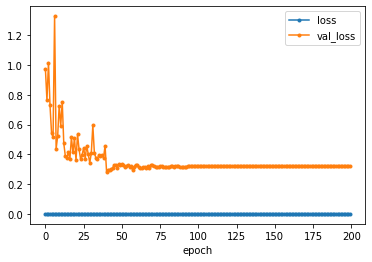

In [14]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The background likelihoods.
3. The foreground likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [8]:
model_name = 'DenoiSeg_DSB18_n0_noiseAugmentation_valTestAsWell'
basedir = 'models'
model = DenoiSeg(None, model_name, basedir)














Loading network weights from 'weights_best.h5'.


In [9]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision(), noise_augmentation=True)

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


/home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pixel_sharing_bipartite" failed type inference due to: Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (UniTuple(int64 x 2), dtype=Function(<class 'int'>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at /home/tbuchhol/Gitrepos/DenoiSeg/denoiseg/utils/compute_precision_threshold.py (10)


File "../../denoiseg/utils/compute_precision_threshold.py", line 10:
def pixel_sharing_bipartite(lab1, lab2):
    <source elided>
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max() + 

Score for threshold = 0.10 is 0.5280
Score for threshold = 0.15 is 0.6115
Score for threshold = 0.20 is 0.6528
Score for threshold = 0.25 is 0.6679
Score for threshold = 0.30 is 0.6643
Score for threshold = 0.35 is 0.6672
Score for threshold = 0.40 is 0.6674
Score for threshold = 0.45 is 0.6700
Score for threshold = 0.50 is 0.6570
Score for threshold = 0.55 is 0.6636
Score for threshold = 0.60 is 0.6542
Score for threshold = 0.65 is 0.6422
Score for threshold = 0.70 is 0.6276
Score for threshold = 0.75 is 0.6162
Score for threshold = 0.80 is 0.5989
Score for threshold = 0.85 is 0.5587
Score for threshold = 0.90 is 0.5158
Score for threshold = 0.95 is 0.4329
Score for threshold = 1.00 is 0.0000

The higest score of 0.67 is achieved with threshold = 0.45000000000000007.


In [12]:
threshold_noAug, val_score_noAug = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision(), noise_augmentation=False)

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score_noAug, 3), threshold_noAug))

Computing best threshold: 


Score for threshold = 0.10 is 0.6280
Score for threshold = 0.15 is 0.6673
Score for threshold = 0.20 is 0.6847
Score for threshold = 0.25 is 0.6923
Score for threshold = 0.30 is 0.6930
Score for threshold = 0.35 is 0.6845
Score for threshold = 0.40 is 0.6835
Score for threshold = 0.45 is 0.6838
Score for threshold = 0.50 is 0.6824
Score for threshold = 0.55 is 0.6795
Score for threshold = 0.60 is 0.6698
Score for threshold = 0.65 is 0.6654
Score for threshold = 0.70 is 0.6484
Score for threshold = 0.75 is 0.6358
Score for threshold = 0.80 is 0.6221
Score for threshold = 0.85 is 0.5857
Score for threshold = 0.90 is 0.5491
Score for threshold = 0.95 is 0.4717
Score for threshold = 1.00 is 0.0000

The higest score of 0.693 is achieved with threshold = 0.30000000000000004.


## Test Data
Finally we load the test data and run the prediction.

In [10]:
test_data =  np.load('data/DSB2018_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [11]:
predicted_images, precision_result = model.predict_label_masks(test_images, test_masks, threshold, 
                                                                   measure=measure_precision(), noise_augmentation=True)
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

Average precision over all test images with threshold = 0.45000000000000007 is 0.566.


In [13]:
predicted_images_noAug, precision_result_noAug = model.predict_label_masks(test_images, test_masks, threshold_noAug, 
                                                                   measure=measure_precision(), noise_augmentation=False)
print("Average precision over all test images with threshold = {} is {}.".format(threshold_noAug, np.round(precision_result_noAug, 3)))

Average precision over all test images with threshold = 0.30000000000000004 is 0.597.


# Comparison

In [14]:
baseline = 0.578
baseline_sem = 0.01
baseline_noiseAugmentation = np.round(precision_result_noAug, 3)
denoiseg_alpha_05 = 0.625
denoiseg_alpha_05_sem = 0.008

In [15]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

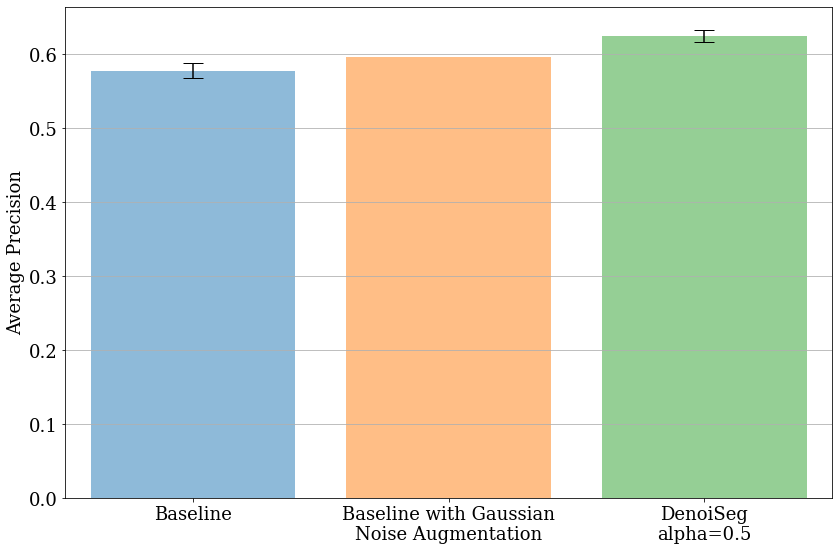

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(0, baseline, yerr=baseline_sem, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(1, baseline_noiseAugmentation, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(2, denoiseg_alpha_05, yerr=denoiseg_alpha_05_sem, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Baseline', 'Baseline with Gaussian\nNoise Augmentation', 'DenoiSeg\nalpha=0.5'])
ax.yaxis.grid(True)
ax.set_ylabel('Average Precision')
ax.set_xlim([-0.5, 2.5])

# Save the figure and show
plt.tight_layout()